The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [3]:
#cell 1
%matplotlib inline

In [4]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [5]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [6]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

get_correct_exptime: read failed
Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
get_correct_exptime: read failed
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1      -1.0
filter j105908m1246          WFC3/IR G102    1      -1.0


 1 j105900m1253 164.747 -12.878
get_correct_exptime: read failed
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1      -1.0
filter j105900m1253         WFC3/IR F105W    1      -1.0
filter j105900m1253          WFC3/IR G102    1      -1.0


 2 j105912m1254 164.794 -12.903
get_correct_exptime: read failed
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1      -1.0
filter j105912m1254          WFC3/IR G102    1      -1.0


 3 j105836m1254 164.644 -12.893
get_correct_exptime: read failed
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1      -1.0
filter j105836m1254          WFC3/IR G102    1      -1.0


In [7]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [8]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [9]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j122752m1140'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [10]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [11]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1227-11.1-c1b-09-180.0-F105W 4
CL1227-11.1-c1b-09-180.0-G102 4

 == Grism groups ==

ic1b-180.0-f105w 4 ic1b-180.0-g102 4


ic1b-180.0-f105w                4
ic1b-180.0-g102                 4


In [12]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1227-11.1-c1b-09-180.0-F105W 4
CL1227-11.1-c1b-09-180.0-G102 4

 == Grism groups ==

cl1227-11.1-c1b-09-180.0-f105w 4 cl1227-11.1-c1b-09-180.0-g102 4


cl1227-11.1-c1b-09-180.0-f105w  4
cl1227-11.1-c1b-09-180.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [13]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1227-11.1-c1b-09-180.0-f105w 4 cl1227-11.1-c1b-09-180.0-g102 4
Skip cl1227-11.1-c1b-09-180.0-f105w
Skip cl1227-11.1-c1b-09-180.0-f105w
Skip cl1227-11.1-c1b-09-180.0-g102
utils.fix_flt_nan: ic1b09adq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09zxq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09akq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09amq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09a1q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09a6q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09a8q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b09afq_flt.fits[SCI,1] NaNPixels=0


In [14]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [15]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1227-11.1-c1b-09-180.0-f105w_shifts.log  ic1b-180.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b09zxq_flt.fits'] = ['ic1b09a1q_flt.fits']
# match['ic1b09a6q_flt.fits'] = ['ic1b09a8q_flt.fits']
# match['ic1b09adq_flt.fits'] = ['ic1b09afq_flt.fits']
# match['ic1b09akq_flt.fits'] = ['ic1b09amq_flt.fits']
ic1b09zxq_flt.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b09a6q_flt.fits   0.008  -0.026  0.00000  1.00000    43  0.049  0.070
ic1b09adq_flt.fits   0.025  -0.070  0.00000  1.00000    42  0.044  0.031
ic1b09akq_flt.fits  -0.014  -0.053  0.00000  1.00000    39  0.036  0.039
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b09zxq_flt.fits'] = ['ic1b09a1q_flt.fits']
# match['ic1b09a6q_flt.fits'] = ['ic1b09a8q_flt.fits']
# match['ic1b09adq_flt.fits'] = ['ic1b09afq_flt.fits']
# match['ic1b09akq_flt.fits'] = ['ic1b09amq_flt.fits']
ic1b09zxq_flt.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b09a

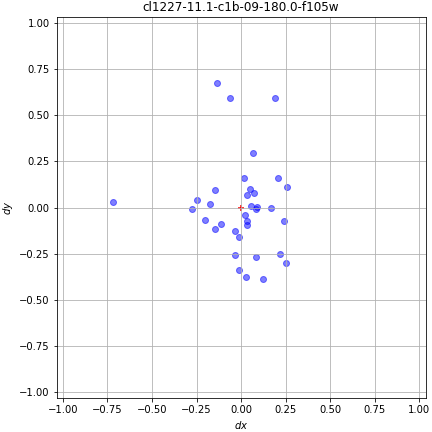

In [16]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1227-11.1-c1b-09-180.0-f105w_wcs.png") 


In [17]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1138-11.0-c1b-05-122.0-g102_column.png") 

FileNotFoundError: [Errno 2] No such file or directory: './cl1138-11.0-c1b-05-122.0-g102_column.png'

In [18]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

cl1227-11.1-c1b-09-180.0-f105w_wcs.log: 0 -2.3832 -4.9135 0.0139 1.00013 0.148 35
ic1b-180.0-f105w_wcs.log: 0 -2.3888 -4.9076 0.0132 1.00013 0.014 45


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [19]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

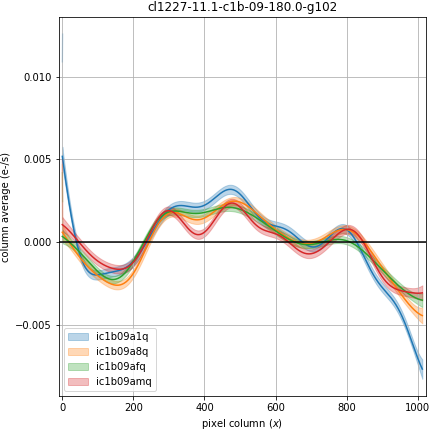

In [20]:
from IPython.display import Image
Image(filename = "./cl1227-11.1-c1b-09-180.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [21]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1227-11.1-c1b-09-180.0-f105w         0.09   -0.15


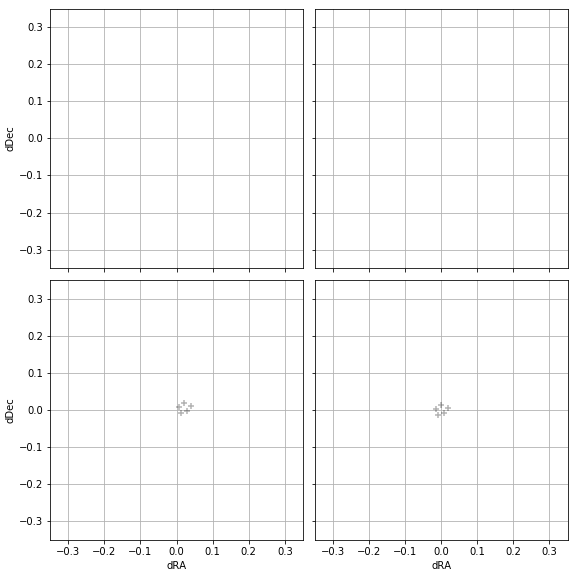

In [22]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [23]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [24]:
!ls -1 j*_dr?_sci.fits

j122752m1140-f105w_drz_sci.fits
j122752m1140-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [25]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j122752m1140-ir_drz_sci.fits
j122752m1140-ir_drz_wht.fits
j122752m1140-ir_seg.fits
j122752m1140-ir.cat.fits
j122752m1140-ir_bkg.fits
j122752m1140_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j122752m1140-ir_drz_sci.fits
WHT_FILE:	j122752m1140-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5256004333496094
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j122752m1140-f105w_drz_sci.fits
F105W_WHT_FILE:	j122752m1140-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5256004333496094
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [26]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [27]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b09a8q.01.GrismFLT.fits!
Load ic1b09amq.01.GrismFLT.fits!
Load ic1b09afq.01.GrismFLT.fits!
Load ic1b09a1q.01.GrismFLT.fits!
Files loaded - 1.49 sec.


### The final contamination model ###

IndexError: list index out of range

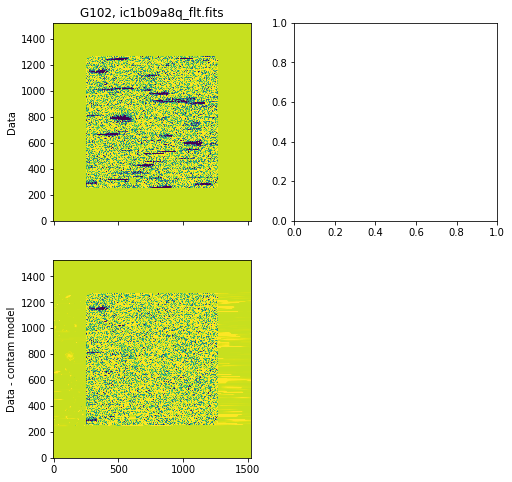

In [28]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [32]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j122752m1140/Extractions/c_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 



In [33]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')


Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [34]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j122752m1140-f105w_psf.fits'] 

Filename: j122752m1140-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


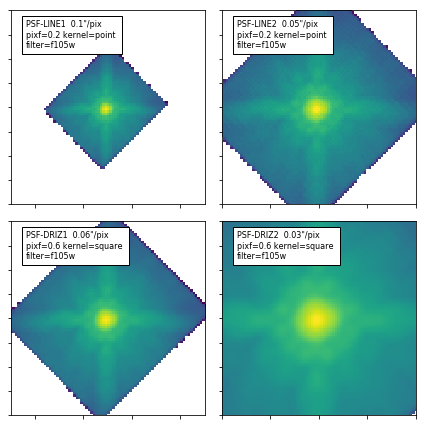

In [35]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [36]:
os.chdir('../Extractions')

In [37]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [38]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/181: 286 4
j122752m1140_00286.beams.fits
1/181: 211 0
2/181: 229 4
j122752m1140_00229.beams.fits
3/181: 456 4
j122752m1140_00456.beams.fits
4/181: 411 4
j122752m1140_00411.beams.fits
5/181: 390 4
j122752m1140_00390.beams.fits
6/181: 395 4
j122752m1140_00395.beams.fits
7/181: 354 4
j122752m1140_00354.beams.fits
8/181: 353 4
j122752m1140_00353.beams.fits
9/181: 101 4
j122752m1140_00101.beams.fits
10/181: 115 4
j122752m1140_00115.beams.fits
11/181: 175 4
j122752m1140_00175.beams.fits
12/181: 225 4
j122752m1140_00225.beams.fits
13/181: 302 4
j122752m1140_00302.beams.fits
14/181: 43 4
j122752m1140_00043.beams.fits
15/181: 437 4
j122752m1140_00437.beams.fits
16/181: 256 4
j122752m1140_00256.beams.fits
17/181: 150 4
j122752m1140_00150.beams.fits
18/181: 392 4
j122752m1140_00392.beams.fits
19/181: 139 4
j122752m1140_00139.beams.fits
20/181: 222 4
j122752m1140_00222.beams.fits
21/181: 343 4
j122752m1140_00343.beams.fits
22/181: 311 4
j122752m1140_00311.beams.fits
23/181: 224 4
j122752m1140_00

  0.1587  114494.9 (0.1000) 14/341
  0.1634  114450.1 (0.1000) 15/341
  0.1680  114362.0 (0.1000) 16/341
  0.1727  114238.0 (0.1000) 17/341
  0.1774  114169.1 (0.1000) 18/341
  0.1821  114097.4 (0.1000) 19/341
  0.1869  113980.1 (0.1869) 20/341
  0.1916  113883.4 (0.1916) 21/341
  0.1964  113755.6 (0.1964) 22/341
  0.2012  113595.6 (0.2012) 23/341
  0.2060  113617.9 (0.2012) 24/341
  0.2108  113591.5 (0.2108) 25/341
  0.2157  113536.4 (0.2157) 26/341
  0.2206  113519.4 (0.2206) 27/341
  0.2255  113543.2 (0.2206) 28/341
  0.2304  113604.3 (0.2206) 29/341
  0.2353  113651.8 (0.2206) 30/341
  0.2402  113682.1 (0.2206) 31/341
  0.2452  113651.4 (0.2206) 32/341
  0.2502  113639.3 (0.2206) 33/341
  0.2552  113632.6 (0.2206) 34/341
  0.2603  113598.3 (0.2206) 35/341
  0.2653  113652.4 (0.2206) 36/341
  0.2704  113636.6 (0.2206) 37/341
  0.2755  113513.9 (0.2755) 38/341
  0.2806  113542.5 (0.2755) 39/341
  0.2857  113547.5 (0.2755) 40/341
  0.2909  113593.6 (0.2755) 41/341
  0.2960  113612.8 (

  1.4975  121416.1 (0.5767) 206/341
  1.5076  121499.5 (0.5767) 207/341
  1.5176  121524.9 (0.5767) 208/341
  1.5277  121685.6 (0.5767) 209/341
  1.5378  121903.5 (0.5767) 210/341
  1.5480  122529.7 (0.5767) 211/341
  1.5582  122591.4 (0.5767) 212/341
  1.5685  122811.1 (0.5767) 213/341
  1.5788  123479.1 (0.5767) 214/341
  1.5891  123861.4 (0.5767) 215/341
  1.5995  124085.0 (0.5767) 216/341
  1.6099  124521.5 (0.5767) 217/341
  1.6204  125273.2 (0.5767) 218/341
  1.6309  125778.7 (0.5767) 219/341
  1.6414  126049.0 (0.5767) 220/341
  1.6520  125846.5 (0.5767) 221/341
  1.6626  125899.2 (0.5767) 222/341
  1.6733  125817.4 (0.5767) 223/341
  1.6840  125481.4 (0.5767) 224/341
  1.6948  125276.1 (0.5767) 225/341
  1.7056  125237.7 (0.5767) 226/341
  1.7164  124880.6 (0.5767) 227/341
  1.7273  124583.5 (0.5767) 228/341
  1.7382  124466.0 (0.5767) 229/341
  1.7492  124052.7 (0.5767) 230/341
  1.7602  123855.6 (0.5767) 231/341
  1.7713  123667.3 (0.5767) 232/341
  1.7824  123223.3 (0.5767) 

  0.1727   18648.8 (0.1177) 17/341
  0.1774   18656.6 (0.1177) 18/341
  0.1821   18639.4 (0.1177) 19/341
  0.1869   18628.2 (0.1177) 20/341
  0.1916   18609.1 (0.1177) 21/341
  0.1964   18584.4 (0.1177) 22/341
  0.2012   18556.2 (0.1177) 23/341
  0.2060   18512.6 (0.1177) 24/341
  0.2108   18468.3 (0.1177) 25/341
  0.2157   18441.1 (0.1177) 26/341
  0.2206   18432.3 (0.1177) 27/341
  0.2255   18425.1 (0.1177) 28/341
  0.2304   18431.3 (0.1177) 29/341
  0.2353   18453.8 (0.1177) 30/341
  0.2402   18491.7 (0.1177) 31/341
  0.2452   18536.0 (0.1177) 32/341
  0.2502   18584.4 (0.1177) 33/341
  0.2552   18618.5 (0.1177) 34/341
  0.2603   18653.0 (0.1177) 35/341
  0.2653   18688.4 (0.1177) 36/341
  0.2704   18698.4 (0.1177) 37/341
  0.2755   18716.2 (0.1177) 38/341
  0.2806   18725.5 (0.1177) 39/341
  0.2857   18693.0 (0.1177) 40/341
  0.2909   18656.2 (0.1177) 41/341
  0.2960   18627.7 (0.1177) 42/341
  0.3012   18583.0 (0.1177) 43/341
  0.3064   18536.4 (0.1177) 44/341
  0.3117   18515.6 (

  1.4975   20387.6 (0.3435) 206/341
  1.5076   20447.5 (0.3435) 207/341
  1.5176   20588.7 (0.3435) 208/341
  1.5277   20799.5 (0.3435) 209/341
  1.5378   20979.2 (0.3435) 210/341
  1.5480   21203.8 (0.3435) 211/341
  1.5582   21472.3 (0.3435) 212/341
  1.5685   21561.1 (0.3435) 213/341
  1.5788   21481.4 (0.3435) 214/341
  1.5891   21434.1 (0.3435) 215/341
  1.5995   21432.9 (0.3435) 216/341
  1.6099   21577.4 (0.3435) 217/341
  1.6204   21728.6 (0.3435) 218/341
  1.6309   21685.8 (0.3435) 219/341
  1.6414   21728.4 (0.3435) 220/341
  1.6520   21923.5 (0.3435) 221/341
  1.6626   22111.5 (0.3435) 222/341
  1.6733   22301.2 (0.3435) 223/341
  1.6840   22493.8 (0.3435) 224/341
  1.6948   22781.8 (0.3435) 225/341
  1.7056   23055.5 (0.3435) 226/341
  1.7164   23289.8 (0.3435) 227/341
  1.7273   23532.5 (0.3435) 228/341
  1.7382   23817.8 (0.3435) 229/341
  1.7492   24165.7 (0.3435) 230/341
  1.7602   24583.0 (0.3435) 231/341
  1.7713   24842.4 (0.3435) 232/341
  1.7824   24974.2 (0.3435) 

  0.1727   32617.6 (0.1680) 17/341
  0.1774   32610.8 (0.1680) 18/341
  0.1821   32605.0 (0.1680) 19/341
  0.1869   32583.2 (0.1869) 20/341
  0.1916   32507.0 (0.1916) 21/341
  0.1964   32494.5 (0.1964) 22/341
  0.2012   32462.7 (0.2012) 23/341
  0.2060   32415.1 (0.2060) 24/341
  0.2108   32382.5 (0.2108) 25/341
  0.2157   32371.0 (0.2157) 26/341
  0.2206   32416.3 (0.2157) 27/341
  0.2255   32409.6 (0.2157) 28/341
  0.2304   32445.4 (0.2157) 29/341
  0.2353   32415.9 (0.2157) 30/341
  0.2402   32410.4 (0.2157) 31/341
  0.2452   32452.0 (0.2157) 32/341
  0.2502   32515.7 (0.2157) 33/341
  0.2552   32511.7 (0.2157) 34/341
  0.2603   32555.7 (0.2157) 35/341
  0.2653   32608.7 (0.2157) 36/341
  0.2704   32680.9 (0.2157) 37/341
  0.2755   32673.2 (0.2157) 38/341
  0.2806   32732.3 (0.2157) 39/341
  0.2857   32652.2 (0.2157) 40/341
  0.2909   32676.2 (0.2157) 41/341
  0.2960   32664.5 (0.2157) 42/341
  0.3012   32655.0 (0.2157) 43/341
  0.3064   32693.6 (0.2157) 44/341
  0.3117   32674.9 (

  1.5480   40150.1 (0.5704) 211/341
  1.5582   40337.7 (0.5704) 212/341
  1.5685   40433.8 (0.5704) 213/341
  1.5788   40415.4 (0.5704) 214/341
  1.5891   40310.6 (0.5704) 215/341
  1.5995   40582.5 (0.5704) 216/341
  1.6099   40800.6 (0.5704) 217/341
  1.6204   40601.1 (0.5704) 218/341
  1.6309   40434.6 (0.5704) 219/341
  1.6414   40407.0 (0.5704) 220/341
  1.6520   40253.4 (0.5704) 221/341
  1.6626   40126.7 (0.5704) 222/341
  1.6733   39980.2 (0.5704) 223/341
  1.6840   39975.2 (0.5704) 224/341
  1.6948   40067.0 (0.5704) 225/341
  1.7056   39912.9 (0.5704) 226/341
  1.7164   39727.5 (0.5704) 227/341
  1.7273   39726.2 (0.5704) 228/341
  1.7382   39651.5 (0.5704) 229/341
  1.7492   39693.6 (0.5704) 230/341
  1.7602   39589.2 (0.5704) 231/341
  1.7713   39558.1 (0.5704) 232/341
  1.7824   39626.0 (0.5704) 233/341
  1.7935   39599.1 (0.5704) 234/341
  1.8047   39213.6 (0.5704) 235/341
  1.8160   38920.4 (0.5704) 236/341
  1.8273   38839.1 (0.5704) 237/341
  1.8386   38462.3 (0.5704) 

  0.1869   11894.0 (0.1634) 20/341
  0.1916   11975.6 (0.1634) 21/341
  0.1964   12144.1 (0.1634) 22/341
  0.2012   12286.7 (0.1634) 23/341
  0.2060   12354.1 (0.1634) 24/341
  0.2108   12389.9 (0.1634) 25/341
  0.2157   12415.6 (0.1634) 26/341
  0.2206   12436.7 (0.1634) 27/341
  0.2255   12446.1 (0.1634) 28/341
  0.2304   12411.1 (0.1634) 29/341
  0.2353   12301.3 (0.1634) 30/341
  0.2402   12159.3 (0.1634) 31/341
  0.2452   11996.5 (0.1634) 32/341
  0.2502   11851.4 (0.1634) 33/341
  0.2552   11739.4 (0.2552) 34/341
  0.2603   11664.5 (0.2603) 35/341
  0.2653   11606.6 (0.2653) 36/341
  0.2704   11561.5 (0.2704) 37/341
  0.2755   11547.9 (0.2755) 38/341
  0.2806   11584.2 (0.2755) 39/341
  0.2857   11665.0 (0.2755) 40/341
  0.2909   11791.5 (0.2755) 41/341
  0.2960   11984.9 (0.2755) 42/341
  0.3012   12228.5 (0.2755) 43/341
  0.3064   12477.0 (0.2755) 44/341
  0.3117   12638.5 (0.2755) 45/341
  0.3169   12737.2 (0.2755) 46/341
  0.3222   12791.8 (0.2755) 47/341
  0.3275   12816.2 (

  1.5480   19892.7 (0.5209) 211/341
  1.5582   20413.5 (0.5209) 212/341
  1.5685   20914.7 (0.5209) 213/341
  1.5788   21454.4 (0.5209) 214/341
  1.5891   21906.1 (0.5209) 215/341
  1.5995   22302.3 (0.5209) 216/341
  1.6099   22634.9 (0.5209) 217/341
  1.6204   22767.2 (0.5209) 218/341
  1.6309   22713.4 (0.5209) 219/341
  1.6414   22489.5 (0.5209) 220/341
  1.6520   22232.4 (0.5209) 221/341
  1.6626   22079.9 (0.5209) 222/341
  1.6733   21981.3 (0.5209) 223/341
  1.6840   22015.5 (0.5209) 224/341
  1.6948   22145.8 (0.5209) 225/341
  1.7056   22357.2 (0.5209) 226/341
  1.7164   22610.6 (0.5209) 227/341
  1.7273   22852.3 (0.5209) 228/341
  1.7382   23127.0 (0.5209) 229/341
  1.7492   23406.1 (0.5209) 230/341
  1.7602   23642.1 (0.5209) 231/341
  1.7713   23912.1 (0.5209) 232/341
  1.7824   24134.9 (0.5209) 233/341
  1.7935   24215.8 (0.5209) 234/341
  1.8047   24251.8 (0.5209) 235/341
  1.8160   24166.1 (0.5209) 236/341
  1.8273   23781.7 (0.5209) 237/341
  1.8386   22989.4 (0.5209) 

  0.2012   71816.7 (0.1964) 23/341
  0.2060   71847.1 (0.1964) 24/341
  0.2108   71862.3 (0.1964) 25/341
  0.2157   71914.2 (0.1964) 26/341
  0.2206   71880.7 (0.1964) 27/341
  0.2255   71907.6 (0.1964) 28/341
  0.2304   72022.7 (0.1964) 29/341
  0.2353   72118.7 (0.1964) 30/341
  0.2402   72136.7 (0.1964) 31/341
  0.2452   72161.3 (0.1964) 32/341
  0.2502   72124.8 (0.1964) 33/341
  0.2552   72126.8 (0.1964) 34/341
  0.2603   72198.6 (0.1964) 35/341
  0.2653   72239.5 (0.1964) 36/341
  0.2704   72265.5 (0.1964) 37/341
  0.2755   72272.9 (0.1964) 38/341
  0.2806   72337.5 (0.1964) 39/341
  0.2857   72339.3 (0.1964) 40/341
  0.2909   72346.1 (0.1964) 41/341
  0.2960   72342.5 (0.1964) 42/341
  0.3012   72333.1 (0.1964) 43/341
  0.3064   72365.8 (0.1964) 44/341
  0.3117   72396.6 (0.1964) 45/341
  0.3169   72368.9 (0.1964) 46/341
  0.3222   72341.7 (0.1964) 47/341
  0.3275   72366.3 (0.1964) 48/341
  0.3328   72355.5 (0.1964) 49/341
  0.3382   72311.7 (0.1964) 50/341
  0.3435   72282.1 (

  1.6204   79873.1 (0.1964) 218/341
  1.6309   79744.9 (0.1964) 219/341
  1.6414   79801.0 (0.1964) 220/341
  1.6520   79544.0 (0.1964) 221/341
  1.6626   79378.1 (0.1964) 222/341
  1.6733   79072.4 (0.1964) 223/341
  1.6840   78932.2 (0.1964) 224/341
  1.6948   78569.5 (0.1964) 225/341
  1.7056   78549.8 (0.1964) 226/341
  1.7164   78389.2 (0.1964) 227/341
  1.7273   78094.0 (0.1964) 228/341
  1.7382   78009.1 (0.1964) 229/341
  1.7492   77812.9 (0.1964) 230/341
  1.7602   77545.6 (0.1964) 231/341
  1.7713   77625.5 (0.1964) 232/341
  1.7824   77566.2 (0.1964) 233/341
  1.7935   77342.4 (0.1964) 234/341
  1.8047   77200.7 (0.1964) 235/341
  1.8160   77054.1 (0.1964) 236/341
  1.8273   76654.2 (0.1964) 237/341
  1.8386   76176.5 (0.1964) 238/341
  1.8500   75997.5 (0.1964) 239/341
  1.8614   75832.9 (0.1964) 240/341
  1.8729   75530.2 (0.1964) 241/341
  1.8844   75202.0 (0.1964) 242/341
  1.8959   74856.2 (0.1964) 243/341
  1.9075   74659.8 (0.1964) 244/341
  1.9192   74569.2 (0.1964) 

  0.2157   12928.9 (0.1222) 26/341
  0.2206   12932.1 (0.1222) 27/341
  0.2255   12934.9 (0.1222) 28/341
  0.2304   12939.5 (0.1222) 29/341
  0.2353   12931.3 (0.1222) 30/341
  0.2402   12918.1 (0.1222) 31/341
  0.2452   12912.4 (0.1222) 32/341
  0.2502   12913.1 (0.1222) 33/341
  0.2552   12923.0 (0.1222) 34/341
  0.2603   12935.9 (0.1222) 35/341
  0.2653   12942.2 (0.1222) 36/341
  0.2704   12920.1 (0.1222) 37/341
  0.2755   12896.6 (0.1222) 38/341
  0.2806   12870.8 (0.1222) 39/341
  0.2857   12859.5 (0.1222) 40/341
  0.2909   12828.1 (0.2909) 41/341
  0.2960   12803.0 (0.2960) 42/341
  0.3012   12798.9 (0.3012) 43/341
  0.3064   12798.6 (0.3064) 44/341
  0.3117   12817.9 (0.3064) 45/341
  0.3169   12832.8 (0.3064) 46/341
  0.3222   12850.1 (0.3064) 47/341
  0.3275   12872.4 (0.3064) 48/341
  0.3328   12899.4 (0.3064) 49/341
  0.3382   12912.3 (0.3064) 50/341
  0.3435   12914.0 (0.3064) 51/341
  0.3489   12916.6 (0.3064) 52/341
  0.3543   12920.2 (0.3064) 53/341
  0.3598   12919.0 (

  1.6099   15110.4 (0.5516) 217/341
  1.6204   15197.9 (0.5516) 218/341
  1.6309   15219.1 (0.5516) 219/341
  1.6414   15118.6 (0.5516) 220/341
  1.6520   15074.3 (0.5516) 221/341
  1.6626   15109.0 (0.5516) 222/341
  1.6733   15146.3 (0.5516) 223/341
  1.6840   15254.6 (0.5516) 224/341
  1.6948   15383.1 (0.5516) 225/341
  1.7056   15506.3 (0.5516) 226/341
  1.7164   15704.9 (0.5516) 227/341
  1.7273   15904.9 (0.5516) 228/341
  1.7382   16080.5 (0.5516) 229/341
  1.7492   16260.2 (0.5516) 230/341
  1.7602   16466.1 (0.5516) 231/341
  1.7713   16673.8 (0.5516) 232/341
  1.7824   16809.8 (0.5516) 233/341
  1.7935   16787.7 (0.5516) 234/341
  1.8047   16844.2 (0.5516) 235/341
  1.8160   16843.8 (0.5516) 236/341
  1.8273   16758.1 (0.5516) 237/341
  1.8386   16554.4 (0.5516) 238/341
  1.8500   16238.9 (0.5516) 239/341
  1.8614   16005.4 (0.5516) 240/341
  1.8729   15745.6 (0.5516) 241/341
  1.8844   15448.1 (0.5516) 242/341
  1.8959   15223.9 (0.5516) 243/341
  1.9075   15022.9 (0.5516) 

  0.2060   19411.2 (0.1312) 24/341
  0.2108   19397.3 (0.1312) 25/341
  0.2157   19393.2 (0.1312) 26/341
  0.2206   19376.6 (0.1312) 27/341
  0.2255   19387.1 (0.1312) 28/341
  0.2304   19400.8 (0.1312) 29/341
  0.2353   19402.7 (0.1312) 30/341
  0.2402   19392.9 (0.1312) 31/341
  0.2452   19380.3 (0.1312) 32/341
  0.2502   19374.2 (0.1312) 33/341
  0.2552   19377.2 (0.1312) 34/341
  0.2603   19405.8 (0.1312) 35/341
  0.2653   19441.8 (0.1312) 36/341
  0.2704   19450.6 (0.1312) 37/341
  0.2755   19441.5 (0.1312) 38/341
  0.2806   19422.2 (0.1312) 39/341
  0.2857   19411.0 (0.1312) 40/341
  0.2909   19394.8 (0.1312) 41/341
  0.2960   19390.6 (0.1312) 42/341
  0.3012   19397.3 (0.1312) 43/341
  0.3064   19385.8 (0.1312) 44/341
  0.3117   19372.1 (0.1312) 45/341
  0.3169   19372.2 (0.1312) 46/341
  0.3222   19391.7 (0.1312) 47/341
  0.3275   19401.3 (0.1312) 48/341
  0.3328   19371.3 (0.1312) 49/341
  0.3382   19192.4 (0.3382) 50/341
  0.3435   18905.4 (0.3435) 51/341
  0.3489   18985.9 (

  1.5685   25349.6 (0.3435) 213/341
  1.5788   25435.5 (0.3435) 214/341
  1.5891   25575.1 (0.3435) 215/341
  1.5995   25725.6 (0.3435) 216/341
  1.6099   25798.6 (0.3435) 217/341
  1.6204   25934.7 (0.3435) 218/341
  1.6309   26084.0 (0.3435) 219/341
  1.6414   26173.3 (0.3435) 220/341
  1.6520   26334.4 (0.3435) 221/341
  1.6626   26510.6 (0.3435) 222/341
  1.6733   26788.3 (0.3435) 223/341
  1.6840   27035.1 (0.3435) 224/341
  1.6948   27341.5 (0.3435) 225/341
  1.7056   27631.0 (0.3435) 226/341
  1.7164   27877.9 (0.3435) 227/341
  1.7273   28277.9 (0.3435) 228/341
  1.7382   28590.6 (0.3435) 229/341
  1.7492   28783.5 (0.3435) 230/341
  1.7602   29093.3 (0.3435) 231/341
  1.7713   29429.1 (0.3435) 232/341
  1.7824   29654.3 (0.3435) 233/341
  1.7935   29924.4 (0.3435) 234/341
  1.8047   30053.1 (0.3435) 235/341
  1.8160   30064.1 (0.3435) 236/341
  1.8273   29926.4 (0.3435) 237/341
  1.8386   29525.9 (0.3435) 238/341
  1.8500   28700.0 (0.3435) 239/341
  1.8614   27821.6 (0.3435) 

  0.2206   19928.3 (0.2012) 27/341
  0.2255   19934.5 (0.2012) 28/341
  0.2304   19945.9 (0.2012) 29/341
  0.2353   19930.1 (0.2012) 30/341
  0.2402   19924.2 (0.2012) 31/341
  0.2452   19877.5 (0.2452) 32/341
  0.2502   19866.1 (0.2502) 33/341
  0.2552   19863.6 (0.2552) 34/341
  0.2603   19849.8 (0.2603) 35/341
  0.2653   19853.6 (0.2603) 36/341
  0.2704   19847.3 (0.2704) 37/341
  0.2755   19849.1 (0.2704) 38/341
  0.2806   19847.5 (0.2704) 39/341
  0.2857   19857.4 (0.2704) 40/341
  0.2909   19851.1 (0.2704) 41/341
  0.2960   19813.7 (0.2960) 42/341
  0.3012   19814.6 (0.2960) 43/341
  0.3064   19860.0 (0.2960) 44/341
  0.3117   19867.8 (0.2960) 45/341
  0.3169   19906.7 (0.2960) 46/341
  0.3222   19914.3 (0.2960) 47/341
  0.3275   19932.2 (0.2960) 48/341
  0.3328   19937.7 (0.2960) 49/341
  0.3382   19934.0 (0.2960) 50/341
  0.3435   19927.1 (0.2960) 51/341
  0.3489   19918.4 (0.2960) 52/341
  0.3543   19931.0 (0.2960) 53/341
  0.3598   19936.7 (0.2960) 54/341
  0.3652   19939.9 (

  1.5891   24249.8 (0.2960) 215/341
  1.5995   24494.2 (0.2960) 216/341
  1.6099   24511.8 (0.2960) 217/341
  1.6204   24752.5 (0.2960) 218/341
  1.6309   24792.9 (0.2960) 219/341
  1.6414   24722.3 (0.2960) 220/341
  1.6520   24823.7 (0.2960) 221/341
  1.6626   24964.8 (0.2960) 222/341
  1.6733   25097.2 (0.2960) 223/341
  1.6840   25270.2 (0.2960) 224/341
  1.6948   25276.3 (0.2960) 225/341
  1.7056   25359.2 (0.2960) 226/341
  1.7164   25464.7 (0.2960) 227/341
  1.7273   25351.9 (0.2960) 228/341
  1.7382   25416.6 (0.2960) 229/341
  1.7492   25553.4 (0.2960) 230/341
  1.7602   25497.0 (0.2960) 231/341
  1.7713   25610.4 (0.2960) 232/341
  1.7824   25710.2 (0.2960) 233/341
  1.7935   25706.5 (0.2960) 234/341
  1.8047   25697.7 (0.2960) 235/341
  1.8160   25619.2 (0.2960) 236/341
  1.8273   25451.1 (0.2960) 237/341
  1.8386   25345.1 (0.2960) 238/341
  1.8500   24980.7 (0.2960) 239/341
  1.8614   24607.1 (0.2960) 240/341
  1.8729   24238.0 (0.2960) 241/341
  1.8844   23871.8 (0.2960) 

- 2.1187   19825.8 (0.2975) 63/66
- 2.1192   19826.0 (0.2975) 64/66
- 2.1197   19826.2 (0.2975) 65/66
- 2.1202   19826.5 (0.2975) 66/66
Drizzle line -> SIII (118817.38 88540.64)
Drizzle line -> SII  (0.67 1.83)
Drizzle line -> Ha   (1.52 1.89)
Drizzle line -> OI-6302 (0.03 3.55)
Get linemap PSF: F105W
9/181: 101
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000   14422.8 (0.1000) 1/341
  0.1044   14423.3 (0.1000) 2/341
  0.1088   14427.5 (0.1000) 3/341
  0.1133   14434.3 (0.1000) 4/341
  0.1177   14445.0 (0.1000) 5/341
  0.1222   14457.4 (0.1000) 6/341
  0.1267   14473.5 (0.1000) 7/341
  0.1312   14476.9 (0.1000) 8/341
  0.1358   14466.4 (0.1000) 9/341
  0.1403   14456.2 (0.1000) 10/341
  0.1449   14448.9 (0.1000) 11/341
  0.1495   14448.2 (0.1000) 12/341
  0.1541   14450.2 (0.1000) 13/341
  0.1587   14444.4 (0.1000) 14/341
  0.1634   14443.9 (0.1000) 15/341
  0.1680   14447.1 (0.1000) 16/341
  0.1727

  1.2509   14687.3 (0.1916) 180/341
  1.2599   14687.5 (0.1916) 181/341
  1.2689   14661.0 (0.1916) 182/341
  1.2780   14674.5 (0.1916) 183/341
  1.2872   14713.2 (0.1916) 184/341
  1.2963   14730.9 (0.1916) 185/341
  1.3055   14773.0 (0.1916) 186/341
  1.3148   14834.5 (0.1916) 187/341
  1.3240   14861.5 (0.1916) 188/341
  1.3334   14821.6 (0.1916) 189/341
  1.3427   14817.9 (0.1916) 190/341
  1.3521   14899.4 (0.1916) 191/341
  1.3615   14909.0 (0.1916) 192/341
  1.3710   14901.6 (0.1916) 193/341
  1.3805   14912.5 (0.1916) 194/341
  1.3900   14930.7 (0.1916) 195/341
  1.3996   14965.5 (0.1916) 196/341
  1.4092   14994.2 (0.1916) 197/341
  1.4189   15033.7 (0.1916) 198/341
  1.4286   15071.1 (0.1916) 199/341
  1.4383   15116.7 (0.1916) 200/341
  1.4481   15141.8 (0.1916) 201/341
  1.4579   15169.5 (0.1916) 202/341
  1.4678   15204.8 (0.1916) 203/341
  1.4776   15246.3 (0.1916) 204/341
  1.4876   15272.0 (0.1916) 205/341
  1.4975   15281.8 (0.1916) 206/341
  1.5076   15295.0 (0.1916) 

- 0.1988   14343.8 (0.1933) 28/33
- 0.1993   14351.2 (0.1933) 29/33
- 0.1998   14358.3 (0.1933) 30/33
- 0.2003   14364.9 (0.1933) 31/33
- 0.2008   14370.9 (0.1933) 32/33
- 0.2013   14376.2 (0.1933) 33/33
Drizzle line -> SIII (36.21 3.67)
Drizzle line -> SII  (37.62 13.09)
Drizzle line -> Ha   (188.93 35.73)
Drizzle line -> OI-6302 (697665.47 743758.98)
Get linemap PSF: F105W
10/181: 115
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000   15605.7 (0.1000) 1/341
  0.1044   15612.6 (0.1000) 2/341
  0.1088   15592.7 (0.1088) 3/341
  0.1133   15587.1 (0.1133) 4/341
  0.1177   15551.6 (0.1177) 5/341
  0.1222   15523.9 (0.1222) 6/341
  0.1267   15536.3 (0.1222) 7/341
  0.1312   15509.7 (0.1312) 8/341
  0.1358   15499.1 (0.1358) 9/341
  0.1403   15483.5 (0.1403) 10/341
  0.1449   15453.5 (0.1449) 11/341
  0.1495   15471.8 (0.1449) 12/341
  0.1541   15513.9 (0.1449) 13/341
  0.1587   15530.6 (0.1449) 14/341
  

  1.2599   17887.7 (0.6021) 181/341
  1.2689   18107.9 (0.6021) 182/341
  1.2780   18450.8 (0.6021) 183/341
  1.2872   18616.2 (0.6021) 184/341
  1.2963   18774.2 (0.6021) 185/341
  1.3055   19027.9 (0.6021) 186/341
  1.3148   19174.2 (0.6021) 187/341
  1.3240   19371.8 (0.6021) 188/341
  1.3334   19675.2 (0.6021) 189/341
  1.3427   19730.1 (0.6021) 190/341
  1.3521   20069.4 (0.6021) 191/341
  1.3615   20449.9 (0.6021) 192/341
  1.3710   20655.0 (0.6021) 193/341
  1.3805   21025.1 (0.6021) 194/341
  1.3900   21340.1 (0.6021) 195/341
  1.3996   21560.4 (0.6021) 196/341
  1.4092   21805.4 (0.6021) 197/341
  1.4189   22138.9 (0.6021) 198/341
  1.4286   22343.8 (0.6021) 199/341
  1.4383   22679.7 (0.6021) 200/341
  1.4481   22874.4 (0.6021) 201/341
  1.4579   23173.0 (0.6021) 202/341
  1.4678   23355.6 (0.6021) 203/341
  1.4776   23706.9 (0.6021) 204/341
  1.4876   23951.5 (0.6021) 205/341
  1.4975   24312.3 (0.6021) 206/341
  1.5076   24525.3 (0.6021) 207/341
  1.5176   24746.1 (0.6021) 

- 0.6045   14734.2 (0.5975) 28/33
- 0.6050   14737.2 (0.5975) 29/33
- 0.6055   14737.6 (0.5975) 30/33
- 0.6060   14737.1 (0.5975) 31/33
- 0.6065   14737.9 (0.5975) 32/33
- 0.6070   14737.4 (0.5975) 33/33
Drizzle line -> Ha   (5.52 0.81)
Drizzle line -> OIII (50.03 5.29)
Drizzle line -> Hb   (2966.03 650.67)
Get linemap PSF: F105W
11/181: 175
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000   13303.3 (0.1000) 1/341
  0.1044   13313.2 (0.1000) 2/341
  0.1088   13326.2 (0.1000) 3/341
  0.1133   13341.4 (0.1000) 4/341
  0.1177   13358.2 (0.1000) 5/341
  0.1222   13375.6 (0.1000) 6/341
  0.1267   13391.8 (0.1000) 7/341
  0.1312   13402.1 (0.1000) 8/341
  0.1358   13403.8 (0.1000) 9/341
  0.1403   13400.8 (0.1000) 10/341
  0.1449   13400.1 (0.1000) 11/341
  0.1495   13398.6 (0.1000) 12/341
  0.1541   13392.0 (0.1000) 13/341
  0.1587   13383.7 (0.1000) 14/341
  0.1634   13373.5 (0.1000) 15/341
  0.1680   13

  1.2329   13842.1 (0.2157) 178/341
  1.2419   13858.0 (0.2157) 179/341
  1.2509   13869.3 (0.2157) 180/341
  1.2599   13888.4 (0.2157) 181/341
  1.2689   13903.2 (0.2157) 182/341
  1.2780   13909.3 (0.2157) 183/341
  1.2872   13926.8 (0.2157) 184/341
  1.2963   13962.2 (0.2157) 185/341
  1.3055   14008.1 (0.2157) 186/341
  1.3148   14036.8 (0.2157) 187/341
  1.3240   14040.9 (0.2157) 188/341
  1.3334   14034.9 (0.2157) 189/341
  1.3427   14031.5 (0.2157) 190/341
  1.3521   14024.6 (0.2157) 191/341
  1.3615   14022.2 (0.2157) 192/341
  1.3710   14048.3 (0.2157) 193/341
  1.3805   14090.6 (0.2157) 194/341
  1.3900   14148.8 (0.2157) 195/341
  1.3996   14220.0 (0.2157) 196/341
  1.4092   14297.8 (0.2157) 197/341
  1.4189   14371.2 (0.2157) 198/341
  1.4286   14457.7 (0.2157) 199/341
  1.4383   14537.1 (0.2157) 200/341
  1.4481   14626.4 (0.2157) 201/341
  1.4579   14728.7 (0.2157) 202/341
  1.4678   14825.5 (0.2157) 203/341
  1.4776   14909.3 (0.2157) 204/341
  1.4876   14988.9 (0.2157) 

- 0.2197   13161.5 (0.2152) 26/33
- 0.2202   13164.1 (0.2152) 27/33
- 0.2207   13166.8 (0.2152) 28/33
- 0.2212   13170.0 (0.2152) 29/33
- 0.2217   13173.3 (0.2152) 30/33
- 0.2222   13176.6 (0.2152) 31/33
- 0.2227   13179.8 (0.2152) 32/33
- 0.2232   13183.2 (0.2152) 33/33
Drizzle line -> SIII (5.32 12.45)
Drizzle line -> SII  (14.53 14.75)
Drizzle line -> Ha   (210.22 19.83)
Get linemap PSF: F105W
12/181: 225
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000   11020.0 (0.1000) 1/341
  0.1044   11031.1 (0.1000) 2/341
  0.1088   11039.4 (0.1000) 3/341
  0.1133   11046.8 (0.1000) 4/341
  0.1177   11053.7 (0.1000) 5/341
  0.1222   11060.9 (0.1000) 6/341
  0.1267   11064.7 (0.1000) 7/341
  0.1312   11061.7 (0.1000) 8/341
  0.1358   11051.7 (0.1000) 9/341
  0.1403   11038.0 (0.1000) 10/341
  0.1449   11023.3 (0.1000) 11/341
  0.1495   11009.1 (0.1495) 12/341
  0.1541   10994.9 (0.1541) 13/341
  0.1587   1098

  1.2419   11117.2 (0.7425) 179/341
  1.2509   11121.4 (0.7425) 180/341
  1.2599   11094.8 (0.7425) 181/341
  1.2689   11022.0 (0.7425) 182/341
  1.2780   10945.6 (0.7425) 183/341
  1.2872   10916.3 (0.7425) 184/341
  1.2963   10909.9 (0.7425) 185/341
  1.3055   10949.1 (0.7425) 186/341
  1.3148   10998.8 (0.7425) 187/341
  1.3240   11029.5 (0.7425) 188/341
  1.3334   11038.1 (0.7425) 189/341
  1.3427   11029.3 (0.7425) 190/341
  1.3521   11069.6 (0.7425) 191/341
  1.3615   11150.8 (0.7425) 192/341
  1.3710   11260.0 (0.7425) 193/341
  1.3805   11370.2 (0.7425) 194/341
  1.3900   11450.5 (0.7425) 195/341
  1.3996   11521.3 (0.7425) 196/341
  1.4092   11604.1 (0.7425) 197/341
  1.4189   11693.1 (0.7425) 198/341
  1.4286   11774.5 (0.7425) 199/341
  1.4383   11844.8 (0.7425) 200/341
  1.4481   11907.5 (0.7425) 201/341
  1.4579   11975.9 (0.7425) 202/341
  1.4678   12038.7 (0.7425) 203/341
  1.4776   12075.4 (0.7425) 204/341
  1.4876   12113.4 (0.7425) 205/341
  1.4975   12160.2 (0.7425) 

- 0.7460   10783.3 (0.7400) 26/66
- 0.7465   10785.1 (0.7400) 27/66
- 0.7470   10787.2 (0.7400) 28/66
- 0.7475   10789.3 (0.7400) 29/66
- 0.7480   10791.6 (0.7400) 30/66
- 0.7485   10794.2 (0.7400) 31/66
- 0.7490   10797.1 (0.7400) 32/66
- 0.7495   10799.9 (0.7400) 33/66
- 2.0586   10778.8 (0.7400) 34/66
- 2.0591   10778.7 (0.7400) 35/66
- 2.0596   10778.6 (0.7400) 36/66
- 2.0601   10778.5 (0.7400) 37/66
- 2.0606   10778.3 (0.7400) 38/66
- 2.0611   10778.0 (0.7400) 39/66
- 2.0616   10777.6 (0.7400) 40/66
- 2.0621   10777.3 (0.7400) 41/66
- 2.0626   10776.9 (0.7400) 42/66
- 2.0631   10776.6 (0.7400) 43/66
- 2.0636   10776.3 (0.7400) 44/66
- 2.0641   10776.1 (0.7400) 45/66
- 2.0646   10775.9 (0.7400) 46/66
- 2.0651   10775.9 (0.7400) 47/66
- 2.0656   10776.1 (0.7400) 48/66
- 2.0661   10776.3 (0.7400) 49/66
- 2.0666   10776.5 (0.7400) 50/66
- 2.0671   10776.7 (0.7400) 51/66
- 2.0676   10777.0 (0.7400) 52/66
- 2.0681   10777.3 (0.7400) 53/66
- 2.0686   10777.5 (0.7400) 54/66
- 2.0691   107

  0.9725    9350.1 (0.8355) 147/341
  0.9804    9354.1 (0.8355) 148/341
  0.9884    9359.0 (0.8355) 149/341
  0.9963    9353.5 (0.8355) 150/341
  1.0043    9362.3 (0.8355) 151/341
  1.0124    9370.4 (0.8355) 152/341
  1.0204    9375.9 (0.8355) 153/341
  1.0285    9386.9 (0.8355) 154/341
  1.0367    9397.3 (0.8355) 155/341
  1.0448    9403.5 (0.8355) 156/341
  1.0530    9399.8 (0.8355) 157/341
  1.0612    9385.2 (0.8355) 158/341
  1.0695    9376.6 (0.8355) 159/341
  1.0778    9371.1 (0.8355) 160/341
  1.0861    9367.4 (0.8355) 161/341
  1.0945    9368.7 (0.8355) 162/341
  1.1029    9374.0 (0.8355) 163/341
  1.1113    9362.1 (0.8355) 164/341
  1.1198    9351.0 (0.8355) 165/341
  1.1283    9345.8 (0.8355) 166/341
  1.1368    9339.1 (0.8355) 167/341
  1.1454    9347.8 (0.8355) 168/341
  1.1540    9372.4 (0.8355) 169/341
  1.1626    9368.6 (0.8355) 170/341
  1.1713    9362.3 (0.8355) 171/341
  1.1800    9353.8 (0.8355) 172/341
  1.1887    9337.9 (0.8355) 173/341
  1.1975    9326.8 (0.8355) 

  3.2009    9400.2 (0.8355) 336/341
  3.2178    9404.7 (0.8355) 337/341
  3.2347    9414.5 (0.8355) 338/341
  3.2517    9426.8 (0.8355) 339/341
  3.2687    9437.7 (0.8355) 340/341
  3.2858    9445.3 (0.8355) 341/341
First iteration: z_best=0.8355

- 0.1043    9304.0 (0.1043) 1/66
- 0.1048    9304.5 (0.1043) 2/66
- 0.1053    9304.9 (0.1043) 3/66
- 0.1058    9305.2 (0.1043) 4/66
- 0.1063    9305.4 (0.1043) 5/66
- 0.1068    9305.5 (0.1043) 6/66
- 0.1073    9305.6 (0.1043) 7/66
- 0.1078    9305.6 (0.1043) 8/66
- 0.1083    9305.4 (0.1043) 9/66
- 0.1088    9305.1 (0.1043) 10/66
- 0.1093    9304.7 (0.1043) 11/66
- 0.1098    9304.2 (0.1043) 12/66
- 0.1103    9303.8 (0.1103) 13/66
- 0.1108    9303.4 (0.1108) 14/66
- 0.1113    9303.2 (0.1113) 15/66
- 0.1118    9303.0 (0.1118) 16/66
- 0.1123    9303.0 (0.1123) 17/66
- 0.1128    9303.2 (0.1123) 18/66
- 0.1133    9303.4 (0.1123) 19/66
- 0.1138    9303.7 (0.1123) 20/66
- 0.1143    9304.1 (0.1123) 21/66
- 0.1148    9304.6 (0.1123) 22/66
- 0.1153    9

  0.7286    3626.5 (0.3762) 114/341
  0.7355    3626.0 (0.3762) 115/341
  0.7425    3626.4 (0.3762) 116/341
  0.7495    3625.0 (0.3762) 117/341
  0.7565    3623.0 (0.3762) 118/341
  0.7635    3621.7 (0.3762) 119/341
  0.7706    3623.3 (0.3762) 120/341
  0.7777    3620.6 (0.3762) 121/341
  0.7848    3618.6 (0.3762) 122/341
  0.7920    3617.7 (0.3762) 123/341
  0.7991    3609.1 (0.7991) 124/341
  0.8064    3607.4 (0.8064) 125/341
  0.8136    3610.2 (0.8064) 126/341
  0.8209    3609.7 (0.8064) 127/341
  0.8282    3608.7 (0.8064) 128/341
  0.8355    3609.6 (0.8064) 129/341
  0.8428    3612.0 (0.8064) 130/341
  0.8502    3617.0 (0.8064) 131/341
  0.8576    3618.4 (0.8064) 132/341
  0.8651    3616.8 (0.8064) 133/341
  0.8726    3613.4 (0.8064) 134/341
  0.8801    3610.1 (0.8064) 135/341
  0.8876    3614.6 (0.8064) 136/341
  0.8952    3617.7 (0.8064) 137/341
  0.9028    3618.0 (0.8064) 138/341
  0.9104    3617.1 (0.8064) 139/341
  0.9181    3617.3 (0.8064) 140/341
  0.9257    3615.2 (0.8064) 

  2.6815    3620.4 (0.8064) 303/341
  2.6962    3621.8 (0.8064) 304/341
  2.7110    3623.8 (0.8064) 305/341
  2.7259    3625.6 (0.8064) 306/341
  2.7408    3626.8 (0.8064) 307/341
  2.7558    3627.1 (0.8064) 308/341
  2.7709    3627.4 (0.8064) 309/341
  2.7860    3629.3 (0.8064) 310/341
  2.8012    3630.5 (0.8064) 311/341
  2.8164    3631.5 (0.8064) 312/341
  2.8317    3632.5 (0.8064) 313/341
  2.8471    3633.0 (0.8064) 314/341
  2.8625    3632.8 (0.8064) 315/341
  2.8780    3633.8 (0.8064) 316/341
  2.8935    3631.3 (0.8064) 317/341
  2.9091    3621.8 (0.8064) 318/341
  2.9248    3613.9 (0.8064) 319/341
  2.9405    3609.2 (0.8064) 320/341
  2.9563    3611.2 (0.8064) 321/341
  2.9722    3615.2 (0.8064) 322/341
  2.9881    3617.7 (0.8064) 323/341
  3.0041    3618.7 (0.8064) 324/341
  3.0201    3614.0 (0.8064) 325/341
  3.0362    3609.5 (0.8064) 326/341
  3.0524    3611.7 (0.8064) 327/341
  3.0686    3616.8 (0.8064) 328/341
  3.0850    3619.7 (0.8064) 329/341
  3.1013    3617.0 (0.8064) 

- 0.5549    3614.8 (0.3756) 154/495
- 0.5554    3615.1 (0.3756) 155/495
- 0.5559    3615.4 (0.3756) 156/495
- 0.5564    3615.7 (0.3756) 157/495
- 0.5569    3615.8 (0.3756) 158/495
- 0.5574    3616.0 (0.3756) 159/495
- 0.5579    3616.3 (0.3756) 160/495
- 0.5584    3616.7 (0.3756) 161/495
- 0.5589    3617.0 (0.3756) 162/495
- 0.5594    3617.4 (0.3756) 163/495
- 0.5599    3617.8 (0.3756) 164/495
- 0.5604    3618.1 (0.3756) 165/495
- 0.7975    3611.4 (0.3756) 166/495
- 0.7980    3610.9 (0.3756) 167/495
- 0.7985    3610.2 (0.7985) 168/495
- 0.7990    3609.4 (0.7990) 169/495
- 0.7995    3608.6 (0.7995) 170/495
- 0.8000    3608.0 (0.8000) 171/495
- 0.8005    3607.4 (0.8005) 172/495
- 0.8010    3606.8 (0.8010) 173/495
- 0.8015    3606.5 (0.8015) 174/495
- 0.8020    3606.2 (0.8020) 175/495
- 0.8025    3606.1 (0.8025) 176/495
- 0.8030    3606.1 (0.8030) 177/495
- 0.8035    3606.1 (0.8030) 178/495
- 0.8040    3606.2 (0.8030) 179/495
- 0.8045    3606.4 (0.8030) 180/495
- 0.8050    3606.6 (0.8030) 

- 1.7361    3615.0 (0.8030) 345/495
- 1.7366    3615.0 (0.8030) 346/495
- 1.7371    3614.9 (0.8030) 347/495
- 1.7376    3614.9 (0.8030) 348/495
- 1.7381    3614.9 (0.8030) 349/495
- 1.7386    3614.9 (0.8030) 350/495
- 1.7391    3614.9 (0.8030) 351/495
- 1.7396    3614.8 (0.8030) 352/495
- 1.7401    3614.8 (0.8030) 353/495
- 1.7406    3614.8 (0.8030) 354/495
- 1.7411    3614.8 (0.8030) 355/495
- 1.7416    3614.8 (0.8030) 356/495
- 1.7421    3614.8 (0.8030) 357/495
- 1.7426    3614.8 (0.8030) 358/495
- 1.7431    3614.8 (0.8030) 359/495
- 1.7436    3614.9 (0.8030) 360/495
- 1.7441    3614.9 (0.8030) 361/495
- 1.7446    3614.9 (0.8030) 362/495
- 1.7451    3614.9 (0.8030) 363/495
- 1.9225    3617.1 (0.8030) 364/495
- 1.9230    3617.0 (0.8030) 365/495
- 1.9235    3617.0 (0.8030) 366/495
- 1.9240    3616.9 (0.8030) 367/495
- 1.9245    3616.9 (0.8030) 368/495
- 1.9250    3616.8 (0.8030) 369/495
- 1.9255    3616.8 (0.8030) 370/495
- 1.9260    3616.8 (0.8030) 371/495
- 1.9265    3616.7 (0.8030) 

  0.2552    7599.4 (0.1177) 34/341
  0.2603    7560.9 (0.1177) 35/341
  0.2653    7546.9 (0.1177) 36/341
  0.2704    7545.2 (0.1177) 37/341
  0.2755    7532.9 (0.1177) 38/341
  0.2806    7504.6 (0.1177) 39/341
  0.2857    7473.9 (0.1177) 40/341
  0.2909    7441.0 (0.1177) 41/341
  0.2960    7385.6 (0.1177) 42/341
  0.3012    7359.8 (0.1177) 43/341
  0.3064    7318.7 (0.1177) 44/341
  0.3117    7284.1 (0.3117) 45/341
  0.3169    7285.5 (0.3117) 46/341
  0.3222    7284.0 (0.3222) 47/341
  0.3275    7268.7 (0.3275) 48/341
  0.3328    7278.9 (0.3275) 49/341
  0.3382    7294.1 (0.3275) 50/341
  0.3435    7307.6 (0.3275) 51/341
  0.3489    7332.8 (0.3275) 52/341
  0.3543    7342.2 (0.3275) 53/341
  0.3598    7344.4 (0.3275) 54/341
  0.3652    7342.1 (0.3275) 55/341
  0.3707    7357.7 (0.3275) 56/341
  0.3762    7361.1 (0.3275) 57/341
  0.3817    7363.6 (0.3275) 58/341
  0.3872    7373.9 (0.3275) 59/341
  0.3928    7377.2 (0.3275) 60/341
  0.3984    7388.0 (0.3275) 61/341
  0.4040    7393.8 (

  1.6626    8782.9 (0.3275) 222/341
  1.6733    8926.7 (0.3275) 223/341
  1.6840    9121.6 (0.3275) 224/341
  1.6948    9195.5 (0.3275) 225/341
  1.7056    9202.4 (0.3275) 226/341
  1.7164    9272.0 (0.3275) 227/341
  1.7273    9413.9 (0.3275) 228/341
  1.7382    9558.1 (0.3275) 229/341
  1.7492    9772.9 (0.3275) 230/341
  1.7602    9952.7 (0.3275) 231/341
  1.7713   10198.6 (0.3275) 232/341
  1.7824   10445.9 (0.3275) 233/341
  1.7935   10620.4 (0.3275) 234/341
  1.8047   10637.5 (0.3275) 235/341
  1.8160   10665.8 (0.3275) 236/341
  1.8273   10589.9 (0.3275) 237/341
  1.8386   10628.9 (0.3275) 238/341
  1.8500   10434.0 (0.3275) 239/341
  1.8614   10079.0 (0.3275) 240/341
  1.8729    9937.6 (0.3275) 241/341
  1.8844    9771.5 (0.3275) 242/341
  1.8959    9683.2 (0.3275) 243/341
  1.9075    9654.9 (0.3275) 244/341
  1.9192    9428.8 (0.3275) 245/341
  1.9309    9184.6 (0.3275) 246/341
  1.9426    9223.7 (0.3275) 247/341
  1.9544    9094.6 (0.3275) 248/341
  1.9663    8987.1 (0.3275) 

  0.2552   10266.7 (0.1000) 34/341
  0.2603   10261.4 (0.1000) 35/341
  0.2653   10252.9 (0.1000) 36/341
  0.2704   10244.3 (0.1000) 37/341
  0.2755   10236.9 (0.1000) 38/341
  0.2806   10227.4 (0.2806) 39/341
  0.2857   10217.0 (0.2857) 40/341
  0.2909   10217.0 (0.2857) 41/341
  0.2960   10218.3 (0.2857) 42/341
  0.3012   10222.5 (0.2857) 43/341
  0.3064   10235.4 (0.2857) 44/341
  0.3117   10248.6 (0.2857) 45/341
  0.3169   10257.6 (0.2857) 46/341
  0.3222   10266.9 (0.2857) 47/341
  0.3275   10279.1 (0.2857) 48/341
  0.3328   10288.1 (0.2857) 49/341
  0.3382   10296.5 (0.2857) 50/341
  0.3435   10302.9 (0.2857) 51/341
  0.3489   10305.0 (0.2857) 52/341
  0.3543   10309.5 (0.2857) 53/341
  0.3598   10316.3 (0.2857) 54/341
  0.3652   10320.8 (0.2857) 55/341
  0.3707   10323.5 (0.2857) 56/341
  0.3762   10322.2 (0.2857) 57/341
  0.3817   10323.2 (0.2857) 58/341
  0.3872   10325.5 (0.2857) 59/341
  0.3928   10329.3 (0.2857) 60/341
  0.3984   10333.4 (0.2857) 61/341
  0.4040   10339.8 (

  1.6626   10769.8 (1.1198) 222/341
  1.6733   10821.2 (1.1198) 223/341
  1.6840   10864.9 (1.1198) 224/341
  1.6948   10917.6 (1.1198) 225/341
  1.7056   10975.0 (1.1198) 226/341
  1.7164   11017.5 (1.1198) 227/341
  1.7273   11092.7 (1.1198) 228/341
  1.7382   11119.8 (1.1198) 229/341
  1.7492   11124.4 (1.1198) 230/341
  1.7602   11163.2 (1.1198) 231/341
  1.7713   11213.7 (1.1198) 232/341
  1.7824   11216.0 (1.1198) 233/341
  1.7935   11200.6 (1.1198) 234/341
  1.8047   11197.4 (1.1198) 235/341
  1.8160   11191.9 (1.1198) 236/341
  1.8273   11179.5 (1.1198) 237/341
  1.8386   11075.0 (1.1198) 238/341
  1.8500   10943.1 (1.1198) 239/341
  1.8614   10809.3 (1.1198) 240/341
  1.8729   10755.2 (1.1198) 241/341
  1.8844   10720.4 (1.1198) 242/341
  1.8959   10675.7 (1.1198) 243/341
  1.9075   10640.1 (1.1198) 244/341
  1.9192   10599.0 (1.1198) 245/341
  1.9309   10561.9 (1.1198) 246/341
  1.9426   10531.9 (1.1198) 247/341
  1.9544   10528.2 (1.1198) 248/341
  1.9663   10535.1 (1.1198) 

  0.2353    9542.7 (0.2206) 30/341
  0.2402    9539.4 (0.2206) 31/341
  0.2452    9533.5 (0.2206) 32/341
  0.2502    9533.3 (0.2206) 33/341
  0.2552    9539.8 (0.2206) 34/341
  0.2603    9540.6 (0.2206) 35/341
  0.2653    9543.2 (0.2206) 36/341
  0.2704    9542.4 (0.2206) 37/341
  0.2755    9544.0 (0.2206) 38/341
  0.2806    9542.2 (0.2206) 39/341
  0.2857    9545.6 (0.2206) 40/341
  0.2909    9544.7 (0.2206) 41/341
  0.2960    9544.4 (0.2206) 42/341
  0.3012    9547.0 (0.2206) 43/341
  0.3064    9550.0 (0.2206) 44/341
  0.3117    9548.9 (0.2206) 45/341
  0.3169    9552.4 (0.2206) 46/341
  0.3222    9552.9 (0.2206) 47/341
  0.3275    9554.6 (0.2206) 48/341
  0.3328    9558.6 (0.2206) 49/341
  0.3382    9565.3 (0.2206) 50/341
  0.3435    9568.8 (0.2206) 51/341
  0.3489    9570.3 (0.2206) 52/341
  0.3543    9571.0 (0.2206) 53/341
  0.3598    9571.0 (0.2206) 54/341
  0.3652    9569.5 (0.2206) 55/341
  0.3707    9567.6 (0.2206) 56/341
  0.3762    9565.8 (0.2206) 57/341
  0.3817    9563.7 (

  1.6309    9882.5 (0.9725) 219/341
  1.6414    9865.9 (0.9725) 220/341
  1.6520    9854.4 (0.9725) 221/341
  1.6626    9869.6 (0.9725) 222/341
  1.6733    9869.1 (0.9725) 223/341
  1.6840    9877.5 (0.9725) 224/341
  1.6948    9900.0 (0.9725) 225/341
  1.7056    9914.4 (0.9725) 226/341
  1.7164    9927.0 (0.9725) 227/341
  1.7273    9905.3 (0.9725) 228/341
  1.7382    9891.0 (0.9725) 229/341
  1.7492    9883.2 (0.9725) 230/341
  1.7602    9895.6 (0.9725) 231/341
  1.7713    9885.3 (0.9725) 232/341
  1.7824    9894.2 (0.9725) 233/341
  1.7935    9896.0 (0.9725) 234/341
  1.8047    9901.9 (0.9725) 235/341
  1.8160    9884.9 (0.9725) 236/341
  1.8273    9853.5 (0.9725) 237/341
  1.8386    9827.3 (0.9725) 238/341
  1.8500    9799.0 (0.9725) 239/341
  1.8614    9786.6 (0.9725) 240/341
  1.8729    9762.9 (0.9725) 241/341
  1.8844    9743.9 (0.9725) 242/341
  1.8959    9732.9 (0.9725) 243/341
  1.9075    9725.3 (0.9725) 244/341
  1.9192    9668.3 (0.9725) 245/341
  1.9309    9645.0 (0.9725) 

- 0.9668    9526.5 (0.9658) 69/132
- 0.9673    9526.3 (0.9658) 70/132
- 0.9678    9525.9 (0.9678) 71/132
- 0.9683    9525.5 (0.9683) 72/132
- 0.9688    9525.5 (0.9688) 73/132
- 0.9693    9525.4 (0.9693) 74/132
- 0.9698    9525.0 (0.9698) 75/132
- 0.9703    9524.4 (0.9703) 76/132
- 0.9708    9523.8 (0.9708) 77/132
- 0.9713    9523.5 (0.9713) 78/132
- 0.9718    9523.6 (0.9713) 79/132
- 0.9723    9523.9 (0.9713) 80/132
- 0.9728    9524.0 (0.9713) 81/132
- 0.9733    9524.2 (0.9713) 82/132
- 0.9738    9524.3 (0.9713) 83/132
- 0.9743    9524.3 (0.9713) 84/132
- 0.9748    9524.3 (0.9713) 85/132
- 0.9753    9524.2 (0.9713) 86/132
- 0.9758    9524.1 (0.9713) 87/132
- 0.9763    9524.1 (0.9713) 88/132
- 0.9768    9524.4 (0.9713) 89/132
- 0.9773    9524.9 (0.9713) 90/132
- 0.9778    9525.5 (0.9713) 91/132
- 0.9783    9525.6 (0.9713) 92/132
- 0.9788    9525.5 (0.9713) 93/132
- 0.9793    9525.3 (0.9713) 94/132
- 0.9798    9525.1 (0.9713) 95/132
- 0.9803    9525.0 (0.9713) 96/132
- 0.9808    9525.2 (

  0.7991    9812.7 (0.6345) 124/341
  0.8064    9827.1 (0.6345) 125/341
  0.8136    9839.6 (0.6345) 126/341
  0.8209    9846.2 (0.6345) 127/341
  0.8282    9840.4 (0.6345) 128/341
  0.8355    9826.9 (0.6345) 129/341
  0.8428    9823.3 (0.6345) 130/341
  0.8502    9823.6 (0.6345) 131/341
  0.8576    9823.7 (0.6345) 132/341
  0.8651    9821.6 (0.6345) 133/341
  0.8726    9824.8 (0.6345) 134/341
  0.8801    9827.1 (0.6345) 135/341
  0.8876    9825.2 (0.6345) 136/341
  0.8952    9826.2 (0.6345) 137/341
  0.9028    9831.1 (0.6345) 138/341
  0.9104    9837.6 (0.6345) 139/341
  0.9181    9847.7 (0.6345) 140/341
  0.9257    9848.5 (0.6345) 141/341
  0.9335    9845.8 (0.6345) 142/341
  0.9412    9846.3 (0.6345) 143/341
  0.9490    9850.1 (0.6345) 144/341
  0.9568    9848.6 (0.6345) 145/341
  0.9646    9837.0 (0.6345) 146/341
  0.9725    9825.0 (0.6345) 147/341
  0.9804    9817.5 (0.6345) 148/341
  0.9884    9812.0 (0.6345) 149/341
  0.9963    9809.7 (0.6345) 150/341
  1.0043    9807.6 (0.6345) 

  2.8471    9894.6 (0.6345) 314/341
  2.8625    9881.6 (0.6345) 315/341
  2.8780    9875.4 (0.6345) 316/341
  2.8935    9870.0 (0.6345) 317/341
  2.9091    9858.2 (0.6345) 318/341
  2.9248    9844.7 (0.6345) 319/341
  2.9405    9836.2 (0.6345) 320/341
  2.9563    9830.7 (0.6345) 321/341
  2.9722    9820.2 (0.6345) 322/341
  2.9881    9803.6 (0.6345) 323/341
  3.0041    9782.5 (0.6345) 324/341
  3.0201    9763.6 (0.6345) 325/341
  3.0362    9766.3 (0.6345) 326/341
  3.0524    9801.4 (0.6345) 327/341
  3.0686    9846.9 (0.6345) 328/341
  3.0850    9873.0 (0.6345) 329/341
  3.1013    9888.8 (0.6345) 330/341
  3.1178    9900.5 (0.6345) 331/341
  3.1343    9916.0 (0.6345) 332/341
  3.1508    9937.4 (0.6345) 333/341
  3.1675    9963.6 (0.6345) 334/341
  3.1842    9992.5 (0.6345) 335/341
  3.2009   10021.5 (0.6345) 336/341
  3.2178   10045.5 (0.6345) 337/341
  3.2347   10060.2 (0.6345) 338/341
  3.2517   10067.0 (0.6345) 339/341
  3.2687   10066.0 (0.6345) 340/341
  3.2858   10063.4 (0.6345) 

  0.8209    7576.7 (0.3012) 127/341
  0.8282    7582.0 (0.3012) 128/341
  0.8355    7587.7 (0.3012) 129/341
  0.8428    7593.3 (0.3012) 130/341
  0.8502    7597.7 (0.3012) 131/341
  0.8576    7604.6 (0.3012) 132/341
  0.8651    7602.3 (0.3012) 133/341
  0.8726    7601.8 (0.3012) 134/341
  0.8801    7603.1 (0.3012) 135/341
  0.8876    7601.4 (0.3012) 136/341
  0.8952    7597.7 (0.3012) 137/341
  0.9028    7587.9 (0.3012) 138/341
  0.9104    7582.6 (0.3012) 139/341
  0.9181    7581.3 (0.3012) 140/341
  0.9257    7575.4 (0.3012) 141/341
  0.9335    7570.9 (0.3012) 142/341
  0.9412    7560.7 (0.3012) 143/341
  0.9490    7552.4 (0.3012) 144/341
  0.9568    7540.0 (0.3012) 145/341
  0.9646    7546.3 (0.3012) 146/341
  0.9725    7554.3 (0.3012) 147/341
  0.9804    7563.0 (0.3012) 148/341
  0.9884    7592.5 (0.3012) 149/341
  0.9963    7610.2 (0.3012) 150/341
  1.0043    7619.3 (0.3012) 151/341
  1.0124    7627.0 (0.3012) 152/341
  1.0204    7628.2 (0.3012) 153/341
  1.0285    7624.6 (0.3012) 

  2.8780    7592.8 (0.3012) 316/341
  2.8935    7589.1 (0.3012) 317/341
  2.9091    7585.0 (0.3012) 318/341
  2.9248    7580.7 (0.3012) 319/341
  2.9405    7573.3 (0.3012) 320/341
  2.9563    7561.4 (0.3012) 321/341
  2.9722    7556.1 (0.3012) 322/341
  2.9881    7556.7 (0.3012) 323/341
  3.0041    7560.5 (0.3012) 324/341
  3.0201    7563.5 (0.3012) 325/341
  3.0362    7578.8 (0.3012) 326/341
  3.0524    7601.6 (0.3012) 327/341
  3.0686    7619.1 (0.3012) 328/341
  3.0850    7629.6 (0.3012) 329/341
  3.1013    7639.5 (0.3012) 330/341
  3.1178    7647.3 (0.3012) 331/341
  3.1343    7653.2 (0.3012) 332/341
  3.1508    7656.6 (0.3012) 333/341
  3.1675    7653.1 (0.3012) 334/341
  3.1842    7638.7 (0.3012) 335/341
  3.2009    7614.8 (0.3012) 336/341
  3.2178    7588.2 (0.3012) 337/341
  3.2347    7565.2 (0.3012) 338/341
  3.2517    7549.6 (0.3012) 339/341
  3.2687    7544.5 (0.3012) 340/341
  3.2858    7541.8 (0.3012) 341/341
First iteration: z_best=0.3012

- 0.2952    7535.2 (0.2952) 1/99

  0.4266    8450.4 (0.4209) 66/341
  0.4323    8447.1 (0.4323) 67/341
  0.4381    8441.7 (0.4381) 68/341
  0.4438    8438.2 (0.4438) 69/341
  0.4496    8431.3 (0.4496) 70/341
  0.4554    8433.8 (0.4496) 71/341
  0.4613    8446.3 (0.4496) 72/341
  0.4671    8451.8 (0.4496) 73/341
  0.4730    8448.2 (0.4496) 74/341
  0.4789    8441.7 (0.4496) 75/341
  0.4848    8434.5 (0.4496) 76/341
  0.4908    8427.2 (0.4908) 77/341
  0.4968    8422.6 (0.4968) 78/341
  0.5028    8422.1 (0.5028) 79/341
  0.5088    8423.3 (0.5028) 80/341
  0.5148    8430.3 (0.5028) 81/341
  0.5209    8438.3 (0.5028) 82/341
  0.5270    8442.8 (0.5028) 83/341
  0.5331    8445.1 (0.5028) 84/341
  0.5393    8446.4 (0.5028) 85/341
  0.5454    8445.3 (0.5028) 86/341
  0.5516    8449.3 (0.5028) 87/341
  0.5579    8453.1 (0.5028) 88/341
  0.5641    8454.5 (0.5028) 89/341
  0.5704    8455.3 (0.5028) 90/341
  0.5767    8458.1 (0.5028) 91/341
  0.5830    8464.5 (0.5028) 92/341
  0.5893    8468.9 (0.5028) 93/341
  0.5957    8465.2 (

  2.0627    8434.3 (1.2689) 257/341
  2.0750    8429.0 (1.2689) 258/341
  2.0873    8436.0 (1.2689) 259/341
  2.0997    8449.5 (1.2689) 260/341
  2.1121    8462.6 (1.2689) 261/341
  2.1246    8468.7 (1.2689) 262/341
  2.1371    8473.8 (1.2689) 263/341
  2.1497    8477.5 (1.2689) 264/341
  2.1623    8478.7 (1.2689) 265/341
  2.1750    8479.3 (1.2689) 266/341
  2.1877    8480.5 (1.2689) 267/341
  2.2005    8481.5 (1.2689) 268/341
  2.2133    8482.9 (1.2689) 269/341
  2.2262    8484.5 (1.2689) 270/341
  2.2391    8485.6 (1.2689) 271/341
  2.2521    8487.5 (1.2689) 272/341
  2.2652    8490.7 (1.2689) 273/341
  2.2783    8494.2 (1.2689) 274/341
  2.2914    8496.2 (1.2689) 275/341
  2.3046    8497.0 (1.2689) 276/341
  2.3178    8499.7 (1.2689) 277/341
  2.3311    8503.0 (1.2689) 278/341
  2.3445    8504.4 (1.2689) 279/341
  2.3579    8504.7 (1.2689) 280/341
  2.3713    8504.5 (1.2689) 281/341
  2.3849    8503.6 (1.2689) 282/341
  2.3984    8498.8 (1.2689) 283/341
  2.4120    8491.9 (1.2689) 

  0.2806    6918.8 (0.2108) 39/341
  0.2857    6921.8 (0.2108) 40/341
  0.2909    6919.9 (0.2108) 41/341
  0.2960    6931.3 (0.2108) 42/341
  0.3012    6919.7 (0.2108) 43/341
  0.3064    6928.3 (0.2108) 44/341
  0.3117    6933.3 (0.2108) 45/341
  0.3169    6945.0 (0.2108) 46/341
  0.3222    6949.1 (0.2108) 47/341
  0.3275    6960.5 (0.2108) 48/341
  0.3328    6977.7 (0.2108) 49/341
  0.3382    6985.8 (0.2108) 50/341
  0.3435    6971.6 (0.2108) 51/341
  0.3489    6960.9 (0.2108) 52/341
  0.3543    6948.5 (0.2108) 53/341
  0.3598    6936.2 (0.2108) 54/341
  0.3652    6941.9 (0.2108) 55/341
  0.3707    6933.2 (0.2108) 56/341
  0.3762    6920.8 (0.2108) 57/341
  0.3817    6918.8 (0.2108) 58/341
  0.3872    6910.3 (0.2108) 59/341
  0.3928    6892.3 (0.2108) 60/341
  0.3984    6888.1 (0.2108) 61/341
  0.4040    6882.5 (0.2108) 62/341
  0.4096    6872.1 (0.2108) 63/341
  0.4153    6870.5 (0.2108) 64/341
  0.4209    6868.8 (0.2108) 65/341
  0.4266    6869.9 (0.2108) 66/341
  0.4323    6874.0 (

  1.8047    9124.5 (0.5641) 235/341
  1.8160    9018.3 (0.5641) 236/341
  1.8273    8978.6 (0.5641) 237/341
  1.8386    8693.3 (0.5641) 238/341
  1.8500    8535.0 (0.5641) 239/341
  1.8614    8469.9 (0.5641) 240/341
  1.8729    8301.0 (0.5641) 241/341
  1.8844    8207.4 (0.5641) 242/341
  1.8959    8064.1 (0.5641) 243/341
  1.9075    7903.0 (0.5641) 244/341
  1.9192    7825.5 (0.5641) 245/341
  1.9309    7685.8 (0.5641) 246/341
  1.9426    7514.4 (0.5641) 247/341
  1.9544    7433.8 (0.5641) 248/341
  1.9663    7265.3 (0.5641) 249/341
  1.9782    7178.6 (0.5641) 250/341
  1.9901    7112.3 (0.5641) 251/341
  2.0021    6990.2 (0.5641) 252/341
  2.0141    6972.4 (0.5641) 253/341
  2.0262    6939.3 (0.5641) 254/341
  2.0383    6890.2 (0.5641) 255/341
  2.0505    6869.7 (0.5641) 256/341
  2.0627    6844.7 (0.5641) 257/341
  2.0750    6840.0 (0.5641) 258/341
  2.0873    6850.1 (0.5641) 259/341
  2.0997    6844.6 (0.5641) 260/341
  2.1121    6843.5 (0.5641) 261/341
  2.1246    6843.6 (0.5641) 

  0.1587   17024.1 (0.1587) 14/341
  0.1634   17018.4 (0.1634) 15/341
  0.1680   17014.9 (0.1680) 16/341
  0.1727   17014.6 (0.1727) 17/341
  0.1774   17014.8 (0.1727) 18/341
  0.1821   17017.6 (0.1727) 19/341
  0.1869   17027.8 (0.1727) 20/341
  0.1916   17038.6 (0.1727) 21/341
  0.1964   17048.8 (0.1727) 22/341
  0.2012   17057.2 (0.1727) 23/341
  0.2060   17060.1 (0.1727) 24/341
  0.2108   17062.5 (0.1727) 25/341
  0.2157   17067.1 (0.1727) 26/341
  0.2206   17074.3 (0.1727) 27/341
  0.2255   17081.8 (0.1727) 28/341
  0.2304   17089.1 (0.1727) 29/341
  0.2353   17095.7 (0.1727) 30/341
  0.2402   17098.2 (0.1727) 31/341
  0.2452   17098.3 (0.1727) 32/341
  0.2502   17097.6 (0.1727) 33/341
  0.2552   17098.1 (0.1727) 34/341
  0.2603   17097.5 (0.1727) 35/341
  0.2653   17095.6 (0.1727) 36/341
  0.2704   17091.6 (0.1727) 37/341
  0.2755   17086.8 (0.1727) 38/341
  0.2806   17082.2 (0.1727) 39/341
  0.2857   17080.3 (0.1727) 40/341
  0.2909   17078.0 (0.1727) 41/341
  0.2960   17075.6 (

  1.4876   18720.5 (0.3435) 205/341
  1.4975   18761.6 (0.3435) 206/341
  1.5076   18797.8 (0.3435) 207/341
  1.5176   18820.0 (0.3435) 208/341
  1.5277   18854.3 (0.3435) 209/341
  1.5378   18905.4 (0.3435) 210/341
  1.5480   18965.1 (0.3435) 211/341
  1.5582   19016.7 (0.3435) 212/341
  1.5685   19056.7 (0.3435) 213/341
  1.5788   19075.7 (0.3435) 214/341
  1.5891   19106.5 (0.3435) 215/341
  1.5995   19148.6 (0.3435) 216/341
  1.6099   19184.3 (0.3435) 217/341
  1.6204   19215.6 (0.3435) 218/341
  1.6309   19242.5 (0.3435) 219/341
  1.6414   19255.5 (0.3435) 220/341
  1.6520   19271.3 (0.3435) 221/341
  1.6626   19304.6 (0.3435) 222/341
  1.6733   19334.5 (0.3435) 223/341
  1.6840   19359.5 (0.3435) 224/341
  1.6948   19363.8 (0.3435) 225/341
  1.7056   19375.0 (0.3435) 226/341
  1.7164   19375.4 (0.3435) 227/341
  1.7273   19354.3 (0.3435) 228/341
  1.7382   19335.5 (0.3435) 229/341
  1.7492   19326.9 (0.3435) 230/341
  1.7602   19309.3 (0.3435) 231/341
  1.7713   19291.3 (0.3435) 

  0.1634    8685.8 (0.1267) 15/341
  0.1680    8673.6 (0.1267) 16/341
  0.1727    8661.8 (0.1267) 17/341
  0.1774    8655.4 (0.1267) 18/341
  0.1821    8651.4 (0.1267) 19/341
  0.1869    8645.8 (0.1267) 20/341
  0.1916    8660.5 (0.1267) 21/341
  0.1964    8668.9 (0.1267) 22/341
  0.2012    8669.1 (0.1267) 23/341
  0.2060    8672.6 (0.1267) 24/341
  0.2108    8675.5 (0.1267) 25/341
  0.2157    8674.5 (0.1267) 26/341
  0.2206    8681.8 (0.1267) 27/341
  0.2255    8698.3 (0.1267) 28/341
  0.2304    8714.7 (0.1267) 29/341
  0.2353    8724.2 (0.1267) 30/341
  0.2402    8736.5 (0.1267) 31/341
  0.2452    8746.0 (0.1267) 32/341
  0.2502    8755.7 (0.1267) 33/341
  0.2552    8766.9 (0.1267) 34/341
  0.2603    8772.9 (0.1267) 35/341
  0.2653    8772.4 (0.1267) 36/341
  0.2704    8767.4 (0.1267) 37/341
  0.2755    8757.3 (0.1267) 38/341
  0.2806    8742.0 (0.1267) 39/341
  0.2857    8728.5 (0.1267) 40/341
  0.2909    8714.8 (0.1267) 41/341
  0.2960    8700.2 (0.1267) 42/341
  0.3012    8685.9 (

  1.5076    8818.8 (0.6410) 207/341
  1.5176    8776.9 (0.6410) 208/341
  1.5277    8751.6 (0.6410) 209/341
  1.5378    8736.1 (0.6410) 210/341
  1.5480    8721.6 (0.6410) 211/341
  1.5582    8706.8 (0.6410) 212/341
  1.5685    8692.7 (0.6410) 213/341
  1.5788    8681.2 (0.6410) 214/341
  1.5891    8693.2 (0.6410) 215/341
  1.5995    8726.6 (0.6410) 216/341
  1.6099    8765.6 (0.6410) 217/341
  1.6204    8782.9 (0.6410) 218/341
  1.6309    8754.7 (0.6410) 219/341
  1.6414    8705.7 (0.6410) 220/341
  1.6520    8663.9 (0.6410) 221/341
  1.6626    8636.4 (0.6410) 222/341
  1.6733    8651.1 (0.6410) 223/341
  1.6840    8698.6 (0.6410) 224/341
  1.6948    8759.3 (0.6410) 225/341
  1.7056    8805.6 (0.6410) 226/341
  1.7164    8799.9 (0.6410) 227/341
  1.7273    8755.1 (0.6410) 228/341
  1.7382    8730.8 (0.6410) 229/341
  1.7492    8735.2 (0.6410) 230/341
  1.7602    8751.1 (0.6410) 231/341
  1.7713    8766.0 (0.6410) 232/341
  1.7824    8774.8 (0.6410) 233/341
  1.7935    8823.1 (0.6410) 

- 1.1543    8265.1 (0.6386) 56/66
- 1.1548    8272.1 (0.6386) 57/66
- 1.1553    8279.9 (0.6386) 58/66
- 1.1558    8288.0 (0.6386) 59/66
- 1.1563    8296.4 (0.6386) 60/66
- 1.1568    8305.0 (0.6386) 61/66
- 1.1573    8314.0 (0.6386) 62/66
- 1.1578    8323.3 (0.6386) 63/66
- 1.1583    8333.1 (0.6386) 64/66
- 1.1588    8343.0 (0.6386) 65/66
- 1.1593    8352.9 (0.6386) 66/66
Drizzle line -> SII  (9.65 2.25)
Drizzle line -> Ha   (51.97 2.34)
Drizzle line -> OI-6302 (7.00 2.53)
Drizzle line -> OIII (14.86 9.45)
Drizzle line -> Hb   (17.06 12.76)
Get linemap PSF: F105W
24/181: 318
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    6867.3 (0.1000) 1/341
  0.1044    6865.7 (0.1044) 2/341
  0.1088    6871.6 (0.1044) 3/341
  0.1133    6871.0 (0.1044) 4/341
  0.1177    6869.8 (0.1044) 5/341
  0.1222    6872.8 (0.1044) 6/341
  0.1267    6878.7 (0.1044) 7/341
  0.1312    6875.2 (0.1044) 8/341
  0.1358    6876.3 (

  1.2063    6909.3 (0.3222) 175/341
  1.2151    6907.7 (0.3222) 176/341
  1.2240    6957.7 (0.3222) 177/341
  1.2329    7015.5 (0.3222) 178/341
  1.2419    7030.5 (0.3222) 179/341
  1.2509    7001.2 (0.3222) 180/341
  1.2599    7018.8 (0.3222) 181/341
  1.2689    7018.7 (0.3222) 182/341
  1.2780    7034.9 (0.3222) 183/341
  1.2872    7042.6 (0.3222) 184/341
  1.2963    7072.3 (0.3222) 185/341
  1.3055    7122.7 (0.3222) 186/341
  1.3148    7131.6 (0.3222) 187/341
  1.3240    6921.5 (0.3222) 188/341
  1.3334    6768.1 (0.3222) 189/341
  1.3427    7066.1 (0.3222) 190/341
  1.3521    7193.3 (0.3222) 191/341
  1.3615    7241.5 (0.3222) 192/341
  1.3710    7244.6 (0.3222) 193/341
  1.3805    7220.9 (0.3222) 194/341
  1.3900    7226.9 (0.3222) 195/341
  1.3996    7302.4 (0.3222) 196/341
  1.4092    7322.9 (0.3222) 197/341
  1.4189    7301.7 (0.3222) 198/341
  1.4286    7332.8 (0.3222) 199/341
  1.4383    7360.8 (0.3222) 200/341
  1.4481    7358.0 (0.3222) 201/341
  1.4579    7347.7 (0.3222) 

- 0.3251    6515.4 (0.3236) 21/33
- 0.3256    6543.6 (0.3236) 22/33
- 0.3261    6574.7 (0.3236) 23/33
- 0.3266    6607.8 (0.3236) 24/33
- 0.3271    6641.6 (0.3236) 25/33
- 0.3276    6674.1 (0.3236) 26/33
- 0.3281    6704.6 (0.3236) 27/33
- 0.3286    6733.0 (0.3236) 28/33
- 0.3291    6758.6 (0.3236) 29/33
- 0.3296    6781.1 (0.3236) 30/33
- 0.3301    6801.2 (0.3236) 31/33
- 0.3306    6818.5 (0.3236) 32/33
- 0.3311    6832.3 (0.3236) 33/33
Drizzle line -> SII  (15.85 2.43)
Drizzle line -> Ha   (74.63 2.98)
Drizzle line -> OI-6302 (1.72 4.25)
Get linemap PSF: F105W
25/181: 427
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    6543.7 (0.1000) 1/341
  0.1044    6544.9 (0.1000) 2/341
  0.1088    6544.1 (0.1000) 3/341
  0.1133    6547.4 (0.1000) 4/341
  0.1177    6549.8 (0.1000) 5/341
  0.1222    6553.4 (0.1000) 6/341
  0.1267    6553.8 (0.1000) 7/341
  0.1312    6556.2 (0.1000) 8/341
  0.1358    6556.5 (

  1.1887    6597.4 (0.3012) 173/341
  1.1975    6597.4 (0.3012) 174/341
  1.2063    6592.2 (0.3012) 175/341
  1.2151    6589.7 (0.3012) 176/341
  1.2240    6599.1 (0.3012) 177/341
  1.2329    6625.8 (0.3012) 178/341
  1.2419    6630.8 (0.3012) 179/341
  1.2509    6622.0 (0.3012) 180/341
  1.2599    6613.6 (0.3012) 181/341
  1.2689    6615.4 (0.3012) 182/341
  1.2780    6613.4 (0.3012) 183/341
  1.2872    6609.2 (0.3012) 184/341
  1.2963    6614.3 (0.3012) 185/341
  1.3055    6635.0 (0.3012) 186/341
  1.3148    6658.9 (0.3012) 187/341
  1.3240    6644.8 (0.3012) 188/341
  1.3334    6631.4 (0.3012) 189/341
  1.3427    6631.9 (0.3012) 190/341
  1.3521    6630.0 (0.3012) 191/341
  1.3615    6639.2 (0.3012) 192/341
  1.3710    6643.7 (0.3012) 193/341
  1.3805    6624.4 (0.3012) 194/341
  1.3900    6633.7 (0.3012) 195/341
  1.3996    6652.3 (0.3012) 196/341
  1.4092    6655.2 (0.3012) 197/341
  1.4189    6658.1 (0.3012) 198/341
  1.4286    6658.0 (0.3012) 199/341
  1.4383    6655.6 (0.3012) 

- 0.3032    6535.0 (0.2987) 23/132
- 0.3037    6535.3 (0.2987) 24/132
- 0.3042    6535.8 (0.2987) 25/132
- 0.3047    6536.2 (0.2987) 26/132
- 0.3052    6536.7 (0.2987) 27/132
- 0.3057    6537.2 (0.2987) 28/132
- 0.3062    6537.6 (0.2987) 29/132
- 0.3067    6537.6 (0.2987) 30/132
- 0.3072    6537.8 (0.2987) 31/132
- 0.3077    6537.9 (0.2987) 32/132
- 0.3082    6538.0 (0.2987) 33/132
- 0.6692    6543.1 (0.2987) 34/132
- 0.6697    6542.7 (0.2987) 35/132
- 0.6702    6542.4 (0.2987) 36/132
- 0.6707    6541.9 (0.2987) 37/132
- 0.6712    6541.4 (0.2987) 38/132
- 0.6717    6540.8 (0.2987) 39/132
- 0.6722    6540.3 (0.2987) 40/132
- 0.6727    6540.1 (0.2987) 41/132
- 0.6732    6539.8 (0.2987) 42/132
- 0.6737    6539.6 (0.2987) 43/132
- 0.6742    6539.3 (0.2987) 44/132
- 0.6747    6538.9 (0.2987) 45/132
- 0.6752    6539.0 (0.2987) 46/132
- 0.6757    6539.3 (0.2987) 47/132
- 0.6762    6539.3 (0.2987) 48/132
- 0.6767    6539.0 (0.2987) 49/132
- 0.6772    6539.1 (0.2987) 50/132
- 0.6777    6539.0 (

  0.5028    5966.2 (0.1088) 79/341
  0.5088    5967.6 (0.1088) 80/341
  0.5148    5962.6 (0.1088) 81/341
  0.5209    5959.4 (0.1088) 82/341
  0.5270    5960.7 (0.1088) 83/341
  0.5331    5962.3 (0.1088) 84/341
  0.5393    5961.2 (0.1088) 85/341
  0.5454    5961.3 (0.1088) 86/341
  0.5516    5963.6 (0.1088) 87/341
  0.5579    5963.1 (0.1088) 88/341
  0.5641    5960.5 (0.1088) 89/341
  0.5704    5954.4 (0.1088) 90/341
  0.5767    5951.0 (0.5767) 91/341
  0.5830    5943.7 (0.5830) 92/341
  0.5893    5942.4 (0.5893) 93/341
  0.5957    5942.4 (0.5893) 94/341
  0.6021    5936.0 (0.6021) 95/341
  0.6085    5937.2 (0.6021) 96/341
  0.6150    5943.6 (0.6021) 97/341
  0.6214    5949.2 (0.6021) 98/341
  0.6279    5952.7 (0.6021) 99/341
  0.6345    5952.2 (0.6021) 100/341
  0.6410    5956.0 (0.6021) 101/341
  0.6476    5955.0 (0.6021) 102/341
  0.6542    5954.4 (0.6021) 103/341
  0.6608    5952.7 (0.6021) 104/341
  0.6675    5954.7 (0.6021) 105/341
  0.6742    5958.3 (0.6021) 106/341
  0.6809    5

  2.1750    5956.1 (1.1800) 266/341
  2.1877    5956.1 (1.1800) 267/341
  2.2005    5954.9 (1.1800) 268/341
  2.2133    5954.6 (1.1800) 269/341
  2.2262    5955.3 (1.1800) 270/341
  2.2391    5955.7 (1.1800) 271/341
  2.2521    5955.6 (1.1800) 272/341
  2.2652    5955.9 (1.1800) 273/341
  2.2783    5957.1 (1.1800) 274/341
  2.2914    5957.3 (1.1800) 275/341
  2.3046    5954.1 (1.1800) 276/341
  2.3178    5950.7 (1.1800) 277/341
  2.3311    5950.8 (1.1800) 278/341
  2.3445    5951.6 (1.1800) 279/341
  2.3579    5950.3 (1.1800) 280/341
  2.3713    5947.9 (1.1800) 281/341
  2.3849    5946.9 (1.1800) 282/341
  2.3984    5947.5 (1.1800) 283/341
  2.4120    5949.4 (1.1800) 284/341
  2.4257    5950.6 (1.1800) 285/341
  2.4394    5952.9 (1.1800) 286/341
  2.4532    5957.6 (1.1800) 287/341
  2.4671    5959.9 (1.1800) 288/341
  2.4810    5959.2 (1.1800) 289/341
  2.4949    5959.9 (1.1800) 290/341
  2.5089    5961.9 (1.1800) 291/341
  2.5230    5961.3 (1.1800) 292/341
  2.5371    5958.4 (1.1800) 

  0.3117    7443.9 (0.2755) 45/341
  0.3169    7439.7 (0.2755) 46/341
  0.3222    7435.8 (0.2755) 47/341
  0.3275    7434.7 (0.2755) 48/341
  0.3328    7437.5 (0.2755) 49/341
  0.3382    7439.2 (0.2755) 50/341
  0.3435    7439.7 (0.2755) 51/341
  0.3489    7439.1 (0.2755) 52/341
  0.3543    7436.7 (0.2755) 53/341
  0.3598    7432.4 (0.2755) 54/341
  0.3652    7424.7 (0.3652) 55/341
  0.3707    7418.3 (0.3707) 56/341
  0.3762    7418.4 (0.3707) 57/341
  0.3817    7422.9 (0.3707) 58/341
  0.3872    7429.9 (0.3707) 59/341
  0.3928    7435.8 (0.3707) 60/341
  0.3984    7440.4 (0.3707) 61/341
  0.4040    7444.2 (0.3707) 62/341
  0.4096    7449.3 (0.3707) 63/341
  0.4153    7451.9 (0.3707) 64/341
  0.4209    7452.4 (0.3707) 65/341
  0.4266    7453.9 (0.3707) 66/341
  0.4323    7455.2 (0.3707) 67/341
  0.4381    7456.8 (0.3707) 68/341
  0.4438    7461.0 (0.3707) 69/341
  0.4496    7462.3 (0.3707) 70/341
  0.4554    7460.7 (0.3707) 71/341
  0.4613    7455.8 (0.3707) 72/341
  0.4671    7450.8 (

  1.8273    7838.5 (0.5767) 237/341
  1.8386    7839.2 (0.5767) 238/341
  1.8500    7816.7 (0.5767) 239/341
  1.8614    7778.9 (0.5767) 240/341
  1.8729    7742.4 (0.5767) 241/341
  1.8844    7716.9 (0.5767) 242/341
  1.8959    7696.5 (0.5767) 243/341
  1.9075    7668.2 (0.5767) 244/341
  1.9192    7635.1 (0.5767) 245/341
  1.9309    7609.7 (0.5767) 246/341
  1.9426    7594.7 (0.5767) 247/341
  1.9544    7567.5 (0.5767) 248/341
  1.9663    7546.6 (0.5767) 249/341
  1.9782    7534.9 (0.5767) 250/341
  1.9901    7532.5 (0.5767) 251/341
  2.0021    7531.0 (0.5767) 252/341
  2.0141    7517.6 (0.5767) 253/341
  2.0262    7497.7 (0.5767) 254/341
  2.0383    7480.4 (0.5767) 255/341
  2.0505    7467.9 (0.5767) 256/341
  2.0627    7462.0 (0.5767) 257/341
  2.0750    7456.3 (0.5767) 258/341
  2.0873    7452.7 (0.5767) 259/341
  2.0997    7450.2 (0.5767) 260/341
  2.1121    7447.3 (0.5767) 261/341
  2.1246    7440.7 (0.5767) 262/341
  2.1371    7431.0 (0.5767) 263/341
  2.1497    7424.8 (0.5767) 

  0.3275    9453.3 (0.3012) 48/341
  0.3328    9459.5 (0.3012) 49/341
  0.3382    9462.8 (0.3012) 50/341
  0.3435    9467.2 (0.3012) 51/341
  0.3489    9472.1 (0.3012) 52/341
  0.3543    9473.1 (0.3012) 53/341
  0.3598    9473.6 (0.3012) 54/341
  0.3652    9476.2 (0.3012) 55/341
  0.3707    9482.1 (0.3012) 56/341
  0.3762    9489.4 (0.3012) 57/341
  0.3817    9495.4 (0.3012) 58/341
  0.3872    9495.4 (0.3012) 59/341
  0.3928    9494.3 (0.3012) 60/341
  0.3984    9494.2 (0.3012) 61/341
  0.4040    9493.9 (0.3012) 62/341
  0.4096    9495.6 (0.3012) 63/341
  0.4153    9497.6 (0.3012) 64/341
  0.4209    9501.1 (0.3012) 65/341
  0.4266    9507.6 (0.3012) 66/341
  0.4323    9515.5 (0.3012) 67/341
  0.4381    9524.1 (0.3012) 68/341
  0.4438    9529.2 (0.3012) 69/341
  0.4496    9532.3 (0.3012) 70/341
  0.4554    9531.3 (0.3012) 71/341
  0.4613    9529.6 (0.3012) 72/341
  0.4671    9525.0 (0.3012) 73/341
  0.4730    9517.8 (0.3012) 74/341
  0.4789    9509.6 (0.3012) 75/341
  0.4848    9518.4 (

  1.8273   10040.4 (1.1540) 237/341
  1.8386    9991.1 (1.1540) 238/341
  1.8500    9959.8 (1.1540) 239/341
  1.8614    9899.6 (1.1540) 240/341
  1.8729    9848.7 (1.1540) 241/341
  1.8844    9814.1 (1.1540) 242/341
  1.8959    9779.4 (1.1540) 243/341
  1.9075    9767.3 (1.1540) 244/341
  1.9192    9750.2 (1.1540) 245/341
  1.9309    9711.4 (1.1540) 246/341
  1.9426    9698.2 (1.1540) 247/341
  1.9544    9691.3 (1.1540) 248/341
  1.9663    9678.5 (1.1540) 249/341
  1.9782    9673.8 (1.1540) 250/341
  1.9901    9663.5 (1.1540) 251/341
  2.0021    9650.1 (1.1540) 252/341
  2.0141    9619.5 (1.1540) 253/341
  2.0262    9584.1 (1.1540) 254/341
  2.0383    9562.1 (1.1540) 255/341
  2.0505    9551.0 (1.1540) 256/341
  2.0627    9532.3 (1.1540) 257/341
  2.0750    9518.3 (1.1540) 258/341
  2.0873    9503.9 (1.1540) 259/341
  2.0997    9493.2 (1.1540) 260/341
  2.1121    9485.0 (1.1540) 261/341
  2.1246    9478.7 (1.1540) 262/341
  2.1371    9475.0 (1.1540) 263/341
  2.1497    9472.4 (1.1540) 

  0.1587    8300.0 (0.1587) 14/341
  0.1634    8313.0 (0.1587) 15/341
  0.1680    8335.7 (0.1587) 16/341
  0.1727    8366.8 (0.1587) 17/341
  0.1774    8333.9 (0.1587) 18/341
  0.1821    8312.1 (0.1587) 19/341
  0.1869    8344.6 (0.1587) 20/341
  0.1916    8339.0 (0.1587) 21/341
  0.1964    8326.3 (0.1587) 22/341
  0.2012    8315.0 (0.1587) 23/341
  0.2060    8334.1 (0.1587) 24/341
  0.2108    8353.9 (0.1587) 25/341
  0.2157    8344.6 (0.1587) 26/341
  0.2206    8366.4 (0.1587) 27/341
  0.2255    8344.1 (0.1587) 28/341
  0.2304    8338.5 (0.1587) 29/341
  0.2353    8372.3 (0.1587) 30/341
  0.2402    8356.3 (0.1587) 31/341
  0.2452    8341.3 (0.1587) 32/341
  0.2502    8316.8 (0.1587) 33/341
  0.2552    8310.5 (0.1587) 34/341
  0.2603    8321.8 (0.1587) 35/341
  0.2653    8307.8 (0.1587) 36/341
  0.2704    8298.1 (0.2704) 37/341
  0.2755    8285.5 (0.2755) 38/341
  0.2806    8292.6 (0.2755) 39/341
  0.2857    8299.0 (0.2755) 40/341
  0.2909    8308.1 (0.2755) 41/341
  0.2960    8291.7 (

  1.5378   11512.1 (0.5331) 210/341
  1.5480   11578.8 (0.5331) 211/341
  1.5582   11717.1 (0.5331) 212/341
  1.5685   11802.0 (0.5331) 213/341
  1.5788   11810.7 (0.5331) 214/341
  1.5891   11784.0 (0.5331) 215/341
  1.5995   11811.7 (0.5331) 216/341
  1.6099   11979.1 (0.5331) 217/341
  1.6204   12043.5 (0.5331) 218/341
  1.6309   12035.0 (0.5331) 219/341
  1.6414   12044.7 (0.5331) 220/341
  1.6520   12066.7 (0.5331) 221/341
  1.6626   12023.4 (0.5331) 222/341
  1.6733   11952.8 (0.5331) 223/341
  1.6840   11881.8 (0.5331) 224/341
  1.6948   11890.2 (0.5331) 225/341
  1.7056   11884.4 (0.5331) 226/341
  1.7164   11889.9 (0.5331) 227/341
  1.7273   11814.8 (0.5331) 228/341
  1.7382   11661.5 (0.5331) 229/341
  1.7492   11628.3 (0.5331) 230/341
  1.7602   11568.2 (0.5331) 231/341
  1.7713   11474.5 (0.5331) 232/341
  1.7824   11424.9 (0.5331) 233/341
  1.7935   11344.0 (0.5331) 234/341
  1.8047   11217.5 (0.5331) 235/341
  1.8160   11096.4 (0.5331) 236/341
  1.8273   10910.0 (0.5331) 

  0.1727    5238.3 (0.1133) 17/341
  0.1774    5239.0 (0.1133) 18/341
  0.1821    5239.4 (0.1133) 19/341
  0.1869    5233.7 (0.1133) 20/341
  0.1916    5227.5 (0.1133) 21/341
  0.1964    5230.4 (0.1133) 22/341
  0.2012    5231.1 (0.1133) 23/341
  0.2060    5227.6 (0.1133) 24/341
  0.2108    5220.3 (0.2108) 25/341
  0.2157    5215.1 (0.2157) 26/341
  0.2206    5214.2 (0.2206) 27/341
  0.2255    5213.5 (0.2255) 28/341
  0.2304    5215.9 (0.2255) 29/341
  0.2353    5211.8 (0.2353) 30/341
  0.2402    5203.2 (0.2402) 31/341
  0.2452    5200.3 (0.2452) 32/341
  0.2502    5204.4 (0.2452) 33/341
  0.2552    5205.9 (0.2452) 34/341
  0.2603    5205.2 (0.2452) 35/341
  0.2653    5207.6 (0.2452) 36/341
  0.2704    5211.1 (0.2452) 37/341
  0.2755    5213.3 (0.2452) 38/341
  0.2806    5217.2 (0.2452) 39/341
  0.2857    5215.9 (0.2452) 40/341
  0.2909    5216.7 (0.2452) 41/341
  0.2960    5223.5 (0.2452) 42/341
  0.3012    5227.2 (0.2452) 43/341
  0.3064    5229.6 (0.2452) 44/341
  0.3117    5231.5 (

  1.5378    5382.6 (1.0448) 210/341
  1.5480    5416.1 (1.0448) 211/341
  1.5582    5431.2 (1.0448) 212/341
  1.5685    5443.3 (1.0448) 213/341
  1.5788    5471.9 (1.0448) 214/341
  1.5891    5491.8 (1.0448) 215/341
  1.5995    5507.3 (1.0448) 216/341
  1.6099    5524.7 (1.0448) 217/341
  1.6204    5520.2 (1.0448) 218/341
  1.6309    5511.4 (1.0448) 219/341
  1.6414    5509.8 (1.0448) 220/341
  1.6520    5499.0 (1.0448) 221/341
  1.6626    5508.6 (1.0448) 222/341
  1.6733    5536.9 (1.0448) 223/341
  1.6840    5570.0 (1.0448) 224/341
  1.6948    5587.3 (1.0448) 225/341
  1.7056    5597.5 (1.0448) 226/341
  1.7164    5580.8 (1.0448) 227/341
  1.7273    5566.8 (1.0448) 228/341
  1.7382    5568.4 (1.0448) 229/341
  1.7492    5558.4 (1.0448) 230/341
  1.7602    5556.6 (1.0448) 231/341
  1.7713    5574.7 (1.0448) 232/341
  1.7824    5581.3 (1.0448) 233/341
  1.7935    5580.6 (1.0448) 234/341
  1.8047    5548.8 (1.0448) 235/341
  1.8160    5504.2 (1.0448) 236/341
  1.8273    5486.0 (1.0448) 

- 1.0509    5185.7 (1.0454) 60/66
- 1.0514    5186.2 (1.0454) 61/66
- 1.0519    5187.0 (1.0454) 62/66
- 1.0524    5188.1 (1.0454) 63/66
- 1.0529    5189.1 (1.0454) 64/66
- 1.0534    5189.8 (1.0454) 65/66
- 1.0539    5190.3 (1.0454) 66/66
Drizzle line -> OIII (2.52 1.72)
Drizzle line -> Hb   (0.82 1.53)
Drizzle line -> OIII-4363 (4.76 2.45)
Drizzle line -> Hd   (1.54 3.90)
Drizzle line -> OII  (1880514.98 1485012.73)
Get linemap PSF: F105W
31/181: 322
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    8953.5 (0.1000) 1/341
  0.1044    8956.8 (0.1000) 2/341
  0.1088    8966.9 (0.1000) 3/341
  0.1133    8966.8 (0.1000) 4/341
  0.1177    8965.2 (0.1000) 5/341
  0.1222    8963.8 (0.1000) 6/341
  0.1267    8963.0 (0.1000) 7/341
  0.1312    8962.2 (0.1000) 8/341
  0.1358    8962.7 (0.1000) 9/341
  0.1403    8960.5 (0.1000) 10/341
  0.1449    8959.2 (0.1000) 11/341
  0.1495    8956.9 (0.1000) 12/341
  0.154

  1.2329    8954.2 (1.2063) 178/341
  1.2419    8960.2 (1.2063) 179/341
  1.2509    8968.6 (1.2063) 180/341
  1.2599    8971.7 (1.2063) 181/341
  1.2689    8970.6 (1.2063) 182/341
  1.2780    8968.3 (1.2063) 183/341
  1.2872    8967.8 (1.2063) 184/341
  1.2963    8972.7 (1.2063) 185/341
  1.3055    8975.4 (1.2063) 186/341
  1.3148    8973.8 (1.2063) 187/341
  1.3240    8971.6 (1.2063) 188/341
  1.3334    8972.7 (1.2063) 189/341
  1.3427    8975.3 (1.2063) 190/341
  1.3521    8976.1 (1.2063) 191/341
  1.3615    8971.4 (1.2063) 192/341
  1.3710    8970.1 (1.2063) 193/341
  1.3805    8979.5 (1.2063) 194/341
  1.3900    8985.6 (1.2063) 195/341
  1.3996    8989.7 (1.2063) 196/341
  1.4092    8995.7 (1.2063) 197/341
  1.4189    9007.2 (1.2063) 198/341
  1.4286    9008.3 (1.2063) 199/341
  1.4383    9006.2 (1.2063) 200/341
  1.4481    9002.0 (1.2063) 201/341
  1.4579    8999.0 (1.2063) 202/341
  1.4678    8994.9 (1.2063) 203/341
  1.4776    8990.3 (1.2063) 204/341
  1.4876    8989.8 (1.2063) 

- 1.1015    8944.1 (1.0975) 27/66
- 1.1020    8944.9 (1.0975) 28/66
- 1.1025    8945.8 (1.0975) 29/66
- 1.1030    8946.9 (1.0975) 30/66
- 1.1035    8948.0 (1.0975) 31/66
- 1.1040    8949.1 (1.0975) 32/66
- 1.1045    8950.2 (1.0975) 33/66
- 1.2014    8943.1 (1.0975) 34/66
- 1.2019    8942.8 (1.0975) 35/66
- 1.2024    8942.5 (1.0975) 36/66
- 1.2029    8942.1 (1.0975) 37/66
- 1.2034    8941.8 (1.0975) 38/66
- 1.2039    8941.5 (1.0975) 39/66
- 1.2044    8941.3 (1.0975) 40/66
- 1.2049    8941.1 (1.0975) 41/66
- 1.2054    8940.9 (1.0975) 42/66
- 1.2059    8940.8 (1.0975) 43/66
- 1.2064    8940.6 (1.0975) 44/66
- 1.2069    8940.6 (1.0975) 45/66
- 1.2074    8940.5 (1.0975) 46/66
- 1.2079    8940.5 (1.0975) 47/66
- 1.2084    8940.4 (1.0975) 48/66
- 1.2089    8940.3 (1.0975) 49/66
- 1.2094    8940.2 (1.0975) 50/66
- 1.2099    8940.2 (1.0975) 51/66
- 1.2104    8940.2 (1.0975) 52/66
- 1.2109    8940.2 (1.0975) 53/66
- 1.2114    8940.2 (1.0975) 54/66
- 1.2119    8940.4 (1.0975) 55/66
- 1.2124    89

  0.9884   12098.3 (0.1916) 149/341
  0.9963   12097.6 (0.1916) 150/341
  1.0043   12095.7 (0.1916) 151/341
  1.0124   12094.0 (0.1916) 152/341
  1.0204   12092.5 (0.1916) 153/341
  1.0285   12093.8 (0.1916) 154/341
  1.0367   12095.3 (0.1916) 155/341
  1.0448   12098.4 (0.1916) 156/341
  1.0530   12100.3 (0.1916) 157/341
  1.0612   12095.7 (0.1916) 158/341
  1.0695   12092.8 (0.1916) 159/341
  1.0778   12095.1 (0.1916) 160/341
  1.0861   12098.3 (0.1916) 161/341
  1.0945   12099.4 (0.1916) 162/341
  1.1029   12101.3 (0.1916) 163/341
  1.1113   12102.3 (0.1916) 164/341
  1.1198   12104.3 (0.1916) 165/341
  1.1283   12099.6 (0.1916) 166/341
  1.1368   12093.1 (0.1916) 167/341
  1.1454   12094.7 (0.1916) 168/341
  1.1540   12103.3 (0.1916) 169/341
  1.1626   12111.4 (0.1916) 170/341
  1.1713   12121.6 (0.1916) 171/341
  1.1800   12133.1 (0.1916) 172/341
  1.1887   12145.9 (0.1916) 173/341
  1.1975   12154.1 (0.1916) 174/341
  1.2063   12157.0 (0.1916) 175/341
  1.2151   12163.1 (0.1916) 

  3.2517   12107.2 (0.1916) 339/341
  3.2687   12106.3 (0.1916) 340/341
  3.2858   12106.1 (0.1916) 341/341
First iteration: z_best=0.1916

- 0.1859   12094.8 (0.1859) 1/330
- 0.1864   12093.5 (0.1864) 2/330
- 0.1869   12092.3 (0.1869) 3/330
- 0.1874   12091.0 (0.1874) 4/330
- 0.1879   12089.8 (0.1879) 5/330
- 0.1884   12088.7 (0.1884) 6/330
- 0.1889   12087.6 (0.1889) 7/330
- 0.1894   12086.7 (0.1894) 8/330
- 0.1899   12085.9 (0.1899) 9/330
- 0.1904   12085.2 (0.1904) 10/330
- 0.1909   12084.5 (0.1909) 11/330
- 0.1914   12084.1 (0.1914) 12/330
- 0.1919   12083.7 (0.1919) 13/330
- 0.1924   12083.4 (0.1924) 14/330
- 0.1929   12083.2 (0.1929) 15/330
- 0.1934   12083.0 (0.1934) 16/330
- 0.1939   12083.1 (0.1934) 17/330
- 0.1944   12083.2 (0.1934) 18/330
- 0.1949   12083.4 (0.1934) 19/330
- 0.1954   12083.6 (0.1934) 20/330
- 0.1959   12083.8 (0.1934) 21/330
- 0.1964   12084.1 (0.1934) 22/330
- 0.1969   12084.2 (0.1934) 23/330
- 0.1974   12084.4 (0.1934) 24/330
- 0.1979   12084.5 (0.1934) 2

- 0.7290   12091.0 (0.1934) 187/330
- 0.7295   12091.3 (0.1934) 188/330
- 0.7300   12091.7 (0.1934) 189/330
- 0.7305   12092.0 (0.1934) 190/330
- 0.7310   12092.4 (0.1934) 191/330
- 0.7315   12092.8 (0.1934) 192/330
- 0.7320   12093.1 (0.1934) 193/330
- 0.7325   12093.3 (0.1934) 194/330
- 0.7330   12093.7 (0.1934) 195/330
- 0.7335   12094.0 (0.1934) 196/330
- 0.7340   12094.4 (0.1934) 197/330
- 0.7345   12094.8 (0.1934) 198/330
- 1.0128   12094.0 (0.1934) 199/330
- 1.0133   12093.7 (0.1934) 200/330
- 1.0138   12093.5 (0.1934) 201/330
- 1.0143   12093.4 (0.1934) 202/330
- 1.0148   12093.4 (0.1934) 203/330
- 1.0153   12093.5 (0.1934) 204/330
- 1.0158   12093.7 (0.1934) 205/330
- 1.0163   12093.8 (0.1934) 206/330
- 1.0168   12093.9 (0.1934) 207/330
- 1.0173   12093.9 (0.1934) 208/330
- 1.0178   12093.8 (0.1934) 209/330
- 1.0183   12093.6 (0.1934) 210/330
- 1.0188   12093.2 (0.1934) 211/330
- 1.0193   12092.9 (0.1934) 212/330
- 1.0198   12092.7 (0.1934) 213/330
- 1.0203   12092.5 (0.1934) 

  0.2909    4309.4 (0.1774) 41/341
  0.2960    4306.2 (0.1774) 42/341
  0.3012    4307.2 (0.1774) 43/341
  0.3064    4309.3 (0.1774) 44/341
  0.3117    4309.8 (0.1774) 45/341
  0.3169    4312.2 (0.1774) 46/341
  0.3222    4315.7 (0.1774) 47/341
  0.3275    4317.1 (0.1774) 48/341
  0.3328    4318.9 (0.1774) 49/341
  0.3382    4320.1 (0.1774) 50/341
  0.3435    4320.1 (0.1774) 51/341
  0.3489    4318.6 (0.1774) 52/341
  0.3543    4318.5 (0.1774) 53/341
  0.3598    4316.9 (0.1774) 54/341
  0.3652    4316.8 (0.1774) 55/341
  0.3707    4317.3 (0.1774) 56/341
  0.3762    4319.7 (0.1774) 57/341
  0.3817    4320.3 (0.1774) 58/341
  0.3872    4320.1 (0.1774) 59/341
  0.3928    4315.6 (0.1774) 60/341
  0.3984    4311.0 (0.1774) 61/341
  0.4040    4307.6 (0.1774) 62/341
  0.4096    4313.3 (0.1774) 63/341
  0.4153    4315.7 (0.1774) 64/341
  0.4209    4319.5 (0.1774) 65/341
  0.4266    4320.3 (0.1774) 66/341
  0.4323    4319.3 (0.1774) 67/341
  0.4381    4314.3 (0.1774) 68/341
  0.4438    4308.3 (

  1.8047    4432.5 (0.9725) 235/341
  1.8160    4437.9 (0.9725) 236/341
  1.8273    4420.9 (0.9725) 237/341
  1.8386    4426.4 (0.9725) 238/341
  1.8500    4428.5 (0.9725) 239/341
  1.8614    4404.9 (0.9725) 240/341
  1.8729    4399.7 (0.9725) 241/341
  1.8844    4386.7 (0.9725) 242/341
  1.8959    4361.3 (0.9725) 243/341
  1.9075    4377.9 (0.9725) 244/341
  1.9192    4376.9 (0.9725) 245/341
  1.9309    4357.6 (0.9725) 246/341
  1.9426    4367.6 (0.9725) 247/341
  1.9544    4361.6 (0.9725) 248/341
  1.9663    4344.6 (0.9725) 249/341
  1.9782    4331.5 (0.9725) 250/341
  1.9901    4329.5 (0.9725) 251/341
  2.0021    4324.7 (0.9725) 252/341
  2.0141    4326.5 (0.9725) 253/341
  2.0262    4318.1 (0.9725) 254/341
  2.0383    4313.2 (0.9725) 255/341
  2.0505    4305.0 (0.9725) 256/341
  2.0627    4304.7 (0.9725) 257/341
  2.0750    4302.5 (0.9725) 258/341
  2.0873    4298.5 (0.9725) 259/341
  2.0997    4300.4 (0.9725) 260/341
  2.1121    4303.0 (0.9725) 261/341
  2.1246    4303.8 (0.9725) 

- 1.0851    4294.7 (0.9733) 86/165
- 1.0856    4294.8 (0.9733) 87/165
- 1.0861    4294.9 (0.9733) 88/165
- 1.0866    4294.9 (0.9733) 89/165
- 1.0871    4294.8 (0.9733) 90/165
- 1.0876    4295.0 (0.9733) 91/165
- 1.0881    4295.4 (0.9733) 92/165
- 1.0886    4295.9 (0.9733) 93/165
- 1.0891    4296.4 (0.9733) 94/165
- 1.0896    4296.9 (0.9733) 95/165
- 1.0901    4297.3 (0.9733) 96/165
- 1.0906    4297.5 (0.9733) 97/165
- 1.0911    4297.4 (0.9733) 98/165
- 1.0916    4297.3 (0.9733) 99/165
- 1.2102    4297.9 (0.9733) 100/165
- 1.2107    4297.5 (0.9733) 101/165
- 1.2112    4297.1 (0.9733) 102/165
- 1.2117    4296.9 (0.9733) 103/165
- 1.2122    4296.7 (0.9733) 104/165
- 1.2127    4296.4 (0.9733) 105/165
- 1.2132    4296.1 (0.9733) 106/165
- 1.2137    4295.8 (0.9733) 107/165
- 1.2142    4295.4 (0.9733) 108/165
- 1.2147    4294.8 (0.9733) 109/165
- 1.2152    4294.2 (0.9733) 110/165
- 1.2157    4293.5 (0.9733) 111/165
- 1.2162    4293.0 (0.9733) 112/165
- 1.2167    4292.8 (0.9733) 113/165
- 1.21

  0.6608    3559.4 (0.5579) 104/341
  0.6675    3559.7 (0.5579) 105/341
  0.6742    3561.1 (0.5579) 106/341
  0.6809    3561.9 (0.5579) 107/341
  0.6876    3561.4 (0.5579) 108/341
  0.6944    3561.7 (0.5579) 109/341
  0.7012    3561.4 (0.5579) 110/341
  0.7080    3561.3 (0.5579) 111/341
  0.7148    3561.1 (0.5579) 112/341
  0.7217    3558.7 (0.5579) 113/341
  0.7286    3557.9 (0.5579) 114/341
  0.7355    3558.6 (0.5579) 115/341
  0.7425    3559.9 (0.5579) 116/341
  0.7495    3559.5 (0.5579) 117/341
  0.7565    3558.4 (0.5579) 118/341
  0.7635    3558.2 (0.5579) 119/341
  0.7706    3557.4 (0.5579) 120/341
  0.7777    3556.2 (0.5579) 121/341
  0.7848    3559.4 (0.5579) 122/341
  0.7920    3565.4 (0.5579) 123/341
  0.7991    3567.9 (0.5579) 124/341
  0.8064    3568.2 (0.5579) 125/341
  0.8136    3567.7 (0.5579) 126/341
  0.8209    3567.2 (0.5579) 127/341
  0.8282    3563.9 (0.5579) 128/341
  0.8355    3562.0 (0.5579) 129/341
  0.8428    3562.7 (0.5579) 130/341
  0.8502    3560.0 (0.5579) 

  2.5513    3551.5 (0.9963) 294/341
  2.5655    3553.4 (0.9963) 295/341
  2.5798    3554.2 (0.9963) 296/341
  2.5942    3555.3 (0.9963) 297/341
  2.6086    3556.9 (0.9963) 298/341
  2.6230    3559.8 (0.9963) 299/341
  2.6375    3561.6 (0.9963) 300/341
  2.6521    3562.2 (0.9963) 301/341
  2.6668    3562.6 (0.9963) 302/341
  2.6815    3562.4 (0.9963) 303/341
  2.6962    3561.9 (0.9963) 304/341
  2.7110    3561.7 (0.9963) 305/341
  2.7259    3562.2 (0.9963) 306/341
  2.7408    3563.5 (0.9963) 307/341
  2.7558    3564.0 (0.9963) 308/341
  2.7709    3562.6 (0.9963) 309/341
  2.7860    3561.4 (0.9963) 310/341
  2.8012    3560.1 (0.9963) 311/341
  2.8164    3558.1 (0.9963) 312/341
  2.8317    3556.0 (0.9963) 313/341
  2.8471    3557.4 (0.9963) 314/341
  2.8625    3558.0 (0.9963) 315/341
  2.8780    3559.5 (0.9963) 316/341
  2.8935    3560.5 (0.9963) 317/341
  2.9091    3561.4 (0.9963) 318/341
  2.9248    3562.8 (0.9963) 319/341
  2.9405    3564.0 (0.9963) 320/341
  2.9563    3564.4 (0.9963) 

- 0.6303    3555.1 (0.5590) 145/363
- 0.6308    3555.0 (0.5590) 146/363
- 0.6313    3554.8 (0.5590) 147/363
- 0.6318    3554.6 (0.5590) 148/363
- 0.6323    3554.6 (0.5590) 149/363
- 0.6328    3554.7 (0.5590) 150/363
- 0.6333    3554.9 (0.5590) 151/363
- 0.6338    3555.0 (0.5590) 152/363
- 0.6343    3555.2 (0.5590) 153/363
- 0.6348    3555.4 (0.5590) 154/363
- 0.6353    3555.5 (0.5590) 155/363
- 0.6358    3555.6 (0.5590) 156/363
- 0.6363    3555.7 (0.5590) 157/363
- 0.6368    3555.8 (0.5590) 158/363
- 0.6373    3555.8 (0.5590) 159/363
- 0.6378    3555.8 (0.5590) 160/363
- 0.6383    3555.9 (0.5590) 161/363
- 0.6388    3556.0 (0.5590) 162/363
- 0.6393    3556.1 (0.5590) 163/363
- 0.6398    3556.3 (0.5590) 164/363
- 0.6403    3556.6 (0.5590) 165/363
- 0.8909    3555.5 (0.5590) 166/363
- 0.8914    3555.3 (0.5590) 167/363
- 0.8919    3555.0 (0.5590) 168/363
- 0.8924    3554.7 (0.5590) 169/363
- 0.8929    3554.5 (0.5590) 170/363
- 0.8934    3554.3 (0.5590) 171/363
- 0.8939    3554.1 (0.5590) 

- 3.1427    3553.9 (0.9979) 336/363
- 3.1432    3553.9 (0.9979) 337/363
- 3.1437    3553.9 (0.9979) 338/363
- 3.1442    3553.8 (0.9979) 339/363
- 3.1447    3553.8 (0.9979) 340/363
- 3.1452    3553.8 (0.9979) 341/363
- 3.1457    3553.8 (0.9979) 342/363
- 3.1462    3553.8 (0.9979) 343/363
- 3.1467    3553.8 (0.9979) 344/363
- 3.1472    3553.8 (0.9979) 345/363
- 3.1477    3553.8 (0.9979) 346/363
- 3.1482    3553.8 (0.9979) 347/363
- 3.1487    3553.8 (0.9979) 348/363
- 3.1492    3553.8 (0.9979) 349/363
- 3.1497    3553.8 (0.9979) 350/363
- 3.1502    3553.8 (0.9979) 351/363
- 3.1507    3553.8 (0.9979) 352/363
- 3.1512    3553.8 (0.9979) 353/363
- 3.1517    3553.8 (0.9979) 354/363
- 3.1522    3553.8 (0.9979) 355/363
- 3.1527    3553.8 (0.9979) 356/363
- 3.1532    3553.9 (0.9979) 357/363
- 3.1537    3553.9 (0.9979) 358/363
- 3.1542    3553.9 (0.9979) 359/363
- 3.1547    3554.0 (0.9979) 360/363
- 3.1552    3554.0 (0.9979) 361/363
- 3.1557    3554.0 (0.9979) 362/363
- 3.1562    3554.1 (0.9979) 

  1.0612    9696.5 (0.5830) 158/341
  1.0695    9568.6 (0.5830) 159/341
  1.0778    9509.1 (0.5830) 160/341
  1.0861    9517.3 (0.5830) 161/341
  1.0945    9596.0 (0.5830) 162/341
  1.1029    9692.8 (0.5830) 163/341
  1.1113    9793.9 (0.5830) 164/341
  1.1198    9878.5 (0.5830) 165/341
  1.1283    9930.8 (0.5830) 166/341
  1.1368    9974.0 (0.5830) 167/341
  1.1454    9996.2 (0.5830) 168/341
  1.1540    9994.4 (0.5830) 169/341
  1.1626    9983.0 (0.5830) 170/341
  1.1713    9966.9 (0.5830) 171/341
  1.1800    9956.4 (0.5830) 172/341
  1.1887    9950.7 (0.5830) 173/341
  1.1975    9952.7 (0.5830) 174/341
  1.2063    9952.8 (0.5830) 175/341
  1.2151    9963.7 (0.5830) 176/341
  1.2240    9968.4 (0.5830) 177/341
  1.2329    9972.8 (0.5830) 178/341
  1.2419    9977.6 (0.5830) 179/341
  1.2509    9976.6 (0.5830) 180/341
  1.2599    9973.8 (0.5830) 181/341
  1.2689    9975.1 (0.5830) 182/341
  1.2780    9986.8 (0.5830) 183/341
  1.2872    9997.6 (0.5830) 184/341
  1.2963   10011.9 (0.5830) 

- 0.5768    9517.1 (0.5768) 6/33
- 0.5773    9509.7 (0.5773) 7/33
- 0.5778    9502.8 (0.5778) 8/33
- 0.5783    9496.4 (0.5783) 9/33
- 0.5788    9490.7 (0.5788) 10/33
- 0.5793    9485.9 (0.5793) 11/33
- 0.5798    9482.0 (0.5798) 12/33
- 0.5803    9479.0 (0.5803) 13/33
- 0.5808    9476.8 (0.5808) 14/33
- 0.5813    9475.4 (0.5813) 15/33
- 0.5818    9474.7 (0.5818) 16/33
- 0.5823    9474.7 (0.5818) 17/33
- 0.5828    9475.5 (0.5818) 18/33
- 0.5833    9477.1 (0.5818) 19/33
- 0.5838    9479.5 (0.5818) 20/33
- 0.5843    9482.5 (0.5818) 21/33
- 0.5848    9486.0 (0.5818) 22/33
- 0.5853    9490.2 (0.5818) 23/33
- 0.5858    9494.9 (0.5818) 24/33
- 0.5863    9500.2 (0.5818) 25/33
- 0.5868    9506.2 (0.5818) 26/33
- 0.5873    9512.7 (0.5818) 27/33
- 0.5878    9519.6 (0.5818) 28/33
- 0.5883    9526.8 (0.5818) 29/33
- 0.5888    9534.5 (0.5818) 30/33
- 0.5893    9542.8 (0.5818) 31/33
- 0.5898    9551.6 (0.5818) 32/33
- 0.5903    9561.0 (0.5818) 33/33
Drizzle line -> SII  (16.11 3.33)
Drizzle line -> Ha

  1.0612    7453.3 (0.6345) 158/341
  1.0695    7460.0 (0.6345) 159/341
  1.0778    7460.4 (0.6345) 160/341
  1.0861    7452.3 (0.6345) 161/341
  1.0945    7443.4 (0.6345) 162/341
  1.1029    7441.5 (0.6345) 163/341
  1.1113    7441.0 (0.6345) 164/341
  1.1198    7444.8 (0.6345) 165/341
  1.1283    7439.1 (0.6345) 166/341
  1.1368    7286.5 (0.6345) 167/341
  1.1454    7074.1 (0.6345) 168/341
  1.1540    7176.6 (0.6345) 169/341
  1.1626    7340.2 (0.6345) 170/341
  1.1713    7409.0 (0.6345) 171/341
  1.1800    7437.5 (0.6345) 172/341
  1.1887    7457.5 (0.6345) 173/341
  1.1975    7465.3 (0.6345) 174/341
  1.2063    7478.7 (0.6345) 175/341
  1.2151    7488.5 (0.6345) 176/341
  1.2240    7466.0 (0.6345) 177/341
  1.2329    7450.2 (0.6345) 178/341
  1.2419    7455.3 (0.6345) 179/341
  1.2509    7475.8 (0.6345) 180/341
  1.2599    7484.1 (0.6345) 181/341
  1.2689    7482.2 (0.6345) 182/341
  1.2780    7474.2 (0.6345) 183/341
  1.2872    7467.4 (0.6345) 184/341
  1.2963    7465.1 (0.6345) 

- 0.6284    7207.3 (0.6284) 3/33
- 0.6289    7183.5 (0.6289) 4/33
- 0.6294    7158.1 (0.6294) 5/33
- 0.6299    7131.8 (0.6299) 6/33
- 0.6304    7105.2 (0.6304) 7/33
- 0.6309    7079.0 (0.6309) 8/33
- 0.6314    7053.4 (0.6314) 9/33
- 0.6319    7029.2 (0.6319) 10/33
- 0.6324    7007.1 (0.6324) 11/33
- 0.6329    6986.5 (0.6329) 12/33
- 0.6334    6968.1 (0.6334) 13/33
- 0.6339    6952.4 (0.6339) 14/33
- 0.6344    6940.0 (0.6344) 15/33
- 0.6349    6931.3 (0.6349) 16/33
- 0.6354    6926.4 (0.6354) 17/33
- 0.6359    6925.4 (0.6359) 18/33
- 0.6364    6928.3 (0.6359) 19/33
- 0.6369    6935.0 (0.6359) 20/33
- 0.6374    6945.5 (0.6359) 21/33
- 0.6379    6959.5 (0.6359) 22/33
- 0.6384    6976.7 (0.6359) 23/33
- 0.6389    6996.8 (0.6359) 24/33
- 0.6394    7018.8 (0.6359) 25/33
- 0.6399    7042.6 (0.6359) 26/33
- 0.6404    7068.4 (0.6359) 27/33
- 0.6409    7095.4 (0.6359) 28/33
- 0.6414    7123.2 (0.6359) 29/33
- 0.6419    7151.3 (0.6359) 30/33
- 0.6424    7178.8 (0.6359) 31/33
- 0.6429    7204.9 (0

  1.0530   12893.3 (0.3435) 157/341
  1.0612   12884.1 (0.3435) 158/341
  1.0695   12873.1 (0.3435) 159/341
  1.0778   12862.1 (0.3435) 160/341
  1.0861   12850.1 (0.3435) 161/341
  1.0945   12841.6 (0.3435) 162/341
  1.1029   12835.9 (0.3435) 163/341
  1.1113   12837.8 (0.3435) 164/341
  1.1198   12846.0 (0.3435) 165/341
  1.1283   12860.0 (0.3435) 166/341
  1.1368   12876.4 (0.3435) 167/341
  1.1454   12894.5 (0.3435) 168/341
  1.1540   12907.8 (0.3435) 169/341
  1.1626   12915.5 (0.3435) 170/341
  1.1713   12914.9 (0.3435) 171/341
  1.1800   12911.7 (0.3435) 172/341
  1.1887   12906.3 (0.3435) 173/341
  1.1975   12910.7 (0.3435) 174/341
  1.2063   12919.4 (0.3435) 175/341
  1.2151   12924.4 (0.3435) 176/341
  1.2240   12920.8 (0.3435) 177/341
  1.2329   12918.3 (0.3435) 178/341
  1.2419   12919.1 (0.3435) 179/341
  1.2509   12923.2 (0.3435) 180/341
  1.2599   12936.4 (0.3435) 181/341
  1.2689   12955.6 (0.3435) 182/341
  1.2780   12982.8 (0.3435) 183/341
  1.2872   13012.9 (0.3435) 

- 0.3383   12805.0 (0.3383) 5/66
- 0.3388   12803.4 (0.3388) 6/66
- 0.3393   12801.8 (0.3393) 7/66
- 0.3398   12800.4 (0.3398) 8/66
- 0.3403   12799.2 (0.3403) 9/66
- 0.3408   12798.1 (0.3408) 10/66
- 0.3413   12797.1 (0.3413) 11/66
- 0.3418   12796.4 (0.3418) 12/66
- 0.3423   12795.7 (0.3423) 13/66
- 0.3428   12795.1 (0.3428) 14/66
- 0.3433   12794.7 (0.3433) 15/66
- 0.3438   12794.6 (0.3438) 16/66
- 0.3443   12794.5 (0.3443) 17/66
- 0.3448   12794.6 (0.3443) 18/66
- 0.3453   12794.9 (0.3443) 19/66
- 0.3458   12795.3 (0.3443) 20/66
- 0.3463   12795.8 (0.3443) 21/66
- 0.3468   12796.5 (0.3443) 22/66
- 0.3473   12797.4 (0.3443) 23/66
- 0.3478   12798.3 (0.3443) 24/66
- 0.3483   12799.3 (0.3443) 25/66
- 0.3488   12800.5 (0.3443) 26/66
- 0.3493   12801.6 (0.3443) 27/66
- 0.3498   12802.9 (0.3443) 28/66
- 0.3503   12804.2 (0.3443) 29/66
- 0.3508   12805.6 (0.3443) 30/66
- 0.3513   12807.0 (0.3443) 31/66
- 0.3518   12808.3 (0.3443) 32/66
- 0.3523   12809.8 (0.3443) 33/66
- 0.7580   12803.6 

  0.8064    6082.6 (0.5209) 125/341
  0.8136    6085.9 (0.5209) 126/341
  0.8209    6081.4 (0.5209) 127/341
  0.8282    6077.8 (0.5209) 128/341
  0.8355    6079.1 (0.5209) 129/341
  0.8428    6078.0 (0.5209) 130/341
  0.8502    6078.8 (0.5209) 131/341
  0.8576    6082.4 (0.5209) 132/341
  0.8651    6080.1 (0.5209) 133/341
  0.8726    6083.5 (0.5209) 134/341
  0.8801    6082.1 (0.5209) 135/341
  0.8876    6081.9 (0.5209) 136/341
  0.8952    6079.1 (0.5209) 137/341
  0.9028    6078.7 (0.5209) 138/341
  0.9104    6077.3 (0.5209) 139/341
  0.9181    6072.6 (0.5209) 140/341
  0.9257    6068.1 (0.5209) 141/341
  0.9335    6066.8 (0.9335) 142/341
  0.9412    6064.4 (0.9412) 143/341
  0.9490    6064.4 (0.9490) 144/341
  0.9568    6066.6 (0.9490) 145/341
  0.9646    6075.3 (0.9490) 146/341
  0.9725    6080.8 (0.9490) 147/341
  0.9804    6070.9 (0.9490) 148/341
  0.9884    6070.7 (0.9490) 149/341
  0.9963    6078.6 (0.9490) 150/341
  1.0043    6085.5 (0.9490) 151/341
  1.0124    6089.3 (0.9490) 

  2.8625    6086.5 (0.9490) 315/341
  2.8780    6087.5 (0.9490) 316/341
  2.8935    6084.5 (0.9490) 317/341
  2.9091    6079.8 (0.9490) 318/341
  2.9248    6080.9 (0.9490) 319/341
  2.9405    6084.8 (0.9490) 320/341
  2.9563    6087.3 (0.9490) 321/341
  2.9722    6089.2 (0.9490) 322/341
  2.9881    6091.5 (0.9490) 323/341
  3.0041    6090.4 (0.9490) 324/341
  3.0201    6088.8 (0.9490) 325/341
  3.0362    6088.2 (0.9490) 326/341
  3.0524    6089.7 (0.9490) 327/341
  3.0686    6089.7 (0.9490) 328/341
  3.0850    6088.0 (0.9490) 329/341
  3.1013    6089.5 (0.9490) 330/341
  3.1178    6090.2 (0.9490) 331/341
  3.1343    6086.2 (0.9490) 332/341
  3.1508    6076.5 (0.9490) 333/341
  3.1675    6073.4 (0.9490) 334/341
  3.1842    6074.4 (0.9490) 335/341
  3.2009    6074.8 (0.9490) 336/341
  3.2178    6077.6 (0.9490) 337/341
  3.2347    6079.5 (0.9490) 338/341
  3.2517    6075.8 (0.9490) 339/341
  3.2687    6072.0 (0.9490) 340/341
  3.2858    6070.7 (0.9490) 341/341
First iteration: z_best=0.94

- 2.3790    6074.0 (0.9428) 167/264
- 2.3795    6073.9 (0.9428) 168/264
- 2.3800    6073.7 (0.9428) 169/264
- 2.3805    6073.6 (0.9428) 170/264
- 2.3810    6073.5 (0.9428) 171/264
- 2.3815    6073.4 (0.9428) 172/264
- 2.3820    6073.3 (0.9428) 173/264
- 2.3825    6073.2 (0.9428) 174/264
- 2.3830    6073.1 (0.9428) 175/264
- 2.3835    6073.0 (0.9428) 176/264
- 2.3840    6073.0 (0.9428) 177/264
- 2.3845    6072.9 (0.9428) 178/264
- 2.3850    6072.9 (0.9428) 179/264
- 2.3855    6072.8 (0.9428) 180/264
- 2.3860    6072.8 (0.9428) 181/264
- 2.3865    6072.8 (0.9428) 182/264
- 2.3870    6072.8 (0.9428) 183/264
- 2.3875    6072.8 (0.9428) 184/264
- 2.3880    6072.8 (0.9428) 185/264
- 2.3885    6072.8 (0.9428) 186/264
- 2.3890    6072.8 (0.9428) 187/264
- 2.3895    6072.9 (0.9428) 188/264
- 2.3900    6072.9 (0.9428) 189/264
- 2.3905    6073.0 (0.9428) 190/264
- 2.3910    6073.1 (0.9428) 191/264
- 2.3915    6073.2 (0.9428) 192/264
- 2.3920    6073.3 (0.9428) 193/264
- 2.3925    6073.4 (0.9428) 

  0.5516   10310.6 (0.1821) 87/341
  0.5579   10311.9 (0.1821) 88/341
  0.5641   10311.2 (0.1821) 89/341
  0.5704   10310.0 (0.1821) 90/341
  0.5767   10309.3 (0.1821) 91/341
  0.5830   10308.6 (0.1821) 92/341
  0.5893   10308.3 (0.1821) 93/341
  0.5957   10309.0 (0.1821) 94/341
  0.6021   10309.6 (0.1821) 95/341
  0.6085   10309.9 (0.1821) 96/341
  0.6150   10311.3 (0.1821) 97/341
  0.6214   10312.0 (0.1821) 98/341
  0.6279   10311.2 (0.1821) 99/341
  0.6345   10312.8 (0.1821) 100/341
  0.6410   10312.9 (0.1821) 101/341
  0.6476   10311.8 (0.1821) 102/341
  0.6542   10311.0 (0.1821) 103/341
  0.6608   10311.4 (0.1821) 104/341
  0.6675   10310.6 (0.1821) 105/341
  0.6742   10308.6 (0.1821) 106/341
  0.6809   10308.6 (0.1821) 107/341
  0.6876   10311.5 (0.1821) 108/341
  0.6944   10314.9 (0.1821) 109/341
  0.7012   10316.8 (0.1821) 110/341
  0.7080   10314.8 (0.1821) 111/341
  0.7148   10308.5 (0.1821) 112/341
  0.7217   10310.9 (0.1821) 113/341
  0.7286   10315.6 (0.1821) 114/341
  0.7

  2.3445   10313.5 (1.0124) 279/341
  2.3579   10312.4 (1.0124) 280/341
  2.3713   10311.4 (1.0124) 281/341
  2.3849   10312.2 (1.0124) 282/341
  2.3984   10313.7 (1.0124) 283/341
  2.4120   10314.3 (1.0124) 284/341
  2.4257   10314.4 (1.0124) 285/341
  2.4394   10314.7 (1.0124) 286/341
  2.4532   10315.6 (1.0124) 287/341
  2.4671   10316.2 (1.0124) 288/341
  2.4810   10316.5 (1.0124) 289/341
  2.4949   10316.9 (1.0124) 290/341
  2.5089   10317.0 (1.0124) 291/341
  2.5230   10316.6 (1.0124) 292/341
  2.5371   10316.0 (1.0124) 293/341
  2.5513   10315.2 (1.0124) 294/341
  2.5655   10314.6 (1.0124) 295/341
  2.5798   10314.1 (1.0124) 296/341
  2.5942   10312.7 (1.0124) 297/341
  2.6086   10309.8 (1.0124) 298/341
  2.6230   10306.5 (1.0124) 299/341
  2.6375   10304.4 (1.0124) 300/341
  2.6521   10304.3 (1.0124) 301/341
  2.6668   10304.2 (1.0124) 302/341
  2.6815   10303.8 (1.0124) 303/341
  2.6962   10303.0 (1.0124) 304/341
  2.7110   10303.3 (1.0124) 305/341
  2.7259   10305.0 (1.0124) 

- 0.7214   10310.6 (0.4711) 126/330
- 0.7219   10311.0 (0.4711) 127/330
- 0.7224   10311.4 (0.4711) 128/330
- 0.7229   10311.8 (0.4711) 129/330
- 0.7234   10312.2 (0.4711) 130/330
- 0.7239   10312.7 (0.4711) 131/330
- 0.7244   10313.1 (0.4711) 132/330
- 1.0030   10302.2 (1.0030) 133/330
- 1.0035   10302.2 (1.0030) 134/330
- 1.0040   10302.2 (1.0030) 135/330
- 1.0045   10302.1 (1.0045) 136/330
- 1.0050   10302.1 (1.0050) 137/330
- 1.0055   10302.0 (1.0055) 138/330
- 1.0060   10302.0 (1.0060) 139/330
- 1.0065   10301.9 (1.0065) 140/330
- 1.0070   10301.8 (1.0070) 141/330
- 1.0075   10301.5 (1.0075) 142/330
- 1.0080   10301.3 (1.0080) 143/330
- 1.0085   10301.1 (1.0085) 144/330
- 1.0090   10301.0 (1.0090) 145/330
- 1.0095   10300.8 (1.0095) 146/330
- 1.0100   10300.7 (1.0100) 147/330
- 1.0105   10300.7 (1.0105) 148/330
- 1.0110   10300.7 (1.0105) 149/330
- 1.0115   10300.8 (1.0105) 150/330
- 1.0120   10301.0 (1.0105) 151/330
- 1.0125   10301.2 (1.0105) 152/330
- 1.0130   10301.2 (1.0105) 

- 2.7018   10302.9 (1.0105) 317/330
- 2.7023   10303.0 (1.0105) 318/330
- 2.7028   10303.0 (1.0105) 319/330
- 2.7033   10303.0 (1.0105) 320/330
- 2.7038   10303.0 (1.0105) 321/330
- 2.7043   10303.0 (1.0105) 322/330
- 2.7048   10303.0 (1.0105) 323/330
- 2.7053   10303.0 (1.0105) 324/330
- 2.7058   10303.0 (1.0105) 325/330
- 2.7063   10303.0 (1.0105) 326/330
- 2.7068   10303.0 (1.0105) 327/330
- 2.7073   10303.1 (1.0105) 328/330
- 2.7078   10303.1 (1.0105) 329/330
- 2.7083   10303.1 (1.0105) 330/330
Drizzle line -> OIII (1.81 2.63)
Drizzle line -> Hb   (3.86 2.78)
Drizzle line -> OIII-4363 (1.58 4.41)
Drizzle line -> Hd   (12.53 8.16)
Drizzle line -> NeIII-3867 (39.17 82.82)
Get linemap PSF: F105W
41/181: 29
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    6845.4 (0.1000) 1/341
  0.1044    6844.8 (0.1044) 2/341
  0.1088    6845.7 (0.1044) 3/341
  0.1133    6843.9 (0.1133) 4/341
  0.1177    6842.9 (

  1.1887    6846.2 (1.1368) 173/341
  1.1975    6850.5 (1.1368) 174/341
  1.2063    6849.5 (1.1368) 175/341
  1.2151    6847.9 (1.1368) 176/341
  1.2240    6846.4 (1.1368) 177/341
  1.2329    6846.1 (1.1368) 178/341
  1.2419    6845.8 (1.1368) 179/341
  1.2509    6851.2 (1.1368) 180/341
  1.2599    6855.0 (1.1368) 181/341
  1.2689    6856.6 (1.1368) 182/341
  1.2780    6855.7 (1.1368) 183/341
  1.2872    6854.9 (1.1368) 184/341
  1.2963    6854.9 (1.1368) 185/341
  1.3055    6853.7 (1.1368) 186/341
  1.3148    6853.1 (1.1368) 187/341
  1.3240    6849.9 (1.1368) 188/341
  1.3334    6848.2 (1.1368) 189/341
  1.3427    6847.0 (1.1368) 190/341
  1.3521    6849.5 (1.1368) 191/341
  1.3615    6850.1 (1.1368) 192/341
  1.3710    6850.8 (1.1368) 193/341
  1.3805    6851.0 (1.1368) 194/341
  1.3900    6851.0 (1.1368) 195/341
  1.3996    6850.7 (1.1368) 196/341
  1.4092    6853.2 (1.1368) 197/341
  1.4189    6852.5 (1.1368) 198/341
  1.4286    6853.6 (1.1368) 199/341
  1.4383    6856.2 (1.1368) 

- 0.1247    6842.2 (0.1232) 24/297
- 0.1252    6842.7 (0.1232) 25/297
- 0.1257    6843.3 (0.1232) 26/297
- 0.1262    6844.1 (0.1232) 27/297
- 0.1267    6844.8 (0.1232) 28/297
- 0.1272    6845.6 (0.1232) 29/297
- 0.1277    6846.4 (0.1232) 30/297
- 0.1282    6847.2 (0.1232) 31/297
- 0.1287    6847.9 (0.1232) 32/297
- 0.1292    6848.5 (0.1232) 33/297
- 0.2931    6846.2 (0.1232) 34/297
- 0.2936    6846.2 (0.1232) 35/297
- 0.2941    6846.1 (0.1232) 36/297
- 0.2946    6846.1 (0.1232) 37/297
- 0.2951    6846.0 (0.1232) 38/297
- 0.2956    6846.0 (0.1232) 39/297
- 0.2961    6846.0 (0.1232) 40/297
- 0.2966    6845.9 (0.1232) 41/297
- 0.2971    6845.9 (0.1232) 42/297
- 0.2976    6845.8 (0.1232) 43/297
- 0.2981    6845.8 (0.1232) 44/297
- 0.2986    6845.8 (0.1232) 45/297
- 0.2991    6845.8 (0.1232) 46/297
- 0.2996    6845.8 (0.1232) 47/297
- 0.3001    6845.7 (0.1232) 48/297
- 0.3006    6845.6 (0.1232) 49/297
- 0.3011    6845.5 (0.1232) 50/297
- 0.3016    6845.6 (0.1232) 51/297
- 0.3021    6845.6 (

- 1.3417    6846.9 (1.1397) 216/297
- 1.3422    6846.9 (1.1397) 217/297
- 1.3427    6846.9 (1.1397) 218/297
- 1.3432    6847.0 (1.1397) 219/297
- 1.3437    6847.1 (1.1397) 220/297
- 1.3442    6847.1 (1.1397) 221/297
- 1.3447    6847.2 (1.1397) 222/297
- 1.3452    6847.2 (1.1397) 223/297
- 1.3457    6847.3 (1.1397) 224/297
- 1.3462    6847.5 (1.1397) 225/297
- 1.3467    6847.6 (1.1397) 226/297
- 1.3472    6847.8 (1.1397) 227/297
- 1.3477    6848.0 (1.1397) 228/297
- 1.3482    6848.2 (1.1397) 229/297
- 1.3487    6848.4 (1.1397) 230/297
- 1.3492    6848.6 (1.1397) 231/297
- 1.4950    6839.1 (1.1397) 232/297
- 1.4955    6838.8 (1.1397) 233/297
- 1.4960    6838.5 (1.1397) 234/297
- 1.4965    6838.2 (1.1397) 235/297
- 1.4970    6837.9 (1.1397) 236/297
- 1.4975    6837.7 (1.1397) 237/297
- 1.4980    6837.5 (1.1397) 238/297
- 1.4985    6837.3 (1.1397) 239/297
- 1.4990    6837.2 (1.1397) 240/297
- 1.4995    6837.0 (1.1397) 241/297
- 1.5000    6836.9 (1.1397) 242/297
- 1.5005    6836.7 (1.1397) 

  0.6742   10750.0 (0.5270) 106/341
  0.6809   10751.6 (0.5270) 107/341
  0.6876   10754.4 (0.5270) 108/341
  0.6944   10756.5 (0.5270) 109/341
  0.7012   10757.5 (0.5270) 110/341
  0.7080   10757.0 (0.5270) 111/341
  0.7148   10754.3 (0.5270) 112/341
  0.7217   10751.1 (0.5270) 113/341
  0.7286   10749.6 (0.5270) 114/341
  0.7355   10750.4 (0.5270) 115/341
  0.7425   10752.4 (0.5270) 116/341
  0.7495   10754.3 (0.5270) 117/341
  0.7565   10756.4 (0.5270) 118/341
  0.7635   10757.1 (0.5270) 119/341
  0.7706   10758.1 (0.5270) 120/341
  0.7777   10758.3 (0.5270) 121/341
  0.7848   10757.8 (0.5270) 122/341
  0.7920   10757.4 (0.5270) 123/341
  0.7991   10755.3 (0.5270) 124/341
  0.8064   10755.0 (0.5270) 125/341
  0.8136   10756.0 (0.5270) 126/341
  0.8209   10758.8 (0.5270) 127/341
  0.8282   10757.7 (0.5270) 128/341
  0.8355   10755.8 (0.5270) 129/341
  0.8428   10754.4 (0.5270) 130/341
  0.8502   10754.3 (0.5270) 131/341
  0.8576   10755.1 (0.5270) 132/341
  0.8651   10756.9 (0.5270) 

  2.6086   10764.0 (0.5270) 298/341
  2.6230   10763.4 (0.5270) 299/341
  2.6375   10762.7 (0.5270) 300/341
  2.6521   10761.4 (0.5270) 301/341
  2.6668   10759.4 (0.5270) 302/341
  2.6815   10757.1 (0.5270) 303/341
  2.6962   10755.0 (0.5270) 304/341
  2.7110   10752.9 (0.5270) 305/341
  2.7259   10751.3 (0.5270) 306/341
  2.7408   10749.5 (0.5270) 307/341
  2.7558   10748.5 (0.5270) 308/341
  2.7709   10747.7 (0.5270) 309/341
  2.7860   10747.3 (0.5270) 310/341
  2.8012   10749.0 (0.5270) 311/341
  2.8164   10751.6 (0.5270) 312/341
  2.8317   10753.9 (0.5270) 313/341
  2.8471   10755.5 (0.5270) 314/341
  2.8625   10756.3 (0.5270) 315/341
  2.8780   10756.8 (0.5270) 316/341
  2.8935   10757.4 (0.5270) 317/341
  2.9091   10759.3 (0.5270) 318/341
  2.9248   10762.1 (0.5270) 319/341
  2.9405   10764.7 (0.5270) 320/341
  2.9563   10766.1 (0.5270) 321/341
  2.9722   10766.2 (0.5270) 322/341
  2.9881   10765.1 (0.5270) 323/341
  3.0041   10764.2 (0.5270) 324/341
  3.0201   10764.0 (0.5270) 

  0.4968   14799.3 (0.3435) 78/341
  0.5028   14798.4 (0.3435) 79/341
  0.5088   14794.9 (0.3435) 80/341
  0.5148   14791.6 (0.3435) 81/341
  0.5209   14787.4 (0.3435) 82/341
  0.5270   14783.4 (0.3435) 83/341
  0.5331   14781.7 (0.3435) 84/341
  0.5393   14777.6 (0.3435) 85/341
  0.5454   14776.6 (0.3435) 86/341
  0.5516   14782.9 (0.3435) 87/341
  0.5579   14786.9 (0.3435) 88/341
  0.5641   14786.7 (0.3435) 89/341
  0.5704   14785.3 (0.3435) 90/341
  0.5767   14784.8 (0.3435) 91/341
  0.5830   14784.9 (0.3435) 92/341
  0.5893   14785.3 (0.3435) 93/341
  0.5957   14785.3 (0.3435) 94/341
  0.6021   14785.4 (0.3435) 95/341
  0.6085   14785.1 (0.3435) 96/341
  0.6150   14783.9 (0.3435) 97/341
  0.6214   14782.4 (0.3435) 98/341
  0.6279   14781.9 (0.3435) 99/341
  0.6345   14781.5 (0.3435) 100/341
  0.6410   14782.1 (0.3435) 101/341
  0.6476   14781.2 (0.3435) 102/341
  0.6542   14779.8 (0.3435) 103/341
  0.6608   14779.1 (0.3435) 104/341
  0.6675   14779.1 (0.3435) 105/341
  0.6742   147

  2.1750   14784.5 (1.2240) 266/341
  2.1877   14782.8 (1.2240) 267/341
  2.2005   14779.8 (1.2240) 268/341
  2.2133   14778.5 (1.2240) 269/341
  2.2262   14779.4 (1.2240) 270/341
  2.2391   14779.5 (1.2240) 271/341
  2.2521   14778.5 (1.2240) 272/341
  2.2652   14778.2 (1.2240) 273/341
  2.2783   14778.5 (1.2240) 274/341
  2.2914   14778.2 (1.2240) 275/341
  2.3046   14777.2 (1.2240) 276/341
  2.3178   14776.3 (1.2240) 277/341
  2.3311   14775.3 (1.2240) 278/341
  2.3445   14774.2 (1.2240) 279/341
  2.3579   14772.6 (1.2240) 280/341
  2.3713   14770.5 (1.2240) 281/341
  2.3849   14768.9 (1.2240) 282/341
  2.3984   14767.7 (1.2240) 283/341
  2.4120   14768.3 (1.2240) 284/341
  2.4257   14770.2 (1.2240) 285/341
  2.4394   14771.5 (1.2240) 286/341
  2.4532   14772.1 (1.2240) 287/341
  2.4671   14772.6 (1.2240) 288/341
  2.4810   14773.3 (1.2240) 289/341
  2.4949   14774.5 (1.2240) 290/341
  2.5089   14775.8 (1.2240) 291/341
  2.5230   14776.7 (1.2240) 292/341
  2.5371   14777.5 (1.2240) 

  0.4908    7063.5 (0.1495) 77/341
  0.4968    7061.6 (0.1495) 78/341
  0.5028    7058.6 (0.1495) 79/341
  0.5088    7055.5 (0.1495) 80/341
  0.5148    7052.3 (0.1495) 81/341
  0.5209    7051.0 (0.1495) 82/341
  0.5270    7049.1 (0.1495) 83/341
  0.5331    7044.7 (0.1495) 84/341
  0.5393    7038.0 (0.5393) 85/341
  0.5454    7032.2 (0.5454) 86/341
  0.5516    7029.9 (0.5516) 87/341
  0.5579    7032.0 (0.5516) 88/341
  0.5641    7035.6 (0.5516) 89/341
  0.5704    7039.4 (0.5516) 90/341
  0.5767    7042.5 (0.5516) 91/341
  0.5830    7045.1 (0.5516) 92/341
  0.5893    7047.6 (0.5516) 93/341
  0.5957    7047.3 (0.5516) 94/341
  0.6021    7045.6 (0.5516) 95/341
  0.6085    7043.5 (0.5516) 96/341
  0.6150    7041.5 (0.5516) 97/341
  0.6214    7038.7 (0.5516) 98/341
  0.6279    7037.6 (0.5516) 99/341
  0.6345    7038.5 (0.5516) 100/341
  0.6410    7038.3 (0.5516) 101/341
  0.6476    7040.5 (0.5516) 102/341
  0.6542    7040.7 (0.5516) 103/341
  0.6608    7040.3 (0.5516) 104/341
  0.6675    703

  2.1750    7046.9 (1.2872) 266/341
  2.1877    7046.3 (1.2872) 267/341
  2.2005    7045.3 (1.2872) 268/341
  2.2133    7043.5 (1.2872) 269/341
  2.2262    7042.1 (1.2872) 270/341
  2.2391    7042.5 (1.2872) 271/341
  2.2521    7042.7 (1.2872) 272/341
  2.2652    7043.3 (1.2872) 273/341
  2.2783    7043.9 (1.2872) 274/341
  2.2914    7044.9 (1.2872) 275/341
  2.3046    7045.9 (1.2872) 276/341
  2.3178    7046.5 (1.2872) 277/341
  2.3311    7047.5 (1.2872) 278/341
  2.3445    7048.9 (1.2872) 279/341
  2.3579    7049.1 (1.2872) 280/341
  2.3713    7048.1 (1.2872) 281/341
  2.3849    7047.7 (1.2872) 282/341
  2.3984    7047.6 (1.2872) 283/341
  2.4120    7046.3 (1.2872) 284/341
  2.4257    7044.0 (1.2872) 285/341
  2.4394    7041.6 (1.2872) 286/341
  2.4532    7039.4 (1.2872) 287/341
  2.4671    7038.3 (1.2872) 288/341
  2.4810    7037.8 (1.2872) 289/341
  2.4949    7037.8 (1.2872) 290/341
  2.5089    7038.5 (1.2872) 291/341
  2.5230    7039.3 (1.2872) 292/341
  2.5371    7040.5 (1.2872) 

  0.1587    3006.7 (0.1449) 14/341
  0.1634    3006.2 (0.1449) 15/341
  0.1680    3006.0 (0.1449) 16/341
  0.1727    3006.8 (0.1449) 17/341
  0.1774    3005.4 (0.1449) 18/341
  0.1821    3003.9 (0.1821) 19/341
  0.1869    3002.5 (0.1869) 20/341
  0.1916    3002.5 (0.1869) 21/341
  0.1964    3002.1 (0.1964) 22/341
  0.2012    3003.5 (0.1964) 23/341
  0.2060    3006.3 (0.1964) 24/341
  0.2108    3008.4 (0.1964) 25/341
  0.2157    3008.9 (0.1964) 26/341
  0.2206    3010.6 (0.1964) 27/341
  0.2255    3011.2 (0.1964) 28/341
  0.2304    3009.5 (0.1964) 29/341
  0.2353    3010.4 (0.1964) 30/341
  0.2402    3010.9 (0.1964) 31/341
  0.2452    3010.0 (0.1964) 32/341
  0.2502    3009.1 (0.1964) 33/341
  0.2552    3007.3 (0.1964) 34/341
  0.2603    3007.3 (0.1964) 35/341
  0.2653    3007.3 (0.1964) 36/341
  0.2704    3008.0 (0.1964) 37/341
  0.2755    3007.5 (0.1964) 38/341
  0.2806    3006.2 (0.1964) 39/341
  0.2857    3006.6 (0.1964) 40/341
  0.2909    3006.0 (0.1964) 41/341
  0.2960    3004.5 (

  1.4975    3026.5 (0.7495) 206/341
  1.5076    3029.1 (0.7495) 207/341
  1.5176    3032.3 (0.7495) 208/341
  1.5277    3027.4 (0.7495) 209/341
  1.5378    3025.0 (0.7495) 210/341
  1.5480    3019.8 (0.7495) 211/341
  1.5582    3013.0 (0.7495) 212/341
  1.5685    3012.9 (0.7495) 213/341
  1.5788    3017.0 (0.7495) 214/341
  1.5891    3023.6 (0.7495) 215/341
  1.5995    3025.0 (0.7495) 216/341
  1.6099    3026.6 (0.7495) 217/341
  1.6204    3023.8 (0.7495) 218/341
  1.6309    3027.4 (0.7495) 219/341
  1.6414    3038.8 (0.7495) 220/341
  1.6520    3039.8 (0.7495) 221/341
  1.6626    3041.0 (0.7495) 222/341
  1.6733    3043.9 (0.7495) 223/341
  1.6840    3039.9 (0.7495) 224/341
  1.6948    3038.2 (0.7495) 225/341
  1.7056    3036.1 (0.7495) 226/341
  1.7164    3036.6 (0.7495) 227/341
  1.7273    3044.5 (0.7495) 228/341
  1.7382    3048.3 (0.7495) 229/341
  1.7492    3048.0 (0.7495) 230/341
  1.7602    3048.1 (0.7495) 231/341
  1.7713    3048.6 (0.7495) 232/341
  1.7824    3050.4 (0.7495) 

- 1.3667    2996.4 (0.7501) 61/99
- 1.3672    2997.1 (0.7501) 62/99
- 1.3677    2997.9 (0.7501) 63/99
- 1.3682    2998.7 (0.7501) 64/99
- 1.3687    2999.7 (0.7501) 65/99
- 1.3692    3000.6 (0.7501) 66/99
- 2.0720    2993.4 (0.7501) 67/99
- 2.0725    2992.7 (0.7501) 68/99
- 2.0730    2991.9 (0.7501) 69/99
- 2.0735    2991.2 (0.7501) 70/99
- 2.0740    2990.5 (0.7501) 71/99
- 2.0745    2989.8 (0.7501) 72/99
- 2.0750    2989.2 (0.7501) 73/99
- 2.0755    2988.6 (0.7501) 74/99
- 2.0760    2988.0 (0.7501) 75/99
- 2.0765    2987.6 (0.7501) 76/99
- 2.0770    2987.2 (0.7501) 77/99
- 2.0775    2986.8 (0.7501) 78/99
- 2.0780    2986.5 (0.7501) 79/99
- 2.0785    2986.3 (0.7501) 80/99
- 2.0790    2986.1 (0.7501) 81/99
- 2.0795    2986.0 (0.7501) 82/99
- 2.0800    2985.9 (0.7501) 83/99
- 2.0805    2985.9 (0.7501) 84/99
- 2.0810    2985.9 (0.7501) 85/99
- 2.0815    2986.0 (0.7501) 86/99
- 2.0820    2986.2 (0.7501) 87/99
- 2.0825    2986.4 (0.7501) 88/99
- 2.0830    2986.6 (0.7501) 89/99
- 2.0835    29

  0.9568    2693.8 (0.5893) 145/341
  0.9646    2695.5 (0.5893) 146/341
  0.9725    2691.7 (0.5893) 147/341
  0.9804    2695.1 (0.5893) 148/341
  0.9884    2701.7 (0.5893) 149/341
  0.9963    2713.6 (0.5893) 150/341
  1.0043    2719.1 (0.5893) 151/341
  1.0124    2723.0 (0.5893) 152/341
  1.0204    2707.6 (0.5893) 153/341
  1.0285    2701.3 (0.5893) 154/341
  1.0367    2697.2 (0.5893) 155/341
  1.0448    2691.2 (0.5893) 156/341
  1.0530    2690.2 (0.5893) 157/341
  1.0612    2696.3 (0.5893) 158/341
  1.0695    2705.1 (0.5893) 159/341
  1.0778    2726.1 (0.5893) 160/341
  1.0861    2730.0 (0.5893) 161/341
  1.0945    2744.5 (0.5893) 162/341
  1.1029    2739.7 (0.5893) 163/341
  1.1113    2725.2 (0.5893) 164/341
  1.1198    2711.7 (0.5893) 165/341
  1.1283    2715.6 (0.5893) 166/341
  1.1368    2724.8 (0.5893) 167/341
  1.1454    2733.7 (0.5893) 168/341
  1.1540    2747.5 (0.5893) 169/341
  1.1626    2745.1 (0.5893) 170/341
  1.1713    2744.4 (0.5893) 171/341
  1.1800    2738.7 (0.5893) 

  3.1842    2722.4 (0.5893) 335/341
  3.2009    2719.6 (0.5893) 336/341
  3.2178    2715.3 (0.5893) 337/341
  3.2347    2717.4 (0.5893) 338/341
  3.2517    2716.6 (0.5893) 339/341
  3.2687    2721.8 (0.5893) 340/341
  3.2858    2725.8 (0.5893) 341/341
First iteration: z_best=0.5893

- 0.2063    2689.1 (0.2063) 1/165
- 0.2068    2688.3 (0.2068) 2/165
- 0.2073    2687.5 (0.2073) 3/165
- 0.2078    2686.8 (0.2078) 4/165
- 0.2083    2685.7 (0.2083) 5/165
- 0.2088    2684.5 (0.2088) 6/165
- 0.2093    2683.4 (0.2093) 7/165
- 0.2098    2682.2 (0.2098) 8/165
- 0.2103    2680.8 (0.2103) 9/165
- 0.2108    2679.5 (0.2108) 10/165
- 0.2113    2678.2 (0.2113) 11/165
- 0.2118    2677.2 (0.2118) 12/165
- 0.2123    2676.2 (0.2123) 13/165
- 0.2128    2675.3 (0.2128) 14/165
- 0.2133    2674.6 (0.2133) 15/165
- 0.2138    2674.6 (0.2138) 16/165
- 0.2143    2674.7 (0.2138) 17/165
- 0.2148    2674.9 (0.2138) 18/165
- 0.2153    2675.2 (0.2138) 19/165
- 0.2158    2675.6 (0.2138) 20/165
- 0.2163    2676.3 (0.213

  0.1634    3947.2 (0.1133) 15/341
  0.1680    3948.8 (0.1133) 16/341
  0.1727    3948.0 (0.1133) 17/341
  0.1774    3946.0 (0.1133) 18/341
  0.1821    3944.4 (0.1133) 19/341
  0.1869    3940.1 (0.1869) 20/341
  0.1916    3937.0 (0.1916) 21/341
  0.1964    3936.4 (0.1964) 22/341
  0.2012    3938.2 (0.1964) 23/341
  0.2060    3937.4 (0.1964) 24/341
  0.2108    3936.2 (0.2108) 25/341
  0.2157    3938.4 (0.2108) 26/341
  0.2206    3940.5 (0.2108) 27/341
  0.2255    3941.1 (0.2108) 28/341
  0.2304    3941.3 (0.2108) 29/341
  0.2353    3941.7 (0.2108) 30/341
  0.2402    3941.0 (0.2108) 31/341
  0.2452    3939.3 (0.2108) 32/341
  0.2502    3936.3 (0.2108) 33/341
  0.2552    3932.5 (0.2552) 34/341
  0.2603    3935.3 (0.2552) 35/341
  0.2653    3940.5 (0.2552) 36/341
  0.2704    3940.7 (0.2552) 37/341
  0.2755    3940.5 (0.2552) 38/341
  0.2806    3940.2 (0.2552) 39/341
  0.2857    3940.4 (0.2552) 40/341
  0.2909    3940.4 (0.2552) 41/341
  0.2960    3940.5 (0.2552) 42/341
  0.3012    3940.8 (

  1.5277    4015.2 (0.6476) 209/341
  1.5378    4018.6 (0.6476) 210/341
  1.5480    4026.1 (0.6476) 211/341
  1.5582    4026.0 (0.6476) 212/341
  1.5685    4020.3 (0.6476) 213/341
  1.5788    4026.3 (0.6476) 214/341
  1.5891    4031.3 (0.6476) 215/341
  1.5995    4033.9 (0.6476) 216/341
  1.6099    4032.0 (0.6476) 217/341
  1.6204    4031.9 (0.6476) 218/341
  1.6309    4040.8 (0.6476) 219/341
  1.6414    4043.4 (0.6476) 220/341
  1.6520    4039.2 (0.6476) 221/341
  1.6626    4036.7 (0.6476) 222/341
  1.6733    4033.1 (0.6476) 223/341
  1.6840    4029.2 (0.6476) 224/341
  1.6948    4033.2 (0.6476) 225/341
  1.7056    4032.6 (0.6476) 226/341
  1.7164    4033.6 (0.6476) 227/341
  1.7273    4033.8 (0.6476) 228/341
  1.7382    4024.5 (0.6476) 229/341
  1.7492    4017.1 (0.6476) 230/341
  1.7602    4013.8 (0.6476) 231/341
  1.7713    4009.6 (0.6476) 232/341
  1.7824    4005.8 (0.6476) 233/341
  1.7935    3999.9 (0.6476) 234/341
  1.8047    3993.0 (0.6476) 235/341
  1.8160    3991.5 (0.6476) 

- 0.4641    3934.4 (0.2566) 61/363
- 0.4646    3934.7 (0.2566) 62/363
- 0.4651    3934.8 (0.2566) 63/363
- 0.4656    3934.9 (0.2566) 64/363
- 0.4661    3935.0 (0.2566) 65/363
- 0.4666    3935.1 (0.2566) 66/363
- 0.5168    3935.3 (0.2566) 67/363
- 0.5173    3935.2 (0.2566) 68/363
- 0.5178    3935.1 (0.2566) 69/363
- 0.5183    3935.0 (0.2566) 70/363
- 0.5188    3934.9 (0.2566) 71/363
- 0.5193    3934.8 (0.2566) 72/363
- 0.5198    3934.8 (0.2566) 73/363
- 0.5203    3930.7 (0.5203) 74/363
- 0.5208    3930.6 (0.5208) 75/363
- 0.5213    3930.5 (0.5213) 76/363
- 0.5218    3930.4 (0.5218) 77/363
- 0.5223    3930.4 (0.5223) 78/363
- 0.5228    3930.4 (0.5228) 79/363
- 0.5233    3930.3 (0.5233) 80/363
- 0.5238    3930.3 (0.5238) 81/363
- 0.5243    3930.3 (0.5243) 82/363
- 0.5248    3930.2 (0.5248) 83/363
- 0.5253    3930.1 (0.5253) 84/363
- 0.5258    3930.1 (0.5258) 85/363
- 0.5263    3930.1 (0.5258) 86/363
- 0.5268    3930.1 (0.5258) 87/363
- 0.5273    3930.1 (0.5258) 88/363
- 0.5278    3930.1 (

- 0.9583    3932.2 (0.6474) 253/363
- 0.9588    3932.3 (0.6474) 254/363
- 0.9593    3932.3 (0.6474) 255/363
- 0.9598    3932.3 (0.6474) 256/363
- 0.9603    3932.3 (0.6474) 257/363
- 0.9608    3932.4 (0.6474) 258/363
- 0.9613    3932.5 (0.6474) 259/363
- 0.9618    3932.7 (0.6474) 260/363
- 0.9623    3932.9 (0.6474) 261/363
- 0.9628    3933.1 (0.6474) 262/363
- 0.9633    3933.2 (0.6474) 263/363
- 0.9638    3933.4 (0.6474) 264/363
- 1.0406    3927.0 (0.6474) 265/363
- 1.0411    3926.8 (0.6474) 266/363
- 1.0416    3926.7 (0.6474) 267/363
- 1.0421    3926.6 (0.6474) 268/363
- 1.0426    3926.5 (0.6474) 269/363
- 1.0431    3926.5 (0.6474) 270/363
- 1.0436    3926.4 (0.6474) 271/363
- 1.0441    3926.4 (0.6474) 272/363
- 1.0446    3926.4 (0.6474) 273/363
- 1.0451    3926.3 (0.6474) 274/363
- 1.0456    3926.2 (0.6474) 275/363
- 1.0461    3926.2 (0.6474) 276/363
- 1.0466    3926.2 (0.6474) 277/363
- 1.0471    3926.3 (0.6474) 278/363
- 1.0476    3926.3 (0.6474) 279/363
- 1.0481    3926.3 (0.6474) 

  0.4968    4669.3 (0.4730) 78/341
  0.5028    4666.9 (0.4730) 79/341
  0.5088    4668.2 (0.4730) 80/341
  0.5148    4670.9 (0.4730) 81/341
  0.5209    4668.3 (0.4730) 82/341
  0.5270    4667.7 (0.4730) 83/341
  0.5331    4663.5 (0.4730) 84/341
  0.5393    4662.4 (0.4730) 85/341
  0.5454    4664.8 (0.4730) 86/341
  0.5516    4660.1 (0.4730) 87/341
  0.5579    4659.5 (0.4730) 88/341
  0.5641    4661.1 (0.4730) 89/341
  0.5704    4661.7 (0.4730) 90/341
  0.5767    4659.8 (0.4730) 91/341
  0.5830    4657.5 (0.4730) 92/341
  0.5893    4654.6 (0.4730) 93/341
  0.5957    4654.5 (0.4730) 94/341
  0.6021    4661.1 (0.4730) 95/341
  0.6085    4664.7 (0.4730) 96/341
  0.6150    4664.2 (0.4730) 97/341
  0.6214    4664.0 (0.4730) 98/341
  0.6279    4661.9 (0.4730) 99/341
  0.6345    4662.7 (0.4730) 100/341
  0.6410    4664.0 (0.4730) 101/341
  0.6476    4657.5 (0.4730) 102/341
  0.6542    4650.5 (0.4730) 103/341
  0.6608    4651.3 (0.4730) 104/341
  0.6675    4654.9 (0.4730) 105/341
  0.6742    46

  2.2005    4665.4 (1.0124) 268/341
  2.2133    4665.8 (1.0124) 269/341
  2.2262    4665.9 (1.0124) 270/341
  2.2391    4665.0 (1.0124) 271/341
  2.2521    4663.6 (1.0124) 272/341
  2.2652    4662.9 (1.0124) 273/341
  2.2783    4664.3 (1.0124) 274/341
  2.2914    4665.6 (1.0124) 275/341
  2.3046    4666.6 (1.0124) 276/341
  2.3178    4666.3 (1.0124) 277/341
  2.3311    4665.9 (1.0124) 278/341
  2.3445    4667.1 (1.0124) 279/341
  2.3579    4668.4 (1.0124) 280/341
  2.3713    4669.7 (1.0124) 281/341
  2.3849    4671.2 (1.0124) 282/341
  2.3984    4671.3 (1.0124) 283/341
  2.4120    4669.7 (1.0124) 284/341
  2.4257    4668.5 (1.0124) 285/341
  2.4394    4672.0 (1.0124) 286/341
  2.4532    4676.2 (1.0124) 287/341
  2.4671    4675.2 (1.0124) 288/341
  2.4810    4671.2 (1.0124) 289/341
  2.4949    4669.9 (1.0124) 290/341
  2.5089    4671.2 (1.0124) 291/341
  2.5230    4671.2 (1.0124) 292/341
  2.5371    4669.6 (1.0124) 293/341
  2.5513    4666.8 (1.0124) 294/341
  2.5655    4666.3 (1.0124) 

  0.3222    2782.6 (0.2806) 47/341
  0.3275    2781.5 (0.2806) 48/341
  0.3328    2780.8 (0.2806) 49/341
  0.3382    2787.1 (0.2806) 50/341
  0.3435    2788.5 (0.2806) 51/341
  0.3489    2789.0 (0.2806) 52/341
  0.3543    2786.5 (0.2806) 53/341
  0.3598    2783.5 (0.2806) 54/341
  0.3652    2783.8 (0.2806) 55/341
  0.3707    2779.2 (0.2806) 56/341
  0.3762    2779.6 (0.2806) 57/341
  0.3817    2782.3 (0.2806) 58/341
  0.3872    2784.0 (0.2806) 59/341
  0.3928    2782.4 (0.2806) 60/341
  0.3984    2779.5 (0.2806) 61/341
  0.4040    2775.5 (0.2806) 62/341
  0.4096    2770.3 (0.2806) 63/341
  0.4153    2763.3 (0.2806) 64/341
  0.4209    2769.4 (0.2806) 65/341
  0.4266    2776.3 (0.2806) 66/341
  0.4323    2777.5 (0.2806) 67/341
  0.4381    2772.9 (0.2806) 68/341
  0.4438    2763.4 (0.2806) 69/341
  0.4496    2756.7 (0.4496) 70/341
  0.4554    2762.4 (0.4496) 71/341
  0.4613    2758.8 (0.4496) 72/341
  0.4671    2758.7 (0.4496) 73/341
  0.4730    2752.8 (0.4730) 74/341
  0.4789    2745.4 (

  1.8844    3174.5 (0.5957) 242/341
  1.8959    3112.7 (0.5957) 243/341
  1.9075    3063.3 (0.5957) 244/341
  1.9192    3012.9 (0.5957) 245/341
  1.9309    2972.7 (0.5957) 246/341
  1.9426    2935.7 (0.5957) 247/341
  1.9544    2886.3 (0.5957) 248/341
  1.9663    2838.7 (0.5957) 249/341
  1.9782    2815.7 (0.5957) 250/341
  1.9901    2779.5 (0.5957) 251/341
  2.0021    2762.4 (0.5957) 252/341
  2.0141    2747.7 (0.5957) 253/341
  2.0262    2732.0 (2.0262) 254/341
  2.0383    2732.3 (2.0262) 255/341
  2.0505    2732.5 (2.0262) 256/341
  2.0627    2731.6 (2.0627) 257/341
  2.0750    2731.5 (2.0750) 258/341
  2.0873    2735.5 (2.0750) 259/341
  2.0997    2736.6 (2.0750) 260/341
  2.1121    2740.2 (2.0750) 261/341
  2.1246    2742.5 (2.0750) 262/341
  2.1371    2748.9 (2.0750) 263/341
  2.1497    2752.7 (2.0750) 264/341
  2.1623    2753.2 (2.0750) 265/341
  2.1750    2757.1 (2.0750) 266/341
  2.1877    2756.8 (2.0750) 267/341
  2.2005    2758.3 (2.0750) 268/341
  2.2133    2761.1 (2.0750) 

  0.3489   10754.7 (0.2452) 52/341
  0.3543   10755.6 (0.2452) 53/341
  0.3598   10760.6 (0.2452) 54/341
  0.3652   10768.2 (0.2452) 55/341
  0.3707   10769.9 (0.2452) 56/341
  0.3762   10779.8 (0.2452) 57/341
  0.3817   10791.1 (0.2452) 58/341
  0.3872   10794.3 (0.2452) 59/341
  0.3928   10796.6 (0.2452) 60/341
  0.3984   10798.7 (0.2452) 61/341
  0.4040   10800.3 (0.2452) 62/341
  0.4096   10802.0 (0.2452) 63/341
  0.4153   10803.5 (0.2452) 64/341
  0.4209   10804.6 (0.2452) 65/341
  0.4266   10805.2 (0.2452) 66/341
  0.4323   10805.3 (0.2452) 67/341
  0.4381   10804.5 (0.2452) 68/341
  0.4438   10802.7 (0.2452) 69/341
  0.4496   10800.8 (0.2452) 70/341
  0.4554   10799.0 (0.2452) 71/341
  0.4613   10797.4 (0.2452) 72/341
  0.4671   10796.3 (0.2452) 73/341
  0.4730   10796.6 (0.2452) 74/341
  0.4789   10797.8 (0.2452) 75/341
  0.4848   10799.1 (0.2452) 76/341
  0.4908   10801.6 (0.2452) 77/341
  0.4968   10803.7 (0.2452) 78/341
  0.5028   10806.5 (0.2452) 79/341
  0.5088   10806.0 (

  1.9192   10817.5 (1.1975) 245/341
  1.9309   10822.2 (1.1975) 246/341
  1.9426   10823.3 (1.1975) 247/341
  1.9544   10824.6 (1.1975) 248/341
  1.9663   10824.2 (1.1975) 249/341
  1.9782   10818.0 (1.1975) 250/341
  1.9901   10814.3 (1.1975) 251/341
  2.0021   10811.8 (1.1975) 252/341
  2.0141   10809.5 (1.1975) 253/341
  2.0262   10807.7 (1.1975) 254/341
  2.0383   10804.8 (1.1975) 255/341
  2.0505   10800.6 (1.1975) 256/341
  2.0627   10793.9 (1.1975) 257/341
  2.0750   10787.2 (1.1975) 258/341
  2.0873   10788.0 (1.1975) 259/341
  2.0997   10789.0 (1.1975) 260/341
  2.1121   10792.4 (1.1975) 261/341
  2.1246   10796.2 (1.1975) 262/341
  2.1371   10802.4 (1.1975) 263/341
  2.1497   10805.4 (1.1975) 264/341
  2.1623   10805.9 (1.1975) 265/341
  2.1750   10801.8 (1.1975) 266/341
  2.1877   10801.2 (1.1975) 267/341
  2.2005   10793.8 (1.1975) 268/341
  2.2133   10787.4 (1.1975) 269/341
  2.2262   10783.7 (1.1975) 270/341
  2.2391   10782.5 (1.1975) 271/341
  2.2521   10783.6 (1.1975) 

  0.3652    3279.1 (0.3275) 55/341
  0.3707    3285.5 (0.3275) 56/341
  0.3762    3288.3 (0.3275) 57/341
  0.3817    3287.7 (0.3275) 58/341
  0.3872    3287.3 (0.3275) 59/341
  0.3928    3286.0 (0.3275) 60/341
  0.3984    3286.1 (0.3275) 61/341
  0.4040    3286.0 (0.3275) 62/341
  0.4096    3284.7 (0.3275) 63/341
  0.4153    3283.1 (0.3275) 64/341
  0.4209    3281.9 (0.3275) 65/341
  0.4266    3280.9 (0.3275) 66/341
  0.4323    3280.6 (0.3275) 67/341
  0.4381    3280.0 (0.3275) 68/341
  0.4438    3278.6 (0.3275) 69/341
  0.4496    3277.3 (0.3275) 70/341
  0.4554    3276.4 (0.3275) 71/341
  0.4613    3274.9 (0.3275) 72/341
  0.4671    3273.9 (0.3275) 73/341
  0.4730    3273.1 (0.3275) 74/341
  0.4789    3272.9 (0.3275) 75/341
  0.4848    3272.6 (0.3275) 76/341
  0.4908    3272.5 (0.3275) 77/341
  0.4968    3271.9 (0.3275) 78/341
  0.5028    3271.5 (0.3275) 79/341
  0.5088    3272.6 (0.3275) 80/341
  0.5148    3273.6 (0.3275) 81/341
  0.5209    3274.0 (0.3275) 82/341
  0.5270    3274.1 (

  1.8959    3248.6 (0.7355) 243/341
  1.9075    3247.3 (0.7355) 244/341
  1.9192    3247.4 (0.7355) 245/341
  1.9309    3243.7 (0.7355) 246/341
  1.9426    3238.9 (0.7355) 247/341
  1.9544    3241.2 (0.7355) 248/341
  1.9663    3244.3 (0.7355) 249/341
  1.9782    3244.8 (0.7355) 250/341
  1.9901    3246.0 (0.7355) 251/341
  2.0021    3249.5 (0.7355) 252/341
  2.0141    3252.5 (0.7355) 253/341
  2.0262    3249.7 (0.7355) 254/341
  2.0383    3225.4 (0.7355) 255/341
  2.0505    3210.0 (0.7355) 256/341
  2.0627    3236.4 (0.7355) 257/341
  2.0750    3266.8 (0.7355) 258/341
  2.0873    3275.6 (0.7355) 259/341
  2.0997    3278.0 (0.7355) 260/341
  2.1121    3280.0 (0.7355) 261/341
  2.1246    3282.4 (0.7355) 262/341
  2.1371    3284.3 (0.7355) 263/341
  2.1497    3284.4 (0.7355) 264/341
  2.1623    3284.4 (0.7355) 265/341
  2.1750    3284.8 (0.7355) 266/341
  2.1877    3285.0 (0.7355) 267/341
  2.2005    3284.5 (0.7355) 268/341
  2.2133    3283.8 (0.7355) 269/341
  2.2262    3283.0 (0.7355) 

  0.3598    6597.9 (0.2304) 54/341
  0.3652    6597.8 (0.2304) 55/341
  0.3707    6597.8 (0.2304) 56/341
  0.3762    6597.8 (0.2304) 57/341
  0.3817    6597.8 (0.2304) 58/341
  0.3872    6597.9 (0.2304) 59/341
  0.3928    6597.9 (0.2304) 60/341
  0.3984    6597.9 (0.2304) 61/341
  0.4040    6597.9 (0.2304) 62/341
  0.4096    6598.0 (0.2304) 63/341
  0.4153    6598.0 (0.2304) 64/341
  0.4209    6598.0 (0.2304) 65/341
  0.4266    6598.0 (0.2304) 66/341
  0.4323    6598.0 (0.2304) 67/341
  0.4381    6598.0 (0.2304) 68/341
  0.4438    6597.9 (0.2304) 69/341
  0.4496    6597.9 (0.2304) 70/341
  0.4554    6597.9 (0.2304) 71/341
  0.4613    6597.8 (0.2304) 72/341
  0.4671    6597.7 (0.2304) 73/341
  0.4730    6597.5 (0.2304) 74/341
  0.4789    6597.4 (0.2304) 75/341
  0.4848    6597.2 (0.2304) 76/341
  0.4908    6597.2 (0.2304) 77/341
  0.4968    6597.1 (0.2304) 78/341
  0.5028    6597.2 (0.2304) 79/341
  0.5088    6597.3 (0.2304) 80/341
  0.5148    6596.9 (0.2304) 81/341
  0.5209    6597.1 (

  1.9192    6582.6 (1.2780) 245/341
  1.9309    6583.7 (1.2780) 246/341
  1.9426    6584.2 (1.2780) 247/341
  1.9544    6584.8 (1.2780) 248/341
  1.9663    6582.4 (1.2780) 249/341
  1.9782    6572.0 (1.2780) 250/341
  1.9901    6557.7 (1.2780) 251/341
  2.0021    6543.9 (1.2780) 252/341
  2.0141    6532.7 (1.2780) 253/341
  2.0262    6537.6 (1.2780) 254/341
  2.0383    6538.4 (1.2780) 255/341
  2.0505    6538.7 (1.2780) 256/341
  2.0627    6547.4 (1.2780) 257/341
  2.0750    6560.6 (1.2780) 258/341
  2.0873    6564.8 (1.2780) 259/341
  2.0997    6571.1 (1.2780) 260/341
  2.1121    6577.6 (1.2780) 261/341
  2.1246    6579.7 (1.2780) 262/341
  2.1371    6581.0 (1.2780) 263/341
  2.1497    6582.3 (1.2780) 264/341
  2.1623    6584.1 (1.2780) 265/341
  2.1750    6587.3 (1.2780) 266/341
  2.1877    6589.1 (1.2780) 267/341
  2.2005    6588.6 (1.2780) 268/341
  2.2133    6587.7 (1.2780) 269/341
  2.2262    6587.5 (1.2780) 270/341
  2.2391    6587.6 (1.2780) 271/341
  2.2521    6587.9 (1.2780) 

  0.3652    7154.0 (0.1088) 55/341
  0.3707    7154.7 (0.1088) 56/341
  0.3762    7154.7 (0.1088) 57/341
  0.3817    7154.6 (0.1088) 58/341
  0.3872    7151.6 (0.1088) 59/341
  0.3928    7143.4 (0.1088) 60/341
  0.3984    7135.2 (0.3984) 61/341
  0.4040    7135.4 (0.3984) 62/341
  0.4096    7144.3 (0.3984) 63/341
  0.4153    7152.5 (0.3984) 64/341
  0.4209    7156.3 (0.3984) 65/341
  0.4266    7157.8 (0.3984) 66/341
  0.4323    7157.7 (0.3984) 67/341
  0.4381    7158.1 (0.3984) 68/341
  0.4438    7158.8 (0.3984) 69/341
  0.4496    7160.4 (0.3984) 70/341
  0.4554    7161.7 (0.3984) 71/341
  0.4613    7162.9 (0.3984) 72/341
  0.4671    7163.9 (0.3984) 73/341
  0.4730    7164.3 (0.3984) 74/341
  0.4789    7164.3 (0.3984) 75/341
  0.4848    7162.7 (0.3984) 76/341
  0.4908    7158.7 (0.3984) 77/341
  0.4968    7155.7 (0.3984) 78/341
  0.5028    7155.3 (0.3984) 79/341
  0.5088    7155.8 (0.3984) 80/341
  0.5148    7157.1 (0.3984) 81/341
  0.5209    7156.9 (0.3984) 82/341
  0.5270    7155.7 (

  1.9663    7179.2 (1.4579) 249/341
  1.9782    7174.5 (1.4579) 250/341
  1.9901    7172.0 (1.4579) 251/341
  2.0021    7173.7 (1.4579) 252/341
  2.0141    7171.8 (1.4579) 253/341
  2.0262    7169.2 (1.4579) 254/341
  2.0383    7164.4 (1.4579) 255/341
  2.0505    7159.0 (1.4579) 256/341
  2.0627    7154.3 (1.4579) 257/341
  2.0750    7151.7 (1.4579) 258/341
  2.0873    7149.9 (1.4579) 259/341
  2.0997    7148.2 (1.4579) 260/341
  2.1121    7147.3 (1.4579) 261/341
  2.1246    7147.3 (1.4579) 262/341
  2.1371    7146.5 (1.4579) 263/341
  2.1497    7144.9 (1.4579) 264/341
  2.1623    7143.8 (1.4579) 265/341
  2.1750    7144.8 (1.4579) 266/341
  2.1877    7146.2 (1.4579) 267/341
  2.2005    7147.6 (1.4579) 268/341
  2.2133    7149.5 (1.4579) 269/341
  2.2262    7150.4 (1.4579) 270/341
  2.2391    7150.7 (1.4579) 271/341
  2.2521    7151.1 (1.4579) 272/341
  2.2652    7151.6 (1.4579) 273/341
  2.2783    7152.2 (1.4579) 274/341
  2.2914    7152.4 (1.4579) 275/341
  2.3046    7152.1 (1.4579) 

Drizzle line -> OIII-4363 (0.53 1.71)
Drizzle line -> Hd   (1.29 1.91)
Drizzle line -> OII  (15.57 2.96)
Drizzle line -> NeVI-3426 (6.51 4.94)
Get linemap PSF: F105W
54/181: 159
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    5636.6 (0.1000) 1/341
  0.1044    5635.7 (0.1044) 2/341
  0.1088    5634.9 (0.1088) 3/341
  0.1133    5632.9 (0.1133) 4/341
  0.1177    5632.6 (0.1177) 5/341
  0.1222    5634.4 (0.1177) 6/341
  0.1267    5635.5 (0.1177) 7/341
  0.1312    5636.5 (0.1177) 8/341
  0.1358    5637.3 (0.1177) 9/341
  0.1403    5637.8 (0.1177) 10/341
  0.1449    5637.8 (0.1177) 11/341
  0.1495    5637.4 (0.1177) 12/341
  0.1541    5635.8 (0.1177) 13/341
  0.1587    5634.8 (0.1177) 14/341
  0.1634    5635.9 (0.1177) 15/341
  0.1680    5636.8 (0.1177) 16/341
  0.1727    5637.0 (0.1177) 17/341
  0.1774    5637.0 (0.1177) 18/341
  0.1821    5637.2 (0.1177) 19/341
  0.1869    5637.1 (0.1177) 20/341
  0.

  1.2872    5633.6 (1.2329) 184/341
  1.2963    5630.5 (1.2329) 185/341
  1.3055    5628.3 (1.3055) 186/341
  1.3148    5629.5 (1.3055) 187/341
  1.3240    5630.6 (1.3055) 188/341
  1.3334    5631.2 (1.3055) 189/341
  1.3427    5632.3 (1.3055) 190/341
  1.3521    5634.1 (1.3055) 191/341
  1.3615    5634.4 (1.3055) 192/341
  1.3710    5634.2 (1.3055) 193/341
  1.3805    5634.2 (1.3055) 194/341
  1.3900    5634.4 (1.3055) 195/341
  1.3996    5634.6 (1.3055) 196/341
  1.4092    5632.6 (1.3055) 197/341
  1.4189    5630.0 (1.3055) 198/341
  1.4286    5628.7 (1.3055) 199/341
  1.4383    5630.8 (1.3055) 200/341
  1.4481    5634.8 (1.3055) 201/341
  1.4579    5636.7 (1.3055) 202/341
  1.4678    5635.4 (1.3055) 203/341
  1.4776    5637.8 (1.3055) 204/341
  1.4876    5639.7 (1.3055) 205/341
  1.4975    5639.4 (1.3055) 206/341
  1.5076    5637.5 (1.3055) 207/341
  1.5176    5638.0 (1.3055) 208/341
  1.5277    5639.1 (1.3055) 209/341
  1.5378    5641.1 (1.3055) 210/341
  1.5480    5641.7 (1.3055) 

- 0.1236    5634.7 (0.1156) 32/660
- 0.1241    5634.8 (0.1156) 33/660
- 0.1506    5637.1 (0.1156) 34/660
- 0.1511    5636.9 (0.1156) 35/660
- 0.1516    5636.8 (0.1156) 36/660
- 0.1521    5636.6 (0.1156) 37/660
- 0.1526    5636.4 (0.1156) 38/660
- 0.1531    5636.3 (0.1156) 39/660
- 0.1536    5636.1 (0.1156) 40/660
- 0.1541    5635.8 (0.1156) 41/660
- 0.1546    5635.5 (0.1156) 42/660
- 0.1551    5635.2 (0.1156) 43/660
- 0.1556    5634.9 (0.1156) 44/660
- 0.1561    5634.7 (0.1156) 45/660
- 0.1566    5634.5 (0.1156) 46/660
- 0.1571    5634.4 (0.1156) 47/660
- 0.1576    5634.5 (0.1156) 48/660
- 0.1581    5634.6 (0.1156) 49/660
- 0.1586    5634.8 (0.1156) 50/660
- 0.1591    5635.0 (0.1156) 51/660
- 0.1596    5635.2 (0.1156) 52/660
- 0.1601    5635.3 (0.1156) 53/660
- 0.1606    5635.5 (0.1156) 54/660
- 0.1611    5635.6 (0.1156) 55/660
- 0.1616    5635.8 (0.1156) 56/660
- 0.1621    5635.9 (0.1156) 57/660
- 0.1626    5635.9 (0.1156) 58/660
- 0.1631    5635.9 (0.1156) 59/660
- 0.1636    5635.9 (

- 0.6163    5634.7 (0.1156) 221/660
- 0.6168    5634.7 (0.1156) 222/660
- 0.6173    5634.7 (0.1156) 223/660
- 0.6178    5634.7 (0.1156) 224/660
- 0.6183    5634.7 (0.1156) 225/660
- 0.6188    5634.8 (0.1156) 226/660
- 0.6193    5634.9 (0.1156) 227/660
- 0.6198    5635.1 (0.1156) 228/660
- 0.6203    5635.2 (0.1156) 229/660
- 0.6208    5635.3 (0.1156) 230/660
- 0.6213    5635.5 (0.1156) 231/660
- 0.6733    5635.3 (0.1156) 232/660
- 0.6738    5635.2 (0.1156) 233/660
- 0.6743    5635.2 (0.1156) 234/660
- 0.6748    5635.1 (0.1156) 235/660
- 0.6753    5635.1 (0.1156) 236/660
- 0.6758    5635.0 (0.1156) 237/660
- 0.6763    5634.9 (0.1156) 238/660
- 0.6768    5634.9 (0.1156) 239/660
- 0.6773    5634.9 (0.1156) 240/660
- 0.6778    5634.9 (0.1156) 241/660
- 0.6783    5634.8 (0.1156) 242/660
- 0.6788    5634.8 (0.1156) 243/660
- 0.6793    5634.8 (0.1156) 244/660
- 0.6798    5634.8 (0.1156) 245/660
- 0.6803    5634.8 (0.1156) 246/660
- 0.6808    5634.7 (0.1156) 247/660
- 0.6813    5634.7 (0.1156) 

- 1.2129    5631.0 (1.2129) 408/660
- 1.2134    5630.9 (1.2134) 409/660
- 1.2139    5630.8 (1.2139) 410/660
- 1.2144    5630.8 (1.2144) 411/660
- 1.2149    5630.7 (1.2149) 412/660
- 1.2154    5630.7 (1.2154) 413/660
- 1.2159    5630.7 (1.2159) 414/660
- 1.2164    5630.7 (1.2164) 415/660
- 1.2169    5630.7 (1.2164) 416/660
- 1.2174    5630.7 (1.2164) 417/660
- 1.2179    5630.8 (1.2164) 418/660
- 1.2184    5630.8 (1.2164) 419/660
- 1.2189    5630.8 (1.2164) 420/660
- 1.2194    5630.9 (1.2164) 421/660
- 1.2199    5630.9 (1.2164) 422/660
- 1.2204    5631.0 (1.2164) 423/660
- 1.2209    5631.1 (1.2164) 424/660
- 1.2214    5631.2 (1.2164) 425/660
- 1.2219    5631.3 (1.2164) 426/660
- 1.2224    5631.4 (1.2164) 427/660
- 1.2229    5631.4 (1.2164) 428/660
- 1.2234    5631.4 (1.2164) 429/660
- 1.2988    5629.7 (1.2988) 430/660
- 1.2993    5629.5 (1.2993) 431/660
- 1.2998    5629.4 (1.2998) 432/660
- 1.3003    5629.2 (1.3003) 433/660
- 1.3008    5629.1 (1.3008) 434/660
- 1.3013    5629.0 (1.3013) 

- 2.4988    5636.1 (1.3058) 600/660
- 2.4993    5636.1 (1.3058) 601/660
- 2.4998    5636.1 (1.3058) 602/660
- 2.5003    5636.1 (1.3058) 603/660
- 2.5008    5636.0 (1.3058) 604/660
- 2.5013    5636.0 (1.3058) 605/660
- 2.5018    5636.0 (1.3058) 606/660
- 2.5023    5636.0 (1.3058) 607/660
- 2.5028    5636.0 (1.3058) 608/660
- 2.5033    5636.0 (1.3058) 609/660
- 2.5038    5636.0 (1.3058) 610/660
- 2.5043    5636.0 (1.3058) 611/660
- 2.5048    5636.0 (1.3058) 612/660
- 2.5053    5636.0 (1.3058) 613/660
- 2.5058    5636.0 (1.3058) 614/660
- 2.5063    5636.0 (1.3058) 615/660
- 2.5068    5636.1 (1.3058) 616/660
- 2.5073    5636.1 (1.3058) 617/660
- 2.5078    5636.1 (1.3058) 618/660
- 2.5083    5636.1 (1.3058) 619/660
- 2.5088    5636.1 (1.3058) 620/660
- 2.5093    5636.1 (1.3058) 621/660
- 2.5098    5636.1 (1.3058) 622/660
- 2.5103    5636.1 (1.3058) 623/660
- 2.5108    5636.1 (1.3058) 624/660
- 2.5113    5636.1 (1.3058) 625/660
- 2.5118    5636.1 (1.3058) 626/660
- 2.5123    5636.1 (1.3058) 

  0.8209    4036.0 (0.6809) 127/341
  0.8282    4036.1 (0.6809) 128/341
  0.8355    4036.3 (0.6809) 129/341
  0.8428    4035.6 (0.6809) 130/341
  0.8502    4034.9 (0.6809) 131/341
  0.8576    4034.8 (0.6809) 132/341
  0.8651    4034.8 (0.6809) 133/341
  0.8726    4035.0 (0.6809) 134/341
  0.8801    4035.1 (0.6809) 135/341
  0.8876    4035.8 (0.6809) 136/341
  0.8952    4036.9 (0.6809) 137/341
  0.9028    4037.7 (0.6809) 138/341
  0.9104    4038.5 (0.6809) 139/341
  0.9181    4038.7 (0.6809) 140/341
  0.9257    4038.2 (0.6809) 141/341
  0.9335    4037.3 (0.6809) 142/341
  0.9412    4036.9 (0.6809) 143/341
  0.9490    4036.6 (0.6809) 144/341
  0.9568    4035.0 (0.6809) 145/341
  0.9646    4034.1 (0.6809) 146/341
  0.9725    4033.0 (0.6809) 147/341
  0.9804    4032.6 (0.6809) 148/341
  0.9884    4030.9 (0.6809) 149/341
  0.9963    4030.3 (0.6809) 150/341
  1.0043    4030.8 (0.6809) 151/341
  1.0124    4030.2 (0.6809) 152/341
  1.0204    4028.7 (0.6809) 153/341
  1.0285    4029.7 (0.6809) 

  2.9405    4035.0 (1.2599) 320/341
  2.9563    4034.3 (1.2599) 321/341
  2.9722    4033.0 (1.2599) 322/341
  2.9881    4033.2 (1.2599) 323/341
  3.0041    4034.2 (1.2599) 324/341
  3.0201    4034.7 (1.2599) 325/341
  3.0362    4034.7 (1.2599) 326/341
  3.0524    4034.6 (1.2599) 327/341
  3.0686    4035.1 (1.2599) 328/341
  3.0850    4035.7 (1.2599) 329/341
  3.1013    4036.0 (1.2599) 330/341
  3.1178    4036.3 (1.2599) 331/341
  3.1343    4036.9 (1.2599) 332/341
  3.1508    4037.1 (1.2599) 333/341
  3.1675    4036.8 (1.2599) 334/341
  3.1842    4036.4 (1.2599) 335/341
  3.2009    4035.8 (1.2599) 336/341
  3.2178    4035.0 (1.2599) 337/341
  3.2347    4033.8 (1.2599) 338/341
  3.2517    4033.0 (1.2599) 339/341
  3.2687    4033.1 (1.2599) 340/341
  3.2858    4034.0 (1.2599) 341/341
First iteration: z_best=1.2599

- 0.6746    4011.6 (0.6746) 1/66
- 0.6751    4010.2 (0.6751) 2/66
- 0.6756    4008.8 (0.6756) 3/66
- 0.6761    4007.5 (0.6761) 4/66
- 0.6766    4006.2 (0.6766) 5/66
- 0.6771   

  0.6279    5104.5 (0.5270) 99/341
  0.6345    5100.8 (0.5270) 100/341
  0.6410    5097.4 (0.5270) 101/341
  0.6476    5093.5 (0.5270) 102/341
  0.6542    5089.4 (0.5270) 103/341
  0.6608    5091.0 (0.5270) 104/341
  0.6675    5094.4 (0.5270) 105/341
  0.6742    5098.5 (0.5270) 106/341
  0.6809    5099.3 (0.5270) 107/341
  0.6876    5100.9 (0.5270) 108/341
  0.6944    5107.2 (0.5270) 109/341
  0.7012    5108.3 (0.5270) 110/341
  0.7080    5103.2 (0.5270) 111/341
  0.7148    5094.2 (0.5270) 112/341
  0.7217    5087.2 (0.5270) 113/341
  0.7286    5090.4 (0.5270) 114/341
  0.7355    5096.4 (0.5270) 115/341
  0.7425    5097.8 (0.5270) 116/341
  0.7495    5096.2 (0.5270) 117/341
  0.7565    5095.7 (0.5270) 118/341
  0.7635    5098.1 (0.5270) 119/341
  0.7706    5101.6 (0.5270) 120/341
  0.7777    5104.0 (0.5270) 121/341
  0.7848    5106.8 (0.5270) 122/341
  0.7920    5109.8 (0.5270) 123/341
  0.7991    5108.4 (0.5270) 124/341
  0.8064    5106.9 (0.5270) 125/341
  0.8136    5108.1 (0.5270) 1

  2.4810    5108.6 (0.5270) 289/341
  2.4949    5110.1 (0.5270) 290/341
  2.5089    5112.6 (0.5270) 291/341
  2.5230    5113.2 (0.5270) 292/341
  2.5371    5111.1 (0.5270) 293/341
  2.5513    5112.1 (0.5270) 294/341
  2.5655    5119.3 (0.5270) 295/341
  2.5798    5127.2 (0.5270) 296/341
  2.5942    5125.7 (0.5270) 297/341
  2.6086    5118.1 (0.5270) 298/341
  2.6230    5115.9 (0.5270) 299/341
  2.6375    5117.1 (0.5270) 300/341
  2.6521    5116.8 (0.5270) 301/341
  2.6668    5114.5 (0.5270) 302/341
  2.6815    5110.0 (0.5270) 303/341
  2.6962    5105.0 (0.5270) 304/341
  2.7110    5102.6 (0.5270) 305/341
  2.7259    5103.1 (0.5270) 306/341
  2.7408    5100.8 (0.5270) 307/341
  2.7558    5098.4 (0.5270) 308/341
  2.7709    5093.5 (0.5270) 309/341
  2.7860    5090.8 (0.5270) 310/341
  2.8012    5096.8 (0.5270) 311/341
  2.8164    5103.8 (0.5270) 312/341
  2.8317    5106.8 (0.5270) 313/341
  2.8471    5105.7 (0.5270) 314/341
  2.8625    5101.1 (0.5270) 315/341
  2.8780    5096.3 (0.5270) 

  0.8064     386.7 (0.6085) 125/341
  0.8136     387.2 (0.6085) 126/341
  0.8209     387.8 (0.6085) 127/341
  0.8282     388.1 (0.6085) 128/341
  0.8355     389.2 (0.6085) 129/341
  0.8428     389.9 (0.6085) 130/341
  0.8502     390.2 (0.6085) 131/341
  0.8576     390.3 (0.6085) 132/341
  0.8651     389.5 (0.6085) 133/341
  0.8726     388.8 (0.6085) 134/341
  0.8801     388.5 (0.6085) 135/341
  0.8876     387.7 (0.6085) 136/341
  0.8952     387.2 (0.6085) 137/341
  0.9028     386.6 (0.6085) 138/341
  0.9104     385.9 (0.6085) 139/341
  0.9181     386.0 (0.6085) 140/341
  0.9257     386.9 (0.6085) 141/341
  0.9335     388.7 (0.6085) 142/341
  0.9412     389.5 (0.6085) 143/341
  0.9490     390.3 (0.6085) 144/341
  0.9568     390.3 (0.6085) 145/341
  0.9646     390.4 (0.6085) 146/341
  0.9725     388.9 (0.6085) 147/341
  0.9804     387.4 (0.6085) 148/341
  0.9884     387.7 (0.6085) 149/341
  0.9963     387.9 (0.6085) 150/341
  1.0043     388.8 (0.6085) 151/341
  1.0124     389.1 (0.6085) 

  2.8317     388.6 (0.6085) 313/341
  2.8471     388.7 (0.6085) 314/341
  2.8625     388.4 (0.6085) 315/341
  2.8780     388.2 (0.6085) 316/341
  2.8935     388.1 (0.6085) 317/341
  2.9091     388.4 (0.6085) 318/341
  2.9248     388.4 (0.6085) 319/341
  2.9405     388.0 (0.6085) 320/341
  2.9563     387.8 (0.6085) 321/341
  2.9722     388.0 (0.6085) 322/341
  2.9881     387.9 (0.6085) 323/341
  3.0041     388.1 (0.6085) 324/341
  3.0201     388.2 (0.6085) 325/341
  3.0362     387.9 (0.6085) 326/341
  3.0524     387.7 (0.6085) 327/341
  3.0686     387.8 (0.6085) 328/341
  3.0850     388.1 (0.6085) 329/341
  3.1013     388.5 (0.6085) 330/341
  3.1178     388.6 (0.6085) 331/341
  3.1343     388.8 (0.6085) 332/341
  3.1508     388.9 (0.6085) 333/341
  3.1675     389.0 (0.6085) 334/341
  3.1842     389.0 (0.6085) 335/341
  3.2009     389.0 (0.6085) 336/341
  3.2178     389.1 (0.6085) 337/341
  3.2347     389.2 (0.6085) 338/341
  3.2517     388.9 (0.6085) 339/341
  3.2687     388.6 (0.6085) 

- 1.0828     381.0 (0.6105) 161/264
- 1.0833     381.1 (0.6105) 162/264
- 1.0838     381.2 (0.6105) 163/264
- 1.0843     381.4 (0.6105) 164/264
- 1.0848     381.7 (0.6105) 165/264
- 1.1554     382.2 (0.6105) 166/264
- 1.1559     382.1 (0.6105) 167/264
- 1.1564     381.9 (0.6105) 168/264
- 1.1569     381.7 (0.6105) 169/264
- 1.1574     381.6 (0.6105) 170/264
- 1.1579     381.3 (0.6105) 171/264
- 1.1584     381.0 (0.6105) 172/264
- 1.1589     380.6 (0.6105) 173/264
- 1.1594     380.1 (0.6105) 174/264
- 1.1599     379.7 (0.6105) 175/264
- 1.1604     379.2 (0.6105) 176/264
- 1.1609     378.7 (0.6105) 177/264
- 1.1614     378.2 (0.6105) 178/264
- 1.1619     377.8 (0.6105) 179/264
- 1.1624     377.4 (0.6105) 180/264
- 1.1629     377.2 (0.6105) 181/264
- 1.1634     377.1 (0.6105) 182/264
- 1.1639     377.0 (0.6105) 183/264
- 1.1644     377.0 (0.6105) 184/264
- 1.1649     376.9 (0.6105) 185/264
- 1.1654     376.9 (0.6105) 186/264
- 1.1659     376.9 (0.6105) 187/264
- 1.1664     377.1 (0.6105) 

  0.5331    5150.0 (0.1541) 84/341
  0.5393    5148.3 (0.1541) 85/341
  0.5454    5146.1 (0.1541) 86/341
  0.5516    5147.3 (0.1541) 87/341
  0.5579    5146.4 (0.1541) 88/341
  0.5641    5145.5 (0.1541) 89/341
  0.5704    5145.2 (0.1541) 90/341
  0.5767    5145.6 (0.1541) 91/341
  0.5830    5148.6 (0.1541) 92/341
  0.5893    5147.9 (0.1541) 93/341
  0.5957    5149.5 (0.1541) 94/341
  0.6021    5150.5 (0.1541) 95/341
  0.6085    5151.2 (0.1541) 96/341
  0.6150    5151.6 (0.1541) 97/341
  0.6214    5148.9 (0.1541) 98/341
  0.6279    5150.6 (0.1541) 99/341
  0.6345    5146.1 (0.1541) 100/341
  0.6410    5147.7 (0.1541) 101/341
  0.6476    5148.2 (0.1541) 102/341
  0.6542    5149.0 (0.1541) 103/341
  0.6608    5147.2 (0.1541) 104/341
  0.6675    5147.3 (0.1541) 105/341
  0.6742    5145.7 (0.1541) 106/341
  0.6809    5148.6 (0.1541) 107/341
  0.6876    5144.7 (0.1541) 108/341
  0.6944    5148.9 (0.1541) 109/341
  0.7012    5150.8 (0.1541) 110/341
  0.7080    5151.9 (0.1541) 111/341
  0.7148

  2.3311    5148.9 (1.2240) 278/341
  2.3445    5146.8 (1.2240) 279/341
  2.3579    5146.6 (1.2240) 280/341
  2.3713    5148.1 (1.2240) 281/341
  2.3849    5148.9 (1.2240) 282/341
  2.3984    5148.8 (1.2240) 283/341
  2.4120    5148.0 (1.2240) 284/341
  2.4257    5148.0 (1.2240) 285/341
  2.4394    5147.3 (1.2240) 286/341
  2.4532    5145.4 (1.2240) 287/341
  2.4671    5147.0 (1.2240) 288/341
  2.4810    5146.6 (1.2240) 289/341
  2.4949    5146.0 (1.2240) 290/341
  2.5089    5146.7 (1.2240) 291/341
  2.5230    5148.2 (1.2240) 292/341
  2.5371    5150.3 (1.2240) 293/341
  2.5513    5150.4 (1.2240) 294/341
  2.5655    5151.6 (1.2240) 295/341
  2.5798    5151.3 (1.2240) 296/341
  2.5942    5153.1 (1.2240) 297/341
  2.6086    5155.2 (1.2240) 298/341
  2.6230    5156.7 (1.2240) 299/341
  2.6375    5156.9 (1.2240) 300/341
  2.6521    5153.7 (1.2240) 301/341
  2.6668    5152.3 (1.2240) 302/341
  2.6815    5153.3 (1.2240) 303/341
  2.6962    5153.0 (1.2240) 304/341
  2.7110    5154.0 (1.2240) 

  0.2353    6710.6 (0.1044) 30/341
  0.2402    6711.2 (0.1044) 31/341
  0.2452    6711.8 (0.1044) 32/341
  0.2502    6711.7 (0.1044) 33/341
  0.2552    6710.1 (0.1044) 34/341
  0.2603    6710.0 (0.1044) 35/341
  0.2653    6710.5 (0.1044) 36/341
  0.2704    6709.2 (0.1044) 37/341
  0.2755    6705.7 (0.1044) 38/341
  0.2806    6703.0 (0.2806) 39/341
  0.2857    6702.7 (0.2857) 40/341
  0.2909    6702.0 (0.2909) 41/341
  0.2960    6702.4 (0.2909) 42/341
  0.3012    6702.2 (0.2909) 43/341
  0.3064    6703.2 (0.2909) 44/341
  0.3117    6707.3 (0.2909) 45/341
  0.3169    6708.7 (0.2909) 46/341
  0.3222    6709.4 (0.2909) 47/341
  0.3275    6708.9 (0.2909) 48/341
  0.3328    6709.2 (0.2909) 49/341
  0.3382    6708.5 (0.2909) 50/341
  0.3435    6708.7 (0.2909) 51/341
  0.3489    6708.9 (0.2909) 52/341
  0.3543    6710.1 (0.2909) 53/341
  0.3598    6711.1 (0.2909) 54/341
  0.3652    6710.4 (0.2909) 55/341
  0.3707    6708.7 (0.2909) 56/341
  0.3762    6708.6 (0.2909) 57/341
  0.3817    6709.0 (

  1.6520    6761.1 (1.1540) 221/341
  1.6626    6758.2 (1.1540) 222/341
  1.6733    6768.8 (1.1540) 223/341
  1.6840    6767.9 (1.1540) 224/341
  1.6948    6757.2 (1.1540) 225/341
  1.7056    6775.5 (1.1540) 226/341
  1.7164    6785.1 (1.1540) 227/341
  1.7273    6797.2 (1.1540) 228/341
  1.7382    6798.1 (1.1540) 229/341
  1.7492    6783.5 (1.1540) 230/341
  1.7602    6789.2 (1.1540) 231/341
  1.7713    6802.2 (1.1540) 232/341
  1.7824    6799.5 (1.1540) 233/341
  1.7935    6789.7 (1.1540) 234/341
  1.8047    6797.7 (1.1540) 235/341
  1.8160    6805.7 (1.1540) 236/341
  1.8273    6816.9 (1.1540) 237/341
  1.8386    6803.6 (1.1540) 238/341
  1.8500    6799.3 (1.1540) 239/341
  1.8614    6797.5 (1.1540) 240/341
  1.8729    6796.2 (1.1540) 241/341
  1.8844    6788.8 (1.1540) 242/341
  1.8959    6785.8 (1.1540) 243/341
  1.9075    6775.5 (1.1540) 244/341
  1.9192    6773.0 (1.1540) 245/341
  1.9309    6766.8 (1.1540) 246/341
  1.9426    6756.9 (1.1540) 247/341
  1.9544    6748.7 (1.1540) 

- 0.6796    6701.9 (0.2937) 71/231
- 0.6801    6701.6 (0.6801) 72/231
- 0.6806    6701.5 (0.6806) 73/231
- 0.6811    6701.4 (0.6811) 74/231
- 0.6816    6701.3 (0.6816) 75/231
- 0.6821    6701.2 (0.6821) 76/231
- 0.6826    6701.0 (0.6826) 77/231
- 0.6831    6700.9 (0.6831) 78/231
- 0.6836    6700.9 (0.6831) 79/231
- 0.6841    6700.9 (0.6831) 80/231
- 0.6846    6700.9 (0.6831) 81/231
- 0.6851    6700.9 (0.6851) 82/231
- 0.6856    6700.9 (0.6851) 83/231
- 0.6861    6700.9 (0.6851) 84/231
- 0.6866    6700.9 (0.6851) 85/231
- 0.6871    6701.0 (0.6851) 86/231
- 0.6876    6701.1 (0.6851) 87/231
- 0.6881    6701.1 (0.6851) 88/231
- 0.6886    6701.2 (0.6851) 89/231
- 0.6891    6701.3 (0.6851) 90/231
- 0.6896    6701.5 (0.6851) 91/231
- 0.6901    6701.7 (0.6851) 92/231
- 0.6906    6701.7 (0.6851) 93/231
- 0.6911    6701.7 (0.6851) 94/231
- 0.6916    6701.7 (0.6851) 95/231
- 0.6921    6701.7 (0.6851) 96/231
- 0.6926    6701.8 (0.6851) 97/231
- 0.6931    6702.0 (0.6851) 98/231
- 0.6936    6702.2 (

  0.1869    8733.1 (0.1133) 20/341
  0.1916    8733.5 (0.1133) 21/341
  0.1964    8735.5 (0.1133) 22/341
  0.2012    8730.7 (0.1133) 23/341
  0.2060    8720.3 (0.1133) 24/341
  0.2108    8726.5 (0.1133) 25/341
  0.2157    8730.4 (0.1133) 26/341
  0.2206    8734.7 (0.1133) 27/341
  0.2255    8741.2 (0.1133) 28/341
  0.2304    8742.8 (0.1133) 29/341
  0.2353    8745.0 (0.1133) 30/341
  0.2402    8752.0 (0.1133) 31/341
  0.2452    8756.1 (0.1133) 32/341
  0.2502    8756.7 (0.1133) 33/341
  0.2552    8757.2 (0.1133) 34/341
  0.2603    8758.6 (0.1133) 35/341
  0.2653    8758.5 (0.1133) 36/341
  0.2704    8758.3 (0.1133) 37/341
  0.2755    8755.3 (0.1133) 38/341
  0.2806    8745.7 (0.1133) 39/341
  0.2857    8746.0 (0.1133) 40/341
  0.2909    8749.4 (0.1133) 41/341
  0.2960    8749.5 (0.1133) 42/341
  0.3012    8745.7 (0.1133) 43/341
  0.3064    8741.6 (0.1133) 44/341
  0.3117    8740.6 (0.1133) 45/341
  0.3169    8739.5 (0.1133) 46/341
  0.3222    8738.6 (0.1133) 47/341
  0.3275    8738.7 (

  1.5685    8751.4 (0.6150) 213/341
  1.5788    8747.1 (0.6150) 214/341
  1.5891    8740.2 (0.6150) 215/341
  1.5995    8726.9 (0.6150) 216/341
  1.6099    8717.5 (0.6150) 217/341
  1.6204    8712.1 (0.6150) 218/341
  1.6309    8706.2 (0.6150) 219/341
  1.6414    8699.1 (0.6150) 220/341
  1.6520    8699.7 (0.6150) 221/341
  1.6626    8708.9 (0.6150) 222/341
  1.6733    8715.8 (0.6150) 223/341
  1.6840    8704.4 (0.6150) 224/341
  1.6948    8692.8 (0.6150) 225/341
  1.7056    8689.7 (0.6150) 226/341
  1.7164    8687.4 (0.6150) 227/341
  1.7273    8683.9 (0.6150) 228/341
  1.7382    8674.5 (1.7382) 229/341
  1.7492    8667.8 (1.7492) 230/341
  1.7602    8673.4 (1.7492) 231/341
  1.7713    8678.5 (1.7492) 232/341
  1.7824    8675.4 (1.7492) 233/341
  1.7935    8681.7 (1.7492) 234/341
  1.8047    8687.8 (1.7492) 235/341
  1.8160    8691.9 (1.7492) 236/341
  1.8273    8682.3 (1.7492) 237/341
  1.8386    8657.3 (1.8386) 238/341
  1.8500    8647.9 (1.8500) 239/341
  1.8614    8695.8 (1.8500) 

  0.2157    6028.9 (0.1495) 26/341
  0.2206    6030.7 (0.1495) 27/341
  0.2255    6032.1 (0.1495) 28/341
  0.2304    6032.9 (0.1495) 29/341
  0.2353    6032.3 (0.1495) 30/341
  0.2402    6031.5 (0.1495) 31/341
  0.2452    6031.4 (0.1495) 32/341
  0.2502    6031.4 (0.1495) 33/341
  0.2552    6031.5 (0.1495) 34/341
  0.2603    6032.3 (0.1495) 35/341
  0.2653    6033.5 (0.1495) 36/341
  0.2704    6035.2 (0.1495) 37/341
  0.2755    6035.7 (0.1495) 38/341
  0.2806    6035.0 (0.1495) 39/341
  0.2857    6033.4 (0.1495) 40/341
  0.2909    6033.0 (0.1495) 41/341
  0.2960    6033.2 (0.1495) 42/341
  0.3012    6032.5 (0.1495) 43/341
  0.3064    6031.8 (0.1495) 44/341
  0.3117    6030.9 (0.1495) 45/341
  0.3169    6029.9 (0.1495) 46/341
  0.3222    6028.6 (0.1495) 47/341
  0.3275    6027.4 (0.1495) 48/341
  0.3328    6026.7 (0.1495) 49/341
  0.3382    6027.2 (0.1495) 50/341
  0.3435    6029.2 (0.1495) 51/341
  0.3489    6031.1 (0.1495) 52/341
  0.3543    6030.7 (0.1495) 53/341
  0.3598    6032.0 (

  1.5891    6036.2 (1.3427) 215/341
  1.5995    6040.9 (1.3427) 216/341
  1.6099    6042.6 (1.3427) 217/341
  1.6204    6046.0 (1.3427) 218/341
  1.6309    6050.6 (1.3427) 219/341
  1.6414    6052.8 (1.3427) 220/341
  1.6520    6055.2 (1.3427) 221/341
  1.6626    6052.8 (1.3427) 222/341
  1.6733    6046.8 (1.3427) 223/341
  1.6840    6049.8 (1.3427) 224/341
  1.6948    6049.8 (1.3427) 225/341
  1.7056    6051.4 (1.3427) 226/341
  1.7164    6060.5 (1.3427) 227/341
  1.7273    6067.0 (1.3427) 228/341
  1.7382    6071.0 (1.3427) 229/341
  1.7492    6076.8 (1.3427) 230/341
  1.7602    6079.9 (1.3427) 231/341
  1.7713    6080.4 (1.3427) 232/341
  1.7824    6086.3 (1.3427) 233/341
  1.7935    6085.3 (1.3427) 234/341
  1.8047    6080.6 (1.3427) 235/341
  1.8160    6087.2 (1.3427) 236/341
  1.8273    6087.9 (1.3427) 237/341
  1.8386    6080.6 (1.3427) 238/341
  1.8500    6076.6 (1.3427) 239/341
  1.8614    6069.8 (1.3427) 240/341
  1.8729    6067.0 (1.3427) 241/341
  1.8844    6071.3 (1.3427) 

- 1.3408    6010.0 (1.3408) 71/99
- 1.3413    6009.9 (1.3413) 72/99
- 1.3418    6009.8 (1.3418) 73/99
- 1.3423    6009.7 (1.3423) 74/99
- 1.3428    6009.6 (1.3428) 75/99
- 1.3433    6009.4 (1.3433) 76/99
- 1.3438    6009.3 (1.3438) 77/99
- 1.3443    6009.1 (1.3443) 78/99
- 1.3448    6009.0 (1.3448) 79/99
- 1.3453    6009.0 (1.3453) 80/99
- 1.3458    6009.0 (1.3458) 81/99
- 1.3463    6009.0 (1.3463) 82/99
- 1.3468    6009.0 (1.3468) 83/99
- 1.3473    6009.0 (1.3473) 84/99
- 1.3478    6009.0 (1.3473) 85/99
- 1.3483    6009.1 (1.3473) 86/99
- 1.3488    6009.2 (1.3473) 87/99
- 1.3493    6009.2 (1.3473) 88/99
- 1.3498    6009.3 (1.3473) 89/99
- 1.3503    6009.4 (1.3473) 90/99
- 1.3508    6009.5 (1.3473) 91/99
- 1.3513    6009.6 (1.3473) 92/99
- 1.3518    6009.7 (1.3473) 93/99
- 1.3523    6009.8 (1.3473) 94/99
- 1.3528    6009.9 (1.3473) 95/99
- 1.3533    6010.1 (1.3473) 96/99
- 1.3538    6010.2 (1.3473) 97/99
- 1.3543    6010.3 (1.3473) 98/99
- 1.3548    6010.4 (1.3473) 99/99
Drizzle line -

  1.0530    7921.7 (0.4323) 157/341
  1.0612    7921.1 (0.4323) 158/341
  1.0695    7921.4 (0.4323) 159/341
  1.0778    7922.7 (0.4323) 160/341
  1.0861    7922.3 (0.4323) 161/341
  1.0945    7920.7 (0.4323) 162/341
  1.1029    7920.9 (0.4323) 163/341
  1.1113    7921.4 (0.4323) 164/341
  1.1198    7922.7 (0.4323) 165/341
  1.1283    7923.8 (0.4323) 166/341
  1.1368    7924.8 (0.4323) 167/341
  1.1454    7926.2 (0.4323) 168/341
  1.1540    7925.9 (0.4323) 169/341
  1.1626    7925.8 (0.4323) 170/341
  1.1713    7925.9 (0.4323) 171/341
  1.1800    7924.0 (0.4323) 172/341
  1.1887    7922.2 (0.4323) 173/341
  1.1975    7921.4 (0.4323) 174/341
  1.2063    7922.4 (0.4323) 175/341
  1.2151    7922.5 (0.4323) 176/341
  1.2240    7924.1 (0.4323) 177/341
  1.2329    7927.9 (0.4323) 178/341
  1.2419    7927.5 (0.4323) 179/341
  1.2509    7927.3 (0.4323) 180/341
  1.2599    7927.0 (0.4323) 181/341
  1.2689    7928.1 (0.4323) 182/341
  1.2780    7929.2 (0.4323) 183/341
  1.2872    7928.8 (0.4323) 

- 0.1065    7924.7 (0.1065) 4/660
- 0.1070    7924.6 (0.1070) 5/660
- 0.1075    7924.6 (0.1075) 6/660
- 0.1080    7924.5 (0.1080) 7/660
- 0.1085    7924.3 (0.1085) 8/660
- 0.1090    7924.2 (0.1090) 9/660
- 0.1095    7924.1 (0.1095) 10/660
- 0.1100    7924.0 (0.1100) 11/660
- 0.1105    7923.9 (0.1105) 12/660
- 0.1110    7923.8 (0.1110) 13/660
- 0.1115    7923.8 (0.1115) 14/660
- 0.1120    7923.8 (0.1120) 15/660
- 0.1125    7923.8 (0.1120) 16/660
- 0.1130    7923.8 (0.1120) 17/660
- 0.1135    7923.8 (0.1120) 18/660
- 0.1140    7923.9 (0.1120) 19/660
- 0.1145    7923.9 (0.1120) 20/660
- 0.1150    7923.9 (0.1120) 21/660
- 0.1155    7924.0 (0.1120) 22/660
- 0.1160    7924.1 (0.1120) 23/660
- 0.1165    7924.2 (0.1120) 24/660
- 0.1170    7924.2 (0.1120) 25/660
- 0.1175    7924.3 (0.1120) 26/660
- 0.1180    7924.4 (0.1120) 27/660
- 0.1185    7924.5 (0.1120) 28/660
- 0.1190    7924.6 (0.1120) 29/660
- 0.1195    7924.7 (0.1120) 30/660
- 0.1200    7924.7 (0.1120) 31/660
- 0.1205    7924.8 (0.1120

- 0.5611    7921.8 (0.4345) 199/660
- 0.5616    7921.7 (0.4345) 200/660
- 0.5621    7921.6 (0.4345) 201/660
- 0.5626    7921.5 (0.4345) 202/660
- 0.5631    7921.4 (0.4345) 203/660
- 0.5636    7921.3 (0.4345) 204/660
- 0.5641    7921.3 (0.4345) 205/660
- 0.5646    7921.2 (0.4345) 206/660
- 0.5651    7921.2 (0.4345) 207/660
- 0.5656    7921.1 (0.4345) 208/660
- 0.5661    7921.1 (0.4345) 209/660
- 0.5666    7921.0 (0.4345) 210/660
- 0.5671    7921.0 (0.4345) 211/660
- 0.5676    7921.0 (0.4345) 212/660
- 0.5681    7921.0 (0.4345) 213/660
- 0.5686    7921.0 (0.4345) 214/660
- 0.5691    7921.0 (0.4345) 215/660
- 0.5696    7921.0 (0.4345) 216/660
- 0.5701    7921.0 (0.4345) 217/660
- 0.5706    7921.0 (0.4345) 218/660
- 0.5711    7921.1 (0.4345) 219/660
- 0.5716    7921.2 (0.4345) 220/660
- 0.5721    7921.2 (0.4345) 221/660
- 0.5726    7921.2 (0.4345) 222/660
- 0.5731    7921.2 (0.4345) 223/660
- 0.5736    7921.3 (0.4345) 224/660
- 0.5741    7921.3 (0.4345) 225/660
- 0.5746    7921.4 (0.4345) 

- 0.9566    7922.1 (0.4345) 390/660
- 0.9571    7922.2 (0.4345) 391/660
- 0.9576    7922.3 (0.4345) 392/660
- 0.9581    7922.4 (0.4345) 393/660
- 0.9586    7922.5 (0.4345) 394/660
- 0.9591    7922.5 (0.4345) 395/660
- 0.9596    7922.5 (0.4345) 396/660
- 1.0898    7921.6 (0.4345) 397/660
- 1.0903    7921.5 (0.4345) 398/660
- 1.0908    7921.4 (0.4345) 399/660
- 1.0913    7921.3 (0.4345) 400/660
- 1.0918    7921.2 (0.4345) 401/660
- 1.0923    7921.1 (0.4345) 402/660
- 1.0928    7921.0 (0.4345) 403/660
- 1.0933    7920.9 (0.4345) 404/660
- 1.0938    7920.8 (0.4345) 405/660
- 1.0943    7920.7 (0.4345) 406/660
- 1.0948    7920.6 (0.4345) 407/660
- 1.0953    7920.6 (0.4345) 408/660
- 1.0958    7920.5 (0.4345) 409/660
- 1.0963    7920.4 (0.4345) 410/660
- 1.0968    7920.4 (0.4345) 411/660
- 1.0973    7920.3 (0.4345) 412/660
- 1.0978    7920.3 (0.4345) 413/660
- 1.0983    7920.3 (0.4345) 414/660
- 1.0988    7920.3 (0.4345) 415/660
- 1.0993    7920.3 (0.4345) 416/660
- 1.0998    7920.4 (0.4345) 

- 2.5744    7921.6 (0.4345) 582/660
- 2.5749    7921.6 (0.4345) 583/660
- 2.5754    7921.6 (0.4345) 584/660
- 2.5759    7921.6 (0.4345) 585/660
- 2.5764    7921.7 (0.4345) 586/660
- 2.5769    7921.7 (0.4345) 587/660
- 2.5774    7921.7 (0.4345) 588/660
- 2.5779    7921.7 (0.4345) 589/660
- 2.5784    7921.7 (0.4345) 590/660
- 2.5789    7921.7 (0.4345) 591/660
- 2.5794    7921.7 (0.4345) 592/660
- 2.5799    7921.7 (0.4345) 593/660
- 2.5804    7921.7 (0.4345) 594/660
- 2.8024    7923.8 (0.4345) 595/660
- 2.8029    7923.8 (0.4345) 596/660
- 2.8034    7923.8 (0.4345) 597/660
- 2.8039    7923.8 (0.4345) 598/660
- 2.8044    7923.8 (0.4345) 599/660
- 2.8049    7923.8 (0.4345) 600/660
- 2.8054    7923.8 (0.4345) 601/660
- 2.8059    7923.8 (0.4345) 602/660
- 2.8064    7923.7 (0.4345) 603/660
- 2.8069    7923.7 (0.4345) 604/660
- 2.8074    7923.7 (0.4345) 605/660
- 2.8079    7923.7 (0.4345) 606/660
- 2.8084    7923.7 (0.4345) 607/660
- 2.8089    7923.7 (0.4345) 608/660
- 2.8094    7923.7 (0.4345) 

  0.7148    5542.1 (0.4266) 112/341
  0.7217    5542.5 (0.4266) 113/341
  0.7286    5541.8 (0.4266) 114/341
  0.7355    5539.0 (0.4266) 115/341
  0.7425    5537.5 (0.4266) 116/341
  0.7495    5538.7 (0.4266) 117/341
  0.7565    5539.7 (0.4266) 118/341
  0.7635    5539.1 (0.4266) 119/341
  0.7706    5538.7 (0.4266) 120/341
  0.7777    5539.0 (0.4266) 121/341
  0.7848    5541.6 (0.4266) 122/341
  0.7920    5543.5 (0.4266) 123/341
  0.7991    5544.7 (0.4266) 124/341
  0.8064    5545.4 (0.4266) 125/341
  0.8136    5546.2 (0.4266) 126/341
  0.8209    5546.4 (0.4266) 127/341
  0.8282    5545.1 (0.4266) 128/341
  0.8355    5542.7 (0.4266) 129/341
  0.8428    5541.6 (0.4266) 130/341
  0.8502    5539.4 (0.4266) 131/341
  0.8576    5529.6 (0.4266) 132/341
  0.8651    5510.7 (0.4266) 133/341
  0.8726    5500.3 (0.8726) 134/341
  0.8801    5515.2 (0.8726) 135/341
  0.8876    5531.6 (0.8726) 136/341
  0.8952    5537.3 (0.8726) 137/341
  0.9028    5541.3 (0.8726) 138/341
  0.9104    5545.6 (0.8726) 

  2.6815    5546.7 (0.8726) 303/341
  2.6962    5547.3 (0.8726) 304/341
  2.7110    5547.1 (0.8726) 305/341
  2.7259    5546.9 (0.8726) 306/341
  2.7408    5546.7 (0.8726) 307/341
  2.7558    5546.0 (0.8726) 308/341
  2.7709    5545.0 (0.8726) 309/341
  2.7860    5544.2 (0.8726) 310/341
  2.8012    5543.9 (0.8726) 311/341
  2.8164    5544.3 (0.8726) 312/341
  2.8317    5544.5 (0.8726) 313/341
  2.8471    5544.1 (0.8726) 314/341
  2.8625    5543.3 (0.8726) 315/341
  2.8780    5542.8 (0.8726) 316/341
  2.8935    5543.5 (0.8726) 317/341
  2.9091    5544.2 (0.8726) 318/341
  2.9248    5543.9 (0.8726) 319/341
  2.9405    5542.8 (0.8726) 320/341
  2.9563    5543.1 (0.8726) 321/341
  2.9722    5544.1 (0.8726) 322/341
  2.9881    5545.0 (0.8726) 323/341
  3.0041    5546.0 (0.8726) 324/341
  3.0201    5546.6 (0.8726) 325/341
  3.0362    5545.9 (0.8726) 326/341
  3.0524    5543.8 (0.8726) 327/341
  3.0686    5542.4 (0.8726) 328/341
  3.0850    5541.8 (0.8726) 329/341
  3.1013    5541.8 (0.8726) 

  0.5393    6632.8 (0.5088) 85/341
  0.5454    6633.4 (0.5088) 86/341
  0.5516    6638.0 (0.5088) 87/341
  0.5579    6638.2 (0.5088) 88/341
  0.5641    6638.2 (0.5088) 89/341
  0.5704    6637.6 (0.5088) 90/341
  0.5767    6637.1 (0.5088) 91/341
  0.5830    6636.6 (0.5088) 92/341
  0.5893    6640.2 (0.5088) 93/341
  0.5957    6640.1 (0.5088) 94/341
  0.6021    6637.8 (0.5088) 95/341
  0.6085    6636.5 (0.5088) 96/341
  0.6150    6635.2 (0.5088) 97/341
  0.6214    6634.3 (0.5088) 98/341
  0.6279    6634.8 (0.5088) 99/341
  0.6345    6635.6 (0.5088) 100/341
  0.6410    6636.2 (0.5088) 101/341
  0.6476    6639.6 (0.5088) 102/341
  0.6542    6636.4 (0.5088) 103/341
  0.6608    6639.5 (0.5088) 104/341
  0.6675    6639.3 (0.5088) 105/341
  0.6742    6639.2 (0.5088) 106/341
  0.6809    6639.6 (0.5088) 107/341
  0.6876    6637.2 (0.5088) 108/341
  0.6944    6634.4 (0.5088) 109/341
  0.7012    6634.7 (0.5088) 110/341
  0.7080    6636.2 (0.5088) 111/341
  0.7148    6634.5 (0.5088) 112/341
  0.721

  2.2652    6639.6 (1.0778) 273/341
  2.2783    6639.4 (1.0778) 274/341
  2.2914    6638.7 (1.0778) 275/341
  2.3046    6637.2 (1.0778) 276/341
  2.3178    6635.3 (1.0778) 277/341
  2.3311    6635.0 (1.0778) 278/341
  2.3445    6637.7 (1.0778) 279/341
  2.3579    6640.1 (1.0778) 280/341
  2.3713    6640.7 (1.0778) 281/341
  2.3849    6640.4 (1.0778) 282/341
  2.3984    6640.2 (1.0778) 283/341
  2.4120    6640.4 (1.0778) 284/341
  2.4257    6640.6 (1.0778) 285/341
  2.4394    6640.8 (1.0778) 286/341
  2.4532    6641.3 (1.0778) 287/341
  2.4671    6642.1 (1.0778) 288/341
  2.4810    6641.1 (1.0778) 289/341
  2.4949    6640.3 (1.0778) 290/341
  2.5089    6641.9 (1.0778) 291/341
  2.5230    6642.9 (1.0778) 292/341
  2.5371    6643.8 (1.0778) 293/341
  2.5513    6643.9 (1.0778) 294/341
  2.5655    6643.5 (1.0778) 295/341
  2.5798    6642.7 (1.0778) 296/341
  2.5942    6643.0 (1.0778) 297/341
  2.6086    6643.9 (1.0778) 298/341
  2.6230    6643.9 (1.0778) 299/341
  2.6375    6642.8 (1.0778) 

- 0.6279    6634.8 (0.5079) 127/462
- 0.6284    6634.9 (0.5079) 128/462
- 0.6289    6634.9 (0.5079) 129/462
- 0.6294    6635.1 (0.5079) 130/462
- 0.6299    6635.1 (0.5079) 131/462
- 0.6304    6635.2 (0.5079) 132/462
- 0.7237    6638.6 (0.5079) 133/462
- 0.7242    6637.9 (0.5079) 134/462
- 0.7247    6637.2 (0.5079) 135/462
- 0.7252    6636.4 (0.5079) 136/462
- 0.7257    6635.8 (0.5079) 137/462
- 0.7262    6635.4 (0.5079) 138/462
- 0.7267    6635.0 (0.5079) 139/462
- 0.7272    6634.7 (0.5079) 140/462
- 0.7277    6634.4 (0.5079) 141/462
- 0.7282    6634.1 (0.5079) 142/462
- 0.7287    6634.0 (0.5079) 143/462
- 0.7292    6633.8 (0.5079) 144/462
- 0.7297    6633.8 (0.5079) 145/462
- 0.7302    6633.9 (0.5079) 146/462
- 0.7307    6634.0 (0.5079) 147/462
- 0.7312    6634.1 (0.5079) 148/462
- 0.7317    6634.2 (0.5079) 149/462
- 0.7322    6634.2 (0.5079) 150/462
- 0.7327    6634.3 (0.5079) 151/462
- 0.7332    6634.4 (0.5079) 152/462
- 0.7337    6634.5 (0.5079) 153/462
- 0.7342    6634.5 (0.5079) 

- 1.2947    6632.9 (1.0774) 314/462
- 1.2952    6632.3 (1.0774) 315/462
- 1.2957    6631.7 (1.0774) 316/462
- 1.2962    6631.1 (1.0774) 317/462
- 1.2967    6630.4 (1.0774) 318/462
- 1.2972    6629.9 (1.0774) 319/462
- 1.2977    6629.4 (1.0774) 320/462
- 1.2982    6629.0 (1.0774) 321/462
- 1.2987    6628.6 (1.0774) 322/462
- 1.2992    6628.4 (1.0774) 323/462
- 1.2997    6628.3 (1.0774) 324/462
- 1.3002    6628.4 (1.0774) 325/462
- 1.3007    6628.7 (1.0774) 326/462
- 1.3012    6629.2 (1.0774) 327/462
- 1.3017    6629.9 (1.0774) 328/462
- 1.3022    6630.7 (1.0774) 329/462
- 1.3027    6631.6 (1.0774) 330/462
- 2.0086    6632.9 (1.0774) 331/462
- 2.0091    6632.8 (1.0774) 332/462
- 2.0096    6632.7 (1.0774) 333/462
- 2.0101    6632.5 (1.0774) 334/462
- 2.0106    6632.2 (1.0774) 335/462
- 2.0111    6631.8 (1.0774) 336/462
- 2.0116    6631.5 (1.0774) 337/462
- 2.0121    6631.2 (1.0774) 338/462
- 2.0126    6630.8 (1.0774) 339/462
- 2.0131    6630.6 (1.0774) 340/462
- 2.0136    6630.3 (1.0774) 

  0.2502    3328.1 (0.1403) 33/341
  0.2552    3328.3 (0.1403) 34/341
  0.2603    3329.5 (0.1403) 35/341
  0.2653    3328.6 (0.1403) 36/341
  0.2704    3328.4 (0.1403) 37/341
  0.2755    3329.0 (0.1403) 38/341
  0.2806    3329.8 (0.1403) 39/341
  0.2857    3332.2 (0.1403) 40/341
  0.2909    3333.2 (0.1403) 41/341
  0.2960    3332.3 (0.1403) 42/341
  0.3012    3331.8 (0.1403) 43/341
  0.3064    3331.6 (0.1403) 44/341
  0.3117    3331.4 (0.1403) 45/341
  0.3169    3332.2 (0.1403) 46/341
  0.3222    3331.7 (0.1403) 47/341
  0.3275    3332.0 (0.1403) 48/341
  0.3328    3334.1 (0.1403) 49/341
  0.3382    3334.3 (0.1403) 50/341
  0.3435    3333.6 (0.1403) 51/341
  0.3489    3333.1 (0.1403) 52/341
  0.3543    3333.7 (0.1403) 53/341
  0.3598    3333.8 (0.1403) 54/341
  0.3652    3332.2 (0.1403) 55/341
  0.3707    3331.7 (0.1403) 56/341
  0.3762    3334.0 (0.1403) 57/341
  0.3817    3333.8 (0.1403) 58/341
  0.3872    3333.6 (0.1403) 59/341
  0.3928    3334.0 (0.1403) 60/341
  0.3984    3333.4 (

  1.6840    3423.4 (1.2689) 224/341
  1.6948    3415.3 (1.2689) 225/341
  1.7056    3413.2 (1.2689) 226/341
  1.7164    3423.9 (1.2689) 227/341
  1.7273    3417.3 (1.2689) 228/341
  1.7382    3408.5 (1.2689) 229/341
  1.7492    3411.8 (1.2689) 230/341
  1.7602    3427.2 (1.2689) 231/341
  1.7713    3424.4 (1.2689) 232/341
  1.7824    3417.2 (1.2689) 233/341
  1.7935    3410.8 (1.2689) 234/341
  1.8047    3414.0 (1.2689) 235/341
  1.8160    3410.7 (1.2689) 236/341
  1.8273    3403.1 (1.2689) 237/341
  1.8386    3398.5 (1.2689) 238/341
  1.8500    3392.0 (1.2689) 239/341
  1.8614    3383.8 (1.2689) 240/341
  1.8729    3381.2 (1.2689) 241/341
  1.8844    3373.4 (1.2689) 242/341
  1.8959    3361.6 (1.2689) 243/341
  1.9075    3362.6 (1.2689) 244/341
  1.9192    3361.9 (1.2689) 245/341
  1.9309    3359.8 (1.2689) 246/341
  1.9426    3359.0 (1.2689) 247/341
  1.9544    3355.3 (1.2689) 248/341
  1.9663    3350.4 (1.2689) 249/341
  1.9782    3347.7 (1.2689) 250/341
  1.9901    3341.8 (1.2689) 

- 0.6490    3326.7 (0.5563) 73/231
- 0.6495    3326.4 (0.5563) 74/231
- 0.6500    3326.5 (0.5563) 75/231
- 0.6505    3326.6 (0.5563) 76/231
- 0.6510    3326.7 (0.5563) 77/231
- 0.6515    3326.5 (0.5563) 78/231
- 0.6520    3326.3 (0.5563) 79/231
- 0.6525    3326.2 (0.5563) 80/231
- 0.6530    3326.0 (0.5563) 81/231
- 0.6535    3325.9 (0.5563) 82/231
- 0.6540    3325.9 (0.5563) 83/231
- 0.6545    3326.1 (0.5563) 84/231
- 0.6550    3326.3 (0.5563) 85/231
- 0.6555    3326.4 (0.5563) 86/231
- 0.6560    3326.5 (0.5563) 87/231
- 0.6565    3326.6 (0.5563) 88/231
- 0.6570    3326.7 (0.5563) 89/231
- 0.6575    3326.9 (0.5563) 90/231
- 0.6580    3327.1 (0.5563) 91/231
- 0.6585    3327.2 (0.5563) 92/231
- 0.6590    3327.3 (0.5563) 93/231
- 0.6595    3327.3 (0.5563) 94/231
- 0.6600    3327.4 (0.5563) 95/231
- 0.6605    3327.5 (0.5563) 96/231
- 0.6610    3327.6 (0.5563) 97/231
- 0.6615    3327.7 (0.5563) 98/231
- 0.6620    3327.7 (0.5563) 99/231
- 0.8865    3325.4 (0.5563) 100/231
- 0.8870    3325.1 

  0.2304     593.6 (0.1541) 29/341
  0.2353     593.3 (0.1541) 30/341
  0.2402     592.4 (0.1541) 31/341
  0.2452     591.8 (0.1541) 32/341
  0.2502     591.6 (0.1541) 33/341
  0.2552     591.6 (0.1541) 34/341
  0.2603     592.1 (0.1541) 35/341
  0.2653     592.5 (0.1541) 36/341
  0.2704     593.2 (0.1541) 37/341
  0.2755     593.7 (0.1541) 38/341
  0.2806     593.6 (0.1541) 39/341
  0.2857     593.5 (0.1541) 40/341
  0.2909     593.5 (0.1541) 41/341
  0.2960     593.4 (0.1541) 42/341
  0.3012     593.3 (0.1541) 43/341
  0.3064     593.3 (0.1541) 44/341
  0.3117     593.4 (0.1541) 45/341
  0.3169     593.5 (0.1541) 46/341
  0.3222     593.5 (0.1541) 47/341
  0.3275     593.5 (0.1541) 48/341
  0.3328     593.6 (0.1541) 49/341
  0.3382     593.7 (0.1541) 50/341
  0.3435     593.6 (0.1541) 51/341
  0.3489     593.6 (0.1541) 52/341
  0.3543     593.6 (0.1541) 53/341
  0.3598     593.6 (0.1541) 54/341
  0.3652     593.5 (0.1541) 55/341
  0.3707     593.6 (0.1541) 56/341
  0.3762     593.6 (

  1.6414     593.5 (0.9646) 220/341
  1.6520     593.5 (0.9646) 221/341
  1.6626     593.5 (0.9646) 222/341
  1.6733     593.5 (0.9646) 223/341
  1.6840     593.5 (0.9646) 224/341
  1.6948     593.5 (0.9646) 225/341
  1.7056     593.5 (0.9646) 226/341
  1.7164     593.5 (0.9646) 227/341
  1.7273     593.5 (0.9646) 228/341
  1.7382     593.6 (0.9646) 229/341
  1.7492     593.6 (0.9646) 230/341
  1.7602     593.6 (0.9646) 231/341
  1.7713     593.7 (0.9646) 232/341
  1.7824     593.7 (0.9646) 233/341
  1.7935     593.7 (0.9646) 234/341
  1.8047     593.7 (0.9646) 235/341
  1.8160     593.8 (0.9646) 236/341
  1.8273     593.8 (0.9646) 237/341
  1.8386     593.8 (0.9646) 238/341
  1.8500     593.8 (0.9646) 239/341
  1.8614     593.8 (0.9646) 240/341
  1.8729     593.8 (0.9646) 241/341
  1.8844     593.8 (0.9646) 242/341
  1.8959     593.9 (0.9646) 243/341
  1.9075     593.9 (0.9646) 244/341
  1.9192     593.9 (0.9646) 245/341
  1.9309     593.9 (0.9646) 246/341
  1.9426     593.9 (0.9646) 

- 0.2444     591.9 (0.1548) 68/726
- 0.2449     591.9 (0.1548) 69/726
- 0.2454     591.8 (0.1548) 70/726
- 0.2459     591.7 (0.1548) 71/726
- 0.2464     591.7 (0.1548) 72/726
- 0.2469     591.7 (0.1548) 73/726
- 0.2474     591.7 (0.1548) 74/726
- 0.2479     591.6 (0.1548) 75/726
- 0.2484     591.6 (0.1548) 76/726
- 0.2489     591.6 (0.1548) 77/726
- 0.2494     591.6 (0.1548) 78/726
- 0.2499     591.6 (0.1548) 79/726
- 0.2504     591.6 (0.1548) 80/726
- 0.2509     591.6 (0.1548) 81/726
- 0.2514     591.5 (0.1548) 82/726
- 0.2519     591.5 (0.1548) 83/726
- 0.2524     591.5 (0.1548) 84/726
- 0.2529     591.5 (0.1548) 85/726
- 0.2534     591.5 (0.1548) 86/726
- 0.2539     591.5 (0.1548) 87/726
- 0.2544     591.5 (0.1548) 88/726
- 0.2549     591.6 (0.1548) 89/726
- 0.2554     591.7 (0.1548) 90/726
- 0.2559     591.7 (0.1548) 91/726
- 0.2564     591.8 (0.1548) 92/726
- 0.2569     591.9 (0.1548) 93/726
- 0.2574     591.9 (0.1548) 94/726
- 0.2579     592.0 (0.1548) 95/726
- 0.2584     592.0 (

- 0.6506     591.6 (0.5498) 263/726
- 0.6511     591.6 (0.5498) 264/726
- 0.7531     593.1 (0.5498) 265/726
- 0.7536     593.1 (0.5498) 266/726
- 0.7541     593.1 (0.5498) 267/726
- 0.7546     593.1 (0.5498) 268/726
- 0.7551     593.1 (0.5498) 269/726
- 0.7556     593.1 (0.5498) 270/726
- 0.7561     593.1 (0.5498) 271/726
- 0.7566     593.1 (0.5498) 272/726
- 0.7571     593.1 (0.5498) 273/726
- 0.7576     593.0 (0.5498) 274/726
- 0.7581     593.0 (0.5498) 275/726
- 0.7586     593.0 (0.5498) 276/726
- 0.7591     593.0 (0.5498) 277/726
- 0.7596     593.0 (0.5498) 278/726
- 0.7601     593.0 (0.5498) 279/726
- 0.7606     593.0 (0.5498) 280/726
- 0.7611     593.0 (0.5498) 281/726
- 0.7616     593.0 (0.5498) 282/726
- 0.7621     593.0 (0.5498) 283/726
- 0.7626     593.0 (0.5498) 284/726
- 0.7631     593.0 (0.5498) 285/726
- 0.7636     593.0 (0.5498) 286/726
- 0.7641     593.1 (0.5498) 287/726
- 0.7646     593.1 (0.5498) 288/726
- 0.7651     593.1 (0.5498) 289/726
- 0.7656     593.1 (0.5498) 

- 1.4095     593.6 (1.1080) 458/726
- 1.4100     593.6 (1.1080) 459/726
- 1.4105     593.6 (1.1080) 460/726
- 1.4110     593.6 (1.1080) 461/726
- 1.4115     593.6 (1.1080) 462/726
- 1.5066     593.5 (1.1080) 463/726
- 1.5071     593.5 (1.1080) 464/726
- 1.5076     593.5 (1.1080) 465/726
- 1.5081     593.5 (1.1080) 466/726
- 1.5086     593.5 (1.1080) 467/726
- 1.5091     593.5 (1.1080) 468/726
- 1.5096     593.5 (1.1080) 469/726
- 1.5101     593.5 (1.1080) 470/726
- 1.5106     593.5 (1.1080) 471/726
- 1.5111     593.5 (1.1080) 472/726
- 1.5116     593.5 (1.1080) 473/726
- 1.5121     593.5 (1.1080) 474/726
- 1.5126     593.5 (1.1080) 475/726
- 1.5131     593.5 (1.1080) 476/726
- 1.5136     593.5 (1.1080) 477/726
- 1.5141     593.5 (1.1080) 478/726
- 1.5146     593.5 (1.1080) 479/726
- 1.5151     593.5 (1.1080) 480/726
- 1.5156     593.5 (1.1080) 481/726
- 1.5161     593.5 (1.1080) 482/726
- 1.5166     593.5 (1.1080) 483/726
- 1.5171     593.5 (1.1080) 484/726
- 1.5176     593.5 (1.1080) 

- 2.6226     592.2 (1.1080) 648/726
- 2.6231     592.2 (1.1080) 649/726
- 2.6236     592.2 (1.1080) 650/726
- 2.6241     592.2 (1.1080) 651/726
- 2.6246     592.2 (1.1080) 652/726
- 2.6251     592.2 (1.1080) 653/726
- 2.6256     592.2 (1.1080) 654/726
- 2.6261     592.2 (1.1080) 655/726
- 2.6266     592.2 (1.1080) 656/726
- 2.6271     592.2 (1.1080) 657/726
- 2.6276     592.2 (1.1080) 658/726
- 2.6281     592.2 (1.1080) 659/726
- 2.6286     592.2 (1.1080) 660/726
- 2.8356     593.7 (1.1080) 661/726
- 2.8361     593.7 (1.1080) 662/726
- 2.8366     593.7 (1.1080) 663/726
- 2.8371     593.7 (1.1080) 664/726
- 2.8376     593.7 (1.1080) 665/726
- 2.8381     593.7 (1.1080) 666/726
- 2.8386     593.7 (1.1080) 667/726
- 2.8391     593.7 (1.1080) 668/726
- 2.8396     593.7 (1.1080) 669/726
- 2.8401     593.7 (1.1080) 670/726
- 2.8406     593.7 (1.1080) 671/726
- 2.8411     593.7 (1.1080) 672/726
- 2.8416     593.7 (1.1080) 673/726
- 2.8421     593.7 (1.1080) 674/726
- 2.8426     593.7 (1.1080) 

  0.7217    6388.1 (0.1088) 113/341
  0.7286    6388.2 (0.1088) 114/341
  0.7355    6387.7 (0.1088) 115/341
  0.7425    6385.6 (0.1088) 116/341
  0.7495    6383.8 (0.1088) 117/341
  0.7565    6386.0 (0.1088) 118/341
  0.7635    6386.9 (0.1088) 119/341
  0.7706    6385.0 (0.1088) 120/341
  0.7777    6385.2 (0.1088) 121/341
  0.7848    6387.6 (0.1088) 122/341
  0.7920    6387.8 (0.1088) 123/341
  0.7991    6388.7 (0.1088) 124/341
  0.8064    6388.4 (0.1088) 125/341
  0.8136    6389.4 (0.1088) 126/341
  0.8209    6390.7 (0.1088) 127/341
  0.8282    6390.9 (0.1088) 128/341
  0.8355    6390.4 (0.1088) 129/341
  0.8428    6390.7 (0.1088) 130/341
  0.8502    6389.8 (0.1088) 131/341
  0.8576    6389.4 (0.1088) 132/341
  0.8651    6389.4 (0.1088) 133/341
  0.8726    6388.9 (0.1088) 134/341
  0.8801    6389.2 (0.1088) 135/341
  0.8876    6390.8 (0.1088) 136/341
  0.8952    6389.9 (0.1088) 137/341
  0.9028    6390.9 (0.1088) 138/341
  0.9104    6389.9 (0.1088) 139/341
  0.9181    6389.7 (0.1088) 

  2.7259    6382.9 (1.1368) 306/341
  2.7408    6383.1 (1.1368) 307/341
  2.7558    6384.0 (1.1368) 308/341
  2.7709    6385.3 (1.1368) 309/341
  2.7860    6385.8 (1.1368) 310/341
  2.8012    6385.4 (1.1368) 311/341
  2.8164    6385.8 (1.1368) 312/341
  2.8317    6385.7 (1.1368) 313/341
  2.8471    6385.2 (1.1368) 314/341
  2.8625    6385.2 (1.1368) 315/341
  2.8780    6386.2 (1.1368) 316/341
  2.8935    6387.3 (1.1368) 317/341
  2.9091    6387.9 (1.1368) 318/341
  2.9248    6388.1 (1.1368) 319/341
  2.9405    6387.4 (1.1368) 320/341
  2.9563    6386.8 (1.1368) 321/341
  2.9722    6387.8 (1.1368) 322/341
  2.9881    6389.4 (1.1368) 323/341
  3.0041    6390.5 (1.1368) 324/341
  3.0201    6391.6 (1.1368) 325/341
  3.0362    6392.7 (1.1368) 326/341
  3.0524    6393.8 (1.1368) 327/341
  3.0686    6394.7 (1.1368) 328/341
  3.0850    6395.1 (1.1368) 329/341
  3.1013    6395.8 (1.1368) 330/341
  3.1178    6398.3 (1.1368) 331/341
  3.1343    6400.9 (1.1368) 332/341
  3.1508    6402.1 (1.1368) 

- 1.3843    6374.5 (1.1429) 160/264
- 1.3848    6374.9 (1.1429) 161/264
- 1.3853    6375.2 (1.1429) 162/264
- 1.3858    6375.6 (1.1429) 163/264
- 1.3863    6376.0 (1.1429) 164/264
- 1.3868    6376.3 (1.1429) 165/264
- 1.5365    6385.5 (1.1429) 166/264
- 1.5370    6385.0 (1.1429) 167/264
- 1.5375    6384.5 (1.1429) 168/264
- 1.5380    6383.9 (1.1429) 169/264
- 1.5385    6383.4 (1.1429) 170/264
- 1.5390    6382.8 (1.1429) 171/264
- 1.5395    6382.3 (1.1429) 172/264
- 1.5400    6381.7 (1.1429) 173/264
- 1.5405    6381.3 (1.1429) 174/264
- 1.5410    6380.9 (1.1429) 175/264
- 1.5415    6380.5 (1.1429) 176/264
- 1.5420    6380.3 (1.1429) 177/264
- 1.5425    6380.1 (1.1429) 178/264
- 1.5430    6380.0 (1.1429) 179/264
- 1.5435    6379.9 (1.1429) 180/264
- 1.5440    6380.0 (1.1429) 181/264
- 1.5445    6380.1 (1.1429) 182/264
- 1.5450    6380.2 (1.1429) 183/264
- 1.5455    6380.5 (1.1429) 184/264
- 1.5460    6380.7 (1.1429) 185/264
- 1.5465    6381.0 (1.1429) 186/264
- 1.5470    6381.3 (1.1429) 

  0.5331    7040.3 (0.3222) 84/341
  0.5393    7040.3 (0.3222) 85/341
  0.5454    7040.0 (0.3222) 86/341
  0.5516    7039.9 (0.3222) 87/341
  0.5579    7040.3 (0.3222) 88/341
  0.5641    7040.3 (0.3222) 89/341
  0.5704    7039.7 (0.3222) 90/341
  0.5767    7038.0 (0.3222) 91/341
  0.5830    7037.2 (0.3222) 92/341
  0.5893    7035.3 (0.3222) 93/341
  0.5957    7033.0 (0.3222) 94/341
  0.6021    7029.1 (0.3222) 95/341
  0.6085    7030.0 (0.3222) 96/341
  0.6150    7031.2 (0.3222) 97/341
  0.6214    7032.2 (0.3222) 98/341
  0.6279    7032.7 (0.3222) 99/341
  0.6345    7035.1 (0.3222) 100/341
  0.6410    7036.6 (0.3222) 101/341
  0.6476    7037.4 (0.3222) 102/341
  0.6542    7037.4 (0.3222) 103/341
  0.6608    7036.9 (0.3222) 104/341
  0.6675    7035.3 (0.3222) 105/341
  0.6742    7031.8 (0.3222) 106/341
  0.6809    7030.1 (0.3222) 107/341
  0.6876    7030.8 (0.3222) 108/341
  0.6944    7032.2 (0.3222) 109/341
  0.7012    7032.8 (0.3222) 110/341
  0.7080    7029.7 (0.3222) 111/341
  0.7148

  2.2652    7040.3 (1.3240) 273/341
  2.2783    7040.3 (1.3240) 274/341
  2.2914    7040.3 (1.3240) 275/341
  2.3046    7040.3 (1.3240) 276/341
  2.3178    7040.3 (1.3240) 277/341
  2.3311    7040.3 (1.3240) 278/341
  2.3445    7040.3 (1.3240) 279/341
  2.3579    7040.3 (1.3240) 280/341
  2.3713    7040.3 (1.3240) 281/341
  2.3849    7040.3 (1.3240) 282/341
  2.3984    7040.3 (1.3240) 283/341
  2.4120    7040.3 (1.3240) 284/341
  2.4257    7040.3 (1.3240) 285/341
  2.4394    7040.3 (1.3240) 286/341
  2.4532    7040.3 (1.3240) 287/341
  2.4671    7040.3 (1.3240) 288/341
  2.4810    7040.3 (1.3240) 289/341
  2.4949    7040.3 (1.3240) 290/341
  2.5089    7040.3 (1.3240) 291/341
  2.5230    7040.3 (1.3240) 292/341
  2.5371    7040.3 (1.3240) 293/341
  2.5513    7040.3 (1.3240) 294/341
  2.5655    7040.3 (1.3240) 295/341
  2.5798    7040.3 (1.3240) 296/341
  2.5942    7040.3 (1.3240) 297/341
  2.6086    7040.3 (1.3240) 298/341
  2.6230    7040.3 (1.3240) 299/341
  2.6375    7040.3 (1.3240) 

  0.2012    6668.6 (0.1727) 23/341
  0.2060    6669.7 (0.1727) 24/341
  0.2108    6669.4 (0.1727) 25/341
  0.2157    6668.7 (0.1727) 26/341
  0.2206    6668.0 (0.1727) 27/341
  0.2255    6667.5 (0.1727) 28/341
  0.2304    6666.9 (0.1727) 29/341
  0.2353    6665.8 (0.1727) 30/341
  0.2402    6663.9 (0.1727) 31/341
  0.2452    6662.3 (0.1727) 32/341
  0.2502    6661.7 (0.1727) 33/341
  0.2552    6660.6 (0.1727) 34/341
  0.2603    6659.8 (0.1727) 35/341
  0.2653    6659.4 (0.1727) 36/341
  0.2704    6660.3 (0.1727) 37/341
  0.2755    6661.3 (0.1727) 38/341
  0.2806    6662.7 (0.1727) 39/341
  0.2857    6663.6 (0.1727) 40/341
  0.2909    6665.2 (0.1727) 41/341
  0.2960    6666.9 (0.1727) 42/341
  0.3012    6668.1 (0.1727) 43/341
  0.3064    6668.5 (0.1727) 44/341
  0.3117    6668.2 (0.1727) 45/341
  0.3169    6668.4 (0.1727) 46/341
  0.3222    6667.5 (0.1727) 47/341
  0.3275    6667.1 (0.1727) 48/341
  0.3328    6665.9 (0.1727) 49/341
  0.3382    6663.2 (0.1727) 50/341
  0.3435    6661.1 (

  1.5480    6656.8 (0.7777) 211/341
  1.5582    6657.6 (0.7777) 212/341
  1.5685    6660.9 (0.7777) 213/341
  1.5788    6661.7 (0.7777) 214/341
  1.5891    6664.5 (0.7777) 215/341
  1.5995    6669.2 (0.7777) 216/341
  1.6099    6675.2 (0.7777) 217/341
  1.6204    6675.8 (0.7777) 218/341
  1.6309    6674.4 (0.7777) 219/341
  1.6414    6670.7 (0.7777) 220/341
  1.6520    6664.9 (0.7777) 221/341
  1.6626    6657.7 (0.7777) 222/341
  1.6733    6658.5 (0.7777) 223/341
  1.6840    6666.4 (0.7777) 224/341
  1.6948    6672.5 (0.7777) 225/341
  1.7056    6673.2 (0.7777) 226/341
  1.7164    6667.9 (0.7777) 227/341
  1.7273    6670.6 (0.7777) 228/341
  1.7382    6675.0 (0.7777) 229/341
  1.7492    6671.7 (0.7777) 230/341
  1.7602    6663.6 (0.7777) 231/341
  1.7713    6661.0 (0.7777) 232/341
  1.7824    6667.2 (0.7777) 233/341
  1.7935    6670.5 (0.7777) 234/341
  1.8047    6671.2 (0.7777) 235/341
  1.8160    6667.4 (0.7777) 236/341
  1.8273    6661.8 (0.7777) 237/341
  1.8386    6658.7 (0.7777) 

- 0.2687    6659.9 (0.1753) 59/495
- 0.2692    6660.1 (0.1753) 60/495
- 0.2697    6660.2 (0.1753) 61/495
- 0.2702    6660.3 (0.1753) 62/495
- 0.2707    6660.4 (0.1753) 63/495
- 0.2712    6660.5 (0.1753) 64/495
- 0.2717    6660.5 (0.1753) 65/495
- 0.2722    6660.6 (0.1753) 66/495
- 0.3518    6656.0 (0.3518) 67/495
- 0.3523    6655.4 (0.3523) 68/495
- 0.3528    6655.0 (0.3528) 69/495
- 0.3533    6654.5 (0.3533) 70/495
- 0.3538    6654.0 (0.3538) 71/495
- 0.3543    6653.6 (0.3543) 72/495
- 0.3548    6653.2 (0.3548) 73/495
- 0.3553    6652.8 (0.3553) 74/495
- 0.3558    6652.4 (0.3558) 75/495
- 0.3563    6652.1 (0.3563) 76/495
- 0.3568    6651.8 (0.3568) 77/495
- 0.3573    6651.6 (0.3573) 78/495
- 0.3578    6651.4 (0.3578) 79/495
- 0.3583    6651.3 (0.3583) 80/495
- 0.3588    6651.3 (0.3588) 81/495
- 0.3593    6651.3 (0.3593) 82/495
- 0.3598    6651.3 (0.3593) 83/495
- 0.3603    6651.4 (0.3593) 84/495
- 0.3608    6651.6 (0.3593) 85/495
- 0.3613    6651.8 (0.3593) 86/495
- 0.3618    6652.1 (

- 1.2540    6653.2 (0.7809) 251/495
- 1.2545    6653.2 (0.7809) 252/495
- 1.2550    6653.1 (0.7809) 253/495
- 1.2555    6653.0 (0.7809) 254/495
- 1.2560    6652.9 (0.7809) 255/495
- 1.2565    6652.9 (0.7809) 256/495
- 1.2570    6653.0 (0.7809) 257/495
- 1.2575    6653.1 (0.7809) 258/495
- 1.2580    6653.3 (0.7809) 259/495
- 1.2585    6653.4 (0.7809) 260/495
- 1.2590    6653.5 (0.7809) 261/495
- 1.2595    6653.6 (0.7809) 262/495
- 1.2600    6653.7 (0.7809) 263/495
- 1.2605    6653.7 (0.7809) 264/495
- 1.5220    6658.0 (0.7809) 265/495
- 1.5225    6657.6 (0.7809) 266/495
- 1.5230    6657.2 (0.7809) 267/495
- 1.5235    6656.8 (0.7809) 268/495
- 1.5240    6656.4 (0.7809) 269/495
- 1.5245    6656.1 (0.7809) 270/495
- 1.5250    6655.9 (0.7809) 271/495
- 1.5255    6655.9 (0.7809) 272/495
- 1.5260    6655.9 (0.7809) 273/495
- 1.5265    6655.9 (0.7809) 274/495
- 1.5270    6655.9 (0.7809) 275/495
- 1.5275    6655.8 (0.7809) 276/495
- 1.5280    6655.7 (0.7809) 277/495
- 1.5285    6655.5 (0.7809) 

- 2.5632    6655.0 (0.7809) 440/495
- 2.5637    6654.9 (0.7809) 441/495
- 2.5642    6654.9 (0.7809) 442/495
- 2.5647    6654.9 (0.7809) 443/495
- 2.5652    6654.9 (0.7809) 444/495
- 2.5657    6654.9 (0.7809) 445/495
- 2.5662    6654.8 (0.7809) 446/495
- 2.5667    6654.8 (0.7809) 447/495
- 2.5672    6654.8 (0.7809) 448/495
- 2.5677    6654.8 (0.7809) 449/495
- 2.5682    6654.8 (0.7809) 450/495
- 2.5687    6654.8 (0.7809) 451/495
- 2.5692    6654.9 (0.7809) 452/495
- 2.5697    6654.9 (0.7809) 453/495
- 2.5702    6654.9 (0.7809) 454/495
- 2.5707    6654.9 (0.7809) 455/495
- 2.5712    6654.9 (0.7809) 456/495
- 2.5717    6655.0 (0.7809) 457/495
- 2.5722    6655.0 (0.7809) 458/495
- 2.5727    6655.0 (0.7809) 459/495
- 2.5732    6655.1 (0.7809) 460/495
- 2.5737    6655.1 (0.7809) 461/495
- 2.5742    6655.2 (0.7809) 462/495
- 2.8553    6659.0 (0.7809) 463/495
- 2.8558    6659.0 (0.7809) 464/495
- 2.8563    6659.0 (0.7809) 465/495
- 2.8568    6659.0 (0.7809) 466/495
- 2.8573    6659.0 (0.7809) 

  0.8801    5531.9 (0.5516) 135/341
  0.8876    5534.2 (0.5516) 136/341
  0.8952    5534.3 (0.5516) 137/341
  0.9028    5534.1 (0.5516) 138/341
  0.9104    5534.8 (0.5516) 139/341
  0.9181    5534.1 (0.5516) 140/341
  0.9257    5534.3 (0.5516) 141/341
  0.9335    5535.4 (0.5516) 142/341
  0.9412    5535.5 (0.5516) 143/341
  0.9490    5535.5 (0.5516) 144/341
  0.9568    5535.4 (0.5516) 145/341
  0.9646    5535.4 (0.5516) 146/341
  0.9725    5535.7 (0.5516) 147/341
  0.9804    5535.4 (0.5516) 148/341
  0.9884    5533.9 (0.5516) 149/341
  0.9963    5533.9 (0.5516) 150/341
  1.0043    5534.2 (0.5516) 151/341
  1.0124    5534.4 (0.5516) 152/341
  1.0204    5534.3 (0.5516) 153/341
  1.0285    5532.8 (0.5516) 154/341
  1.0367    5532.4 (0.5516) 155/341
  1.0448    5533.4 (0.5516) 156/341
  1.0530    5533.1 (0.5516) 157/341
  1.0612    5531.6 (0.5516) 158/341
  1.0695    5531.1 (0.5516) 159/341
  1.0778    5532.3 (0.5516) 160/341
  1.0861    5534.0 (0.5516) 161/341
  1.0945    5536.0 (0.5516) 

  3.0201    5535.9 (0.5516) 325/341
  3.0362    5535.4 (0.5516) 326/341
  3.0524    5534.8 (0.5516) 327/341
  3.0686    5534.7 (0.5516) 328/341
  3.0850    5535.0 (0.5516) 329/341
  3.1013    5534.9 (0.5516) 330/341
  3.1178    5534.6 (0.5516) 331/341
  3.1343    5534.8 (0.5516) 332/341
  3.1508    5534.9 (0.5516) 333/341
  3.1675    5535.0 (0.5516) 334/341
  3.1842    5535.4 (0.5516) 335/341
  3.2009    5535.5 (0.5516) 336/341
  3.2178    5535.7 (0.5516) 337/341
  3.2347    5535.8 (0.5516) 338/341
  3.2517    5535.8 (0.5516) 339/341
  3.2687    5535.9 (0.5516) 340/341
  3.2858    5536.0 (0.5516) 341/341
First iteration: z_best=0.5516

- 0.1151    5535.0 (0.1151) 1/660
- 0.1156    5534.8 (0.1156) 2/660
- 0.1161    5534.7 (0.1161) 3/660
- 0.1166    5534.6 (0.1166) 4/660
- 0.1171    5534.5 (0.1171) 5/660
- 0.1176    5534.4 (0.1176) 6/660
- 0.1181    5534.3 (0.1181) 7/660
- 0.1186    5534.3 (0.1186) 8/660
- 0.1191    5534.2 (0.1191) 9/660
- 0.1196    5534.1 (0.1196) 10/660
- 0.1201    553

- 0.4253    5531.4 (0.4253) 173/660
- 0.4258    5531.2 (0.4258) 174/660
- 0.4263    5531.1 (0.4263) 175/660
- 0.4268    5530.9 (0.4268) 176/660
- 0.4273    5530.7 (0.4273) 177/660
- 0.4278    5530.6 (0.4278) 178/660
- 0.4283    5530.5 (0.4283) 179/660
- 0.4288    5530.4 (0.4288) 180/660
- 0.4293    5530.3 (0.4293) 181/660
- 0.4298    5530.3 (0.4298) 182/660
- 0.4303    5530.3 (0.4298) 183/660
- 0.4308    5530.4 (0.4298) 184/660
- 0.4313    5530.5 (0.4298) 185/660
- 0.4318    5530.6 (0.4298) 186/660
- 0.4323    5530.8 (0.4298) 187/660
- 0.4328    5531.0 (0.4298) 188/660
- 0.4333    5531.2 (0.4298) 189/660
- 0.4338    5531.4 (0.4298) 190/660
- 0.4343    5531.7 (0.4298) 191/660
- 0.4348    5532.0 (0.4298) 192/660
- 0.4353    5532.3 (0.4298) 193/660
- 0.4358    5532.6 (0.4298) 194/660
- 0.4363    5532.9 (0.4298) 195/660
- 0.4368    5533.2 (0.4298) 196/660
- 0.4373    5533.5 (0.4298) 197/660
- 0.4378    5533.8 (0.4298) 198/660
- 0.5424    5533.2 (0.4298) 199/660
- 0.5429    5533.0 (0.4298) 

- 0.8800    5531.9 (0.5499) 360/660
- 0.8805    5532.0 (0.5499) 361/660
- 0.8810    5532.1 (0.5499) 362/660
- 0.8815    5532.3 (0.5499) 363/660
- 0.9840    5534.7 (0.5499) 364/660
- 0.9845    5534.6 (0.5499) 365/660
- 0.9850    5534.5 (0.5499) 366/660
- 0.9855    5534.4 (0.5499) 367/660
- 0.9860    5534.3 (0.5499) 368/660
- 0.9865    5534.2 (0.5499) 369/660
- 0.9870    5534.1 (0.5499) 370/660
- 0.9875    5534.0 (0.5499) 371/660
- 0.9880    5533.9 (0.5499) 372/660
- 0.9885    5533.8 (0.5499) 373/660
- 0.9890    5533.8 (0.5499) 374/660
- 0.9895    5533.8 (0.5499) 375/660
- 0.9900    5533.7 (0.5499) 376/660
- 0.9905    5533.7 (0.5499) 377/660
- 0.9910    5533.6 (0.5499) 378/660
- 0.9915    5533.6 (0.5499) 379/660
- 0.9920    5533.6 (0.5499) 380/660
- 0.9925    5533.6 (0.5499) 381/660
- 0.9930    5533.7 (0.5499) 382/660
- 0.9935    5533.7 (0.5499) 383/660
- 0.9940    5533.7 (0.5499) 384/660
- 0.9945    5533.8 (0.5499) 385/660
- 0.9950    5533.8 (0.5499) 386/660
- 0.9955    5533.9 (0.5499) 

- 2.3880    5535.2 (0.5499) 552/660
- 2.3885    5535.2 (0.5499) 553/660
- 2.3890    5535.2 (0.5499) 554/660
- 2.3895    5535.2 (0.5499) 555/660
- 2.3900    5535.2 (0.5499) 556/660
- 2.3905    5535.2 (0.5499) 557/660
- 2.3910    5535.3 (0.5499) 558/660
- 2.3915    5535.3 (0.5499) 559/660
- 2.3920    5535.3 (0.5499) 560/660
- 2.3925    5535.3 (0.5499) 561/660
- 2.5269    5533.2 (0.5499) 562/660
- 2.5274    5533.2 (0.5499) 563/660
- 2.5279    5533.2 (0.5499) 564/660
- 2.5284    5533.2 (0.5499) 565/660
- 2.5289    5533.2 (0.5499) 566/660
- 2.5294    5533.2 (0.5499) 567/660
- 2.5299    5533.2 (0.5499) 568/660
- 2.5304    5533.2 (0.5499) 569/660
- 2.5309    5533.2 (0.5499) 570/660
- 2.5314    5533.2 (0.5499) 571/660
- 2.5319    5533.2 (0.5499) 572/660
- 2.5324    5533.2 (0.5499) 573/660
- 2.5329    5533.2 (0.5499) 574/660
- 2.5334    5533.2 (0.5499) 575/660
- 2.5339    5533.2 (0.5499) 576/660
- 2.5344    5533.2 (0.5499) 577/660
- 2.5349    5533.2 (0.5499) 578/660
- 2.5354    5533.2 (0.5499) 

  0.5028    3393.7 (0.1267) 79/341
  0.5088    3394.1 (0.1267) 80/341
  0.5148    3395.3 (0.1267) 81/341
  0.5209    3394.6 (0.1267) 82/341
  0.5270    3385.8 (0.1267) 83/341
  0.5331    3386.4 (0.1267) 84/341
  0.5393    3391.1 (0.1267) 85/341
  0.5454    3391.6 (0.1267) 86/341
  0.5516    3389.5 (0.1267) 87/341
  0.5579    3382.3 (0.5579) 88/341
  0.5641    3376.3 (0.5641) 89/341
  0.5704    3380.5 (0.5641) 90/341
  0.5767    3384.2 (0.5641) 91/341
  0.5830    3387.3 (0.5641) 92/341
  0.5893    3384.3 (0.5641) 93/341
  0.5957    3381.8 (0.5641) 94/341
  0.6021    3381.5 (0.5641) 95/341
  0.6085    3383.3 (0.5641) 96/341
  0.6150    3384.1 (0.5641) 97/341
  0.6214    3383.0 (0.5641) 98/341
  0.6279    3384.8 (0.5641) 99/341
  0.6345    3382.7 (0.5641) 100/341
  0.6410    3383.7 (0.5641) 101/341
  0.6476    3385.6 (0.5641) 102/341
  0.6542    3384.7 (0.5641) 103/341
  0.6608    3381.2 (0.5641) 104/341
  0.6675    3381.5 (0.5641) 105/341
  0.6742    3382.0 (0.5641) 106/341
  0.6809    3

  2.2391    3386.0 (1.1887) 271/341
  2.2521    3386.3 (1.1887) 272/341
  2.2652    3385.1 (1.1887) 273/341
  2.2783    3383.7 (1.1887) 274/341
  2.2914    3383.0 (1.1887) 275/341
  2.3046    3383.8 (1.1887) 276/341
  2.3178    3383.6 (1.1887) 277/341
  2.3311    3382.7 (1.1887) 278/341
  2.3445    3382.7 (1.1887) 279/341
  2.3579    3383.1 (1.1887) 280/341
  2.3713    3382.9 (1.1887) 281/341
  2.3849    3382.3 (1.1887) 282/341
  2.3984    3382.8 (1.1887) 283/341
  2.4120    3383.7 (1.1887) 284/341
  2.4257    3383.9 (1.1887) 285/341
  2.4394    3383.1 (1.1887) 286/341
  2.4532    3383.6 (1.1887) 287/341
  2.4671    3386.2 (1.1887) 288/341
  2.4810    3386.9 (1.1887) 289/341
  2.4949    3385.4 (1.1887) 290/341
  2.5089    3384.2 (1.1887) 291/341
  2.5230    3385.1 (1.1887) 292/341
  2.5371    3385.0 (1.1887) 293/341
  2.5513    3383.5 (1.1887) 294/341
  2.5655    3382.9 (1.1887) 295/341
  2.5798    3385.3 (1.1887) 296/341
  2.5942    3386.0 (1.1887) 297/341
  2.6086    3384.0 (1.1887) 

- 1.4293    3366.0 (1.1915) 119/132
- 1.4298    3366.0 (1.1915) 120/132
- 1.4303    3366.1 (1.1915) 121/132
- 1.4308    3366.3 (1.1915) 122/132
- 1.4313    3366.6 (1.1915) 123/132
- 1.4318    3366.9 (1.1915) 124/132
- 1.4323    3367.1 (1.1915) 125/132
- 1.4328    3367.3 (1.1915) 126/132
- 1.4333    3367.5 (1.1915) 127/132
- 1.4338    3367.6 (1.1915) 128/132
- 1.4343    3367.9 (1.1915) 129/132
- 1.4348    3368.2 (1.1915) 130/132
- 1.4353    3368.5 (1.1915) 131/132
- 1.4358    3368.4 (1.1915) 132/132
Drizzle line -> OIII (0.04 1.07)
Drizzle line -> OIII-4363 (0.41 1.18)
Get linemap PSF: F105W
74/181: 317
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    6391.6 (0.1000) 1/341
  0.1044    6395.0 (0.1000) 2/341
  0.1088    6396.2 (0.1000) 3/341
  0.1133    6396.2 (0.1000) 4/341
  0.1177    6395.7 (0.1000) 5/341
  0.1222    6394.9 (0.1000) 6/341
  0.1267    6394.5 (0.1000) 7/341
  0.1312    6393.5 (0.100

  1.1887    6398.8 (0.5830) 173/341
  1.1975    6400.6 (0.5830) 174/341
  1.2063    6402.2 (0.5830) 175/341
  1.2151    6402.5 (0.5830) 176/341
  1.2240    6397.5 (0.5830) 177/341
  1.2329    6394.3 (0.5830) 178/341
  1.2419    6394.0 (0.5830) 179/341
  1.2509    6395.0 (0.5830) 180/341
  1.2599    6399.1 (0.5830) 181/341
  1.2689    6404.1 (0.5830) 182/341
  1.2780    6407.4 (0.5830) 183/341
  1.2872    6409.2 (0.5830) 184/341
  1.2963    6410.0 (0.5830) 185/341
  1.3055    6409.6 (0.5830) 186/341
  1.3148    6408.4 (0.5830) 187/341
  1.3240    6408.3 (0.5830) 188/341
  1.3334    6404.1 (0.5830) 189/341
  1.3427    6400.6 (0.5830) 190/341
  1.3521    6397.7 (0.5830) 191/341
  1.3615    6403.1 (0.5830) 192/341
  1.3710    6408.7 (0.5830) 193/341
  1.3805    6415.0 (0.5830) 194/341
  1.3900    6419.7 (0.5830) 195/341
  1.3996    6423.1 (0.5830) 196/341
  1.4092    6422.6 (0.5830) 197/341
  1.4189    6419.2 (0.5830) 198/341
  1.4286    6417.1 (0.5830) 199/341
  1.4383    6416.1 (0.5830) 

- 0.3399    6388.1 (0.3359) 24/132
- 0.3404    6388.4 (0.3359) 25/132
- 0.3409    6388.6 (0.3359) 26/132
- 0.3414    6388.9 (0.3359) 27/132
- 0.3419    6389.1 (0.3359) 28/132
- 0.3424    6389.4 (0.3359) 29/132
- 0.3429    6389.6 (0.3359) 30/132
- 0.3434    6389.8 (0.3359) 31/132
- 0.3439    6390.0 (0.3359) 32/132
- 0.3444    6390.2 (0.3359) 33/132
- 0.5731    6380.8 (0.5731) 34/132
- 0.5736    6380.6 (0.5736) 35/132
- 0.5741    6380.4 (0.5741) 36/132
- 0.5746    6380.3 (0.5746) 37/132
- 0.5751    6380.3 (0.5751) 38/132
- 0.5756    6380.2 (0.5756) 39/132
- 0.5761    6380.2 (0.5756) 40/132
- 0.5766    6380.2 (0.5756) 41/132
- 0.5771    6380.3 (0.5756) 42/132
- 0.5776    6380.3 (0.5756) 43/132
- 0.5781    6380.3 (0.5756) 44/132
- 0.5786    6380.3 (0.5756) 45/132
- 0.5791    6380.3 (0.5756) 46/132
- 0.5796    6380.2 (0.5796) 47/132
- 0.5801    6380.1 (0.5801) 48/132
- 0.5806    6380.0 (0.5806) 49/132
- 0.5811    6379.9 (0.5811) 50/132
- 0.5816    6379.8 (0.5816) 51/132
- 0.5821    6379.7 (

  0.5088    7232.7 (0.3762) 80/341
  0.5148    7232.8 (0.3762) 81/341
  0.5209    7232.5 (0.3762) 82/341
  0.5270    7232.5 (0.3762) 83/341
  0.5331    7233.1 (0.3762) 84/341
  0.5393    7233.2 (0.3762) 85/341
  0.5454    7233.7 (0.3762) 86/341
  0.5516    7235.4 (0.3762) 87/341
  0.5579    7235.3 (0.3762) 88/341
  0.5641    7235.0 (0.3762) 89/341
  0.5704    7234.5 (0.3762) 90/341
  0.5767    7234.8 (0.3762) 91/341
  0.5830    7235.0 (0.3762) 92/341
  0.5893    7234.8 (0.3762) 93/341
  0.5957    7234.7 (0.3762) 94/341
  0.6021    7234.8 (0.3762) 95/341
  0.6085    7235.0 (0.3762) 96/341
  0.6150    7235.4 (0.3762) 97/341
  0.6214    7235.8 (0.3762) 98/341
  0.6279    7235.8 (0.3762) 99/341
  0.6345    7235.6 (0.3762) 100/341
  0.6410    7235.6 (0.3762) 101/341
  0.6476    7235.5 (0.3762) 102/341
  0.6542    7235.6 (0.3762) 103/341
  0.6608    7235.7 (0.3762) 104/341
  0.6675    7235.4 (0.3762) 105/341
  0.6742    7235.4 (0.3762) 106/341
  0.6809    7235.8 (0.3762) 107/341
  0.6876    

  2.2133    7235.8 (0.8064) 269/341
  2.2262    7235.8 (0.8064) 270/341
  2.2391    7235.6 (0.8064) 271/341
  2.2521    7235.7 (0.8064) 272/341
  2.2652    7235.9 (0.8064) 273/341
  2.2783    7236.1 (0.8064) 274/341
  2.2914    7236.2 (0.8064) 275/341
  2.3046    7236.1 (0.8064) 276/341
  2.3178    7236.1 (0.8064) 277/341
  2.3311    7236.1 (0.8064) 278/341
  2.3445    7235.9 (0.8064) 279/341
  2.3579    7235.2 (0.8064) 280/341
  2.3713    7234.3 (0.8064) 281/341
  2.3849    7233.7 (0.8064) 282/341
  2.3984    7233.2 (0.8064) 283/341
  2.4120    7233.0 (0.8064) 284/341
  2.4257    7233.1 (0.8064) 285/341
  2.4394    7233.9 (0.8064) 286/341
  2.4532    7235.0 (0.8064) 287/341
  2.4671    7235.8 (0.8064) 288/341
  2.4810    7236.4 (0.8064) 289/341
  2.4949    7236.7 (0.8064) 290/341
  2.5089    7236.8 (0.8064) 291/341
  2.5230    7236.7 (0.8064) 292/341
  2.5371    7236.5 (0.8064) 293/341
  2.5513    7236.5 (0.8064) 294/341
  2.5655    7236.3 (0.8064) 295/341
  2.5798    7236.1 (0.8064) 

- 0.7058    7224.8 (0.7038) 117/396
- 0.7063    7224.8 (0.7038) 118/396
- 0.7068    7224.8 (0.7038) 119/396
- 0.7073    7224.8 (0.7038) 120/396
- 0.7078    7224.9 (0.7038) 121/396
- 0.7083    7224.9 (0.7038) 122/396
- 0.7088    7225.0 (0.7038) 123/396
- 0.7093    7225.2 (0.7038) 124/396
- 0.7098    7225.5 (0.7038) 125/396
- 0.7103    7225.8 (0.7038) 126/396
- 0.7108    7226.2 (0.7038) 127/396
- 0.7113    7226.7 (0.7038) 128/396
- 0.7118    7227.1 (0.7038) 129/396
- 0.7123    7227.6 (0.7038) 130/396
- 0.7128    7228.1 (0.7038) 131/396
- 0.7133    7228.6 (0.7038) 132/396
- 0.7989    7225.7 (0.7038) 133/396
- 0.7994    7225.2 (0.7038) 134/396
- 0.7999    7224.7 (0.7999) 135/396
- 0.8004    7224.2 (0.8004) 136/396
- 0.8009    7223.7 (0.8009) 137/396
- 0.8014    7223.3 (0.8014) 138/396
- 0.8019    7222.9 (0.8019) 139/396
- 0.8024    7222.5 (0.8024) 140/396
- 0.8029    7222.1 (0.8029) 141/396
- 0.8034    7221.8 (0.8034) 142/396
- 0.8039    7221.5 (0.8039) 143/396
- 0.8044    7221.3 (0.8044) 

- 1.9979    7222.0 (0.8069) 309/396
- 1.9984    7222.1 (0.8069) 310/396
- 1.9989    7222.2 (0.8069) 311/396
- 1.9994    7222.3 (0.8069) 312/396
- 1.9999    7222.4 (0.8069) 313/396
- 2.0004    7222.5 (0.8069) 314/396
- 2.0009    7222.6 (0.8069) 315/396
- 2.0014    7222.6 (0.8069) 316/396
- 2.0019    7222.7 (0.8069) 317/396
- 2.0024    7222.7 (0.8069) 318/396
- 2.0029    7222.7 (0.8069) 319/396
- 2.0034    7222.6 (0.8069) 320/396
- 2.0039    7222.6 (0.8069) 321/396
- 2.0044    7222.5 (0.8069) 322/396
- 2.0049    7222.4 (0.8069) 323/396
- 2.0054    7222.4 (0.8069) 324/396
- 2.0059    7222.3 (0.8069) 325/396
- 2.0064    7222.3 (0.8069) 326/396
- 2.0069    7222.3 (0.8069) 327/396
- 2.0074    7222.3 (0.8069) 328/396
- 2.0079    7222.3 (0.8069) 329/396
- 2.0084    7222.4 (0.8069) 330/396
- 2.8187    7229.8 (0.8069) 331/396
- 2.8192    7229.8 (0.8069) 332/396
- 2.8197    7229.8 (0.8069) 333/396
- 2.8202    7229.8 (0.8069) 334/396
- 2.8207    7229.7 (0.8069) 335/396
- 2.8212    7229.7 (0.8069) 

  0.6279    7642.4 (0.3275) 99/341
  0.6345    7647.1 (0.3275) 100/341
  0.6410    7654.5 (0.3275) 101/341
  0.6476    7657.0 (0.3275) 102/341
  0.6542    7662.9 (0.3275) 103/341
  0.6608    7660.8 (0.3275) 104/341
  0.6675    7657.1 (0.3275) 105/341
  0.6742    7659.2 (0.3275) 106/341
  0.6809    7654.6 (0.3275) 107/341
  0.6876    7643.1 (0.3275) 108/341
  0.6944    7643.3 (0.3275) 109/341
  0.7012    7648.2 (0.3275) 110/341
  0.7080    7644.4 (0.3275) 111/341
  0.7148    7633.3 (0.3275) 112/341
  0.7217    7626.0 (0.3275) 113/341
  0.7286    7619.3 (0.7286) 114/341
  0.7355    7609.7 (0.7355) 115/341
  0.7425    7594.5 (0.7425) 116/341
  0.7495    7593.6 (0.7495) 117/341
  0.7565    7609.7 (0.7495) 118/341
  0.7635    7604.0 (0.7495) 119/341
  0.7706    7604.7 (0.7495) 120/341
  0.7777    7620.4 (0.7495) 121/341
  0.7848    7641.4 (0.7495) 122/341
  0.7920    7659.2 (0.7495) 123/341
  0.7991    7663.8 (0.7495) 124/341
  0.8064    7666.5 (0.7495) 125/341
  0.8136    7670.1 (0.7495) 1

  2.5089    7677.4 (0.7495) 291/341
  2.5230    7677.4 (0.7495) 292/341
  2.5371    7676.8 (0.7495) 293/341
  2.5513    7676.5 (0.7495) 294/341
  2.5655    7676.8 (0.7495) 295/341
  2.5798    7677.2 (0.7495) 296/341
  2.5942    7677.0 (0.7495) 297/341
  2.6086    7676.7 (0.7495) 298/341
  2.6230    7677.1 (0.7495) 299/341
  2.6375    7677.4 (0.7495) 300/341
  2.6521    7676.5 (0.7495) 301/341
  2.6668    7675.3 (0.7495) 302/341
  2.6815    7675.0 (0.7495) 303/341
  2.6962    7675.1 (0.7495) 304/341
  2.7110    7674.8 (0.7495) 305/341
  2.7259    7673.8 (0.7495) 306/341
  2.7408    7673.5 (0.7495) 307/341
  2.7558    7672.8 (0.7495) 308/341
  2.7709    7671.0 (0.7495) 309/341
  2.7860    7670.0 (0.7495) 310/341
  2.8012    7669.5 (0.7495) 311/341
  2.8164    7669.0 (0.7495) 312/341
  2.8317    7668.3 (0.7495) 313/341
  2.8471    7667.0 (0.7495) 314/341
  2.8625    7666.2 (0.7495) 315/341
  2.8780    7666.2 (0.7495) 316/341
  2.8935    7666.2 (0.7495) 317/341
  2.9091    7665.4 (0.7495) 

  0.6944    4854.2 (0.4040) 109/341
  0.7012    4854.2 (0.4040) 110/341
  0.7080    4854.2 (0.4040) 111/341
  0.7148    4854.2 (0.4040) 112/341
  0.7217    4854.2 (0.4040) 113/341
  0.7286    4854.2 (0.4040) 114/341
  0.7355    4854.2 (0.4040) 115/341
  0.7425    4853.8 (0.4040) 116/341
  0.7495    4854.0 (0.4040) 117/341
  0.7565    4852.5 (0.4040) 118/341
  0.7635    4852.8 (0.4040) 119/341
  0.7706    4853.0 (0.4040) 120/341
  0.7777    4853.6 (0.4040) 121/341
  0.7848    4853.2 (0.4040) 122/341
  0.7920    4854.2 (0.4040) 123/341
  0.7991    4854.2 (0.4040) 124/341
  0.8064    4853.8 (0.4040) 125/341
  0.8136    4854.1 (0.4040) 126/341
  0.8209    4848.6 (0.4040) 127/341
  0.8282    4847.4 (0.4040) 128/341
  0.8355    4837.9 (0.8355) 129/341
  0.8428    4835.8 (0.8428) 130/341
  0.8502    4837.8 (0.8428) 131/341
  0.8576    4845.1 (0.8428) 132/341
  0.8651    4847.9 (0.8428) 133/341
  0.8726    4851.2 (0.8428) 134/341
  0.8801    4853.2 (0.8428) 135/341
  0.8876    4854.2 (0.8428) 

  2.6230    4854.2 (0.8428) 299/341
  2.6375    4854.2 (0.8428) 300/341
  2.6521    4854.2 (0.8428) 301/341
  2.6668    4854.2 (0.8428) 302/341
  2.6815    4854.2 (0.8428) 303/341
  2.6962    4854.2 (0.8428) 304/341
  2.7110    4854.2 (0.8428) 305/341
  2.7259    4854.2 (0.8428) 306/341
  2.7408    4854.2 (0.8428) 307/341
  2.7558    4854.2 (0.8428) 308/341
  2.7709    4854.2 (0.8428) 309/341
  2.7860    4854.2 (0.8428) 310/341
  2.8012    4854.2 (0.8428) 311/341
  2.8164    4854.2 (0.8428) 312/341
  2.8317    4854.2 (0.8428) 313/341
  2.8471    4854.2 (0.8428) 314/341
  2.8625    4854.2 (0.8428) 315/341
  2.8780    4854.2 (0.8428) 316/341
  2.8935    4854.2 (0.8428) 317/341
  2.9091    4854.2 (0.8428) 318/341
  2.9248    4854.2 (0.8428) 319/341
  2.9405    4854.2 (0.8428) 320/341
  2.9563    4854.2 (0.8428) 321/341
  2.9722    4854.2 (0.8428) 322/341
  2.9881    4854.2 (0.8428) 323/341
  3.0041    4854.2 (0.8428) 324/341
  3.0201    4854.2 (0.8428) 325/341
  3.0362    4854.2 (0.8428) 

  0.3222    4219.9 (0.2304) 47/341
  0.3275    4219.0 (0.2304) 48/341
  0.3328    4220.6 (0.2304) 49/341
  0.3382    4222.5 (0.2304) 50/341
  0.3435    4223.7 (0.2304) 51/341
  0.3489    4225.2 (0.2304) 52/341
  0.3543    4226.0 (0.2304) 53/341
  0.3598    4225.4 (0.2304) 54/341
  0.3652    4225.5 (0.2304) 55/341
  0.3707    4227.4 (0.2304) 56/341
  0.3762    4227.4 (0.2304) 57/341
  0.3817    4228.4 (0.2304) 58/341
  0.3872    4228.0 (0.2304) 59/341
  0.3928    4227.1 (0.2304) 60/341
  0.3984    4227.3 (0.2304) 61/341
  0.4040    4226.9 (0.2304) 62/341
  0.4096    4225.9 (0.2304) 63/341
  0.4153    4227.3 (0.2304) 64/341
  0.4209    4227.0 (0.2304) 65/341
  0.4266    4226.2 (0.2304) 66/341
  0.4323    4225.4 (0.2304) 67/341
  0.4381    4224.3 (0.2304) 68/341
  0.4438    4223.4 (0.2304) 69/341
  0.4496    4222.7 (0.2304) 70/341
  0.4554    4223.4 (0.2304) 71/341
  0.4613    4225.1 (0.2304) 72/341
  0.4671    4225.2 (0.2304) 73/341
  0.4730    4225.9 (0.2304) 74/341
  0.4789    4225.8 (

  1.8047    4266.7 (0.2304) 235/341
  1.8160    4269.6 (0.2304) 236/341
  1.8273    4265.7 (0.2304) 237/341
  1.8386    4259.2 (0.2304) 238/341
  1.8500    4257.3 (0.2304) 239/341
  1.8614    4261.4 (0.2304) 240/341
  1.8729    4255.7 (0.2304) 241/341
  1.8844    4251.9 (0.2304) 242/341
  1.8959    4250.8 (0.2304) 243/341
  1.9075    4249.6 (0.2304) 244/341
  1.9192    4251.5 (0.2304) 245/341
  1.9309    4244.7 (0.2304) 246/341
  1.9426    4238.6 (0.2304) 247/341
  1.9544    4239.9 (0.2304) 248/341
  1.9663    4237.9 (0.2304) 249/341
  1.9782    4234.1 (0.2304) 250/341
  1.9901    4233.7 (0.2304) 251/341
  2.0021    4232.4 (0.2304) 252/341
  2.0141    4233.0 (0.2304) 253/341
  2.0262    4231.1 (0.2304) 254/341
  2.0383    4228.6 (0.2304) 255/341
  2.0505    4227.9 (0.2304) 256/341
  2.0627    4228.1 (0.2304) 257/341
  2.0750    4227.6 (0.2304) 258/341
  2.0873    4226.9 (0.2304) 259/341
  2.0997    4226.5 (0.2304) 260/341
  2.1121    4226.9 (0.2304) 261/341
  2.1246    4226.8 (0.2304) 

- 0.2295    4216.8 (0.2295) 82/561
- 0.2300    4216.9 (0.2295) 83/561
- 0.2305    4217.0 (0.2295) 84/561
- 0.2310    4217.1 (0.2295) 85/561
- 0.2315    4217.3 (0.2295) 86/561
- 0.2320    4217.4 (0.2295) 87/561
- 0.2325    4217.4 (0.2295) 88/561
- 0.2330    4217.5 (0.2295) 89/561
- 0.2335    4217.6 (0.2295) 90/561
- 0.2340    4217.8 (0.2295) 91/561
- 0.2345    4218.0 (0.2295) 92/561
- 0.2350    4218.2 (0.2295) 93/561
- 0.2355    4218.4 (0.2295) 94/561
- 0.2360    4218.6 (0.2295) 95/561
- 0.2365    4218.8 (0.2295) 96/561
- 0.2370    4219.0 (0.2295) 97/561
- 0.2375    4219.4 (0.2295) 98/561
- 0.2380    4219.8 (0.2295) 99/561
- 0.3187    4222.3 (0.2295) 100/561
- 0.3192    4222.1 (0.2295) 101/561
- 0.3197    4221.7 (0.2295) 102/561
- 0.3202    4221.3 (0.2295) 103/561
- 0.3207    4221.0 (0.2295) 104/561
- 0.3212    4220.6 (0.2295) 105/561
- 0.3217    4220.2 (0.2295) 106/561
- 0.3222    4219.9 (0.2295) 107/561
- 0.3227    4219.6 (0.2295) 108/561
- 0.3232    4219.4 (0.2295) 109/561
- 0.3237  

- 0.7444    4225.2 (0.2295) 275/561
- 0.7449    4225.2 (0.2295) 276/561
- 0.7454    4225.1 (0.2295) 277/561
- 0.7459    4225.1 (0.2295) 278/561
- 0.7464    4225.1 (0.2295) 279/561
- 0.7469    4225.1 (0.2295) 280/561
- 0.7474    4225.0 (0.2295) 281/561
- 0.7479    4224.9 (0.2295) 282/561
- 0.7484    4224.9 (0.2295) 283/561
- 0.7489    4224.8 (0.2295) 284/561
- 0.7494    4224.8 (0.2295) 285/561
- 0.7499    4224.8 (0.2295) 286/561
- 0.7504    4224.8 (0.2295) 287/561
- 0.7509    4224.9 (0.2295) 288/561
- 0.7514    4224.9 (0.2295) 289/561
- 0.7519    4225.0 (0.2295) 290/561
- 0.7524    4225.0 (0.2295) 291/561
- 0.7529    4225.1 (0.2295) 292/561
- 0.7534    4225.2 (0.2295) 293/561
- 0.7539    4225.4 (0.2295) 294/561
- 0.7544    4225.5 (0.2295) 295/561
- 0.7549    4225.7 (0.2295) 296/561
- 0.7554    4225.8 (0.2295) 297/561
- 0.8328    4223.6 (0.2295) 298/561
- 0.8333    4223.5 (0.2295) 299/561
- 0.8338    4223.3 (0.2295) 300/561
- 0.8343    4223.2 (0.2295) 301/561
- 0.8348    4223.0 (0.2295) 

- 2.4180    4223.2 (0.2295) 466/561
- 2.4185    4223.2 (0.2295) 467/561
- 2.4190    4223.2 (0.2295) 468/561
- 2.4195    4223.2 (0.2295) 469/561
- 2.4200    4223.2 (0.2295) 470/561
- 2.4205    4223.2 (0.2295) 471/561
- 2.4210    4223.2 (0.2295) 472/561
- 2.4215    4223.2 (0.2295) 473/561
- 2.4220    4223.2 (0.2295) 474/561
- 2.4225    4223.2 (0.2295) 475/561
- 2.4230    4223.2 (0.2295) 476/561
- 2.4235    4223.2 (0.2295) 477/561
- 2.4240    4223.2 (0.2295) 478/561
- 2.4245    4223.2 (0.2295) 479/561
- 2.4250    4223.2 (0.2295) 480/561
- 2.4255    4223.2 (0.2295) 481/561
- 2.4260    4223.3 (0.2295) 482/561
- 2.4265    4223.3 (0.2295) 483/561
- 2.4270    4223.3 (0.2295) 484/561
- 2.4275    4223.3 (0.2295) 485/561
- 2.4280    4223.3 (0.2295) 486/561
- 2.4285    4223.3 (0.2295) 487/561
- 2.4290    4223.4 (0.2295) 488/561
- 2.4295    4223.4 (0.2295) 489/561
- 2.4300    4223.4 (0.2295) 490/561
- 2.4305    4223.4 (0.2295) 491/561
- 2.4310    4223.4 (0.2295) 492/561
- 2.4315    4223.5 (0.2295) 

  0.5641    5208.9 (0.5516) 89/341
  0.5704    5210.7 (0.5516) 90/341
  0.5767    5212.0 (0.5516) 91/341
  0.5830    5211.5 (0.5516) 92/341
  0.5893    5210.4 (0.5516) 93/341
  0.5957    5211.7 (0.5516) 94/341
  0.6021    5211.0 (0.5516) 95/341
  0.6085    5210.9 (0.5516) 96/341
  0.6150    5210.8 (0.5516) 97/341
  0.6214    5211.2 (0.5516) 98/341
  0.6279    5211.1 (0.5516) 99/341
  0.6345    5210.9 (0.5516) 100/341
  0.6410    5210.9 (0.5516) 101/341
  0.6476    5211.2 (0.5516) 102/341
  0.6542    5210.9 (0.5516) 103/341
  0.6608    5210.9 (0.5516) 104/341
  0.6675    5211.4 (0.5516) 105/341
  0.6742    5211.3 (0.5516) 106/341
  0.6809    5211.2 (0.5516) 107/341
  0.6876    5211.1 (0.5516) 108/341
  0.6944    5211.3 (0.5516) 109/341
  0.7012    5211.5 (0.5516) 110/341
  0.7080    5211.6 (0.5516) 111/341
  0.7148    5211.2 (0.5516) 112/341
  0.7217    5210.8 (0.5516) 113/341
  0.7286    5210.8 (0.5516) 114/341
  0.7355    5210.8 (0.5516) 115/341
  0.7425    5211.3 (0.5516) 116/341
  0

  2.3713    5209.6 (1.0285) 281/341
  2.3849    5209.5 (1.0285) 282/341
  2.3984    5209.5 (1.0285) 283/341
  2.4120    5209.8 (1.0285) 284/341
  2.4257    5210.1 (1.0285) 285/341
  2.4394    5210.1 (1.0285) 286/341
  2.4532    5210.2 (1.0285) 287/341
  2.4671    5210.8 (1.0285) 288/341
  2.4810    5211.4 (1.0285) 289/341
  2.4949    5211.9 (1.0285) 290/341
  2.5089    5212.4 (1.0285) 291/341
  2.5230    5212.9 (1.0285) 292/341
  2.5371    5213.3 (1.0285) 293/341
  2.5513    5213.5 (1.0285) 294/341
  2.5655    5214.1 (1.0285) 295/341
  2.5798    5214.7 (1.0285) 296/341
  2.5942    5214.9 (1.0285) 297/341
  2.6086    5214.9 (1.0285) 298/341
  2.6230    5215.0 (1.0285) 299/341
  2.6375    5215.0 (1.0285) 300/341
  2.6521    5214.6 (1.0285) 301/341
  2.6668    5214.0 (1.0285) 302/341
  2.6815    5213.8 (1.0285) 303/341
  2.6962    5213.5 (1.0285) 304/341
  2.7110    5212.8 (1.0285) 305/341
  2.7259    5212.3 (1.0285) 306/341
  2.7408    5212.0 (1.0285) 307/341
  2.7558    5211.1 (1.0285) 

  0.4096    7317.7 (0.2060) 63/341
  0.4153    7317.5 (0.2060) 64/341
  0.4209    7317.2 (0.2060) 65/341
  0.4266    7316.9 (0.2060) 66/341
  0.4323    7316.8 (0.2060) 67/341
  0.4381    7315.4 (0.2060) 68/341
  0.4438    7308.9 (0.2060) 69/341
  0.4496    7305.3 (0.2060) 70/341
  0.4554    7310.5 (0.2060) 71/341
  0.4613    7315.7 (0.2060) 72/341
  0.4671    7317.4 (0.2060) 73/341
  0.4730    7317.2 (0.2060) 74/341
  0.4789    7317.1 (0.2060) 75/341
  0.4848    7313.7 (0.2060) 76/341
  0.4908    7312.7 (0.2060) 77/341
  0.4968    7317.4 (0.2060) 78/341
  0.5028    7318.0 (0.2060) 79/341
  0.5088    7317.6 (0.2060) 80/341
  0.5148    7317.8 (0.2060) 81/341
  0.5209    7318.2 (0.2060) 82/341
  0.5270    7319.0 (0.2060) 83/341
  0.5331    7308.2 (0.2060) 84/341
  0.5393    7305.6 (0.2060) 85/341
  0.5454    7297.3 (0.2060) 86/341
  0.5516    7285.5 (0.2060) 87/341
  0.5579    7275.2 (0.2060) 88/341
  0.5641    7255.0 (0.2060) 89/341
  0.5704    7230.8 (0.2060) 90/341
  0.5767    7214.1 (

  2.0383    7318.6 (0.5830) 255/341
  2.0505    7319.2 (0.5830) 256/341
  2.0627    7319.2 (0.5830) 257/341
  2.0750    7319.0 (0.5830) 258/341
  2.0873    7319.0 (0.5830) 259/341
  2.0997    7319.6 (0.5830) 260/341
  2.1121    7320.2 (0.5830) 261/341
  2.1246    7320.6 (0.5830) 262/341
  2.1371    7320.9 (0.5830) 263/341
  2.1497    7321.2 (0.5830) 264/341
  2.1623    7320.8 (0.5830) 265/341
  2.1750    7320.3 (0.5830) 266/341
  2.1877    7320.2 (0.5830) 267/341
  2.2005    7320.0 (0.5830) 268/341
  2.2133    7319.5 (0.5830) 269/341
  2.2262    7319.2 (0.5830) 270/341
  2.2391    7319.1 (0.5830) 271/341
  2.2521    7319.1 (0.5830) 272/341
  2.2652    7318.9 (0.5830) 273/341
  2.2783    7318.9 (0.5830) 274/341
  2.2914    7319.2 (0.5830) 275/341
  2.3046    7319.5 (0.5830) 276/341
  2.3178    7320.0 (0.5830) 277/341
  2.3311    7320.4 (0.5830) 278/341
  2.3445    7320.8 (0.5830) 279/341
  2.3579    7321.0 (0.5830) 280/341
  2.3713    7321.4 (0.5830) 281/341
  2.3849    7322.0 (0.5830) 

  0.4266    5331.9 (0.1403) 66/341
  0.4323    5329.8 (0.1403) 67/341
  0.4381    5329.1 (0.1403) 68/341
  0.4438    5330.4 (0.1403) 69/341
  0.4496    5331.3 (0.1403) 70/341
  0.4554    5333.2 (0.1403) 71/341
  0.4613    5337.7 (0.1403) 72/341
  0.4671    5339.8 (0.1403) 73/341
  0.4730    5339.9 (0.1403) 74/341
  0.4789    5339.6 (0.1403) 75/341
  0.4848    5339.8 (0.1403) 76/341
  0.4908    5340.6 (0.1403) 77/341
  0.4968    5341.2 (0.1403) 78/341
  0.5028    5341.8 (0.1403) 79/341
  0.5088    5341.0 (0.1403) 80/341
  0.5148    5338.2 (0.1403) 81/341
  0.5209    5340.4 (0.1403) 82/341
  0.5270    5338.4 (0.1403) 83/341
  0.5331    5337.6 (0.1403) 84/341
  0.5393    5338.1 (0.1403) 85/341
  0.5454    5336.8 (0.1403) 86/341
  0.5516    5336.2 (0.1403) 87/341
  0.5579    5336.2 (0.1403) 88/341
  0.5641    5337.8 (0.1403) 89/341
  0.5704    5337.5 (0.1403) 90/341
  0.5767    5339.2 (0.1403) 91/341
  0.5830    5339.0 (0.1403) 92/341
  0.5893    5338.1 (0.1403) 93/341
  0.5957    5338.1 (

  2.0262    5353.2 (1.1626) 254/341
  2.0383    5349.9 (1.1626) 255/341
  2.0505    5343.3 (1.1626) 256/341
  2.0627    5337.5 (1.1626) 257/341
  2.0750    5338.6 (1.1626) 258/341
  2.0873    5338.7 (1.1626) 259/341
  2.0997    5338.0 (1.1626) 260/341
  2.1121    5336.7 (1.1626) 261/341
  2.1246    5335.1 (1.1626) 262/341
  2.1371    5338.5 (1.1626) 263/341
  2.1497    5337.5 (1.1626) 264/341
  2.1623    5338.9 (1.1626) 265/341
  2.1750    5339.7 (1.1626) 266/341
  2.1877    5339.7 (1.1626) 267/341
  2.2005    5339.6 (1.1626) 268/341
  2.2133    5339.6 (1.1626) 269/341
  2.2262    5339.3 (1.1626) 270/341
  2.2391    5339.1 (1.1626) 271/341
  2.2521    5338.0 (1.1626) 272/341
  2.2652    5333.6 (1.1626) 273/341
  2.2783    5328.6 (1.1626) 274/341
  2.2914    5327.5 (1.1626) 275/341
  2.3046    5329.7 (1.1626) 276/341
  2.3178    5334.3 (1.1626) 277/341
  2.3311    5337.3 (1.1626) 278/341
  2.3445    5337.7 (1.1626) 279/341
  2.3579    5338.1 (1.1626) 280/341
  2.3713    5338.0 (1.1626) 

- 2.2821    5327.9 (1.1671) 102/165
- 2.2826    5327.8 (1.1671) 103/165
- 2.2831    5327.7 (1.1671) 104/165
- 2.2836    5327.7 (1.1671) 105/165
- 2.2841    5327.6 (1.1671) 106/165
- 2.2846    5327.6 (1.1671) 107/165
- 2.2851    5327.6 (1.1671) 108/165
- 2.2856    5327.5 (1.1671) 109/165
- 2.2861    5327.5 (1.1671) 110/165
- 2.2866    5327.5 (1.1671) 111/165
- 2.2871    5327.5 (1.1671) 112/165
- 2.2876    5327.5 (1.1671) 113/165
- 2.2881    5327.4 (1.1671) 114/165
- 2.2886    5327.4 (1.1671) 115/165
- 2.2891    5327.4 (1.1671) 116/165
- 2.2896    5327.5 (1.1671) 117/165
- 2.2901    5327.5 (1.1671) 118/165
- 2.2906    5327.5 (1.1671) 119/165
- 2.2911    5327.5 (1.1671) 120/165
- 2.2916    5327.5 (1.1671) 121/165
- 2.2921    5327.6 (1.1671) 122/165
- 2.2926    5327.6 (1.1671) 123/165
- 2.2931    5327.6 (1.1671) 124/165
- 2.2936    5327.7 (1.1671) 125/165
- 2.2941    5327.7 (1.1671) 126/165
- 2.2946    5327.8 (1.1671) 127/165
- 2.2951    5327.8 (1.1671) 128/165
- 2.2956    5327.9 (1.1671) 

  0.8064    3932.7 (0.5270) 125/341
  0.8136    3933.5 (0.5270) 126/341
  0.8209    3933.4 (0.5270) 127/341
  0.8282    3935.2 (0.5270) 128/341
  0.8355    3937.3 (0.5270) 129/341
  0.8428    3939.5 (0.5270) 130/341
  0.8502    3942.4 (0.5270) 131/341
  0.8576    3943.5 (0.5270) 132/341
  0.8651    3942.5 (0.5270) 133/341
  0.8726    3942.5 (0.5270) 134/341
  0.8801    3943.6 (0.5270) 135/341
  0.8876    3945.3 (0.5270) 136/341
  0.8952    3946.4 (0.5270) 137/341
  0.9028    3945.9 (0.5270) 138/341
  0.9104    3945.9 (0.5270) 139/341
  0.9181    3946.4 (0.5270) 140/341
  0.9257    3945.8 (0.5270) 141/341
  0.9335    3945.2 (0.5270) 142/341
  0.9412    3944.7 (0.5270) 143/341
  0.9490    3940.2 (0.5270) 144/341
  0.9568    3939.0 (0.5270) 145/341
  0.9646    3936.0 (0.5270) 146/341
  0.9725    3934.2 (0.5270) 147/341
  0.9804    3919.3 (0.5270) 148/341
  0.9884    3905.9 (0.5270) 149/341
  0.9963    3889.0 (0.5270) 150/341
  1.0043    3880.3 (0.5270) 151/341
  1.0124    3878.9 (0.5270) 

  2.8164    3920.4 (1.5378) 312/341
  2.8317    3919.9 (1.5378) 313/341
  2.8471    3919.6 (1.5378) 314/341
  2.8625    3919.1 (1.5378) 315/341
  2.8780    3918.4 (1.5378) 316/341
  2.8935    3917.7 (1.5378) 317/341
  2.9091    3917.0 (1.5378) 318/341
  2.9248    3916.7 (1.5378) 319/341
  2.9405    3916.8 (1.5378) 320/341
  2.9563    3917.1 (1.5378) 321/341
  2.9722    3918.7 (1.5378) 322/341
  2.9881    3919.2 (1.5378) 323/341
  3.0041    3919.2 (1.5378) 324/341
  3.0201    3918.6 (1.5378) 325/341
  3.0362    3919.1 (1.5378) 326/341
  3.0524    3922.1 (1.5378) 327/341
  3.0686    3925.9 (1.5378) 328/341
  3.0850    3928.7 (1.5378) 329/341
  3.1013    3931.7 (1.5378) 330/341
  3.1178    3935.7 (1.5378) 331/341
  3.1343    3939.7 (1.5378) 332/341
  3.1508    3943.0 (1.5378) 333/341
  3.1675    3946.4 (1.5378) 334/341
  3.1842    3950.2 (1.5378) 335/341
  3.2009    3954.7 (1.5378) 336/341
  3.2178    3958.4 (1.5378) 337/341
  3.2347    3962.2 (1.5378) 338/341
  3.2517    3967.4 (1.5378) 

  0.8064    4346.4 (0.7355) 125/341
  0.8136    4346.2 (0.7355) 126/341
  0.8209    4344.1 (0.7355) 127/341
  0.8282    4342.9 (0.7355) 128/341
  0.8355    4336.0 (0.7355) 129/341
  0.8428    4335.1 (0.7355) 130/341
  0.8502    4339.0 (0.7355) 131/341
  0.8576    4342.1 (0.7355) 132/341
  0.8651    4344.8 (0.7355) 133/341
  0.8726    4347.2 (0.7355) 134/341
  0.8801    4346.8 (0.7355) 135/341
  0.8876    4345.0 (0.7355) 136/341
  0.8952    4348.8 (0.7355) 137/341
  0.9028    4348.5 (0.7355) 138/341
  0.9104    4345.6 (0.7355) 139/341
  0.9181    4342.7 (0.7355) 140/341
  0.9257    4345.4 (0.7355) 141/341
  0.9335    4347.5 (0.7355) 142/341
  0.9412    4347.5 (0.7355) 143/341
  0.9490    4341.8 (0.7355) 144/341
  0.9568    4337.7 (0.7355) 145/341
  0.9646    4337.6 (0.7355) 146/341
  0.9725    4338.4 (0.7355) 147/341
  0.9804    4340.4 (0.7355) 148/341
  0.9884    4344.1 (0.7355) 149/341
  0.9963    4342.3 (0.7355) 150/341
  1.0043    4338.7 (0.7355) 151/341
  1.0124    4345.4 (0.7355) 

  2.9248    4346.1 (2.0141) 319/341
  2.9405    4347.4 (2.0141) 320/341
  2.9563    4346.1 (2.0141) 321/341
  2.9722    4344.8 (2.0141) 322/341
  2.9881    4344.2 (2.0141) 323/341
  3.0041    4344.0 (2.0141) 324/341
  3.0201    4344.2 (2.0141) 325/341
  3.0362    4341.6 (2.0141) 326/341
  3.0524    4342.5 (2.0141) 327/341
  3.0686    4346.1 (2.0141) 328/341
  3.0850    4345.2 (2.0141) 329/341
  3.1013    4341.8 (2.0141) 330/341
  3.1178    4341.2 (2.0141) 331/341
  3.1343    4344.3 (2.0141) 332/341
  3.1508    4345.2 (2.0141) 333/341
  3.1675    4344.0 (2.0141) 334/341
  3.1842    4343.0 (2.0141) 335/341
  3.2009    4343.7 (2.0141) 336/341
  3.2178    4344.0 (2.0141) 337/341
  3.2347    4343.0 (2.0141) 338/341
  3.2517    4341.4 (2.0141) 339/341
  3.2687    4340.3 (2.0141) 340/341
  3.2858    4337.1 (2.0141) 341/341
First iteration: z_best=2.0141

- 0.1889    4350.9 (0.1889) 1/396
- 0.1894    4350.7 (0.1894) 2/396
- 0.1899    4350.2 (0.1899) 3/396
- 0.1904    4349.7 (0.1904) 4/396
- 0.

- 0.7322    4336.2 (0.5281) 173/396
- 0.7327    4335.7 (0.7327) 174/396
- 0.7332    4335.1 (0.7332) 175/396
- 0.7337    4334.5 (0.7337) 176/396
- 0.7342    4334.0 (0.7342) 177/396
- 0.7347    4333.5 (0.7347) 178/396
- 0.7352    4332.9 (0.7352) 179/396
- 0.7357    4332.3 (0.7357) 180/396
- 0.7362    4332.0 (0.7362) 181/396
- 0.7367    4331.7 (0.7367) 182/396
- 0.7372    4331.6 (0.7372) 183/396
- 0.7377    4331.6 (0.7377) 184/396
- 0.7382    4331.6 (0.7377) 185/396
- 0.7387    4331.8 (0.7377) 186/396
- 0.7392    4331.9 (0.7377) 187/396
- 0.7397    4332.3 (0.7377) 188/396
- 0.7402    4332.8 (0.7377) 189/396
- 0.7407    4333.4 (0.7377) 190/396
- 0.7412    4334.0 (0.7377) 191/396
- 0.7417    4334.7 (0.7377) 192/396
- 0.7422    4335.5 (0.7377) 193/396
- 0.7427    4336.4 (0.7377) 194/396
- 0.7432    4337.3 (0.7377) 195/396
- 0.7437    4338.3 (0.7377) 196/396
- 0.7442    4339.3 (0.7377) 197/396
- 0.7447    4340.3 (0.7377) 198/396
- 0.8324    4340.5 (0.7377) 199/396
- 0.8329    4340.0 (0.7377) 

- 2.4316    4339.3 (2.0150) 363/396
- 2.6952    4334.4 (2.0150) 364/396
- 2.6957    4334.3 (2.0150) 365/396
- 2.6962    4334.1 (2.0150) 366/396
- 2.6967    4334.0 (2.0150) 367/396
- 2.6972    4333.8 (2.0150) 368/396
- 2.6977    4333.7 (2.0150) 369/396
- 2.6982    4333.6 (2.0150) 370/396
- 2.6987    4333.5 (2.0150) 371/396
- 2.6992    4333.4 (2.0150) 372/396
- 2.6997    4333.3 (2.0150) 373/396
- 2.7002    4333.2 (2.0150) 374/396
- 2.7007    4333.1 (2.0150) 375/396
- 2.7012    4333.1 (2.0150) 376/396
- 2.7017    4333.0 (2.0150) 377/396
- 2.7022    4333.0 (2.0150) 378/396
- 2.7027    4333.0 (2.0150) 379/396
- 2.7032    4333.0 (2.0150) 380/396
- 2.7037    4333.0 (2.0150) 381/396
- 2.7042    4333.0 (2.0150) 382/396
- 2.7047    4333.0 (2.0150) 383/396
- 2.7052    4333.1 (2.0150) 384/396
- 2.7057    4333.1 (2.0150) 385/396
- 2.7062    4333.2 (2.0150) 386/396
- 2.7067    4333.3 (2.0150) 387/396
- 2.7072    4333.4 (2.0150) 388/396
- 2.7077    4333.4 (2.0150) 389/396
- 2.7082    4333.5 (2.0150) 

  1.0285    6027.7 (0.8726) 154/341
  1.0367    6026.7 (0.8726) 155/341
  1.0448    6023.7 (0.8726) 156/341
  1.0530    6020.1 (0.8726) 157/341
  1.0612    6020.1 (0.8726) 158/341
  1.0695    6025.9 (0.8726) 159/341
  1.0778    6030.0 (0.8726) 160/341
  1.0861    6029.8 (0.8726) 161/341
  1.0945    6031.3 (0.8726) 162/341
  1.1029    6032.2 (0.8726) 163/341
  1.1113    6031.3 (0.8726) 164/341
  1.1198    6027.3 (0.8726) 165/341
  1.1283    6021.6 (0.8726) 166/341
  1.1368    6023.1 (0.8726) 167/341
  1.1454    6032.7 (0.8726) 168/341
  1.1540    6037.6 (0.8726) 169/341
  1.1626    6032.6 (0.8726) 170/341
  1.1713    6027.9 (0.8726) 171/341
  1.1800    6022.7 (0.8726) 172/341
  1.1887    6024.0 (0.8726) 173/341
  1.1975    6029.4 (0.8726) 174/341
  1.2063    6027.5 (0.8726) 175/341
  1.2151    6026.2 (0.8726) 176/341
  1.2240    6029.1 (0.8726) 177/341
  1.2329    6032.3 (0.8726) 178/341
  1.2419    6029.2 (0.8726) 179/341
  1.2509    6033.0 (0.8726) 180/341
  1.2599    6045.7 (0.8726) 

- 0.8647    5983.6 (0.8647) 4/33
- 0.8652    5983.3 (0.8652) 5/33
- 0.8657    5982.8 (0.8657) 6/33
- 0.8662    5982.4 (0.8662) 7/33
- 0.8667    5981.9 (0.8667) 8/33
- 0.8672    5981.5 (0.8672) 9/33
- 0.8677    5981.0 (0.8677) 10/33
- 0.8682    5980.6 (0.8682) 11/33
- 0.8687    5980.2 (0.8687) 12/33
- 0.8692    5979.7 (0.8692) 13/33
- 0.8697    5979.2 (0.8697) 14/33
- 0.8702    5978.6 (0.8702) 15/33
- 0.8707    5977.9 (0.8707) 16/33
- 0.8712    5977.2 (0.8712) 17/33
- 0.8717    5976.6 (0.8717) 18/33
- 0.8722    5976.0 (0.8722) 19/33
- 0.8727    5975.6 (0.8727) 20/33
- 0.8732    5975.4 (0.8732) 21/33
- 0.8737    5975.3 (0.8737) 22/33
- 0.8742    5975.4 (0.8737) 23/33
- 0.8747    5975.8 (0.8737) 24/33
- 0.8752    5976.4 (0.8737) 25/33
- 0.8757    5977.3 (0.8737) 26/33
- 0.8762    5978.4 (0.8737) 27/33
- 0.8767    5979.7 (0.8737) 28/33
- 0.8772    5981.3 (0.8737) 29/33
- 0.8777    5983.0 (0.8737) 30/33
- 0.8782    5984.9 (0.8737) 31/33
- 0.8787    5986.9 (0.8737) 32/33
- 0.8792    5988.9 (

  1.1283    5196.6 (0.8064) 166/341
  1.1368    5197.1 (0.8064) 167/341
  1.1454    5200.6 (0.8064) 168/341
  1.1540    5202.5 (0.8064) 169/341
  1.1626    5204.2 (0.8064) 170/341
  1.1713    5211.0 (0.8064) 171/341
  1.1800    5216.4 (0.8064) 172/341
  1.1887    5225.1 (0.8064) 173/341
  1.1975    5222.4 (0.8064) 174/341
  1.2063    5210.1 (0.8064) 175/341
  1.2151    5197.8 (0.8064) 176/341
  1.2240    5184.2 (0.8064) 177/341
  1.2329    5180.1 (0.8064) 178/341
  1.2419    5195.5 (0.8064) 179/341
  1.2509    5216.3 (0.8064) 180/341
  1.2599    5210.6 (0.8064) 181/341
  1.2689    5215.2 (0.8064) 182/341
  1.2780    5213.7 (0.8064) 183/341
  1.2872    5214.5 (0.8064) 184/341
  1.2963    5201.5 (0.8064) 185/341
  1.3055    5190.1 (0.8064) 186/341
  1.3148    5185.6 (0.8064) 187/341
  1.3240    5190.6 (0.8064) 188/341
  1.3334    5189.9 (0.8064) 189/341
  1.3427    5175.1 (0.8064) 190/341
  1.3521    5161.1 (0.8064) 191/341
  1.3615    5168.4 (0.8064) 192/341
  1.3710    5185.0 (0.8064) 

- 0.8067    5086.6 (0.8067) 16/33
- 0.8072    5085.8 (0.8072) 17/33
- 0.8077    5085.3 (0.8077) 18/33
- 0.8082    5085.2 (0.8082) 19/33
- 0.8087    5085.4 (0.8082) 20/33
- 0.8092    5086.0 (0.8082) 21/33
- 0.8097    5087.0 (0.8082) 22/33
- 0.8102    5088.4 (0.8082) 23/33
- 0.8107    5090.1 (0.8082) 24/33
- 0.8112    5091.9 (0.8082) 25/33
- 0.8117    5093.8 (0.8082) 26/33
- 0.8122    5095.6 (0.8082) 27/33
- 0.8127    5097.3 (0.8082) 28/33
- 0.8132    5098.8 (0.8082) 29/33
- 0.8137    5100.3 (0.8082) 30/33
- 0.8142    5101.8 (0.8082) 31/33
- 0.8147    5103.4 (0.8082) 32/33
- 0.8152    5105.1 (0.8082) 33/33
Drizzle line -> OI-6302 (4.88 1.93)
Drizzle line -> OIII (46.49 4.10)
Drizzle line -> Hb   (37.81 3.97)
Drizzle line -> OIII-4363 (66.20 18.11)
Get linemap PSF: F105W
86/181: 134
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    4731.5 (0.1000) 1/341
  0.1044    4729.9 (0.1044) 2/341
  0.1088    47

  1.1626    4738.0 (0.6809) 170/341
  1.1713    4735.2 (0.6809) 171/341
  1.1800    4733.8 (0.6809) 172/341
  1.1887    4732.1 (0.6809) 173/341
  1.1975    4719.4 (0.6809) 174/341
  1.2063    4717.7 (0.6809) 175/341
  1.2151    4722.6 (0.6809) 176/341
  1.2240    4735.0 (0.6809) 177/341
  1.2329    4746.2 (0.6809) 178/341
  1.2419    4756.3 (0.6809) 179/341
  1.2509    4761.2 (0.6809) 180/341
  1.2599    4761.0 (0.6809) 181/341
  1.2689    4760.6 (0.6809) 182/341
  1.2780    4757.7 (0.6809) 183/341
  1.2872    4753.8 (0.6809) 184/341
  1.2963    4754.8 (0.6809) 185/341
  1.3055    4757.3 (0.6809) 186/341
  1.3148    4764.3 (0.6809) 187/341
  1.3240    4767.7 (0.6809) 188/341
  1.3334    4770.1 (0.6809) 189/341
  1.3427    4768.4 (0.6809) 190/341
  1.3521    4761.2 (0.6809) 191/341
  1.3615    4761.4 (0.6809) 192/341
  1.3710    4764.0 (0.6809) 193/341
  1.3805    4762.4 (0.6809) 194/341
  1.3900    4763.9 (0.6809) 195/341
  1.3996    4771.8 (0.6809) 196/341
  1.4092    4775.8 (0.6809) 

- 0.1603    4718.0 (0.1563) 23/264
- 0.1608    4718.2 (0.1563) 24/264
- 0.1613    4718.6 (0.1563) 25/264
- 0.1618    4718.9 (0.1563) 26/264
- 0.1623    4719.4 (0.1563) 27/264
- 0.1628    4720.0 (0.1563) 28/264
- 0.1633    4720.7 (0.1563) 29/264
- 0.1638    4721.6 (0.1563) 30/264
- 0.1643    4722.7 (0.1563) 31/264
- 0.1648    4723.9 (0.1563) 32/264
- 0.1653    4725.2 (0.1563) 33/264
- 0.2025    4724.7 (0.1563) 34/264
- 0.2030    4723.7 (0.1563) 35/264
- 0.2035    4722.7 (0.1563) 36/264
- 0.2040    4721.6 (0.1563) 37/264
- 0.2045    4720.4 (0.1563) 38/264
- 0.2050    4719.2 (0.1563) 39/264
- 0.2055    4718.0 (0.1563) 40/264
- 0.2060    4716.8 (0.1563) 41/264
- 0.2065    4715.7 (0.2065) 42/264
- 0.2070    4714.7 (0.2070) 43/264
- 0.2075    4713.8 (0.2075) 44/264
- 0.2080    4713.0 (0.2080) 45/264
- 0.2085    4712.5 (0.2085) 46/264
- 0.2090    4712.2 (0.2090) 47/264
- 0.2095    4712.0 (0.2095) 48/264
- 0.2100    4712.0 (0.2095) 49/264
- 0.2105    4712.2 (0.2095) 50/264
- 0.2110    4712.4 (

- 2.7865    4716.6 (0.6784) 218/264
- 2.7870    4716.6 (0.6784) 219/264
- 2.7875    4716.7 (0.6784) 220/264
- 2.7880    4716.7 (0.6784) 221/264
- 2.7885    4716.7 (0.6784) 222/264
- 2.7890    4716.7 (0.6784) 223/264
- 2.7895    4716.8 (0.6784) 224/264
- 2.7900    4716.8 (0.6784) 225/264
- 2.7905    4716.8 (0.6784) 226/264
- 2.7910    4716.9 (0.6784) 227/264
- 2.7915    4716.9 (0.6784) 228/264
- 2.7920    4717.0 (0.6784) 229/264
- 2.7925    4717.0 (0.6784) 230/264
- 2.7930    4717.1 (0.6784) 231/264
- 3.1308    4715.7 (0.6784) 232/264
- 3.1313    4715.6 (0.6784) 233/264
- 3.1318    4715.6 (0.6784) 234/264
- 3.1323    4715.5 (0.6784) 235/264
- 3.1328    4715.5 (0.6784) 236/264
- 3.1333    4715.4 (0.6784) 237/264
- 3.1338    4715.4 (0.6784) 238/264
- 3.1343    4715.3 (0.6784) 239/264
- 3.1348    4715.3 (0.6784) 240/264
- 3.1353    4715.3 (0.6784) 241/264
- 3.1358    4715.2 (0.6784) 242/264
- 3.1363    4715.2 (0.6784) 243/264
- 3.1368    4715.2 (0.6784) 244/264
- 3.1373    4715.2 (0.6784) 

  0.9104    2243.1 (0.5148) 139/341
  0.9181    2237.2 (0.5148) 140/341
  0.9257    2232.4 (0.5148) 141/341
  0.9335    2247.9 (0.5148) 142/341
  0.9412    2246.5 (0.5148) 143/341
  0.9490    2241.7 (0.5148) 144/341
  0.9568    2230.7 (0.5148) 145/341
  0.9646    2228.0 (0.5148) 146/341
  0.9725    2230.8 (0.5148) 147/341
  0.9804    2215.5 (0.9804) 148/341
  0.9884    2222.6 (0.9804) 149/341
  0.9963    2223.3 (0.9804) 150/341
  1.0043    2222.1 (0.9804) 151/341
  1.0124    2224.1 (0.9804) 152/341
  1.0204    2231.2 (0.9804) 153/341
  1.0285    2230.5 (0.9804) 154/341
  1.0367    2227.5 (0.9804) 155/341
  1.0448    2228.4 (0.9804) 156/341
  1.0530    2236.9 (0.9804) 157/341
  1.0612    2242.6 (0.9804) 158/341
  1.0695    2241.2 (0.9804) 159/341
  1.0778    2241.8 (0.9804) 160/341
  1.0861    2235.9 (0.9804) 161/341
  1.0945    2239.1 (0.9804) 162/341
  1.1029    2252.1 (0.9804) 163/341
  1.1113    2250.1 (0.9804) 164/341
  1.1198    2242.6 (0.9804) 165/341
  1.1283    2242.4 (0.9804) 

  3.1013    2250.9 (0.9804) 330/341
  3.1178    2250.6 (0.9804) 331/341
  3.1343    2250.5 (0.9804) 332/341
  3.1508    2248.3 (0.9804) 333/341
  3.1675    2244.3 (0.9804) 334/341
  3.1842    2244.3 (0.9804) 335/341
  3.2009    2245.9 (0.9804) 336/341
  3.2178    2247.9 (0.9804) 337/341
  3.2347    2248.3 (0.9804) 338/341
  3.2517    2245.6 (0.9804) 339/341
  3.2687    2244.4 (0.9804) 340/341
  3.2858    2242.9 (0.9804) 341/341
First iteration: z_best=0.9804

- 0.5080    2229.5 (0.5080) 1/132
- 0.5085    2228.4 (0.5085) 2/132
- 0.5090    2227.3 (0.5090) 3/132
- 0.5095    2226.3 (0.5095) 4/132
- 0.5100    2225.3 (0.5100) 5/132
- 0.5105    2224.4 (0.5105) 6/132
- 0.5110    2223.6 (0.5110) 7/132
- 0.5115    2223.0 (0.5115) 8/132
- 0.5120    2222.5 (0.5120) 9/132
- 0.5125    2221.9 (0.5125) 10/132
- 0.5130    2221.6 (0.5130) 11/132
- 0.5135    2221.4 (0.5135) 12/132
- 0.5140    2221.4 (0.5140) 13/132
- 0.5145    2221.4 (0.5145) 14/132
- 0.5150    2221.3 (0.5150) 15/132
- 0.5155    2221.6 (

  0.2909    2759.8 (0.2909) 41/341
  0.2960    2758.3 (0.2960) 42/341
  0.3012    2756.5 (0.3012) 43/341
  0.3064    2755.3 (0.3064) 44/341
  0.3117    2754.9 (0.3117) 45/341
  0.3169    2754.6 (0.3169) 46/341
  0.3222    2753.4 (0.3222) 47/341
  0.3275    2753.3 (0.3275) 48/341
  0.3328    2753.5 (0.3275) 49/341
  0.3382    2753.3 (0.3382) 50/341
  0.3435    2754.5 (0.3382) 51/341
  0.3489    2755.6 (0.3382) 52/341
  0.3543    2756.1 (0.3382) 53/341
  0.3598    2756.3 (0.3382) 54/341
  0.3652    2756.7 (0.3382) 55/341
  0.3707    2757.0 (0.3382) 56/341
  0.3762    2756.9 (0.3382) 57/341
  0.3817    2756.5 (0.3382) 58/341
  0.3872    2756.7 (0.3382) 59/341
  0.3928    2756.9 (0.3382) 60/341
  0.3984    2756.3 (0.3382) 61/341
  0.4040    2756.1 (0.3382) 62/341
  0.4096    2756.6 (0.3382) 63/341
  0.4153    2757.2 (0.3382) 64/341
  0.4209    2757.6 (0.3382) 65/341
  0.4266    2758.4 (0.3382) 66/341
  0.4323    2759.3 (0.3382) 67/341
  0.4381    2760.0 (0.3382) 68/341
  0.4438    2760.4 (

  1.7824    2750.6 (1.6309) 233/341
  1.7935    2751.1 (1.6309) 234/341
  1.8047    2758.5 (1.6309) 235/341
  1.8160    2765.3 (1.6309) 236/341
  1.8273    2761.9 (1.6309) 237/341
  1.8386    2762.8 (1.6309) 238/341
  1.8500    2755.0 (1.6309) 239/341
  1.8614    2749.4 (1.6309) 240/341
  1.8729    2750.0 (1.6309) 241/341
  1.8844    2750.9 (1.6309) 242/341
  1.8959    2748.0 (1.6309) 243/341
  1.9075    2754.1 (1.6309) 244/341
  1.9192    2749.0 (1.6309) 245/341
  1.9309    2740.9 (1.6309) 246/341
  1.9426    2738.3 (1.6309) 247/341
  1.9544    2735.7 (1.6309) 248/341
  1.9663    2730.1 (1.6309) 249/341
  1.9782    2733.9 (1.6309) 250/341
  1.9901    2734.7 (1.6309) 251/341
  2.0021    2738.3 (1.6309) 252/341
  2.0141    2740.7 (1.6309) 253/341
  2.0262    2736.0 (1.6309) 254/341
  2.0383    2738.2 (1.6309) 255/341
  2.0505    2745.2 (1.6309) 256/341
  2.0627    2746.8 (1.6309) 257/341
  2.0750    2744.9 (1.6309) 258/341
  2.0873    2743.5 (1.6309) 259/341
  2.0997    2741.0 (1.6309) 

  0.3382    2545.6 (0.2502) 50/341
  0.3435    2547.7 (0.2502) 51/341
  0.3489    2549.9 (0.2502) 52/341
  0.3543    2546.9 (0.2502) 53/341
  0.3598    2546.4 (0.2502) 54/341
  0.3652    2547.8 (0.2502) 55/341
  0.3707    2547.7 (0.2502) 56/341
  0.3762    2544.4 (0.2502) 57/341
  0.3817    2548.4 (0.2502) 58/341
  0.3872    2547.0 (0.2502) 59/341
  0.3928    2547.3 (0.2502) 60/341
  0.3984    2549.1 (0.2502) 61/341
  0.4040    2548.7 (0.2502) 62/341
  0.4096    2548.5 (0.2502) 63/341
  0.4153    2545.9 (0.2502) 64/341
  0.4209    2543.7 (0.2502) 65/341
  0.4266    2544.8 (0.2502) 66/341
  0.4323    2547.6 (0.2502) 67/341
  0.4381    2550.1 (0.2502) 68/341
  0.4438    2549.1 (0.2502) 69/341
  0.4496    2544.2 (0.2502) 70/341
  0.4554    2538.1 (0.2502) 71/341
  0.4613    2544.7 (0.2502) 72/341
  0.4671    2544.4 (0.2502) 73/341
  0.4730    2545.1 (0.2502) 74/341
  0.4789    2545.2 (0.2502) 75/341
  0.4848    2546.9 (0.2502) 76/341
  0.4908    2547.0 (0.2502) 77/341
  0.4968    2548.4 (

  1.9075    2604.4 (0.2502) 244/341
  1.9192    2599.8 (0.2502) 245/341
  1.9309    2595.1 (0.2502) 246/341
  1.9426    2589.5 (0.2502) 247/341
  1.9544    2584.6 (0.2502) 248/341
  1.9663    2577.5 (0.2502) 249/341
  1.9782    2578.2 (0.2502) 250/341
  1.9901    2576.6 (0.2502) 251/341
  2.0021    2563.0 (0.2502) 252/341
  2.0141    2561.3 (0.2502) 253/341
  2.0262    2556.2 (0.2502) 254/341
  2.0383    2551.8 (0.2502) 255/341
  2.0505    2550.2 (0.2502) 256/341
  2.0627    2549.3 (0.2502) 257/341
  2.0750    2547.7 (0.2502) 258/341
  2.0873    2546.5 (0.2502) 259/341
  2.0997    2546.7 (0.2502) 260/341
  2.1121    2546.3 (0.2502) 261/341
  2.1246    2544.0 (0.2502) 262/341
  2.1371    2545.9 (0.2502) 263/341
  2.1497    2547.3 (0.2502) 264/341
  2.1623    2545.6 (0.2502) 265/341
  2.1750    2543.0 (0.2502) 266/341
  2.1877    2545.3 (0.2502) 267/341
  2.2005    2548.5 (0.2502) 268/341
  2.2133    2548.9 (0.2502) 269/341
  2.2262    2546.4 (0.2502) 270/341
  2.2391    2547.5 (0.2502) 

- 0.5541    2541.9 (0.2513) 99/330
- 0.6336    2547.0 (0.2513) 100/330
- 0.6341    2546.7 (0.2513) 101/330
- 0.6346    2546.3 (0.2513) 102/330
- 0.6351    2545.6 (0.2513) 103/330
- 0.6356    2544.8 (0.2513) 104/330
- 0.6361    2544.0 (0.2513) 105/330
- 0.6366    2543.1 (0.2513) 106/330
- 0.6371    2542.2 (0.2513) 107/330
- 0.6376    2541.4 (0.2513) 108/330
- 0.6381    2540.6 (0.2513) 109/330
- 0.6386    2539.9 (0.2513) 110/330
- 0.6391    2539.5 (0.2513) 111/330
- 0.6396    2539.2 (0.2513) 112/330
- 0.6401    2539.2 (0.2513) 113/330
- 0.6406    2539.0 (0.2513) 114/330
- 0.6411    2538.9 (0.2513) 115/330
- 0.6416    2539.1 (0.2513) 116/330
- 0.6421    2539.4 (0.2513) 117/330
- 0.6426    2539.8 (0.2513) 118/330
- 0.6431    2540.5 (0.2513) 119/330
- 0.6436    2541.4 (0.2513) 120/330
- 0.6441    2542.1 (0.2513) 121/330
- 0.6446    2542.7 (0.2513) 122/330
- 0.6451    2543.5 (0.2513) 123/330
- 0.6456    2543.9 (0.2513) 124/330
- 0.6461    2544.4 (0.2513) 125/330
- 0.6466    2544.6 (0.2513) 1

- 2.1804    2543.6 (0.2513) 291/330
- 2.1809    2543.6 (0.2513) 292/330
- 2.1814    2543.7 (0.2513) 293/330
- 2.1819    2543.8 (0.2513) 294/330
- 2.1824    2543.9 (0.2513) 295/330
- 2.1829    2544.0 (0.2513) 296/330
- 2.1834    2544.1 (0.2513) 297/330
- 2.6102    2544.0 (0.2513) 298/330
- 2.6107    2543.8 (0.2513) 299/330
- 2.6112    2543.7 (0.2513) 300/330
- 2.6117    2543.6 (0.2513) 301/330
- 2.6122    2543.5 (0.2513) 302/330
- 2.6127    2543.4 (0.2513) 303/330
- 2.6132    2543.3 (0.2513) 304/330
- 2.6137    2543.2 (0.2513) 305/330
- 2.6142    2543.2 (0.2513) 306/330
- 2.6147    2543.1 (0.2513) 307/330
- 2.6152    2543.0 (0.2513) 308/330
- 2.6157    2543.0 (0.2513) 309/330
- 2.6162    2542.9 (0.2513) 310/330
- 2.6167    2542.9 (0.2513) 311/330
- 2.6172    2542.8 (0.2513) 312/330
- 2.6177    2542.8 (0.2513) 313/330
- 2.6182    2542.8 (0.2513) 314/330
- 2.6187    2542.8 (0.2513) 315/330
- 2.6192    2542.8 (0.2513) 316/330
- 2.6197    2542.8 (0.2513) 317/330
- 2.6202    2542.8 (0.2513) 

  0.9646    4963.0 (0.9490) 146/341
  0.9725    4964.3 (0.9490) 147/341
  0.9804    4964.3 (0.9490) 148/341
  0.9884    4964.5 (0.9490) 149/341
  0.9963    4964.4 (0.9490) 150/341
  1.0043    4965.0 (0.9490) 151/341
  1.0124    4965.0 (0.9490) 152/341
  1.0204    4965.3 (0.9490) 153/341
  1.0285    4965.8 (0.9490) 154/341
  1.0367    4965.5 (0.9490) 155/341
  1.0448    4965.7 (0.9490) 156/341
  1.0530    4965.2 (0.9490) 157/341
  1.0612    4965.6 (0.9490) 158/341
  1.0695    4967.2 (0.9490) 159/341
  1.0778    4968.4 (0.9490) 160/341
  1.0861    4968.3 (0.9490) 161/341
  1.0945    4967.3 (0.9490) 162/341
  1.1029    4966.4 (0.9490) 163/341
  1.1113    4963.0 (0.9490) 164/341
  1.1198    4962.2 (0.9490) 165/341
  1.1283    4964.8 (0.9490) 166/341
  1.1368    4967.3 (0.9490) 167/341
  1.1454    4967.9 (0.9490) 168/341
  1.1540    4966.4 (0.9490) 169/341
  1.1626    4964.7 (0.9490) 170/341
  1.1713    4964.6 (0.9490) 171/341
  1.1800    4963.5 (0.9490) 172/341
  1.1887    4961.0 (0.9490) 

  3.2347    4956.0 (3.2009) 338/341
  3.2517    4959.1 (3.2009) 339/341
  3.2687    4962.0 (3.2009) 340/341
  3.2858    4963.8 (3.2009) 341/341
First iteration: z_best=3.2009

- 0.1788    4963.8 (0.1788) 1/429
- 0.1793    4963.7 (0.1793) 2/429
- 0.1798    4963.5 (0.1798) 3/429
- 0.1803    4963.4 (0.1803) 4/429
- 0.1808    4963.3 (0.1808) 5/429
- 0.1813    4963.2 (0.1813) 6/429
- 0.1818    4963.1 (0.1818) 7/429
- 0.1823    4963.0 (0.1823) 8/429
- 0.1828    4962.9 (0.1828) 9/429
- 0.1833    4962.9 (0.1833) 10/429
- 0.1838    4962.8 (0.1838) 11/429
- 0.1843    4962.8 (0.1843) 12/429
- 0.1848    4962.8 (0.1848) 13/429
- 0.1853    4962.7 (0.1853) 14/429
- 0.1858    4962.7 (0.1858) 15/429
- 0.1863    4962.7 (0.1863) 16/429
- 0.1868    4962.7 (0.1868) 17/429
- 0.1873    4962.7 (0.1873) 18/429
- 0.1878    4962.7 (0.1873) 19/429
- 0.1883    4962.7 (0.1873) 20/429
- 0.1888    4962.7 (0.1873) 21/429
- 0.1893    4962.8 (0.1873) 22/429
- 0.1898    4962.8 (0.1873) 23/429
- 0.1903    4962.9 (0.1873) 

- 1.1957    4961.3 (0.9508) 190/429
- 1.1962    4961.4 (0.9508) 191/429
- 1.1967    4961.4 (0.9508) 192/429
- 1.1972    4961.5 (0.9508) 193/429
- 1.1977    4961.5 (0.9508) 194/429
- 1.1982    4961.6 (0.9508) 195/429
- 1.1987    4961.6 (0.9508) 196/429
- 1.1992    4961.7 (0.9508) 197/429
- 1.1997    4961.8 (0.9508) 198/429
- 1.2960    4956.3 (1.2960) 199/429
- 1.2965    4956.2 (1.2965) 200/429
- 1.2970    4956.0 (1.2970) 201/429
- 1.2975    4955.9 (1.2975) 202/429
- 1.2980    4955.7 (1.2980) 203/429
- 1.2985    4955.6 (1.2985) 204/429
- 1.2990    4955.4 (1.2990) 205/429
- 1.2995    4955.2 (1.2995) 206/429
- 1.3000    4955.1 (1.3000) 207/429
- 1.3005    4954.9 (1.3005) 208/429
- 1.3010    4954.8 (1.3010) 209/429
- 1.3015    4954.7 (1.3015) 210/429
- 1.3020    4954.6 (1.3020) 211/429
- 1.3025    4954.5 (1.3025) 212/429
- 1.3030    4954.5 (1.3030) 213/429
- 1.3035    4954.5 (1.3035) 214/429
- 1.3040    4954.5 (1.3040) 215/429
- 1.3045    4954.5 (1.3040) 216/429
- 1.3050    4954.5 (1.3040) 

- 2.9933    4953.7 (1.3946) 377/429
- 2.9938    4953.7 (1.3946) 378/429
- 2.9943    4953.7 (1.3946) 379/429
- 2.9948    4953.6 (1.3946) 380/429
- 2.9953    4953.6 (1.3946) 381/429
- 2.9958    4953.6 (1.3946) 382/429
- 2.9963    4953.7 (1.3946) 383/429
- 2.9968    4953.7 (1.3946) 384/429
- 2.9973    4953.7 (1.3946) 385/429
- 2.9978    4953.8 (1.3946) 386/429
- 2.9983    4953.8 (1.3946) 387/429
- 2.9988    4953.9 (1.3946) 388/429
- 2.9993    4953.9 (1.3946) 389/429
- 2.9998    4954.0 (1.3946) 390/429
- 3.0003    4954.1 (1.3946) 391/429
- 3.0008    4954.2 (1.3946) 392/429
- 3.0013    4954.3 (1.3946) 393/429
- 3.0018    4954.4 (1.3946) 394/429
- 3.0023    4954.6 (1.3946) 395/429
- 3.0028    4954.7 (1.3946) 396/429
- 3.2001    4953.7 (1.3946) 397/429
- 3.2006    4953.6 (1.3946) 398/429
- 3.2011    4953.5 (1.3946) 399/429
- 3.2016    4953.5 (1.3946) 400/429
- 3.2021    4953.4 (1.3946) 401/429
- 3.2026    4953.4 (1.3946) 402/429
- 3.2031    4953.4 (1.3946) 403/429
- 3.2036    4953.3 (1.3946) 

  0.8651    6263.2 (0.3489) 133/341
  0.8726    6264.0 (0.3489) 134/341
  0.8801    6264.0 (0.3489) 135/341
  0.8876    6263.4 (0.3489) 136/341
  0.8952    6264.2 (0.3489) 137/341
  0.9028    6264.6 (0.3489) 138/341
  0.9104    6262.4 (0.3489) 139/341
  0.9181    6262.0 (0.3489) 140/341
  0.9257    6261.5 (0.3489) 141/341
  0.9335    6261.7 (0.3489) 142/341
  0.9412    6263.6 (0.3489) 143/341
  0.9490    6263.4 (0.3489) 144/341
  0.9568    6262.9 (0.3489) 145/341
  0.9646    6264.8 (0.3489) 146/341
  0.9725    6264.9 (0.3489) 147/341
  0.9804    6264.2 (0.3489) 148/341
  0.9884    6264.3 (0.3489) 149/341
  0.9963    6264.5 (0.3489) 150/341
  1.0043    6265.0 (0.3489) 151/341
  1.0124    6263.7 (0.3489) 152/341
  1.0204    6262.3 (0.3489) 153/341
  1.0285    6266.6 (0.3489) 154/341
  1.0367    6267.7 (0.3489) 155/341
  1.0448    6267.9 (0.3489) 156/341
  1.0530    6266.3 (0.3489) 157/341
  1.0612    6259.6 (0.3489) 158/341
  1.0695    6260.8 (0.3489) 159/341
  1.0778    6263.1 (0.3489) 

  3.0201    6262.4 (1.3710) 325/341
  3.0362    6261.7 (1.3710) 326/341
  3.0524    6262.4 (1.3710) 327/341
  3.0686    6262.9 (1.3710) 328/341
  3.0850    6263.1 (1.3710) 329/341
  3.1013    6263.7 (1.3710) 330/341
  3.1178    6264.7 (1.3710) 331/341
  3.1343    6264.5 (1.3710) 332/341
  3.1508    6264.5 (1.3710) 333/341
  3.1675    6265.0 (1.3710) 334/341
  3.1842    6264.9 (1.3710) 335/341
  3.2009    6265.0 (1.3710) 336/341
  3.2178    6265.0 (1.3710) 337/341
  3.2347    6265.9 (1.3710) 338/341
  3.2517    6265.7 (1.3710) 339/341
  3.2687    6265.5 (1.3710) 340/341
  3.2858    6265.4 (1.3710) 341/341
First iteration: z_best=1.3710

- 0.3399    6259.8 (0.3399) 1/66
- 0.3404    6258.1 (0.3404) 2/66
- 0.3409    6256.1 (0.3409) 3/66
- 0.3414    6253.8 (0.3414) 4/66
- 0.3419    6251.4 (0.3419) 5/66
- 0.3424    6248.9 (0.3424) 6/66
- 0.3429    6246.4 (0.3429) 7/66
- 0.3434    6244.0 (0.3434) 8/66
- 0.3439    6241.8 (0.3439) 9/66
- 0.3444    6239.8 (0.3444) 10/66
- 0.3449    6238.2 (0.344

  0.6809    8699.3 (0.6608) 107/341
  0.6876    8699.8 (0.6608) 108/341
  0.6944    8701.6 (0.6608) 109/341
  0.7012    8705.5 (0.6608) 110/341
  0.7080    8708.6 (0.6608) 111/341
  0.7148    8710.1 (0.6608) 112/341
  0.7217    8710.2 (0.6608) 113/341
  0.7286    8710.3 (0.6608) 114/341
  0.7355    8709.6 (0.6608) 115/341
  0.7425    8709.4 (0.6608) 116/341
  0.7495    8708.4 (0.6608) 117/341
  0.7565    8707.6 (0.6608) 118/341
  0.7635    8706.7 (0.6608) 119/341
  0.7706    8706.0 (0.6608) 120/341
  0.7777    8704.5 (0.6608) 121/341
  0.7848    8702.9 (0.6608) 122/341
  0.7920    8700.1 (0.6608) 123/341
  0.7991    8700.1 (0.6608) 124/341
  0.8064    8701.4 (0.6608) 125/341
  0.8136    8703.3 (0.6608) 126/341
  0.8209    8704.6 (0.6608) 127/341
  0.8282    8704.5 (0.6608) 128/341
  0.8355    8705.3 (0.6608) 129/341
  0.8428    8704.9 (0.6608) 130/341
  0.8502    8705.7 (0.6608) 131/341
  0.8576    8705.0 (0.6608) 132/341
  0.8651    8703.9 (0.6608) 133/341
  0.8726    8702.9 (0.6608) 

  2.5798    8703.3 (0.6608) 296/341
  2.5942    8702.9 (0.6608) 297/341
  2.6086    8702.9 (0.6608) 298/341
  2.6230    8702.8 (0.6608) 299/341
  2.6375    8702.3 (0.6608) 300/341
  2.6521    8701.3 (0.6608) 301/341
  2.6668    8699.8 (0.6608) 302/341
  2.6815    8697.8 (0.6608) 303/341
  2.6962    8696.4 (0.6608) 304/341
  2.7110    8696.1 (0.6608) 305/341
  2.7259    8696.8 (0.6608) 306/341
  2.7408    8697.8 (0.6608) 307/341
  2.7558    8698.8 (0.6608) 308/341
  2.7709    8700.4 (0.6608) 309/341
  2.7860    8703.8 (0.6608) 310/341
  2.8012    8706.7 (0.6608) 311/341
  2.8164    8707.4 (0.6608) 312/341
  2.8317    8707.5 (0.6608) 313/341
  2.8471    8707.4 (0.6608) 314/341
  2.8625    8707.6 (0.6608) 315/341
  2.8780    8707.6 (0.6608) 316/341
  2.8935    8707.1 (0.6608) 317/341
  2.9091    8706.5 (0.6608) 318/341
  2.9248    8705.7 (0.6608) 319/341
  2.9405    8704.9 (0.6608) 320/341
  2.9563    8703.5 (0.6608) 321/341
  2.9722    8701.3 (0.6608) 322/341
  2.9881    8699.4 (0.6608) 

  0.1312    3769.3 (0.1000) 8/341
  0.1358    3768.8 (0.1000) 9/341
  0.1403    3768.2 (0.1000) 10/341
  0.1449    3768.4 (0.1000) 11/341
  0.1495    3770.0 (0.1000) 12/341
  0.1541    3770.0 (0.1000) 13/341
  0.1587    3766.2 (0.1587) 14/341
  0.1634    3768.9 (0.1587) 15/341
  0.1680    3769.3 (0.1587) 16/341
  0.1727    3770.5 (0.1587) 17/341
  0.1774    3771.0 (0.1587) 18/341
  0.1821    3771.1 (0.1587) 19/341
  0.1869    3771.3 (0.1587) 20/341
  0.1916    3773.6 (0.1587) 21/341
  0.1964    3774.7 (0.1587) 22/341
  0.2012    3773.9 (0.1587) 23/341
  0.2060    3773.5 (0.1587) 24/341
  0.2108    3773.3 (0.1587) 25/341
  0.2157    3772.8 (0.1587) 26/341
  0.2206    3773.4 (0.1587) 27/341
  0.2255    3775.3 (0.1587) 28/341
  0.2304    3776.0 (0.1587) 29/341
  0.2353    3776.6 (0.1587) 30/341
  0.2402    3775.8 (0.1587) 31/341
  0.2452    3775.7 (0.1587) 32/341
  0.2502    3774.7 (0.1587) 33/341
  0.2552    3774.0 (0.1587) 34/341
  0.2603    3773.6 (0.1587) 35/341
  0.2653    3773.2 (0.

  1.4092    3782.6 (1.2240) 197/341
  1.4189    3788.8 (1.2240) 198/341
  1.4286    3784.5 (1.2240) 199/341
  1.4383    3778.1 (1.2240) 200/341
  1.4481    3779.0 (1.2240) 201/341
  1.4579    3781.5 (1.2240) 202/341
  1.4678    3785.6 (1.2240) 203/341
  1.4776    3785.3 (1.2240) 204/341
  1.4876    3784.3 (1.2240) 205/341
  1.4975    3784.4 (1.2240) 206/341
  1.5076    3785.9 (1.2240) 207/341
  1.5176    3782.8 (1.2240) 208/341
  1.5277    3778.8 (1.2240) 209/341
  1.5378    3781.9 (1.2240) 210/341
  1.5480    3788.3 (1.2240) 211/341
  1.5582    3792.7 (1.2240) 212/341
  1.5685    3789.6 (1.2240) 213/341
  1.5788    3782.8 (1.2240) 214/341
  1.5891    3781.4 (1.2240) 215/341
  1.5995    3781.1 (1.2240) 216/341
  1.6099    3781.3 (1.2240) 217/341
  1.6204    3782.2 (1.2240) 218/341
  1.6309    3780.7 (1.2240) 219/341
  1.6414    3783.1 (1.2240) 220/341
  1.6520    3781.9 (1.2240) 221/341
  1.6626    3779.8 (1.2240) 222/341
  1.6733    3782.8 (1.2240) 223/341
  1.6840    3798.1 (1.2240) 

- 0.3221    3767.8 (0.1591) 49/462
- 0.3226    3767.8 (0.1591) 50/462
- 0.3231    3767.8 (0.1591) 51/462
- 0.3236    3767.8 (0.1591) 52/462
- 0.3241    3767.8 (0.1591) 53/462
- 0.3246    3767.9 (0.1591) 54/462
- 0.3251    3768.0 (0.1591) 55/462
- 0.3256    3768.1 (0.1591) 56/462
- 0.3261    3768.3 (0.1591) 57/462
- 0.3266    3768.5 (0.1591) 58/462
- 0.3271    3768.6 (0.1591) 59/462
- 0.3276    3768.7 (0.1591) 60/462
- 0.3281    3768.9 (0.1591) 61/462
- 0.3286    3769.0 (0.1591) 62/462
- 0.3291    3769.2 (0.1591) 63/462
- 0.3296    3769.3 (0.1591) 64/462
- 0.3301    3769.4 (0.1591) 65/462
- 0.3306    3769.4 (0.1591) 66/462
- 0.4082    3771.5 (0.1591) 67/462
- 0.4087    3771.5 (0.1591) 68/462
- 0.4092    3771.4 (0.1591) 69/462
- 0.4097    3771.2 (0.1591) 70/462
- 0.4102    3771.1 (0.1591) 71/462
- 0.4107    3770.9 (0.1591) 72/462
- 0.4112    3770.8 (0.1591) 73/462
- 0.4117    3770.7 (0.1591) 74/462
- 0.4122    3770.6 (0.1591) 75/462
- 0.4127    3770.5 (0.1591) 76/462
- 0.4132    3770.4 (

- 0.8314    3765.7 (0.8309) 238/462
- 0.8319    3765.9 (0.8309) 239/462
- 0.8324    3765.9 (0.8309) 240/462
- 0.8329    3765.9 (0.8309) 241/462
- 0.8334    3766.0 (0.8309) 242/462
- 0.8339    3766.0 (0.8309) 243/462
- 0.8344    3766.0 (0.8309) 244/462
- 0.8349    3765.9 (0.8309) 245/462
- 0.8354    3765.8 (0.8309) 246/462
- 0.8359    3765.7 (0.8359) 247/462
- 0.8364    3765.5 (0.8364) 248/462
- 0.8369    3765.5 (0.8369) 249/462
- 0.8374    3765.5 (0.8369) 250/462
- 0.8379    3765.6 (0.8369) 251/462
- 0.8384    3765.7 (0.8369) 252/462
- 0.8389    3765.8 (0.8369) 253/462
- 0.8394    3765.8 (0.8369) 254/462
- 0.8399    3765.8 (0.8369) 255/462
- 0.8404    3765.7 (0.8369) 256/462
- 0.8409    3765.7 (0.8369) 257/462
- 0.8414    3765.7 (0.8369) 258/462
- 0.8419    3765.8 (0.8369) 259/462
- 0.8424    3766.0 (0.8369) 260/462
- 0.8429    3766.2 (0.8369) 261/462
- 0.8434    3766.3 (0.8369) 262/462
- 0.8439    3766.3 (0.8369) 263/462
- 0.8444    3766.4 (0.8369) 264/462
- 0.9127    3770.8 (0.8369) 

- 2.1531    3764.9 (1.2264) 427/462
- 2.1536    3764.9 (1.2264) 428/462
- 2.1541    3765.0 (1.2264) 429/462
- 2.3772    3765.2 (1.2264) 430/462
- 2.3777    3765.2 (1.2264) 431/462
- 2.3782    3765.1 (1.2264) 432/462
- 2.3787    3765.1 (1.2264) 433/462
- 2.3792    3765.0 (1.2264) 434/462
- 2.3797    3765.0 (1.2264) 435/462
- 2.3802    3764.9 (1.2264) 436/462
- 2.3807    3764.9 (1.2264) 437/462
- 2.3812    3764.9 (1.2264) 438/462
- 2.3817    3764.8 (1.2264) 439/462
- 2.3822    3764.8 (1.2264) 440/462
- 2.3827    3764.8 (1.2264) 441/462
- 2.3832    3764.7 (1.2264) 442/462
- 2.3837    3764.7 (1.2264) 443/462
- 2.3842    3764.7 (1.2264) 444/462
- 2.3847    3764.7 (1.2264) 445/462
- 2.3852    3764.7 (1.2264) 446/462
- 2.3857    3764.7 (1.2264) 447/462
- 2.3862    3764.7 (1.2264) 448/462
- 2.3867    3764.7 (1.2264) 449/462
- 2.3872    3764.7 (1.2264) 450/462
- 2.3877    3764.7 (1.2264) 451/462
- 2.3882    3764.7 (1.2264) 452/462
- 2.3887    3764.7 (1.2264) 453/462
- 2.3892    3764.7 (1.2264) 

  1.0043    3668.3 (0.5767) 151/341
  1.0124    3669.1 (0.5767) 152/341
  1.0204    3668.3 (0.5767) 153/341
  1.0285    3667.2 (0.5767) 154/341
  1.0367    3668.7 (0.5767) 155/341
  1.0448    3668.4 (0.5767) 156/341
  1.0530    3665.3 (0.5767) 157/341
  1.0612    3664.4 (0.5767) 158/341
  1.0695    3653.2 (1.0695) 159/341
  1.0778    3661.0 (1.0695) 160/341
  1.0861    3665.7 (1.0695) 161/341
  1.0945    3667.7 (1.0695) 162/341
  1.1029    3667.6 (1.0695) 163/341
  1.1113    3663.4 (1.0695) 164/341
  1.1198    3668.6 (1.0695) 165/341
  1.1283    3668.7 (1.0695) 166/341
  1.1368    3672.9 (1.0695) 167/341
  1.1454    3666.1 (1.0695) 168/341
  1.1540    3664.4 (1.0695) 169/341
  1.1626    3665.8 (1.0695) 170/341
  1.1713    3664.4 (1.0695) 171/341
  1.1800    3661.0 (1.0695) 172/341
  1.1887    3659.0 (1.0695) 173/341
  1.1975    3660.6 (1.0695) 174/341
  1.2063    3660.0 (1.0695) 175/341
  1.2151    3656.9 (1.0695) 176/341
  1.2240    3659.0 (1.0695) 177/341
  1.2329    3660.8 (1.0695) 

- 0.5706    3665.1 (0.5706) 2/198
- 0.5711    3664.8 (0.5711) 3/198
- 0.5716    3664.5 (0.5716) 4/198
- 0.5721    3664.1 (0.5721) 5/198
- 0.5726    3663.6 (0.5726) 6/198
- 0.5731    3663.1 (0.5731) 7/198
- 0.5736    3662.7 (0.5736) 8/198
- 0.5741    3662.2 (0.5741) 9/198
- 0.5746    3661.7 (0.5746) 10/198
- 0.5751    3661.1 (0.5751) 11/198
- 0.5756    3660.6 (0.5756) 12/198
- 0.5761    3660.1 (0.5761) 13/198
- 0.5766    3659.4 (0.5766) 14/198
- 0.5771    3658.8 (0.5771) 15/198
- 0.5776    3658.3 (0.5776) 16/198
- 0.5781    3658.2 (0.5781) 17/198
- 0.5786    3658.2 (0.5786) 18/198
- 0.5791    3658.3 (0.5786) 19/198
- 0.5796    3658.5 (0.5786) 20/198
- 0.5801    3658.9 (0.5786) 21/198
- 0.5806    3659.4 (0.5786) 22/198
- 0.5811    3659.9 (0.5786) 23/198
- 0.5816    3660.4 (0.5786) 24/198
- 0.5821    3660.9 (0.5786) 25/198
- 0.5826    3661.2 (0.5786) 26/198
- 0.5831    3661.7 (0.5786) 27/198
- 0.5836    3662.3 (0.5786) 28/198
- 0.5841    3663.0 (0.5786) 29/198
- 0.5846    3663.7 (0.5786) 

- 1.4693    3658.8 (1.0703) 191/198
- 1.4698    3659.4 (1.0703) 192/198
- 1.4703    3660.0 (1.0703) 193/198
- 1.4708    3660.7 (1.0703) 194/198
- 1.4713    3661.2 (1.0703) 195/198
- 1.4718    3661.8 (1.0703) 196/198
- 1.4723    3662.2 (1.0703) 197/198
- 1.4728    3662.5 (1.0703) 198/198
Drizzle line -> OIII (3.97 1.12)
Drizzle line -> Hb   (1.04 0.99)
Drizzle line -> Hg   (0.74 1.49)
Drizzle line -> OII  (3109.86 2098.38)
Get linemap PSF: F105W
95/181: 291
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    4836.1 (0.1000) 1/341
  0.1044    4833.8 (0.1044) 2/341
  0.1088    4833.3 (0.1088) 3/341
  0.1133    4834.6 (0.1088) 4/341
  0.1177    4835.6 (0.1088) 5/341
  0.1222    4836.3 (0.1088) 6/341
  0.1267    4835.7 (0.1088) 7/341
  0.1312    4835.1 (0.1088) 8/341
  0.1358    4833.9 (0.1088) 9/341
  0.1403    4833.8 (0.1088) 10/341
  0.1449    4834.5 (0.1088) 11/341
  0.1495    4834.5 (0.1088) 12/341
 

  1.2689    4836.1 (1.2063) 182/341
  1.2780    4834.2 (1.2063) 183/341
  1.2872    4830.9 (1.2872) 184/341
  1.2963    4827.1 (1.2963) 185/341
  1.3055    4830.6 (1.2963) 186/341
  1.3148    4834.0 (1.2963) 187/341
  1.3240    4835.6 (1.2963) 188/341
  1.3334    4836.6 (1.2963) 189/341
  1.3427    4835.7 (1.2963) 190/341
  1.3521    4836.2 (1.2963) 191/341
  1.3615    4837.9 (1.2963) 192/341
  1.3710    4833.7 (1.2963) 193/341
  1.3805    4833.2 (1.2963) 194/341
  1.3900    4835.9 (1.2963) 195/341
  1.3996    4838.2 (1.2963) 196/341
  1.4092    4838.8 (1.2963) 197/341
  1.4189    4839.3 (1.2963) 198/341
  1.4286    4837.6 (1.2963) 199/341
  1.4383    4837.2 (1.2963) 200/341
  1.4481    4840.2 (1.2963) 201/341
  1.4579    4839.1 (1.2963) 202/341
  1.4678    4835.9 (1.2963) 203/341
  1.4776    4833.2 (1.2963) 204/341
  1.4876    4830.2 (1.2963) 205/341
  1.4975    4830.8 (1.2963) 206/341
  1.5076    4831.5 (1.2963) 207/341
  1.5176    4833.6 (1.2963) 208/341
  1.5277    4836.3 (1.2963) 

- 0.1144    4834.6 (0.1069) 30/792
- 0.1149    4834.6 (0.1069) 31/792
- 0.1154    4834.7 (0.1069) 32/792
- 0.1159    4834.8 (0.1069) 33/792
- 0.1550    4835.1 (0.1069) 34/792
- 0.1555    4835.1 (0.1069) 35/792
- 0.1560    4835.2 (0.1069) 36/792
- 0.1565    4835.2 (0.1069) 37/792
- 0.1570    4835.2 (0.1069) 38/792
- 0.1575    4835.1 (0.1069) 39/792
- 0.1580    4835.0 (0.1069) 40/792
- 0.1585    4834.7 (0.1069) 41/792
- 0.1590    4834.4 (0.1069) 42/792
- 0.1595    4834.0 (0.1069) 43/792
- 0.1600    4833.6 (0.1069) 44/792
- 0.1605    4833.2 (0.1605) 45/792
- 0.1610    4832.9 (0.1610) 46/792
- 0.1615    4832.7 (0.1615) 47/792
- 0.1620    4832.7 (0.1620) 48/792
- 0.1625    4832.7 (0.1620) 49/792
- 0.1630    4832.9 (0.1620) 50/792
- 0.1635    4833.2 (0.1620) 51/792
- 0.1640    4833.4 (0.1620) 52/792
- 0.1645    4833.6 (0.1620) 53/792
- 0.1650    4833.9 (0.1620) 54/792
- 0.1655    4834.1 (0.1620) 55/792
- 0.1660    4834.3 (0.1620) 56/792
- 0.1665    4834.5 (0.1620) 57/792
- 0.1670    4834.7 (

- 0.6122    4833.3 (0.1620) 224/792
- 0.6127    4833.4 (0.1620) 225/792
- 0.6132    4833.5 (0.1620) 226/792
- 0.6137    4833.6 (0.1620) 227/792
- 0.6142    4833.7 (0.1620) 228/792
- 0.6147    4833.9 (0.1620) 229/792
- 0.6152    4834.0 (0.1620) 230/792
- 0.6157    4834.1 (0.1620) 231/792
- 0.6660    4836.1 (0.1620) 232/792
- 0.6665    4836.1 (0.1620) 233/792
- 0.6670    4836.1 (0.1620) 234/792
- 0.6675    4836.1 (0.1620) 235/792
- 0.6680    4836.1 (0.1620) 236/792
- 0.6685    4836.0 (0.1620) 237/792
- 0.6690    4836.0 (0.1620) 238/792
- 0.6695    4835.9 (0.1620) 239/792
- 0.6700    4835.9 (0.1620) 240/792
- 0.6705    4835.9 (0.1620) 241/792
- 0.6710    4835.8 (0.1620) 242/792
- 0.6715    4835.8 (0.1620) 243/792
- 0.6720    4835.8 (0.1620) 244/792
- 0.6725    4835.7 (0.1620) 245/792
- 0.6730    4835.6 (0.1620) 246/792
- 0.6735    4835.6 (0.1620) 247/792
- 0.6740    4835.6 (0.1620) 248/792
- 0.6745    4835.7 (0.1620) 249/792
- 0.6750    4835.7 (0.1620) 250/792
- 0.6755    4835.7 (0.1620) 

- 1.2088    4830.3 (1.2088) 413/792
- 1.2093    4830.3 (1.2093) 414/792
- 1.2098    4830.4 (1.2093) 415/792
- 1.2103    4830.5 (1.2093) 416/792
- 1.2108    4830.6 (1.2093) 417/792
- 1.2113    4830.6 (1.2093) 418/792
- 1.2118    4830.5 (1.2093) 419/792
- 1.2123    4830.6 (1.2093) 420/792
- 1.2128    4830.6 (1.2093) 421/792
- 1.2133    4830.8 (1.2093) 422/792
- 1.2138    4830.9 (1.2093) 423/792
- 1.2143    4831.1 (1.2093) 424/792
- 1.2148    4831.2 (1.2093) 425/792
- 1.2153    4831.4 (1.2093) 426/792
- 1.2158    4831.6 (1.2093) 427/792
- 1.2163    4831.8 (1.2093) 428/792
- 1.2168    4832.1 (1.2093) 429/792
- 1.2885    4830.2 (1.2885) 430/792
- 1.2890    4830.0 (1.2890) 431/792
- 1.2895    4829.7 (1.2895) 432/792
- 1.2900    4829.5 (1.2900) 433/792
- 1.2905    4829.2 (1.2905) 434/792
- 1.2910    4829.0 (1.2910) 435/792
- 1.2915    4828.8 (1.2915) 436/792
- 1.2920    4828.6 (1.2920) 437/792
- 1.2925    4828.4 (1.2925) 438/792
- 1.2930    4828.2 (1.2930) 439/792
- 1.2935    4827.9 (1.2935) 

- 2.3265    4835.9 (1.2975) 603/792
- 2.3270    4835.9 (1.2975) 604/792
- 2.3275    4835.9 (1.2975) 605/792
- 2.3280    4835.9 (1.2975) 606/792
- 2.3285    4835.9 (1.2975) 607/792
- 2.3290    4835.9 (1.2975) 608/792
- 2.3295    4835.9 (1.2975) 609/792
- 2.3300    4835.9 (1.2975) 610/792
- 2.3305    4835.9 (1.2975) 611/792
- 2.3310    4836.0 (1.2975) 612/792
- 2.3315    4836.0 (1.2975) 613/792
- 2.3320    4836.0 (1.2975) 614/792
- 2.3325    4836.0 (1.2975) 615/792
- 2.3330    4836.0 (1.2975) 616/792
- 2.3335    4836.0 (1.2975) 617/792
- 2.3340    4836.0 (1.2975) 618/792
- 2.3345    4836.0 (1.2975) 619/792
- 2.3350    4836.0 (1.2975) 620/792
- 2.3355    4836.1 (1.2975) 621/792
- 2.3360    4836.1 (1.2975) 622/792
- 2.3365    4836.1 (1.2975) 623/792
- 2.3370    4836.1 (1.2975) 624/792
- 2.3375    4836.1 (1.2975) 625/792
- 2.3380    4836.1 (1.2975) 626/792
- 2.3385    4836.1 (1.2975) 627/792
- 2.4504    4832.2 (1.2975) 628/792
- 2.4509    4832.2 (1.2975) 629/792
- 2.4514    4832.1 (1.2975) 

- 3.2558    4834.7 (1.2975) 792/792
Drizzle line -> OIII-4363 (1.33 1.29)
Drizzle line -> NeIII-3867 (4.54 2.20)
Drizzle line -> OII  (3.79 2.84)
Drizzle line -> NeVI-3426 (8.14 11.86)
Drizzle line -> NeV-3346 (5250.91 4669.59)
Get linemap PSF: F105W
96/181: 452
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
User templates! N=17 

  0.1000    2069.6 (0.1000) 1/341
  0.1044    2069.6 (0.1000) 2/341
  0.1088    2069.6 (0.1000) 3/341
  0.1133    2069.6 (0.1000) 4/341
  0.1177    2069.6 (0.1000) 5/341
  0.1222    2069.6 (0.1000) 6/341
  0.1267    2069.6 (0.1000) 7/341
  0.1312    2069.6 (0.1000) 8/341
  0.1358    2069.6 (0.1000) 9/341
  0.1403    2069.6 (0.1000) 10/341
  0.1449    2069.6 (0.1000) 11/341
  0.1495    2069.6 (0.1000) 12/341
  0.1541    2069.6 (0.1000) 13/341
  0.1587    2069.6 (0.1000) 14/341
  0.1634    2069.6 (0.1000) 15/341
  0.1680    2068.8 (0.1680) 16/341
  0.1727    2069.0 (0.1680) 17/341
  0.1774    2069.6 (0.1680) 18/341
  0.1821    206

  1.3334    2048.5 (1.2151) 189/341
  1.3427    2042.6 (1.2151) 190/341
  1.3521    2043.8 (1.2151) 191/341
  1.3615    2056.9 (1.2151) 192/341
  1.3710    2068.3 (1.2151) 193/341
  1.3805    2069.6 (1.2151) 194/341
  1.3900    2069.6 (1.2151) 195/341
  1.3996    2069.6 (1.2151) 196/341
  1.4092    2064.9 (1.2151) 197/341
  1.4189    2061.6 (1.2151) 198/341
  1.4286    2061.1 (1.2151) 199/341
  1.4383    2058.8 (1.2151) 200/341
  1.4481    2062.0 (1.2151) 201/341
  1.4579    2066.1 (1.2151) 202/341
  1.4678    2069.6 (1.2151) 203/341
  1.4776    2069.6 (1.2151) 204/341
  1.4876    2069.6 (1.2151) 205/341
  1.4975    2069.6 (1.2151) 206/341
  1.5076    2069.6 (1.2151) 207/341
  1.5176    2069.6 (1.2151) 208/341
  1.5277    2069.6 (1.2151) 209/341
  1.5378    2069.6 (1.2151) 210/341
  1.5480    2069.6 (1.2151) 211/341
  1.5582    2069.6 (1.2151) 212/341
  1.5685    2069.6 (1.2151) 213/341
  1.5788    2069.6 (1.2151) 214/341
  1.5891    2069.6 (1.2151) 215/341
  1.5995    2069.6 (1.2151) 

- 0.6469    2029.4 (0.6469) 46/132
- 0.6474    2029.3 (0.6474) 47/132
- 0.6479    2029.3 (0.6474) 48/132
- 0.6484    2029.4 (0.6474) 49/132
- 0.6489    2029.5 (0.6474) 50/132
- 0.6494    2029.6 (0.6474) 51/132
- 0.6499    2029.7 (0.6474) 52/132
- 0.6504    2029.8 (0.6474) 53/132
- 0.6509    2030.0 (0.6474) 54/132
- 0.6514    2030.2 (0.6474) 55/132
- 0.6519    2030.4 (0.6474) 56/132
- 0.6524    2030.8 (0.6474) 57/132
- 0.6529    2031.2 (0.6474) 58/132
- 0.6534    2031.6 (0.6474) 59/132
- 0.6539    2032.0 (0.6474) 60/132
- 0.6544    2032.4 (0.6474) 61/132
- 0.6549    2032.7 (0.6474) 62/132
- 0.6554    2033.0 (0.6474) 63/132
- 0.6559    2033.3 (0.6474) 64/132
- 0.6564    2033.6 (0.6474) 65/132
- 0.6569    2033.9 (0.6474) 66/132
- 0.7123    2042.0 (0.6474) 67/132
- 0.7128    2041.3 (0.6474) 68/132
- 0.7133    2040.6 (0.6474) 69/132
- 0.7138    2040.0 (0.6474) 70/132
- 0.7143    2039.4 (0.6474) 71/132
- 0.7148    2038.8 (0.6474) 72/132
- 0.7153    2038.2 (0.6474) 73/132
- 0.7158    2037.7 (

  0.6476    8003.0 (0.5454) 102/341
  0.6542    8002.3 (0.5454) 103/341
  0.6608    7999.9 (0.5454) 104/341
  0.6675    7998.2 (0.5454) 105/341
  0.6742    7997.8 (0.5454) 106/341
  0.6809    7999.0 (0.5454) 107/341
  0.6876    7999.7 (0.5454) 108/341
  0.6944    8000.8 (0.5454) 109/341
  0.7012    8000.8 (0.5454) 110/341
  0.7080    8002.6 (0.5454) 111/341
  0.7148    8003.9 (0.5454) 112/341
  0.7217    8004.1 (0.5454) 113/341
  0.7286    8003.7 (0.5454) 114/341
  0.7355    8002.4 (0.5454) 115/341
  0.7425    8002.7 (0.5454) 116/341
  0.7495    8002.9 (0.5454) 117/341
  0.7565    8002.2 (0.5454) 118/341
  0.7635    8001.8 (0.5454) 119/341
  0.7706    7998.7 (0.5454) 120/341
  0.7777    7998.0 (0.5454) 121/341
  0.7848    8000.1 (0.5454) 122/341
  0.7920    8004.5 (0.5454) 123/341
  0.7991    8007.9 (0.5454) 124/341
  0.8064    8010.3 (0.5454) 125/341
  0.8136    8010.1 (0.5454) 126/341
  0.8209    8009.7 (0.5454) 127/341
  0.8282    8009.8 (0.5454) 128/341
  0.8355    8009.9 (0.5454) 

  2.5089    8003.8 (1.3996) 291/341
  2.5230    8003.5 (1.3996) 292/341
  2.5371    8003.8 (1.3996) 293/341
  2.5513    8004.4 (1.3996) 294/341
  2.5655    8004.2 (1.3996) 295/341
  2.5798    8003.4 (1.3996) 296/341
  2.5942    8003.3 (1.3996) 297/341
  2.6086    8003.9 (1.3996) 298/341
  2.6230    8004.4 (1.3996) 299/341
  2.6375    8004.1 (1.3996) 300/341
  2.6521    8003.7 (1.3996) 301/341
  2.6668    8003.5 (1.3996) 302/341
  2.6815    8003.4 (1.3996) 303/341
  2.6962    8003.0 (1.3996) 304/341
  2.7110    8002.3 (1.3996) 305/341
  2.7259    8002.2 (1.3996) 306/341
  2.7408    8002.7 (1.3996) 307/341
  2.7558    8002.2 (1.3996) 308/341
  2.7709    8001.9 (1.3996) 309/341
  2.7860    8002.0 (1.3996) 310/341
  2.8012    8002.0 (1.3996) 311/341
  2.8164    8001.8 (1.3996) 312/341
  2.8317    8000.6 (1.3996) 313/341
  2.8471    8000.6 (1.3996) 314/341
  2.8625    8001.7 (1.3996) 315/341
  2.8780    8003.4 (1.3996) 316/341
  2.8935    8003.9 (1.3996) 317/341
  2.9091    8003.7 (1.3996) 

  0.2755    6594.0 (0.2755) 38/341
  0.2806    6590.3 (0.2806) 39/341
  0.2857    6587.2 (0.2857) 40/341
  0.2909    6585.4 (0.2909) 41/341
  0.2960    6586.8 (0.2909) 42/341
  0.3012    6587.6 (0.2909) 43/341
  0.3064    6587.9 (0.2909) 44/341
  0.3117    6587.0 (0.2909) 45/341
  0.3169    6585.0 (0.3169) 46/341
  0.3222    6584.9 (0.3222) 47/341
  0.3275    6583.5 (0.3275) 48/341
  0.3328    6580.1 (0.3328) 49/341
  0.3382    6579.9 (0.3382) 50/341
  0.3435    6578.2 (0.3435) 51/341
  0.3489    6577.1 (0.3489) 52/341
  0.3543    6580.0 (0.3489) 53/341
  0.3598    6580.2 (0.3489) 54/341
  0.3652    6578.9 (0.3489) 55/341
  0.3707    6585.8 (0.3489) 56/341
  0.3762    6588.3 (0.3489) 57/341
  0.3817    6592.0 (0.3489) 58/341
  0.3872    6595.0 (0.3489) 59/341
  0.3928    6595.4 (0.3489) 60/341
  0.3984    6594.7 (0.3489) 61/341
  0.4040    6594.7 (0.3489) 62/341
  0.4096    6595.1 (0.3489) 63/341
  0.4153    6594.9 (0.3489) 64/341
  0.4209    6595.0 (0.3489) 65/341
  0.4266    6594.7 (

  1.7602    6641.1 (0.7920) 231/341
  1.7713    6644.7 (0.7920) 232/341
  1.7824    6643.3 (0.7920) 233/341
  1.7935    6640.3 (0.7920) 234/341
  1.8047    6643.2 (0.7920) 235/341
  1.8160    6644.4 (0.7920) 236/341
  1.8273    6644.1 (0.7920) 237/341
  1.8386    6641.6 (0.7920) 238/341
  1.8500    6637.1 (0.7920) 239/341
  1.8614    6634.2 (0.7920) 240/341
  1.8729    6633.9 (0.7920) 241/341
  1.8844    6631.9 (0.7920) 242/341
  1.8959    6630.6 (0.7920) 243/341
  1.9075    6628.3 (0.7920) 244/341
  1.9192    6626.4 (0.7920) 245/341
  1.9309    6624.5 (0.7920) 246/341
  1.9426    6622.0 (0.7920) 247/341
  1.9544    6617.6 (0.7920) 248/341
  1.9663    6614.9 (0.7920) 249/341
  1.9782    6611.9 (0.7920) 250/341
  1.9901    6609.4 (0.7920) 251/341
  2.0021    6606.5 (0.7920) 252/341
  2.0141    6604.1 (0.7920) 253/341
  2.0262    6602.3 (0.7920) 254/341
  2.0383    6600.0 (0.7920) 255/341
  2.0505    6598.1 (0.7920) 256/341
  2.0627    6597.0 (0.7920) 257/341
  2.0750    6596.2 (0.7920) 

  0.1495    5327.4 (0.1222) 12/341
  0.1541    5327.6 (0.1222) 13/341
  0.1587    5327.7 (0.1222) 14/341
  0.1634    5327.5 (0.1222) 15/341
  0.1680    5328.1 (0.1222) 16/341
  0.1727    5328.7 (0.1222) 17/341
  0.1774    5328.9 (0.1222) 18/341
  0.1821    5328.4 (0.1222) 19/341
  0.1869    5328.4 (0.1222) 20/341
  0.1916    5328.3 (0.1222) 21/341
  0.1964    5328.5 (0.1222) 22/341
  0.2012    5328.4 (0.1222) 23/341
  0.2060    5328.0 (0.1222) 24/341
  0.2108    5327.7 (0.1222) 25/341
  0.2157    5327.8 (0.1222) 26/341
  0.2206    5327.8 (0.1222) 27/341
  0.2255    5327.2 (0.1222) 28/341
  0.2304    5326.6 (0.1222) 29/341
  0.2353    5326.3 (0.1222) 30/341
  0.2402    5327.1 (0.1222) 31/341
  0.2452    5327.7 (0.1222) 32/341
  0.2502    5327.7 (0.1222) 33/341
  0.2552    5327.4 (0.1222) 34/341
  0.2603    5327.9 (0.1222) 35/341
  0.2653    5328.1 (0.1222) 36/341
  0.2704    5327.4 (0.1222) 37/341
  0.2755    5327.0 (0.1222) 38/341
  0.2806    5326.6 (0.1222) 39/341
  0.2857    5326.8 (

  1.4975    5325.6 (1.1626) 206/341
  1.5076    5327.9 (1.1626) 207/341
  1.5176    5327.8 (1.1626) 208/341
  1.5277    5327.4 (1.1626) 209/341
  1.5378    5327.5 (1.1626) 210/341
  1.5480    5326.6 (1.1626) 211/341
  1.5582    5323.9 (1.1626) 212/341
  1.5685    5324.6 (1.1626) 213/341
  1.5788    5327.6 (1.1626) 214/341
  1.5891    5329.6 (1.1626) 215/341
  1.5995    5329.5 (1.1626) 216/341
  1.6099    5331.3 (1.1626) 217/341
  1.6204    5334.3 (1.1626) 218/341
  1.6309    5335.2 (1.1626) 219/341
  1.6414    5331.6 (1.1626) 220/341
  1.6520    5325.8 (1.1626) 221/341
  1.6626    5326.0 (1.1626) 222/341
  1.6733    5330.4 (1.1626) 223/341
  1.6840    5332.3 (1.1626) 224/341
  1.6948    5332.9 (1.1626) 225/341
  1.7056    5339.1 (1.1626) 226/341
  1.7164    5344.8 (1.1626) 227/341
  1.7273    5345.8 (1.1626) 228/341
  1.7382    5343.1 (1.1626) 229/341
  1.7492    5341.2 (1.1626) 230/341
  1.7602    5341.4 (1.1626) 231/341
  1.7713    5348.3 (1.1626) 232/341
  1.7824    5346.4 (1.1626) 

- 0.1660    5327.7 (0.1222) 58/759
- 0.1665    5327.8 (0.1222) 59/759
- 0.1670    5327.9 (0.1222) 60/759
- 0.1675    5328.0 (0.1222) 61/759
- 0.1680    5328.1 (0.1222) 62/759
- 0.1685    5328.2 (0.1222) 63/759
- 0.1690    5328.3 (0.1222) 64/759
- 0.1695    5328.4 (0.1222) 65/759
- 0.1700    5328.4 (0.1222) 66/759
- 0.2262    5327.2 (0.1222) 67/759
- 0.2267    5327.1 (0.1222) 68/759
- 0.2272    5327.1 (0.1222) 69/759
- 0.2277    5327.0 (0.1222) 70/759
- 0.2282    5327.0 (0.1222) 71/759
- 0.2287    5326.9 (0.1222) 72/759
- 0.2292    5326.9 (0.1222) 73/759
- 0.2297    5326.8 (0.1222) 74/759
- 0.2302    5326.7 (0.1222) 75/759
- 0.2307    5326.5 (0.1222) 76/759
- 0.2312    5326.4 (0.1222) 77/759
- 0.2317    5326.3 (0.1222) 78/759
- 0.2322    5326.3 (0.1222) 79/759
- 0.2327    5326.3 (0.1222) 80/759
- 0.2332    5326.2 (0.1222) 81/759
- 0.2337    5326.2 (0.1222) 82/759
- 0.2342    5326.2 (0.1222) 83/759
- 0.2347    5326.3 (0.1222) 84/759
- 0.2352    5326.3 (0.1222) 85/759
- 0.2357    5326.4 (

- 0.7154    5324.3 (0.5242) 249/759
- 0.7159    5324.4 (0.5242) 250/759
- 0.7164    5324.4 (0.5242) 251/759
- 0.7169    5324.5 (0.5242) 252/759
- 0.7174    5324.6 (0.5242) 253/759
- 0.7179    5324.6 (0.5242) 254/759
- 0.7184    5324.6 (0.5242) 255/759
- 0.7189    5324.7 (0.5242) 256/759
- 0.7194    5324.7 (0.5242) 257/759
- 0.7199    5324.8 (0.5242) 258/759
- 0.7204    5324.9 (0.5242) 259/759
- 0.7209    5325.0 (0.5242) 260/759
- 0.7214    5325.1 (0.5242) 261/759
- 0.7219    5325.1 (0.5242) 262/759
- 0.7224    5325.2 (0.5242) 263/759
- 0.7229    5325.3 (0.5242) 264/759
- 0.7767    5325.9 (0.5242) 265/759
- 0.7772    5325.8 (0.5242) 266/759
- 0.7777    5325.7 (0.5242) 267/759
- 0.7782    5325.6 (0.5242) 268/759
- 0.7787    5325.6 (0.5242) 269/759
- 0.7792    5325.6 (0.5242) 270/759
- 0.7797    5325.5 (0.5242) 271/759
- 0.7802    5325.4 (0.5242) 272/759
- 0.7807    5325.4 (0.5242) 273/759
- 0.7812    5325.3 (0.5242) 274/759
- 0.7817    5325.2 (0.5242) 275/759
- 0.7822    5325.1 (0.5242) 

- 1.2383    5320.5 (1.1638) 442/759
- 1.2388    5320.5 (1.1638) 443/759
- 1.2393    5320.5 (1.1638) 444/759
- 1.2398    5320.5 (1.1638) 445/759
- 1.2403    5320.5 (1.1638) 446/759
- 1.2408    5320.5 (1.1638) 447/759
- 1.2413    5320.5 (1.1638) 448/759
- 1.2418    5320.5 (1.1638) 449/759
- 1.2423    5320.6 (1.1638) 450/759
- 1.2428    5320.6 (1.1638) 451/759
- 1.2433    5320.6 (1.1638) 452/759
- 1.2438    5320.7 (1.1638) 453/759
- 1.2443    5320.8 (1.1638) 454/759
- 1.2448    5320.8 (1.1638) 455/759
- 1.2453    5320.9 (1.1638) 456/759
- 1.2458    5321.0 (1.1638) 457/759
- 1.2463    5321.1 (1.1638) 458/759
- 1.2468    5321.2 (1.1638) 459/759
- 1.2473    5321.3 (1.1638) 460/759
- 1.2478    5321.3 (1.1638) 461/759
- 1.2483    5321.4 (1.1638) 462/759
- 1.3364    5325.8 (1.1638) 463/759
- 1.3369    5325.7 (1.1638) 464/759
- 1.3374    5325.5 (1.1638) 465/759
- 1.3379    5325.4 (1.1638) 466/759
- 1.3384    5325.2 (1.1638) 467/759
- 1.3389    5325.1 (1.1638) 468/759
- 1.3394    5324.9 (1.1638) 

- 2.1245    5325.0 (1.1638) 639/759
- 2.1250    5325.0 (1.1638) 640/759
- 2.1255    5325.0 (1.1638) 641/759
- 2.1260    5325.0 (1.1638) 642/759
- 2.1265    5325.0 (1.1638) 643/759
- 2.1270    5324.9 (1.1638) 644/759
- 2.1275    5324.9 (1.1638) 645/759
- 2.1280    5324.9 (1.1638) 646/759
- 2.1285    5324.9 (1.1638) 647/759
- 2.1290    5324.9 (1.1638) 648/759
- 2.1295    5324.9 (1.1638) 649/759
- 2.1300    5325.0 (1.1638) 650/759
- 2.1305    5325.0 (1.1638) 651/759
- 2.1310    5325.0 (1.1638) 652/759
- 2.1315    5325.0 (1.1638) 653/759
- 2.1320    5325.0 (1.1638) 654/759
- 2.1325    5325.1 (1.1638) 655/759
- 2.1330    5325.1 (1.1638) 656/759
- 2.1335    5325.1 (1.1638) 657/759
- 2.1340    5325.2 (1.1638) 658/759
- 2.1345    5325.2 (1.1638) 659/759
- 2.1350    5325.3 (1.1638) 660/759
- 2.3685    5324.5 (1.1638) 661/759
- 2.3690    5324.5 (1.1638) 662/759
- 2.3695    5324.5 (1.1638) 663/759
- 2.3700    5324.5 (1.1638) 664/759
- 2.3705    5324.5 (1.1638) 665/759
- 2.3710    5324.5 (1.1638) 

  0.4438    6846.1 (0.4209) 69/341
  0.4496    6840.7 (0.4209) 70/341
  0.4554    6840.5 (0.4209) 71/341
  0.4613    6824.2 (0.4613) 72/341
  0.4671    6790.8 (0.4671) 73/341
  0.4730    6799.5 (0.4671) 74/341
  0.4789    6818.5 (0.4671) 75/341
  0.4848    6810.2 (0.4671) 76/341
  0.4908    6798.0 (0.4671) 77/341
  0.4968    6797.4 (0.4671) 78/341
  0.5028    6808.8 (0.4671) 79/341
  0.5088    6827.9 (0.4671) 80/341
  0.5148    6857.0 (0.4671) 81/341
  0.5209    6863.2 (0.4671) 82/341
  0.5270    6862.4 (0.4671) 83/341
  0.5331    6881.2 (0.4671) 84/341
  0.5393    6901.5 (0.4671) 85/341
  0.5454    6906.0 (0.4671) 86/341
  0.5516    6903.6 (0.4671) 87/341
  0.5579    6902.5 (0.4671) 88/341
  0.5641    6901.0 (0.4671) 89/341
  0.5704    6899.6 (0.4671) 90/341
  0.5767    6897.7 (0.4671) 91/341
  0.5830    6896.0 (0.4671) 92/341
  0.5893    6894.5 (0.4671) 93/341
  0.5957    6894.1 (0.4671) 94/341
  0.6021    6893.9 (0.4671) 95/341
  0.6085    6894.1 (0.4671) 96/341
  0.6150    6892.8 (

  2.1497    6881.4 (0.9725) 264/341
  2.1623    6881.6 (0.9725) 265/341
  2.1750    6881.8 (0.9725) 266/341
  2.1877    6882.1 (0.9725) 267/341
  2.2005    6882.6 (0.9725) 268/341
  2.2133    6883.4 (0.9725) 269/341
  2.2262    6884.2 (0.9725) 270/341
  2.2391    6885.1 (0.9725) 271/341
  2.2521    6885.9 (0.9725) 272/341
  2.2652    6886.8 (0.9725) 273/341
  2.2783    6887.9 (0.9725) 274/341
  2.2914    6888.9 (0.9725) 275/341
  2.3046    6889.6 (0.9725) 276/341
  2.3178    6890.7 (0.9725) 277/341
  2.3311    6891.8 (0.9725) 278/341
  2.3445    6892.8 (0.9725) 279/341
  2.3579    6893.8 (0.9725) 280/341
  2.3713    6895.1 (0.9725) 281/341
  2.3849    6896.6 (0.9725) 282/341
  2.3984    6898.1 (0.9725) 283/341
  2.4120    6899.4 (0.9725) 284/341
  2.4257    6900.7 (0.9725) 285/341
  2.4394    6902.1 (0.9725) 286/341
  2.4532    6903.4 (0.9725) 287/341
  2.4671    6904.3 (0.9725) 288/341
  2.4810    6905.5 (0.9725) 289/341
  2.4949    6906.6 (0.9725) 290/341
  2.5089    6907.7 (0.9725) 

  0.5331    1463.9 (0.3012) 84/341
  0.5393    1463.9 (0.3012) 85/341
  0.5454    1463.8 (0.3012) 86/341
  0.5516    1463.8 (0.3012) 87/341
  0.5579    1463.8 (0.3012) 88/341
  0.5641    1463.9 (0.3012) 89/341
  0.5704    1463.9 (0.3012) 90/341
  0.5767    1464.0 (0.3012) 91/341
  0.5830    1464.0 (0.3012) 92/341
  0.5893    1463.8 (0.3012) 93/341
  0.5957    1461.1 (0.3012) 94/341
  0.6021    1456.0 (0.3012) 95/341
  0.6085    1452.4 (0.3012) 96/341
  0.6150    1449.9 (0.3012) 97/341
  0.6214    1451.6 (0.3012) 98/341
  0.6279    1451.4 (0.3012) 99/341
  0.6345    1449.7 (0.3012) 100/341
  0.6410    1450.2 (0.3012) 101/341
  0.6476    1449.2 (0.3012) 102/341
  0.6542    1445.5 (0.3012) 103/341
  0.6608    1446.9 (0.3012) 104/341
  0.6675    1449.0 (0.3012) 105/341
  0.6742    1446.0 (0.3012) 106/341
  0.6809    1439.4 (0.3012) 107/341
  0.6876    1433.6 (0.3012) 108/341
  0.6944    1428.3 (0.3012) 109/341
  0.7012    1421.0 (0.7012) 110/341
  0.7080    1415.9 (0.7080) 111/341
  0.7148

  2.4257    1464.4 (0.7148) 285/341
  2.4394    1464.4 (0.7148) 286/341
  2.4532    1464.4 (0.7148) 287/341
  2.4671    1464.4 (0.7148) 288/341
  2.4810    1464.4 (0.7148) 289/341
  2.4949    1464.4 (0.7148) 290/341
  2.5089    1464.4 (0.7148) 291/341
  2.5230    1464.4 (0.7148) 292/341
  2.5371    1464.5 (0.7148) 293/341
  2.5513    1464.5 (0.7148) 294/341
  2.5655    1464.6 (0.7148) 295/341
  2.5798    1464.6 (0.7148) 296/341
  2.5942    1464.6 (0.7148) 297/341
  2.6086    1464.6 (0.7148) 298/341
  2.6230    1464.6 (0.7148) 299/341
  2.6375    1464.5 (0.7148) 300/341
  2.6521    1464.5 (0.7148) 301/341
  2.6668    1464.5 (0.7148) 302/341
  2.6815    1464.5 (0.7148) 303/341
  2.6962    1464.4 (0.7148) 304/341
  2.7110    1464.4 (0.7148) 305/341
  2.7259    1464.3 (0.7148) 306/341
  2.7408    1464.3 (0.7148) 307/341
  2.7558    1464.2 (0.7148) 308/341
  2.7709    1464.1 (0.7148) 309/341
  2.7860    1464.0 (0.7148) 310/341
  2.8012    1464.0 (0.7148) 311/341
  2.8164    1464.0 (0.7148) 

  0.4671    5116.7 (0.4040) 73/341
  0.4730    5116.3 (0.4040) 74/341
  0.4789    5116.6 (0.4040) 75/341
  0.4848    5117.1 (0.4040) 76/341
  0.4908    5117.0 (0.4040) 77/341
  0.4968    5116.9 (0.4040) 78/341
  0.5028    5116.1 (0.4040) 79/341
  0.5088    5114.8 (0.4040) 80/341
  0.5148    5114.3 (0.4040) 81/341
  0.5209    5113.5 (0.4040) 82/341
  0.5270    5113.5 (0.4040) 83/341
  0.5331    5113.6 (0.4040) 84/341
  0.5393    5113.8 (0.4040) 85/341
  0.5454    5114.0 (0.4040) 86/341
  0.5516    5115.1 (0.4040) 87/341
  0.5579    5115.4 (0.4040) 88/341
  0.5641    5115.9 (0.4040) 89/341
  0.5704    5116.5 (0.4040) 90/341
  0.5767    5116.3 (0.4040) 91/341
  0.5830    5112.9 (0.4040) 92/341
  0.5893    5112.8 (0.4040) 93/341
  0.5957    5115.5 (0.4040) 94/341
  0.6021    5115.7 (0.4040) 95/341
  0.6085    5115.3 (0.4040) 96/341
  0.6150    5115.2 (0.4040) 97/341
  0.6214    5114.1 (0.4040) 98/341
  0.6279    5115.4 (0.4040) 99/341
  0.6345    5116.2 (0.4040) 100/341
  0.6410    5116.4 

  2.1121    5110.3 (0.4040) 261/341
  2.1246    5108.8 (0.4040) 262/341
  2.1371    5107.4 (0.4040) 263/341
  2.1497    5111.1 (0.4040) 264/341
  2.1623    5113.8 (0.4040) 265/341
  2.1750    5112.8 (0.4040) 266/341
  2.1877    5112.5 (0.4040) 267/341
  2.2005    5113.9 (0.4040) 268/341
  2.2133    5115.2 (0.4040) 269/341
  2.2262    5115.6 (0.4040) 270/341
  2.2391    5116.0 (0.4040) 271/341
  2.2521    5116.5 (0.4040) 272/341
  2.2652    5116.6 (0.4040) 273/341
  2.2783    5116.7 (0.4040) 274/341
  2.2914    5117.0 (0.4040) 275/341
  2.3046    5117.3 (0.4040) 276/341
  2.3178    5116.9 (0.4040) 277/341
  2.3311    5116.5 (0.4040) 278/341
  2.3445    5116.4 (0.4040) 279/341
  2.3579    5116.3 (0.4040) 280/341
  2.3713    5116.4 (0.4040) 281/341
  2.3849    5116.1 (0.4040) 282/341
  2.3984    5115.7 (0.4040) 283/341
  2.4120    5115.3 (0.4040) 284/341
  2.4257    5114.9 (0.4040) 285/341
  2.4394    5114.2 (0.4040) 286/341
  2.4532    5113.8 (0.4040) 287/341
  2.4671    5114.0 (0.4040) 

- 0.4017    5107.5 (0.4017) 108/726
- 0.4022    5107.3 (0.4022) 109/726
- 0.4027    5107.0 (0.4027) 110/726
- 0.4032    5106.8 (0.4032) 111/726
- 0.4037    5106.7 (0.4037) 112/726
- 0.4042    5106.5 (0.4042) 113/726
- 0.4047    5106.4 (0.4047) 114/726
- 0.4052    5106.4 (0.4052) 115/726
- 0.4057    5106.3 (0.4057) 116/726
- 0.4062    5106.3 (0.4062) 117/726
- 0.4067    5106.3 (0.4067) 118/726
- 0.4072    5106.3 (0.4067) 119/726
- 0.4077    5106.4 (0.4067) 120/726
- 0.4082    5106.5 (0.4067) 121/726
- 0.4087    5106.8 (0.4067) 122/726
- 0.4092    5107.1 (0.4067) 123/726
- 0.4097    5107.4 (0.4067) 124/726
- 0.4102    5107.7 (0.4067) 125/726
- 0.4107    5108.1 (0.4067) 126/726
- 0.4112    5108.5 (0.4067) 127/726
- 0.4117    5108.9 (0.4067) 128/726
- 0.4122    5109.3 (0.4067) 129/726
- 0.4127    5109.7 (0.4067) 130/726
- 0.4132    5110.2 (0.4067) 131/726
- 0.4137    5110.6 (0.4067) 132/726
- 0.5162    5114.1 (0.4067) 133/726
- 0.5167    5114.0 (0.4067) 134/726
- 0.5172    5113.9 (0.4067) 

- 0.8550    5112.4 (0.4067) 295/726
- 0.8555    5112.7 (0.4067) 296/726
- 0.8560    5113.0 (0.4067) 297/726
- 0.9166    5115.3 (0.4067) 298/726
- 0.9171    5115.2 (0.4067) 299/726
- 0.9176    5115.1 (0.4067) 300/726
- 0.9181    5115.1 (0.4067) 301/726
- 0.9186    5115.1 (0.4067) 302/726
- 0.9191    5115.0 (0.4067) 303/726
- 0.9196    5115.0 (0.4067) 304/726
- 0.9201    5115.0 (0.4067) 305/726
- 0.9206    5115.0 (0.4067) 306/726
- 0.9211    5114.9 (0.4067) 307/726
- 0.9216    5114.9 (0.4067) 308/726
- 0.9221    5114.9 (0.4067) 309/726
- 0.9226    5114.9 (0.4067) 310/726
- 0.9231    5114.8 (0.4067) 311/726
- 0.9236    5114.8 (0.4067) 312/726
- 0.9241    5114.8 (0.4067) 313/726
- 0.9246    5114.8 (0.4067) 314/726
- 0.9251    5114.8 (0.4067) 315/726
- 0.9256    5114.9 (0.4067) 316/726
- 0.9261    5114.9 (0.4067) 317/726
- 0.9266    5114.9 (0.4067) 318/726
- 0.9271    5115.0 (0.4067) 319/726
- 0.9276    5115.0 (0.4067) 320/726
- 0.9281    5115.1 (0.4067) 321/726
- 0.9286    5115.1 (0.4067) 

- 1.3683    5107.4 (0.4067) 485/726
- 1.3688    5107.6 (0.4067) 486/726
- 1.3693    5107.9 (0.4067) 487/726
- 1.3698    5108.3 (0.4067) 488/726
- 1.3703    5108.7 (0.4067) 489/726
- 1.3708    5109.1 (0.4067) 490/726
- 1.3713    5109.5 (0.4067) 491/726
- 1.3718    5110.0 (0.4067) 492/726
- 1.3723    5110.4 (0.4067) 493/726
- 1.3728    5110.8 (0.4067) 494/726
- 1.3733    5111.2 (0.4067) 495/726
- 1.7862    5117.1 (0.4067) 496/726
- 1.7867    5116.8 (0.4067) 497/726
- 1.7872    5116.4 (0.4067) 498/726
- 1.7877    5116.1 (0.4067) 499/726
- 1.7882    5115.7 (0.4067) 500/726
- 1.7887    5115.5 (0.4067) 501/726
- 1.7892    5115.2 (0.4067) 502/726
- 1.7897    5114.9 (0.4067) 503/726
- 1.7902    5114.6 (0.4067) 504/726
- 1.7907    5114.4 (0.4067) 505/726
- 1.7912    5114.2 (0.4067) 506/726
- 1.7917    5114.0 (0.4067) 507/726
- 1.7922    5113.8 (0.4067) 508/726
- 1.7927    5113.7 (0.4067) 509/726
- 1.7932    5113.7 (0.4067) 510/726
- 1.7937    5113.7 (0.4067) 511/726
- 1.7942    5113.7 (0.4067) 

- 2.9639    5108.0 (0.4067) 674/726
- 2.9644    5108.0 (0.4067) 675/726
- 2.9649    5108.0 (0.4067) 676/726
- 2.9654    5108.0 (0.4067) 677/726
- 2.9659    5108.0 (0.4067) 678/726
- 2.9664    5108.0 (0.4067) 679/726
- 2.9669    5108.0 (0.4067) 680/726
- 2.9674    5108.0 (0.4067) 681/726
- 2.9679    5108.1 (0.4067) 682/726
- 2.9684    5108.1 (0.4067) 683/726
- 2.9689    5108.2 (0.4067) 684/726
- 2.9694    5108.2 (0.4067) 685/726
- 2.9699    5108.3 (0.4067) 686/726
- 2.9704    5108.4 (0.4067) 687/726
- 2.9709    5108.4 (0.4067) 688/726
- 2.9714    5108.5 (0.4067) 689/726
- 2.9719    5108.6 (0.4067) 690/726
- 2.9724    5108.7 (0.4067) 691/726
- 2.9729    5108.8 (0.4067) 692/726
- 2.9734    5108.9 (0.4067) 693/726
- 3.2599    5113.0 (0.4067) 694/726
- 3.2604    5113.0 (0.4067) 695/726
- 3.2609    5113.0 (0.4067) 696/726
- 3.2614    5113.0 (0.4067) 697/726
- 3.2619    5113.0 (0.4067) 698/726
- 3.2624    5113.0 (0.4067) 699/726
- 3.2629    5113.0 (0.4067) 700/726
- 3.2634    5113.0 (0.4067) 

  0.9181    1507.3 (0.2157) 140/341
  0.9257    1507.4 (0.2157) 141/341
  0.9335    1507.4 (0.2157) 142/341
  0.9412    1507.6 (0.2157) 143/341
  0.9490    1507.5 (0.2157) 144/341
  0.9568    1507.4 (0.2157) 145/341
  0.9646    1507.3 (0.2157) 146/341
  0.9725    1507.3 (0.2157) 147/341
  0.9804    1507.2 (0.2157) 148/341
  0.9884    1507.1 (0.2157) 149/341
  0.9963    1507.2 (0.2157) 150/341
  1.0043    1507.2 (0.2157) 151/341
  1.0124    1507.3 (0.2157) 152/341
  1.0204    1507.7 (0.2157) 153/341
  1.0285    1507.3 (0.2157) 154/341
  1.0367    1505.8 (0.2157) 155/341
  1.0448    1505.5 (0.2157) 156/341
  1.0530    1502.6 (0.2157) 157/341
  1.0612    1501.3 (0.2157) 158/341
  1.0695    1503.3 (0.2157) 159/341
  1.0778    1504.2 (0.2157) 160/341
  1.0861    1506.1 (0.2157) 161/341
  1.0945    1505.9 (0.2157) 162/341
  1.1029    1506.4 (0.2157) 163/341
  1.1113    1504.2 (0.2157) 164/341
  1.1198    1504.7 (0.2157) 165/341
  1.1283    1503.3 (0.2157) 166/341
  1.1368    1500.6 (0.2157) 

  3.1343    1507.4 (0.2157) 332/341
  3.1508    1507.5 (0.2157) 333/341
  3.1675    1507.5 (0.2157) 334/341
  3.1842    1507.6 (0.2157) 335/341
  3.2009    1507.6 (0.2157) 336/341
  3.2178    1507.6 (0.2157) 337/341
  3.2347    1507.6 (0.2157) 338/341
  3.2517    1507.6 (0.2157) 339/341
  3.2687    1507.6 (0.2157) 340/341
  3.2858    1507.5 (0.2157) 341/341
First iteration: z_best=0.2157

- 0.2055    1502.2 (0.2055) 1/132
- 0.2060    1502.1 (0.2060) 2/132
- 0.2065    1502.0 (0.2065) 3/132
- 0.2070    1501.8 (0.2070) 4/132
- 0.2075    1501.6 (0.2075) 5/132
- 0.2080    1501.4 (0.2080) 6/132
- 0.2085    1501.1 (0.2085) 7/132
- 0.2090    1500.7 (0.2090) 8/132
- 0.2095    1500.4 (0.2095) 9/132
- 0.2100    1500.0 (0.2100) 10/132
- 0.2105    1499.7 (0.2105) 11/132
- 0.2110    1499.4 (0.2110) 12/132
- 0.2115    1499.2 (0.2115) 13/132
- 0.2120    1499.0 (0.2120) 14/132
- 0.2125    1498.9 (0.2125) 15/132
- 0.2130    1498.8 (0.2130) 16/132
- 0.2135    1498.8 (0.2135) 17/132
- 0.2140    1498.9 (0.

  0.3064    5603.5 (0.1964) 44/341
  0.3117    5603.4 (0.1964) 45/341
  0.3169    5602.9 (0.1964) 46/341
  0.3222    5602.4 (0.1964) 47/341
  0.3275    5602.0 (0.1964) 48/341
  0.3328    5601.2 (0.1964) 49/341
  0.3382    5599.7 (0.1964) 50/341
  0.3435    5597.7 (0.1964) 51/341
  0.3489    5595.4 (0.1964) 52/341
  0.3543    5592.8 (0.1964) 53/341
  0.3598    5589.9 (0.1964) 54/341
  0.3652    5587.1 (0.1964) 55/341
  0.3707    5585.5 (0.1964) 56/341
  0.3762    5584.2 (0.1964) 57/341
  0.3817    5583.7 (0.1964) 58/341
  0.3872    5583.3 (0.1964) 59/341
  0.3928    5582.5 (0.1964) 60/341
  0.3984    5582.3 (0.1964) 61/341
  0.4040    5583.5 (0.1964) 62/341
  0.4096    5583.4 (0.1964) 63/341
  0.4153    5583.3 (0.1964) 64/341
  0.4209    5583.7 (0.1964) 65/341
  0.4266    5584.0 (0.1964) 66/341
  0.4323    5584.3 (0.1964) 67/341
  0.4381    5583.8 (0.1964) 68/341
  0.4438    5582.7 (0.1964) 69/341
  0.4496    5580.7 (0.1964) 70/341
  0.4554    5578.2 (0.1964) 71/341
  0.4613    5575.3 (

  1.7824    5447.2 (1.3805) 233/341
  1.7935    5448.4 (1.3805) 234/341
  1.8047    5449.2 (1.3805) 235/341
  1.8160    5451.4 (1.3805) 236/341
  1.8273    5450.7 (1.3805) 237/341
  1.8386    5453.6 (1.3805) 238/341
  1.8500    5455.0 (1.3805) 239/341
  1.8614    5460.6 (1.3805) 240/341
  1.8729    5464.9 (1.3805) 241/341
  1.8844    5468.7 (1.3805) 242/341
  1.8959    5471.0 (1.3805) 243/341
  1.9075    5473.0 (1.3805) 244/341
  1.9192    5473.6 (1.3805) 245/341
  1.9309    5471.8 (1.3805) 246/341
  1.9426    5474.0 (1.3805) 247/341
  1.9544    5475.9 (1.3805) 248/341
  1.9663    5479.8 (1.3805) 249/341
  1.9782    5480.6 (1.3805) 250/341
  1.9901    5483.2 (1.3805) 251/341
  2.0021    5483.8 (1.3805) 252/341
  2.0141    5484.2 (1.3805) 253/341
  2.0262    5481.6 (1.3805) 254/341
  2.0383    5478.2 (1.3805) 255/341
  2.0505    5475.0 (1.3805) 256/341
  2.0627    5469.4 (1.3805) 257/341
  2.0750    5454.1 (1.3805) 258/341
  2.0873    5417.4 (1.3805) 259/341
  2.0997    5382.5 (2.0997) 

  0.1727    3585.0 (0.1541) 17/341
  0.1774    3585.5 (0.1541) 18/341
  0.1821    3586.0 (0.1541) 19/341
  0.1869    3586.5 (0.1541) 20/341
  0.1916    3586.4 (0.1541) 21/341
  0.1964    3586.3 (0.1541) 22/341
  0.2012    3586.1 (0.1541) 23/341
  0.2060    3586.1 (0.1541) 24/341
  0.2108    3586.7 (0.1541) 25/341
  0.2157    3586.7 (0.1541) 26/341
  0.2206    3585.9 (0.1541) 27/341
  0.2255    3584.8 (0.1541) 28/341
  0.2304    3584.2 (0.1541) 29/341
  0.2353    3584.4 (0.1541) 30/341
  0.2402    3584.5 (0.1541) 31/341
  0.2452    3584.4 (0.1541) 32/341
  0.2502    3585.1 (0.1541) 33/341
  0.2552    3585.7 (0.1541) 34/341
  0.2603    3585.9 (0.1541) 35/341
  0.2653    3587.1 (0.1541) 36/341
  0.2704    3587.4 (0.1541) 37/341
  0.2755    3586.9 (0.1541) 38/341
  0.2806    3586.7 (0.1541) 39/341
  0.2857    3587.0 (0.1541) 40/341
  0.2909    3587.7 (0.1541) 41/341
  0.2960    3587.1 (0.1541) 42/341
  0.3012    3587.7 (0.1541) 43/341
  0.3064    3587.2 (0.1541) 44/341
  0.3117    3587.7 (

  1.5076    3584.7 (1.3900) 207/341
  1.5176    3579.8 (1.3900) 208/341
  1.5277    3585.0 (1.3900) 209/341
  1.5378    3588.6 (1.3900) 210/341
  1.5480    3591.3 (1.3900) 211/341
  1.5582    3594.2 (1.3900) 212/341
  1.5685    3593.3 (1.3900) 213/341
  1.5788    3595.4 (1.3900) 214/341
  1.5891    3595.7 (1.3900) 215/341
  1.5995    3592.2 (1.3900) 216/341
  1.6099    3591.7 (1.3900) 217/341
  1.6204    3591.0 (1.3900) 218/341
  1.6309    3588.3 (1.3900) 219/341
  1.6414    3595.5 (1.3900) 220/341
  1.6520    3598.8 (1.3900) 221/341
  1.6626    3595.6 (1.3900) 222/341
  1.6733    3597.5 (1.3900) 223/341
  1.6840    3593.4 (1.3900) 224/341
  1.6948    3592.0 (1.3900) 225/341
  1.7056    3593.7 (1.3900) 226/341
  1.7164    3588.3 (1.3900) 227/341
  1.7273    3593.1 (1.3900) 228/341
  1.7382    3602.3 (1.3900) 229/341
  1.7492    3601.7 (1.3900) 230/341
  1.7602    3600.4 (1.3900) 231/341
  1.7713    3602.2 (1.3900) 232/341
  1.7824    3601.9 (1.3900) 233/341
  1.7935    3603.5 (1.3900) 

- 0.7672    3576.8 (0.4313) 54/231
- 0.7677    3576.9 (0.4313) 55/231
- 0.7682    3577.1 (0.4313) 56/231
- 0.7687    3577.3 (0.4313) 57/231
- 0.7692    3577.6 (0.4313) 58/231
- 0.7697    3577.9 (0.4313) 59/231
- 0.7702    3578.2 (0.4313) 60/231
- 0.7707    3578.6 (0.4313) 61/231
- 0.7712    3579.0 (0.4313) 62/231
- 0.7717    3579.4 (0.4313) 63/231
- 0.7722    3579.9 (0.4313) 64/231
- 0.7727    3580.3 (0.4313) 65/231
- 0.7732    3580.7 (0.4313) 66/231
- 0.8804    3577.4 (0.4313) 67/231
- 0.8809    3577.3 (0.4313) 68/231
- 0.8814    3577.4 (0.4313) 69/231
- 0.8819    3577.3 (0.4313) 70/231
- 0.8824    3577.1 (0.4313) 71/231
- 0.8829    3576.9 (0.4313) 72/231
- 0.8834    3576.7 (0.4313) 73/231
- 0.8839    3576.4 (0.8839) 74/231
- 0.8844    3576.2 (0.8844) 75/231
- 0.8849    3575.9 (0.8849) 76/231
- 0.8854    3575.7 (0.8854) 77/231
- 0.8859    3575.5 (0.8859) 78/231
- 0.8864    3575.2 (0.8864) 79/231
- 0.8869    3574.9 (0.8869) 80/231
- 0.8874    3574.6 (0.8874) 81/231
- 0.8879    3574.4 (

  0.1267    5520.3 (0.1267) 7/341
  0.1312    5520.6 (0.1267) 8/341
  0.1358    5521.0 (0.1267) 9/341
  0.1403    5520.9 (0.1267) 10/341
  0.1449    5520.3 (0.1449) 11/341
  0.1495    5519.6 (0.1495) 12/341
  0.1541    5520.7 (0.1495) 13/341
  0.1587    5520.9 (0.1495) 14/341
  0.1634    5519.6 (0.1495) 15/341
  0.1680    5518.9 (0.1680) 16/341
  0.1727    5518.4 (0.1727) 17/341
  0.1774    5518.4 (0.1727) 18/341
  0.1821    5520.6 (0.1727) 19/341
  0.1869    5520.2 (0.1727) 20/341
  0.1916    5520.6 (0.1727) 21/341
  0.1964    5518.9 (0.1727) 22/341
  0.2012    5520.1 (0.1727) 23/341
  0.2060    5520.7 (0.1727) 24/341
  0.2108    5520.7 (0.1727) 25/341
  0.2157    5520.5 (0.1727) 26/341
  0.2206    5520.2 (0.1727) 27/341
  0.2255    5519.0 (0.1727) 28/341
  0.2304    5517.4 (0.2304) 29/341
  0.2353    5515.2 (0.2353) 30/341
  0.2402    5517.0 (0.2353) 31/341
  0.2452    5515.2 (0.2353) 32/341
  0.2502    5516.2 (0.2353) 33/341
  0.2552    5515.7 (0.2353) 34/341
  0.2603    5515.4 (0.2

  1.4189    5525.4 (0.6608) 198/341
  1.4286    5525.6 (0.6608) 199/341
  1.4383    5526.0 (0.6608) 200/341
  1.4481    5526.8 (0.6608) 201/341
  1.4579    5527.2 (0.6608) 202/341
  1.4678    5526.7 (0.6608) 203/341
  1.4776    5526.0 (0.6608) 204/341
  1.4876    5525.6 (0.6608) 205/341
  1.4975    5525.0 (0.6608) 206/341
  1.5076    5524.1 (0.6608) 207/341
  1.5176    5523.4 (0.6608) 208/341
  1.5277    5523.8 (0.6608) 209/341
  1.5378    5523.6 (0.6608) 210/341
  1.5480    5525.5 (0.6608) 211/341
  1.5582    5525.4 (0.6608) 212/341
  1.5685    5526.3 (0.6608) 213/341
  1.5788    5526.1 (0.6608) 214/341
  1.5891    5524.5 (0.6608) 215/341
  1.5995    5522.7 (0.6608) 216/341
  1.6099    5520.5 (0.6608) 217/341
  1.6204    5521.0 (0.6608) 218/341
  1.6309    5521.5 (0.6608) 219/341
  1.6414    5521.5 (0.6608) 220/341
  1.6520    5521.8 (0.6608) 221/341
  1.6626    5521.3 (0.6608) 222/341
  1.6733    5519.6 (0.6608) 223/341
  1.6840    5518.7 (0.6608) 224/341
  1.6948    5518.5 (0.6608) 

- 0.2643    5514.5 (0.2643) 49/726
- 0.2648    5514.5 (0.2643) 50/726
- 0.2653    5514.6 (0.2643) 51/726
- 0.2658    5514.8 (0.2643) 52/726
- 0.2663    5514.9 (0.2643) 53/726
- 0.2668    5515.1 (0.2643) 54/726
- 0.2673    5515.3 (0.2643) 55/726
- 0.2678    5515.5 (0.2643) 56/726
- 0.2683    5515.6 (0.2643) 57/726
- 0.2688    5515.7 (0.2643) 58/726
- 0.2693    5515.8 (0.2643) 59/726
- 0.2698    5515.8 (0.2643) 60/726
- 0.2703    5515.7 (0.2643) 61/726
- 0.2708    5515.6 (0.2643) 62/726
- 0.2713    5515.4 (0.2643) 63/726
- 0.2718    5515.3 (0.2643) 64/726
- 0.2723    5515.2 (0.2643) 65/726
- 0.2728    5515.1 (0.2643) 66/726
- 0.3112    5517.6 (0.2643) 67/726
- 0.3117    5517.4 (0.2643) 68/726
- 0.3122    5517.3 (0.2643) 69/726
- 0.3127    5517.1 (0.2643) 70/726
- 0.3132    5517.0 (0.2643) 71/726
- 0.3137    5516.8 (0.2643) 72/726
- 0.3142    5516.7 (0.2643) 73/726
- 0.3147    5516.5 (0.2643) 74/726
- 0.3152    5516.4 (0.2643) 75/726
- 0.3157    5516.1 (0.2643) 76/726
- 0.3162    5515.9 (

- 0.7337    5513.7 (0.6602) 237/726
- 0.7342    5513.7 (0.6602) 238/726
- 0.7347    5513.7 (0.6602) 239/726
- 0.7352    5513.7 (0.6602) 240/726
- 0.7357    5513.8 (0.6602) 241/726
- 0.7362    5513.8 (0.6602) 242/726
- 0.7367    5513.9 (0.6602) 243/726
- 0.7372    5513.9 (0.6602) 244/726
- 0.7377    5514.0 (0.6602) 245/726
- 0.7382    5514.0 (0.6602) 246/726
- 0.7387    5514.0 (0.6602) 247/726
- 0.7392    5513.9 (0.6602) 248/726
- 0.7397    5513.9 (0.6602) 249/726
- 0.7402    5513.9 (0.6602) 250/726
- 0.7407    5513.8 (0.6602) 251/726
- 0.7412    5513.8 (0.6602) 252/726
- 0.7417    5513.8 (0.6602) 253/726
- 0.7422    5513.7 (0.6602) 254/726
- 0.7427    5513.7 (0.6602) 255/726
- 0.7432    5513.7 (0.6602) 256/726
- 0.7437    5513.7 (0.6602) 257/726
- 0.7442    5513.7 (0.6602) 258/726
- 0.7447    5513.8 (0.6602) 259/726
- 0.7452    5513.9 (0.6602) 260/726
- 0.7457    5514.0 (0.6602) 261/726
- 0.7462    5514.1 (0.6602) 262/726
- 0.7467    5514.3 (0.6602) 263/726
- 0.7472    5514.5 (0.6602) 

- 1.7279    5516.9 (0.6602) 429/726
- 1.8232    5515.5 (0.6602) 430/726
- 1.8237    5515.4 (0.6602) 431/726
- 1.8242    5515.3 (0.6602) 432/726
- 1.8247    5515.2 (0.6602) 433/726
- 1.8252    5515.1 (0.6602) 434/726
- 1.8257    5515.0 (0.6602) 435/726
- 1.8262    5514.8 (0.6602) 436/726
- 1.8267    5514.7 (0.6602) 437/726
- 1.8272    5514.6 (0.6602) 438/726
- 1.8277    5514.6 (0.6602) 439/726
- 1.8282    5514.5 (0.6602) 440/726
- 1.8287    5514.4 (0.6602) 441/726
- 1.8292    5514.3 (0.6602) 442/726
- 1.8297    5514.2 (0.6602) 443/726
- 1.8302    5514.2 (0.6602) 444/726
- 1.8307    5514.1 (0.6602) 445/726
- 1.8312    5514.1 (0.6602) 446/726
- 1.8317    5514.0 (0.6602) 447/726
- 1.8322    5514.0 (0.6602) 448/726
- 1.8327    5514.0 (0.6602) 449/726
- 1.8332    5514.1 (0.6602) 450/726
- 1.8337    5514.1 (0.6602) 451/726
- 1.8342    5514.2 (0.6602) 452/726
- 1.8347    5514.2 (0.6602) 453/726
- 1.8352    5514.3 (0.6602) 454/726
- 1.8357    5514.4 (0.6602) 455/726
- 1.8362    5514.5 (0.6602) 

- 2.6319    5517.4 (0.6602) 627/726
- 2.7949    5515.9 (0.6602) 628/726
- 2.7954    5515.8 (0.6602) 629/726
- 2.7959    5515.8 (0.6602) 630/726
- 2.7964    5515.8 (0.6602) 631/726
- 2.7969    5515.8 (0.6602) 632/726
- 2.7974    5515.8 (0.6602) 633/726
- 2.7979    5515.7 (0.6602) 634/726
- 2.7984    5515.7 (0.6602) 635/726
- 2.7989    5515.7 (0.6602) 636/726
- 2.7994    5515.7 (0.6602) 637/726
- 2.7999    5515.7 (0.6602) 638/726
- 2.8004    5515.7 (0.6602) 639/726
- 2.8009    5515.7 (0.6602) 640/726
- 2.8014    5515.6 (0.6602) 641/726
- 2.8019    5515.6 (0.6602) 642/726
- 2.8024    5515.6 (0.6602) 643/726
- 2.8029    5515.6 (0.6602) 644/726
- 2.8034    5515.6 (0.6602) 645/726
- 2.8039    5515.6 (0.6602) 646/726
- 2.8044    5515.6 (0.6602) 647/726
- 2.8049    5515.6 (0.6602) 648/726
- 2.8054    5515.6 (0.6602) 649/726
- 2.8059    5515.6 (0.6602) 650/726
- 2.8064    5515.6 (0.6602) 651/726
- 2.8069    5515.6 (0.6602) 652/726
- 2.8074    5515.6 (0.6602) 653/726
- 2.8079    5515.7 (0.6602) 

  0.5641    4262.2 (0.1312) 89/341
  0.5704    4263.1 (0.1312) 90/341
  0.5767    4262.9 (0.1312) 91/341
  0.5830    4260.7 (0.1312) 92/341
  0.5893    4261.1 (0.1312) 93/341
  0.5957    4259.0 (0.1312) 94/341
  0.6021    4260.5 (0.1312) 95/341
  0.6085    4263.0 (0.1312) 96/341
  0.6150    4262.7 (0.1312) 97/341
  0.6214    4262.9 (0.1312) 98/341
  0.6279    4264.4 (0.1312) 99/341
  0.6345    4246.0 (0.1312) 100/341
  0.6410    4187.0 (0.6410) 101/341
  0.6476    4253.4 (0.6410) 102/341
  0.6542    4261.4 (0.6410) 103/341
  0.6608    4263.8 (0.6410) 104/341
  0.6675    4262.8 (0.6410) 105/341
  0.6742    4260.0 (0.6410) 106/341
  0.6809    4262.0 (0.6410) 107/341
  0.6876    4263.1 (0.6410) 108/341
  0.6944    4263.5 (0.6410) 109/341
  0.7012    4263.6 (0.6410) 110/341
  0.7080    4262.5 (0.6410) 111/341
  0.7148    4262.4 (0.6410) 112/341
  0.7217    4262.6 (0.6410) 113/341
  0.7286    4261.3 (0.6410) 114/341
  0.7355    4261.9 (0.6410) 115/341
  0.7425    4262.4 (0.6410) 116/341
  0

  2.3579    4262.6 (0.6410) 280/341
  2.3713    4263.9 (0.6410) 281/341
  2.3849    4264.1 (0.6410) 282/341
  2.3984    4262.8 (0.6410) 283/341
  2.4120    4263.1 (0.6410) 284/341
  2.4257    4264.0 (0.6410) 285/341
  2.4394    4264.6 (0.6410) 286/341
  2.4532    4262.2 (0.6410) 287/341
  2.4671    4259.6 (0.6410) 288/341
  2.4810    4262.4 (0.6410) 289/341
  2.4949    4264.3 (0.6410) 290/341
  2.5089    4263.9 (0.6410) 291/341
  2.5230    4263.0 (0.6410) 292/341
  2.5371    4262.9 (0.6410) 293/341
  2.5513    4262.8 (0.6410) 294/341
  2.5655    4262.4 (0.6410) 295/341
  2.5798    4262.9 (0.6410) 296/341
  2.5942    4263.9 (0.6410) 297/341
  2.6086    4264.1 (0.6410) 298/341
  2.6230    4263.2 (0.6410) 299/341
  2.6375    4262.0 (0.6410) 300/341
  2.6521    4262.2 (0.6410) 301/341
  2.6668    4262.7 (0.6410) 302/341
  2.6815    4261.4 (0.6410) 303/341
  2.6962    4257.8 (0.6410) 304/341
  2.7110    4257.4 (0.6410) 305/341
  2.7259    4261.0 (0.6410) 306/341
  2.7408    4261.7 (0.6410) 

- 1.8927    4223.2 (0.6403) 130/132
- 1.8932    4227.8 (0.6403) 131/132
- 1.8937    4232.4 (0.6403) 132/132
Drizzle line -> SII  (2.34 1.03)
Drizzle line -> Ha   (10.03 1.08)
Drizzle line -> OI-6302 (1.55 1.32)
Drizzle line -> OIII (3.55 5.03)
Drizzle line -> Hb   (10.99 6.52)
Get linemap PSF: F105W
111/181: 336
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    2356.4 (0.1000) 1/341
  0.1044    2360.1 (0.1000) 2/341
  0.1088    2357.1 (0.1000) 3/341
  0.1133    2359.1 (0.1000) 4/341
  0.1177    2357.7 (0.1000) 5/341
  0.1222    2358.1 (0.1000) 6/341
  0.1267    2359.7 (0.1000) 7/341
  0.1312    2359.4 (0.1000) 8/341
  0.1358    2359.7 (0.1000) 9/341
  0.1403    2358.4 (0.1000) 10/341
  0.1449    2358.2 (0.1000) 11/341
  0.1495    2354.2 (0.1495) 12/341
  0.1541    2358.6 (0.1495) 13/341
  0.1587    2358.5 (0.1495) 14/341
  0.1634    2358.3 (0.1495) 15/341
  0.1680    2354.8 (0.1495) 16/341
  0.1727

  1.2599    2369.8 (0.5893) 181/341
  1.2689    2372.6 (0.5893) 182/341
  1.2780    2371.3 (0.5893) 183/341
  1.2872    2374.2 (0.5893) 184/341
  1.2963    2378.8 (0.5893) 185/341
  1.3055    2376.7 (0.5893) 186/341
  1.3148    2373.0 (0.5893) 187/341
  1.3240    2376.2 (0.5893) 188/341
  1.3334    2378.4 (0.5893) 189/341
  1.3427    2369.6 (0.5893) 190/341
  1.3521    2379.6 (0.5893) 191/341
  1.3615    2382.9 (0.5893) 192/341
  1.3710    2385.6 (0.5893) 193/341
  1.3805    2381.2 (0.5893) 194/341
  1.3900    2377.2 (0.5893) 195/341
  1.3996    2383.8 (0.5893) 196/341
  1.4092    2381.9 (0.5893) 197/341
  1.4189    2375.7 (0.5893) 198/341
  1.4286    2377.4 (0.5893) 199/341
  1.4383    2379.4 (0.5893) 200/341
  1.4481    2376.3 (0.5893) 201/341
  1.4579    2381.5 (0.5893) 202/341
  1.4678    2373.3 (0.5893) 203/341
  1.4776    2370.0 (0.5893) 204/341
  1.4876    2373.7 (0.5893) 205/341
  1.4975    2371.0 (0.5893) 206/341
  1.5076    2367.8 (0.5893) 207/341
  1.5176    2375.2 (0.5893) 

- 0.1143    2359.4 (0.1093) 27/495
- 0.1148    2359.4 (0.1093) 28/495
- 0.1153    2359.2 (0.1093) 29/495
- 0.1158    2358.8 (0.1093) 30/495
- 0.1163    2358.4 (0.1093) 31/495
- 0.1168    2358.1 (0.1093) 32/495
- 0.1173    2357.8 (0.1093) 33/495
- 0.1414    2358.3 (0.1093) 34/495
- 0.1419    2358.3 (0.1093) 35/495
- 0.1424    2358.3 (0.1093) 36/495
- 0.1429    2358.3 (0.1093) 37/495
- 0.1434    2358.3 (0.1093) 38/495
- 0.1439    2358.3 (0.1093) 39/495
- 0.1444    2358.3 (0.1093) 40/495
- 0.1449    2358.2 (0.1093) 41/495
- 0.1454    2358.1 (0.1093) 42/495
- 0.1459    2357.9 (0.1093) 43/495
- 0.1464    2357.6 (0.1093) 44/495
- 0.1469    2357.2 (0.1093) 45/495
- 0.1474    2356.6 (0.1474) 46/495
- 0.1479    2355.8 (0.1479) 47/495
- 0.1484    2355.0 (0.1484) 48/495
- 0.1489    2354.5 (0.1489) 49/495
- 0.1494    2354.2 (0.1494) 50/495
- 0.1499    2354.3 (0.1494) 51/495
- 0.1504    2354.6 (0.1494) 52/495
- 0.1509    2355.1 (0.1494) 53/495
- 0.1514    2355.7 (0.1494) 54/495
- 0.1519    2356.3 (

- 0.6549    2353.0 (0.5885) 216/495
- 0.6554    2353.2 (0.5885) 217/495
- 0.6559    2353.3 (0.5885) 218/495
- 0.6564    2353.5 (0.5885) 219/495
- 0.6569    2353.7 (0.5885) 220/495
- 0.6574    2353.9 (0.5885) 221/495
- 0.6579    2354.0 (0.5885) 222/495
- 0.6584    2354.2 (0.5885) 223/495
- 0.6589    2354.4 (0.5885) 224/495
- 0.6594    2354.6 (0.5885) 225/495
- 0.6599    2354.8 (0.5885) 226/495
- 0.6604    2355.2 (0.5885) 227/495
- 0.6609    2355.6 (0.5885) 228/495
- 0.6614    2356.0 (0.5885) 229/495
- 0.6619    2356.4 (0.5885) 230/495
- 0.6624    2356.8 (0.5885) 231/495
- 0.7504    2357.3 (0.5885) 232/495
- 0.7509    2357.0 (0.5885) 233/495
- 0.7514    2356.6 (0.5885) 234/495
- 0.7519    2356.3 (0.5885) 235/495
- 0.7524    2356.1 (0.5885) 236/495
- 0.7529    2355.9 (0.5885) 237/495
- 0.7534    2355.8 (0.5885) 238/495
- 0.7539    2355.8 (0.5885) 239/495
- 0.7544    2355.7 (0.5885) 240/495
- 0.7549    2355.6 (0.5885) 241/495
- 0.7554    2355.5 (0.5885) 242/495
- 0.7559    2355.5 (0.5885) 

- 2.5850    2356.9 (1.0815) 410/495
- 2.5855    2356.9 (1.0815) 411/495
- 2.5860    2356.9 (1.0815) 412/495
- 2.5865    2356.9 (1.0815) 413/495
- 2.5870    2356.9 (1.0815) 414/495
- 2.5875    2356.9 (1.0815) 415/495
- 2.5880    2356.9 (1.0815) 416/495
- 2.5885    2356.9 (1.0815) 417/495
- 2.5890    2356.9 (1.0815) 418/495
- 2.5895    2356.9 (1.0815) 419/495
- 2.5900    2356.9 (1.0815) 420/495
- 2.5905    2356.9 (1.0815) 421/495
- 2.5910    2356.9 (1.0815) 422/495
- 2.5915    2356.9 (1.0815) 423/495
- 2.5920    2356.9 (1.0815) 424/495
- 2.5925    2356.9 (1.0815) 425/495
- 2.5930    2356.9 (1.0815) 426/495
- 2.5935    2357.0 (1.0815) 427/495
- 2.5940    2357.0 (1.0815) 428/495
- 2.5945    2357.0 (1.0815) 429/495
- 2.8843    2351.9 (1.0815) 430/495
- 2.8848    2351.8 (1.0815) 431/495
- 2.8853    2351.7 (1.0815) 432/495
- 2.8858    2351.7 (1.0815) 433/495
- 2.8863    2351.6 (1.0815) 434/495
- 2.8868    2351.5 (1.0815) 435/495
- 2.8873    2351.5 (1.0815) 436/495
- 2.8878    2351.4 (1.0815) 

  0.6608    4369.7 (0.3328) 104/341
  0.6675    4370.4 (0.3328) 105/341
  0.6742    4371.9 (0.3328) 106/341
  0.6809    4372.2 (0.3328) 107/341
  0.6876    4372.5 (0.3328) 108/341
  0.6944    4372.8 (0.3328) 109/341
  0.7012    4370.3 (0.3328) 110/341
  0.7080    4370.0 (0.3328) 111/341
  0.7148    4370.9 (0.3328) 112/341
  0.7217    4372.7 (0.3328) 113/341
  0.7286    4371.6 (0.3328) 114/341
  0.7355    4369.4 (0.3328) 115/341
  0.7425    4364.2 (0.7425) 116/341
  0.7495    4361.7 (0.7495) 117/341
  0.7565    4368.7 (0.7495) 118/341
  0.7635    4371.4 (0.7495) 119/341
  0.7706    4371.6 (0.7495) 120/341
  0.7777    4372.6 (0.7495) 121/341
  0.7848    4372.2 (0.7495) 122/341
  0.7920    4371.6 (0.7495) 123/341
  0.7991    4372.6 (0.7495) 124/341
  0.8064    4371.8 (0.7495) 125/341
  0.8136    4370.9 (0.7495) 126/341
  0.8209    4371.0 (0.7495) 127/341
  0.8282    4371.4 (0.7495) 128/341
  0.8355    4371.1 (0.7495) 129/341
  0.8428    4371.2 (0.7495) 130/341
  0.8502    4371.2 (0.7495) 

  2.5371    4371.8 (1.3427) 293/341
  2.5513    4371.8 (1.3427) 294/341
  2.5655    4371.7 (1.3427) 295/341
  2.5798    4371.6 (1.3427) 296/341
  2.5942    4370.7 (1.3427) 297/341
  2.6086    4369.4 (1.3427) 298/341
  2.6230    4368.2 (1.3427) 299/341
  2.6375    4367.8 (1.3427) 300/341
  2.6521    4367.1 (1.3427) 301/341
  2.6668    4365.7 (1.3427) 302/341
  2.6815    4365.3 (1.3427) 303/341
  2.6962    4366.0 (1.3427) 304/341
  2.7110    4367.4 (1.3427) 305/341
  2.7259    4368.7 (1.3427) 306/341
  2.7408    4369.2 (1.3427) 307/341
  2.7558    4369.8 (1.3427) 308/341
  2.7709    4370.5 (1.3427) 309/341
  2.7860    4371.5 (1.3427) 310/341
  2.8012    4372.0 (1.3427) 311/341
  2.8164    4372.4 (1.3427) 312/341
  2.8317    4372.6 (1.3427) 313/341
  2.8471    4372.8 (1.3427) 314/341
  2.8625    4373.1 (1.3427) 315/341
  2.8780    4373.2 (1.3427) 316/341
  2.8935    4373.4 (1.3427) 317/341
  2.9091    4373.5 (1.3427) 318/341
  2.9248    4372.7 (1.3427) 319/341
  2.9405    4371.2 (1.3427) 

- 0.5480    4368.0 (0.3313) 142/726
- 0.5485    4368.0 (0.3313) 143/726
- 0.5490    4368.0 (0.3313) 144/726
- 0.5495    4367.9 (0.3313) 145/726
- 0.5500    4367.9 (0.3313) 146/726
- 0.5505    4367.9 (0.3313) 147/726
- 0.5510    4367.8 (0.3313) 148/726
- 0.5515    4367.8 (0.3313) 149/726
- 0.5520    4367.7 (0.3313) 150/726
- 0.5525    4367.7 (0.3313) 151/726
- 0.5530    4367.7 (0.3313) 152/726
- 0.5535    4367.7 (0.3313) 153/726
- 0.5540    4367.8 (0.3313) 154/726
- 0.5545    4367.8 (0.3313) 155/726
- 0.5550    4367.8 (0.3313) 156/726
- 0.5555    4367.9 (0.3313) 157/726
- 0.5560    4368.0 (0.3313) 158/726
- 0.5565    4368.1 (0.3313) 159/726
- 0.5570    4368.2 (0.3313) 160/726
- 0.5575    4368.3 (0.3313) 161/726
- 0.5580    4368.4 (0.3313) 162/726
- 0.5585    4368.5 (0.3313) 163/726
- 0.5590    4368.5 (0.3313) 164/726
- 0.5595    4368.6 (0.3313) 165/726
- 0.6542    4371.3 (0.3313) 166/726
- 0.6547    4371.3 (0.3313) 167/726
- 0.6552    4371.2 (0.3313) 168/726
- 0.6557    4371.1 (0.3313) 

- 1.2443    4370.8 (0.7468) 335/726
- 1.2448    4370.7 (0.7468) 336/726
- 1.2453    4370.6 (0.7468) 337/726
- 1.2458    4370.4 (0.7468) 338/726
- 1.2463    4370.3 (0.7468) 339/726
- 1.2468    4370.1 (0.7468) 340/726
- 1.2473    4370.0 (0.7468) 341/726
- 1.2478    4369.9 (0.7468) 342/726
- 1.2483    4369.7 (0.7468) 343/726
- 1.2488    4369.6 (0.7468) 344/726
- 1.2493    4369.5 (0.7468) 345/726
- 1.2498    4369.5 (0.7468) 346/726
- 1.2503    4369.5 (0.7468) 347/726
- 1.2508    4369.5 (0.7468) 348/726
- 1.2513    4369.5 (0.7468) 349/726
- 1.2518    4369.6 (0.7468) 350/726
- 1.2523    4369.6 (0.7468) 351/726
- 1.2528    4369.7 (0.7468) 352/726
- 1.2533    4369.9 (0.7468) 353/726
- 1.2538    4370.0 (0.7468) 354/726
- 1.2543    4370.1 (0.7468) 355/726
- 1.2548    4370.3 (0.7468) 356/726
- 1.2553    4370.5 (0.7468) 357/726
- 1.2558    4370.7 (0.7468) 358/726
- 1.2563    4370.8 (0.7468) 359/726
- 1.2568    4371.0 (0.7468) 360/726
- 1.2573    4371.2 (0.7468) 361/726
- 1.2578    4371.4 (0.7468) 

- 1.9722    4367.3 (0.7468) 525/726
- 1.9727    4367.4 (0.7468) 526/726
- 1.9732    4367.4 (0.7468) 527/726
- 1.9737    4367.4 (0.7468) 528/726
- 2.0678    4368.6 (0.7468) 529/726
- 2.0683    4368.4 (0.7468) 530/726
- 2.0688    4368.2 (0.7468) 531/726
- 2.0693    4367.9 (0.7468) 532/726
- 2.0698    4367.7 (0.7468) 533/726
- 2.0703    4367.5 (0.7468) 534/726
- 2.0708    4367.4 (0.7468) 535/726
- 2.0713    4367.2 (0.7468) 536/726
- 2.0718    4367.1 (0.7468) 537/726
- 2.0723    4367.0 (0.7468) 538/726
- 2.0728    4366.9 (0.7468) 539/726
- 2.0733    4366.8 (0.7468) 540/726
- 2.0738    4366.7 (0.7468) 541/726
- 2.0743    4366.6 (0.7468) 542/726
- 2.0748    4366.6 (0.7468) 543/726
- 2.0753    4366.6 (0.7468) 544/726
- 2.0758    4366.6 (0.7468) 545/726
- 2.0763    4366.6 (0.7468) 546/726
- 2.0768    4366.6 (0.7468) 547/726
- 2.0773    4366.6 (0.7468) 548/726
- 2.0778    4366.7 (0.7468) 549/726
- 2.0783    4366.8 (0.7468) 550/726
- 2.0788    4366.9 (0.7468) 551/726
- 2.0793    4367.0 (0.7468) 

- 3.2687    4370.3 (0.7468) 717/726
- 3.2692    4370.4 (0.7468) 718/726
- 3.2697    4370.4 (0.7468) 719/726
- 3.2702    4370.4 (0.7468) 720/726
- 3.2707    4370.4 (0.7468) 721/726
- 3.2712    4370.5 (0.7468) 722/726
- 3.2717    4370.5 (0.7468) 723/726
- 3.2722    4370.5 (0.7468) 724/726
- 3.2727    4370.5 (0.7468) 725/726
- 3.2732    4370.5 (0.7468) 726/726
Drizzle line -> Ha   (7.11 2.80)
Drizzle line -> OI-6302 (0.13 1.71)
Drizzle line -> OIII (9.27 3.61)
Drizzle line -> OIII-4363 (59542.35 485106.03)
Get linemap PSF: F105W
113/181: 127
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    4595.2 (0.1000) 1/341
  0.1044    4595.4 (0.1000) 2/341
  0.1088    4595.6 (0.1000) 3/341
  0.1133    4595.6 (0.1000) 4/341
  0.1177    4595.6 (0.1000) 5/341
  0.1222    4595.4 (0.1000) 6/341
  0.1267    4595.1 (0.1267) 7/341
  0.1312    4593.5 (0.1312) 8/341
  0.1358    4593.0 (0.1358) 9/341
  0.1403    4595.2 (0.

  1.2151    4591.2 (0.7080) 176/341
  1.2240    4591.9 (0.7080) 177/341
  1.2329    4591.5 (0.7080) 178/341
  1.2419    4585.5 (1.2419) 179/341
  1.2509    4589.0 (1.2419) 180/341
  1.2599    4591.0 (1.2419) 181/341
  1.2689    4592.2 (1.2419) 182/341
  1.2780    4592.6 (1.2419) 183/341
  1.2872    4593.2 (1.2419) 184/341
  1.2963    4593.8 (1.2419) 185/341
  1.3055    4595.4 (1.2419) 186/341
  1.3148    4594.2 (1.2419) 187/341
  1.3240    4593.5 (1.2419) 188/341
  1.3334    4591.6 (1.2419) 189/341
  1.3427    4589.4 (1.2419) 190/341
  1.3521    4588.5 (1.2419) 191/341
  1.3615    4590.4 (1.2419) 192/341
  1.3710    4591.1 (1.2419) 193/341
  1.3805    4589.6 (1.2419) 194/341
  1.3900    4590.6 (1.2419) 195/341
  1.3996    4592.3 (1.2419) 196/341
  1.4092    4591.7 (1.2419) 197/341
  1.4189    4589.6 (1.2419) 198/341
  1.4286    4587.7 (1.2419) 199/341
  1.4383    4586.3 (1.2419) 200/341
  1.4481    4589.4 (1.2419) 201/341
  1.4579    4589.9 (1.2419) 202/341
  1.4678    4590.6 (1.2419) 

- 0.1388    4594.7 (0.1338) 26/825
- 0.1393    4594.9 (0.1338) 27/825
- 0.1398    4595.1 (0.1338) 28/825
- 0.1403    4595.2 (0.1338) 29/825
- 0.1408    4595.3 (0.1338) 30/825
- 0.1413    4595.4 (0.1338) 31/825
- 0.1418    4595.5 (0.1338) 32/825
- 0.1423    4595.6 (0.1338) 33/825
- 0.1709    4595.2 (0.1338) 34/825
- 0.1714    4595.1 (0.1338) 35/825
- 0.1719    4594.9 (0.1338) 36/825
- 0.1724    4594.9 (0.1338) 37/825
- 0.1729    4594.8 (0.1338) 38/825
- 0.1734    4594.6 (0.1338) 39/825
- 0.1739    4594.5 (0.1338) 40/825
- 0.1744    4594.3 (0.1338) 41/825
- 0.1749    4594.0 (0.1338) 42/825
- 0.1754    4593.6 (0.1338) 43/825
- 0.1759    4593.3 (0.1338) 44/825
- 0.1764    4592.8 (0.1338) 45/825
- 0.1769    4592.4 (0.1769) 46/825
- 0.1774    4592.0 (0.1774) 47/825
- 0.1779    4591.7 (0.1779) 48/825
- 0.1784    4591.4 (0.1784) 49/825
- 0.1789    4591.3 (0.1789) 50/825
- 0.1794    4591.3 (0.1794) 51/825
- 0.1799    4591.4 (0.1794) 52/825
- 0.1804    4591.6 (0.1794) 53/825
- 0.1809    4591.9 (

- 0.5493    4592.9 (0.4952) 216/825
- 0.5498    4592.9 (0.4952) 217/825
- 0.5503    4593.0 (0.4952) 218/825
- 0.5508    4593.0 (0.4952) 219/825
- 0.5513    4593.0 (0.4952) 220/825
- 0.5518    4593.0 (0.4952) 221/825
- 0.5523    4593.1 (0.4952) 222/825
- 0.5528    4593.1 (0.4952) 223/825
- 0.5533    4593.1 (0.4952) 224/825
- 0.5538    4593.1 (0.4952) 225/825
- 0.5543    4593.2 (0.4952) 226/825
- 0.5548    4593.3 (0.4952) 227/825
- 0.5553    4593.3 (0.4952) 228/825
- 0.5558    4593.4 (0.4952) 229/825
- 0.5563    4593.4 (0.4952) 230/825
- 0.5568    4593.5 (0.4952) 231/825
- 0.6366    4590.5 (0.4952) 232/825
- 0.6371    4590.4 (0.4952) 233/825
- 0.6376    4590.2 (0.4952) 234/825
- 0.6381    4590.1 (0.4952) 235/825
- 0.6386    4589.8 (0.4952) 236/825
- 0.6391    4589.5 (0.4952) 237/825
- 0.6396    4589.2 (0.4952) 238/825
- 0.6401    4589.0 (0.4952) 239/825
- 0.6406    4588.8 (0.6406) 240/825
- 0.6411    4588.5 (0.6411) 241/825
- 0.6416    4588.3 (0.6416) 242/825
- 0.6421    4588.1 (0.6421) 

- 1.2405    4586.0 (1.2405) 408/825
- 1.2410    4585.8 (1.2410) 409/825
- 1.2415    4585.6 (1.2415) 410/825
- 1.2420    4585.5 (1.2420) 411/825
- 1.2425    4585.4 (1.2425) 412/825
- 1.2430    4585.4 (1.2430) 413/825
- 1.2435    4585.5 (1.2430) 414/825
- 1.2440    4585.6 (1.2430) 415/825
- 1.2445    4585.8 (1.2430) 416/825
- 1.2450    4586.0 (1.2430) 417/825
- 1.2455    4586.2 (1.2430) 418/825
- 1.2460    4586.4 (1.2430) 419/825
- 1.2465    4586.6 (1.2430) 420/825
- 1.2470    4586.9 (1.2430) 421/825
- 1.2475    4587.1 (1.2430) 422/825
- 1.2480    4587.4 (1.2430) 423/825
- 1.2485    4587.6 (1.2430) 424/825
- 1.2490    4587.9 (1.2430) 425/825
- 1.2495    4588.2 (1.2430) 426/825
- 1.2500    4588.5 (1.2430) 427/825
- 1.2505    4588.8 (1.2430) 428/825
- 1.2510    4589.1 (1.2430) 429/825
- 1.3426    4589.5 (1.2430) 430/825
- 1.3431    4589.4 (1.2430) 431/825
- 1.3436    4589.3 (1.2430) 432/825
- 1.3441    4589.2 (1.2430) 433/825
- 1.3446    4589.1 (1.2430) 434/825
- 1.3451    4589.0 (1.2430) 

- 2.0080    4588.0 (1.2430) 601/825
- 2.0085    4587.8 (1.2430) 602/825
- 2.0090    4587.6 (1.2430) 603/825
- 2.0095    4587.5 (1.2430) 604/825
- 2.0100    4587.3 (1.2430) 605/825
- 2.0105    4587.3 (1.2430) 606/825
- 2.0110    4587.2 (1.2430) 607/825
- 2.0115    4587.2 (1.2430) 608/825
- 2.0120    4587.2 (1.2430) 609/825
- 2.0125    4587.3 (1.2430) 610/825
- 2.0130    4587.4 (1.2430) 611/825
- 2.0135    4587.5 (1.2430) 612/825
- 2.0140    4587.6 (1.2430) 613/825
- 2.0145    4587.8 (1.2430) 614/825
- 2.0150    4588.0 (1.2430) 615/825
- 2.0155    4588.3 (1.2430) 616/825
- 2.0160    4588.5 (1.2430) 617/825
- 2.0165    4588.8 (1.2430) 618/825
- 2.0170    4589.1 (1.2430) 619/825
- 2.0175    4589.3 (1.2430) 620/825
- 2.0180    4589.6 (1.2430) 621/825
- 2.0185    4589.9 (1.2430) 622/825
- 2.0190    4590.1 (1.2430) 623/825
- 2.0195    4590.3 (1.2430) 624/825
- 2.0200    4590.6 (1.2430) 625/825
- 2.0205    4590.9 (1.2430) 626/825
- 2.0210    4591.1 (1.2430) 627/825
- 2.1532    4589.0 (1.2430) 

- 2.8952    4592.3 (1.2430) 790/825
- 2.8957    4592.3 (1.2430) 791/825
- 2.8962    4592.4 (1.2430) 792/825
- 3.0510    4593.5 (1.2430) 793/825
- 3.0515    4593.5 (1.2430) 794/825
- 3.0520    4593.5 (1.2430) 795/825
- 3.0525    4593.5 (1.2430) 796/825
- 3.0530    4593.5 (1.2430) 797/825
- 3.0535    4593.4 (1.2430) 798/825
- 3.0540    4593.4 (1.2430) 799/825
- 3.0545    4593.4 (1.2430) 800/825
- 3.0550    4593.4 (1.2430) 801/825
- 3.0555    4593.4 (1.2430) 802/825
- 3.0560    4593.4 (1.2430) 803/825
- 3.0565    4593.4 (1.2430) 804/825
- 3.0570    4593.4 (1.2430) 805/825
- 3.0575    4593.4 (1.2430) 806/825
- 3.0580    4593.4 (1.2430) 807/825
- 3.0585    4593.4 (1.2430) 808/825
- 3.0590    4593.4 (1.2430) 809/825
- 3.0595    4593.4 (1.2430) 810/825
- 3.0600    4593.4 (1.2430) 811/825
- 3.0605    4593.4 (1.2430) 812/825
- 3.0610    4593.4 (1.2430) 813/825
- 3.0615    4593.4 (1.2430) 814/825
- 3.0620    4593.4 (1.2430) 815/825
- 3.0625    4593.4 (1.2430) 816/825
- 3.0630    4593.4 (1.2430) 

  1.0367    3156.3 (0.6410) 155/341
  1.0448    3156.5 (0.6410) 156/341
  1.0530    3156.7 (0.6410) 157/341
  1.0612    3156.8 (0.6410) 158/341
  1.0695    3155.1 (0.6410) 159/341
  1.0778    3151.9 (0.6410) 160/341
  1.0861    3147.3 (0.6410) 161/341
  1.0945    3143.6 (0.6410) 162/341
  1.1029    3144.9 (0.6410) 163/341
  1.1113    3148.2 (0.6410) 164/341
  1.1198    3148.5 (0.6410) 165/341
  1.1283    3150.2 (0.6410) 166/341
  1.1368    3147.4 (0.6410) 167/341
  1.1454    3144.3 (0.6410) 168/341
  1.1540    3143.3 (0.6410) 169/341
  1.1626    3142.3 (0.6410) 170/341
  1.1713    3136.6 (0.6410) 171/341
  1.1800    3125.9 (0.6410) 172/341
  1.1887    3117.8 (0.6410) 173/341
  1.1975    3114.9 (0.6410) 174/341
  1.2063    3118.5 (0.6410) 175/341
  1.2151    3126.6 (0.6410) 176/341
  1.2240    3135.2 (0.6410) 177/341
  1.2329    3144.6 (0.6410) 178/341
  1.2419    3155.4 (0.6410) 179/341
  1.2509    3159.6 (0.6410) 180/341
  1.2599    3160.2 (0.6410) 181/341
  1.2689    3162.0 (0.6410) 

- 0.2465    3110.5 (0.2465) 11/66
- 0.2470    3110.0 (0.2470) 12/66
- 0.2475    3109.6 (0.2475) 13/66
- 0.2480    3109.4 (0.2480) 14/66
- 0.2485    3109.3 (0.2485) 15/66
- 0.2490    3109.2 (0.2490) 16/66
- 0.2495    3109.1 (0.2495) 17/66
- 0.2500    3109.1 (0.2500) 18/66
- 0.2505    3109.2 (0.2500) 19/66
- 0.2510    3109.4 (0.2500) 20/66
- 0.2515    3109.9 (0.2500) 21/66
- 0.2520    3110.4 (0.2500) 22/66
- 0.2525    3111.0 (0.2500) 23/66
- 0.2530    3111.5 (0.2500) 24/66
- 0.2535    3112.1 (0.2500) 25/66
- 0.2540    3112.8 (0.2500) 26/66
- 0.2545    3113.6 (0.2500) 27/66
- 0.2550    3114.6 (0.2500) 28/66
- 0.2555    3115.6 (0.2500) 29/66
- 0.2560    3116.7 (0.2500) 30/66
- 0.2565    3117.7 (0.2500) 31/66
- 0.2570    3118.8 (0.2500) 32/66
- 0.2575    3120.0 (0.2500) 33/66
- 0.6344    3108.6 (0.6344) 34/66
- 0.6349    3107.8 (0.6349) 35/66
- 0.6354    3107.2 (0.6354) 36/66
- 0.6359    3106.6 (0.6359) 37/66
- 0.6364    3106.1 (0.6364) 38/66
- 0.6369    3105.6 (0.6369) 39/66
- 0.6374    31

  0.8651    6488.0 (0.7495) 133/341
  0.8726    6487.3 (0.7495) 134/341
  0.8801    6486.7 (0.7495) 135/341
  0.8876    6486.4 (0.7495) 136/341
  0.8952    6485.2 (0.7495) 137/341
  0.9028    6484.4 (0.7495) 138/341
  0.9104    6483.1 (0.7495) 139/341
  0.9181    6483.0 (0.7495) 140/341
  0.9257    6483.4 (0.7495) 141/341
  0.9335    6482.6 (0.7495) 142/341
  0.9412    6484.1 (0.7495) 143/341
  0.9490    6485.9 (0.7495) 144/341
  0.9568    6486.3 (0.7495) 145/341
  0.9646    6486.5 (0.7495) 146/341
  0.9725    6486.5 (0.7495) 147/341
  0.9804    6486.7 (0.7495) 148/341
  0.9884    6486.3 (0.7495) 149/341
  0.9963    6486.3 (0.7495) 150/341
  1.0043    6485.4 (0.7495) 151/341
  1.0124    6484.7 (0.7495) 152/341
  1.0204    6484.8 (0.7495) 153/341
  1.0285    6484.4 (0.7495) 154/341
  1.0367    6483.9 (0.7495) 155/341
  1.0448    6480.5 (0.7495) 156/341
  1.0530    6478.5 (0.7495) 157/341
  1.0612    6481.9 (0.7495) 158/341
  1.0695    6481.2 (0.7495) 159/341
  1.0778    6481.4 (0.7495) 

  2.9722    6488.1 (1.7492) 322/341
  2.9881    6488.5 (1.7492) 323/341
  3.0041    6488.6 (1.7492) 324/341
  3.0201    6488.9 (1.7492) 325/341
  3.0362    6489.5 (1.7492) 326/341
  3.0524    6489.5 (1.7492) 327/341
  3.0686    6489.4 (1.7492) 328/341
  3.0850    6489.4 (1.7492) 329/341
  3.1013    6489.2 (1.7492) 330/341
  3.1178    6488.6 (1.7492) 331/341
  3.1343    6486.6 (1.7492) 332/341
  3.1508    6485.2 (1.7492) 333/341
  3.1675    6485.2 (1.7492) 334/341
  3.1842    6486.2 (1.7492) 335/341
  3.2009    6488.1 (1.7492) 336/341
  3.2178    6489.6 (1.7492) 337/341
  3.2347    6490.6 (1.7492) 338/341
  3.2517    6491.0 (1.7492) 339/341
  3.2687    6491.2 (1.7492) 340/341
  3.2858    6491.1 (1.7492) 341/341
First iteration: z_best=1.7492

- 0.4664    6484.3 (0.4664) 1/561
- 0.4669    6484.2 (0.4669) 2/561
- 0.4674    6484.1 (0.4674) 3/561
- 0.4679    6484.0 (0.4679) 4/561
- 0.4684    6483.9 (0.4684) 5/561
- 0.4689    6483.8 (0.4689) 6/561
- 0.4694    6483.7 (0.4694) 7/561
- 0.4699  

- 0.9268    6483.3 (0.7508) 171/561
- 0.9273    6483.3 (0.7508) 172/561
- 0.9278    6483.2 (0.7508) 173/561
- 0.9283    6483.1 (0.7508) 174/561
- 0.9288    6482.9 (0.7508) 175/561
- 0.9293    6482.8 (0.7508) 176/561
- 0.9298    6482.7 (0.7508) 177/561
- 0.9303    6482.7 (0.7508) 178/561
- 0.9308    6482.8 (0.7508) 179/561
- 0.9313    6482.8 (0.7508) 180/561
- 0.9318    6482.8 (0.7508) 181/561
- 0.9323    6482.8 (0.7508) 182/561
- 0.9328    6482.7 (0.7508) 183/561
- 0.9333    6482.6 (0.7508) 184/561
- 0.9338    6482.6 (0.7508) 185/561
- 0.9343    6482.6 (0.7508) 186/561
- 0.9348    6482.7 (0.7508) 187/561
- 0.9353    6482.7 (0.7508) 188/561
- 0.9358    6482.7 (0.7508) 189/561
- 0.9363    6482.8 (0.7508) 190/561
- 0.9368    6482.8 (0.7508) 191/561
- 0.9373    6482.8 (0.7508) 192/561
- 0.9378    6482.9 (0.7508) 193/561
- 0.9383    6483.0 (0.7508) 194/561
- 0.9388    6483.1 (0.7508) 195/561
- 0.9393    6483.3 (0.7508) 196/561
- 0.9398    6483.5 (0.7508) 197/561
- 0.9403    6483.7 (0.7508) 

- 1.7560    6475.9 (1.7520) 360/561
- 1.7565    6476.2 (1.7520) 361/561
- 1.7570    6476.6 (1.7520) 362/561
- 1.7575    6477.0 (1.7520) 363/561
- 1.8530    6484.0 (1.7520) 364/561
- 1.8535    6484.0 (1.7520) 365/561
- 1.8540    6484.0 (1.7520) 366/561
- 1.8545    6484.0 (1.7520) 367/561
- 1.8550    6483.9 (1.7520) 368/561
- 1.8555    6483.9 (1.7520) 369/561
- 1.8560    6483.9 (1.7520) 370/561
- 1.8565    6484.0 (1.7520) 371/561
- 1.8570    6484.0 (1.7520) 372/561
- 1.8575    6484.0 (1.7520) 373/561
- 1.8580    6483.9 (1.7520) 374/561
- 1.8585    6483.9 (1.7520) 375/561
- 1.8590    6483.8 (1.7520) 376/561
- 1.8595    6483.7 (1.7520) 377/561
- 1.8600    6483.6 (1.7520) 378/561
- 1.8605    6483.5 (1.7520) 379/561
- 1.8610    6483.4 (1.7520) 380/561
- 1.8615    6483.3 (1.7520) 381/561
- 1.8620    6483.3 (1.7520) 382/561
- 1.8625    6483.3 (1.7520) 383/561
- 1.8630    6483.3 (1.7520) 384/561
- 1.8635    6483.3 (1.7520) 385/561
- 1.8640    6483.3 (1.7520) 386/561
- 1.8645    6483.4 (1.7520) 

- 2.8184    6480.8 (1.7520) 550/561
- 2.8189    6480.8 (1.7520) 551/561
- 2.8194    6480.8 (1.7520) 552/561
- 2.8199    6480.8 (1.7520) 553/561
- 2.8204    6480.8 (1.7520) 554/561
- 2.8209    6480.8 (1.7520) 555/561
- 2.8214    6480.8 (1.7520) 556/561
- 2.8219    6480.8 (1.7520) 557/561
- 2.8224    6480.8 (1.7520) 558/561
- 2.8229    6480.8 (1.7520) 559/561
- 2.8234    6480.8 (1.7520) 560/561
- 2.8239    6480.9 (1.7520) 561/561
Drizzle line -> NeIII-3867 (1.20 2.48)
Drizzle line -> OII  (6.62 2.11)
Drizzle line -> NeVI-3426 (2.51 2.26)
Drizzle line -> MgII (126.35 429.61)
Get linemap PSF: F105W
116/181: 344
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    5535.8 (0.1000) 1/341
  0.1044    5535.8 (0.1044) 2/341
  0.1088    5534.5 (0.1088) 3/341
  0.1133    5532.4 (0.1133) 4/341
  0.1177    5533.3 (0.1133) 5/341
  0.1222    5534.3 (0.1133) 6/341
  0.1267    5534.7 (0.1133) 7/341
  0.1312    5535.9 (

  1.2419    5534.8 (0.6279) 179/341
  1.2509    5534.2 (0.6279) 180/341
  1.2599    5532.6 (0.6279) 181/341
  1.2689    5533.5 (0.6279) 182/341
  1.2780    5533.4 (0.6279) 183/341
  1.2872    5533.1 (0.6279) 184/341
  1.2963    5533.9 (0.6279) 185/341
  1.3055    5534.8 (0.6279) 186/341
  1.3148    5534.7 (0.6279) 187/341
  1.3240    5533.6 (0.6279) 188/341
  1.3334    5532.2 (0.6279) 189/341
  1.3427    5532.6 (0.6279) 190/341
  1.3521    5532.1 (0.6279) 191/341
  1.3615    5532.1 (0.6279) 192/341
  1.3710    5532.9 (0.6279) 193/341
  1.3805    5533.8 (0.6279) 194/341
  1.3900    5533.5 (0.6279) 195/341
  1.3996    5533.6 (0.6279) 196/341
  1.4092    5533.5 (0.6279) 197/341
  1.4189    5533.8 (0.6279) 198/341
  1.4286    5533.9 (0.6279) 199/341
  1.4383    5530.9 (1.4383) 200/341
  1.4481    5528.8 (1.4481) 201/341
  1.4579    5531.6 (1.4481) 202/341
  1.4678    5535.2 (1.4481) 203/341
  1.4776    5536.0 (1.4481) 204/341
  1.4876    5535.3 (1.4481) 205/341
  1.4975    5534.8 (1.4481) 

- 0.1196    5532.2 (0.1121) 28/792
- 0.1201    5532.4 (0.1121) 29/792
- 0.1206    5532.8 (0.1121) 30/792
- 0.1211    5533.3 (0.1121) 31/792
- 0.1216    5533.8 (0.1121) 32/792
- 0.1221    5534.3 (0.1121) 33/792
- 0.1684    5535.9 (0.1121) 34/792
- 0.1689    5535.9 (0.1121) 35/792
- 0.1694    5535.9 (0.1121) 36/792
- 0.1699    5535.9 (0.1121) 37/792
- 0.1704    5535.9 (0.1121) 38/792
- 0.1709    5535.9 (0.1121) 39/792
- 0.1714    5535.9 (0.1121) 40/792
- 0.1719    5536.0 (0.1121) 41/792
- 0.1724    5536.0 (0.1121) 42/792
- 0.1729    5536.0 (0.1121) 43/792
- 0.1734    5536.0 (0.1121) 44/792
- 0.1739    5536.0 (0.1121) 45/792
- 0.1744    5536.1 (0.1121) 46/792
- 0.1749    5536.1 (0.1121) 47/792
- 0.1754    5536.0 (0.1121) 48/792
- 0.1759    5535.9 (0.1121) 49/792
- 0.1764    5535.8 (0.1121) 50/792
- 0.1769    5535.8 (0.1121) 51/792
- 0.1774    5535.8 (0.1121) 52/792
- 0.1779    5535.9 (0.1121) 53/792
- 0.1784    5536.0 (0.1121) 54/792
- 0.1789    5536.1 (0.1121) 55/792
- 0.1794    5536.1 (

- 0.5386    5533.9 (0.1121) 217/792
- 0.5391    5534.0 (0.1121) 218/792
- 0.5396    5534.0 (0.1121) 219/792
- 0.5401    5534.1 (0.1121) 220/792
- 0.5406    5534.2 (0.1121) 221/792
- 0.5411    5534.3 (0.1121) 222/792
- 0.5416    5534.4 (0.1121) 223/792
- 0.5421    5534.5 (0.1121) 224/792
- 0.5426    5534.6 (0.1121) 225/792
- 0.5431    5534.8 (0.1121) 226/792
- 0.5436    5534.9 (0.1121) 227/792
- 0.5441    5535.0 (0.1121) 228/792
- 0.5446    5535.2 (0.1121) 229/792
- 0.5451    5535.3 (0.1121) 230/792
- 0.5456    5535.4 (0.1121) 231/792
- 0.6196    5534.2 (0.1121) 232/792
- 0.6201    5534.1 (0.1121) 233/792
- 0.6206    5533.9 (0.1121) 234/792
- 0.6211    5533.7 (0.1121) 235/792
- 0.6216    5533.5 (0.1121) 236/792
- 0.6221    5533.2 (0.1121) 237/792
- 0.6226    5532.9 (0.1121) 238/792
- 0.6231    5532.6 (0.1121) 239/792
- 0.6236    5532.2 (0.1121) 240/792
- 0.6241    5532.0 (0.1121) 241/792
- 0.6246    5531.7 (0.6246) 242/792
- 0.6251    5531.5 (0.6251) 243/792
- 0.6256    5531.4 (0.6256) 

- 1.1794    5532.9 (0.6261) 408/792
- 1.1799    5532.7 (0.6261) 409/792
- 1.1804    5532.6 (0.6261) 410/792
- 1.1809    5532.4 (0.6261) 411/792
- 1.1814    5532.3 (0.6261) 412/792
- 1.1819    5532.1 (0.6261) 413/792
- 1.1824    5532.0 (0.6261) 414/792
- 1.1829    5532.0 (0.6261) 415/792
- 1.1834    5531.9 (0.6261) 416/792
- 1.1839    5531.9 (0.6261) 417/792
- 1.1844    5532.0 (0.6261) 418/792
- 1.1849    5532.1 (0.6261) 419/792
- 1.1854    5532.2 (0.6261) 420/792
- 1.1859    5532.4 (0.6261) 421/792
- 1.1864    5532.6 (0.6261) 422/792
- 1.1869    5532.8 (0.6261) 423/792
- 1.1874    5533.0 (0.6261) 424/792
- 1.1879    5533.2 (0.6261) 425/792
- 1.1884    5533.5 (0.6261) 426/792
- 1.1889    5533.7 (0.6261) 427/792
- 1.1894    5533.9 (0.6261) 428/792
- 1.1899    5534.1 (0.6261) 429/792
- 1.2532    5533.8 (0.6261) 430/792
- 1.2537    5533.7 (0.6261) 431/792
- 1.2542    5533.7 (0.6261) 432/792
- 1.2547    5533.6 (0.6261) 433/792
- 1.2552    5533.5 (0.6261) 434/792
- 1.2557    5533.4 (0.6261) 

- 2.1718    5535.8 (1.4444) 600/792
- 2.1723    5535.8 (1.4444) 601/792
- 2.1728    5535.8 (1.4444) 602/792
- 2.1733    5535.8 (1.4444) 603/792
- 2.1738    5535.8 (1.4444) 604/792
- 2.1743    5535.8 (1.4444) 605/792
- 2.1748    5535.8 (1.4444) 606/792
- 2.1753    5535.8 (1.4444) 607/792
- 2.1758    5535.8 (1.4444) 608/792
- 2.1763    5535.8 (1.4444) 609/792
- 2.1768    5535.8 (1.4444) 610/792
- 2.1773    5535.8 (1.4444) 611/792
- 2.1778    5535.8 (1.4444) 612/792
- 2.1783    5535.8 (1.4444) 613/792
- 2.1788    5535.8 (1.4444) 614/792
- 2.1793    5535.8 (1.4444) 615/792
- 2.1798    5535.8 (1.4444) 616/792
- 2.1803    5535.8 (1.4444) 617/792
- 2.1808    5535.8 (1.4444) 618/792
- 2.1813    5535.8 (1.4444) 619/792
- 2.1818    5535.8 (1.4444) 620/792
- 2.1823    5535.8 (1.4444) 621/792
- 2.1828    5535.8 (1.4444) 622/792
- 2.1833    5535.8 (1.4444) 623/792
- 2.1838    5535.8 (1.4444) 624/792
- 2.1843    5535.8 (1.4444) 625/792
- 2.1848    5535.8 (1.4444) 626/792
- 2.1853    5535.8 (1.4444) 

- 3.2803    5536.6 (1.4444) 789/792
- 3.2808    5536.6 (1.4444) 790/792
- 3.2813    5536.6 (1.4444) 791/792
- 3.2818    5536.6 (1.4444) 792/792
Drizzle line -> OIII-4363 (2.14 1.80)
Drizzle line -> Hg   (0.98 1.84)
Drizzle line -> Hd   (1.33 1.60)
Drizzle line -> NeIII-3867 (4.09 1.99)
Drizzle line -> OII  (6.36 2.51)
Drizzle line -> NeVI-3426 (1.33 4.31)
Drizzle line -> NeV-3346 (7.78 6.06)
Get linemap PSF: F105W
117/181: 352
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    8222.2 (0.1000) 1/341
  0.1044    8221.5 (0.1044) 2/341
  0.1088    8221.0 (0.1088) 3/341
  0.1133    8221.0 (0.1133) 4/341
  0.1177    8221.8 (0.1133) 5/341
  0.1222    8222.8 (0.1133) 6/341
  0.1267    8222.9 (0.1133) 7/341
  0.1312    8222.9 (0.1133) 8/341
  0.1358    8223.2 (0.1133) 9/341
  0.1403    8223.6 (0.1133) 10/341
  0.1449    8223.9 (0.1133) 11/341
  0.1495    8223.7 (0.1133) 12/341
  0.1541    8224.1 (0.1133) 13/

  1.2329    8226.1 (0.7425) 178/341
  1.2419    8225.8 (0.7425) 179/341
  1.2509    8223.3 (0.7425) 180/341
  1.2599    8223.5 (0.7425) 181/341
  1.2689    8223.7 (0.7425) 182/341
  1.2780    8220.4 (0.7425) 183/341
  1.2872    8213.2 (0.7425) 184/341
  1.2963    8217.7 (0.7425) 185/341
  1.3055    8217.4 (0.7425) 186/341
  1.3148    8217.7 (0.7425) 187/341
  1.3240    8216.4 (0.7425) 188/341
  1.3334    8213.7 (0.7425) 189/341
  1.3427    8217.4 (0.7425) 190/341
  1.3521    8217.1 (0.7425) 191/341
  1.3615    8219.1 (0.7425) 192/341
  1.3710    8219.8 (0.7425) 193/341
  1.3805    8221.2 (0.7425) 194/341
  1.3900    8223.4 (0.7425) 195/341
  1.3996    8229.6 (0.7425) 196/341
  1.4092    8229.5 (0.7425) 197/341
  1.4189    8227.1 (0.7425) 198/341
  1.4286    8227.1 (0.7425) 199/341
  1.4383    8228.6 (0.7425) 200/341
  1.4481    8229.6 (0.7425) 201/341
  1.4579    8231.6 (0.7425) 202/341
  1.4678    8233.4 (0.7425) 203/341
  1.4776    8232.9 (0.7425) 204/341
  1.4876    8232.5 (0.7425) 

- 0.2086    8218.0 (0.2021) 29/165
- 0.2091    8218.5 (0.2021) 30/165
- 0.2096    8219.1 (0.2021) 31/165
- 0.2101    8219.6 (0.2021) 32/165
- 0.2106    8220.1 (0.2021) 33/165
- 0.7359    8212.6 (0.7359) 34/165
- 0.7364    8212.2 (0.7364) 35/165
- 0.7369    8211.8 (0.7369) 36/165
- 0.7374    8211.3 (0.7374) 37/165
- 0.7379    8210.8 (0.7379) 38/165
- 0.7384    8210.3 (0.7384) 39/165
- 0.7389    8209.8 (0.7389) 40/165
- 0.7394    8209.2 (0.7394) 41/165
- 0.7399    8208.7 (0.7399) 42/165
- 0.7404    8208.2 (0.7404) 43/165
- 0.7409    8207.8 (0.7409) 44/165
- 0.7414    8207.3 (0.7414) 45/165
- 0.7419    8207.0 (0.7419) 46/165
- 0.7424    8206.7 (0.7424) 47/165
- 0.7429    8206.5 (0.7429) 48/165
- 0.7434    8206.5 (0.7434) 49/165
- 0.7439    8206.4 (0.7439) 50/165
- 0.7444    8206.5 (0.7439) 51/165
- 0.7449    8206.6 (0.7439) 52/165
- 0.7454    8206.7 (0.7439) 53/165
- 0.7459    8207.0 (0.7439) 54/165
- 0.7464    8207.2 (0.7439) 55/165
- 0.7469    8207.5 (0.7439) 56/165
- 0.7474    8207.8 (

  0.3543    4539.5 (0.1222) 53/341
  0.3598    4539.0 (0.1222) 54/341
  0.3652    4537.7 (0.1222) 55/341
  0.3707    4536.9 (0.1222) 56/341
  0.3762    4536.5 (0.1222) 57/341
  0.3817    4536.5 (0.1222) 58/341
  0.3872    4536.2 (0.1222) 59/341
  0.3928    4536.4 (0.1222) 60/341
  0.3984    4536.7 (0.1222) 61/341
  0.4040    4536.5 (0.1222) 62/341
  0.4096    4535.7 (0.1222) 63/341
  0.4153    4530.7 (0.4153) 64/341
  0.4209    4532.1 (0.4153) 65/341
  0.4266    4533.8 (0.4153) 66/341
  0.4323    4534.8 (0.4153) 67/341
  0.4381    4535.7 (0.4153) 68/341
  0.4438    4537.4 (0.4153) 69/341
  0.4496    4539.0 (0.4153) 70/341
  0.4554    4539.8 (0.4153) 71/341
  0.4613    4539.4 (0.4153) 72/341
  0.4671    4539.2 (0.4153) 73/341
  0.4730    4538.9 (0.4153) 74/341
  0.4789    4538.9 (0.4153) 75/341
  0.4848    4539.3 (0.4153) 76/341
  0.4908    4539.2 (0.4153) 77/341
  0.4968    4539.6 (0.4153) 78/341
  0.5028    4540.2 (0.4153) 79/341
  0.5088    4539.2 (0.4153) 80/341
  0.5148    4539.3 (

  1.9544    4544.1 (0.6279) 248/341
  1.9663    4545.0 (0.6279) 249/341
  1.9782    4544.6 (0.6279) 250/341
  1.9901    4543.4 (0.6279) 251/341
  2.0021    4542.2 (0.6279) 252/341
  2.0141    4539.3 (0.6279) 253/341
  2.0262    4535.7 (0.6279) 254/341
  2.0383    4536.4 (0.6279) 255/341
  2.0505    4536.6 (0.6279) 256/341
  2.0627    4538.3 (0.6279) 257/341
  2.0750    4538.9 (0.6279) 258/341
  2.0873    4538.6 (0.6279) 259/341
  2.0997    4537.4 (0.6279) 260/341
  2.1121    4538.0 (0.6279) 261/341
  2.1246    4536.9 (0.6279) 262/341
  2.1371    4536.4 (0.6279) 263/341
  2.1497    4537.5 (0.6279) 264/341
  2.1623    4535.5 (0.6279) 265/341
  2.1750    4536.9 (0.6279) 266/341
  2.1877    4535.4 (0.6279) 267/341
  2.2005    4534.7 (0.6279) 268/341
  2.2133    4534.7 (0.6279) 269/341
  2.2262    4535.4 (0.6279) 270/341
  2.2391    4535.1 (0.6279) 271/341
  2.2521    4533.5 (0.6279) 272/341
  2.2652    4532.4 (0.6279) 273/341
  2.2783    4533.9 (0.6279) 274/341
  2.2914    4536.6 (0.6279) 

- 0.2828    4536.8 (0.1240) 97/660
- 0.2833    4536.8 (0.1240) 98/660
- 0.2838    4536.9 (0.1240) 99/660
- 0.4089    4536.1 (0.1240) 100/660
- 0.4094    4535.8 (0.1240) 101/660
- 0.4099    4535.5 (0.1240) 102/660
- 0.4104    4535.1 (0.1240) 103/660
- 0.4109    4534.6 (0.1240) 104/660
- 0.4114    4534.0 (0.1240) 105/660
- 0.4119    4533.5 (0.1240) 106/660
- 0.4124    4532.9 (0.1240) 107/660
- 0.4129    4532.4 (0.1240) 108/660
- 0.4134    4531.9 (0.1240) 109/660
- 0.4139    4531.5 (0.1240) 110/660
- 0.4144    4531.1 (0.4144) 111/660
- 0.4149    4530.8 (0.4149) 112/660
- 0.4154    4530.6 (0.4154) 113/660
- 0.4159    4530.5 (0.4159) 114/660
- 0.4164    4530.6 (0.4159) 115/660
- 0.4169    4530.6 (0.4159) 116/660
- 0.4174    4530.8 (0.4159) 117/660
- 0.4179    4531.0 (0.4159) 118/660
- 0.4184    4531.1 (0.4159) 119/660
- 0.4189    4531.3 (0.4159) 120/660
- 0.4194    4531.5 (0.4159) 121/660
- 0.4199    4531.7 (0.4159) 122/660
- 0.4204    4531.8 (0.4159) 123/660
- 0.4209    4532.0 (0.4159) 124

- 0.8737    4536.6 (0.6315) 291/660
- 0.8742    4536.7 (0.6315) 292/660
- 0.8747    4536.8 (0.6315) 293/660
- 0.8752    4536.9 (0.6315) 294/660
- 0.8757    4537.0 (0.6315) 295/660
- 0.8762    4537.1 (0.6315) 296/660
- 0.8767    4537.1 (0.6315) 297/660
- 0.9892    4538.1 (0.6315) 298/660
- 0.9897    4538.0 (0.6315) 299/660
- 0.9902    4537.8 (0.6315) 300/660
- 0.9907    4537.8 (0.6315) 301/660
- 0.9912    4537.8 (0.6315) 302/660
- 0.9917    4537.9 (0.6315) 303/660
- 0.9922    4537.8 (0.6315) 304/660
- 0.9927    4537.7 (0.6315) 305/660
- 0.9932    4537.6 (0.6315) 306/660
- 0.9937    4537.4 (0.6315) 307/660
- 0.9942    4537.1 (0.6315) 308/660
- 0.9947    4536.9 (0.6315) 309/660
- 0.9952    4536.7 (0.6315) 310/660
- 0.9957    4536.6 (0.6315) 311/660
- 0.9962    4536.5 (0.6315) 312/660
- 0.9967    4536.4 (0.6315) 313/660
- 0.9972    4536.4 (0.6315) 314/660
- 0.9977    4536.4 (0.6315) 315/660
- 0.9982    4536.5 (0.6315) 316/660
- 0.9987    4536.5 (0.6315) 317/660
- 0.9992    4536.5 (0.6315) 

- 2.0320    4535.8 (0.6315) 482/660
- 2.0325    4535.9 (0.6315) 483/660
- 2.0330    4536.0 (0.6315) 484/660
- 2.0335    4536.1 (0.6315) 485/660
- 2.0340    4536.1 (0.6315) 486/660
- 2.0345    4536.2 (0.6315) 487/660
- 2.0350    4536.3 (0.6315) 488/660
- 2.0355    4536.3 (0.6315) 489/660
- 2.0360    4536.4 (0.6315) 490/660
- 2.0365    4536.4 (0.6315) 491/660
- 2.0370    4536.4 (0.6315) 492/660
- 2.0375    4536.4 (0.6315) 493/660
- 2.0380    4536.4 (0.6315) 494/660
- 2.0385    4536.4 (0.6315) 495/660
- 2.1267    4536.8 (0.6315) 496/660
- 2.1272    4536.8 (0.6315) 497/660
- 2.1277    4536.8 (0.6315) 498/660
- 2.1282    4536.8 (0.6315) 499/660
- 2.1287    4536.7 (0.6315) 500/660
- 2.1292    4536.7 (0.6315) 501/660
- 2.1297    4536.7 (0.6315) 502/660
- 2.1302    4536.7 (0.6315) 503/660
- 2.1307    4536.6 (0.6315) 504/660
- 2.1312    4536.6 (0.6315) 505/660
- 2.1317    4536.6 (0.6315) 506/660
- 2.1322    4536.6 (0.6315) 507/660
- 2.1327    4536.6 (0.6315) 508/660
- 2.1332    4536.5 (0.6315) 

  0.1312    5447.0 (0.1312) 8/341
  0.1358    5446.5 (0.1358) 9/341
  0.1403    5448.8 (0.1358) 10/341
  0.1449    5447.5 (0.1358) 11/341
  0.1495    5448.4 (0.1358) 12/341
  0.1541    5448.8 (0.1358) 13/341
  0.1587    5447.7 (0.1358) 14/341
  0.1634    5448.8 (0.1358) 15/341
  0.1680    5448.5 (0.1358) 16/341
  0.1727    5448.7 (0.1358) 17/341
  0.1774    5448.7 (0.1358) 18/341
  0.1821    5448.8 (0.1358) 19/341
  0.1869    5447.6 (0.1358) 20/341
  0.1916    5446.8 (0.1358) 21/341
  0.1964    5446.9 (0.1358) 22/341
  0.2012    5447.3 (0.1358) 23/341
  0.2060    5447.0 (0.1358) 24/341
  0.2108    5447.7 (0.1358) 25/341
  0.2157    5445.6 (0.2157) 26/341
  0.2206    5445.3 (0.2206) 27/341
  0.2255    5442.6 (0.2255) 28/341
  0.2304    5439.5 (0.2304) 29/341
  0.2353    5438.6 (0.2353) 30/341
  0.2402    5443.2 (0.2353) 31/341
  0.2452    5447.1 (0.2353) 32/341
  0.2502    5447.7 (0.2353) 33/341
  0.2552    5448.2 (0.2353) 34/341
  0.2603    5448.8 (0.2353) 35/341
  0.2653    5449.1 (0.

  1.4876    5468.8 (0.7080) 205/341
  1.4975    5467.5 (0.7080) 206/341
  1.5076    5467.6 (0.7080) 207/341
  1.5176    5468.4 (0.7080) 208/341
  1.5277    5466.5 (0.7080) 209/341
  1.5378    5465.7 (0.7080) 210/341
  1.5480    5465.4 (0.7080) 211/341
  1.5582    5464.9 (0.7080) 212/341
  1.5685    5465.2 (0.7080) 213/341
  1.5788    5463.9 (0.7080) 214/341
  1.5891    5463.0 (0.7080) 215/341
  1.5995    5462.3 (0.7080) 216/341
  1.6099    5460.9 (0.7080) 217/341
  1.6204    5460.3 (0.7080) 218/341
  1.6309    5460.7 (0.7080) 219/341
  1.6414    5459.6 (0.7080) 220/341
  1.6520    5459.1 (0.7080) 221/341
  1.6626    5459.8 (0.7080) 222/341
  1.6733    5458.0 (0.7080) 223/341
  1.6840    5457.1 (0.7080) 224/341
  1.6948    5456.4 (0.7080) 225/341
  1.7056    5455.5 (0.7080) 226/341
  1.7164    5456.1 (0.7080) 227/341
  1.7273    5454.7 (0.7080) 228/341
  1.7382    5451.5 (0.7080) 229/341
  1.7492    5454.9 (0.7080) 230/341
  1.7602    5455.6 (0.7080) 231/341
  1.7713    5454.8 (0.7080) 

- 0.6229    5434.8 (0.3036) 55/165
- 0.6234    5435.0 (0.3036) 56/165
- 0.6239    5435.3 (0.3036) 57/165
- 0.6244    5435.7 (0.3036) 58/165
- 0.6249    5436.1 (0.3036) 59/165
- 0.6254    5436.6 (0.3036) 60/165
- 0.6259    5437.1 (0.3036) 61/165
- 0.6264    5437.6 (0.3036) 62/165
- 0.6269    5438.1 (0.3036) 63/165
- 0.6274    5438.6 (0.3036) 64/165
- 0.6279    5439.1 (0.3036) 65/165
- 0.6284    5439.6 (0.3036) 66/165
- 0.7013    5437.5 (0.3036) 67/165
- 0.7018    5436.8 (0.3036) 68/165
- 0.7023    5435.9 (0.3036) 69/165
- 0.7028    5435.1 (0.3036) 70/165
- 0.7033    5434.3 (0.3036) 71/165
- 0.7038    5433.5 (0.3036) 72/165
- 0.7043    5432.7 (0.3036) 73/165
- 0.7048    5432.0 (0.3036) 74/165
- 0.7053    5431.3 (0.3036) 75/165
- 0.7058    5430.6 (0.3036) 76/165
- 0.7063    5430.0 (0.3036) 77/165
- 0.7068    5429.3 (0.3036) 78/165
- 0.7073    5428.7 (0.3036) 79/165
- 0.7078    5428.2 (0.3036) 80/165
- 0.7083    5427.8 (0.3036) 81/165
- 0.7088    5427.6 (0.3036) 82/165
- 0.7093    5427.4 (

  0.5088    4937.3 (0.1000) 80/341
  0.5148    4936.4 (0.1000) 81/341
  0.5209    4934.1 (0.1000) 82/341
  0.5270    4934.3 (0.1000) 83/341
  0.5331    4934.9 (0.1000) 84/341
  0.5393    4932.8 (0.1000) 85/341
  0.5454    4931.6 (0.1000) 86/341
  0.5516    4933.5 (0.1000) 87/341
  0.5579    4933.7 (0.1000) 88/341
  0.5641    4933.1 (0.1000) 89/341
  0.5704    4932.7 (0.1000) 90/341
  0.5767    4930.5 (0.1000) 91/341
  0.5830    4927.7 (0.1000) 92/341
  0.5893    4926.9 (0.1000) 93/341
  0.5957    4922.7 (0.5957) 94/341
  0.6021    4923.2 (0.5957) 95/341
  0.6085    4929.5 (0.5957) 96/341
  0.6150    4931.7 (0.5957) 97/341
  0.6214    4930.5 (0.5957) 98/341
  0.6279    4930.6 (0.5957) 99/341
  0.6345    4932.0 (0.5957) 100/341
  0.6410    4931.2 (0.5957) 101/341
  0.6476    4932.4 (0.5957) 102/341
  0.6542    4931.3 (0.5957) 103/341
  0.6608    4929.2 (0.5957) 104/341
  0.6675    4924.7 (0.5957) 105/341
  0.6742    4924.3 (0.5957) 106/341
  0.6809    4926.1 (0.5957) 107/341
  0.6876    

  2.2133    4931.3 (1.0945) 269/341
  2.2262    4931.2 (1.0945) 270/341
  2.2391    4931.1 (1.0945) 271/341
  2.2521    4931.1 (1.0945) 272/341
  2.2652    4931.4 (1.0945) 273/341
  2.2783    4931.6 (1.0945) 274/341
  2.2914    4931.6 (1.0945) 275/341
  2.3046    4931.6 (1.0945) 276/341
  2.3178    4931.6 (1.0945) 277/341
  2.3311    4931.7 (1.0945) 278/341
  2.3445    4932.0 (1.0945) 279/341
  2.3579    4932.2 (1.0945) 280/341
  2.3713    4932.4 (1.0945) 281/341
  2.3849    4932.6 (1.0945) 282/341
  2.3984    4932.6 (1.0945) 283/341
  2.4120    4932.6 (1.0945) 284/341
  2.4257    4932.8 (1.0945) 285/341
  2.4394    4932.8 (1.0945) 286/341
  2.4532    4932.5 (1.0945) 287/341
  2.4671    4932.6 (1.0945) 288/341
  2.4810    4932.9 (1.0945) 289/341
  2.4949    4933.0 (1.0945) 290/341
  2.5089    4932.9 (1.0945) 291/341
  2.5230    4932.6 (1.0945) 292/341
  2.5371    4932.5 (1.0945) 293/341
  2.5513    4932.6 (1.0945) 294/341
  2.5655    4932.8 (1.0945) 295/341
  2.5798    4933.1 (1.0945) 

  0.1774    1244.1 (0.1358) 18/341
  0.1821    1244.2 (0.1358) 19/341
  0.1869    1244.3 (0.1358) 20/341
  0.1916    1244.2 (0.1358) 21/341
  0.1964    1244.2 (0.1358) 22/341
  0.2012    1244.3 (0.1358) 23/341
  0.2060    1244.3 (0.1358) 24/341
  0.2108    1244.3 (0.1358) 25/341
  0.2157    1244.4 (0.1358) 26/341
  0.2206    1244.4 (0.1358) 27/341
  0.2255    1243.1 (0.1358) 28/341
  0.2304    1243.7 (0.1358) 29/341
  0.2353    1244.2 (0.1358) 30/341
  0.2402    1244.0 (0.1358) 31/341
  0.2452    1244.0 (0.1358) 32/341
  0.2502    1243.9 (0.1358) 33/341
  0.2552    1243.6 (0.1358) 34/341
  0.2603    1243.5 (0.1358) 35/341
  0.2653    1243.6 (0.1358) 36/341
  0.2704    1243.1 (0.1358) 37/341
  0.2755    1242.8 (0.1358) 38/341
  0.2806    1243.6 (0.1358) 39/341
  0.2857    1243.7 (0.1358) 40/341
  0.2909    1243.8 (0.1358) 41/341
  0.2960    1243.3 (0.1358) 42/341
  0.3012    1240.6 (0.3012) 43/341
  0.3064    1241.7 (0.3012) 44/341
  0.3117    1244.1 (0.3012) 45/341
  0.3169    1244.3 (

  1.5378    1243.1 (1.5176) 210/341
  1.5480    1242.1 (1.5176) 211/341
  1.5582    1240.8 (1.5176) 212/341
  1.5685    1240.8 (1.5176) 213/341
  1.5788    1242.1 (1.5176) 214/341
  1.5891    1241.4 (1.5176) 215/341
  1.5995    1240.7 (1.5176) 216/341
  1.6099    1241.7 (1.5176) 217/341
  1.6204    1243.8 (1.5176) 218/341
  1.6309    1244.0 (1.5176) 219/341
  1.6414    1244.0 (1.5176) 220/341
  1.6520    1244.0 (1.5176) 221/341
  1.6626    1244.0 (1.5176) 222/341
  1.6733    1243.6 (1.5176) 223/341
  1.6840    1243.1 (1.5176) 224/341
  1.6948    1242.9 (1.5176) 225/341
  1.7056    1242.9 (1.5176) 226/341
  1.7164    1242.8 (1.5176) 227/341
  1.7273    1242.9 (1.5176) 228/341
  1.7382    1243.2 (1.5176) 229/341
  1.7492    1243.3 (1.5176) 230/341
  1.7602    1243.4 (1.5176) 231/341
  1.7713    1243.9 (1.5176) 232/341
  1.7824    1244.0 (1.5176) 233/341
  1.7935    1244.0 (1.5176) 234/341
  1.8047    1244.0 (1.5176) 235/341
  1.8160    1243.9 (1.5176) 236/341
  1.8273    1243.9 (1.5176) 

- 0.3088    1243.1 (0.3028) 63/462
- 0.3093    1243.3 (0.3028) 64/462
- 0.3098    1243.6 (0.3028) 65/462
- 0.3103    1243.7 (0.3028) 66/462
- 0.4245    1243.9 (0.3028) 67/462
- 0.4250    1243.7 (0.3028) 68/462
- 0.4255    1243.4 (0.3028) 69/462
- 0.4260    1243.1 (0.3028) 70/462
- 0.4265    1242.7 (0.3028) 71/462
- 0.4270    1242.3 (0.3028) 72/462
- 0.4275    1241.8 (0.3028) 73/462
- 0.4280    1241.2 (0.3028) 74/462
- 0.4285    1240.7 (0.3028) 75/462
- 0.4290    1240.1 (0.4290) 76/462
- 0.4295    1239.6 (0.4295) 77/462
- 0.4300    1239.2 (0.4300) 78/462
- 0.4305    1238.9 (0.4305) 79/462
- 0.4310    1238.7 (0.4310) 80/462
- 0.4315    1238.5 (0.4315) 81/462
- 0.4320    1238.5 (0.4320) 82/462
- 0.4325    1238.6 (0.4320) 83/462
- 0.4330    1238.8 (0.4320) 84/462
- 0.4335    1239.1 (0.4320) 85/462
- 0.4340    1239.4 (0.4320) 86/462
- 0.4345    1239.7 (0.4320) 87/462
- 0.4350    1240.1 (0.4320) 88/462
- 0.4355    1240.5 (0.4320) 89/462
- 0.4360    1240.9 (0.4320) 90/462
- 0.4365    1241.3 (

- 1.1628    1240.0 (0.9329) 251/462
- 1.1633    1240.2 (0.9329) 252/462
- 1.1638    1240.4 (0.9329) 253/462
- 1.1643    1240.7 (0.9329) 254/462
- 1.1648    1240.9 (0.9329) 255/462
- 1.1653    1241.1 (0.9329) 256/462
- 1.1658    1241.3 (0.9329) 257/462
- 1.1663    1241.5 (0.9329) 258/462
- 1.1668    1241.7 (0.9329) 259/462
- 1.1673    1241.9 (0.9329) 260/462
- 1.1678    1242.2 (0.9329) 261/462
- 1.1683    1242.4 (0.9329) 262/462
- 1.1688    1242.6 (0.9329) 263/462
- 1.1693    1242.8 (0.9329) 264/462
- 1.2893    1241.3 (0.9329) 265/462
- 1.2898    1241.1 (0.9329) 266/462
- 1.2903    1240.9 (0.9329) 267/462
- 1.2908    1240.7 (0.9329) 268/462
- 1.2913    1240.5 (0.9329) 269/462
- 1.2918    1240.3 (0.9329) 270/462
- 1.2923    1240.1 (0.9329) 271/462
- 1.2928    1239.9 (0.9329) 272/462
- 1.2933    1239.7 (0.9329) 273/462
- 1.2938    1239.5 (0.9329) 274/462
- 1.2943    1239.4 (0.9329) 275/462
- 1.2948    1239.2 (0.9329) 276/462
- 1.2953    1239.1 (0.9329) 277/462
- 1.2958    1239.0 (0.9329) 

- 2.6757    1240.3 (1.5204) 441/462
- 2.6762    1240.3 (1.5204) 442/462
- 2.6767    1240.3 (1.5204) 443/462
- 2.6772    1240.3 (1.5204) 444/462
- 2.6777    1240.3 (1.5204) 445/462
- 2.6782    1240.3 (1.5204) 446/462
- 2.6787    1240.3 (1.5204) 447/462
- 2.6792    1240.3 (1.5204) 448/462
- 2.6797    1240.3 (1.5204) 449/462
- 2.6802    1240.3 (1.5204) 450/462
- 2.6807    1240.3 (1.5204) 451/462
- 2.6812    1240.3 (1.5204) 452/462
- 2.6817    1240.3 (1.5204) 453/462
- 2.6822    1240.4 (1.5204) 454/462
- 2.6827    1240.4 (1.5204) 455/462
- 2.6832    1240.4 (1.5204) 456/462
- 2.6837    1240.5 (1.5204) 457/462
- 2.6842    1240.5 (1.5204) 458/462
- 2.6847    1240.6 (1.5204) 459/462
- 2.6852    1240.6 (1.5204) 460/462
- 2.6857    1240.7 (1.5204) 461/462
- 2.6862    1240.7 (1.5204) 462/462
Drizzle line -> OII  (4.59 1.93)
Drizzle line -> NeV-3346 (0.95 2.49)
Get linemap PSF: F105W
122/181: 19
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102

  1.1800    1150.5 (0.4040) 172/341
  1.1887    1150.6 (0.4040) 173/341
  1.1975    1151.6 (0.4040) 174/341
  1.2063    1151.2 (0.4040) 175/341
  1.2151    1151.1 (0.4040) 176/341
  1.2240    1152.1 (0.4040) 177/341
  1.2329    1152.2 (0.4040) 178/341
  1.2419    1151.1 (0.4040) 179/341
  1.2509    1148.8 (0.4040) 180/341
  1.2599    1147.8 (0.4040) 181/341
  1.2689    1149.2 (0.4040) 182/341
  1.2780    1150.7 (0.4040) 183/341
  1.2872    1151.1 (0.4040) 184/341
  1.2963    1151.4 (0.4040) 185/341
  1.3055    1151.9 (0.4040) 186/341
  1.3148    1151.3 (0.4040) 187/341
  1.3240    1151.7 (0.4040) 188/341
  1.3334    1151.7 (0.4040) 189/341
  1.3427    1151.5 (0.4040) 190/341
  1.3521    1151.5 (0.4040) 191/341
  1.3615    1151.2 (0.4040) 192/341
  1.3710    1150.9 (0.4040) 193/341
  1.3805    1150.6 (0.4040) 194/341
  1.3900    1150.4 (0.4040) 195/341
  1.3996    1150.3 (0.4040) 196/341
  1.4092    1150.5 (0.4040) 197/341
  1.4189    1149.9 (0.4040) 198/341
  1.4286    1149.3 (0.4040) 

- 0.1406    1150.4 (0.1406) 21/561
- 0.1411    1150.4 (0.1406) 22/561
- 0.1416    1150.5 (0.1406) 23/561
- 0.1421    1150.5 (0.1406) 24/561
- 0.1426    1150.5 (0.1406) 25/561
- 0.1431    1150.6 (0.1406) 26/561
- 0.1436    1150.7 (0.1406) 27/561
- 0.1441    1150.8 (0.1406) 28/561
- 0.1446    1150.9 (0.1406) 29/561
- 0.1451    1150.9 (0.1406) 30/561
- 0.1456    1151.0 (0.1406) 31/561
- 0.1461    1151.0 (0.1406) 32/561
- 0.1466    1151.1 (0.1406) 33/561
- 0.2355    1150.6 (0.1406) 34/561
- 0.2360    1150.6 (0.1406) 35/561
- 0.2365    1150.6 (0.1406) 36/561
- 0.2370    1150.6 (0.1406) 37/561
- 0.2375    1150.5 (0.1406) 38/561
- 0.2380    1150.5 (0.1406) 39/561
- 0.2385    1150.5 (0.1406) 40/561
- 0.2390    1150.4 (0.2390) 41/561
- 0.2395    1150.4 (0.2395) 42/561
- 0.2400    1150.3 (0.2400) 43/561
- 0.2405    1150.3 (0.2405) 44/561
- 0.2410    1150.2 (0.2410) 45/561
- 0.2415    1150.2 (0.2415) 46/561
- 0.2420    1150.1 (0.2420) 47/561
- 0.2425    1150.1 (0.2425) 48/561
- 0.2430    1150.1 (

- 0.7808    1149.3 (0.4037) 209/561
- 0.7813    1149.3 (0.4037) 210/561
- 0.7818    1149.2 (0.4037) 211/561
- 0.7823    1149.2 (0.4037) 212/561
- 0.7828    1149.2 (0.4037) 213/561
- 0.7833    1149.2 (0.4037) 214/561
- 0.7838    1149.2 (0.4037) 215/561
- 0.7843    1149.2 (0.4037) 216/561
- 0.7848    1149.2 (0.4037) 217/561
- 0.7853    1149.2 (0.4037) 218/561
- 0.7858    1149.2 (0.4037) 219/561
- 0.7863    1149.2 (0.4037) 220/561
- 0.7868    1149.3 (0.4037) 221/561
- 0.7873    1149.3 (0.4037) 222/561
- 0.7878    1149.4 (0.4037) 223/561
- 0.7883    1149.4 (0.4037) 224/561
- 0.7888    1149.4 (0.4037) 225/561
- 0.7893    1149.5 (0.4037) 226/561
- 0.7898    1149.5 (0.4037) 227/561
- 0.7903    1149.6 (0.4037) 228/561
- 0.7908    1149.6 (0.4037) 229/561
- 0.7913    1149.6 (0.4037) 230/561
- 0.7918    1149.7 (0.4037) 231/561
- 0.8770    1149.9 (0.4037) 232/561
- 0.8775    1149.6 (0.4037) 233/561
- 0.8780    1149.4 (0.4037) 234/561
- 0.8785    1149.1 (0.4037) 235/561
- 0.8790    1148.9 (0.4037) 

- 1.5533    1149.9 (1.2571) 399/561
- 1.5538    1149.9 (1.2571) 400/561
- 1.5543    1149.9 (1.2571) 401/561
- 1.5548    1149.9 (1.2571) 402/561
- 1.5553    1149.9 (1.2571) 403/561
- 1.5558    1149.8 (1.2571) 404/561
- 1.5563    1149.8 (1.2571) 405/561
- 1.5568    1149.8 (1.2571) 406/561
- 1.5573    1149.8 (1.2571) 407/561
- 1.5578    1149.8 (1.2571) 408/561
- 1.5583    1149.8 (1.2571) 409/561
- 1.5588    1149.8 (1.2571) 410/561
- 1.5593    1149.8 (1.2571) 411/561
- 1.5598    1149.8 (1.2571) 412/561
- 1.5603    1149.8 (1.2571) 413/561
- 1.5608    1149.8 (1.2571) 414/561
- 1.5613    1149.8 (1.2571) 415/561
- 1.5618    1149.8 (1.2571) 416/561
- 1.5623    1149.8 (1.2571) 417/561
- 1.5628    1149.8 (1.2571) 418/561
- 1.5633    1149.8 (1.2571) 419/561
- 1.5638    1149.8 (1.2571) 420/561
- 1.5643    1149.8 (1.2571) 421/561
- 1.5648    1149.8 (1.2571) 422/561
- 1.5653    1149.8 (1.2571) 423/561
- 1.5658    1149.9 (1.2571) 424/561
- 1.5663    1149.9 (1.2571) 425/561
- 1.5668    1149.9 (1.2571) 

  0.2157    3600.3 (0.1587) 26/341
  0.2206    3599.9 (0.1587) 27/341
  0.2255    3600.5 (0.1587) 28/341
  0.2304    3598.2 (0.2304) 29/341
  0.2353    3597.3 (0.2353) 30/341
  0.2402    3599.6 (0.2353) 31/341
  0.2452    3599.9 (0.2353) 32/341
  0.2502    3600.1 (0.2353) 33/341
  0.2552    3600.2 (0.2353) 34/341
  0.2603    3600.3 (0.2353) 35/341
  0.2653    3600.2 (0.2353) 36/341
  0.2704    3600.7 (0.2353) 37/341
  0.2755    3600.9 (0.2353) 38/341
  0.2806    3601.1 (0.2353) 39/341
  0.2857    3600.7 (0.2353) 40/341
  0.2909    3601.4 (0.2353) 41/341
  0.2960    3602.2 (0.2353) 42/341
  0.3012    3601.9 (0.2353) 43/341
  0.3064    3601.9 (0.2353) 44/341
  0.3117    3601.6 (0.2353) 45/341
  0.3169    3601.3 (0.2353) 46/341
  0.3222    3601.6 (0.2353) 47/341
  0.3275    3600.8 (0.2353) 48/341
  0.3328    3601.8 (0.2353) 49/341
  0.3382    3601.8 (0.2353) 50/341
  0.3435    3601.7 (0.2353) 51/341
  0.3489    3601.6 (0.2353) 52/341
  0.3543    3602.0 (0.2353) 53/341
  0.3598    3600.3 (

  1.6840    3611.3 (1.4092) 224/341
  1.6948    3609.3 (1.4092) 225/341
  1.7056    3609.0 (1.4092) 226/341
  1.7164    3605.3 (1.4092) 227/341
  1.7273    3605.3 (1.4092) 228/341
  1.7382    3608.5 (1.4092) 229/341
  1.7492    3606.6 (1.4092) 230/341
  1.7602    3598.5 (1.4092) 231/341
  1.7713    3605.7 (1.4092) 232/341
  1.7824    3605.6 (1.4092) 233/341
  1.7935    3606.5 (1.4092) 234/341
  1.8047    3604.4 (1.4092) 235/341
  1.8160    3601.8 (1.4092) 236/341
  1.8273    3603.0 (1.4092) 237/341
  1.8386    3602.0 (1.4092) 238/341
  1.8500    3601.6 (1.4092) 239/341
  1.8614    3599.4 (1.4092) 240/341
  1.8729    3600.1 (1.4092) 241/341
  1.8844    3600.0 (1.4092) 242/341
  1.8959    3601.5 (1.4092) 243/341
  1.9075    3598.9 (1.4092) 244/341
  1.9192    3599.9 (1.4092) 245/341
  1.9309    3598.2 (1.4092) 246/341
  1.9426    3599.9 (1.4092) 247/341
  1.9544    3599.7 (1.4092) 248/341
  1.9663    3598.3 (1.4092) 249/341
  1.9782    3599.1 (1.4092) 250/341
  1.9901    3600.7 (1.4092) 

- 0.2810    3601.0 (0.2331) 75/693
- 0.2815    3601.0 (0.2331) 76/693
- 0.2820    3600.9 (0.2331) 77/693
- 0.2825    3600.8 (0.2331) 78/693
- 0.2830    3600.8 (0.2331) 79/693
- 0.2835    3600.8 (0.2331) 80/693
- 0.2840    3600.7 (0.2331) 81/693
- 0.2845    3600.7 (0.2331) 82/693
- 0.2850    3600.7 (0.2331) 83/693
- 0.2855    3600.7 (0.2331) 84/693
- 0.2860    3600.7 (0.2331) 85/693
- 0.2865    3600.8 (0.2331) 86/693
- 0.2870    3600.9 (0.2331) 87/693
- 0.2875    3601.0 (0.2331) 88/693
- 0.2880    3601.0 (0.2331) 89/693
- 0.2885    3601.0 (0.2331) 90/693
- 0.2890    3601.1 (0.2331) 91/693
- 0.2895    3601.1 (0.2331) 92/693
- 0.2900    3601.2 (0.2331) 93/693
- 0.2905    3601.3 (0.2331) 94/693
- 0.2910    3601.4 (0.2331) 95/693
- 0.2915    3601.5 (0.2331) 96/693
- 0.2920    3601.6 (0.2331) 97/693
- 0.2925    3601.6 (0.2331) 98/693
- 0.2930    3601.7 (0.2331) 99/693
- 0.3615    3598.8 (0.2331) 100/693
- 0.3620    3598.3 (0.2331) 101/693
- 0.3625    3597.9 (0.2331) 102/693
- 0.3630    3597.

- 0.7882    3598.1 (0.4427) 267/693
- 0.7887    3597.6 (0.4427) 268/693
- 0.7892    3597.1 (0.4427) 269/693
- 0.7897    3596.6 (0.4427) 270/693
- 0.7902    3596.1 (0.4427) 271/693
- 0.7907    3595.7 (0.4427) 272/693
- 0.7912    3595.2 (0.4427) 273/693
- 0.7917    3594.7 (0.4427) 274/693
- 0.7922    3594.3 (0.4427) 275/693
- 0.7927    3593.9 (0.4427) 276/693
- 0.7932    3593.7 (0.4427) 277/693
- 0.7937    3593.5 (0.4427) 278/693
- 0.7942    3593.5 (0.4427) 279/693
- 0.7947    3593.5 (0.4427) 280/693
- 0.7952    3593.5 (0.4427) 281/693
- 0.7957    3593.6 (0.4427) 282/693
- 0.7962    3593.7 (0.4427) 283/693
- 0.7967    3593.8 (0.4427) 284/693
- 0.7972    3594.0 (0.4427) 285/693
- 0.7977    3594.2 (0.4427) 286/693
- 0.7982    3594.4 (0.4427) 287/693
- 0.7987    3594.6 (0.4427) 288/693
- 0.7992    3594.8 (0.4427) 289/693
- 0.7997    3595.0 (0.4427) 290/693
- 0.8002    3595.2 (0.4427) 291/693
- 0.8007    3595.4 (0.4427) 292/693
- 0.8012    3595.6 (0.4427) 293/693
- 0.8017    3595.8 (0.4427) 

- 1.4149    3594.3 (1.4089) 459/693
- 1.4154    3594.7 (1.4089) 460/693
- 1.4159    3595.2 (1.4089) 461/693
- 1.4164    3595.6 (1.4089) 462/693
- 1.7526    3603.5 (1.4089) 463/693
- 1.7531    3603.0 (1.4089) 464/693
- 1.7536    3602.4 (1.4089) 465/693
- 1.7541    3601.9 (1.4089) 466/693
- 1.7546    3601.4 (1.4089) 467/693
- 1.7551    3601.0 (1.4089) 468/693
- 1.7556    3600.5 (1.4089) 469/693
- 1.7561    3600.1 (1.4089) 470/693
- 1.7566    3599.8 (1.4089) 471/693
- 1.7571    3599.5 (1.4089) 472/693
- 1.7576    3599.2 (1.4089) 473/693
- 1.7581    3599.0 (1.4089) 474/693
- 1.7586    3598.8 (1.4089) 475/693
- 1.7591    3598.6 (1.4089) 476/693
- 1.7596    3598.5 (1.4089) 477/693
- 1.7601    3598.5 (1.4089) 478/693
- 1.7606    3598.5 (1.4089) 479/693
- 1.7611    3598.6 (1.4089) 480/693
- 1.7616    3598.7 (1.4089) 481/693
- 1.7621    3598.9 (1.4089) 482/693
- 1.7626    3599.2 (1.4089) 483/693
- 1.7631    3599.5 (1.4089) 484/693
- 1.7636    3599.8 (1.4089) 485/693
- 1.7641    3600.2 (1.4089) 

- 2.7890    3600.0 (1.4089) 649/693
- 2.7895    3600.0 (1.4089) 650/693
- 2.7900    3600.0 (1.4089) 651/693
- 2.7905    3600.0 (1.4089) 652/693
- 2.7910    3600.1 (1.4089) 653/693
- 2.7915    3600.1 (1.4089) 654/693
- 2.7920    3600.1 (1.4089) 655/693
- 2.7925    3600.2 (1.4089) 656/693
- 2.7930    3600.2 (1.4089) 657/693
- 2.7935    3600.2 (1.4089) 658/693
- 2.7940    3600.3 (1.4089) 659/693
- 2.7945    3600.3 (1.4089) 660/693
- 3.1888    3597.5 (1.4089) 661/693
- 3.1893    3597.5 (1.4089) 662/693
- 3.1898    3597.5 (1.4089) 663/693
- 3.1903    3597.4 (1.4089) 664/693
- 3.1908    3597.4 (1.4089) 665/693
- 3.1913    3597.4 (1.4089) 666/693
- 3.1918    3597.4 (1.4089) 667/693
- 3.1923    3597.4 (1.4089) 668/693
- 3.1928    3597.3 (1.4089) 669/693
- 3.1933    3597.3 (1.4089) 670/693
- 3.1938    3597.3 (1.4089) 671/693
- 3.1943    3597.3 (1.4089) 672/693
- 3.1948    3597.3 (1.4089) 673/693
- 3.1953    3597.3 (1.4089) 674/693
- 3.1958    3597.3 (1.4089) 675/693
- 3.1963    3597.2 (1.4089) 

  0.9412    2597.1 (0.6345) 143/341
  0.9490    2596.9 (0.6345) 144/341
  0.9568    2596.3 (0.6345) 145/341
  0.9646    2597.6 (0.6345) 146/341
  0.9725    2595.1 (0.6345) 147/341
  0.9804    2594.9 (0.6345) 148/341
  0.9884    2593.3 (0.6345) 149/341
  0.9963    2589.1 (0.6345) 150/341
  1.0043    2585.6 (0.6345) 151/341
  1.0124    2584.4 (1.0124) 152/341
  1.0204    2587.6 (1.0124) 153/341
  1.0285    2590.1 (1.0124) 154/341
  1.0367    2592.0 (1.0124) 155/341
  1.0448    2593.4 (1.0124) 156/341
  1.0530    2595.2 (1.0124) 157/341
  1.0612    2594.0 (1.0124) 158/341
  1.0695    2593.7 (1.0124) 159/341
  1.0778    2591.2 (1.0124) 160/341
  1.0861    2589.9 (1.0124) 161/341
  1.0945    2588.8 (1.0124) 162/341
  1.1029    2589.4 (1.0124) 163/341
  1.1113    2589.0 (1.0124) 164/341
  1.1198    2590.0 (1.0124) 165/341
  1.1283    2588.4 (1.0124) 166/341
  1.1368    2583.0 (1.1368) 167/341
  1.1454    2580.8 (1.1454) 168/341
  1.1540    2580.1 (1.1540) 169/341
  1.1626    2577.4 (1.1626) 

  3.1508    2600.0 (1.3900) 333/341
  3.1675    2601.5 (1.3900) 334/341
  3.1842    2603.2 (1.3900) 335/341
  3.2009    2606.3 (1.3900) 336/341
  3.2178    2608.7 (1.3900) 337/341
  3.2347    2610.1 (1.3900) 338/341
  3.2517    2611.1 (1.3900) 339/341
  3.2687    2611.2 (1.3900) 340/341
  3.2858    2611.7 (1.3900) 341/341
First iteration: z_best=1.3900

- 1.1598    2578.8 (1.1598) 1/165
- 1.1603    2578.6 (1.1603) 2/165
- 1.1608    2578.5 (1.1608) 3/165
- 1.1613    2578.2 (1.1613) 4/165
- 1.1618    2577.9 (1.1618) 5/165
- 1.1623    2577.5 (1.1623) 6/165
- 1.1628    2577.3 (1.1628) 7/165
- 1.1633    2577.3 (1.1633) 8/165
- 1.1638    2577.3 (1.1638) 9/165
- 1.1643    2577.1 (1.1643) 10/165
- 1.1648    2576.8 (1.1648) 11/165
- 1.1653    2576.5 (1.1653) 12/165
- 1.1658    2576.2 (1.1658) 13/165
- 1.1663    2576.0 (1.1663) 14/165
- 1.1668    2576.0 (1.1668) 15/165
- 1.1673    2576.0 (1.1668) 16/165
- 1.1678    2576.1 (1.1668) 17/165
- 1.1683    2576.1 (1.1668) 18/165
- 1.1688    2576.1 (1.1

  0.1774    4104.6 (0.1133) 18/341
  0.1821    4104.2 (0.1133) 19/341
  0.1869    4105.1 (0.1133) 20/341
  0.1916    4104.1 (0.1133) 21/341
  0.1964    4099.2 (0.1964) 22/341
  0.2012    4100.4 (0.1964) 23/341
  0.2060    4103.2 (0.1964) 24/341
  0.2108    4104.4 (0.1964) 25/341
  0.2157    4104.2 (0.1964) 26/341
  0.2206    4102.9 (0.1964) 27/341
  0.2255    4102.7 (0.1964) 28/341
  0.2304    4103.1 (0.1964) 29/341
  0.2353    4104.6 (0.1964) 30/341
  0.2402    4104.4 (0.1964) 31/341
  0.2452    4104.1 (0.1964) 32/341
  0.2502    4103.7 (0.1964) 33/341
  0.2552    4103.8 (0.1964) 34/341
  0.2603    4104.4 (0.1964) 35/341
  0.2653    4104.7 (0.1964) 36/341
  0.2704    4104.3 (0.1964) 37/341
  0.2755    4104.4 (0.1964) 38/341
  0.2806    4104.4 (0.1964) 39/341
  0.2857    4105.1 (0.1964) 40/341
  0.2909    4104.6 (0.1964) 41/341
  0.2960    4104.4 (0.1964) 42/341
  0.3012    4104.1 (0.1964) 43/341
  0.3064    4102.5 (0.1964) 44/341
  0.3117    4104.0 (0.1964) 45/341
  0.3169    4103.9 (

  1.5176    4114.9 (0.3382) 208/341
  1.5277    4110.8 (0.3382) 209/341
  1.5378    4109.9 (0.3382) 210/341
  1.5480    4112.4 (0.3382) 211/341
  1.5582    4112.9 (0.3382) 212/341
  1.5685    4113.7 (0.3382) 213/341
  1.5788    4113.7 (0.3382) 214/341
  1.5891    4114.6 (0.3382) 215/341
  1.5995    4112.1 (0.3382) 216/341
  1.6099    4108.8 (0.3382) 217/341
  1.6204    4106.7 (0.3382) 218/341
  1.6309    4108.5 (0.3382) 219/341
  1.6414    4111.5 (0.3382) 220/341
  1.6520    4110.4 (0.3382) 221/341
  1.6626    4111.9 (0.3382) 222/341
  1.6733    4111.8 (0.3382) 223/341
  1.6840    4108.1 (0.3382) 224/341
  1.6948    4109.6 (0.3382) 225/341
  1.7056    4108.9 (0.3382) 226/341
  1.7164    4107.4 (0.3382) 227/341
  1.7273    4111.6 (0.3382) 228/341
  1.7382    4110.9 (0.3382) 229/341
  1.7492    4109.6 (0.3382) 230/341
  1.7602    4109.7 (0.3382) 231/341
  1.7713    4106.3 (0.3382) 232/341
  1.7824    4105.9 (0.3382) 233/341
  1.7935    4106.5 (0.3382) 234/341
  1.8047    4105.2 (0.3382) 

- 0.1999    4099.7 (0.1974) 54/792
- 0.2004    4099.9 (0.1974) 55/792
- 0.2009    4100.2 (0.1974) 56/792
- 0.2014    4100.5 (0.1974) 57/792
- 0.2019    4100.8 (0.1974) 58/792
- 0.2024    4101.1 (0.1974) 59/792
- 0.2029    4101.4 (0.1974) 60/792
- 0.2034    4101.7 (0.1974) 61/792
- 0.2039    4102.0 (0.1974) 62/792
- 0.2044    4102.2 (0.1974) 63/792
- 0.2049    4102.5 (0.1974) 64/792
- 0.2054    4102.8 (0.1974) 65/792
- 0.2059    4103.1 (0.1974) 66/792
- 0.2437    4104.2 (0.1974) 67/792
- 0.2442    4104.1 (0.1974) 68/792
- 0.2447    4104.1 (0.1974) 69/792
- 0.2452    4104.1 (0.1974) 70/792
- 0.2457    4104.0 (0.1974) 71/792
- 0.2462    4104.0 (0.1974) 72/792
- 0.2467    4104.0 (0.1974) 73/792
- 0.2472    4103.9 (0.1974) 74/792
- 0.2477    4103.8 (0.1974) 75/792
- 0.2482    4103.8 (0.1974) 76/792
- 0.2487    4103.7 (0.1974) 77/792
- 0.2492    4103.7 (0.1974) 78/792
- 0.2497    4103.7 (0.1974) 79/792
- 0.2502    4103.7 (0.1974) 80/792
- 0.2507    4103.8 (0.1974) 81/792
- 0.2512    4103.8 (

- 0.6646    4101.7 (0.3383) 243/792
- 0.6651    4101.5 (0.3383) 244/792
- 0.6656    4101.3 (0.3383) 245/792
- 0.6661    4101.2 (0.3383) 246/792
- 0.6666    4101.1 (0.3383) 247/792
- 0.6671    4101.1 (0.3383) 248/792
- 0.6676    4101.1 (0.3383) 249/792
- 0.6681    4101.2 (0.3383) 250/792
- 0.6686    4101.3 (0.3383) 251/792
- 0.6691    4101.4 (0.3383) 252/792
- 0.6696    4101.6 (0.3383) 253/792
- 0.6701    4101.8 (0.3383) 254/792
- 0.6706    4102.1 (0.3383) 255/792
- 0.6711    4102.4 (0.3383) 256/792
- 0.6716    4102.7 (0.3383) 257/792
- 0.6721    4103.0 (0.3383) 258/792
- 0.6726    4103.2 (0.3383) 259/792
- 0.6731    4103.4 (0.3383) 260/792
- 0.6736    4103.5 (0.3383) 261/792
- 0.6741    4103.7 (0.3383) 262/792
- 0.6746    4103.8 (0.3383) 263/792
- 0.6751    4103.9 (0.3383) 264/792
- 0.7504    4101.0 (0.3383) 265/792
- 0.7509    4100.8 (0.3383) 266/792
- 0.7514    4100.4 (0.3383) 267/792
- 0.7519    4100.0 (0.3383) 268/792
- 0.7524    4099.7 (0.3383) 269/792
- 0.7529    4099.5 (0.3383) 

- 1.1858    4100.6 (0.3383) 432/792
- 1.1863    4100.5 (0.3383) 433/792
- 1.1868    4100.4 (0.3383) 434/792
- 1.1873    4100.3 (0.3383) 435/792
- 1.1878    4100.4 (0.3383) 436/792
- 1.1883    4100.5 (0.3383) 437/792
- 1.1888    4100.6 (0.3383) 438/792
- 1.1893    4100.7 (0.3383) 439/792
- 1.1898    4100.8 (0.3383) 440/792
- 1.1903    4101.0 (0.3383) 441/792
- 1.1908    4101.1 (0.3383) 442/792
- 1.1913    4101.2 (0.3383) 443/792
- 1.1918    4101.2 (0.3383) 444/792
- 1.1923    4101.2 (0.3383) 445/792
- 1.1928    4101.2 (0.3383) 446/792
- 1.1933    4101.2 (0.3383) 447/792
- 1.1938    4101.1 (0.3383) 448/792
- 1.1943    4101.0 (0.3383) 449/792
- 1.1948    4100.8 (0.3383) 450/792
- 1.1953    4100.7 (0.3383) 451/792
- 1.1958    4100.7 (0.3383) 452/792
- 1.1963    4100.6 (0.3383) 453/792
- 1.1968    4100.6 (0.3383) 454/792
- 1.1973    4100.6 (0.3383) 455/792
- 1.1978    4100.7 (0.3383) 456/792
- 1.1983    4100.9 (0.3383) 457/792
- 1.1988    4101.1 (0.3383) 458/792
- 1.1993    4101.3 (0.3383) 

- 2.0836    4102.4 (0.3383) 625/792
- 2.0841    4102.4 (0.3383) 626/792
- 2.0846    4102.4 (0.3383) 627/792
- 2.2610    4103.6 (0.3383) 628/792
- 2.2615    4103.6 (0.3383) 629/792
- 2.2620    4103.5 (0.3383) 630/792
- 2.2625    4103.5 (0.3383) 631/792
- 2.2630    4103.5 (0.3383) 632/792
- 2.2635    4103.5 (0.3383) 633/792
- 2.2640    4103.5 (0.3383) 634/792
- 2.2645    4103.5 (0.3383) 635/792
- 2.2650    4103.5 (0.3383) 636/792
- 2.2655    4103.5 (0.3383) 637/792
- 2.2660    4103.4 (0.3383) 638/792
- 2.2665    4103.4 (0.3383) 639/792
- 2.2670    4103.4 (0.3383) 640/792
- 2.2675    4103.4 (0.3383) 641/792
- 2.2680    4103.4 (0.3383) 642/792
- 2.2685    4103.4 (0.3383) 643/792
- 2.2690    4103.4 (0.3383) 644/792
- 2.2695    4103.4 (0.3383) 645/792
- 2.2700    4103.4 (0.3383) 646/792
- 2.2705    4103.4 (0.3383) 647/792
- 2.2710    4103.4 (0.3383) 648/792
- 2.2715    4103.4 (0.3383) 649/792
- 2.2720    4103.5 (0.3383) 650/792
- 2.2725    4103.5 (0.3383) 651/792
- 2.2730    4103.5 (0.3383) 

  0.1821    2988.2 (0.1222) 19/341
  0.1869    2988.1 (0.1222) 20/341
  0.1916    2988.1 (0.1222) 21/341
  0.1964    2987.9 (0.1222) 22/341
  0.2012    2988.2 (0.1222) 23/341
  0.2060    2988.2 (0.1222) 24/341
  0.2108    2988.2 (0.1222) 25/341
  0.2157    2987.1 (0.1222) 26/341
  0.2206    2987.3 (0.1222) 27/341
  0.2255    2988.6 (0.1222) 28/341
  0.2304    2989.2 (0.1222) 29/341
  0.2353    2989.5 (0.1222) 30/341
  0.2402    2989.7 (0.1222) 31/341
  0.2452    2990.1 (0.1222) 32/341
  0.2502    2990.6 (0.1222) 33/341
  0.2552    2991.0 (0.1222) 34/341
  0.2603    2991.4 (0.1222) 35/341
  0.2653    2991.6 (0.1222) 36/341
  0.2704    2990.8 (0.1222) 37/341
  0.2755    2989.5 (0.1222) 38/341
  0.2806    2988.0 (0.1222) 39/341
  0.2857    2986.5 (0.1222) 40/341
  0.2909    2985.2 (0.1222) 41/341
  0.2960    2984.3 (0.1222) 42/341
  0.3012    2984.1 (0.1222) 43/341
  0.3064    2983.0 (0.1222) 44/341
  0.3117    2982.2 (0.1222) 45/341
  0.3169    2981.8 (0.1222) 46/341
  0.3222    2981.9 (

  1.5995    2961.9 (1.5891) 216/341
  1.6099    2966.9 (1.5891) 217/341
  1.6204    2964.9 (1.5891) 218/341
  1.6309    2961.5 (1.5891) 219/341
  1.6414    2966.4 (1.5891) 220/341
  1.6520    2966.0 (1.5891) 221/341
  1.6626    2962.3 (1.5891) 222/341
  1.6733    2964.6 (1.5891) 223/341
  1.6840    2970.9 (1.5891) 224/341
  1.6948    2978.0 (1.5891) 225/341
  1.7056    2977.9 (1.5891) 226/341
  1.7164    2974.1 (1.5891) 227/341
  1.7273    2976.7 (1.5891) 228/341
  1.7382    2980.5 (1.5891) 229/341
  1.7492    2979.3 (1.5891) 230/341
  1.7602    2977.5 (1.5891) 231/341
  1.7713    2979.2 (1.5891) 232/341
  1.7824    2981.4 (1.5891) 233/341
  1.7935    2978.4 (1.5891) 234/341
  1.8047    2977.4 (1.5891) 235/341
  1.8160    2983.2 (1.5891) 236/341
  1.8273    2990.4 (1.5891) 237/341
  1.8386    2991.0 (1.5891) 238/341
  1.8500    2987.9 (1.5891) 239/341
  1.8614    2979.6 (1.5891) 240/341
  1.8729    2980.7 (1.5891) 241/341
  1.8844    2986.0 (1.5891) 242/341
  1.8959    2987.5 (1.5891) 

- 1.5800    2957.8 (1.5800) 72/132
- 1.5805    2957.7 (1.5805) 73/132
- 1.5810    2957.5 (1.5810) 74/132
- 1.5815    2957.4 (1.5815) 75/132
- 1.5820    2957.2 (1.5820) 76/132
- 1.5825    2957.1 (1.5825) 77/132
- 1.5830    2956.9 (1.5830) 78/132
- 1.5835    2956.9 (1.5835) 79/132
- 1.5840    2956.9 (1.5840) 80/132
- 1.5845    2956.9 (1.5840) 81/132
- 1.5850    2956.9 (1.5840) 82/132
- 1.5855    2956.9 (1.5840) 83/132
- 1.5860    2957.0 (1.5840) 84/132
- 1.5865    2957.0 (1.5840) 85/132
- 1.5870    2957.1 (1.5840) 86/132
- 1.5875    2957.1 (1.5840) 87/132
- 1.5880    2957.2 (1.5840) 88/132
- 1.5885    2957.2 (1.5840) 89/132
- 1.5890    2957.3 (1.5840) 90/132
- 1.5895    2957.5 (1.5840) 91/132
- 1.5900    2957.6 (1.5840) 92/132
- 1.5905    2957.8 (1.5840) 93/132
- 1.5910    2957.9 (1.5840) 94/132
- 1.5915    2958.1 (1.5840) 95/132
- 1.5920    2958.2 (1.5840) 96/132
- 1.5925    2958.4 (1.5840) 97/132
- 1.5930    2958.5 (1.5840) 98/132
- 1.5935    2958.7 (1.5840) 99/132
- 2.3700    2963.5 (

  0.7991    8162.6 (0.2755) 124/341
  0.8064    8163.3 (0.2755) 125/341
  0.8136    8164.7 (0.2755) 126/341
  0.8209    8165.4 (0.2755) 127/341
  0.8282    8165.5 (0.2755) 128/341
  0.8355    8164.4 (0.2755) 129/341
  0.8428    8163.7 (0.2755) 130/341
  0.8502    8164.6 (0.2755) 131/341
  0.8576    8166.4 (0.2755) 132/341
  0.8651    8167.9 (0.2755) 133/341
  0.8726    8166.9 (0.2755) 134/341
  0.8801    8162.4 (0.2755) 135/341
  0.8876    8160.2 (0.2755) 136/341
  0.8952    8161.2 (0.2755) 137/341
  0.9028    8160.9 (0.2755) 138/341
  0.9104    8162.0 (0.2755) 139/341
  0.9181    8160.2 (0.2755) 140/341
  0.9257    8159.6 (0.2755) 141/341
  0.9335    8163.2 (0.2755) 142/341
  0.9412    8168.2 (0.2755) 143/341
  0.9490    8169.1 (0.2755) 144/341
  0.9568    8168.7 (0.2755) 145/341
  0.9646    8168.2 (0.2755) 146/341
  0.9725    8169.2 (0.2755) 147/341
  0.9804    8169.0 (0.2755) 148/341
  0.9884    8166.9 (0.2755) 149/341
  0.9963    8163.7 (0.2755) 150/341
  1.0043    8160.4 (0.2755) 

  2.8780    8164.1 (1.2509) 316/341
  2.8935    8163.4 (1.2509) 317/341
  2.9091    8163.3 (1.2509) 318/341
  2.9248    8162.8 (1.2509) 319/341
  2.9405    8161.9 (1.2509) 320/341
  2.9563    8162.4 (1.2509) 321/341
  2.9722    8163.5 (1.2509) 322/341
  2.9881    8164.8 (1.2509) 323/341
  3.0041    8166.0 (1.2509) 324/341
  3.0201    8166.7 (1.2509) 325/341
  3.0362    8167.3 (1.2509) 326/341
  3.0524    8167.3 (1.2509) 327/341
  3.0686    8166.5 (1.2509) 328/341
  3.0850    8166.5 (1.2509) 329/341
  3.1013    8167.2 (1.2509) 330/341
  3.1178    8168.0 (1.2509) 331/341
  3.1343    8168.5 (1.2509) 332/341
  3.1508    8167.7 (1.2509) 333/341
  3.1675    8166.2 (1.2509) 334/341
  3.1842    8165.1 (1.2509) 335/341
  3.2009    8164.8 (1.2509) 336/341
  3.2178    8165.5 (1.2509) 337/341
  3.2347    8166.5 (1.2509) 338/341
  3.2517    8167.0 (1.2509) 339/341
  3.2687    8166.9 (1.2509) 340/341
  3.2858    8166.5 (1.2509) 341/341
First iteration: z_best=1.2509

- 0.1232    8165.3 (0.1232) 1/62

- 0.5491    8163.2 (0.2766) 163/627
- 0.5496    8163.3 (0.2766) 164/627
- 0.5501    8163.3 (0.2766) 165/627
- 0.6114    8164.7 (0.2766) 166/627
- 0.6119    8164.6 (0.2766) 167/627
- 0.6124    8164.3 (0.2766) 168/627
- 0.6129    8164.1 (0.2766) 169/627
- 0.6134    8163.9 (0.2766) 170/627
- 0.6139    8163.7 (0.2766) 171/627
- 0.6144    8163.6 (0.2766) 172/627
- 0.6149    8163.5 (0.2766) 173/627
- 0.6154    8163.5 (0.2766) 174/627
- 0.6159    8163.4 (0.2766) 175/627
- 0.6164    8163.3 (0.2766) 176/627
- 0.6169    8163.1 (0.2766) 177/627
- 0.6174    8163.1 (0.2766) 178/627
- 0.6179    8163.1 (0.2766) 179/627
- 0.6184    8163.1 (0.2766) 180/627
- 0.6189    8163.1 (0.2766) 181/627
- 0.6194    8163.2 (0.2766) 182/627
- 0.6199    8163.2 (0.2766) 183/627
- 0.6204    8163.1 (0.2766) 184/627
- 0.6209    8163.1 (0.2766) 185/627
- 0.6214    8163.2 (0.2766) 186/627
- 0.6219    8163.3 (0.2766) 187/627
- 0.6224    8163.3 (0.2766) 188/627
- 0.6229    8163.4 (0.2766) 189/627
- 0.6234    8163.5 (0.2766) 

- 1.0122    8160.4 (0.7611) 355/627
- 1.0127    8160.6 (0.7611) 356/627
- 1.0132    8160.8 (0.7611) 357/627
- 1.0137    8161.0 (0.7611) 358/627
- 1.0142    8161.2 (0.7611) 359/627
- 1.0147    8161.4 (0.7611) 360/627
- 1.0152    8161.5 (0.7611) 361/627
- 1.0157    8161.6 (0.7611) 362/627
- 1.0162    8161.7 (0.7611) 363/627
- 1.1490    8162.6 (0.7611) 364/627
- 1.1495    8162.1 (0.7611) 365/627
- 1.1500    8161.6 (0.7611) 366/627
- 1.1505    8161.2 (0.7611) 367/627
- 1.1510    8160.8 (0.7611) 368/627
- 1.1515    8160.4 (0.7611) 369/627
- 1.1520    8160.0 (0.7611) 370/627
- 1.1525    8159.8 (0.7611) 371/627
- 1.1530    8159.6 (0.7611) 372/627
- 1.1535    8159.4 (0.7611) 373/627
- 1.1540    8159.4 (0.7611) 374/627
- 1.1545    8159.3 (0.7611) 375/627
- 1.1550    8159.1 (0.7611) 376/627
- 1.1555    8159.0 (0.7611) 377/627
- 1.1560    8159.0 (0.7611) 378/627
- 1.1565    8158.9 (0.7611) 379/627
- 1.1570    8158.9 (0.7611) 380/627
- 1.1575    8158.8 (0.7611) 381/627
- 1.1580    8158.9 (0.7611) 

- 2.2881    8161.7 (0.7611) 542/627
- 2.2886    8161.7 (0.7611) 543/627
- 2.2891    8161.7 (0.7611) 544/627
- 2.2896    8161.7 (0.7611) 545/627
- 2.2901    8161.7 (0.7611) 546/627
- 2.2906    8161.7 (0.7611) 547/627
- 2.2911    8161.7 (0.7611) 548/627
- 2.2916    8161.7 (0.7611) 549/627
- 2.2921    8161.8 (0.7611) 550/627
- 2.2926    8161.8 (0.7611) 551/627
- 2.2931    8161.8 (0.7611) 552/627
- 2.2936    8161.9 (0.7611) 553/627
- 2.2941    8161.9 (0.7611) 554/627
- 2.2946    8161.9 (0.7611) 555/627
- 2.2951    8162.0 (0.7611) 556/627
- 2.2956    8162.0 (0.7611) 557/627
- 2.2961    8162.1 (0.7611) 558/627
- 2.2966    8162.1 (0.7611) 559/627
- 2.2971    8162.2 (0.7611) 560/627
- 2.2976    8162.2 (0.7611) 561/627
- 2.5275    8163.7 (0.7611) 562/627
- 2.5280    8163.7 (0.7611) 563/627
- 2.5285    8163.7 (0.7611) 564/627
- 2.5290    8163.7 (0.7611) 565/627
- 2.5295    8163.7 (0.7611) 566/627
- 2.5300    8163.7 (0.7611) 567/627
- 2.5305    8163.7 (0.7611) 568/627
- 2.5310    8163.7 (0.7611) 

  0.6410    3304.4 (0.5957) 101/341
  0.6476    3305.2 (0.5957) 102/341
  0.6542    3305.6 (0.5957) 103/341
  0.6608    3304.7 (0.5957) 104/341
  0.6675    3305.4 (0.5957) 105/341
  0.6742    3306.5 (0.5957) 106/341
  0.6809    3307.2 (0.5957) 107/341
  0.6876    3306.3 (0.5957) 108/341
  0.6944    3306.4 (0.5957) 109/341
  0.7012    3306.5 (0.5957) 110/341
  0.7080    3305.2 (0.5957) 111/341
  0.7148    3305.4 (0.5957) 112/341
  0.7217    3305.7 (0.5957) 113/341
  0.7286    3305.0 (0.5957) 114/341
  0.7355    3304.0 (0.5957) 115/341
  0.7425    3304.1 (0.5957) 116/341
  0.7495    3304.9 (0.5957) 117/341
  0.7565    3305.0 (0.5957) 118/341
  0.7635    3306.4 (0.5957) 119/341
  0.7706    3308.9 (0.5957) 120/341
  0.7777    3309.3 (0.5957) 121/341
  0.7848    3308.8 (0.5957) 122/341
  0.7920    3308.2 (0.5957) 123/341
  0.7991    3307.6 (0.5957) 124/341
  0.8064    3308.5 (0.5957) 125/341
  0.8136    3309.2 (0.5957) 126/341
  0.8209    3309.5 (0.5957) 127/341
  0.8282    3310.2 (0.5957) 

  2.5942    3308.1 (1.4678) 297/341
  2.6086    3308.7 (1.4678) 298/341
  2.6230    3309.0 (1.4678) 299/341
  2.6375    3308.9 (1.4678) 300/341
  2.6521    3308.5 (1.4678) 301/341
  2.6668    3308.3 (1.4678) 302/341
  2.6815    3308.3 (1.4678) 303/341
  2.6962    3307.8 (1.4678) 304/341
  2.7110    3307.3 (1.4678) 305/341
  2.7259    3307.6 (1.4678) 306/341
  2.7408    3308.0 (1.4678) 307/341
  2.7558    3307.7 (1.4678) 308/341
  2.7709    3307.1 (1.4678) 309/341
  2.7860    3306.7 (1.4678) 310/341
  2.8012    3306.7 (1.4678) 311/341
  2.8164    3307.0 (1.4678) 312/341
  2.8317    3307.0 (1.4678) 313/341
  2.8471    3306.9 (1.4678) 314/341
  2.8625    3306.9 (1.4678) 315/341
  2.8780    3306.5 (1.4678) 316/341
  2.8935    3305.4 (1.4678) 317/341
  2.9091    3304.4 (1.4678) 318/341
  2.9248    3304.9 (1.4678) 319/341
  2.9405    3306.8 (1.4678) 320/341
  2.9563    3307.0 (1.4678) 321/341
  2.9722    3305.7 (1.4678) 322/341
  2.9881    3305.4 (1.4678) 323/341
  3.0041    3306.2 (1.4678) 

  0.6742    4016.7 (0.3543) 106/341
  0.6809    4010.4 (0.3543) 107/341
  0.6876    4005.9 (0.3543) 108/341
  0.6944    4009.2 (0.3543) 109/341
  0.7012    4013.4 (0.3543) 110/341
  0.7080    4012.2 (0.3543) 111/341
  0.7148    4010.1 (0.3543) 112/341
  0.7217    4009.8 (0.3543) 113/341
  0.7286    4007.3 (0.3543) 114/341
  0.7355    4004.0 (0.7355) 115/341
  0.7425    4005.3 (0.7355) 116/341
  0.7495    4007.6 (0.7355) 117/341
  0.7565    4012.3 (0.7355) 118/341
  0.7635    4008.1 (0.7355) 119/341
  0.7706    3998.9 (0.7706) 120/341
  0.7777    3992.8 (0.7777) 121/341
  0.7848    3995.4 (0.7777) 122/341
  0.7920    4002.3 (0.7777) 123/341
  0.7991    4015.4 (0.7777) 124/341
  0.8064    4020.4 (0.7777) 125/341
  0.8136    4020.8 (0.7777) 126/341
  0.8209    4021.3 (0.7777) 127/341
  0.8282    4017.9 (0.7777) 128/341
  0.8355    4013.1 (0.7777) 129/341
  0.8428    4017.3 (0.7777) 130/341
  0.8502    4019.9 (0.7777) 131/341
  0.8576    4019.5 (0.7777) 132/341
  0.8651    4019.4 (0.7777) 

  2.6375    4025.5 (0.7777) 300/341
  2.6521    4025.1 (0.7777) 301/341
  2.6668    4024.7 (0.7777) 302/341
  2.6815    4024.6 (0.7777) 303/341
  2.6962    4024.7 (0.7777) 304/341
  2.7110    4024.3 (0.7777) 305/341
  2.7259    4023.5 (0.7777) 306/341
  2.7408    4022.7 (0.7777) 307/341
  2.7558    4022.2 (0.7777) 308/341
  2.7709    4022.0 (0.7777) 309/341
  2.7860    4021.7 (0.7777) 310/341
  2.8012    4021.8 (0.7777) 311/341
  2.8164    4022.0 (0.7777) 312/341
  2.8317    4021.9 (0.7777) 313/341
  2.8471    4021.6 (0.7777) 314/341
  2.8625    4021.2 (0.7777) 315/341
  2.8780    4020.9 (0.7777) 316/341
  2.8935    4020.9 (0.7777) 317/341
  2.9091    4021.5 (0.7777) 318/341
  2.9248    4022.0 (0.7777) 319/341
  2.9405    4022.2 (0.7777) 320/341
  2.9563    4022.1 (0.7777) 321/341
  2.9722    4021.8 (0.7777) 322/341
  2.9881    4021.7 (0.7777) 323/341
  3.0041    4021.7 (0.7777) 324/341
  3.0201    4021.5 (0.7777) 325/341
  3.0362    4021.6 (0.7777) 326/341
  3.0524    4021.4 (0.7777) 

  0.7286    6316.6 (0.5209) 114/341
  0.7355    6318.2 (0.5209) 115/341
  0.7425    6320.6 (0.5209) 116/341
  0.7495    6322.0 (0.5209) 117/341
  0.7565    6321.4 (0.5209) 118/341
  0.7635    6321.7 (0.5209) 119/341
  0.7706    6322.0 (0.5209) 120/341
  0.7777    6322.7 (0.5209) 121/341
  0.7848    6321.5 (0.5209) 122/341
  0.7920    6320.7 (0.5209) 123/341
  0.7991    6321.4 (0.5209) 124/341
  0.8064    6322.0 (0.5209) 125/341
  0.8136    6322.1 (0.5209) 126/341
  0.8209    6321.4 (0.5209) 127/341
  0.8282    6321.4 (0.5209) 128/341
  0.8355    6317.5 (0.5209) 129/341
  0.8428    6320.9 (0.5209) 130/341
  0.8502    6323.3 (0.5209) 131/341
  0.8576    6323.2 (0.5209) 132/341
  0.8651    6323.1 (0.5209) 133/341
  0.8726    6323.0 (0.5209) 134/341
  0.8801    6323.1 (0.5209) 135/341
  0.8876    6323.1 (0.5209) 136/341
  0.8952    6322.0 (0.5209) 137/341
  0.9028    6321.0 (0.5209) 138/341
  0.9104    6320.6 (0.5209) 139/341
  0.9181    6322.3 (0.5209) 140/341
  0.9257    6321.9 (0.5209) 

  2.7110    6318.5 (1.4678) 305/341
  2.7259    6318.6 (1.4678) 306/341
  2.7408    6318.8 (1.4678) 307/341
  2.7558    6318.1 (1.4678) 308/341
  2.7709    6316.4 (1.4678) 309/341
  2.7860    6316.7 (1.4678) 310/341
  2.8012    6317.2 (1.4678) 311/341
  2.8164    6317.1 (1.4678) 312/341
  2.8317    6316.1 (1.4678) 313/341
  2.8471    6315.2 (1.4678) 314/341
  2.8625    6315.3 (1.4678) 315/341
  2.8780    6315.9 (1.4678) 316/341
  2.8935    6317.6 (1.4678) 317/341
  2.9091    6318.9 (1.4678) 318/341
  2.9248    6319.1 (1.4678) 319/341
  2.9405    6319.5 (1.4678) 320/341
  2.9563    6319.9 (1.4678) 321/341
  2.9722    6319.7 (1.4678) 322/341
  2.9881    6319.4 (1.4678) 323/341
  3.0041    6320.5 (1.4678) 324/341
  3.0201    6321.5 (1.4678) 325/341
  3.0362    6321.1 (1.4678) 326/341
  3.0524    6320.7 (1.4678) 327/341
  3.0686    6321.6 (1.4678) 328/341
  3.0850    6323.2 (1.4678) 329/341
  3.1013    6323.6 (1.4678) 330/341
  3.1178    6323.1 (1.4678) 331/341
  3.1343    6323.6 (1.4678) 

  0.7777    3317.1 (0.4496) 121/341
  0.7848    3316.3 (0.4496) 122/341
  0.7920    3316.6 (0.4496) 123/341
  0.7991    3315.4 (0.4496) 124/341
  0.8064    3314.5 (0.4496) 125/341
  0.8136    3316.3 (0.4496) 126/341
  0.8209    3310.8 (0.4496) 127/341
  0.8282    3310.5 (0.4496) 128/341
  0.8355    3313.7 (0.4496) 129/341
  0.8428    3309.7 (0.4496) 130/341
  0.8502    3308.3 (0.4496) 131/341
  0.8576    3307.0 (0.4496) 132/341
  0.8651    3305.3 (0.4496) 133/341
  0.8726    3298.7 (0.4496) 134/341
  0.8801    3294.1 (0.4496) 135/341
  0.8876    3290.3 (0.4496) 136/341
  0.8952    3274.7 (0.8952) 137/341
  0.9028    3273.0 (0.9028) 138/341
  0.9104    3289.0 (0.9028) 139/341
  0.9181    3285.2 (0.9028) 140/341
  0.9257    3283.5 (0.9028) 141/341
  0.9335    3285.4 (0.9028) 142/341
  0.9412    3285.1 (0.9028) 143/341
  0.9490    3285.7 (0.9028) 144/341
  0.9568    3298.2 (0.9028) 145/341
  0.9646    3303.2 (0.9028) 146/341
  0.9725    3306.3 (0.9028) 147/341
  0.9804    3309.1 (0.9028) 

  2.7709    3317.6 (0.9028) 309/341
  2.7860    3317.8 (0.9028) 310/341
  2.8012    3318.4 (0.9028) 311/341
  2.8164    3318.9 (0.9028) 312/341
  2.8317    3319.1 (0.9028) 313/341
  2.8471    3319.1 (0.9028) 314/341
  2.8625    3319.2 (0.9028) 315/341
  2.8780    3319.2 (0.9028) 316/341
  2.8935    3319.2 (0.9028) 317/341
  2.9091    3319.4 (0.9028) 318/341
  2.9248    3320.0 (0.9028) 319/341
  2.9405    3320.4 (0.9028) 320/341
  2.9563    3320.3 (0.9028) 321/341
  2.9722    3320.3 (0.9028) 322/341
  2.9881    3320.4 (0.9028) 323/341
  3.0041    3320.2 (0.9028) 324/341
  3.0201    3320.0 (0.9028) 325/341
  3.0362    3319.9 (0.9028) 326/341
  3.0524    3319.6 (0.9028) 327/341
  3.0686    3319.1 (0.9028) 328/341
  3.0850    3318.6 (0.9028) 329/341
  3.1013    3318.3 (0.9028) 330/341
  3.1178    3317.6 (0.9028) 331/341
  3.1343    3317.1 (0.9028) 332/341
  3.1508    3316.6 (0.9028) 333/341
  3.1675    3316.3 (0.9028) 334/341
  3.1842    3316.1 (0.9028) 335/341
  3.2009    3315.6 (0.9028) 

  0.5516    5088.0 (0.3817) 87/341
  0.5579    5088.1 (0.3817) 88/341
  0.5641    5088.3 (0.3817) 89/341
  0.5704    5087.5 (0.3817) 90/341
  0.5767    5082.6 (0.3817) 91/341
  0.5830    5078.3 (0.5830) 92/341
  0.5893    5083.8 (0.5830) 93/341
  0.5957    5087.1 (0.5830) 94/341
  0.6021    5086.7 (0.5830) 95/341
  0.6085    5086.3 (0.5830) 96/341
  0.6150    5086.2 (0.5830) 97/341
  0.6214    5086.4 (0.5830) 98/341
  0.6279    5086.6 (0.5830) 99/341
  0.6345    5087.2 (0.5830) 100/341
  0.6410    5086.4 (0.5830) 101/341
  0.6476    5086.5 (0.5830) 102/341
  0.6542    5086.4 (0.5830) 103/341
  0.6608    5086.0 (0.5830) 104/341
  0.6675    5085.6 (0.5830) 105/341
  0.6742    5085.8 (0.5830) 106/341
  0.6809    5085.6 (0.5830) 107/341
  0.6876    5086.5 (0.5830) 108/341
  0.6944    5086.2 (0.5830) 109/341
  0.7012    5086.1 (0.5830) 110/341
  0.7080    5086.2 (0.5830) 111/341
  0.7148    5085.5 (0.5830) 112/341
  0.7217    5085.4 (0.5830) 113/341
  0.7286    5083.1 (0.5830) 114/341
  0.7

  2.3713    5084.4 (1.0778) 281/341
  2.3849    5084.6 (1.0778) 282/341
  2.3984    5084.9 (1.0778) 283/341
  2.4120    5085.3 (1.0778) 284/341
  2.4257    5085.7 (1.0778) 285/341
  2.4394    5085.7 (1.0778) 286/341
  2.4532    5085.8 (1.0778) 287/341
  2.4671    5086.4 (1.0778) 288/341
  2.4810    5087.2 (1.0778) 289/341
  2.4949    5087.3 (1.0778) 290/341
  2.5089    5087.2 (1.0778) 291/341
  2.5230    5087.3 (1.0778) 292/341
  2.5371    5087.6 (1.0778) 293/341
  2.5513    5087.7 (1.0778) 294/341
  2.5655    5087.5 (1.0778) 295/341
  2.5798    5087.8 (1.0778) 296/341
  2.5942    5088.3 (1.0778) 297/341
  2.6086    5088.3 (1.0778) 298/341
  2.6230    5088.1 (1.0778) 299/341
  2.6375    5088.0 (1.0778) 300/341
  2.6521    5088.2 (1.0778) 301/341
  2.6668    5088.4 (1.0778) 302/341
  2.6815    5088.4 (1.0778) 303/341
  2.6962    5088.9 (1.0778) 304/341
  2.7110    5089.4 (1.0778) 305/341
  2.7259    5089.6 (1.0778) 306/341
  2.7408    5089.5 (1.0778) 307/341
  2.7558    5089.6 (1.0778) 

- 0.5896    5084.1 (0.5821) 130/528
- 0.5901    5084.5 (0.5821) 131/528
- 0.5906    5084.9 (0.5821) 132/528
- 0.6611    5086.0 (0.5821) 133/528
- 0.6616    5085.9 (0.5821) 134/528
- 0.6621    5085.8 (0.5821) 135/528
- 0.6626    5085.8 (0.5821) 136/528
- 0.6631    5085.7 (0.5821) 137/528
- 0.6636    5085.7 (0.5821) 138/528
- 0.6641    5085.6 (0.5821) 139/528
- 0.6646    5085.6 (0.5821) 140/528
- 0.6651    5085.6 (0.5821) 141/528
- 0.6656    5085.6 (0.5821) 142/528
- 0.6661    5085.6 (0.5821) 143/528
- 0.6666    5085.6 (0.5821) 144/528
- 0.6671    5085.6 (0.5821) 145/528
- 0.6676    5085.6 (0.5821) 146/528
- 0.6681    5085.6 (0.5821) 147/528
- 0.6686    5085.6 (0.5821) 148/528
- 0.6691    5085.6 (0.5821) 149/528
- 0.6696    5085.6 (0.5821) 150/528
- 0.6701    5085.7 (0.5821) 151/528
- 0.6706    5085.7 (0.5821) 152/528
- 0.6711    5085.7 (0.5821) 153/528
- 0.6716    5085.8 (0.5821) 154/528
- 0.6721    5085.8 (0.5821) 155/528
- 0.6726    5085.8 (0.5821) 156/528
- 0.6731    5085.8 (0.5821) 

- 1.1648    5080.8 (1.0735) 322/528
- 1.1653    5080.8 (1.0735) 323/528
- 1.1658    5080.8 (1.0735) 324/528
- 1.1663    5080.9 (1.0735) 325/528
- 1.1668    5080.9 (1.0735) 326/528
- 1.1673    5081.0 (1.0735) 327/528
- 1.1678    5081.0 (1.0735) 328/528
- 1.1683    5081.1 (1.0735) 329/528
- 1.1688    5081.1 (1.0735) 330/528
- 1.2529    5082.8 (1.0735) 331/528
- 1.2534    5082.7 (1.0735) 332/528
- 1.2539    5082.6 (1.0735) 333/528
- 1.2544    5082.6 (1.0735) 334/528
- 1.2549    5082.5 (1.0735) 335/528
- 1.2554    5082.4 (1.0735) 336/528
- 1.2559    5082.2 (1.0735) 337/528
- 1.2564    5082.1 (1.0735) 338/528
- 1.2569    5082.0 (1.0735) 339/528
- 1.2574    5081.8 (1.0735) 340/528
- 1.2579    5081.8 (1.0735) 341/528
- 1.2584    5081.7 (1.0735) 342/528
- 1.2589    5081.7 (1.0735) 343/528
- 1.2594    5081.6 (1.0735) 344/528
- 1.2599    5081.6 (1.0735) 345/528
- 1.2604    5081.5 (1.0735) 346/528
- 1.2609    5081.5 (1.0735) 347/528
- 1.2614    5081.5 (1.0735) 348/528
- 1.2619    5081.5 (1.0735) 

- 3.0317    5086.3 (1.0735) 510/528
- 3.0322    5086.3 (1.0735) 511/528
- 3.0327    5086.3 (1.0735) 512/528
- 3.0332    5086.3 (1.0735) 513/528
- 3.0337    5086.3 (1.0735) 514/528
- 3.0342    5086.3 (1.0735) 515/528
- 3.0347    5086.3 (1.0735) 516/528
- 3.0352    5086.3 (1.0735) 517/528
- 3.0357    5086.3 (1.0735) 518/528
- 3.0362    5086.3 (1.0735) 519/528
- 3.0367    5086.3 (1.0735) 520/528
- 3.0372    5086.3 (1.0735) 521/528
- 3.0377    5086.4 (1.0735) 522/528
- 3.0382    5086.4 (1.0735) 523/528
- 3.0387    5086.4 (1.0735) 524/528
- 3.0392    5086.4 (1.0735) 525/528
- 3.0397    5086.4 (1.0735) 526/528
- 3.0402    5086.4 (1.0735) 527/528
- 3.0407    5086.4 (1.0735) 528/528
Drizzle line -> OIII (3.80 1.30)
Drizzle line -> Hb   (1.36 1.12)
Drizzle line -> OIII-4363 (4.80 1.73)
Get linemap PSF: F105W
135/181: 25
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    2706.5 (0.1000) 1/341
  0.1044    2706

  1.1626    2704.1 (0.4096) 170/341
  1.1713    2705.0 (0.4096) 171/341
  1.1800    2705.9 (0.4096) 172/341
  1.1887    2706.1 (0.4096) 173/341
  1.1975    2705.8 (0.4096) 174/341
  1.2063    2703.8 (0.4096) 175/341
  1.2151    2702.4 (0.4096) 176/341
  1.2240    2703.0 (0.4096) 177/341
  1.2329    2703.5 (0.4096) 178/341
  1.2419    2704.5 (0.4096) 179/341
  1.2509    2705.3 (0.4096) 180/341
  1.2599    2705.4 (0.4096) 181/341
  1.2689    2705.6 (0.4096) 182/341
  1.2780    2704.5 (0.4096) 183/341
  1.2872    2704.1 (0.4096) 184/341
  1.2963    2704.5 (0.4096) 185/341
  1.3055    2705.3 (0.4096) 186/341
  1.3148    2706.8 (0.4096) 187/341
  1.3240    2707.5 (0.4096) 188/341
  1.3334    2706.9 (0.4096) 189/341
  1.3427    2706.1 (0.4096) 190/341
  1.3521    2705.0 (0.4096) 191/341
  1.3615    2704.8 (0.4096) 192/341
  1.3710    2706.7 (0.4096) 193/341
  1.3805    2708.5 (0.4096) 194/341
  1.3900    2708.0 (0.4096) 195/341
  1.3996    2707.2 (0.4096) 196/341
  1.4092    2706.5 (0.4096) 

- 0.4091    2690.2 (0.4091) 17/99
- 0.4096    2690.3 (0.4091) 18/99
- 0.4101    2690.4 (0.4091) 19/99
- 0.4106    2690.7 (0.4091) 20/99
- 0.4111    2691.1 (0.4091) 21/99
- 0.4116    2691.7 (0.4091) 22/99
- 0.4121    2692.3 (0.4091) 23/99
- 0.4126    2693.0 (0.4091) 24/99
- 0.4131    2693.8 (0.4091) 25/99
- 0.4136    2694.6 (0.4091) 26/99
- 0.4141    2695.5 (0.4091) 27/99
- 0.4146    2696.3 (0.4091) 28/99
- 0.4151    2697.1 (0.4091) 29/99
- 0.4156    2697.9 (0.4091) 30/99
- 0.4161    2698.6 (0.4091) 31/99
- 0.4166    2699.4 (0.4091) 32/99
- 0.4171    2700.2 (0.4091) 33/99
- 0.8404    2695.2 (0.4091) 34/99
- 0.8409    2694.8 (0.4091) 35/99
- 0.8414    2694.5 (0.4091) 36/99
- 0.8419    2694.1 (0.4091) 37/99
- 0.8424    2693.8 (0.4091) 38/99
- 0.8429    2693.5 (0.4091) 39/99
- 0.8434    2693.2 (0.4091) 40/99
- 0.8439    2692.9 (0.4091) 41/99
- 0.8444    2692.6 (0.4091) 42/99
- 0.8449    2692.3 (0.4091) 43/99
- 0.8454    2692.0 (0.4091) 44/99
- 0.8459    2691.8 (0.4091) 45/99
- 0.8464    26

  0.6876    4392.3 (0.5088) 108/341
  0.6944    4394.7 (0.5088) 109/341
  0.7012    4394.8 (0.5088) 110/341
  0.7080    4394.1 (0.5088) 111/341
  0.7148    4393.6 (0.5088) 112/341
  0.7217    4390.5 (0.5088) 113/341
  0.7286    4387.0 (0.7286) 114/341
  0.7355    4393.0 (0.7286) 115/341
  0.7425    4395.9 (0.7286) 116/341
  0.7495    4395.8 (0.7286) 117/341
  0.7565    4396.3 (0.7286) 118/341
  0.7635    4396.4 (0.7286) 119/341
  0.7706    4396.5 (0.7286) 120/341
  0.7777    4396.4 (0.7286) 121/341
  0.7848    4395.8 (0.7286) 122/341
  0.7920    4395.0 (0.7286) 123/341
  0.7991    4394.5 (0.7286) 124/341
  0.8064    4393.0 (0.7286) 125/341
  0.8136    4393.3 (0.7286) 126/341
  0.8209    4391.6 (0.7286) 127/341
  0.8282    4390.0 (0.7286) 128/341
  0.8355    4392.5 (0.7286) 129/341
  0.8428    4395.7 (0.7286) 130/341
  0.8502    4396.1 (0.7286) 131/341
  0.8576    4396.5 (0.7286) 132/341
  0.8651    4396.9 (0.7286) 133/341
  0.8726    4396.3 (0.7286) 134/341
  0.8801    4395.8 (0.7286) 

  2.6230    4397.4 (1.2689) 299/341
  2.6375    4397.3 (1.2689) 300/341
  2.6521    4397.0 (1.2689) 301/341
  2.6668    4396.9 (1.2689) 302/341
  2.6815    4396.9 (1.2689) 303/341
  2.6962    4396.3 (1.2689) 304/341
  2.7110    4395.7 (1.2689) 305/341
  2.7259    4395.3 (1.2689) 306/341
  2.7408    4394.8 (1.2689) 307/341
  2.7558    4394.2 (1.2689) 308/341
  2.7709    4393.3 (1.2689) 309/341
  2.7860    4392.7 (1.2689) 310/341
  2.8012    4392.6 (1.2689) 311/341
  2.8164    4392.7 (1.2689) 312/341
  2.8317    4393.0 (1.2689) 313/341
  2.8471    4393.7 (1.2689) 314/341
  2.8625    4394.6 (1.2689) 315/341
  2.8780    4394.7 (1.2689) 316/341
  2.8935    4394.4 (1.2689) 317/341
  2.9091    4395.6 (1.2689) 318/341
  2.9248    4396.9 (1.2689) 319/341
  2.9405    4397.4 (1.2689) 320/341
  2.9563    4397.3 (1.2689) 321/341
  2.9722    4397.3 (1.2689) 322/341
  2.9881    4397.4 (1.2689) 323/341
  3.0041    4397.5 (1.2689) 324/341
  3.0201    4397.4 (1.2689) 325/341
  3.0362    4397.3 (1.2689) 

- 0.3961    4390.7 (0.3946) 154/627
- 0.3966    4391.0 (0.3946) 155/627
- 0.3971    4391.2 (0.3946) 156/627
- 0.3976    4391.5 (0.3946) 157/627
- 0.3981    4391.9 (0.3946) 158/627
- 0.3986    4392.3 (0.3946) 159/627
- 0.3991    4392.7 (0.3946) 160/627
- 0.3996    4393.2 (0.3946) 161/627
- 0.4001    4393.7 (0.3946) 162/627
- 0.4006    4394.2 (0.3946) 163/627
- 0.4011    4394.6 (0.3946) 164/627
- 0.4016    4395.1 (0.3946) 165/627
- 0.5030    4392.8 (0.3946) 166/627
- 0.5035    4392.5 (0.3946) 167/627
- 0.5040    4392.1 (0.3946) 168/627
- 0.5045    4391.7 (0.3946) 169/627
- 0.5050    4391.2 (0.3946) 170/627
- 0.5055    4390.7 (0.3946) 171/627
- 0.5060    4390.2 (0.5060) 172/627
- 0.5065    4389.6 (0.5065) 173/627
- 0.5070    4389.0 (0.5070) 174/627
- 0.5075    4388.5 (0.5075) 175/627
- 0.5080    4388.1 (0.5080) 176/627
- 0.5085    4387.6 (0.5085) 177/627
- 0.5090    4387.2 (0.5090) 178/627
- 0.5095    4386.9 (0.5095) 179/627
- 0.5100    4386.7 (0.5100) 180/627
- 0.5105    4386.5 (0.5105) 

- 1.0274    4391.1 (0.5110) 345/627
- 1.0279    4391.0 (0.5110) 346/627
- 1.0284    4390.9 (0.5110) 347/627
- 1.0289    4390.9 (0.5110) 348/627
- 1.0294    4390.9 (0.5110) 349/627
- 1.0299    4390.9 (0.5110) 350/627
- 1.0304    4390.9 (0.5110) 351/627
- 1.0309    4390.9 (0.5110) 352/627
- 1.0314    4390.9 (0.5110) 353/627
- 1.0319    4390.9 (0.5110) 354/627
- 1.0324    4390.9 (0.5110) 355/627
- 1.0329    4390.9 (0.5110) 356/627
- 1.0334    4390.9 (0.5110) 357/627
- 1.0339    4391.0 (0.5110) 358/627
- 1.0344    4391.0 (0.5110) 359/627
- 1.0349    4391.1 (0.5110) 360/627
- 1.0354    4391.2 (0.5110) 361/627
- 1.0359    4391.2 (0.5110) 362/627
- 1.0364    4391.2 (0.5110) 363/627
- 1.1282    4394.6 (0.5110) 364/627
- 1.1287    4394.5 (0.5110) 365/627
- 1.1292    4394.4 (0.5110) 366/627
- 1.1297    4394.3 (0.5110) 367/627
- 1.1302    4394.2 (0.5110) 368/627
- 1.1307    4394.0 (0.5110) 369/627
- 1.1312    4393.9 (0.5110) 370/627
- 1.1317    4393.7 (0.5110) 371/627
- 1.1322    4393.6 (0.5110) 

- 2.4080    4393.9 (1.2665) 533/627
- 2.4085    4393.9 (1.2665) 534/627
- 2.4090    4393.9 (1.2665) 535/627
- 2.4095    4393.9 (1.2665) 536/627
- 2.4100    4393.9 (1.2665) 537/627
- 2.4105    4393.9 (1.2665) 538/627
- 2.4110    4393.9 (1.2665) 539/627
- 2.4115    4393.8 (1.2665) 540/627
- 2.4120    4393.8 (1.2665) 541/627
- 2.4125    4393.8 (1.2665) 542/627
- 2.4130    4393.8 (1.2665) 543/627
- 2.4135    4393.8 (1.2665) 544/627
- 2.4140    4393.8 (1.2665) 545/627
- 2.4145    4393.8 (1.2665) 546/627
- 2.4150    4393.8 (1.2665) 547/627
- 2.4155    4393.8 (1.2665) 548/627
- 2.4160    4393.8 (1.2665) 549/627
- 2.4165    4393.8 (1.2665) 550/627
- 2.4170    4393.8 (1.2665) 551/627
- 2.4175    4393.8 (1.2665) 552/627
- 2.4180    4393.8 (1.2665) 553/627
- 2.4185    4393.8 (1.2665) 554/627
- 2.4190    4393.8 (1.2665) 555/627
- 2.4195    4393.9 (1.2665) 556/627
- 2.4200    4393.9 (1.2665) 557/627
- 2.4205    4393.9 (1.2665) 558/627
- 2.4210    4393.9 (1.2665) 559/627
- 2.4215    4393.9 (1.2665) 

  0.6150    4341.3 (0.5331) 97/341
  0.6214    4341.8 (0.5331) 98/341
  0.6279    4339.9 (0.5331) 99/341
  0.6345    4334.7 (0.5331) 100/341
  0.6410    4334.9 (0.5331) 101/341
  0.6476    4332.5 (0.5331) 102/341
  0.6542    4327.7 (0.5331) 103/341
  0.6608    4323.1 (0.5331) 104/341
  0.6675    4327.3 (0.5331) 105/341
  0.6742    4328.1 (0.5331) 106/341
  0.6809    4325.3 (0.5331) 107/341
  0.6876    4322.8 (0.6876) 108/341
  0.6944    4317.6 (0.6944) 109/341
  0.7012    4320.0 (0.6944) 110/341
  0.7080    4317.7 (0.6944) 111/341
  0.7148    4313.9 (0.7148) 112/341
  0.7217    4308.9 (0.7217) 113/341
  0.7286    4305.2 (0.7286) 114/341
  0.7355    4305.7 (0.7286) 115/341
  0.7425    4296.5 (0.7425) 116/341
  0.7495    4274.0 (0.7495) 117/341
  0.7565    4274.0 (0.7495) 118/341
  0.7635    4271.6 (0.7635) 119/341
  0.7706    4262.9 (0.7706) 120/341
  0.7777    4266.3 (0.7706) 121/341
  0.7848    4274.9 (0.7706) 122/341
  0.7920    4277.3 (0.7706) 123/341
  0.7991    4287.6 (0.7706) 124

  2.4810    4218.6 (2.2783) 289/341
  2.4949    4205.7 (2.2783) 290/341
  2.5089    4199.2 (2.2783) 291/341
  2.5230    4210.6 (2.2783) 292/341
  2.5371    4223.3 (2.2783) 293/341
  2.5513    4233.9 (2.2783) 294/341
  2.5655    4243.7 (2.2783) 295/341
  2.5798    4255.6 (2.2783) 296/341
  2.5942    4261.0 (2.2783) 297/341
  2.6086    4258.4 (2.2783) 298/341
  2.6230    4257.7 (2.2783) 299/341
  2.6375    4262.8 (2.2783) 300/341
  2.6521    4265.7 (2.2783) 301/341
  2.6668    4264.0 (2.2783) 302/341
  2.6815    4259.9 (2.2783) 303/341
  2.6962    4259.1 (2.2783) 304/341
  2.7110    4257.2 (2.2783) 305/341
  2.7259    4254.3 (2.2783) 306/341
  2.7408    4251.2 (2.2783) 307/341
  2.7558    4252.7 (2.2783) 308/341
  2.7709    4256.4 (2.2783) 309/341
  2.7860    4256.7 (2.2783) 310/341
  2.8012    4256.0 (2.2783) 311/341
  2.8164    4257.1 (2.2783) 312/341
  2.8317    4257.7 (2.2783) 313/341
  2.8471    4256.7 (2.2783) 314/341
  2.8625    4254.1 (2.2783) 315/341
  2.8780    4253.6 (2.2783) 

  0.6542    5071.8 (0.5088) 103/341
  0.6608    5072.4 (0.5088) 104/341
  0.6675    5072.5 (0.5088) 105/341
  0.6742    5072.7 (0.5088) 106/341
  0.6809    5071.9 (0.5088) 107/341
  0.6876    5070.7 (0.5088) 108/341
  0.6944    5070.4 (0.5088) 109/341
  0.7012    5071.0 (0.5088) 110/341
  0.7080    5070.9 (0.5088) 111/341
  0.7148    5072.0 (0.5088) 112/341
  0.7217    5072.7 (0.5088) 113/341
  0.7286    5073.2 (0.5088) 114/341
  0.7355    5073.5 (0.5088) 115/341
  0.7425    5073.6 (0.5088) 116/341
  0.7495    5073.0 (0.5088) 117/341
  0.7565    5070.8 (0.5088) 118/341
  0.7635    5070.8 (0.5088) 119/341
  0.7706    5072.6 (0.5088) 120/341
  0.7777    5072.1 (0.5088) 121/341
  0.7848    5071.9 (0.5088) 122/341
  0.7920    5071.0 (0.5088) 123/341
  0.7991    5069.9 (0.5088) 124/341
  0.8064    5070.1 (0.5088) 125/341
  0.8136    5070.5 (0.5088) 126/341
  0.8209    5071.6 (0.5088) 127/341
  0.8282    5072.7 (0.5088) 128/341
  0.8355    5072.1 (0.5088) 129/341
  0.8428    5072.7 (0.5088) 

  2.5513    5073.6 (0.9804) 294/341
  2.5655    5073.3 (0.9804) 295/341
  2.5798    5073.4 (0.9804) 296/341
  2.5942    5073.3 (0.9804) 297/341
  2.6086    5073.1 (0.9804) 298/341
  2.6230    5072.8 (0.9804) 299/341
  2.6375    5072.5 (0.9804) 300/341
  2.6521    5072.2 (0.9804) 301/341
  2.6668    5071.5 (0.9804) 302/341
  2.6815    5070.8 (0.9804) 303/341
  2.6962    5070.6 (0.9804) 304/341
  2.7110    5069.9 (0.9804) 305/341
  2.7259    5069.8 (0.9804) 306/341
  2.7408    5070.4 (0.9804) 307/341
  2.7558    5071.5 (0.9804) 308/341
  2.7709    5072.4 (0.9804) 309/341
  2.7860    5072.9 (0.9804) 310/341
  2.8012    5073.2 (0.9804) 311/341
  2.8164    5073.2 (0.9804) 312/341
  2.8317    5073.2 (0.9804) 313/341
  2.8471    5073.2 (0.9804) 314/341
  2.8625    5073.2 (0.9804) 315/341
  2.8780    5073.2 (0.9804) 316/341
  2.8935    5073.0 (0.9804) 317/341
  2.9091    5073.0 (0.9804) 318/341
  2.9248    5073.4 (0.9804) 319/341
  2.9405    5073.1 (0.9804) 320/341
  2.9563    5072.6 (0.9804) 

- 0.4210    5072.0 (0.2853) 141/825
- 0.4215    5072.0 (0.2853) 142/825
- 0.4220    5072.0 (0.2853) 143/825
- 0.4225    5072.0 (0.2853) 144/825
- 0.4230    5072.0 (0.2853) 145/825
- 0.4235    5072.0 (0.2853) 146/825
- 0.4240    5072.0 (0.2853) 147/825
- 0.4245    5072.0 (0.2853) 148/825
- 0.4250    5072.0 (0.2853) 149/825
- 0.4255    5072.0 (0.2853) 150/825
- 0.4260    5072.0 (0.2853) 151/825
- 0.4265    5072.0 (0.2853) 152/825
- 0.4270    5072.0 (0.2853) 153/825
- 0.4275    5072.0 (0.2853) 154/825
- 0.4280    5072.0 (0.2853) 155/825
- 0.4285    5072.0 (0.2853) 156/825
- 0.4290    5072.0 (0.2853) 157/825
- 0.4295    5072.0 (0.2853) 158/825
- 0.4300    5072.1 (0.2853) 159/825
- 0.4305    5072.1 (0.2853) 160/825
- 0.4310    5072.1 (0.2853) 161/825
- 0.4315    5072.1 (0.2853) 162/825
- 0.4320    5072.1 (0.2853) 163/825
- 0.4325    5072.1 (0.2853) 164/825
- 0.4330    5072.1 (0.2853) 165/825
- 0.5016    5071.3 (0.2853) 166/825
- 0.5021    5071.2 (0.2853) 167/825
- 0.5026    5071.1 (0.2853) 

- 0.9751    5069.5 (0.5106) 333/825
- 0.9756    5069.3 (0.5106) 334/825
- 0.9761    5069.2 (0.5106) 335/825
- 0.9766    5069.1 (0.9766) 336/825
- 0.9771    5069.0 (0.9771) 337/825
- 0.9776    5068.9 (0.9776) 338/825
- 0.9781    5068.7 (0.9781) 339/825
- 0.9786    5068.6 (0.9786) 340/825
- 0.9791    5068.5 (0.9791) 341/825
- 0.9796    5068.5 (0.9796) 342/825
- 0.9801    5067.8 (0.9801) 343/825
- 0.9806    5068.1 (0.9801) 344/825
- 0.9811    5068.2 (0.9801) 345/825
- 0.9816    5068.3 (0.9801) 346/825
- 0.9821    5068.5 (0.9801) 347/825
- 0.9826    5068.6 (0.9801) 348/825
- 0.9831    5068.8 (0.9801) 349/825
- 0.9836    5068.9 (0.9801) 350/825
- 0.9841    5069.0 (0.9801) 351/825
- 0.9846    5069.2 (0.9801) 352/825
- 0.9851    5069.2 (0.9801) 353/825
- 0.9856    5069.3 (0.9801) 354/825
- 0.9861    5069.3 (0.9801) 355/825
- 0.9866    5069.3 (0.9801) 356/825
- 0.9871    5069.3 (0.9801) 357/825
- 0.9876    5069.2 (0.9801) 358/825
- 0.9881    5069.1 (0.9801) 359/825
- 0.9886    5069.1 (0.9801) 

- 1.5924    5069.5 (0.9801) 521/825
- 1.5929    5069.6 (0.9801) 522/825
- 1.5934    5069.8 (0.9801) 523/825
- 1.5939    5070.0 (0.9801) 524/825
- 1.5944    5070.1 (0.9801) 525/825
- 1.5949    5070.3 (0.9801) 526/825
- 1.5954    5070.4 (0.9801) 527/825
- 1.5959    5070.6 (0.9801) 528/825
- 1.6757    5072.0 (0.9801) 529/825
- 1.6762    5071.9 (0.9801) 530/825
- 1.6767    5071.9 (0.9801) 531/825
- 1.6772    5071.8 (0.9801) 532/825
- 1.6777    5071.8 (0.9801) 533/825
- 1.6782    5071.7 (0.9801) 534/825
- 1.6787    5071.7 (0.9801) 535/825
- 1.6792    5071.8 (0.9801) 536/825
- 1.6797    5071.8 (0.9801) 537/825
- 1.6802    5071.8 (0.9801) 538/825
- 1.6807    5071.8 (0.9801) 539/825
- 1.6812    5071.8 (0.9801) 540/825
- 1.6817    5071.8 (0.9801) 541/825
- 1.6822    5071.8 (0.9801) 542/825
- 1.6827    5071.8 (0.9801) 543/825
- 1.6832    5071.7 (0.9801) 544/825
- 1.6837    5071.7 (0.9801) 545/825
- 1.6842    5071.7 (0.9801) 546/825
- 1.6847    5071.7 (0.9801) 547/825
- 1.6852    5071.7 (0.9801) 

- 2.7243    5069.8 (0.9801) 715/825
- 2.7248    5069.8 (0.9801) 716/825
- 2.7253    5069.8 (0.9801) 717/825
- 2.7258    5069.8 (0.9801) 718/825
- 2.7263    5069.8 (0.9801) 719/825
- 2.7268    5069.8 (0.9801) 720/825
- 2.7273    5069.8 (0.9801) 721/825
- 2.7278    5069.8 (0.9801) 722/825
- 2.7283    5069.8 (0.9801) 723/825
- 2.7288    5069.9 (0.9801) 724/825
- 2.7293    5069.9 (0.9801) 725/825
- 2.7298    5069.9 (0.9801) 726/825
- 2.8898    5073.0 (0.9801) 727/825
- 2.8903    5073.0 (0.9801) 728/825
- 2.8908    5073.0 (0.9801) 729/825
- 2.8913    5073.0 (0.9801) 730/825
- 2.8918    5073.0 (0.9801) 731/825
- 2.8923    5073.0 (0.9801) 732/825
- 2.8928    5073.0 (0.9801) 733/825
- 2.8933    5073.0 (0.9801) 734/825
- 2.8938    5073.0 (0.9801) 735/825
- 2.8943    5073.0 (0.9801) 736/825
- 2.8948    5073.0 (0.9801) 737/825
- 2.8953    5073.0 (0.9801) 738/825
- 2.8958    5072.9 (0.9801) 739/825
- 2.8963    5072.9 (0.9801) 740/825
- 2.8968    5072.9 (0.9801) 741/825
- 2.8973    5072.9 (0.9801) 

  0.5393    2220.7 (0.3652) 85/341
  0.5454    2220.8 (0.3652) 86/341
  0.5516    2220.6 (0.3652) 87/341
  0.5579    2220.5 (0.3652) 88/341
  0.5641    2219.8 (0.3652) 89/341
  0.5704    2219.2 (0.3652) 90/341
  0.5767    2218.5 (0.3652) 91/341
  0.5830    2218.9 (0.3652) 92/341
  0.5893    2220.1 (0.3652) 93/341
  0.5957    2220.4 (0.3652) 94/341
  0.6021    2220.4 (0.3652) 95/341
  0.6085    2220.5 (0.3652) 96/341
  0.6150    2220.6 (0.3652) 97/341
  0.6214    2220.7 (0.3652) 98/341
  0.6279    2220.6 (0.3652) 99/341
  0.6345    2220.5 (0.3652) 100/341
  0.6410    2220.1 (0.3652) 101/341
  0.6476    2220.1 (0.3652) 102/341
  0.6542    2220.1 (0.3652) 103/341
  0.6608    2220.0 (0.3652) 104/341
  0.6675    2220.0 (0.3652) 105/341
  0.6742    2219.6 (0.3652) 106/341
  0.6809    2218.8 (0.3652) 107/341
  0.6876    2219.4 (0.3652) 108/341
  0.6944    2219.6 (0.3652) 109/341
  0.7012    2219.9 (0.3652) 110/341
  0.7080    2219.7 (0.3652) 111/341
  0.7148    2219.7 (0.3652) 112/341
  0.721

  2.3311    2220.4 (1.4481) 278/341
  2.3445    2220.2 (1.4481) 279/341
  2.3579    2219.1 (1.4481) 280/341
  2.3713    2216.3 (1.4481) 281/341
  2.3849    2214.9 (1.4481) 282/341
  2.3984    2215.8 (1.4481) 283/341
  2.4120    2217.4 (1.4481) 284/341
  2.4257    2217.1 (1.4481) 285/341
  2.4394    2216.5 (1.4481) 286/341
  2.4532    2217.3 (1.4481) 287/341
  2.4671    2219.0 (1.4481) 288/341
  2.4810    2219.9 (1.4481) 289/341
  2.4949    2220.1 (1.4481) 290/341
  2.5089    2220.2 (1.4481) 291/341
  2.5230    2220.2 (1.4481) 292/341
  2.5371    2220.2 (1.4481) 293/341
  2.5513    2220.1 (1.4481) 294/341
  2.5655    2220.0 (1.4481) 295/341
  2.5798    2220.0 (1.4481) 296/341
  2.5942    2220.0 (1.4481) 297/341
  2.6086    2220.0 (1.4481) 298/341
  2.6230    2219.9 (1.4481) 299/341
  2.6375    2219.8 (1.4481) 300/341
  2.6521    2219.6 (1.4481) 301/341
  2.6668    2219.4 (1.4481) 302/341
  2.6815    2219.0 (1.4481) 303/341
  2.6962    2218.5 (1.4481) 304/341
  2.7110    2218.1 (1.4481) 

- 0.5346    2220.5 (0.3653) 128/561
- 0.5351    2220.6 (0.3653) 129/561
- 0.5356    2220.6 (0.3653) 130/561
- 0.5361    2220.7 (0.3653) 131/561
- 0.5366    2220.7 (0.3653) 132/561
- 0.6735    2219.7 (0.3653) 133/561
- 0.6740    2219.7 (0.3653) 134/561
- 0.6745    2219.6 (0.3653) 135/561
- 0.6750    2219.5 (0.3653) 136/561
- 0.6755    2219.4 (0.3653) 137/561
- 0.6760    2219.4 (0.3653) 138/561
- 0.6765    2219.3 (0.3653) 139/561
- 0.6770    2219.3 (0.3653) 140/561
- 0.6775    2219.2 (0.3653) 141/561
- 0.6780    2219.1 (0.3653) 142/561
- 0.6785    2219.0 (0.3653) 143/561
- 0.6790    2218.9 (0.3653) 144/561
- 0.6795    2218.9 (0.3653) 145/561
- 0.6800    2218.9 (0.3653) 146/561
- 0.6805    2218.8 (0.3653) 147/561
- 0.6810    2218.8 (0.3653) 148/561
- 0.6815    2218.8 (0.3653) 149/561
- 0.6820    2218.8 (0.3653) 150/561
- 0.6825    2218.8 (0.3653) 151/561
- 0.6830    2218.9 (0.3653) 152/561
- 0.6835    2218.9 (0.3653) 153/561
- 0.6840    2218.9 (0.3653) 154/561
- 0.6845    2219.0 (0.3653) 

- 1.3661    2217.1 (1.2342) 318/561
- 1.3666    2217.1 (1.2342) 319/561
- 1.3671    2217.1 (1.2342) 320/561
- 1.3676    2217.2 (1.2342) 321/561
- 1.3681    2217.2 (1.2342) 322/561
- 1.3686    2217.3 (1.2342) 323/561
- 1.3691    2217.3 (1.2342) 324/561
- 1.3696    2217.4 (1.2342) 325/561
- 1.3701    2217.4 (1.2342) 326/561
- 1.3706    2217.5 (1.2342) 327/561
- 1.3711    2217.5 (1.2342) 328/561
- 1.3716    2217.6 (1.2342) 329/561
- 1.3721    2217.6 (1.2342) 330/561
- 1.4408    2216.3 (1.2342) 331/561
- 1.4413    2216.0 (1.4413) 332/561
- 1.4418    2215.8 (1.4418) 333/561
- 1.4423    2215.5 (1.4423) 334/561
- 1.4428    2215.3 (1.4428) 335/561
- 1.4433    2215.0 (1.4433) 336/561
- 1.4438    2214.9 (1.4438) 337/561
- 1.4443    2214.7 (1.4443) 338/561
- 1.4448    2214.6 (1.4448) 339/561
- 1.4453    2214.5 (1.4453) 340/561
- 1.4458    2214.5 (1.4458) 341/561
- 1.4463    2214.5 (1.4458) 342/561
- 1.4468    2214.5 (1.4458) 343/561
- 1.4473    2214.6 (1.4458) 344/561
- 1.4478    2214.7 (1.4458) 

- 2.3871    2214.9 (1.4458) 514/561
- 2.3876    2214.9 (1.4458) 515/561
- 2.3881    2214.9 (1.4458) 516/561
- 2.3886    2215.0 (1.4458) 517/561
- 2.3891    2215.0 (1.4458) 518/561
- 2.3896    2215.0 (1.4458) 519/561
- 2.3901    2215.0 (1.4458) 520/561
- 2.3906    2215.0 (1.4458) 521/561
- 2.3911    2215.1 (1.4458) 522/561
- 2.3916    2215.1 (1.4458) 523/561
- 2.3921    2215.1 (1.4458) 524/561
- 2.3926    2215.2 (1.4458) 525/561
- 2.3931    2215.2 (1.4458) 526/561
- 2.3936    2215.3 (1.4458) 527/561
- 2.3941    2215.3 (1.4458) 528/561
- 2.7062    2218.2 (1.4458) 529/561
- 2.7067    2218.2 (1.4458) 530/561
- 2.7072    2218.2 (1.4458) 531/561
- 2.7077    2218.2 (1.4458) 532/561
- 2.7082    2218.1 (1.4458) 533/561
- 2.7087    2218.1 (1.4458) 534/561
- 2.7092    2218.1 (1.4458) 535/561
- 2.7097    2218.1 (1.4458) 536/561
- 2.7102    2218.1 (1.4458) 537/561
- 2.7107    2218.1 (1.4458) 538/561
- 2.7112    2218.1 (1.4458) 539/561
- 2.7117    2218.0 (1.4458) 540/561
- 2.7122    2218.0 (1.4458) 

  0.9412    6256.9 (0.7635) 143/341
  0.9490    6257.1 (0.7635) 144/341
  0.9568    6256.5 (0.7635) 145/341
  0.9646    6255.4 (0.7635) 146/341
  0.9725    6257.3 (0.7635) 147/341
  0.9804    6256.7 (0.7635) 148/341
  0.9884    6255.9 (0.7635) 149/341
  0.9963    6257.6 (0.7635) 150/341
  1.0043    6257.8 (0.7635) 151/341
  1.0124    6258.2 (0.7635) 152/341
  1.0204    6259.2 (0.7635) 153/341
  1.0285    6259.0 (0.7635) 154/341
  1.0367    6258.5 (0.7635) 155/341
  1.0448    6258.0 (0.7635) 156/341
  1.0530    6257.4 (0.7635) 157/341
  1.0612    6257.2 (0.7635) 158/341
  1.0695    6256.9 (0.7635) 159/341
  1.0778    6256.8 (0.7635) 160/341
  1.0861    6257.0 (0.7635) 161/341
  1.0945    6256.6 (0.7635) 162/341
  1.1029    6256.8 (0.7635) 163/341
  1.1113    6256.6 (0.7635) 164/341
  1.1198    6256.4 (0.7635) 165/341
  1.1283    6254.8 (0.7635) 166/341
  1.1368    6252.6 (0.7635) 167/341
  1.1454    6251.1 (0.7635) 168/341
  1.1540    6249.2 (0.7635) 169/341
  1.1626    6250.4 (0.7635) 

  3.2347    6258.6 (0.7635) 338/341
  3.2517    6258.4 (0.7635) 339/341
  3.2687    6258.5 (0.7635) 340/341
  3.2858    6258.6 (0.7635) 341/341
First iteration: z_best=0.7635

- 0.1206    6256.4 (0.1206) 1/231
- 0.1211    6256.1 (0.1211) 2/231
- 0.1216    6255.9 (0.1216) 3/231
- 0.1221    6255.7 (0.1221) 4/231
- 0.1226    6255.5 (0.1226) 5/231
- 0.1231    6255.3 (0.1231) 6/231
- 0.1236    6255.2 (0.1236) 7/231
- 0.1241    6255.0 (0.1241) 8/231
- 0.1246    6254.8 (0.1246) 9/231
- 0.1251    6254.5 (0.1251) 10/231
- 0.1256    6254.2 (0.1256) 11/231
- 0.1261    6253.9 (0.1261) 12/231
- 0.1266    6253.6 (0.1266) 13/231
- 0.1271    6253.3 (0.1271) 14/231
- 0.1276    6253.1 (0.1276) 15/231
- 0.1281    6252.9 (0.1281) 16/231
- 0.1286    6252.8 (0.1286) 17/231
- 0.1291    6252.8 (0.1286) 18/231
- 0.1296    6253.0 (0.1286) 19/231
- 0.1301    6253.1 (0.1286) 20/231
- 0.1306    6253.4 (0.1286) 21/231
- 0.1311    6253.6 (0.1286) 22/231
- 0.1316    6253.8 (0.1286) 23/231
- 0.1321    6254.0 (0.1286) 

- 1.1585    6249.2 (0.7601) 189/231
- 1.1590    6249.2 (0.7601) 190/231
- 1.1595    6249.3 (0.7601) 191/231
- 1.1600    6249.4 (0.7601) 192/231
- 1.1605    6249.5 (0.7601) 193/231
- 1.1610    6249.7 (0.7601) 194/231
- 1.1615    6249.9 (0.7601) 195/231
- 1.1620    6250.1 (0.7601) 196/231
- 1.1625    6250.3 (0.7601) 197/231
- 1.1630    6250.6 (0.7601) 198/231
- 1.3493    6250.0 (0.7601) 199/231
- 1.3498    6250.0 (0.7601) 200/231
- 1.3503    6250.0 (0.7601) 201/231
- 1.3508    6250.0 (0.7601) 202/231
- 1.3513    6250.1 (0.7601) 203/231
- 1.3518    6250.2 (0.7601) 204/231
- 1.3523    6250.3 (0.7601) 205/231
- 1.3528    6250.5 (0.7601) 206/231
- 1.3533    6250.7 (0.7601) 207/231
- 1.3538    6250.9 (0.7601) 208/231
- 1.3543    6251.1 (0.7601) 209/231
- 1.3548    6251.3 (0.7601) 210/231
- 1.3553    6251.4 (0.7601) 211/231
- 1.3558    6251.6 (0.7601) 212/231
- 1.3563    6251.6 (0.7601) 213/231
- 1.3568    6251.6 (0.7601) 214/231
- 1.3573    6251.6 (0.7601) 215/231
- 1.3578    6251.4 (0.7601) 

  0.9646    3854.2 (0.7920) 146/341
  0.9725    3854.4 (0.7920) 147/341
  0.9804    3853.4 (0.7920) 148/341
  0.9884    3853.4 (0.7920) 149/341
  0.9963    3851.3 (0.7920) 150/341
  1.0043    3851.5 (0.7920) 151/341
  1.0124    3852.6 (0.7920) 152/341
  1.0204    3854.5 (0.7920) 153/341
  1.0285    3855.4 (0.7920) 154/341
  1.0367    3856.6 (0.7920) 155/341
  1.0448    3857.0 (0.7920) 156/341
  1.0530    3857.2 (0.7920) 157/341
  1.0612    3858.3 (0.7920) 158/341
  1.0695    3858.2 (0.7920) 159/341
  1.0778    3857.6 (0.7920) 160/341
  1.0861    3854.7 (0.7920) 161/341
  1.0945    3853.3 (0.7920) 162/341
  1.1029    3855.5 (0.7920) 163/341
  1.1113    3855.7 (0.7920) 164/341
  1.1198    3855.3 (0.7920) 165/341
  1.1283    3853.4 (0.7920) 166/341
  1.1368    3853.4 (0.7920) 167/341
  1.1454    3854.9 (0.7920) 168/341
  1.1540    3855.8 (0.7920) 169/341
  1.1626    3854.1 (0.7920) 170/341
  1.1713    3847.9 (0.7920) 171/341
  1.1800    3847.8 (0.7920) 172/341
  1.1887    3851.1 (0.7920) 

- 0.3563    3849.9 (0.3563) 1/198
- 0.3568    3849.5 (0.3568) 2/198
- 0.3573    3849.1 (0.3573) 3/198
- 0.3578    3848.7 (0.3578) 4/198
- 0.3583    3848.2 (0.3583) 5/198
- 0.3588    3847.8 (0.3588) 6/198
- 0.3593    3847.3 (0.3593) 7/198
- 0.3598    3846.8 (0.3598) 8/198
- 0.3603    3846.3 (0.3603) 9/198
- 0.3608    3845.7 (0.3608) 10/198
- 0.3613    3845.1 (0.3613) 11/198
- 0.3618    3844.5 (0.3618) 12/198
- 0.3623    3844.0 (0.3623) 13/198
- 0.3628    3843.5 (0.3628) 14/198
- 0.3633    3843.2 (0.3633) 15/198
- 0.3638    3842.9 (0.3638) 16/198
- 0.3643    3842.9 (0.3643) 17/198
- 0.3648    3842.9 (0.3643) 18/198
- 0.3653    3843.2 (0.3643) 19/198
- 0.3658    3843.6 (0.3643) 20/198
- 0.3663    3844.1 (0.3643) 21/198
- 0.3668    3844.7 (0.3643) 22/198
- 0.3673    3845.3 (0.3643) 23/198
- 0.3678    3846.1 (0.3643) 24/198
- 0.3683    3846.9 (0.3643) 25/198
- 0.3688    3847.7 (0.3643) 26/198
- 0.3693    3848.5 (0.3643) 27/198
- 0.3698    3849.3 (0.3643) 28/198
- 0.3703    3850.1 (0.3643) 2

- 3.0819    3848.4 (0.7893) 198/198
Drizzle line -> OIII (8.60 2.21)
Drizzle line -> Hg   (91.92 67.07)
Get linemap PSF: F105W
143/181: 91
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    2468.8 (0.1000) 1/341
  0.1044    2468.0 (0.1044) 2/341
  0.1088    2467.4 (0.1088) 3/341
  0.1133    2467.2 (0.1133) 4/341
  0.1177    2467.7 (0.1133) 5/341
  0.1222    2468.0 (0.1133) 6/341
  0.1267    2468.1 (0.1133) 7/341
  0.1312    2467.6 (0.1133) 8/341
  0.1358    2467.0 (0.1358) 9/341
  0.1403    2467.2 (0.1358) 10/341
  0.1449    2467.7 (0.1358) 11/341
  0.1495    2468.0 (0.1358) 12/341
  0.1541    2467.9 (0.1358) 13/341
  0.1587    2467.7 (0.1358) 14/341
  0.1634    2467.6 (0.1358) 15/341
  0.1680    2468.1 (0.1358) 16/341
  0.1727    2468.5 (0.1358) 17/341
  0.1774    2468.7 (0.1358) 18/341
  0.1821    2468.5 (0.1358) 19/341
  0.1869    2468.5 (0.1358) 20/341
  0.1916    2468.1 (0.1358) 21/341
  0.1964

  1.3900    2485.1 (0.3222) 195/341
  1.3996    2487.4 (0.3222) 196/341
  1.4092    2488.3 (0.3222) 197/341
  1.4189    2487.0 (0.3222) 198/341
  1.4286    2486.0 (0.3222) 199/341
  1.4383    2487.8 (0.3222) 200/341
  1.4481    2490.3 (0.3222) 201/341
  1.4579    2495.0 (0.3222) 202/341
  1.4678    2496.6 (0.3222) 203/341
  1.4776    2496.8 (0.3222) 204/341
  1.4876    2496.3 (0.3222) 205/341
  1.4975    2495.4 (0.3222) 206/341
  1.5076    2494.7 (0.3222) 207/341
  1.5176    2497.2 (0.3222) 208/341
  1.5277    2498.7 (0.3222) 209/341
  1.5378    2498.3 (0.3222) 210/341
  1.5480    2497.1 (0.3222) 211/341
  1.5582    2495.3 (0.3222) 212/341
  1.5685    2493.9 (0.3222) 213/341
  1.5788    2493.9 (0.3222) 214/341
  1.5891    2493.2 (0.3222) 215/341
  1.5995    2493.9 (0.3222) 216/341
  1.6099    2494.6 (0.3222) 217/341
  1.6204    2493.7 (0.3222) 218/341
  1.6309    2491.6 (0.3222) 219/341
  1.6414    2491.5 (0.3222) 220/341
  1.6520    2491.2 (0.3222) 221/341
  1.6626    2490.5 (0.3222) 

- 0.3855    2465.9 (0.3241) 51/561
- 0.3860    2465.9 (0.3241) 52/561
- 0.3865    2465.9 (0.3241) 53/561
- 0.3870    2465.9 (0.3241) 54/561
- 0.3875    2466.0 (0.3241) 55/561
- 0.3880    2466.0 (0.3241) 56/561
- 0.3885    2466.1 (0.3241) 57/561
- 0.3890    2466.2 (0.3241) 58/561
- 0.3895    2466.3 (0.3241) 59/561
- 0.3900    2466.5 (0.3241) 60/561
- 0.3905    2466.6 (0.3241) 61/561
- 0.3910    2466.8 (0.3241) 62/561
- 0.3915    2467.0 (0.3241) 63/561
- 0.3920    2467.1 (0.3241) 64/561
- 0.3925    2467.3 (0.3241) 65/561
- 0.3930    2467.4 (0.3241) 66/561
- 0.4388    2465.9 (0.3241) 67/561
- 0.4393    2465.9 (0.3241) 68/561
- 0.4398    2465.8 (0.3241) 69/561
- 0.4403    2465.8 (0.3241) 70/561
- 0.4408    2465.8 (0.3241) 71/561
- 0.4413    2465.8 (0.3241) 72/561
- 0.4418    2465.8 (0.3241) 73/561
- 0.4423    2465.8 (0.3241) 74/561
- 0.4428    2465.8 (0.3241) 75/561
- 0.4433    2465.8 (0.3241) 76/561
- 0.4438    2465.8 (0.3241) 77/561
- 0.4443    2465.8 (0.3241) 78/561
- 0.4448    2465.8 (

- 0.8184    2463.6 (0.3241) 247/561
- 0.8189    2463.6 (0.3241) 248/561
- 0.8194    2463.6 (0.3241) 249/561
- 0.8199    2463.6 (0.3241) 250/561
- 0.8204    2463.6 (0.3241) 251/561
- 0.8209    2463.6 (0.3241) 252/561
- 0.8214    2463.7 (0.3241) 253/561
- 0.8219    2463.7 (0.3241) 254/561
- 0.8224    2463.8 (0.3241) 255/561
- 0.8229    2463.9 (0.3241) 256/561
- 0.8234    2464.0 (0.3241) 257/561
- 0.8239    2464.2 (0.3241) 258/561
- 0.8244    2464.3 (0.3241) 259/561
- 0.8249    2464.4 (0.3241) 260/561
- 0.8254    2464.5 (0.3241) 261/561
- 0.8259    2464.6 (0.3241) 262/561
- 0.8264    2464.7 (0.3241) 263/561
- 0.8269    2464.9 (0.3241) 264/561
- 0.9421    2463.9 (0.3241) 265/561
- 0.9426    2463.9 (0.3241) 266/561
- 0.9431    2463.9 (0.3241) 267/561
- 0.9436    2463.9 (0.3241) 268/561
- 0.9441    2463.9 (0.3241) 269/561
- 0.9446    2463.9 (0.3241) 270/561
- 0.9451    2463.9 (0.3241) 271/561
- 0.9456    2463.8 (0.3241) 272/561
- 0.9461    2463.8 (0.3241) 273/561
- 0.9466    2463.8 (0.3241) 

- 2.1639    2466.8 (0.3241) 443/561
- 2.1644    2466.8 (0.3241) 444/561
- 2.1649    2466.8 (0.3241) 445/561
- 2.1654    2466.8 (0.3241) 446/561
- 2.1659    2466.8 (0.3241) 447/561
- 2.1664    2466.8 (0.3241) 448/561
- 2.1669    2466.8 (0.3241) 449/561
- 2.1674    2466.8 (0.3241) 450/561
- 2.1679    2466.8 (0.3241) 451/561
- 2.1684    2466.8 (0.3241) 452/561
- 2.1689    2466.8 (0.3241) 453/561
- 2.1694    2466.8 (0.3241) 454/561
- 2.1699    2466.8 (0.3241) 455/561
- 2.1704    2466.8 (0.3241) 456/561
- 2.1709    2466.8 (0.3241) 457/561
- 2.1714    2466.8 (0.3241) 458/561
- 2.1719    2466.8 (0.3241) 459/561
- 2.1724    2466.8 (0.3241) 460/561
- 2.1729    2466.8 (0.3241) 461/561
- 2.1734    2466.8 (0.3241) 462/561
- 2.2988    2465.8 (0.3241) 463/561
- 2.2993    2465.8 (0.3241) 464/561
- 2.2998    2465.8 (0.3241) 465/561
- 2.3003    2465.8 (0.3241) 466/561
- 2.3008    2465.8 (0.3241) 467/561
- 2.3013    2465.8 (0.3241) 468/561
- 2.3018    2465.8 (0.3241) 469/561
- 2.3023    2465.8 (0.3241) 

  0.4730     868.3 (0.2353) 74/341
  0.4789     868.2 (0.2353) 75/341
  0.4848     868.1 (0.2353) 76/341
  0.4908     868.0 (0.2353) 77/341
  0.4968     867.9 (0.2353) 78/341
  0.5028     867.9 (0.2353) 79/341
  0.5088     867.9 (0.2353) 80/341
  0.5148     868.1 (0.2353) 81/341
  0.5209     868.2 (0.2353) 82/341
  0.5270     868.2 (0.2353) 83/341
  0.5331     866.5 (0.2353) 84/341
  0.5393     867.0 (0.2353) 85/341
  0.5454     866.5 (0.2353) 86/341
  0.5516     866.2 (0.2353) 87/341
  0.5579     866.5 (0.2353) 88/341
  0.5641     867.8 (0.2353) 89/341
  0.5704     867.8 (0.2353) 90/341
  0.5767     867.9 (0.2353) 91/341
  0.5830     868.1 (0.2353) 92/341
  0.5893     868.0 (0.2353) 93/341
  0.5957     867.8 (0.2353) 94/341
  0.6021     867.8 (0.2353) 95/341
  0.6085     867.1 (0.2353) 96/341
  0.6150     865.7 (0.2353) 97/341
  0.6214     866.2 (0.2353) 98/341
  0.6279     866.9 (0.2353) 99/341
  0.6345     867.1 (0.2353) 100/341
  0.6410     868.2 (0.2353) 101/341
  0.6476     868.1

  2.1750     867.1 (1.1713) 266/341
  2.1877     867.8 (1.1713) 267/341
  2.2005     868.1 (1.1713) 268/341
  2.2133     868.3 (1.1713) 269/341
  2.2262     868.2 (1.1713) 270/341
  2.2391     868.0 (1.1713) 271/341
  2.2521     868.1 (1.1713) 272/341
  2.2652     868.4 (1.1713) 273/341
  2.2783     868.5 (1.1713) 274/341
  2.2914     868.4 (1.1713) 275/341
  2.3046     868.4 (1.1713) 276/341
  2.3178     868.6 (1.1713) 277/341
  2.3311     868.6 (1.1713) 278/341
  2.3445     868.5 (1.1713) 279/341
  2.3579     868.3 (1.1713) 280/341
  2.3713     868.2 (1.1713) 281/341
  2.3849     867.7 (1.1713) 282/341
  2.3984     867.1 (1.1713) 283/341
  2.4120     867.6 (1.1713) 284/341
  2.4257     868.1 (1.1713) 285/341
  2.4394     868.1 (1.1713) 286/341
  2.4532     868.0 (1.1713) 287/341
  2.4671     868.0 (1.1713) 288/341
  2.4810     868.0 (1.1713) 289/341
  2.4949     868.0 (1.1713) 290/341
  2.5089     868.0 (1.1713) 291/341
  2.5230     867.4 (1.1713) 292/341
  2.5371     866.5 (1.1713) 

- 0.3485     867.0 (0.2359) 121/858
- 0.3490     867.0 (0.2359) 122/858
- 0.3495     867.0 (0.2359) 123/858
- 0.3500     867.0 (0.2359) 124/858
- 0.3505     867.0 (0.2359) 125/858
- 0.3510     867.1 (0.2359) 126/858
- 0.3515     867.1 (0.2359) 127/858
- 0.3520     867.1 (0.2359) 128/858
- 0.3525     867.1 (0.2359) 129/858
- 0.3530     867.2 (0.2359) 130/858
- 0.3535     867.2 (0.2359) 131/858
- 0.3540     867.2 (0.2359) 132/858
- 0.3851     868.1 (0.2359) 133/858
- 0.3856     868.0 (0.2359) 134/858
- 0.3861     867.8 (0.2359) 135/858
- 0.3866     867.7 (0.2359) 136/858
- 0.3871     867.4 (0.2359) 137/858
- 0.3876     867.2 (0.2359) 138/858
- 0.3881     866.9 (0.2359) 139/858
- 0.3886     866.6 (0.2359) 140/858
- 0.3891     866.3 (0.2359) 141/858
- 0.3896     866.0 (0.2359) 142/858
- 0.3901     865.8 (0.2359) 143/858
- 0.3906     865.6 (0.2359) 144/858
- 0.3911     865.4 (0.2359) 145/858
- 0.3916     865.2 (0.2359) 146/858
- 0.3921     865.1 (0.2359) 147/858
- 0.3926     865.1 (0.2359) 

- 0.8248     864.9 (0.8233) 321/858
- 0.8253     865.0 (0.8233) 322/858
- 0.8258     865.1 (0.8233) 323/858
- 0.8263     865.2 (0.8233) 324/858
- 0.8268     865.3 (0.8233) 325/858
- 0.8273     865.4 (0.8233) 326/858
- 0.8278     865.6 (0.8233) 327/858
- 0.8283     865.7 (0.8233) 328/858
- 0.8288     865.9 (0.8233) 329/858
- 0.8293     866.1 (0.8233) 330/858
- 0.8952     867.7 (0.8233) 331/858
- 0.8957     867.7 (0.8233) 332/858
- 0.8962     867.6 (0.8233) 333/858
- 0.8967     867.5 (0.8233) 334/858
- 0.8972     867.4 (0.8233) 335/858
- 0.8977     867.3 (0.8233) 336/858
- 0.8982     867.3 (0.8233) 337/858
- 0.8987     867.2 (0.8233) 338/858
- 0.8992     867.2 (0.8233) 339/858
- 0.8997     867.2 (0.8233) 340/858
- 0.9002     867.2 (0.8233) 341/858
- 0.9007     867.2 (0.8233) 342/858
- 0.9012     867.1 (0.8233) 343/858
- 0.9017     867.1 (0.8233) 344/858
- 0.9022     867.1 (0.8233) 345/858
- 0.9027     867.1 (0.8233) 346/858
- 0.9032     867.1 (0.8233) 347/858
- 0.9037     867.1 (0.8233) 

- 1.4490     865.6 (1.0911) 508/858
- 1.4495     865.5 (1.0911) 509/858
- 1.4500     865.5 (1.0911) 510/858
- 1.4505     865.4 (1.0911) 511/858
- 1.4510     865.4 (1.0911) 512/858
- 1.4515     865.4 (1.0911) 513/858
- 1.4520     865.4 (1.0911) 514/858
- 1.4525     865.4 (1.0911) 515/858
- 1.4530     865.4 (1.0911) 516/858
- 1.4535     865.5 (1.0911) 517/858
- 1.4540     865.5 (1.0911) 518/858
- 1.4545     865.6 (1.0911) 519/858
- 1.4550     865.7 (1.0911) 520/858
- 1.4555     865.7 (1.0911) 521/858
- 1.4560     865.8 (1.0911) 522/858
- 1.4565     865.9 (1.0911) 523/858
- 1.4570     866.0 (1.0911) 524/858
- 1.4575     866.1 (1.0911) 525/858
- 1.4580     866.3 (1.0911) 526/858
- 1.4585     866.4 (1.0911) 527/858
- 1.4590     866.5 (1.0911) 528/858
- 1.5724     867.8 (1.0911) 529/858
- 1.5729     867.8 (1.0911) 530/858
- 1.5734     867.8 (1.0911) 531/858
- 1.5739     867.8 (1.0911) 532/858
- 1.5744     867.8 (1.0911) 533/858
- 1.5749     867.8 (1.0911) 534/858
- 1.5754     867.8 (1.0911) 

- 2.3954     867.1 (1.0911) 703/858
- 2.3959     867.1 (1.0911) 704/858
- 2.3964     867.1 (1.0911) 705/858
- 2.3969     867.1 (1.0911) 706/858
- 2.3974     867.1 (1.0911) 707/858
- 2.3979     867.1 (1.0911) 708/858
- 2.3984     867.1 (1.0911) 709/858
- 2.3989     867.1 (1.0911) 710/858
- 2.3994     867.1 (1.0911) 711/858
- 2.3999     867.1 (1.0911) 712/858
- 2.4004     867.1 (1.0911) 713/858
- 2.4009     867.1 (1.0911) 714/858
- 2.4014     867.1 (1.0911) 715/858
- 2.4019     867.1 (1.0911) 716/858
- 2.4024     867.1 (1.0911) 717/858
- 2.4029     867.1 (1.0911) 718/858
- 2.4034     867.1 (1.0911) 719/858
- 2.4039     867.1 (1.0911) 720/858
- 2.4044     867.2 (1.0911) 721/858
- 2.4049     867.2 (1.0911) 722/858
- 2.4054     867.2 (1.0911) 723/858
- 2.4059     867.2 (1.0911) 724/858
- 2.4064     867.3 (1.0911) 725/858
- 2.4069     867.3 (1.0911) 726/858
- 2.5314     866.7 (1.0911) 727/858
- 2.5319     866.7 (1.0911) 728/858
- 2.5324     866.7 (1.0911) 729/858
- 2.5329     866.6 (1.0911) 

  0.2108    2562.0 (0.2108) 25/341
  0.2157    2561.3 (0.2157) 26/341
  0.2206    2560.8 (0.2206) 27/341
  0.2255    2560.3 (0.2255) 28/341
  0.2304    2560.2 (0.2304) 29/341
  0.2353    2560.6 (0.2304) 30/341
  0.2402    2560.7 (0.2304) 31/341
  0.2452    2560.4 (0.2304) 32/341
  0.2502    2559.9 (0.2502) 33/341
  0.2552    2560.6 (0.2502) 34/341
  0.2603    2561.4 (0.2502) 35/341
  0.2653    2562.0 (0.2502) 36/341
  0.2704    2562.1 (0.2502) 37/341
  0.2755    2562.4 (0.2502) 38/341
  0.2806    2562.9 (0.2502) 39/341
  0.2857    2563.4 (0.2502) 40/341
  0.2909    2563.6 (0.2502) 41/341
  0.2960    2563.7 (0.2502) 42/341
  0.3012    2563.7 (0.2502) 43/341
  0.3064    2564.1 (0.2502) 44/341
  0.3117    2564.3 (0.2502) 45/341
  0.3169    2563.1 (0.2502) 46/341
  0.3222    2562.7 (0.2502) 47/341
  0.3275    2562.6 (0.2502) 48/341
  0.3328    2563.2 (0.2502) 49/341
  0.3382    2563.9 (0.2502) 50/341
  0.3435    2562.4 (0.2502) 51/341
  0.3489    2561.5 (0.2502) 52/341
  0.3543    2561.5 (

  1.6414    2574.9 (0.4908) 220/341
  1.6520    2575.7 (0.4908) 221/341
  1.6626    2574.5 (0.4908) 222/341
  1.6733    2573.0 (0.4908) 223/341
  1.6840    2569.4 (0.4908) 224/341
  1.6948    2566.9 (0.4908) 225/341
  1.7056    2566.6 (0.4908) 226/341
  1.7164    2566.2 (0.4908) 227/341
  1.7273    2565.4 (0.4908) 228/341
  1.7382    2564.7 (0.4908) 229/341
  1.7492    2565.0 (0.4908) 230/341
  1.7602    2566.6 (0.4908) 231/341
  1.7713    2565.3 (0.4908) 232/341
  1.7824    2563.0 (0.4908) 233/341
  1.7935    2563.0 (0.4908) 234/341
  1.8047    2563.6 (0.4908) 235/341
  1.8160    2562.9 (0.4908) 236/341
  1.8273    2560.3 (0.4908) 237/341
  1.8386    2555.0 (0.4908) 238/341
  1.8500    2554.0 (0.4908) 239/341
  1.8614    2556.1 (0.4908) 240/341
  1.8729    2556.1 (0.4908) 241/341
  1.8844    2553.7 (0.4908) 242/341
  1.8959    2551.6 (1.8959) 243/341
  1.9075    2552.8 (1.8959) 244/341
  1.9192    2554.2 (1.8959) 245/341
  1.9309    2554.0 (1.8959) 246/341
  1.9426    2550.7 (1.9426) 

- 0.4818    2556.7 (0.4818) 67/495
- 0.4823    2556.3 (0.4823) 68/495
- 0.4828    2556.0 (0.4828) 69/495
- 0.4833    2555.7 (0.4833) 70/495
- 0.4838    2555.3 (0.4838) 71/495
- 0.4843    2554.8 (0.4843) 72/495
- 0.4848    2554.4 (0.4848) 73/495
- 0.4853    2553.9 (0.4853) 74/495
- 0.4858    2553.3 (0.4858) 75/495
- 0.4863    2552.9 (0.4863) 76/495
- 0.4868    2552.5 (0.4868) 77/495
- 0.4873    2552.2 (0.4873) 78/495
- 0.4878    2551.8 (0.4878) 79/495
- 0.4883    2551.6 (0.4883) 80/495
- 0.4888    2551.5 (0.4888) 81/495
- 0.4893    2551.5 (0.4893) 82/495
- 0.4898    2551.5 (0.4893) 83/495
- 0.4903    2551.7 (0.4893) 84/495
- 0.4908    2551.9 (0.4893) 85/495
- 0.4913    2552.2 (0.4893) 86/495
- 0.4918    2552.6 (0.4893) 87/495
- 0.4923    2553.0 (0.4893) 88/495
- 0.4928    2553.4 (0.4893) 89/495
- 0.4933    2553.9 (0.4893) 90/495
- 0.4938    2554.3 (0.4893) 91/495
- 0.4943    2554.7 (0.4893) 92/495
- 0.4948    2555.1 (0.4893) 93/495
- 0.4953    2555.6 (0.4893) 94/495
- 0.4958    2556.0 (

- 1.0398    2552.6 (0.4893) 262/495
- 1.0403    2552.7 (0.4893) 263/495
- 1.0408    2552.7 (0.4893) 264/495
- 1.1435    2556.6 (0.4893) 265/495
- 1.1440    2556.6 (0.4893) 266/495
- 1.1445    2556.5 (0.4893) 267/495
- 1.1450    2556.4 (0.4893) 268/495
- 1.1455    2556.4 (0.4893) 269/495
- 1.1460    2556.4 (0.4893) 270/495
- 1.1465    2556.3 (0.4893) 271/495
- 1.1470    2556.3 (0.4893) 272/495
- 1.1475    2556.3 (0.4893) 273/495
- 1.1480    2556.3 (0.4893) 274/495
- 1.1485    2556.3 (0.4893) 275/495
- 1.1490    2556.3 (0.4893) 276/495
- 1.1495    2556.3 (0.4893) 277/495
- 1.1500    2556.3 (0.4893) 278/495
- 1.1505    2556.3 (0.4893) 279/495
- 1.1510    2556.3 (0.4893) 280/495
- 1.1515    2556.3 (0.4893) 281/495
- 1.1520    2556.3 (0.4893) 282/495
- 1.1525    2556.3 (0.4893) 283/495
- 1.1530    2556.3 (0.4893) 284/495
- 1.1535    2556.3 (0.4893) 285/495
- 1.1540    2556.2 (0.4893) 286/495
- 1.1545    2556.3 (0.4893) 287/495
- 1.1550    2556.3 (0.4893) 288/495
- 1.1555    2556.3 (0.4893) 

- 2.7559    2555.7 (1.9454) 459/495
- 2.7564    2555.7 (1.9454) 460/495
- 2.7569    2555.7 (1.9454) 461/495
- 2.7574    2555.8 (1.9454) 462/495
- 3.1405    2553.4 (1.9454) 463/495
- 3.1410    2553.4 (1.9454) 464/495
- 3.1415    2553.3 (1.9454) 465/495
- 3.1420    2553.3 (1.9454) 466/495
- 3.1425    2553.2 (1.9454) 467/495
- 3.1430    2553.2 (1.9454) 468/495
- 3.1435    2553.1 (1.9454) 469/495
- 3.1440    2553.1 (1.9454) 470/495
- 3.1445    2553.1 (1.9454) 471/495
- 3.1450    2553.0 (1.9454) 472/495
- 3.1455    2553.0 (1.9454) 473/495
- 3.1460    2553.0 (1.9454) 474/495
- 3.1465    2553.0 (1.9454) 475/495
- 3.1470    2553.0 (1.9454) 476/495
- 3.1475    2553.0 (1.9454) 477/495
- 3.1480    2553.0 (1.9454) 478/495
- 3.1485    2553.0 (1.9454) 479/495
- 3.1490    2553.0 (1.9454) 480/495
- 3.1495    2553.0 (1.9454) 481/495
- 3.1500    2553.0 (1.9454) 482/495
- 3.1505    2553.0 (1.9454) 483/495
- 3.1510    2553.1 (1.9454) 484/495
- 3.1515    2553.1 (1.9454) 485/495
- 3.1520    2553.1 (1.9454) 

  1.0367    4030.0 (0.7148) 155/341
  1.0448    4030.4 (0.7148) 156/341
  1.0530    4028.5 (0.7148) 157/341
  1.0612    4026.4 (0.7148) 158/341
  1.0695    4024.9 (0.7148) 159/341
  1.0778    4029.0 (0.7148) 160/341
  1.0861    4026.3 (0.7148) 161/341
  1.0945    4027.6 (0.7148) 162/341
  1.1029    4029.1 (0.7148) 163/341
  1.1113    4028.0 (0.7148) 164/341
  1.1198    4029.2 (0.7148) 165/341
  1.1283    4029.6 (0.7148) 166/341
  1.1368    4027.0 (0.7148) 167/341
  1.1454    4026.1 (0.7148) 168/341
  1.1540    4028.2 (0.7148) 169/341
  1.1626    4030.2 (0.7148) 170/341
  1.1713    4029.1 (0.7148) 171/341
  1.1800    4027.0 (0.7148) 172/341
  1.1887    4026.3 (0.7148) 173/341
  1.1975    4027.6 (0.7148) 174/341
  1.2063    4028.9 (0.7148) 175/341
  1.2151    4028.6 (0.7148) 176/341
  1.2240    4030.0 (0.7148) 177/341
  1.2329    4028.7 (0.7148) 178/341
  1.2419    4032.2 (0.7148) 179/341
  1.2509    4032.3 (0.7148) 180/341
  1.2599    4030.3 (0.7148) 181/341
  1.2689    4029.7 (0.7148) 

- 0.1468    4029.0 (0.1468) 6/528
- 0.1473    4028.7 (0.1473) 7/528
- 0.1478    4028.4 (0.1478) 8/528
- 0.1483    4028.2 (0.1483) 9/528
- 0.1488    4028.1 (0.1488) 10/528
- 0.1493    4028.1 (0.1493) 11/528
- 0.1498    4028.1 (0.1493) 12/528
- 0.1503    4028.1 (0.1493) 13/528
- 0.1508    4028.1 (0.1493) 14/528
- 0.1513    4028.1 (0.1493) 15/528
- 0.1518    4028.1 (0.1493) 16/528
- 0.1523    4028.1 (0.1523) 17/528
- 0.1528    4028.0 (0.1528) 18/528
- 0.1533    4028.0 (0.1533) 19/528
- 0.1538    4028.0 (0.1538) 20/528
- 0.1543    4028.0 (0.1543) 21/528
- 0.1548    4028.0 (0.1543) 22/528
- 0.1553    4028.0 (0.1543) 23/528
- 0.1558    4028.1 (0.1543) 24/528
- 0.1563    4028.2 (0.1543) 25/528
- 0.1568    4028.3 (0.1543) 26/528
- 0.1573    4028.3 (0.1543) 27/528
- 0.1578    4028.4 (0.1543) 28/528
- 0.1583    4028.5 (0.1543) 29/528
- 0.1588    4028.5 (0.1543) 30/528
- 0.1593    4028.6 (0.1543) 31/528
- 0.1598    4028.6 (0.1543) 32/528
- 0.1603    4028.7 (0.1543) 33/528
- 0.2128    4032.1 (0.15

- 0.7126    4024.3 (0.3101) 204/528
- 0.7131    4023.7 (0.3101) 205/528
- 0.7136    4023.2 (0.3101) 206/528
- 0.7141    4022.7 (0.3101) 207/528
- 0.7146    4022.3 (0.3101) 208/528
- 0.7151    4021.9 (0.7151) 209/528
- 0.7156    4021.5 (0.7156) 210/528
- 0.7161    4021.2 (0.7161) 211/528
- 0.7166    4021.0 (0.7166) 212/528
- 0.7171    4020.9 (0.7171) 213/528
- 0.7176    4020.8 (0.7176) 214/528
- 0.7181    4020.8 (0.7176) 215/528
- 0.7186    4020.9 (0.7176) 216/528
- 0.7191    4021.0 (0.7176) 217/528
- 0.7196    4021.2 (0.7176) 218/528
- 0.7201    4021.4 (0.7176) 219/528
- 0.7206    4021.6 (0.7176) 220/528
- 0.7211    4021.9 (0.7176) 221/528
- 0.7216    4022.2 (0.7176) 222/528
- 0.7221    4022.6 (0.7176) 223/528
- 0.7226    4023.0 (0.7176) 224/528
- 0.7231    4023.5 (0.7176) 225/528
- 0.7236    4024.0 (0.7176) 226/528
- 0.7241    4024.4 (0.7176) 227/528
- 0.7246    4024.8 (0.7176) 228/528
- 0.7251    4025.1 (0.7176) 229/528
- 0.7256    4025.4 (0.7176) 230/528
- 0.7261    4025.6 (0.7176) 

- 1.4716    4026.2 (1.3073) 399/528
- 1.4721    4026.1 (1.3073) 400/528
- 1.4726    4026.0 (1.3073) 401/528
- 1.4731    4025.9 (1.3073) 402/528
- 1.4736    4025.8 (1.3073) 403/528
- 1.4741    4025.7 (1.3073) 404/528
- 1.4746    4025.6 (1.3073) 405/528
- 1.4751    4025.4 (1.3073) 406/528
- 1.4756    4025.3 (1.3073) 407/528
- 1.4761    4025.3 (1.3073) 408/528
- 1.4766    4025.2 (1.3073) 409/528
- 1.4771    4025.2 (1.3073) 410/528
- 1.4776    4025.2 (1.3073) 411/528
- 1.4781    4025.2 (1.3073) 412/528
- 1.4786    4025.2 (1.3073) 413/528
- 1.4791    4025.2 (1.3073) 414/528
- 1.4796    4025.2 (1.3073) 415/528
- 1.4801    4025.3 (1.3073) 416/528
- 1.4806    4025.4 (1.3073) 417/528
- 1.4811    4025.4 (1.3073) 418/528
- 1.4816    4025.5 (1.3073) 419/528
- 1.4821    4025.6 (1.3073) 420/528
- 1.4826    4025.6 (1.3073) 421/528
- 1.4831    4025.7 (1.3073) 422/528
- 1.4836    4025.7 (1.3073) 423/528
- 1.4841    4025.8 (1.3073) 424/528
- 1.4846    4025.9 (1.3073) 425/528
- 1.4851    4025.9 (1.3073) 

  0.3984     331.5 (0.2452) 61/341
  0.4040     331.3 (0.2452) 62/341
  0.4096     331.4 (0.2452) 63/341
  0.4153     331.5 (0.2452) 64/341
  0.4209     331.6 (0.2452) 65/341
  0.4266     331.6 (0.2452) 66/341
  0.4323     331.7 (0.2452) 67/341
  0.4381     331.7 (0.2452) 68/341
  0.4438     331.7 (0.2452) 69/341
  0.4496     331.7 (0.2452) 70/341
  0.4554     331.6 (0.2452) 71/341
  0.4613     331.6 (0.2452) 72/341
  0.4671     331.6 (0.2452) 73/341
  0.4730     331.5 (0.2452) 74/341
  0.4789     331.5 (0.2452) 75/341
  0.4848     331.6 (0.2452) 76/341
  0.4908     331.6 (0.2452) 77/341
  0.4968     331.6 (0.2452) 78/341
  0.5028     331.6 (0.2452) 79/341
  0.5088     331.7 (0.2452) 80/341
  0.5148     331.6 (0.2452) 81/341
  0.5209     331.6 (0.2452) 82/341
  0.5270     331.6 (0.2452) 83/341
  0.5331     331.6 (0.2452) 84/341
  0.5393     331.6 (0.2452) 85/341
  0.5454     331.4 (0.2452) 86/341
  0.5516     330.8 (0.2452) 87/341
  0.5579     331.2 (0.2452) 88/341
  0.5641     331.6 (

  1.9901     331.4 (1.1975) 251/341
  2.0021     331.2 (1.1975) 252/341
  2.0141     331.5 (1.1975) 253/341
  2.0262     331.7 (1.1975) 254/341
  2.0383     331.7 (1.1975) 255/341
  2.0505     331.6 (1.1975) 256/341
  2.0627     331.3 (1.1975) 257/341
  2.0750     331.6 (1.1975) 258/341
  2.0873     331.7 (1.1975) 259/341
  2.0997     331.6 (1.1975) 260/341
  2.1121     331.7 (1.1975) 261/341
  2.1246     331.7 (1.1975) 262/341
  2.1371     331.7 (1.1975) 263/341
  2.1497     331.7 (1.1975) 264/341
  2.1623     331.6 (1.1975) 265/341
  2.1750     331.2 (1.1975) 266/341
  2.1877     330.4 (1.1975) 267/341
  2.2005     330.2 (1.1975) 268/341
  2.2133     330.9 (1.1975) 269/341
  2.2262     331.6 (1.1975) 270/341
  2.2391     331.7 (1.1975) 271/341
  2.2521     331.7 (1.1975) 272/341
  2.2652     331.6 (1.1975) 273/341
  2.2783     331.6 (1.1975) 274/341
  2.2914     331.6 (1.1975) 275/341
  2.3046     331.6 (1.1975) 276/341
  2.3178     330.5 (1.1975) 277/341
  2.3311     330.0 (1.1975) 

148/181: 313
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    3932.8 (0.1000) 1/341
  0.1044    3932.5 (0.1044) 2/341
  0.1088    3932.0 (0.1088) 3/341
  0.1133    3931.7 (0.1133) 4/341
  0.1177    3931.4 (0.1177) 5/341
  0.1222    3932.0 (0.1177) 6/341
  0.1267    3932.5 (0.1177) 7/341
  0.1312    3932.6 (0.1177) 8/341
  0.1358    3932.5 (0.1177) 9/341
  0.1403    3932.3 (0.1177) 10/341
  0.1449    3932.6 (0.1177) 11/341
  0.1495    3933.2 (0.1177) 12/341
  0.1541    3932.7 (0.1177) 13/341
  0.1587    3933.0 (0.1177) 14/341
  0.1634    3932.8 (0.1177) 15/341
  0.1680    3932.3 (0.1177) 16/341
  0.1727    3932.7 (0.1177) 17/341
  0.1774    3933.1 (0.1177) 18/341
  0.1821    3933.1 (0.1177) 19/341
  0.1869    3933.0 (0.1177) 20/341
  0.1916    3933.3 (0.1177) 21/341
  0.1964    3932.5 (0.1177) 22/341
  0.2012    3931.5 (0.1177) 23/341
  0.2060    3931.3 (0.2060) 24/341
  0.2108    3931.7 (0.2060) 2

  1.3805    3933.8 (0.2552) 194/341
  1.3900    3934.0 (0.2552) 195/341
  1.3996    3933.2 (0.2552) 196/341
  1.4092    3930.0 (0.2552) 197/341
  1.4189    3928.7 (0.2552) 198/341
  1.4286    3932.1 (0.2552) 199/341
  1.4383    3933.3 (0.2552) 200/341
  1.4481    3931.8 (0.2552) 201/341
  1.4579    3930.5 (0.2552) 202/341
  1.4678    3932.5 (0.2552) 203/341
  1.4776    3933.8 (0.2552) 204/341
  1.4876    3933.5 (0.2552) 205/341
  1.4975    3932.3 (0.2552) 206/341
  1.5076    3931.8 (0.2552) 207/341
  1.5176    3934.3 (0.2552) 208/341
  1.5277    3936.3 (0.2552) 209/341
  1.5378    3936.1 (0.2552) 210/341
  1.5480    3935.4 (0.2552) 211/341
  1.5582    3935.3 (0.2552) 212/341
  1.5685    3934.5 (0.2552) 213/341
  1.5788    3935.2 (0.2552) 214/341
  1.5891    3936.2 (0.2552) 215/341
  1.5995    3935.0 (0.2552) 216/341
  1.6099    3936.1 (0.2552) 217/341
  1.6204    3936.1 (0.2552) 218/341
  1.6309    3933.0 (0.2552) 219/341
  1.6414    3933.4 (0.2552) 220/341
  1.6520    3934.4 (0.2552) 

- 0.6399    3921.5 (0.2537) 41/132
- 0.6404    3921.2 (0.2537) 42/132
- 0.6409    3920.9 (0.2537) 43/132
- 0.6414    3920.6 (0.2537) 44/132
- 0.6419    3920.2 (0.2537) 45/132
- 0.6424    3919.9 (0.2537) 46/132
- 0.6429    3919.7 (0.2537) 47/132
- 0.6434    3919.5 (0.2537) 48/132
- 0.6439    3919.4 (0.2537) 49/132
- 0.6444    3919.3 (0.2537) 50/132
- 0.6449    3919.3 (0.2537) 51/132
- 0.6454    3919.4 (0.2537) 52/132
- 0.6459    3919.6 (0.2537) 53/132
- 0.6464    3919.8 (0.2537) 54/132
- 0.6469    3920.2 (0.2537) 55/132
- 0.6474    3920.6 (0.2537) 56/132
- 0.6479    3921.0 (0.2537) 57/132
- 0.6484    3921.5 (0.2537) 58/132
- 0.6489    3922.1 (0.2537) 59/132
- 0.6494    3922.7 (0.2537) 60/132
- 0.6499    3923.2 (0.2537) 61/132
- 0.6504    3923.8 (0.2537) 62/132
- 0.6509    3924.4 (0.2537) 63/132
- 0.6514    3925.0 (0.2537) 64/132
- 0.6519    3925.6 (0.2537) 65/132
- 0.6524    3926.2 (0.2537) 66/132
- 1.1968    3922.7 (0.2537) 67/132
- 1.1973    3922.2 (0.2537) 68/132
- 1.1978    3921.8 (

  0.6542    3391.8 (0.3064) 103/341
  0.6608    3392.8 (0.3064) 104/341
  0.6675    3394.3 (0.3064) 105/341
  0.6742    3393.9 (0.3064) 106/341
  0.6809    3393.6 (0.3064) 107/341
  0.6876    3394.0 (0.3064) 108/341
  0.6944    3393.9 (0.3064) 109/341
  0.7012    3393.7 (0.3064) 110/341
  0.7080    3391.6 (0.3064) 111/341
  0.7148    3391.8 (0.3064) 112/341
  0.7217    3391.9 (0.3064) 113/341
  0.7286    3392.8 (0.3064) 114/341
  0.7355    3391.9 (0.3064) 115/341
  0.7425    3390.9 (0.3064) 116/341
  0.7495    3391.1 (0.3064) 117/341
  0.7565    3391.7 (0.3064) 118/341
  0.7635    3392.8 (0.3064) 119/341
  0.7706    3392.6 (0.3064) 120/341
  0.7777    3392.9 (0.3064) 121/341
  0.7848    3392.5 (0.3064) 122/341
  0.7920    3392.7 (0.3064) 123/341
  0.7991    3393.0 (0.3064) 124/341
  0.8064    3393.0 (0.3064) 125/341
  0.8136    3393.8 (0.3064) 126/341
  0.8209    3393.9 (0.3064) 127/341
  0.8282    3393.5 (0.3064) 128/341
  0.8355    3393.2 (0.3064) 129/341
  0.8428    3393.1 (0.3064) 

  2.5655    3393.8 (1.1626) 295/341
  2.5798    3393.3 (1.1626) 296/341
  2.5942    3392.1 (1.1626) 297/341
  2.6086    3391.7 (1.1626) 298/341
  2.6230    3392.6 (1.1626) 299/341
  2.6375    3393.3 (1.1626) 300/341
  2.6521    3393.3 (1.1626) 301/341
  2.6668    3392.6 (1.1626) 302/341
  2.6815    3392.0 (1.1626) 303/341
  2.6962    3392.5 (1.1626) 304/341
  2.7110    3393.3 (1.1626) 305/341
  2.7259    3393.8 (1.1626) 306/341
  2.7408    3393.9 (1.1626) 307/341
  2.7558    3394.2 (1.1626) 308/341
  2.7709    3394.6 (1.1626) 309/341
  2.7860    3394.7 (1.1626) 310/341
  2.8012    3394.7 (1.1626) 311/341
  2.8164    3394.6 (1.1626) 312/341
  2.8317    3394.6 (1.1626) 313/341
  2.8471    3394.6 (1.1626) 314/341
  2.8625    3394.5 (1.1626) 315/341
  2.8780    3394.7 (1.1626) 316/341
  2.8935    3394.9 (1.1626) 317/341
  2.9091    3394.7 (1.1626) 318/341
  2.9248    3393.8 (1.1626) 319/341
  2.9405    3392.6 (1.1626) 320/341
  2.9563    3393.0 (1.1626) 321/341
  2.9722    3393.2 (1.1626) 

- 0.5140    3392.7 (0.3040) 149/726
- 0.5145    3392.8 (0.3040) 150/726
- 0.5150    3392.8 (0.3040) 151/726
- 0.5155    3393.0 (0.3040) 152/726
- 0.5160    3393.1 (0.3040) 153/726
- 0.5165    3393.3 (0.3040) 154/726
- 0.5170    3393.5 (0.3040) 155/726
- 0.5175    3393.8 (0.3040) 156/726
- 0.5180    3394.0 (0.3040) 157/726
- 0.5185    3394.2 (0.3040) 158/726
- 0.5190    3394.3 (0.3040) 159/726
- 0.5195    3394.5 (0.3040) 160/726
- 0.5200    3394.6 (0.3040) 161/726
- 0.5205    3394.6 (0.3040) 162/726
- 0.5210    3394.5 (0.3040) 163/726
- 0.5215    3394.5 (0.3040) 164/726
- 0.5220    3394.4 (0.3040) 165/726
- 0.6385    3391.1 (0.3040) 166/726
- 0.6390    3391.2 (0.3040) 167/726
- 0.6395    3391.2 (0.3040) 168/726
- 0.6400    3391.3 (0.3040) 169/726
- 0.6405    3391.3 (0.3040) 170/726
- 0.6410    3391.3 (0.3040) 171/726
- 0.6415    3391.2 (0.3040) 172/726
- 0.6420    3391.2 (0.3040) 173/726
- 0.6425    3391.2 (0.3040) 174/726
- 0.6430    3391.1 (0.3040) 175/726
- 0.6435    3391.1 (0.3040) 

- 1.1584    3389.3 (0.3040) 340/726
- 1.1589    3389.2 (0.3040) 341/726
- 1.1594    3389.2 (0.3040) 342/726
- 1.1599    3389.1 (0.3040) 343/726
- 1.1604    3389.0 (0.3040) 344/726
- 1.1609    3388.9 (1.1609) 345/726
- 1.1614    3388.9 (1.1614) 346/726
- 1.1619    3388.8 (1.1619) 347/726
- 1.1624    3388.8 (1.1624) 348/726
- 1.1629    3388.7 (1.1629) 349/726
- 1.1634    3388.7 (1.1634) 350/726
- 1.1639    3388.7 (1.1639) 351/726
- 1.1644    3388.7 (1.1644) 352/726
- 1.1649    3388.7 (1.1644) 353/726
- 1.1654    3388.7 (1.1644) 354/726
- 1.1659    3388.8 (1.1644) 355/726
- 1.1664    3388.9 (1.1644) 356/726
- 1.1669    3389.0 (1.1644) 357/726
- 1.1674    3389.1 (1.1644) 358/726
- 1.1679    3389.2 (1.1644) 359/726
- 1.1684    3389.4 (1.1644) 360/726
- 1.1689    3389.6 (1.1644) 361/726
- 1.1694    3389.7 (1.1644) 362/726
- 1.1699    3389.9 (1.1644) 363/726
- 1.2435    3393.3 (1.1644) 364/726
- 1.2440    3393.2 (1.1644) 365/726
- 1.2445    3393.1 (1.1644) 366/726
- 1.2450    3393.0 (1.1644) 

- 1.7759    3390.7 (1.1644) 534/726
- 1.7764    3390.5 (1.1644) 535/726
- 1.7769    3390.4 (1.1644) 536/726
- 1.7774    3390.3 (1.1644) 537/726
- 1.7779    3390.3 (1.1644) 538/726
- 1.7784    3390.2 (1.1644) 539/726
- 1.7789    3390.1 (1.1644) 540/726
- 1.7794    3390.1 (1.1644) 541/726
- 1.7799    3390.0 (1.1644) 542/726
- 1.7804    3389.9 (1.1644) 543/726
- 1.7809    3389.9 (1.1644) 544/726
- 1.7814    3389.9 (1.1644) 545/726
- 1.7819    3389.8 (1.1644) 546/726
- 1.7824    3389.8 (1.1644) 547/726
- 1.7829    3389.8 (1.1644) 548/726
- 1.7834    3389.9 (1.1644) 549/726
- 1.7839    3389.9 (1.1644) 550/726
- 1.7844    3390.0 (1.1644) 551/726
- 1.7849    3390.0 (1.1644) 552/726
- 1.7854    3390.1 (1.1644) 553/726
- 1.7859    3390.1 (1.1644) 554/726
- 1.7864    3390.2 (1.1644) 555/726
- 1.7869    3390.3 (1.1644) 556/726
- 1.7874    3390.4 (1.1644) 557/726
- 1.7879    3390.5 (1.1644) 558/726
- 1.7884    3390.7 (1.1644) 559/726
- 1.7889    3390.9 (1.1644) 560/726
- 1.7894    3391.0 (1.1644) 

Drizzle line -> OIII (2.94 1.34)
Drizzle line -> Hb   (0.14 1.11)
Drizzle line -> Hd   (0.37 2.12)
Drizzle line -> OII  (4.15 5.36)
Get linemap PSF: F105W
150/181: 365
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    5516.1 (0.1000) 1/341
  0.1044    5515.8 (0.1044) 2/341
  0.1088    5515.6 (0.1088) 3/341
  0.1133    5516.3 (0.1088) 4/341
  0.1177    5516.3 (0.1088) 5/341
  0.1222    5516.2 (0.1088) 6/341
  0.1267    5516.2 (0.1088) 7/341
  0.1312    5516.1 (0.1088) 8/341
  0.1358    5516.2 (0.1088) 9/341
  0.1403    5516.4 (0.1088) 10/341
  0.1449    5516.4 (0.1088) 11/341
  0.1495    5516.4 (0.1088) 12/341
  0.1541    5516.4 (0.1088) 13/341
  0.1587    5516.2 (0.1088) 14/341
  0.1634    5514.1 (0.1634) 15/341
  0.1680    5512.5 (0.1680) 16/341
  0.1727    5511.6 (0.1727) 17/341
  0.1774    5514.2 (0.1727) 18/341
  0.1821    5516.3 (0.1727) 19/341
  0.1869    5516.7 (0.1727) 20/341
  0.1916    55

  1.3615    5515.1 (0.7012) 192/341
  1.3710    5513.8 (0.7012) 193/341
  1.3805    5514.3 (0.7012) 194/341
  1.3900    5514.4 (0.7012) 195/341
  1.3996    5514.0 (0.7012) 196/341
  1.4092    5515.0 (0.7012) 197/341
  1.4189    5515.6 (0.7012) 198/341
  1.4286    5516.2 (0.7012) 199/341
  1.4383    5516.2 (0.7012) 200/341
  1.4481    5516.2 (0.7012) 201/341
  1.4579    5516.1 (0.7012) 202/341
  1.4678    5516.5 (0.7012) 203/341
  1.4776    5514.9 (0.7012) 204/341
  1.4876    5513.0 (0.7012) 205/341
  1.4975    5515.0 (0.7012) 206/341
  1.5076    5515.6 (0.7012) 207/341
  1.5176    5516.1 (0.7012) 208/341
  1.5277    5516.4 (0.7012) 209/341
  1.5378    5516.2 (0.7012) 210/341
  1.5480    5517.2 (0.7012) 211/341
  1.5582    5518.1 (0.7012) 212/341
  1.5685    5518.8 (0.7012) 213/341
  1.5788    5517.6 (0.7012) 214/341
  1.5891    5517.3 (0.7012) 215/341
  1.5995    5516.7 (0.7012) 216/341
  1.6099    5517.0 (0.7012) 217/341
  1.6204    5516.5 (0.7012) 218/341
  1.6309    5516.8 (0.7012) 

- 0.5300    5511.4 (0.5300) 40/396
- 0.5305    5511.1 (0.5305) 41/396
- 0.5310    5510.9 (0.5310) 42/396
- 0.5315    5510.6 (0.5315) 43/396
- 0.5320    5510.5 (0.5320) 44/396
- 0.5325    5510.4 (0.5325) 45/396
- 0.5330    5510.4 (0.5330) 46/396
- 0.5335    5510.4 (0.5330) 47/396
- 0.5340    5510.4 (0.5330) 48/396
- 0.5345    5510.4 (0.5345) 49/396
- 0.5350    5510.4 (0.5350) 50/396
- 0.5355    5510.4 (0.5355) 51/396
- 0.5360    5510.4 (0.5355) 52/396
- 0.5365    5510.5 (0.5355) 53/396
- 0.5370    5510.6 (0.5355) 54/396
- 0.5375    5510.8 (0.5355) 55/396
- 0.5380    5510.9 (0.5355) 56/396
- 0.5385    5511.0 (0.5355) 57/396
- 0.5390    5511.0 (0.5355) 58/396
- 0.5395    5511.0 (0.5355) 59/396
- 0.5400    5511.1 (0.5355) 60/396
- 0.5405    5511.1 (0.5355) 61/396
- 0.5410    5511.3 (0.5355) 62/396
- 0.5415    5511.5 (0.5355) 63/396
- 0.5420    5511.7 (0.5355) 64/396
- 0.5425    5512.1 (0.5355) 65/396
- 0.5430    5512.4 (0.5355) 66/396
- 0.6929    5513.1 (0.5355) 67/396
- 0.6934    5512.8 (

- 1.3802    5514.3 (1.2300) 229/396
- 1.3807    5514.3 (1.2300) 230/396
- 1.3812    5514.3 (1.2300) 231/396
- 1.4795    5514.5 (1.2300) 232/396
- 1.4800    5514.4 (1.2300) 233/396
- 1.4805    5514.2 (1.2300) 234/396
- 1.4810    5514.1 (1.2300) 235/396
- 1.4815    5513.9 (1.2300) 236/396
- 1.4820    5513.8 (1.2300) 237/396
- 1.4825    5513.6 (1.2300) 238/396
- 1.4830    5513.5 (1.2300) 239/396
- 1.4835    5513.3 (1.2300) 240/396
- 1.4840    5513.2 (1.2300) 241/396
- 1.4845    5513.1 (1.2300) 242/396
- 1.4850    5513.0 (1.2300) 243/396
- 1.4855    5513.0 (1.2300) 244/396
- 1.4860    5512.9 (1.2300) 245/396
- 1.4865    5512.9 (1.2300) 246/396
- 1.4870    5512.9 (1.2300) 247/396
- 1.4875    5513.0 (1.2300) 248/396
- 1.4880    5513.1 (1.2300) 249/396
- 1.4885    5513.2 (1.2300) 250/396
- 1.4890    5513.3 (1.2300) 251/396
- 1.4895    5513.4 (1.2300) 252/396
- 1.4900    5513.5 (1.2300) 253/396
- 1.4905    5513.7 (1.2300) 254/396
- 1.4910    5513.8 (1.2300) 255/396
- 1.4915    5514.0 (1.2300) 

  0.1495    4047.3 (0.1267) 12/341
  0.1541    4047.2 (0.1267) 13/341
  0.1587    4047.2 (0.1267) 14/341
  0.1634    4047.9 (0.1267) 15/341
  0.1680    4046.2 (0.1680) 16/341
  0.1727    4037.3 (0.1727) 17/341
  0.1774    4044.1 (0.1727) 18/341
  0.1821    4047.6 (0.1727) 19/341
  0.1869    4047.9 (0.1727) 20/341
  0.1916    4047.8 (0.1727) 21/341
  0.1964    4047.4 (0.1727) 22/341
  0.2012    4047.6 (0.1727) 23/341
  0.2060    4048.1 (0.1727) 24/341
  0.2108    4048.3 (0.1727) 25/341
  0.2157    4047.2 (0.1727) 26/341
  0.2206    4045.5 (0.1727) 27/341
  0.2255    4045.5 (0.1727) 28/341
  0.2304    4045.1 (0.1727) 29/341
  0.2353    4045.6 (0.1727) 30/341
  0.2402    4046.5 (0.1727) 31/341
  0.2452    4045.7 (0.1727) 32/341
  0.2502    4045.9 (0.1727) 33/341
  0.2552    4047.0 (0.1727) 34/341
  0.2603    4047.1 (0.1727) 35/341
  0.2653    4046.8 (0.1727) 36/341
  0.2704    4046.0 (0.1727) 37/341
  0.2755    4045.7 (0.1727) 38/341
  0.2806    4047.1 (0.1727) 39/341
  0.2857    4047.2 (

  1.4975    4054.3 (0.7012) 206/341
  1.5076    4053.8 (0.7012) 207/341
  1.5176    4053.4 (0.7012) 208/341
  1.5277    4051.4 (0.7012) 209/341
  1.5378    4049.2 (0.7012) 210/341
  1.5480    4051.3 (0.7012) 211/341
  1.5582    4055.1 (0.7012) 212/341
  1.5685    4057.3 (0.7012) 213/341
  1.5788    4057.2 (0.7012) 214/341
  1.5891    4056.2 (0.7012) 215/341
  1.5995    4055.4 (0.7012) 216/341
  1.6099    4053.7 (0.7012) 217/341
  1.6204    4055.0 (0.7012) 218/341
  1.6309    4054.9 (0.7012) 219/341
  1.6414    4054.3 (0.7012) 220/341
  1.6520    4051.0 (0.7012) 221/341
  1.6626    4051.0 (0.7012) 222/341
  1.6733    4054.9 (0.7012) 223/341
  1.6840    4055.4 (0.7012) 224/341
  1.6948    4055.9 (0.7012) 225/341
  1.7056    4057.3 (0.7012) 226/341
  1.7164    4058.2 (0.7012) 227/341
  1.7273    4057.6 (0.7012) 228/341
  1.7382    4057.1 (0.7012) 229/341
  1.7492    4055.7 (0.7012) 230/341
  1.7602    4054.8 (0.7012) 231/341
  1.7713    4053.9 (0.7012) 232/341
  1.7824    4053.3 (0.7012) 

- 0.7031    4029.8 (0.7026) 52/132
- 0.7036    4030.1 (0.7026) 53/132
- 0.7041    4030.6 (0.7026) 54/132
- 0.7046    4031.3 (0.7026) 55/132
- 0.7051    4032.2 (0.7026) 56/132
- 0.7056    4033.1 (0.7026) 57/132
- 0.7061    4034.2 (0.7026) 58/132
- 0.7066    4035.2 (0.7026) 59/132
- 0.7071    4036.2 (0.7026) 60/132
- 0.7076    4037.2 (0.7026) 61/132
- 0.7081    4038.1 (0.7026) 62/132
- 0.7086    4039.0 (0.7026) 63/132
- 0.7091    4039.7 (0.7026) 64/132
- 0.7096    4040.5 (0.7026) 65/132
- 0.7101    4041.2 (0.7026) 66/132
- 1.2263    4043.9 (0.7026) 67/132
- 1.2268    4043.5 (0.7026) 68/132
- 1.2273    4043.0 (0.7026) 69/132
- 1.2278    4042.5 (0.7026) 70/132
- 1.2283    4041.9 (0.7026) 71/132
- 1.2288    4041.4 (0.7026) 72/132
- 1.2293    4040.8 (0.7026) 73/132
- 1.2298    4040.3 (0.7026) 74/132
- 1.2303    4039.8 (0.7026) 75/132
- 1.2308    4039.3 (0.7026) 76/132
- 1.2313    4038.9 (0.7026) 77/132
- 1.2318    4038.5 (0.7026) 78/132
- 1.2323    4038.2 (0.7026) 79/132
- 1.2328    4038.1 (

  0.7080    2226.8 (0.5148) 111/341
  0.7148    2224.6 (0.5148) 112/341
  0.7217    2223.4 (0.5148) 113/341
  0.7286    2224.5 (0.5148) 114/341
  0.7355    2225.8 (0.5148) 115/341
  0.7425    2225.5 (0.5148) 116/341
  0.7495    2218.7 (0.5148) 117/341
  0.7565    2225.0 (0.5148) 118/341
  0.7635    2225.5 (0.5148) 119/341
  0.7706    2227.1 (0.5148) 120/341
  0.7777    2228.8 (0.5148) 121/341
  0.7848    2229.3 (0.5148) 122/341
  0.7920    2233.0 (0.5148) 123/341
  0.7991    2236.4 (0.5148) 124/341
  0.8064    2237.9 (0.5148) 125/341
  0.8136    2237.4 (0.5148) 126/341
  0.8209    2240.7 (0.5148) 127/341
  0.8282    2245.3 (0.5148) 128/341
  0.8355    2244.8 (0.5148) 129/341
  0.8428    2244.2 (0.5148) 130/341
  0.8502    2246.6 (0.5148) 131/341
  0.8576    2247.0 (0.5148) 132/341
  0.8651    2248.1 (0.5148) 133/341
  0.8726    2248.5 (0.5148) 134/341
  0.8801    2249.1 (0.5148) 135/341
  0.8876    2249.6 (0.5148) 136/341
  0.8952    2250.7 (0.5148) 137/341
  0.9028    2249.6 (0.5148) 

  2.7408    2227.1 (0.9884) 307/341
  2.7558    2226.8 (0.9884) 308/341
  2.7709    2227.6 (0.9884) 309/341
  2.7860    2228.5 (0.9884) 310/341
  2.8012    2230.3 (0.9884) 311/341
  2.8164    2231.2 (0.9884) 312/341
  2.8317    2231.4 (0.9884) 313/341
  2.8471    2232.1 (0.9884) 314/341
  2.8625    2233.2 (0.9884) 315/341
  2.8780    2233.4 (0.9884) 316/341
  2.8935    2232.1 (0.9884) 317/341
  2.9091    2233.0 (0.9884) 318/341
  2.9248    2235.1 (0.9884) 319/341
  2.9405    2234.5 (0.9884) 320/341
  2.9563    2233.0 (0.9884) 321/341
  2.9722    2231.6 (0.9884) 322/341
  2.9881    2232.9 (0.9884) 323/341
  3.0041    2235.1 (0.9884) 324/341
  3.0201    2237.0 (0.9884) 325/341
  3.0362    2237.5 (0.9884) 326/341
  3.0524    2238.6 (0.9884) 327/341
  3.0686    2242.2 (0.9884) 328/341
  3.0850    2246.2 (0.9884) 329/341
  3.1013    2248.5 (0.9884) 330/341
  3.1178    2250.9 (0.9884) 331/341
  3.1343    2253.3 (0.9884) 332/341
  3.1508    2256.0 (0.9884) 333/341
  3.1675    2259.2 (0.9884) 

  0.8209    4799.2 (0.6345) 127/341
  0.8282    4799.7 (0.6345) 128/341
  0.8355    4800.0 (0.6345) 129/341
  0.8428    4800.2 (0.6345) 130/341
  0.8502    4800.2 (0.6345) 131/341
  0.8576    4800.6 (0.6345) 132/341
  0.8651    4800.9 (0.6345) 133/341
  0.8726    4801.1 (0.6345) 134/341
  0.8801    4801.3 (0.6345) 135/341
  0.8876    4801.4 (0.6345) 136/341
  0.8952    4801.3 (0.6345) 137/341
  0.9028    4801.0 (0.6345) 138/341
  0.9104    4800.8 (0.6345) 139/341
  0.9181    4801.1 (0.6345) 140/341
  0.9257    4801.0 (0.6345) 141/341
  0.9335    4800.3 (0.6345) 142/341
  0.9412    4799.4 (0.6345) 143/341
  0.9490    4800.3 (0.6345) 144/341
  0.9568    4799.8 (0.6345) 145/341
  0.9646    4797.6 (0.6345) 146/341
  0.9725    4797.8 (0.6345) 147/341
  0.9804    4796.5 (0.6345) 148/341
  0.9884    4796.9 (0.6345) 149/341
  0.9963    4797.5 (0.6345) 150/341
  1.0043    4798.0 (0.6345) 151/341
  1.0124    4798.0 (0.6345) 152/341
  1.0204    4798.7 (0.6345) 153/341
  1.0285    4800.0 (0.6345) 

  2.8471    4802.0 (1.1454) 314/341
  2.8625    4802.0 (1.1454) 315/341
  2.8780    4801.8 (1.1454) 316/341
  2.8935    4801.8 (1.1454) 317/341
  2.9091    4801.9 (1.1454) 318/341
  2.9248    4801.5 (1.1454) 319/341
  2.9405    4801.1 (1.1454) 320/341
  2.9563    4801.0 (1.1454) 321/341
  2.9722    4801.0 (1.1454) 322/341
  2.9881    4799.4 (1.1454) 323/341
  3.0041    4794.3 (1.1454) 324/341
  3.0201    4794.8 (1.1454) 325/341
  3.0362    4796.9 (1.1454) 326/341
  3.0524    4799.3 (1.1454) 327/341
  3.0686    4799.9 (1.1454) 328/341
  3.0850    4799.8 (1.1454) 329/341
  3.1013    4801.0 (1.1454) 330/341
  3.1178    4801.7 (1.1454) 331/341
  3.1343    4802.0 (1.1454) 332/341
  3.1508    4802.2 (1.1454) 333/341
  3.1675    4802.6 (1.1454) 334/341
  3.1842    4802.9 (1.1454) 335/341
  3.2009    4803.1 (1.1454) 336/341
  3.2178    4803.2 (1.1454) 337/341
  3.2347    4803.4 (1.1454) 338/341
  3.2517    4803.4 (1.1454) 339/341
  3.2687    4803.4 (1.1454) 340/341
  3.2858    4803.2 (1.1454) 

- 1.1370    4790.6 (0.6331) 168/396
- 1.1375    4790.0 (0.6331) 169/396
- 1.1380    4789.4 (1.1380) 170/396
- 1.1385    4788.8 (1.1385) 171/396
- 1.1390    4788.3 (1.1390) 172/396
- 1.1395    4787.9 (1.1395) 173/396
- 1.1400    4787.5 (1.1400) 174/396
- 1.1405    4787.3 (1.1405) 175/396
- 1.1410    4787.1 (1.1410) 176/396
- 1.1415    4787.0 (1.1415) 177/396
- 1.1420    4787.1 (1.1415) 178/396
- 1.1425    4787.1 (1.1415) 179/396
- 1.1430    4787.2 (1.1415) 180/396
- 1.1435    4787.3 (1.1415) 181/396
- 1.1440    4787.5 (1.1415) 182/396
- 1.1445    4787.6 (1.1415) 183/396
- 1.1450    4787.7 (1.1415) 184/396
- 1.1455    4787.9 (1.1415) 185/396
- 1.1460    4788.1 (1.1415) 186/396
- 1.1465    4788.3 (1.1415) 187/396
- 1.1470    4788.5 (1.1415) 188/396
- 1.1475    4788.8 (1.1415) 189/396
- 1.1480    4789.1 (1.1415) 190/396
- 1.1485    4789.5 (1.1415) 191/396
- 1.1490    4789.9 (1.1415) 192/396
- 1.1495    4790.2 (1.1415) 193/396
- 1.1500    4790.6 (1.1415) 194/396
- 1.1505    4791.0 (1.1415) 

- 2.1660    4797.1 (1.1415) 363/396
- 3.0026    4794.7 (1.1415) 364/396
- 3.0031    4794.5 (1.1415) 365/396
- 3.0036    4794.4 (1.1415) 366/396
- 3.0041    4794.3 (1.1415) 367/396
- 3.0046    4794.1 (1.1415) 368/396
- 3.0051    4794.0 (1.1415) 369/396
- 3.0056    4793.9 (1.1415) 370/396
- 3.0061    4793.8 (1.1415) 371/396
- 3.0066    4793.7 (1.1415) 372/396
- 3.0071    4793.7 (1.1415) 373/396
- 3.0076    4793.6 (1.1415) 374/396
- 3.0081    4793.6 (1.1415) 375/396
- 3.0086    4793.5 (1.1415) 376/396
- 3.0091    4793.5 (1.1415) 377/396
- 3.0096    4793.5 (1.1415) 378/396
- 3.0101    4793.5 (1.1415) 379/396
- 3.0106    4793.5 (1.1415) 380/396
- 3.0111    4793.5 (1.1415) 381/396
- 3.0116    4793.5 (1.1415) 382/396
- 3.0121    4793.6 (1.1415) 383/396
- 3.0126    4793.6 (1.1415) 384/396
- 3.0131    4793.7 (1.1415) 385/396
- 3.0136    4793.7 (1.1415) 386/396
- 3.0141    4793.8 (1.1415) 387/396
- 3.0146    4793.9 (1.1415) 388/396
- 3.0151    4794.0 (1.1415) 389/396
- 3.0156    4794.0 (1.1415) 

  1.0367    4675.1 (0.4554) 155/341
  1.0448    4674.7 (0.4554) 156/341
  1.0530    4674.4 (0.4554) 157/341
  1.0612    4674.2 (0.4554) 158/341
  1.0695    4675.5 (0.4554) 159/341
  1.0778    4676.7 (0.4554) 160/341
  1.0861    4676.2 (0.4554) 161/341
  1.0945    4674.6 (0.4554) 162/341
  1.1029    4672.7 (0.4554) 163/341
  1.1113    4671.4 (0.4554) 164/341
  1.1198    4671.1 (0.4554) 165/341
  1.1283    4673.2 (0.4554) 166/341
  1.1368    4673.7 (0.4554) 167/341
  1.1454    4674.1 (0.4554) 168/341
  1.1540    4674.6 (0.4554) 169/341
  1.1626    4674.3 (0.4554) 170/341
  1.1713    4674.7 (0.4554) 171/341
  1.1800    4675.5 (0.4554) 172/341
  1.1887    4677.6 (0.4554) 173/341
  1.1975    4677.0 (0.4554) 174/341
  1.2063    4674.7 (0.4554) 175/341
  1.2151    4673.7 (0.4554) 176/341
  1.2240    4674.9 (0.4554) 177/341
  1.2329    4674.9 (0.4554) 178/341
  1.2419    4676.7 (0.4554) 179/341
  1.2509    4678.4 (0.4554) 180/341
  1.2599    4678.7 (0.4554) 181/341
  1.2689    4678.2 (0.4554) 

- 0.1071    4675.4 (0.1071) 3/759
- 0.1076    4675.4 (0.1076) 4/759
- 0.1081    4675.3 (0.1081) 5/759
- 0.1086    4675.3 (0.1086) 6/759
- 0.1091    4675.2 (0.1091) 7/759
- 0.1096    4675.1 (0.1096) 8/759
- 0.1101    4675.0 (0.1101) 9/759
- 0.1106    4674.9 (0.1106) 10/759
- 0.1111    4674.7 (0.1111) 11/759
- 0.1116    4674.6 (0.1116) 12/759
- 0.1121    4674.4 (0.1121) 13/759
- 0.1126    4674.2 (0.1126) 14/759
- 0.1131    4674.0 (0.1131) 15/759
- 0.1136    4673.8 (0.1136) 16/759
- 0.1141    4673.6 (0.1141) 17/759
- 0.1146    4673.4 (0.1146) 18/759
- 0.1151    4673.4 (0.1151) 19/759
- 0.1156    4673.4 (0.1151) 20/759
- 0.1161    4673.5 (0.1151) 21/759
- 0.1166    4673.7 (0.1151) 22/759
- 0.1171    4674.1 (0.1151) 23/759
- 0.1176    4674.4 (0.1151) 24/759
- 0.1181    4674.8 (0.1151) 25/759
- 0.1186    4675.1 (0.1151) 26/759
- 0.1191    4675.5 (0.1151) 27/759
- 0.1196    4675.7 (0.1151) 28/759
- 0.1201    4676.0 (0.1151) 29/759
- 0.1206    4676.2 (0.1151) 30/759
- 0.1211    4676.3 (0.1151)

- 0.4605    4673.9 (0.4530) 196/759
- 0.4610    4674.3 (0.4530) 197/759
- 0.4615    4674.7 (0.4530) 198/759
- 0.5481    4674.8 (0.4530) 199/759
- 0.5486    4674.6 (0.4530) 200/759
- 0.5491    4674.4 (0.4530) 201/759
- 0.5496    4674.1 (0.4530) 202/759
- 0.5501    4673.9 (0.4530) 203/759
- 0.5506    4673.6 (0.4530) 204/759
- 0.5511    4673.3 (0.4530) 205/759
- 0.5516    4673.1 (0.4530) 206/759
- 0.5521    4672.9 (0.4530) 207/759
- 0.5526    4672.8 (0.4530) 208/759
- 0.5531    4672.6 (0.4530) 209/759
- 0.5536    4672.5 (0.4530) 210/759
- 0.5541    4672.5 (0.4530) 211/759
- 0.5546    4672.4 (0.4530) 212/759
- 0.5551    4672.3 (0.4530) 213/759
- 0.5556    4672.3 (0.4530) 214/759
- 0.5561    4672.3 (0.4530) 215/759
- 0.5566    4672.3 (0.4530) 216/759
- 0.5571    4672.4 (0.4530) 217/759
- 0.5576    4672.4 (0.4530) 218/759
- 0.5581    4672.5 (0.4530) 219/759
- 0.5586    4672.6 (0.4530) 220/759
- 0.5591    4672.7 (0.4530) 221/759
- 0.5596    4672.9 (0.4530) 222/759
- 0.5601    4673.1 (0.4530) 

- 0.9140    4673.4 (0.4530) 388/759
- 0.9145    4673.5 (0.4530) 389/759
- 0.9150    4673.6 (0.4530) 390/759
- 0.9155    4673.7 (0.4530) 391/759
- 0.9160    4673.8 (0.4530) 392/759
- 0.9165    4673.9 (0.4530) 393/759
- 0.9170    4674.0 (0.4530) 394/759
- 0.9175    4674.0 (0.4530) 395/759
- 0.9180    4674.1 (0.4530) 396/759
- 1.0056    4674.4 (0.4530) 397/759
- 1.0061    4674.2 (0.4530) 398/759
- 1.0066    4674.0 (0.4530) 399/759
- 1.0071    4673.8 (0.4530) 400/759
- 1.0076    4673.6 (0.4530) 401/759
- 1.0081    4673.4 (0.4530) 402/759
- 1.0086    4673.1 (0.4530) 403/759
- 1.0091    4672.9 (0.4530) 404/759
- 1.0096    4672.7 (0.4530) 405/759
- 1.0101    4672.6 (0.4530) 406/759
- 1.0106    4672.5 (0.4530) 407/759
- 1.0111    4672.5 (0.4530) 408/759
- 1.0116    4672.4 (0.4530) 409/759
- 1.0121    4672.4 (0.4530) 410/759
- 1.0126    4672.4 (0.4530) 411/759
- 1.0131    4672.4 (0.4530) 412/759
- 1.0136    4672.4 (0.4530) 413/759
- 1.0141    4672.4 (0.4530) 414/759
- 1.0146    4672.4 (0.4530) 

- 2.0962    4674.5 (0.4530) 584/759
- 2.0967    4674.5 (0.4530) 585/759
- 2.0972    4674.5 (0.4530) 586/759
- 2.0977    4674.5 (0.4530) 587/759
- 2.0982    4674.5 (0.4530) 588/759
- 2.0987    4674.6 (0.4530) 589/759
- 2.0992    4674.6 (0.4530) 590/759
- 2.0997    4674.6 (0.4530) 591/759
- 2.1002    4674.6 (0.4530) 592/759
- 2.1007    4674.7 (0.4530) 593/759
- 2.1012    4674.7 (0.4530) 594/759
- 2.3671    4675.1 (0.4530) 595/759
- 2.3676    4675.1 (0.4530) 596/759
- 2.3681    4675.1 (0.4530) 597/759
- 2.3686    4675.0 (0.4530) 598/759
- 2.3691    4675.0 (0.4530) 599/759
- 2.3696    4675.0 (0.4530) 600/759
- 2.3701    4675.0 (0.4530) 601/759
- 2.3706    4675.0 (0.4530) 602/759
- 2.3711    4675.0 (0.4530) 603/759
- 2.3716    4675.0 (0.4530) 604/759
- 2.3721    4675.0 (0.4530) 605/759
- 2.3726    4675.0 (0.4530) 606/759
- 2.3731    4675.0 (0.4530) 607/759
- 2.3736    4675.0 (0.4530) 608/759
- 2.3741    4675.0 (0.4530) 609/759
- 2.3746    4675.0 (0.4530) 610/759
- 2.3751    4675.0 (0.4530) 

  0.1403    7468.3 (0.1358) 10/341
  0.1449    7471.5 (0.1358) 11/341
  0.1495    7472.7 (0.1358) 12/341
  0.1541    7472.7 (0.1358) 13/341
  0.1587    7472.8 (0.1358) 14/341
  0.1634    7472.7 (0.1358) 15/341
  0.1680    7472.6 (0.1358) 16/341
  0.1727    7472.2 (0.1358) 17/341
  0.1774    7471.9 (0.1358) 18/341
  0.1821    7471.6 (0.1358) 19/341
  0.1869    7469.8 (0.1358) 20/341
  0.1916    7471.2 (0.1358) 21/341
  0.1964    7471.6 (0.1358) 22/341
  0.2012    7472.4 (0.1358) 23/341
  0.2060    7472.7 (0.1358) 24/341
  0.2108    7472.7 (0.1358) 25/341
  0.2157    7472.5 (0.1358) 26/341
  0.2206    7472.3 (0.1358) 27/341
  0.2255    7472.3 (0.1358) 28/341
  0.2304    7472.1 (0.1358) 29/341
  0.2353    7472.1 (0.1358) 30/341
  0.2402    7472.3 (0.1358) 31/341
  0.2452    7472.0 (0.1358) 32/341
  0.2502    7472.4 (0.1358) 33/341
  0.2552    7472.3 (0.1358) 34/341
  0.2603    7472.2 (0.1358) 35/341
  0.2653    7472.0 (0.1358) 36/341
  0.2704    7471.9 (0.1358) 37/341
  0.2755    7471.9 (

  1.5176    7469.7 (1.1626) 208/341
  1.5277    7467.2 (1.1626) 209/341
  1.5378    7466.5 (1.1626) 210/341
  1.5480    7464.9 (1.1626) 211/341
  1.5582    7462.2 (1.1626) 212/341
  1.5685    7464.3 (1.1626) 213/341
  1.5788    7468.2 (1.1626) 214/341
  1.5891    7469.5 (1.1626) 215/341
  1.5995    7470.1 (1.1626) 216/341
  1.6099    7470.7 (1.1626) 217/341
  1.6204    7471.8 (1.1626) 218/341
  1.6309    7473.1 (1.1626) 219/341
  1.6414    7471.4 (1.1626) 220/341
  1.6520    7466.9 (1.1626) 221/341
  1.6626    7466.4 (1.1626) 222/341
  1.6733    7466.8 (1.1626) 223/341
  1.6840    7470.3 (1.1626) 224/341
  1.6948    7471.0 (1.1626) 225/341
  1.7056    7473.0 (1.1626) 226/341
  1.7164    7474.6 (1.1626) 227/341
  1.7273    7475.3 (1.1626) 228/341
  1.7382    7473.1 (1.1626) 229/341
  1.7492    7474.6 (1.1626) 230/341
  1.7602    7476.5 (1.1626) 231/341
  1.7713    7476.0 (1.1626) 232/341
  1.7824    7475.4 (1.1626) 233/341
  1.7935    7472.6 (1.1626) 234/341
  1.8047    7472.9 (1.1626) 

- 0.1892    7470.2 (0.1369) 54/693
- 0.1897    7470.5 (0.1369) 55/693
- 0.1902    7470.7 (0.1369) 56/693
- 0.1907    7470.9 (0.1369) 57/693
- 0.1912    7471.1 (0.1369) 58/693
- 0.1917    7471.2 (0.1369) 59/693
- 0.1922    7471.3 (0.1369) 60/693
- 0.1927    7471.4 (0.1369) 61/693
- 0.1932    7471.5 (0.1369) 62/693
- 0.1937    7471.5 (0.1369) 63/693
- 0.1942    7471.5 (0.1369) 64/693
- 0.1947    7471.5 (0.1369) 65/693
- 0.1952    7471.5 (0.1369) 66/693
- 0.5052    7470.1 (0.1369) 67/693
- 0.5057    7469.9 (0.1369) 68/693
- 0.5062    7469.7 (0.1369) 69/693
- 0.5067    7469.5 (0.1369) 70/693
- 0.5072    7469.2 (0.1369) 71/693
- 0.5077    7469.0 (0.1369) 72/693
- 0.5082    7468.8 (0.1369) 73/693
- 0.5087    7468.6 (0.1369) 74/693
- 0.5092    7468.4 (0.1369) 75/693
- 0.5097    7468.2 (0.1369) 76/693
- 0.5102    7468.1 (0.1369) 77/693
- 0.5107    7468.0 (0.1369) 78/693
- 0.5112    7468.0 (0.1369) 79/693
- 0.5117    7468.0 (0.1369) 80/693
- 0.5122    7468.0 (0.1369) 81/693
- 0.5127    7468.0 (

- 0.9828    7465.9 (0.9813) 251/693
- 0.9833    7466.5 (0.9813) 252/693
- 0.9838    7467.3 (0.9813) 253/693
- 0.9843    7467.4 (0.9813) 254/693
- 0.9848    7467.3 (0.9813) 255/693
- 0.9853    7467.2 (0.9813) 256/693
- 0.9858    7467.0 (0.9813) 257/693
- 0.9863    7466.9 (0.9813) 258/693
- 0.9868    7466.9 (0.9813) 259/693
- 0.9873    7466.8 (0.9813) 260/693
- 0.9878    7466.8 (0.9813) 261/693
- 0.9883    7466.7 (0.9813) 262/693
- 0.9888    7466.7 (0.9813) 263/693
- 0.9893    7466.6 (0.9813) 264/693
- 1.0411    7468.8 (0.9813) 265/693
- 1.0416    7468.9 (0.9813) 266/693
- 1.0421    7469.0 (0.9813) 267/693
- 1.0426    7469.0 (0.9813) 268/693
- 1.0431    7469.0 (0.9813) 269/693
- 1.0436    7469.1 (0.9813) 270/693
- 1.0441    7469.1 (0.9813) 271/693
- 1.0446    7469.1 (0.9813) 272/693
- 1.0451    7469.1 (0.9813) 273/693
- 1.0456    7469.1 (0.9813) 274/693
- 1.0461    7469.1 (0.9813) 275/693
- 1.0466    7469.1 (0.9813) 276/693
- 1.0471    7469.1 (0.9813) 277/693
- 1.0476    7469.0 (0.9813) 

- 1.5549    7462.7 (1.1657) 438/693
- 1.5554    7462.6 (1.1657) 439/693
- 1.5559    7462.5 (1.1657) 440/693
- 1.5564    7462.5 (1.1657) 441/693
- 1.5569    7462.4 (1.1657) 442/693
- 1.5574    7462.3 (1.1657) 443/693
- 1.5579    7462.3 (1.1657) 444/693
- 1.5584    7462.2 (1.1657) 445/693
- 1.5589    7462.2 (1.1657) 446/693
- 1.5594    7462.1 (1.1657) 447/693
- 1.5599    7462.0 (1.1657) 448/693
- 1.5604    7462.0 (1.1657) 449/693
- 1.5609    7462.0 (1.1657) 450/693
- 1.5614    7461.9 (1.1657) 451/693
- 1.5619    7461.9 (1.1657) 452/693
- 1.5624    7461.9 (1.1657) 453/693
- 1.5629    7461.9 (1.1657) 454/693
- 1.5634    7461.9 (1.1657) 455/693
- 1.5639    7462.0 (1.1657) 456/693
- 1.5644    7462.1 (1.1657) 457/693
- 1.5649    7462.3 (1.1657) 458/693
- 1.5654    7462.5 (1.1657) 459/693
- 1.5659    7462.7 (1.1657) 460/693
- 1.5664    7463.0 (1.1657) 461/693
- 1.5669    7463.3 (1.1657) 462/693
- 1.6550    7465.6 (1.1657) 463/693
- 1.6555    7465.4 (1.1657) 464/693
- 1.6560    7465.3 (1.1657) 

- 2.4569    7470.1 (1.1657) 625/693
- 2.4574    7470.1 (1.1657) 626/693
- 2.4579    7470.1 (1.1657) 627/693
- 2.7128    7470.2 (1.1657) 628/693
- 2.7133    7470.2 (1.1657) 629/693
- 2.7138    7470.2 (1.1657) 630/693
- 2.7143    7470.2 (1.1657) 631/693
- 2.7148    7470.2 (1.1657) 632/693
- 2.7153    7470.2 (1.1657) 633/693
- 2.7158    7470.2 (1.1657) 634/693
- 2.7163    7470.2 (1.1657) 635/693
- 2.7168    7470.2 (1.1657) 636/693
- 2.7173    7470.2 (1.1657) 637/693
- 2.7178    7470.2 (1.1657) 638/693
- 2.7183    7470.2 (1.1657) 639/693
- 2.7188    7470.2 (1.1657) 640/693
- 2.7193    7470.2 (1.1657) 641/693
- 2.7198    7470.2 (1.1657) 642/693
- 2.7203    7470.2 (1.1657) 643/693
- 2.7208    7470.2 (1.1657) 644/693
- 2.7213    7470.2 (1.1657) 645/693
- 2.7218    7470.2 (1.1657) 646/693
- 2.7223    7470.2 (1.1657) 647/693
- 2.7228    7470.2 (1.1657) 648/693
- 2.7233    7470.2 (1.1657) 649/693
- 2.7238    7470.2 (1.1657) 650/693
- 2.7243    7470.2 (1.1657) 651/693
- 2.7248    7470.2 (1.1657) 

  0.7355    6040.8 (0.6345) 115/341
  0.7425    6037.6 (0.6345) 116/341
  0.7495    6032.9 (0.6345) 117/341
  0.7565    6033.5 (0.6345) 118/341
  0.7635    6037.8 (0.6345) 119/341
  0.7706    6043.2 (0.6345) 120/341
  0.7777    6046.9 (0.6345) 121/341
  0.7848    6045.0 (0.6345) 122/341
  0.7920    6044.8 (0.6345) 123/341
  0.7991    6044.9 (0.6345) 124/341
  0.8064    6050.0 (0.6345) 125/341
  0.8136    6050.2 (0.6345) 126/341
  0.8209    6050.2 (0.6345) 127/341
  0.8282    6049.9 (0.6345) 128/341
  0.8355    6049.3 (0.6345) 129/341
  0.8428    6047.7 (0.6345) 130/341
  0.8502    6049.8 (0.6345) 131/341
  0.8576    6049.8 (0.6345) 132/341
  0.8651    6049.9 (0.6345) 133/341
  0.8726    6050.1 (0.6345) 134/341
  0.8801    6050.7 (0.6345) 135/341
  0.8876    6051.1 (0.6345) 136/341
  0.8952    6051.1 (0.6345) 137/341
  0.9028    6050.6 (0.6345) 138/341
  0.9104    6049.9 (0.6345) 139/341
  0.9181    6049.4 (0.6345) 140/341
  0.9257    6049.2 (0.6345) 141/341
  0.9335    6049.0 (0.6345) 

  2.6668    6047.6 (0.6345) 302/341
  2.6815    6047.5 (0.6345) 303/341
  2.6962    6047.6 (0.6345) 304/341
  2.7110    6047.2 (0.6345) 305/341
  2.7259    6046.9 (0.6345) 306/341
  2.7408    6046.8 (0.6345) 307/341
  2.7558    6046.9 (0.6345) 308/341
  2.7709    6046.9 (0.6345) 309/341
  2.7860    6047.0 (0.6345) 310/341
  2.8012    6047.8 (0.6345) 311/341
  2.8164    6048.6 (0.6345) 312/341
  2.8317    6048.9 (0.6345) 313/341
  2.8471    6048.8 (0.6345) 314/341
  2.8625    6048.7 (0.6345) 315/341
  2.8780    6048.8 (0.6345) 316/341
  2.8935    6048.8 (0.6345) 317/341
  2.9091    6048.4 (0.6345) 318/341
  2.9248    6047.9 (0.6345) 319/341
  2.9405    6047.1 (0.6345) 320/341
  2.9563    6046.7 (0.6345) 321/341
  2.9722    6047.1 (0.6345) 322/341
  2.9881    6047.7 (0.6345) 323/341
  3.0041    6047.2 (0.6345) 324/341
  3.0201    6047.2 (0.6345) 325/341
  3.0362    6047.6 (0.6345) 326/341
  3.0524    6048.0 (0.6345) 327/341
  3.0686    6048.5 (0.6345) 328/341
  3.0850    6048.6 (0.6345) 

- 1.1956    6036.0 (0.6337) 153/198
- 1.1961    6036.2 (0.6337) 154/198
- 1.1966    6036.6 (0.6337) 155/198
- 1.1971    6037.0 (0.6337) 156/198
- 1.1976    6037.5 (0.6337) 157/198
- 1.1981    6038.1 (0.6337) 158/198
- 1.1986    6038.7 (0.6337) 159/198
- 1.1991    6039.3 (0.6337) 160/198
- 1.1996    6039.9 (0.6337) 161/198
- 1.2001    6040.5 (0.6337) 162/198
- 1.2006    6041.1 (0.6337) 163/198
- 1.2011    6041.6 (0.6337) 164/198
- 1.2016    6042.1 (0.6337) 165/198
- 2.0811    6039.9 (0.6337) 166/198
- 2.0816    6039.5 (0.6337) 167/198
- 2.0821    6039.2 (0.6337) 168/198
- 2.0826    6038.9 (0.6337) 169/198
- 2.0831    6038.7 (0.6337) 170/198
- 2.0836    6038.4 (0.6337) 171/198
- 2.0841    6038.2 (0.6337) 172/198
- 2.0846    6038.0 (0.6337) 173/198
- 2.0851    6037.9 (0.6337) 174/198
- 2.0856    6037.8 (0.6337) 175/198
- 2.0861    6037.8 (0.6337) 176/198
- 2.0866    6037.7 (0.6337) 177/198
- 2.0871    6037.7 (0.6337) 178/198
- 2.0876    6037.8 (0.6337) 179/198
- 2.0881    6037.8 (0.6337) 

  0.9804    2862.1 (0.1821) 148/341
  0.9884    2862.2 (0.1821) 149/341
  0.9963    2862.3 (0.1821) 150/341
  1.0043    2862.6 (0.1821) 151/341
  1.0124    2862.8 (0.1821) 152/341
  1.0204    2862.4 (0.1821) 153/341
  1.0285    2860.9 (0.1821) 154/341
  1.0367    2858.9 (0.1821) 155/341
  1.0448    2858.1 (0.1821) 156/341
  1.0530    2861.0 (0.1821) 157/341
  1.0612    2863.4 (0.1821) 158/341
  1.0695    2864.1 (0.1821) 159/341
  1.0778    2863.6 (0.1821) 160/341
  1.0861    2863.3 (0.1821) 161/341
  1.0945    2862.7 (0.1821) 162/341
  1.1029    2861.8 (0.1821) 163/341
  1.1113    2860.2 (0.1821) 164/341
  1.1198    2858.4 (0.1821) 165/341
  1.1283    2859.8 (0.1821) 166/341
  1.1368    2862.0 (0.1821) 167/341
  1.1454    2862.4 (0.1821) 168/341
  1.1540    2862.9 (0.1821) 169/341
  1.1626    2863.4 (0.1821) 170/341
  1.1713    2863.4 (0.1821) 171/341
  1.1800    2864.0 (0.1821) 172/341
  1.1887    2865.3 (0.1821) 173/341
  1.1975    2864.3 (0.1821) 174/341
  1.2063    2861.5 (0.1821) 

  3.2178    2857.0 (1.7824) 337/341
  3.2347    2857.0 (1.7824) 338/341
  3.2517    2857.3 (1.7824) 339/341
  3.2687    2858.4 (1.7824) 340/341
  3.2858    2859.2 (1.7824) 341/341
First iteration: z_best=1.7824

- 0.1749    2861.0 (0.1749) 1/891
- 0.1754    2860.8 (0.1754) 2/891
- 0.1759    2860.5 (0.1759) 3/891
- 0.1764    2860.2 (0.1764) 4/891
- 0.1769    2859.8 (0.1769) 5/891
- 0.1774    2859.3 (0.1774) 6/891
- 0.1779    2858.8 (0.1779) 7/891
- 0.1784    2858.3 (0.1784) 8/891
- 0.1789    2857.8 (0.1789) 9/891
- 0.1794    2857.3 (0.1794) 10/891
- 0.1799    2856.9 (0.1799) 11/891
- 0.1804    2856.6 (0.1804) 12/891
- 0.1809    2856.3 (0.1809) 13/891
- 0.1814    2856.1 (0.1814) 14/891
- 0.1819    2856.0 (0.1819) 15/891
- 0.1824    2855.9 (0.1824) 16/891
- 0.1829    2855.8 (0.1829) 17/891
- 0.1834    2855.8 (0.1829) 18/891
- 0.1839    2855.9 (0.1829) 19/891
- 0.1844    2856.0 (0.1829) 20/891
- 0.1849    2856.2 (0.1829) 21/891
- 0.1854    2856.4 (0.1829) 22/891
- 0.1859    2856.8 (0.1829)

- 0.4982    2860.8 (0.1829) 194/891
- 0.4987    2860.9 (0.1829) 195/891
- 0.4992    2861.0 (0.1829) 196/891
- 0.4997    2861.0 (0.1829) 197/891
- 0.5002    2861.1 (0.1829) 198/891
- 0.5696    2861.5 (0.1829) 199/891
- 0.5701    2861.5 (0.1829) 200/891
- 0.5706    2861.4 (0.1829) 201/891
- 0.5711    2861.4 (0.1829) 202/891
- 0.5716    2861.4 (0.1829) 203/891
- 0.5721    2861.4 (0.1829) 204/891
- 0.5726    2861.3 (0.1829) 205/891
- 0.5731    2861.3 (0.1829) 206/891
- 0.5736    2861.2 (0.1829) 207/891
- 0.5741    2861.2 (0.1829) 208/891
- 0.5746    2861.2 (0.1829) 209/891
- 0.5751    2861.1 (0.1829) 210/891
- 0.5756    2861.0 (0.1829) 211/891
- 0.5761    2861.0 (0.1829) 212/891
- 0.5766    2860.9 (0.1829) 213/891
- 0.5771    2860.8 (0.1829) 214/891
- 0.5776    2860.7 (0.1829) 215/891
- 0.5781    2860.7 (0.1829) 216/891
- 0.5786    2860.6 (0.1829) 217/891
- 0.5791    2860.6 (0.1829) 218/891
- 0.5796    2860.6 (0.1829) 219/891
- 0.5801    2860.6 (0.1829) 220/891
- 0.5806    2860.6 (0.1829) 

- 0.9554    2860.5 (0.1829) 386/891
- 0.9559    2860.6 (0.1829) 387/891
- 0.9564    2860.6 (0.1829) 388/891
- 0.9569    2860.7 (0.1829) 389/891
- 0.9574    2860.7 (0.1829) 390/891
- 0.9579    2860.7 (0.1829) 391/891
- 0.9584    2860.8 (0.1829) 392/891
- 0.9589    2860.8 (0.1829) 393/891
- 0.9594    2860.8 (0.1829) 394/891
- 0.9599    2860.8 (0.1829) 395/891
- 0.9604    2860.9 (0.1829) 396/891
- 1.0346    2859.3 (0.1829) 397/891
- 1.0351    2859.2 (0.1829) 398/891
- 1.0356    2859.1 (0.1829) 399/891
- 1.0361    2859.0 (0.1829) 400/891
- 1.0366    2858.9 (0.1829) 401/891
- 1.0371    2858.8 (0.1829) 402/891
- 1.0376    2858.7 (0.1829) 403/891
- 1.0381    2858.7 (0.1829) 404/891
- 1.0386    2858.5 (0.1829) 405/891
- 1.0391    2858.4 (0.1829) 406/891
- 1.0396    2858.3 (0.1829) 407/891
- 1.0401    2858.2 (0.1829) 408/891
- 1.0406    2858.1 (0.1829) 409/891
- 1.0411    2858.0 (0.1829) 410/891
- 1.0416    2858.0 (0.1829) 411/891
- 1.0421    2858.0 (0.1829) 412/891
- 1.0426    2858.0 (0.1829) 

- 1.6756    2859.9 (0.1829) 583/891
- 1.6761    2860.0 (0.1829) 584/891
- 1.6766    2860.0 (0.1829) 585/891
- 1.6771    2860.0 (0.1829) 586/891
- 1.6776    2860.0 (0.1829) 587/891
- 1.6781    2860.0 (0.1829) 588/891
- 1.6786    2860.0 (0.1829) 589/891
- 1.6791    2860.1 (0.1829) 590/891
- 1.6796    2860.1 (0.1829) 591/891
- 1.6801    2860.1 (0.1829) 592/891
- 1.6806    2860.1 (0.1829) 593/891
- 1.6811    2860.1 (0.1829) 594/891
- 1.7770    2855.6 (1.7770) 595/891
- 1.7775    2855.6 (1.7775) 596/891
- 1.7780    2855.6 (1.7780) 597/891
- 1.7785    2855.5 (1.7785) 598/891
- 1.7790    2855.5 (1.7790) 599/891
- 1.7795    2855.5 (1.7790) 600/891
- 1.7800    2855.6 (1.7790) 601/891
- 1.7805    2855.6 (1.7790) 602/891
- 1.7810    2855.6 (1.7790) 603/891
- 1.7815    2855.7 (1.7790) 604/891
- 1.7820    2855.7 (1.7790) 605/891
- 1.7825    2855.8 (1.7790) 606/891
- 1.7830    2855.8 (1.7790) 607/891
- 1.7835    2855.9 (1.7790) 608/891
- 1.7840    2855.9 (1.7790) 609/891
- 1.7845    2856.0 (1.7790) 

- 2.6809    2857.2 (1.7790) 778/891
- 2.6814    2857.2 (1.7790) 779/891
- 2.6819    2857.2 (1.7790) 780/891
- 2.6824    2857.2 (1.7790) 781/891
- 2.6829    2857.2 (1.7790) 782/891
- 2.6834    2857.2 (1.7790) 783/891
- 2.6839    2857.2 (1.7790) 784/891
- 2.6844    2857.2 (1.7790) 785/891
- 2.6849    2857.2 (1.7790) 786/891
- 2.6854    2857.2 (1.7790) 787/891
- 2.6859    2857.2 (1.7790) 788/891
- 2.6864    2857.2 (1.7790) 789/891
- 2.6869    2857.2 (1.7790) 790/891
- 2.6874    2857.3 (1.7790) 791/891
- 2.6879    2857.3 (1.7790) 792/891
- 2.8645    2858.3 (1.7790) 793/891
- 2.8650    2858.3 (1.7790) 794/891
- 2.8655    2858.2 (1.7790) 795/891
- 2.8660    2858.2 (1.7790) 796/891
- 2.8665    2858.2 (1.7790) 797/891
- 2.8670    2858.2 (1.7790) 798/891
- 2.8675    2858.1 (1.7790) 799/891
- 2.8680    2858.1 (1.7790) 800/891
- 2.8685    2858.1 (1.7790) 801/891
- 2.8690    2858.1 (1.7790) 802/891
- 2.8695    2858.1 (1.7790) 803/891
- 2.8700    2858.0 (1.7790) 804/891
- 2.8705    2858.0 (1.7790) 

  0.5209    2955.6 (0.3275) 82/341
  0.5270    2956.3 (0.3275) 83/341
  0.5331    2957.0 (0.3275) 84/341
  0.5393    2957.7 (0.3275) 85/341
  0.5454    2958.0 (0.3275) 86/341
  0.5516    2958.5 (0.3275) 87/341
  0.5579    2959.3 (0.3275) 88/341
  0.5641    2959.8 (0.3275) 89/341
  0.5704    2960.1 (0.3275) 90/341
  0.5767    2960.6 (0.3275) 91/341
  0.5830    2960.5 (0.3275) 92/341
  0.5893    2960.4 (0.3275) 93/341
  0.5957    2960.0 (0.3275) 94/341
  0.6021    2959.5 (0.3275) 95/341
  0.6085    2959.2 (0.3275) 96/341
  0.6150    2959.1 (0.3275) 97/341
  0.6214    2959.2 (0.3275) 98/341
  0.6279    2959.3 (0.3275) 99/341
  0.6345    2959.6 (0.3275) 100/341
  0.6410    2959.6 (0.3275) 101/341
  0.6476    2960.2 (0.3275) 102/341
  0.6542    2960.5 (0.3275) 103/341
  0.6608    2961.1 (0.3275) 104/341
  0.6675    2961.4 (0.3275) 105/341
  0.6742    2961.9 (0.3275) 106/341
  0.6809    2961.8 (0.3275) 107/341
  0.6876    2960.4 (0.3275) 108/341
  0.6944    2958.9 (0.3275) 109/341
  0.7012  

  2.2783    2959.1 (1.3334) 274/341
  2.2914    2959.3 (1.3334) 275/341
  2.3046    2959.5 (1.3334) 276/341
  2.3178    2959.7 (1.3334) 277/341
  2.3311    2959.9 (1.3334) 278/341
  2.3445    2959.9 (1.3334) 279/341
  2.3579    2959.8 (1.3334) 280/341
  2.3713    2959.1 (1.3334) 281/341
  2.3849    2956.7 (1.3334) 282/341
  2.3984    2954.5 (1.3334) 283/341
  2.4120    2953.8 (1.3334) 284/341
  2.4257    2953.9 (1.3334) 285/341
  2.4394    2954.1 (1.3334) 286/341
  2.4532    2954.4 (1.3334) 287/341
  2.4671    2954.5 (1.3334) 288/341
  2.4810    2954.6 (1.3334) 289/341
  2.4949    2955.3 (1.3334) 290/341
  2.5089    2956.0 (1.3334) 291/341
  2.5230    2955.9 (1.3334) 292/341
  2.5371    2954.7 (1.3334) 293/341
  2.5513    2953.6 (1.3334) 294/341
  2.5655    2953.4 (1.3334) 295/341
  2.5798    2953.6 (1.3334) 296/341
  2.5942    2953.4 (1.3334) 297/341
  2.6086    2953.2 (1.3334) 298/341
  2.6230    2952.2 (1.3334) 299/341
  2.6375    2951.4 (1.3334) 300/341
  2.6521    2951.8 (1.3334) 

  0.5704    3976.2 (0.4671) 90/341
  0.5767    3975.8 (0.4671) 91/341
  0.5830    3975.2 (0.4671) 92/341
  0.5893    3975.7 (0.4671) 93/341
  0.5957    3976.0 (0.4671) 94/341
  0.6021    3976.0 (0.4671) 95/341
  0.6085    3976.0 (0.4671) 96/341
  0.6150    3976.2 (0.4671) 97/341
  0.6214    3976.8 (0.4671) 98/341
  0.6279    3976.5 (0.4671) 99/341
  0.6345    3975.5 (0.4671) 100/341
  0.6410    3973.5 (0.4671) 101/341
  0.6476    3975.4 (0.4671) 102/341
  0.6542    3976.3 (0.4671) 103/341
  0.6608    3975.8 (0.4671) 104/341
  0.6675    3975.0 (0.4671) 105/341
  0.6742    3974.6 (0.4671) 106/341
  0.6809    3975.1 (0.4671) 107/341
  0.6876    3974.7 (0.4671) 108/341
  0.6944    3974.3 (0.4671) 109/341
  0.7012    3975.4 (0.4671) 110/341
  0.7080    3974.9 (0.4671) 111/341
  0.7148    3973.8 (0.4671) 112/341
  0.7217    3973.9 (0.4671) 113/341
  0.7286    3977.0 (0.4671) 114/341
  0.7355    3976.4 (0.4671) 115/341
  0.7425    3977.0 (0.4671) 116/341
  0.7495    3975.8 (0.4671) 117/341
  

  2.3178    3974.4 (0.4671) 277/341
  2.3311    3975.0 (0.4671) 278/341
  2.3445    3975.6 (0.4671) 279/341
  2.3579    3976.4 (0.4671) 280/341
  2.3713    3976.7 (0.4671) 281/341
  2.3849    3976.8 (0.4671) 282/341
  2.3984    3977.1 (0.4671) 283/341
  2.4120    3977.4 (0.4671) 284/341
  2.4257    3977.4 (0.4671) 285/341
  2.4394    3977.4 (0.4671) 286/341
  2.4532    3977.4 (0.4671) 287/341
  2.4671    3977.4 (0.4671) 288/341
  2.4810    3977.3 (0.4671) 289/341
  2.4949    3977.1 (0.4671) 290/341
  2.5089    3977.1 (0.4671) 291/341
  2.5230    3977.1 (0.4671) 292/341
  2.5371    3976.8 (0.4671) 293/341
  2.5513    3976.3 (0.4671) 294/341
  2.5655    3975.6 (0.4671) 295/341
  2.5798    3975.6 (0.4671) 296/341
  2.5942    3975.9 (0.4671) 297/341
  2.6086    3975.9 (0.4671) 298/341
  2.6230    3975.7 (0.4671) 299/341
  2.6375    3975.3 (0.4671) 300/341
  2.6521    3975.9 (0.4671) 301/341
  2.6668    3976.3 (0.4671) 302/341
  2.6815    3976.6 (0.4671) 303/341
  2.6962    3976.6 (0.4671) 

- 0.3583    3975.3 (0.3086) 135/660
- 0.3588    3975.2 (0.3086) 136/660
- 0.3593    3975.1 (0.3086) 137/660
- 0.3598    3975.0 (0.3086) 138/660
- 0.3603    3974.8 (0.3086) 139/660
- 0.3608    3974.7 (0.3086) 140/660
- 0.3613    3974.5 (0.3086) 141/660
- 0.3618    3974.3 (0.3086) 142/660
- 0.3623    3974.0 (0.3086) 143/660
- 0.3628    3973.7 (0.3086) 144/660
- 0.3633    3973.4 (0.3633) 145/660
- 0.3638    3973.0 (0.3638) 146/660
- 0.3643    3972.6 (0.3643) 147/660
- 0.3648    3972.2 (0.3648) 148/660
- 0.3653    3971.9 (0.3653) 149/660
- 0.3658    3971.7 (0.3658) 150/660
- 0.3663    3971.7 (0.3663) 151/660
- 0.3668    3971.8 (0.3663) 152/660
- 0.3673    3972.0 (0.3663) 153/660
- 0.3678    3972.4 (0.3663) 154/660
- 0.3683    3972.9 (0.3663) 155/660
- 0.3688    3973.4 (0.3663) 156/660
- 0.3693    3973.8 (0.3663) 157/660
- 0.3698    3974.2 (0.3663) 158/660
- 0.3703    3974.6 (0.3663) 159/660
- 0.3708    3974.9 (0.3663) 160/660
- 0.3713    3975.2 (0.3663) 161/660
- 0.3718    3975.5 (0.3663) 

- 0.7994    3973.3 (0.4676) 330/660
- 0.9194    3969.9 (0.4676) 331/660
- 0.9199    3969.6 (0.4676) 332/660
- 0.9204    3969.2 (0.4676) 333/660
- 0.9209    3968.9 (0.4676) 334/660
- 0.9214    3968.5 (0.4676) 335/660
- 0.9219    3968.2 (0.4676) 336/660
- 0.9224    3967.9 (0.4676) 337/660
- 0.9229    3967.7 (0.4676) 338/660
- 0.9234    3967.6 (0.4676) 339/660
- 0.9239    3967.4 (0.4676) 340/660
- 0.9244    3967.3 (0.4676) 341/660
- 0.9249    3967.3 (0.4676) 342/660
- 0.9254    3967.3 (0.4676) 343/660
- 0.9259    3967.3 (0.4676) 344/660
- 0.9264    3967.4 (0.4676) 345/660
- 0.9269    3967.5 (0.4676) 346/660
- 0.9274    3967.6 (0.4676) 347/660
- 0.9279    3967.7 (0.4676) 348/660
- 0.9284    3967.7 (0.4676) 349/660
- 0.9289    3967.8 (0.4676) 350/660
- 0.9294    3967.9 (0.4676) 351/660
- 0.9299    3968.0 (0.4676) 352/660
- 0.9304    3968.1 (0.4676) 353/660
- 0.9309    3968.2 (0.4676) 354/660
- 0.9314    3968.3 (0.4676) 355/660
- 0.9319    3968.4 (0.4676) 356/660
- 0.9324    3968.4 (0.4676) 

- 1.5880    3971.3 (0.4676) 527/660
- 1.5885    3971.5 (0.4676) 528/660
- 2.1394    3974.6 (0.4676) 529/660
- 2.1399    3974.5 (0.4676) 530/660
- 2.1404    3974.4 (0.4676) 531/660
- 2.1409    3974.4 (0.4676) 532/660
- 2.1414    3974.3 (0.4676) 533/660
- 2.1419    3974.3 (0.4676) 534/660
- 2.1424    3974.2 (0.4676) 535/660
- 2.1429    3974.2 (0.4676) 536/660
- 2.1434    3974.1 (0.4676) 537/660
- 2.1439    3974.1 (0.4676) 538/660
- 2.1444    3974.0 (0.4676) 539/660
- 2.1449    3974.0 (0.4676) 540/660
- 2.1454    3973.9 (0.4676) 541/660
- 2.1459    3973.9 (0.4676) 542/660
- 2.1464    3973.9 (0.4676) 543/660
- 2.1469    3973.9 (0.4676) 544/660
- 2.1474    3973.9 (0.4676) 545/660
- 2.1479    3973.9 (0.4676) 546/660
- 2.1484    3973.9 (0.4676) 547/660
- 2.1489    3973.9 (0.4676) 548/660
- 2.1494    3974.0 (0.4676) 549/660
- 2.1499    3974.0 (0.4676) 550/660
- 2.1504    3974.1 (0.4676) 551/660
- 2.1509    3974.1 (0.4676) 552/660
- 2.1514    3974.1 (0.4676) 553/660
- 2.1519    3974.2 (0.4676) 

  0.3652    3306.1 (0.2960) 55/341
  0.3707    3307.4 (0.2960) 56/341
  0.3762    3307.0 (0.2960) 57/341
  0.3817    3307.3 (0.2960) 58/341
  0.3872    3308.1 (0.2960) 59/341
  0.3928    3308.7 (0.2960) 60/341
  0.3984    3308.6 (0.2960) 61/341
  0.4040    3308.0 (0.2960) 62/341
  0.4096    3307.0 (0.2960) 63/341
  0.4153    3306.4 (0.2960) 64/341
  0.4209    3306.3 (0.2960) 65/341
  0.4266    3306.1 (0.2960) 66/341
  0.4323    3306.6 (0.2960) 67/341
  0.4381    3306.4 (0.2960) 68/341
  0.4438    3303.2 (0.4438) 69/341
  0.4496    3304.0 (0.4438) 70/341
  0.4554    3308.6 (0.4438) 71/341
  0.4613    3307.5 (0.4438) 72/341
  0.4671    3305.8 (0.4438) 73/341
  0.4730    3304.9 (0.4438) 74/341
  0.4789    3304.6 (0.4438) 75/341
  0.4848    3304.9 (0.4438) 76/341
  0.4908    3306.3 (0.4438) 77/341
  0.4968    3308.1 (0.4438) 78/341
  0.5028    3308.9 (0.4438) 79/341
  0.5088    3308.0 (0.4438) 80/341
  0.5148    3309.7 (0.4438) 81/341
  0.5209    3309.7 (0.4438) 82/341
  0.5270    3308.7 (

  1.9192    3302.5 (1.5480) 245/341
  1.9309    3306.9 (1.5480) 246/341
  1.9426    3311.9 (1.5480) 247/341
  1.9544    3306.5 (1.5480) 248/341
  1.9663    3300.5 (1.5480) 249/341
  1.9782    3306.1 (1.5480) 250/341
  1.9901    3309.9 (1.5480) 251/341
  2.0021    3310.4 (1.5480) 252/341
  2.0141    3307.0 (1.5480) 253/341
  2.0262    3305.0 (1.5480) 254/341
  2.0383    3303.5 (1.5480) 255/341
  2.0505    3305.8 (1.5480) 256/341
  2.0627    3307.9 (1.5480) 257/341
  2.0750    3307.9 (1.5480) 258/341
  2.0873    3308.4 (1.5480) 259/341
  2.0997    3308.6 (1.5480) 260/341
  2.1121    3307.4 (1.5480) 261/341
  2.1246    3305.5 (1.5480) 262/341
  2.1371    3303.4 (1.5480) 263/341
  2.1497    3301.9 (1.5480) 264/341
  2.1623    3302.2 (1.5480) 265/341
  2.1750    3303.5 (1.5480) 266/341
  2.1877    3305.1 (1.5480) 267/341
  2.2005    3306.7 (1.5480) 268/341
  2.2133    3306.0 (1.5480) 269/341
  2.2262    3305.5 (1.5480) 270/341
  2.2391    3306.3 (1.5480) 271/341
  2.2521    3306.6 (1.5480) 

- 0.6311    3304.1 (0.4465) 100/726
- 0.6316    3304.0 (0.4465) 101/726
- 0.6321    3304.0 (0.4465) 102/726
- 0.6326    3304.0 (0.4465) 103/726
- 0.6331    3303.9 (0.4465) 104/726
- 0.6336    3303.9 (0.4465) 105/726
- 0.6341    3303.9 (0.4465) 106/726
- 0.6346    3303.8 (0.4465) 107/726
- 0.6351    3303.6 (0.4465) 108/726
- 0.6356    3303.5 (0.4465) 109/726
- 0.6361    3303.3 (0.4465) 110/726
- 0.6366    3303.2 (0.4465) 111/726
- 0.6371    3302.9 (0.4465) 112/726
- 0.6376    3302.7 (0.4465) 113/726
- 0.6381    3302.6 (0.4465) 114/726
- 0.6386    3302.4 (0.4465) 115/726
- 0.6391    3302.3 (0.4465) 116/726
- 0.6396    3302.2 (0.4465) 117/726
- 0.6401    3302.1 (0.4465) 118/726
- 0.6406    3302.1 (0.4465) 119/726
- 0.6411    3302.3 (0.4465) 120/726
- 0.6416    3302.5 (0.4465) 121/726
- 0.6421    3302.7 (0.4465) 122/726
- 0.6426    3303.2 (0.4465) 123/726
- 0.6431    3303.6 (0.4465) 124/726
- 0.6436    3304.0 (0.4465) 125/726
- 0.6441    3304.5 (0.4465) 126/726
- 0.6446    3305.1 (0.4465) 

- 1.2228    3303.9 (0.7017) 299/726
- 1.2233    3304.0 (0.7017) 300/726
- 1.2238    3304.0 (0.7017) 301/726
- 1.2243    3304.0 (0.7017) 302/726
- 1.2248    3303.9 (0.7017) 303/726
- 1.2253    3303.8 (0.7017) 304/726
- 1.2258    3303.7 (0.7017) 305/726
- 1.2263    3303.7 (0.7017) 306/726
- 1.2268    3303.7 (0.7017) 307/726
- 1.2273    3303.7 (0.7017) 308/726
- 1.2278    3303.7 (0.7017) 309/726
- 1.2283    3303.6 (0.7017) 310/726
- 1.2288    3303.6 (0.7017) 311/726
- 1.2293    3303.6 (0.7017) 312/726
- 1.2298    3303.6 (0.7017) 313/726
- 1.2303    3303.7 (0.7017) 314/726
- 1.2308    3303.7 (0.7017) 315/726
- 1.2313    3303.7 (0.7017) 316/726
- 1.2318    3303.7 (0.7017) 317/726
- 1.2323    3303.8 (0.7017) 318/726
- 1.2328    3303.9 (0.7017) 319/726
- 1.2333    3304.0 (0.7017) 320/726
- 1.2338    3304.1 (0.7017) 321/726
- 1.2343    3304.2 (0.7017) 322/726
- 1.2348    3304.3 (0.7017) 323/726
- 1.2353    3304.3 (0.7017) 324/726
- 1.2358    3304.3 (0.7017) 325/726
- 1.2363    3304.3 (0.7017) 

- 1.8584    3303.4 (1.5458) 496/726
- 1.8589    3303.1 (1.5458) 497/726
- 1.8594    3302.8 (1.5458) 498/726
- 1.8599    3302.5 (1.5458) 499/726
- 1.8604    3302.2 (1.5458) 500/726
- 1.8609    3302.0 (1.5458) 501/726
- 1.8614    3301.7 (1.5458) 502/726
- 1.8619    3301.5 (1.5458) 503/726
- 1.8624    3301.3 (1.5458) 504/726
- 1.8629    3301.1 (1.5458) 505/726
- 1.8634    3301.0 (1.5458) 506/726
- 1.8639    3300.8 (1.5458) 507/726
- 1.8644    3300.7 (1.5458) 508/726
- 1.8649    3300.7 (1.5458) 509/726
- 1.8654    3300.6 (1.5458) 510/726
- 1.8659    3300.5 (1.5458) 511/726
- 1.8664    3300.5 (1.5458) 512/726
- 1.8669    3300.4 (1.5458) 513/726
- 1.8674    3300.4 (1.5458) 514/726
- 1.8679    3300.3 (1.5458) 515/726
- 1.8684    3300.3 (1.5458) 516/726
- 1.8689    3300.3 (1.5458) 517/726
- 1.8694    3300.3 (1.5458) 518/726
- 1.8699    3300.4 (1.5458) 519/726
- 1.8704    3300.5 (1.5458) 520/726
- 1.8709    3300.7 (1.5458) 521/726
- 1.8714    3301.0 (1.5458) 522/726
- 1.8719    3301.3 (1.5458) 

- 2.9083    3305.1 (1.5458) 685/726
- 2.9088    3305.1 (1.5458) 686/726
- 2.9093    3305.1 (1.5458) 687/726
- 2.9098    3305.1 (1.5458) 688/726
- 2.9103    3305.2 (1.5458) 689/726
- 2.9108    3305.2 (1.5458) 690/726
- 2.9113    3305.2 (1.5458) 691/726
- 2.9118    3305.2 (1.5458) 692/726
- 2.9123    3305.3 (1.5458) 693/726
- 3.1644    3300.7 (1.5458) 694/726
- 3.1649    3300.6 (1.5458) 695/726
- 3.1654    3300.6 (1.5458) 696/726
- 3.1659    3300.5 (1.5458) 697/726
- 3.1664    3300.5 (1.5458) 698/726
- 3.1669    3300.4 (1.5458) 699/726
- 3.1674    3300.4 (1.5458) 700/726
- 3.1679    3300.4 (1.5458) 701/726
- 3.1684    3300.3 (1.5458) 702/726
- 3.1689    3300.3 (1.5458) 703/726
- 3.1694    3300.3 (1.5458) 704/726
- 3.1699    3300.3 (1.5458) 705/726
- 3.1704    3300.3 (1.5458) 706/726
- 3.1709    3300.3 (1.5458) 707/726
- 3.1714    3300.3 (1.5458) 708/726
- 3.1719    3300.3 (1.5458) 709/726
- 3.1724    3300.3 (1.5458) 710/726
- 3.1729    3300.3 (1.5458) 711/726
- 3.1734    3300.4 (1.5458) 

  0.9490    4372.0 (0.5028) 144/341
  0.9568    4368.7 (0.5028) 145/341
  0.9646    4368.7 (0.5028) 146/341
  0.9725    4365.7 (0.5028) 147/341
  0.9804    4365.4 (0.9804) 148/341
  0.9884    4368.1 (0.9804) 149/341
  0.9963    4370.8 (0.9804) 150/341
  1.0043    4371.2 (0.9804) 151/341
  1.0124    4371.1 (0.9804) 152/341
  1.0204    4371.1 (0.9804) 153/341
  1.0285    4370.0 (0.9804) 154/341
  1.0367    4371.0 (0.9804) 155/341
  1.0448    4369.9 (0.9804) 156/341
  1.0530    4370.7 (0.9804) 157/341
  1.0612    4370.1 (0.9804) 158/341
  1.0695    4370.1 (0.9804) 159/341
  1.0778    4369.8 (0.9804) 160/341
  1.0861    4367.7 (0.9804) 161/341
  1.0945    4369.0 (0.9804) 162/341
  1.1029    4368.4 (0.9804) 163/341
  1.1113    4369.2 (0.9804) 164/341
  1.1198    4369.9 (0.9804) 165/341
  1.1283    4370.1 (0.9804) 166/341
  1.1368    4370.5 (0.9804) 167/341
  1.1454    4371.0 (0.9804) 168/341
  1.1540    4371.1 (0.9804) 169/341
  1.1626    4371.2 (0.9804) 170/341
  1.1713    4369.9 (0.9804) 

  3.2347    4374.4 (1.4481) 338/341
  3.2517    4374.5 (1.4481) 339/341
  3.2687    4374.5 (1.4481) 340/341
  3.2858    4374.3 (1.4481) 341/341
First iteration: z_best=1.4481

- 0.1124    4372.2 (0.1124) 1/792
- 0.1129    4372.2 (0.1129) 2/792
- 0.1134    4372.2 (0.1134) 3/792
- 0.1139    4372.2 (0.1139) 4/792
- 0.1144    4372.2 (0.1144) 5/792
- 0.1149    4372.2 (0.1149) 6/792
- 0.1154    4372.1 (0.1154) 7/792
- 0.1159    4372.1 (0.1154) 8/792
- 0.1164    4372.1 (0.1164) 9/792
- 0.1169    4372.1 (0.1169) 10/792
- 0.1174    4372.1 (0.1174) 11/792
- 0.1179    4372.1 (0.1179) 12/792
- 0.1184    4372.1 (0.1184) 13/792
- 0.1189    4372.1 (0.1189) 14/792
- 0.1194    4372.1 (0.1194) 15/792
- 0.1199    4372.1 (0.1199) 16/792
- 0.1204    4372.1 (0.1204) 17/792
- 0.1209    4372.1 (0.1209) 18/792
- 0.1214    4372.1 (0.1214) 19/792
- 0.1219    4372.1 (0.1214) 20/792
- 0.1224    4372.1 (0.1214) 21/792
- 0.1229    4372.1 (0.1214) 22/792
- 0.1234    4372.1 (0.1214) 23/792
- 0.1239    4372.2 (0.1214) 

- 0.4491    4373.2 (0.2400) 191/792
- 0.4496    4373.2 (0.2400) 192/792
- 0.4501    4373.3 (0.2400) 193/792
- 0.4506    4373.3 (0.2400) 194/792
- 0.4511    4373.3 (0.2400) 195/792
- 0.4516    4373.3 (0.2400) 196/792
- 0.4521    4373.4 (0.2400) 197/792
- 0.4526    4373.4 (0.2400) 198/792
- 0.4955    4366.8 (0.4955) 199/792
- 0.4960    4366.8 (0.4955) 200/792
- 0.4965    4366.8 (0.4955) 201/792
- 0.4970    4366.8 (0.4970) 202/792
- 0.4975    4366.7 (0.4975) 203/792
- 0.4980    4366.7 (0.4980) 204/792
- 0.4985    4366.6 (0.4985) 205/792
- 0.4990    4366.5 (0.4990) 206/792
- 0.4995    4366.3 (0.4995) 207/792
- 0.5000    4366.2 (0.5000) 208/792
- 0.5005    4366.0 (0.5005) 209/792
- 0.5010    4365.9 (0.5010) 210/792
- 0.5015    4365.8 (0.5015) 211/792
- 0.5020    4365.7 (0.5020) 212/792
- 0.5025    4365.6 (0.5025) 213/792
- 0.5030    4365.6 (0.5030) 214/792
- 0.5035    4365.6 (0.5035) 215/792
- 0.5040    4365.6 (0.5035) 216/792
- 0.5045    4365.6 (0.5035) 217/792
- 0.5050    4365.7 (0.5035) 

- 0.9799    4365.2 (0.9774) 385/792
- 0.9804    4365.4 (0.9774) 386/792
- 0.9809    4365.5 (0.9774) 387/792
- 0.9814    4365.7 (0.9774) 388/792
- 0.9819    4365.8 (0.9774) 389/792
- 0.9824    4366.0 (0.9774) 390/792
- 0.9829    4366.3 (0.9774) 391/792
- 0.9834    4366.5 (0.9774) 392/792
- 0.9839    4366.7 (0.9774) 393/792
- 0.9844    4366.9 (0.9774) 394/792
- 0.9849    4367.1 (0.9774) 395/792
- 0.9854    4367.2 (0.9774) 396/792
- 1.0792    4369.7 (0.9774) 397/792
- 1.0797    4369.6 (0.9774) 398/792
- 1.0802    4369.5 (0.9774) 399/792
- 1.0807    4369.4 (0.9774) 400/792
- 1.0812    4369.2 (0.9774) 401/792
- 1.0817    4369.1 (0.9774) 402/792
- 1.0822    4368.9 (0.9774) 403/792
- 1.0827    4368.7 (0.9774) 404/792
- 1.0832    4368.5 (0.9774) 405/792
- 1.0837    4368.3 (0.9774) 406/792
- 1.0842    4368.2 (0.9774) 407/792
- 1.0847    4368.0 (0.9774) 408/792
- 1.0852    4367.9 (0.9774) 409/792
- 1.0857    4367.8 (0.9774) 410/792
- 1.0862    4367.7 (0.9774) 411/792
- 1.0867    4367.7 (0.9774) 

- 1.5336    4368.7 (1.4514) 573/792
- 1.5341    4368.6 (1.4514) 574/792
- 1.5346    4368.6 (1.4514) 575/792
- 1.5351    4368.6 (1.4514) 576/792
- 1.5356    4368.6 (1.4514) 577/792
- 1.5361    4368.6 (1.4514) 578/792
- 1.5366    4368.6 (1.4514) 579/792
- 1.5371    4368.6 (1.4514) 580/792
- 1.5376    4368.6 (1.4514) 581/792
- 1.5381    4368.7 (1.4514) 582/792
- 1.5386    4368.7 (1.4514) 583/792
- 1.5391    4368.8 (1.4514) 584/792
- 1.5396    4368.9 (1.4514) 585/792
- 1.5401    4369.0 (1.4514) 586/792
- 1.5406    4369.1 (1.4514) 587/792
- 1.5411    4369.2 (1.4514) 588/792
- 1.5416    4369.3 (1.4514) 589/792
- 1.5421    4369.4 (1.4514) 590/792
- 1.5426    4369.5 (1.4514) 591/792
- 1.5431    4369.6 (1.4514) 592/792
- 1.5436    4369.8 (1.4514) 593/792
- 1.5441    4369.9 (1.4514) 594/792
- 1.6318    4368.6 (1.4514) 595/792
- 1.6323    4368.7 (1.4514) 596/792
- 1.6328    4368.8 (1.4514) 597/792
- 1.6333    4368.9 (1.4514) 598/792
- 1.6338    4368.9 (1.4514) 599/792
- 1.6343    4368.9 (1.4514) 

- 2.8248    4371.7 (1.4514) 766/792
- 2.8253    4371.7 (1.4514) 767/792
- 2.8258    4371.7 (1.4514) 768/792
- 2.8263    4371.7 (1.4514) 769/792
- 2.8268    4371.7 (1.4514) 770/792
- 2.8273    4371.7 (1.4514) 771/792
- 2.8278    4371.7 (1.4514) 772/792
- 2.8283    4371.7 (1.4514) 773/792
- 2.8288    4371.7 (1.4514) 774/792
- 2.8293    4371.7 (1.4514) 775/792
- 2.8298    4371.7 (1.4514) 776/792
- 2.8303    4371.7 (1.4514) 777/792
- 2.8308    4371.7 (1.4514) 778/792
- 2.8313    4371.7 (1.4514) 779/792
- 2.8318    4371.7 (1.4514) 780/792
- 2.8323    4371.7 (1.4514) 781/792
- 2.8328    4371.7 (1.4514) 782/792
- 2.8333    4371.7 (1.4514) 783/792
- 2.8338    4371.7 (1.4514) 784/792
- 2.8343    4371.7 (1.4514) 785/792
- 2.8348    4371.7 (1.4514) 786/792
- 2.8353    4371.7 (1.4514) 787/792
- 2.8358    4371.7 (1.4514) 788/792
- 2.8363    4371.7 (1.4514) 789/792
- 2.8368    4371.7 (1.4514) 790/792
- 2.8373    4371.7 (1.4514) 791/792
- 2.8378    4371.7 (1.4514) 792/792
Drizzle line -> Hd   (0.35 1

  1.1540    3637.6 (0.8801) 169/341
  1.1626    3638.6 (0.8801) 170/341
  1.1713    3643.2 (0.8801) 171/341
  1.1800    3645.2 (0.8801) 172/341
  1.1887    3645.3 (0.8801) 173/341
  1.1975    3645.2 (0.8801) 174/341
  1.2063    3644.2 (0.8801) 175/341
  1.2151    3641.0 (0.8801) 176/341
  1.2240    3644.6 (0.8801) 177/341
  1.2329    3642.0 (0.8801) 178/341
  1.2419    3643.2 (0.8801) 179/341
  1.2509    3646.5 (0.8801) 180/341
  1.2599    3646.8 (0.8801) 181/341
  1.2689    3647.1 (0.8801) 182/341
  1.2780    3650.1 (0.8801) 183/341
  1.2872    3650.7 (0.8801) 184/341
  1.2963    3649.9 (0.8801) 185/341
  1.3055    3647.9 (0.8801) 186/341
  1.3148    3642.7 (0.8801) 187/341
  1.3240    3640.1 (0.8801) 188/341
  1.3334    3646.9 (0.8801) 189/341
  1.3427    3645.2 (0.8801) 190/341
  1.3521    3647.8 (0.8801) 191/341
  1.3615    3653.6 (0.8801) 192/341
  1.3710    3657.0 (0.8801) 193/341
  1.3805    3656.3 (0.8801) 194/341
  1.3900    3655.6 (0.8801) 195/341
  1.3996    3653.8 (0.8801) 

- 0.4373    3627.7 (0.4338) 25/66
- 0.4378    3628.6 (0.4338) 26/66
- 0.4383    3629.5 (0.4338) 27/66
- 0.4388    3630.3 (0.4338) 28/66
- 0.4393    3631.0 (0.4338) 29/66
- 0.4398    3631.7 (0.4338) 30/66
- 0.4403    3632.3 (0.4338) 31/66
- 0.4408    3632.8 (0.4338) 32/66
- 0.4413    3633.4 (0.4338) 33/66
- 0.8725    3625.9 (0.4338) 34/66
- 0.8730    3625.3 (0.4338) 35/66
- 0.8735    3624.7 (0.4338) 36/66
- 0.8740    3624.2 (0.8740) 37/66
- 0.8745    3623.6 (0.8745) 38/66
- 0.8750    3623.1 (0.8750) 39/66
- 0.8755    3622.6 (0.8755) 40/66
- 0.8760    3622.1 (0.8760) 41/66
- 0.8765    3621.6 (0.8765) 42/66
- 0.8770    3621.0 (0.8770) 43/66
- 0.8775    3620.5 (0.8775) 44/66
- 0.8780    3620.1 (0.8780) 45/66
- 0.8785    3619.7 (0.8785) 46/66
- 0.8790    3619.3 (0.8790) 47/66
- 0.8795    3619.1 (0.8795) 48/66
- 0.8800    3619.0 (0.8800) 49/66
- 0.8805    3618.9 (0.8805) 50/66
- 0.8810    3619.0 (0.8805) 51/66
- 0.8815    3619.1 (0.8805) 52/66
- 0.8820    3619.4 (0.8805) 53/66
- 0.8825    36

  0.9568    3787.1 (0.8355) 145/341
  0.9646    3787.6 (0.8355) 146/341
  0.9725    3787.5 (0.8355) 147/341
  0.9804    3787.5 (0.8355) 148/341
  0.9884    3787.6 (0.8355) 149/341
  0.9963    3787.7 (0.8355) 150/341
  1.0043    3788.4 (0.8355) 151/341
  1.0124    3788.3 (0.8355) 152/341
  1.0204    3788.2 (0.8355) 153/341
  1.0285    3788.4 (0.8355) 154/341
  1.0367    3788.1 (0.8355) 155/341
  1.0448    3787.9 (0.8355) 156/341
  1.0530    3788.1 (0.8355) 157/341
  1.0612    3788.0 (0.8355) 158/341
  1.0695    3786.5 (0.8355) 159/341
  1.0778    3787.8 (0.8355) 160/341
  1.0861    3787.6 (0.8355) 161/341
  1.0945    3788.8 (0.8355) 162/341
  1.1029    3788.8 (0.8355) 163/341
  1.1113    3788.9 (0.8355) 164/341
  1.1198    3789.5 (0.8355) 165/341
  1.1283    3790.3 (0.8355) 166/341
  1.1368    3790.3 (0.8355) 167/341
  1.1454    3789.6 (0.8355) 168/341
  1.1540    3789.5 (0.8355) 169/341
  1.1626    3788.9 (0.8355) 170/341
  1.1713    3788.5 (0.8355) 171/341
  1.1800    3788.8 (0.8355) 

  3.2687    3787.2 (0.8355) 340/341
  3.2858    3786.7 (0.8355) 341/341
First iteration: z_best=0.8355

- 0.1509    3790.9 (0.1509) 1/693
- 0.1514    3790.8 (0.1514) 2/693
- 0.1519    3790.7 (0.1519) 3/693
- 0.1524    3790.6 (0.1524) 4/693
- 0.1529    3790.5 (0.1529) 5/693
- 0.1534    3790.3 (0.1534) 6/693
- 0.1539    3790.1 (0.1539) 7/693
- 0.1544    3789.9 (0.1544) 8/693
- 0.1549    3789.6 (0.1549) 9/693
- 0.1554    3789.2 (0.1554) 10/693
- 0.1559    3788.8 (0.1559) 11/693
- 0.1564    3788.4 (0.1564) 12/693
- 0.1569    3788.1 (0.1569) 13/693
- 0.1574    3787.8 (0.1574) 14/693
- 0.1579    3787.6 (0.1579) 15/693
- 0.1584    3787.6 (0.1584) 16/693
- 0.1589    3787.6 (0.1584) 17/693
- 0.1594    3787.8 (0.1584) 18/693
- 0.1599    3788.0 (0.1584) 19/693
- 0.1604    3788.2 (0.1584) 20/693
- 0.1609    3788.4 (0.1584) 21/693
- 0.1614    3788.7 (0.1584) 22/693
- 0.1619    3788.9 (0.1584) 23/693
- 0.1624    3789.2 (0.1584) 24/693
- 0.1629    3789.5 (0.1584) 25/693
- 0.1634    3789.7 (0.1584) 26

- 0.7617    3787.7 (0.4000) 189/693
- 0.7622    3787.6 (0.4000) 190/693
- 0.7627    3787.7 (0.4000) 191/693
- 0.7632    3787.7 (0.4000) 192/693
- 0.7637    3787.7 (0.4000) 193/693
- 0.7642    3787.7 (0.4000) 194/693
- 0.7647    3787.6 (0.4000) 195/693
- 0.7652    3787.6 (0.4000) 196/693
- 0.7657    3787.6 (0.4000) 197/693
- 0.7662    3787.5 (0.4000) 198/693
- 0.8275    3783.7 (0.4000) 199/693
- 0.8280    3783.6 (0.4000) 200/693
- 0.8285    3783.4 (0.4000) 201/693
- 0.8290    3783.3 (0.4000) 202/693
- 0.8295    3783.2 (0.4000) 203/693
- 0.8300    3783.0 (0.4000) 204/693
- 0.8305    3782.9 (0.4000) 205/693
- 0.8310    3782.7 (0.4000) 206/693
- 0.8315    3782.4 (0.4000) 207/693
- 0.8320    3782.1 (0.4000) 208/693
- 0.8325    3781.7 (0.4000) 209/693
- 0.8330    3781.4 (0.4000) 210/693
- 0.8335    3781.0 (0.8335) 211/693
- 0.8340    3780.7 (0.8340) 212/693
- 0.8345    3780.5 (0.8345) 213/693
- 0.8350    3780.2 (0.8350) 214/693
- 0.8355    3780.1 (0.8355) 215/693
- 0.8360    3780.1 (0.8360) 

- 1.3678    3783.4 (0.8360) 378/693
- 1.3683    3783.3 (0.8360) 379/693
- 1.3688    3783.2 (0.8360) 380/693
- 1.3693    3783.1 (0.8360) 381/693
- 1.3698    3783.1 (0.8360) 382/693
- 1.3703    3783.1 (0.8360) 383/693
- 1.3708    3783.1 (0.8360) 384/693
- 1.3713    3783.2 (0.8360) 385/693
- 1.3718    3783.3 (0.8360) 386/693
- 1.3723    3783.4 (0.8360) 387/693
- 1.3728    3783.5 (0.8360) 388/693
- 1.3733    3783.6 (0.8360) 389/693
- 1.3738    3783.8 (0.8360) 390/693
- 1.3743    3784.0 (0.8360) 391/693
- 1.3748    3784.2 (0.8360) 392/693
- 1.3753    3784.4 (0.8360) 393/693
- 1.3758    3784.6 (0.8360) 394/693
- 1.3763    3784.9 (0.8360) 395/693
- 1.3768    3785.2 (0.8360) 396/693
- 1.4570    3781.7 (0.8360) 397/693
- 1.4575    3781.6 (0.8360) 398/693
- 1.4580    3781.5 (0.8360) 399/693
- 1.4585    3781.4 (0.8360) 400/693
- 1.4590    3781.3 (0.8360) 401/693
- 1.4595    3781.1 (0.8360) 402/693
- 1.4600    3780.8 (0.8360) 403/693
- 1.4605    3780.6 (0.8360) 404/693
- 1.4610    3780.3 (0.8360) 

- 2.3439    3787.9 (1.4650) 571/693
- 2.3444    3787.9 (1.4650) 572/693
- 2.3449    3787.9 (1.4650) 573/693
- 2.3454    3787.9 (1.4650) 574/693
- 2.3459    3787.9 (1.4650) 575/693
- 2.3464    3787.9 (1.4650) 576/693
- 2.3469    3787.9 (1.4650) 577/693
- 2.3474    3787.9 (1.4650) 578/693
- 2.3479    3787.9 (1.4650) 579/693
- 2.3484    3787.9 (1.4650) 580/693
- 2.3489    3787.9 (1.4650) 581/693
- 2.3494    3787.9 (1.4650) 582/693
- 2.3499    3787.9 (1.4650) 583/693
- 2.3504    3787.9 (1.4650) 584/693
- 2.3509    3788.0 (1.4650) 585/693
- 2.3514    3788.0 (1.4650) 586/693
- 2.3519    3788.0 (1.4650) 587/693
- 2.3524    3788.0 (1.4650) 588/693
- 2.3529    3788.0 (1.4650) 589/693
- 2.3534    3788.0 (1.4650) 590/693
- 2.3539    3788.0 (1.4650) 591/693
- 2.3544    3788.0 (1.4650) 592/693
- 2.3549    3788.0 (1.4650) 593/693
- 2.3554    3788.0 (1.4650) 594/693
- 2.4851    3782.9 (1.4650) 595/693
- 2.4856    3782.9 (1.4650) 596/693
- 2.4861    3782.9 (1.4650) 597/693
- 2.4866    3782.8 (1.4650) 

  0.4438    3528.0 (0.3012) 69/341
  0.4496    3528.7 (0.3012) 70/341
  0.4554    3528.7 (0.3012) 71/341
  0.4613    3528.7 (0.3012) 72/341
  0.4671    3527.4 (0.3012) 73/341
  0.4730    3525.9 (0.3012) 74/341
  0.4789    3521.2 (0.4789) 75/341
  0.4848    3523.8 (0.4789) 76/341
  0.4908    3526.6 (0.4789) 77/341
  0.4968    3527.5 (0.4789) 78/341
  0.5028    3528.1 (0.4789) 79/341
  0.5088    3527.3 (0.4789) 80/341
  0.5148    3526.1 (0.4789) 81/341
  0.5209    3525.7 (0.4789) 82/341
  0.5270    3526.9 (0.4789) 83/341
  0.5331    3528.2 (0.4789) 84/341
  0.5393    3527.2 (0.4789) 85/341
  0.5454    3525.4 (0.4789) 86/341
  0.5516    3527.8 (0.4789) 87/341
  0.5579    3528.0 (0.4789) 88/341
  0.5641    3527.9 (0.4789) 89/341
  0.5704    3527.8 (0.4789) 90/341
  0.5767    3527.7 (0.4789) 91/341
  0.5830    3527.2 (0.4789) 92/341
  0.5893    3527.1 (0.4789) 93/341
  0.5957    3526.9 (0.4789) 94/341
  0.6021    3526.6 (0.4789) 95/341
  0.6085    3526.8 (0.4789) 96/341
  0.6150    3526.5 (

  2.1623    3526.7 (1.4876) 265/341
  2.1750    3527.2 (1.4876) 266/341
  2.1877    3526.8 (1.4876) 267/341
  2.2005    3526.2 (1.4876) 268/341
  2.2133    3525.9 (1.4876) 269/341
  2.2262    3525.9 (1.4876) 270/341
  2.2391    3525.8 (1.4876) 271/341
  2.2521    3525.6 (1.4876) 272/341
  2.2652    3525.9 (1.4876) 273/341
  2.2783    3526.6 (1.4876) 274/341
  2.2914    3526.9 (1.4876) 275/341
  2.3046    3526.1 (1.4876) 276/341
  2.3178    3524.9 (1.4876) 277/341
  2.3311    3525.1 (1.4876) 278/341
  2.3445    3525.3 (1.4876) 279/341
  2.3579    3526.0 (1.4876) 280/341
  2.3713    3526.7 (1.4876) 281/341
  2.3849    3527.0 (1.4876) 282/341
  2.3984    3527.0 (1.4876) 283/341
  2.4120    3526.9 (1.4876) 284/341
  2.4257    3527.0 (1.4876) 285/341
  2.4394    3527.2 (1.4876) 286/341
  2.4532    3527.4 (1.4876) 287/341
  2.4671    3527.4 (1.4876) 288/341
  2.4810    3527.3 (1.4876) 289/341
  2.4949    3527.5 (1.4876) 290/341
  2.5089    3527.6 (1.4876) 291/341
  2.5230    3527.3 (1.4876) 

- 0.3025    3523.1 (0.3025) 116/792
- 0.3030    3523.1 (0.3025) 117/792
- 0.3035    3523.2 (0.3025) 118/792
- 0.3040    3523.4 (0.3025) 119/792
- 0.3045    3523.6 (0.3025) 120/792
- 0.3050    3523.9 (0.3025) 121/792
- 0.3055    3524.1 (0.3025) 122/792
- 0.3060    3524.4 (0.3025) 123/792
- 0.3065    3524.6 (0.3025) 124/792
- 0.3070    3524.8 (0.3025) 125/792
- 0.3075    3525.0 (0.3025) 126/792
- 0.3080    3525.3 (0.3025) 127/792
- 0.3085    3525.4 (0.3025) 128/792
- 0.3090    3525.6 (0.3025) 129/792
- 0.3095    3525.8 (0.3025) 130/792
- 0.3100    3526.0 (0.3025) 131/792
- 0.3105    3526.1 (0.3025) 132/792
- 0.3680    3528.3 (0.3025) 133/792
- 0.3685    3528.4 (0.3025) 134/792
- 0.3690    3528.4 (0.3025) 135/792
- 0.3695    3528.5 (0.3025) 136/792
- 0.3700    3528.5 (0.3025) 137/792
- 0.3705    3528.6 (0.3025) 138/792
- 0.3710    3528.6 (0.3025) 139/792
- 0.3715    3528.6 (0.3025) 140/792
- 0.3720    3528.6 (0.3025) 141/792
- 0.3725    3528.6 (0.3025) 142/792
- 0.3730    3528.5 (0.3025) 

- 0.7960    3525.1 (0.4808) 314/792
- 0.7965    3525.1 (0.4808) 315/792
- 0.7970    3525.2 (0.4808) 316/792
- 0.7975    3525.2 (0.4808) 317/792
- 0.7980    3525.3 (0.4808) 318/792
- 0.7985    3525.4 (0.4808) 319/792
- 0.7990    3525.5 (0.4808) 320/792
- 0.7995    3525.6 (0.4808) 321/792
- 0.8000    3525.7 (0.4808) 322/792
- 0.8005    3525.7 (0.4808) 323/792
- 0.8010    3525.7 (0.4808) 324/792
- 0.8015    3525.7 (0.4808) 325/792
- 0.8020    3525.7 (0.4808) 326/792
- 0.8025    3525.8 (0.4808) 327/792
- 0.8030    3525.9 (0.4808) 328/792
- 0.8035    3526.1 (0.4808) 329/792
- 0.8040    3526.2 (0.4808) 330/792
- 0.9338    3526.0 (0.4808) 331/792
- 0.9343    3525.7 (0.4808) 332/792
- 0.9348    3525.3 (0.4808) 333/792
- 0.9353    3524.9 (0.4808) 334/792
- 0.9358    3524.5 (0.4808) 335/792
- 0.9363    3524.1 (0.4808) 336/792
- 0.9368    3523.7 (0.4808) 337/792
- 0.9373    3523.3 (0.4808) 338/792
- 0.9378    3522.8 (0.4808) 339/792
- 0.9383    3522.3 (0.4808) 340/792
- 0.9388    3521.8 (0.4808) 

- 1.4824    3520.3 (1.2936) 501/792
- 1.4829    3520.2 (1.2936) 502/792
- 1.4834    3520.0 (1.2936) 503/792
- 1.4839    3519.9 (1.4839) 504/792
- 1.4844    3519.8 (1.4844) 505/792
- 1.4849    3519.7 (1.4849) 506/792
- 1.4854    3519.6 (1.4854) 507/792
- 1.4859    3519.5 (1.4859) 508/792
- 1.4864    3519.5 (1.4864) 509/792
- 1.4869    3519.5 (1.4869) 510/792
- 1.4874    3519.5 (1.4874) 511/792
- 1.4879    3519.5 (1.4879) 512/792
- 1.4884    3519.4 (1.4884) 513/792
- 1.4889    3519.4 (1.4889) 514/792
- 1.4894    3519.4 (1.4894) 515/792
- 1.4899    3519.4 (1.4894) 516/792
- 1.4904    3519.5 (1.4894) 517/792
- 1.4909    3519.5 (1.4894) 518/792
- 1.4914    3519.7 (1.4894) 519/792
- 1.4919    3519.9 (1.4894) 520/792
- 1.4924    3520.1 (1.4894) 521/792
- 1.4929    3520.3 (1.4894) 522/792
- 1.4934    3520.6 (1.4894) 523/792
- 1.4939    3520.8 (1.4894) 524/792
- 1.4944    3521.0 (1.4894) 525/792
- 1.4949    3521.2 (1.4894) 526/792
- 1.4954    3521.3 (1.4894) 527/792
- 1.4959    3521.5 (1.4894) 

- 2.7552    3526.3 (1.4894) 694/792
- 2.7557    3526.3 (1.4894) 695/792
- 2.7562    3526.2 (1.4894) 696/792
- 2.7567    3526.2 (1.4894) 697/792
- 2.7572    3526.2 (1.4894) 698/792
- 2.7577    3526.2 (1.4894) 699/792
- 2.7582    3526.2 (1.4894) 700/792
- 2.7587    3526.2 (1.4894) 701/792
- 2.7592    3526.2 (1.4894) 702/792
- 2.7597    3526.2 (1.4894) 703/792
- 2.7602    3526.2 (1.4894) 704/792
- 2.7607    3526.2 (1.4894) 705/792
- 2.7612    3526.2 (1.4894) 706/792
- 2.7617    3526.2 (1.4894) 707/792
- 2.7622    3526.2 (1.4894) 708/792
- 2.7627    3526.2 (1.4894) 709/792
- 2.7632    3526.2 (1.4894) 710/792
- 2.7637    3526.2 (1.4894) 711/792
- 2.7642    3526.2 (1.4894) 712/792
- 2.7647    3526.2 (1.4894) 713/792
- 2.7652    3526.2 (1.4894) 714/792
- 2.7657    3526.2 (1.4894) 715/792
- 2.7662    3526.2 (1.4894) 716/792
- 2.7667    3526.2 (1.4894) 717/792
- 2.7672    3526.2 (1.4894) 718/792
- 2.7677    3526.2 (1.4894) 719/792
- 2.7682    3526.2 (1.4894) 720/792
- 2.7687    3526.2 (1.4894) 

  0.5830    3946.4 (0.4671) 92/341
  0.5893    3946.7 (0.4671) 93/341
  0.5957    3947.1 (0.4671) 94/341
  0.6021    3948.0 (0.4671) 95/341
  0.6085    3947.7 (0.4671) 96/341
  0.6150    3947.3 (0.4671) 97/341
  0.6214    3947.0 (0.4671) 98/341
  0.6279    3947.0 (0.4671) 99/341
  0.6345    3946.2 (0.4671) 100/341
  0.6410    3945.0 (0.4671) 101/341
  0.6476    3943.6 (0.4671) 102/341
  0.6542    3942.8 (0.4671) 103/341
  0.6608    3943.7 (0.4671) 104/341
  0.6675    3945.3 (0.4671) 105/341
  0.6742    3945.9 (0.4671) 106/341
  0.6809    3947.1 (0.4671) 107/341
  0.6876    3948.3 (0.4671) 108/341
  0.6944    3948.8 (0.4671) 109/341
  0.7012    3949.3 (0.4671) 110/341
  0.7080    3949.0 (0.4671) 111/341
  0.7148    3949.2 (0.4671) 112/341
  0.7217    3949.3 (0.4671) 113/341
  0.7286    3949.0 (0.4671) 114/341
  0.7355    3948.3 (0.4671) 115/341
  0.7425    3947.5 (0.4671) 116/341
  0.7495    3947.3 (0.4671) 117/341
  0.7565    3946.3 (0.4671) 118/341
  0.7635    3943.7 (0.4671) 119/341


  2.3713    3949.1 (1.3805) 281/341
  2.3849    3949.3 (1.3805) 282/341
  2.3984    3949.1 (1.3805) 283/341
  2.4120    3949.0 (1.3805) 284/341
  2.4257    3949.3 (1.3805) 285/341
  2.4394    3949.5 (1.3805) 286/341
  2.4532    3949.2 (1.3805) 287/341
  2.4671    3948.5 (1.3805) 288/341
  2.4810    3948.5 (1.3805) 289/341
  2.4949    3948.7 (1.3805) 290/341
  2.5089    3948.6 (1.3805) 291/341
  2.5230    3948.2 (1.3805) 292/341
  2.5371    3948.1 (1.3805) 293/341
  2.5513    3948.2 (1.3805) 294/341
  2.5655    3948.1 (1.3805) 295/341
  2.5798    3947.8 (1.3805) 296/341
  2.5942    3947.3 (1.3805) 297/341
  2.6086    3946.9 (1.3805) 298/341
  2.6230    3946.3 (1.3805) 299/341
  2.6375    3945.5 (1.3805) 300/341
  2.6521    3945.5 (1.3805) 301/341
  2.6668    3946.1 (1.3805) 302/341
  2.6815    3946.5 (1.3805) 303/341
  2.6962    3946.1 (1.3805) 304/341
  2.7110    3945.2 (1.3805) 305/341
  2.7259    3944.7 (1.3805) 306/341
  2.7408    3945.5 (1.3805) 307/341
  2.7558    3947.1 (1.3805) 

- 1.3865    3936.9 (1.3780) 132/198
- 1.5707    3944.4 (1.3780) 133/198
- 1.5712    3943.7 (1.3780) 134/198
- 1.5717    3943.1 (1.3780) 135/198
- 1.5722    3942.5 (1.3780) 136/198
- 1.5727    3941.9 (1.3780) 137/198
- 1.5732    3941.4 (1.3780) 138/198
- 1.5737    3941.0 (1.3780) 139/198
- 1.5742    3940.6 (1.3780) 140/198
- 1.5747    3940.3 (1.3780) 141/198
- 1.5752    3940.1 (1.3780) 142/198
- 1.5757    3939.9 (1.3780) 143/198
- 1.5762    3939.8 (1.3780) 144/198
- 1.5767    3939.7 (1.3780) 145/198
- 1.5772    3939.6 (1.3780) 146/198
- 1.5777    3939.5 (1.3780) 147/198
- 1.5782    3939.4 (1.3780) 148/198
- 1.5787    3939.4 (1.3780) 149/198
- 1.5792    3939.3 (1.3780) 150/198
- 1.5797    3939.3 (1.3780) 151/198
- 1.5802    3939.4 (1.3780) 152/198
- 1.5807    3939.4 (1.3780) 153/198
- 1.5812    3939.5 (1.3780) 154/198
- 1.5817    3939.7 (1.3780) 155/198
- 1.5822    3939.8 (1.3780) 156/198
- 1.5827    3940.0 (1.3780) 157/198
- 1.5832    3940.3 (1.3780) 158/198
- 1.5837    3940.6 (1.3780) 

  0.7425    3730.2 (0.7355) 116/341
  0.7495    3745.7 (0.7355) 117/341
  0.7565    3758.1 (0.7355) 118/341
  0.7635    3758.2 (0.7355) 119/341
  0.7706    3757.2 (0.7355) 120/341
  0.7777    3751.0 (0.7355) 121/341
  0.7848    3759.6 (0.7355) 122/341
  0.7920    3745.8 (0.7355) 123/341
  0.7991    3730.7 (0.7355) 124/341
  0.8064    3732.1 (0.7355) 125/341
  0.8136    3736.9 (0.7355) 126/341
  0.8209    3737.1 (0.7355) 127/341
  0.8282    3744.8 (0.7355) 128/341
  0.8355    3752.1 (0.7355) 129/341
  0.8428    3766.1 (0.7355) 130/341
  0.8502    3765.9 (0.7355) 131/341
  0.8576    3774.5 (0.7355) 132/341
  0.8651    3791.5 (0.7355) 133/341
  0.8726    3794.1 (0.7355) 134/341
  0.8801    3795.9 (0.7355) 135/341
  0.8876    3796.1 (0.7355) 136/341
  0.8952    3796.3 (0.7355) 137/341
  0.9028    3796.1 (0.7355) 138/341
  0.9104    3795.8 (0.7355) 139/341
  0.9181    3794.2 (0.7355) 140/341
  0.9257    3793.4 (0.7355) 141/341
  0.9335    3794.2 (0.7355) 142/341
  0.9412    3795.1 (0.7355) 

  2.7110    3802.8 (0.7355) 305/341
  2.7259    3802.7 (0.7355) 306/341
  2.7408    3802.5 (0.7355) 307/341
  2.7558    3801.9 (0.7355) 308/341
  2.7709    3801.3 (0.7355) 309/341
  2.7860    3801.0 (0.7355) 310/341
  2.8012    3801.0 (0.7355) 311/341
  2.8164    3800.9 (0.7355) 312/341
  2.8317    3800.6 (0.7355) 313/341
  2.8471    3800.2 (0.7355) 314/341
  2.8625    3800.0 (0.7355) 315/341
  2.8780    3800.1 (0.7355) 316/341
  2.8935    3800.0 (0.7355) 317/341
  2.9091    3799.7 (0.7355) 318/341
  2.9248    3799.4 (0.7355) 319/341
  2.9405    3798.6 (0.7355) 320/341
  2.9563    3798.0 (0.7355) 321/341
  2.9722    3797.7 (0.7355) 322/341
  2.9881    3797.7 (0.7355) 323/341
  3.0041    3797.7 (0.7355) 324/341
  3.0201    3797.2 (0.7355) 325/341
  3.0362    3796.7 (0.7355) 326/341
  3.0524    3796.3 (0.7355) 327/341
  3.0686    3796.1 (0.7355) 328/341
  3.0850    3796.3 (0.7355) 329/341
  3.1013    3796.4 (0.7355) 330/341
  3.1178    3796.5 (0.7355) 331/341
  3.1343    3796.4 (0.7355) 

  0.3762    2470.2 (0.1869) 57/341
  0.3817    2470.3 (0.1869) 58/341
  0.3872    2469.8 (0.1869) 59/341
  0.3928    2469.9 (0.1869) 60/341
  0.3984    2470.0 (0.1869) 61/341
  0.4040    2470.6 (0.1869) 62/341
  0.4096    2471.2 (0.1869) 63/341
  0.4153    2471.9 (0.1869) 64/341
  0.4209    2472.4 (0.1869) 65/341
  0.4266    2472.6 (0.1869) 66/341
  0.4323    2471.3 (0.1869) 67/341
  0.4381    2471.0 (0.1869) 68/341
  0.4438    2471.1 (0.1869) 69/341
  0.4496    2470.4 (0.1869) 70/341
  0.4554    2470.5 (0.1869) 71/341
  0.4613    2470.9 (0.1869) 72/341
  0.4671    2470.4 (0.1869) 73/341
  0.4730    2469.9 (0.1869) 74/341
  0.4789    2469.3 (0.1869) 75/341
  0.4848    2468.1 (0.1869) 76/341
  0.4908    2466.7 (0.1869) 77/341
  0.4968    2466.0 (0.1869) 78/341
  0.5028    2466.2 (0.1869) 79/341
  0.5088    2466.4 (0.1869) 80/341
  0.5148    2467.0 (0.1869) 81/341
  0.5209    2468.3 (0.1869) 82/341
  0.5270    2469.7 (0.1869) 83/341
  0.5331    2470.2 (0.1869) 84/341
  0.5393    2469.9 (

  2.0021    2459.5 (1.2599) 252/341
  2.0141    2458.2 (1.2599) 253/341
  2.0262    2406.5 (1.2599) 254/341
  2.0383    2417.6 (1.2599) 255/341
  2.0505    2459.5 (1.2599) 256/341
  2.0627    2460.3 (1.2599) 257/341
  2.0750    2459.3 (1.2599) 258/341
  2.0873    2456.1 (1.2599) 259/341
  2.0997    2461.7 (1.2599) 260/341
  2.1121    2463.5 (1.2599) 261/341
  2.1246    2466.3 (1.2599) 262/341
  2.1371    2467.8 (1.2599) 263/341
  2.1497    2469.4 (1.2599) 264/341
  2.1623    2469.9 (1.2599) 265/341
  2.1750    2466.1 (1.2599) 266/341
  2.1877    2461.8 (1.2599) 267/341
  2.2005    2462.6 (1.2599) 268/341
  2.2133    2462.1 (1.2599) 269/341
  2.2262    2460.5 (1.2599) 270/341
  2.2391    2461.8 (1.2599) 271/341
  2.2521    2464.5 (1.2599) 272/341
  2.2652    2465.9 (1.2599) 273/341
  2.2783    2467.0 (1.2599) 274/341
  2.2914    2468.5 (1.2599) 275/341
  2.3046    2468.8 (1.2599) 276/341
  2.3178    2468.4 (1.2599) 277/341
  2.3311    2468.3 (1.2599) 278/341
  2.3445    2468.5 (1.2599) 

  0.2206    2600.6 (0.1222) 27/341
  0.2255    2599.1 (0.1222) 28/341
  0.2304    2596.2 (0.2304) 29/341
  0.2353    2597.4 (0.2304) 30/341
  0.2402    2597.0 (0.2304) 31/341
  0.2452    2598.5 (0.2304) 32/341
  0.2502    2600.2 (0.2304) 33/341
  0.2552    2600.7 (0.2304) 34/341
  0.2603    2600.8 (0.2304) 35/341
  0.2653    2600.9 (0.2304) 36/341
  0.2704    2601.0 (0.2304) 37/341
  0.2755    2600.9 (0.2304) 38/341
  0.2806    2600.7 (0.2304) 39/341
  0.2857    2600.9 (0.2304) 40/341
  0.2909    2600.8 (0.2304) 41/341
  0.2960    2600.4 (0.2304) 42/341
  0.3012    2600.3 (0.2304) 43/341
  0.3064    2600.0 (0.2304) 44/341
  0.3117    2600.0 (0.2304) 45/341
  0.3169    2600.0 (0.2304) 46/341
  0.3222    2599.9 (0.2304) 47/341
  0.3275    2599.6 (0.2304) 48/341
  0.3328    2599.5 (0.2304) 49/341
  0.3382    2599.5 (0.2304) 50/341
  0.3435    2599.2 (0.2304) 51/341
  0.3489    2599.1 (0.2304) 52/341
  0.3543    2598.8 (0.2304) 53/341
  0.3598    2599.4 (0.2304) 54/341
  0.3652    2600.0 (

  1.6840    2601.3 (1.3805) 224/341
  1.6948    2600.7 (1.3805) 225/341
  1.7056    2597.8 (1.3805) 226/341
  1.7164    2597.1 (1.3805) 227/341
  1.7273    2594.9 (1.3805) 228/341
  1.7382    2599.8 (1.3805) 229/341
  1.7492    2602.1 (1.3805) 230/341
  1.7602    2601.8 (1.3805) 231/341
  1.7713    2603.5 (1.3805) 232/341
  1.7824    2603.8 (1.3805) 233/341
  1.7935    2603.9 (1.3805) 234/341
  1.8047    2602.5 (1.3805) 235/341
  1.8160    2601.6 (1.3805) 236/341
  1.8273    2601.7 (1.3805) 237/341
  1.8386    2601.2 (1.3805) 238/341
  1.8500    2600.1 (1.3805) 239/341
  1.8614    2598.2 (1.3805) 240/341
  1.8729    2597.7 (1.3805) 241/341
  1.8844    2597.1 (1.3805) 242/341
  1.8959    2595.1 (1.3805) 243/341
  1.9075    2597.1 (1.3805) 244/341
  1.9192    2600.1 (1.3805) 245/341
  1.9309    2602.2 (1.3805) 246/341
  1.9426    2601.3 (1.3805) 247/341
  1.9544    2600.9 (1.3805) 248/341
  1.9663    2601.0 (1.3805) 249/341
  1.9782    2601.0 (1.3805) 250/341
  1.9901    2600.1 (1.3805) 

- 0.6225    2596.1 (0.5474) 73/495
- 0.6230    2595.9 (0.5474) 74/495
- 0.6235    2595.7 (0.5474) 75/495
- 0.6240    2595.4 (0.5474) 76/495
- 0.6245    2595.1 (0.5474) 77/495
- 0.6250    2594.9 (0.5474) 78/495
- 0.6255    2594.7 (0.5474) 79/495
- 0.6260    2594.5 (0.6260) 80/495
- 0.6265    2594.4 (0.6265) 81/495
- 0.6270    2594.3 (0.6270) 82/495
- 0.6275    2594.2 (0.6275) 83/495
- 0.6280    2594.1 (0.6280) 84/495
- 0.6285    2594.1 (0.6280) 85/495
- 0.6290    2594.3 (0.6280) 86/495
- 0.6295    2594.5 (0.6280) 87/495
- 0.6300    2594.8 (0.6280) 88/495
- 0.6305    2595.1 (0.6280) 89/495
- 0.6310    2595.4 (0.6280) 90/495
- 0.6315    2595.7 (0.6280) 91/495
- 0.6320    2596.1 (0.6280) 92/495
- 0.6325    2596.4 (0.6280) 93/495
- 0.6330    2596.6 (0.6280) 94/495
- 0.6335    2596.8 (0.6280) 95/495
- 0.6340    2596.9 (0.6280) 96/495
- 0.6345    2597.1 (0.6280) 97/495
- 0.6350    2597.1 (0.6280) 98/495
- 0.6355    2597.2 (0.6280) 99/495
- 0.7528    2594.1 (0.7528) 100/495
- 0.7533    2593.9 

- 1.3878    2591.5 (1.3758) 262/495
- 1.3883    2591.6 (1.3758) 263/495
- 1.3888    2591.7 (1.3758) 264/495
- 1.5002    2596.4 (1.3758) 265/495
- 1.5007    2596.4 (1.3758) 266/495
- 1.5012    2596.4 (1.3758) 267/495
- 1.5017    2596.4 (1.3758) 268/495
- 1.5022    2596.4 (1.3758) 269/495
- 1.5027    2596.3 (1.3758) 270/495
- 1.5032    2596.3 (1.3758) 271/495
- 1.5037    2596.3 (1.3758) 272/495
- 1.5042    2596.3 (1.3758) 273/495
- 1.5047    2596.3 (1.3758) 274/495
- 1.5052    2596.2 (1.3758) 275/495
- 1.5057    2596.1 (1.3758) 276/495
- 1.5062    2596.1 (1.3758) 277/495
- 1.5067    2596.0 (1.3758) 278/495
- 1.5072    2596.0 (1.3758) 279/495
- 1.5077    2595.9 (1.3758) 280/495
- 1.5082    2595.9 (1.3758) 281/495
- 1.5087    2595.8 (1.3758) 282/495
- 1.5092    2595.8 (1.3758) 283/495
- 1.5097    2595.8 (1.3758) 284/495
- 1.5102    2595.9 (1.3758) 285/495
- 1.5107    2595.9 (1.3758) 286/495
- 1.5112    2595.9 (1.3758) 287/495
- 1.5117    2596.0 (1.3758) 288/495
- 1.5122    2596.0 (1.3758) 

- 2.4702    2597.1 (2.0971) 453/495
- 2.4707    2597.1 (2.0971) 454/495
- 2.4712    2597.1 (2.0971) 455/495
- 2.4717    2597.1 (2.0971) 456/495
- 2.4722    2597.1 (2.0971) 457/495
- 2.4727    2597.1 (2.0971) 458/495
- 2.4732    2597.1 (2.0971) 459/495
- 2.4737    2597.1 (2.0971) 460/495
- 2.4742    2597.1 (2.0971) 461/495
- 2.4747    2597.1 (2.0971) 462/495
- 2.9605    2595.6 (2.0971) 463/495
- 2.9610    2595.6 (2.0971) 464/495
- 2.9615    2595.5 (2.0971) 465/495
- 2.9620    2595.5 (2.0971) 466/495
- 2.9625    2595.4 (2.0971) 467/495
- 2.9630    2595.4 (2.0971) 468/495
- 2.9635    2595.4 (2.0971) 469/495
- 2.9640    2595.3 (2.0971) 470/495
- 2.9645    2595.3 (2.0971) 471/495
- 2.9650    2595.3 (2.0971) 472/495
- 2.9655    2595.2 (2.0971) 473/495
- 2.9660    2595.2 (2.0971) 474/495
- 2.9665    2595.2 (2.0971) 475/495
- 2.9670    2595.2 (2.0971) 476/495
- 2.9675    2595.2 (2.0971) 477/495
- 2.9680    2595.2 (2.0971) 478/495
- 2.9685    2595.2 (2.0971) 479/495
- 2.9690    2595.2 (2.0971) 

  0.9412    4318.4 (0.4671) 143/341
  0.9490    4333.8 (0.4671) 144/341
  0.9568    4341.1 (0.4671) 145/341
  0.9646    4343.5 (0.4671) 146/341
  0.9725    4343.1 (0.4671) 147/341
  0.9804    4349.2 (0.4671) 148/341
  0.9884    4347.8 (0.4671) 149/341
  0.9963    4344.8 (0.4671) 150/341
  1.0043    4344.3 (0.4671) 151/341
  1.0124    4343.8 (0.4671) 152/341
  1.0204    4343.8 (0.4671) 153/341
  1.0285    4343.8 (0.4671) 154/341
  1.0367    4343.0 (0.4671) 155/341
  1.0448    4342.1 (0.4671) 156/341
  1.0530    4341.9 (0.4671) 157/341
  1.0612    4342.5 (0.4671) 158/341
  1.0695    4343.5 (0.4671) 159/341
  1.0778    4343.6 (0.4671) 160/341
  1.0861    4341.8 (0.4671) 161/341
  1.0945    4341.6 (0.4671) 162/341
  1.1029    4342.0 (0.4671) 163/341
  1.1113    4341.4 (0.4671) 164/341
  1.1198    4341.1 (0.4671) 165/341
  1.1283    4340.3 (0.4671) 166/341
  1.1368    4341.1 (0.4671) 167/341
  1.1454    4343.0 (0.4671) 168/341
  1.1540    4343.8 (0.4671) 169/341
  1.1626    4342.6 (0.4671) 

  3.2009    4344.0 (0.4671) 336/341
  3.2178    4343.7 (0.4671) 337/341
  3.2347    4343.7 (0.4671) 338/341
  3.2517    4343.7 (0.4671) 339/341
  3.2687    4343.5 (0.4671) 340/341
  3.2858    4343.3 (0.4671) 341/341
First iteration: z_best=0.4671

- 0.4567    4281.3 (0.4567) 1/99
- 0.4572    4273.9 (0.4572) 2/99
- 0.4577    4266.2 (0.4577) 3/99
- 0.4582    4258.1 (0.4582) 4/99
- 0.4587    4249.7 (0.4587) 5/99
- 0.4592    4240.9 (0.4592) 6/99
- 0.4597    4232.0 (0.4597) 7/99
- 0.4602    4223.3 (0.4602) 8/99
- 0.4607    4214.8 (0.4607) 9/99
- 0.4612    4206.7 (0.4612) 10/99
- 0.4617    4199.1 (0.4617) 11/99
- 0.4622    4192.0 (0.4622) 12/99
- 0.4627    4185.7 (0.4627) 13/99
- 0.4632    4180.3 (0.4632) 14/99
- 0.4637    4176.2 (0.4637) 15/99
- 0.4642    4173.7 (0.4642) 16/99
- 0.4647    4173.1 (0.4647) 17/99
- 0.4652    4174.2 (0.4647) 18/99
- 0.4657    4177.1 (0.4647) 19/99
- 0.4662    4181.8 (0.4647) 20/99
- 0.4667    4188.1 (0.4647) 21/99
- 0.4672    4196.0 (0.4647) 22/99
- 0.4677    4

  0.5331    2549.5 (0.3489) 84/341
  0.5393    2549.6 (0.3489) 85/341
  0.5454    2546.1 (0.3489) 86/341
  0.5516    2535.4 (0.5516) 87/341
  0.5579    2526.3 (0.5579) 88/341
  0.5641    2543.3 (0.5579) 89/341
  0.5704    2545.0 (0.5579) 90/341
  0.5767    2548.7 (0.5579) 91/341
  0.5830    2549.8 (0.5579) 92/341
  0.5893    2549.0 (0.5579) 93/341
  0.5957    2549.3 (0.5579) 94/341
  0.6021    2548.5 (0.5579) 95/341
  0.6085    2549.1 (0.5579) 96/341
  0.6150    2546.5 (0.5579) 97/341
  0.6214    2549.0 (0.5579) 98/341
  0.6279    2548.7 (0.5579) 99/341
  0.6345    2548.9 (0.5579) 100/341
  0.6410    2549.7 (0.5579) 101/341
  0.6476    2549.9 (0.5579) 102/341
  0.6542    2549.8 (0.5579) 103/341
  0.6608    2550.1 (0.5579) 104/341
  0.6675    2548.3 (0.5579) 105/341
  0.6742    2549.5 (0.5579) 106/341
  0.6809    2548.6 (0.5579) 107/341
  0.6876    2548.2 (0.5579) 108/341
  0.6944    2548.7 (0.5579) 109/341
  0.7012    2548.7 (0.5579) 110/341
  0.7080    2549.1 (0.5579) 111/341
  0.7148

  2.2914    2548.3 (1.7382) 275/341
  2.3046    2547.1 (1.7382) 276/341
  2.3178    2547.0 (1.7382) 277/341
  2.3311    2547.7 (1.7382) 278/341
  2.3445    2548.0 (1.7382) 279/341
  2.3579    2548.3 (1.7382) 280/341
  2.3713    2548.7 (1.7382) 281/341
  2.3849    2548.9 (1.7382) 282/341
  2.3984    2548.5 (1.7382) 283/341
  2.4120    2548.3 (1.7382) 284/341
  2.4257    2548.3 (1.7382) 285/341
  2.4394    2548.4 (1.7382) 286/341
  2.4532    2547.6 (1.7382) 287/341
  2.4671    2546.5 (1.7382) 288/341
  2.4810    2545.2 (1.7382) 289/341
  2.4949    2544.0 (1.7382) 290/341
  2.5089    2543.9 (1.7382) 291/341
  2.5230    2544.9 (1.7382) 292/341
  2.5371    2546.7 (1.7382) 293/341
  2.5513    2548.6 (1.7382) 294/341
  2.5655    2549.5 (1.7382) 295/341
  2.5798    2550.0 (1.7382) 296/341
  2.5942    2550.0 (1.7382) 297/341
  2.6086    2550.1 (1.7382) 298/341
  2.6230    2550.2 (1.7382) 299/341
  2.6375    2550.5 (1.7382) 300/341
  2.6521    2551.2 (1.7382) 301/341
  2.6668    2551.2 (1.7382) 

  0.2157    5437.8 (0.1680) 26/341
  0.2206    5436.4 (0.1680) 27/341
  0.2255    5436.2 (0.1680) 28/341
  0.2304    5437.1 (0.1680) 29/341
  0.2353    5438.4 (0.1680) 30/341
  0.2402    5437.6 (0.1680) 31/341
  0.2452    5436.6 (0.1680) 32/341
  0.2502    5436.8 (0.1680) 33/341
  0.2552    5437.6 (0.1680) 34/341
  0.2603    5437.4 (0.1680) 35/341
  0.2653    5436.3 (0.1680) 36/341
  0.2704    5437.6 (0.1680) 37/341
  0.2755    5438.9 (0.1680) 38/341
  0.2806    5435.9 (0.1680) 39/341
  0.2857    5431.5 (0.2857) 40/341
  0.2909    5424.3 (0.2909) 41/341
  0.2960    5425.9 (0.2909) 42/341
  0.3012    5435.4 (0.2909) 43/341
  0.3064    5439.3 (0.2909) 44/341
  0.3117    5439.3 (0.2909) 45/341
  0.3169    5438.3 (0.2909) 46/341
  0.3222    5438.3 (0.2909) 47/341
  0.3275    5439.1 (0.2909) 48/341
  0.3328    5440.2 (0.2909) 49/341
  0.3382    5440.3 (0.2909) 50/341
  0.3435    5439.6 (0.2909) 51/341
  0.3489    5440.1 (0.2909) 52/341
  0.3543    5439.3 (0.2909) 53/341
  0.3598    5439.8 (

  1.6520    5457.3 (0.6944) 221/341
  1.6626    5460.0 (0.6944) 222/341
  1.6733    5460.6 (0.6944) 223/341
  1.6840    5460.4 (0.6944) 224/341
  1.6948    5458.1 (0.6944) 225/341
  1.7056    5456.9 (0.6944) 226/341
  1.7164    5458.0 (0.6944) 227/341
  1.7273    5457.9 (0.6944) 228/341
  1.7382    5453.4 (0.6944) 229/341
  1.7492    5449.0 (0.6944) 230/341
  1.7602    5453.2 (0.6944) 231/341
  1.7713    5453.5 (0.6944) 232/341
  1.7824    5451.6 (0.6944) 233/341
  1.7935    5451.0 (0.6944) 234/341
  1.8047    5453.3 (0.6944) 235/341
  1.8160    5450.8 (0.6944) 236/341
  1.8273    5446.5 (0.6944) 237/341
  1.8386    5443.7 (0.6944) 238/341
  1.8500    5445.7 (0.6944) 239/341
  1.8614    5446.5 (0.6944) 240/341
  1.8729    5444.4 (0.6944) 241/341
  1.8844    5439.7 (0.6944) 242/341
  1.8959    5440.7 (0.6944) 243/341
  1.9075    5442.1 (0.6944) 244/341
  1.9192    5441.7 (0.6944) 245/341
  1.9309    5438.0 (0.6944) 246/341
  1.9426    5439.4 (0.6944) 247/341
  1.9544    5441.8 (0.6944) 

- 1.2752    5421.1 (0.6965) 79/99
- 1.2757    5420.8 (0.6965) 80/99
- 1.2762    5420.6 (0.6965) 81/99
- 1.2767    5420.4 (0.6965) 82/99
- 1.2772    5420.3 (0.6965) 83/99
- 1.2777    5420.3 (0.6965) 84/99
- 1.2782    5420.3 (0.6965) 85/99
- 1.2787    5420.4 (0.6965) 86/99
- 1.2792    5420.5 (0.6965) 87/99
- 1.2797    5420.8 (0.6965) 88/99
- 1.2802    5421.2 (0.6965) 89/99
- 1.2807    5421.7 (0.6965) 90/99
- 1.2812    5422.3 (0.6965) 91/99
- 1.2817    5423.0 (0.6965) 92/99
- 1.2822    5423.7 (0.6965) 93/99
- 1.2827    5424.5 (0.6965) 94/99
- 1.2832    5425.3 (0.6965) 95/99
- 1.2837    5426.0 (0.6965) 96/99
- 1.2842    5426.7 (0.6965) 97/99
- 1.2847    5427.4 (0.6965) 98/99
- 1.2852    5428.1 (0.6965) 99/99
Drizzle line -> SII  (0.30 1.46)
Drizzle line -> Ha   (3.79 1.10)
Drizzle line -> OIII (15.77 3.96)
Drizzle line -> Hb   (0.96 4.58)
Get linemap PSF: F105W
175/181: 250
1 ic1b09amq_flt.fits G102
2 ic1b09afq_flt.fits G102
User templates! N=17 

  0.1000     419.3 (0.1000) 1/341
  0.1044

  1.2419     419.1 (0.2060) 179/341
  1.2509     419.8 (0.2060) 180/341
  1.2599     418.2 (0.2060) 181/341
  1.2689     420.3 (0.2060) 182/341
  1.2780     420.3 (0.2060) 183/341
  1.2872     420.0 (0.2060) 184/341
  1.2963     419.7 (0.2060) 185/341
  1.3055     419.9 (0.2060) 186/341
  1.3148     420.0 (0.2060) 187/341
  1.3240     419.7 (0.2060) 188/341
  1.3334     419.7 (0.2060) 189/341
  1.3427     419.5 (0.2060) 190/341
  1.3521     419.3 (0.2060) 191/341
  1.3615     419.1 (0.2060) 192/341
  1.3710     419.0 (0.2060) 193/341
  1.3805     416.0 (0.2060) 194/341
  1.3900     415.6 (0.2060) 195/341
  1.3996     419.0 (0.2060) 196/341
  1.4092     419.0 (0.2060) 197/341
  1.4189     418.9 (0.2060) 198/341
  1.4286     418.9 (0.2060) 199/341
  1.4383     418.9 (0.2060) 200/341
  1.4481     418.9 (0.2060) 201/341
  1.4579     418.9 (0.2060) 202/341
  1.4678     418.9 (0.2060) 203/341
  1.4776     418.9 (0.2060) 204/341
  1.4876     418.9 (0.2060) 205/341
  1.4975     418.9 (0.2060) 

- 0.6191     404.9 (0.2059) 44/132
- 0.6196     404.1 (0.2059) 45/132
- 0.6201     403.5 (0.2059) 46/132
- 0.6206     403.1 (0.2059) 47/132
- 0.6211     402.8 (0.2059) 48/132
- 0.6216     402.7 (0.2059) 49/132
- 0.6221     402.7 (0.2059) 50/132
- 0.6226     402.9 (0.2059) 51/132
- 0.6231     403.4 (0.2059) 52/132
- 0.6236     404.3 (0.2059) 53/132
- 0.6241     405.3 (0.2059) 54/132
- 0.6246     406.6 (0.2059) 55/132
- 0.6251     407.8 (0.2059) 56/132
- 0.6256     408.9 (0.2059) 57/132
- 0.6261     409.8 (0.2059) 58/132
- 0.6266     410.3 (0.2059) 59/132
- 0.6271     410.7 (0.2059) 60/132
- 0.6276     410.8 (0.2059) 61/132
- 0.6281     410.8 (0.2059) 62/132
- 0.6286     410.8 (0.2059) 63/132
- 0.6291     410.8 (0.2059) 64/132
- 0.6296     410.8 (0.2059) 65/132
- 0.6301     410.9 (0.2059) 66/132
- 1.0437     414.5 (0.2059) 67/132
- 1.0442     414.3 (0.2059) 68/132
- 1.0447     414.2 (0.2059) 69/132
- 1.0452     414.2 (0.2059) 70/132
- 1.0457     414.2 (0.2059) 71/132
- 1.0462     414.3 (

  0.6410    5482.5 (0.6150) 101/341
  0.6476    5482.4 (0.6150) 102/341
  0.6542    5482.2 (0.6150) 103/341
  0.6608    5482.1 (0.6150) 104/341
  0.6675    5481.9 (0.6150) 105/341
  0.6742    5481.7 (0.6150) 106/341
  0.6809    5481.9 (0.6150) 107/341
  0.6876    5481.8 (0.6150) 108/341
  0.6944    5481.0 (0.6150) 109/341
  0.7012    5481.1 (0.6150) 110/341
  0.7080    5481.2 (0.6150) 111/341
  0.7148    5481.9 (0.6150) 112/341
  0.7217    5481.7 (0.6150) 113/341
  0.7286    5481.3 (0.6150) 114/341
  0.7355    5479.9 (0.6150) 115/341
  0.7425    5479.9 (0.6150) 116/341
  0.7495    5480.6 (0.6150) 117/341
  0.7565    5480.6 (0.6150) 118/341
  0.7635    5480.9 (0.6150) 119/341
  0.7706    5480.6 (0.6150) 120/341
  0.7777    5480.6 (0.6150) 121/341
  0.7848    5481.1 (0.6150) 122/341
  0.7920    5481.9 (0.6150) 123/341
  0.7991    5481.3 (0.6150) 124/341
  0.8064    5481.8 (0.6150) 125/341
  0.8136    5481.5 (0.6150) 126/341
  0.8209    5481.2 (0.6150) 127/341
  0.8282    5481.5 (0.6150) 

  2.5513    5481.5 (1.1198) 294/341
  2.5655    5481.5 (1.1198) 295/341
  2.5798    5481.4 (1.1198) 296/341
  2.5942    5481.3 (1.1198) 297/341
  2.6086    5481.5 (1.1198) 298/341
  2.6230    5481.6 (1.1198) 299/341
  2.6375    5481.6 (1.1198) 300/341
  2.6521    5481.9 (1.1198) 301/341
  2.6668    5482.3 (1.1198) 302/341
  2.6815    5482.6 (1.1198) 303/341
  2.6962    5482.8 (1.1198) 304/341
  2.7110    5482.9 (1.1198) 305/341
  2.7259    5482.7 (1.1198) 306/341
  2.7408    5482.5 (1.1198) 307/341
  2.7558    5482.4 (1.1198) 308/341
  2.7709    5482.5 (1.1198) 309/341
  2.7860    5482.5 (1.1198) 310/341
  2.8012    5482.3 (1.1198) 311/341
  2.8164    5482.2 (1.1198) 312/341
  2.8317    5481.9 (1.1198) 313/341
  2.8471    5481.5 (1.1198) 314/341
  2.8625    5481.2 (1.1198) 315/341
  2.8780    5481.1 (1.1198) 316/341
  2.8935    5480.6 (1.1198) 317/341
  2.9091    5479.7 (1.1198) 318/341
  2.9248    5480.3 (1.1198) 319/341
  2.9405    5480.6 (1.1198) 320/341
  2.9563    5479.7 (1.1198) 

- 0.5479    5480.1 (0.1141) 145/594
- 0.5484    5480.1 (0.1141) 146/594
- 0.5489    5480.0 (0.1141) 147/594
- 0.5494    5480.0 (0.1141) 148/594
- 0.5499    5480.0 (0.1141) 149/594
- 0.5504    5480.0 (0.1141) 150/594
- 0.5509    5480.1 (0.1141) 151/594
- 0.5514    5480.1 (0.1141) 152/594
- 0.5519    5480.2 (0.1141) 153/594
- 0.5524    5480.4 (0.1141) 154/594
- 0.5529    5480.5 (0.1141) 155/594
- 0.5534    5480.5 (0.1141) 156/594
- 0.5539    5480.6 (0.1141) 157/594
- 0.5544    5480.7 (0.1141) 158/594
- 0.5549    5480.7 (0.1141) 159/594
- 0.5554    5480.7 (0.1141) 160/594
- 0.5559    5480.7 (0.1141) 161/594
- 0.5564    5480.7 (0.1141) 162/594
- 0.5569    5480.7 (0.1141) 163/594
- 0.5574    5480.6 (0.1141) 164/594
- 0.5579    5480.5 (0.1141) 165/594
- 0.6076    5480.7 (0.1141) 166/594
- 0.6081    5480.6 (0.1141) 167/594
- 0.6086    5480.5 (0.1141) 168/594
- 0.6091    5480.3 (0.1141) 169/594
- 0.6096    5480.1 (0.1141) 170/594
- 0.6101    5479.9 (0.1141) 171/594
- 0.6106    5479.7 (0.1141) 

- 1.3008    5478.2 (1.1198) 338/594
- 1.3013    5478.1 (1.1198) 339/594
- 1.3018    5477.9 (1.1198) 340/594
- 1.3023    5477.8 (1.1198) 341/594
- 1.3028    5477.6 (1.1198) 342/594
- 1.3033    5477.4 (1.1198) 343/594
- 1.3038    5477.3 (1.1198) 344/594
- 1.3043    5477.2 (1.1198) 345/594
- 1.3048    5477.0 (1.1198) 346/594
- 1.3053    5476.9 (1.1198) 347/594
- 1.3058    5476.9 (1.1198) 348/594
- 1.3063    5476.8 (1.1198) 349/594
- 1.3068    5476.8 (1.1198) 350/594
- 1.3073    5476.9 (1.1198) 351/594
- 1.3078    5476.9 (1.1198) 352/594
- 1.3083    5477.1 (1.1198) 353/594
- 1.3088    5477.2 (1.1198) 354/594
- 1.3093    5477.3 (1.1198) 355/594
- 1.3098    5477.5 (1.1198) 356/594
- 1.3103    5477.7 (1.1198) 357/594
- 1.3108    5477.9 (1.1198) 358/594
- 1.3113    5478.1 (1.1198) 359/594
- 1.3118    5478.2 (1.1198) 360/594
- 1.3123    5478.4 (1.1198) 361/594
- 1.3128    5478.5 (1.1198) 362/594
- 1.3133    5478.7 (1.1198) 363/594
- 1.3947    5479.9 (1.1198) 364/594
- 1.3952    5479.9 (1.1198) 

- 2.1569    5479.9 (1.1198) 531/594
- 2.1574    5479.8 (1.1198) 532/594
- 2.1579    5479.8 (1.1198) 533/594
- 2.1584    5479.7 (1.1198) 534/594
- 2.1589    5479.6 (1.1198) 535/594
- 2.1594    5479.6 (1.1198) 536/594
- 2.1599    5479.5 (1.1198) 537/594
- 2.1604    5479.4 (1.1198) 538/594
- 2.1609    5479.3 (1.1198) 539/594
- 2.1614    5479.3 (1.1198) 540/594
- 2.1619    5479.2 (1.1198) 541/594
- 2.1624    5479.1 (1.1198) 542/594
- 2.1629    5479.0 (1.1198) 543/594
- 2.1634    5479.0 (1.1198) 544/594
- 2.1639    5478.9 (1.1198) 545/594
- 2.1644    5478.9 (1.1198) 546/594
- 2.1649    5478.8 (1.1198) 547/594
- 2.1654    5478.8 (1.1198) 548/594
- 2.1659    5478.8 (1.1198) 549/594
- 2.1664    5478.8 (1.1198) 550/594
- 2.1669    5478.9 (1.1198) 551/594
- 2.1674    5478.9 (1.1198) 552/594
- 2.1679    5479.0 (1.1198) 553/594
- 2.1684    5479.0 (1.1198) 554/594
- 2.1689    5479.1 (1.1198) 555/594
- 2.1694    5479.2 (1.1198) 556/594
- 2.1699    5479.3 (1.1198) 557/594
- 2.1704    5479.4 (1.1198) 

  0.8064    6206.8 (0.1222) 125/341
  0.8136    6207.0 (0.1222) 126/341
  0.8209    6206.6 (0.1222) 127/341
  0.8282    6206.7 (0.1222) 128/341
  0.8355    6206.7 (0.1222) 129/341
  0.8428    6207.8 (0.1222) 130/341
  0.8502    6207.0 (0.1222) 131/341
  0.8576    6204.8 (0.1222) 132/341
  0.8651    6207.1 (0.1222) 133/341
  0.8726    6207.8 (0.1222) 134/341
  0.8801    6207.7 (0.1222) 135/341
  0.8876    6207.4 (0.1222) 136/341
  0.8952    6206.4 (0.1222) 137/341
  0.9028    6203.0 (0.1222) 138/341
  0.9104    6205.7 (0.1222) 139/341
  0.9181    6199.4 (0.9181) 140/341
  0.9257    6201.1 (0.9181) 141/341
  0.9335    6204.2 (0.9181) 142/341
  0.9412    6199.3 (0.9412) 143/341
  0.9490    6207.1 (0.9412) 144/341
  0.9568    6207.3 (0.9412) 145/341
  0.9646    6206.2 (0.9412) 146/341
  0.9725    6206.8 (0.9412) 147/341
  0.9804    6206.0 (0.9412) 148/341
  0.9884    6202.8 (0.9412) 149/341
  0.9963    6200.9 (0.9412) 150/341
  1.0043    6202.2 (0.9412) 151/341
  1.0124    6201.1 (0.9412) 

  2.8780    6205.2 (1.4876) 316/341
  2.8935    6205.2 (1.4876) 317/341
  2.9091    6205.0 (1.4876) 318/341
  2.9248    6205.3 (1.4876) 319/341
  2.9405    6205.6 (1.4876) 320/341
  2.9563    6205.7 (1.4876) 321/341
  2.9722    6206.5 (1.4876) 322/341
  2.9881    6207.3 (1.4876) 323/341
  3.0041    6207.5 (1.4876) 324/341
  3.0201    6207.1 (1.4876) 325/341
  3.0362    6207.3 (1.4876) 326/341
  3.0524    6208.4 (1.4876) 327/341
  3.0686    6209.0 (1.4876) 328/341
  3.0850    6209.4 (1.4876) 329/341
  3.1013    6210.1 (1.4876) 330/341
  3.1178    6211.0 (1.4876) 331/341
  3.1343    6211.9 (1.4876) 332/341
  3.1508    6212.2 (1.4876) 333/341
  3.1675    6212.5 (1.4876) 334/341
  3.1842    6213.6 (1.4876) 335/341
  3.2009    6213.7 (1.4876) 336/341
  3.2178    6214.2 (1.4876) 337/341
  3.2347    6215.1 (1.4876) 338/341
  3.2517    6215.8 (1.4876) 339/341
  3.2687    6216.2 (1.4876) 340/341
  3.2858    6216.5 (1.4876) 341/341
First iteration: z_best=1.4876

- 1.1287    6197.3 (1.1287) 1/13

  0.2255    2883.6 (0.1000) 28/341
  0.2304    2882.9 (0.1000) 29/341
  0.2353    2883.5 (0.1000) 30/341
  0.2402    2883.6 (0.1000) 31/341
  0.2452    2883.4 (0.1000) 32/341
  0.2502    2883.3 (0.1000) 33/341
  0.2552    2882.4 (0.1000) 34/341
  0.2603    2882.8 (0.1000) 35/341
  0.2653    2883.1 (0.1000) 36/341
  0.2704    2883.1 (0.1000) 37/341
  0.2755    2883.1 (0.1000) 38/341
  0.2806    2883.1 (0.1000) 39/341
  0.2857    2882.4 (0.1000) 40/341
  0.2909    2882.6 (0.1000) 41/341
  0.2960    2883.1 (0.1000) 42/341
  0.3012    2883.2 (0.1000) 43/341
  0.3064    2883.1 (0.1000) 44/341
  0.3117    2883.5 (0.1000) 45/341
  0.3169    2883.6 (0.1000) 46/341
  0.3222    2883.6 (0.1000) 47/341
  0.3275    2883.6 (0.1000) 48/341
  0.3328    2883.6 (0.1000) 49/341
  0.3382    2883.6 (0.1000) 50/341
  0.3435    2883.6 (0.1000) 51/341
  0.3489    2883.5 (0.1000) 52/341
  0.3543    2883.4 (0.1000) 53/341
  0.3598    2883.3 (0.1000) 54/341
  0.3652    2883.2 (0.1000) 55/341
  0.3707    2883.1 (

  1.5995    2880.7 (1.3615) 216/341
  1.6099    2881.1 (1.3615) 217/341
  1.6204    2879.1 (1.3615) 218/341
  1.6309    2880.9 (1.3615) 219/341
  1.6414    2882.0 (1.3615) 220/341
  1.6520    2882.2 (1.3615) 221/341
  1.6626    2881.8 (1.3615) 222/341
  1.6733    2881.5 (1.3615) 223/341
  1.6840    2881.4 (1.3615) 224/341
  1.6948    2881.2 (1.3615) 225/341
  1.7056    2880.3 (1.3615) 226/341
  1.7164    2881.0 (1.3615) 227/341
  1.7273    2881.3 (1.3615) 228/341
  1.7382    2881.1 (1.3615) 229/341
  1.7492    2880.6 (1.3615) 230/341
  1.7602    2878.2 (1.3615) 231/341
  1.7713    2875.1 (1.3615) 232/341
  1.7824    2876.4 (1.3615) 233/341
  1.7935    2877.0 (1.3615) 234/341
  1.8047    2876.5 (1.3615) 235/341
  1.8160    2877.5 (1.3615) 236/341
  1.8273    2878.9 (1.3615) 237/341
  1.8386    2878.3 (1.3615) 238/341
  1.8500    2877.4 (1.3615) 239/341
  1.8614    2877.8 (1.3615) 240/341
  1.8729    2879.3 (1.3615) 241/341
  1.8844    2880.9 (1.3615) 242/341
  1.8959    2881.7 (1.3615) 

- 1.3678    2864.6 (1.3598) 66/99
- 2.0678    2861.2 (1.3598) 67/99
- 2.0683    2860.5 (1.3598) 68/99
- 2.0688    2859.9 (1.3598) 69/99
- 2.0693    2859.3 (1.3598) 70/99
- 2.0698    2858.8 (1.3598) 71/99
- 2.0703    2858.2 (1.3598) 72/99
- 2.0708    2857.7 (1.3598) 73/99
- 2.0713    2857.2 (1.3598) 74/99
- 2.0718    2856.8 (1.3598) 75/99
- 2.0723    2856.3 (1.3598) 76/99
- 2.0728    2855.9 (1.3598) 77/99
- 2.0733    2855.6 (1.3598) 78/99
- 2.0738    2855.2 (1.3598) 79/99
- 2.0743    2854.9 (1.3598) 80/99
- 2.0748    2854.7 (1.3598) 81/99
- 2.0753    2854.5 (1.3598) 82/99
- 2.0758    2854.4 (1.3598) 83/99
- 2.0763    2854.3 (1.3598) 84/99
- 2.0768    2854.2 (1.3598) 85/99
- 2.0773    2854.3 (1.3598) 86/99
- 2.0778    2854.4 (1.3598) 87/99
- 2.0783    2854.5 (1.3598) 88/99
- 2.0788    2854.7 (1.3598) 89/99
- 2.0793    2854.9 (1.3598) 90/99
- 2.0798    2855.2 (1.3598) 91/99
- 2.0803    2855.5 (1.3598) 92/99
- 2.0808    2855.9 (1.3598) 93/99
- 2.0813    2856.4 (1.3598) 94/99
- 2.0818    28

  1.0448    3544.0 (0.8355) 156/341
  1.0530    3543.8 (0.8355) 157/341
  1.0612    3543.1 (0.8355) 158/341
  1.0695    3543.9 (0.8355) 159/341
  1.0778    3543.6 (0.8355) 160/341
  1.0861    3543.4 (0.8355) 161/341
  1.0945    3543.2 (0.8355) 162/341
  1.1029    3542.9 (0.8355) 163/341
  1.1113    3542.5 (0.8355) 164/341
  1.1198    3543.2 (0.8355) 165/341
  1.1283    3543.0 (0.8355) 166/341
  1.1368    3543.4 (0.8355) 167/341
  1.1454    3544.4 (0.8355) 168/341
  1.1540    3544.9 (0.8355) 169/341
  1.1626    3545.6 (0.8355) 170/341
  1.1713    3542.8 (0.8355) 171/341
  1.1800    3541.7 (0.8355) 172/341
  1.1887    3543.0 (0.8355) 173/341
  1.1975    3542.9 (0.8355) 174/341
  1.2063    3542.9 (0.8355) 175/341
  1.2151    3543.0 (0.8355) 176/341
  1.2240    3542.8 (0.8355) 177/341
  1.2329    3544.2 (0.8355) 178/341
  1.2419    3543.0 (0.8355) 179/341
  1.2509    3542.8 (0.8355) 180/341
  1.2599    3537.6 (0.8355) 181/341
  1.2689    3538.8 (0.8355) 182/341
  1.2780    3540.4 (0.8355) 

- 0.1824    3544.1 (0.1824) 4/594
- 0.1829    3543.9 (0.1829) 5/594
- 0.1834    3543.7 (0.1834) 6/594
- 0.1839    3543.4 (0.1839) 7/594
- 0.1844    3542.9 (0.1844) 8/594
- 0.1849    3542.3 (0.1849) 9/594
- 0.1854    3541.6 (0.1854) 10/594
- 0.1859    3540.9 (0.1859) 11/594
- 0.1864    3540.2 (0.1864) 12/594
- 0.1869    3539.6 (0.1869) 13/594
- 0.1874    3539.2 (0.1874) 14/594
- 0.1879    3538.8 (0.1879) 15/594
- 0.1884    3538.6 (0.1884) 16/594
- 0.1889    3538.6 (0.1889) 17/594
- 0.1894    3538.7 (0.1889) 18/594
- 0.1899    3538.9 (0.1889) 19/594
- 0.1904    3539.2 (0.1889) 20/594
- 0.1909    3539.5 (0.1889) 21/594
- 0.1914    3539.9 (0.1889) 22/594
- 0.1919    3540.2 (0.1889) 23/594
- 0.1924    3540.6 (0.1889) 24/594
- 0.1929    3540.9 (0.1889) 25/594
- 0.1934    3541.2 (0.1889) 26/594
- 0.1939    3541.6 (0.1889) 27/594
- 0.1944    3541.9 (0.1889) 28/594
- 0.1949    3542.1 (0.1889) 29/594
- 0.1954    3542.3 (0.1889) 30/594
- 0.1959    3542.5 (0.1889) 31/594
- 0.1964    3542.7 (0.1889

- 0.8424    3539.0 (0.8339) 196/594
- 0.8429    3539.1 (0.8339) 197/594
- 0.8434    3539.1 (0.8339) 198/594
- 0.8950    3543.0 (0.8339) 199/594
- 0.8955    3543.0 (0.8339) 200/594
- 0.8960    3543.1 (0.8339) 201/594
- 0.8965    3543.2 (0.8339) 202/594
- 0.8970    3543.2 (0.8339) 203/594
- 0.8975    3543.2 (0.8339) 204/594
- 0.8980    3543.1 (0.8339) 205/594
- 0.8985    3543.0 (0.8339) 206/594
- 0.8990    3542.9 (0.8339) 207/594
- 0.8995    3542.7 (0.8339) 208/594
- 0.9000    3542.5 (0.8339) 209/594
- 0.9005    3542.3 (0.8339) 210/594
- 0.9010    3542.0 (0.8339) 211/594
- 0.9015    3541.8 (0.8339) 212/594
- 0.9020    3541.6 (0.8339) 213/594
- 0.9025    3541.5 (0.8339) 214/594
- 0.9030    3541.4 (0.8339) 215/594
- 0.9035    3541.4 (0.8339) 216/594
- 0.9040    3541.4 (0.8339) 217/594
- 0.9045    3541.4 (0.8339) 218/594
- 0.9050    3541.5 (0.8339) 219/594
- 0.9055    3541.6 (0.8339) 220/594
- 0.9060    3541.8 (0.8339) 221/594
- 0.9065    3542.0 (0.8339) 222/594
- 0.9070    3542.1 (0.8339) 

- 1.4707    3538.8 (0.8339) 388/594
- 1.4712    3539.2 (0.8339) 389/594
- 1.4717    3539.5 (0.8339) 390/594
- 1.4722    3539.9 (0.8339) 391/594
- 1.4727    3540.2 (0.8339) 392/594
- 1.4732    3540.5 (0.8339) 393/594
- 1.4737    3540.8 (0.8339) 394/594
- 1.4742    3541.2 (0.8339) 395/594
- 1.4747    3541.5 (0.8339) 396/594
- 1.8164    3538.5 (0.8339) 397/594
- 1.8169    3538.4 (0.8339) 398/594
- 1.8174    3538.3 (0.8339) 399/594
- 1.8179    3538.2 (0.8339) 400/594
- 1.8184    3538.1 (0.8339) 401/594
- 1.8189    3538.0 (0.8339) 402/594
- 1.8194    3537.9 (0.8339) 403/594
- 1.8199    3537.8 (0.8339) 404/594
- 1.8204    3537.7 (0.8339) 405/594
- 1.8209    3537.6 (0.8339) 406/594
- 1.8214    3537.5 (0.8339) 407/594
- 1.8219    3537.5 (0.8339) 408/594
- 1.8224    3537.4 (0.8339) 409/594
- 1.8229    3537.4 (0.8339) 410/594
- 1.8234    3537.4 (0.8339) 411/594
- 1.8239    3537.4 (0.8339) 412/594
- 1.8244    3537.3 (0.8339) 413/594
- 1.8249    3537.3 (0.8339) 414/594
- 1.8254    3537.4 (0.8339) 

- 3.1017    3541.3 (0.8339) 578/594
- 3.1022    3541.3 (0.8339) 579/594
- 3.1027    3541.3 (0.8339) 580/594
- 3.1032    3541.3 (0.8339) 581/594
- 3.1037    3541.3 (0.8339) 582/594
- 3.1042    3541.3 (0.8339) 583/594
- 3.1047    3541.3 (0.8339) 584/594
- 3.1052    3541.3 (0.8339) 585/594
- 3.1057    3541.3 (0.8339) 586/594
- 3.1062    3541.4 (0.8339) 587/594
- 3.1067    3541.4 (0.8339) 588/594
- 3.1072    3541.4 (0.8339) 589/594
- 3.1077    3541.4 (0.8339) 590/594
- 3.1082    3541.5 (0.8339) 591/594
- 3.1087    3541.5 (0.8339) 592/594
- 3.1092    3541.5 (0.8339) 593/594
- 3.1097    3541.6 (0.8339) 594/594
Drizzle line -> OIII (5.98 1.75)
Drizzle line -> Hb   (1.80 1.72)
Drizzle line -> OIII-4363 (0.25 6.06)
Drizzle line -> Hg   (4.49 7.04)
Get linemap PSF: F105W
180/181: 235
1 ic1b09a8q_flt.fits G102
2 ic1b09amq_flt.fits G102
3 ic1b09afq_flt.fits G102
4 ic1b09a1q_flt.fits G102
User templates! N=17 

  0.1000    2275.7 (0.1000) 1/341
  0.1044    2276.3 (0.1000) 2/341
  0.1088    2275.8 (

  1.1800    2273.0 (0.7080) 172/341
  1.1887    2278.1 (0.7080) 173/341
  1.1975    2279.4 (0.7080) 174/341
  1.2063    2280.5 (0.7080) 175/341
  1.2151    2278.7 (0.7080) 176/341
  1.2240    2280.7 (0.7080) 177/341
  1.2329    2282.2 (0.7080) 178/341
  1.2419    2280.5 (0.7080) 179/341
  1.2509    2284.3 (0.7080) 180/341
  1.2599    2281.5 (0.7080) 181/341
  1.2689    2277.5 (0.7080) 182/341
  1.2780    2281.4 (0.7080) 183/341
  1.2872    2288.1 (0.7080) 184/341
  1.2963    2285.1 (0.7080) 185/341
  1.3055    2292.3 (0.7080) 186/341
  1.3148    2288.0 (0.7080) 187/341
  1.3240    2284.7 (0.7080) 188/341
  1.3334    2284.5 (0.7080) 189/341
  1.3427    2294.9 (0.7080) 190/341
  1.3521    2299.9 (0.7080) 191/341
  1.3615    2299.7 (0.7080) 192/341
  1.3710    2300.2 (0.7080) 193/341
  1.3805    2301.7 (0.7080) 194/341
  1.3900    2306.3 (0.7080) 195/341
  1.3996    2304.9 (0.7080) 196/341
  1.4092    2308.5 (0.7080) 197/341
  1.4189    2304.7 (0.7080) 198/341
  1.4286    2303.0 (0.7080) 

- 0.2015    2272.3 (0.1980) 22/594
- 0.2020    2272.4 (0.1980) 23/594
- 0.2025    2272.6 (0.1980) 24/594
- 0.2030    2272.8 (0.1980) 25/594
- 0.2035    2273.0 (0.1980) 26/594
- 0.2040    2273.3 (0.1980) 27/594
- 0.2045    2273.5 (0.1980) 28/594
- 0.2050    2273.6 (0.1980) 29/594
- 0.2055    2273.7 (0.1980) 30/594
- 0.2060    2273.7 (0.1980) 31/594
- 0.2065    2273.5 (0.1980) 32/594
- 0.2070    2273.4 (0.1980) 33/594
- 0.2822    2273.0 (0.1980) 34/594
- 0.2827    2272.0 (0.1980) 35/594
- 0.2832    2270.8 (0.2832) 36/594
- 0.2837    2269.6 (0.2837) 37/594
- 0.2842    2268.5 (0.2842) 38/594
- 0.2847    2267.4 (0.2847) 39/594
- 0.2852    2266.5 (0.2852) 40/594
- 0.2857    2265.7 (0.2857) 41/594
- 0.2862    2265.0 (0.2862) 42/594
- 0.2867    2264.4 (0.2867) 43/594
- 0.2872    2263.8 (0.2872) 44/594
- 0.2877    2263.4 (0.2877) 45/594
- 0.2882    2263.2 (0.2882) 46/594
- 0.2887    2263.0 (0.2887) 47/594
- 0.2892    2263.0 (0.2887) 48/594
- 0.2897    2263.0 (0.2887) 49/594
- 0.2902    2263.0 (

- 0.7032    2264.5 (0.6992) 212/594
- 0.7037    2265.0 (0.6992) 213/594
- 0.7042    2265.2 (0.6992) 214/594
- 0.7047    2265.3 (0.6992) 215/594
- 0.7052    2265.3 (0.6992) 216/594
- 0.7057    2265.1 (0.6992) 217/594
- 0.7062    2264.8 (0.6992) 218/594
- 0.7067    2264.4 (0.6992) 219/594
- 0.7072    2263.9 (0.6992) 220/594
- 0.7077    2263.3 (0.6992) 221/594
- 0.7082    2262.9 (0.6992) 222/594
- 0.7087    2262.6 (0.6992) 223/594
- 0.7092    2262.4 (0.7092) 224/594
- 0.7097    2262.5 (0.7092) 225/594
- 0.7102    2262.7 (0.7092) 226/594
- 0.7107    2263.0 (0.7092) 227/594
- 0.7112    2263.6 (0.7092) 228/594
- 0.7117    2264.3 (0.7092) 229/594
- 0.7122    2265.1 (0.7092) 230/594
- 0.7127    2266.0 (0.7092) 231/594
- 0.8176    2270.4 (0.7092) 232/594
- 0.8181    2270.3 (0.7092) 233/594
- 0.8186    2270.0 (0.7092) 234/594
- 0.8191    2269.7 (0.7092) 235/594
- 0.8196    2269.4 (0.7092) 236/594
- 0.8201    2269.1 (0.7092) 237/594
- 0.8206    2268.8 (0.7092) 238/594
- 0.8211    2268.5 (0.7092) 

- 2.0963    2271.2 (0.7092) 406/594
- 2.0968    2271.1 (0.7092) 407/594
- 2.0973    2271.1 (0.7092) 408/594
- 2.0978    2271.0 (0.7092) 409/594
- 2.0983    2270.9 (0.7092) 410/594
- 2.0988    2270.8 (0.7092) 411/594
- 2.0993    2270.7 (0.7092) 412/594
- 2.0998    2270.6 (0.7092) 413/594
- 2.1003    2270.6 (0.7092) 414/594
- 2.1008    2270.5 (0.7092) 415/594
- 2.1013    2270.4 (0.7092) 416/594
- 2.1018    2270.3 (0.7092) 417/594
- 2.1023    2270.3 (0.7092) 418/594
- 2.1028    2270.2 (0.7092) 419/594
- 2.1033    2270.2 (0.7092) 420/594
- 2.1038    2270.2 (0.7092) 421/594
- 2.1043    2270.2 (0.7092) 422/594
- 2.1048    2270.2 (0.7092) 423/594
- 2.1053    2270.2 (0.7092) 424/594
- 2.1058    2270.3 (0.7092) 425/594
- 2.1063    2270.3 (0.7092) 426/594
- 2.1068    2270.4 (0.7092) 427/594
- 2.1073    2270.6 (0.7092) 428/594
- 2.1078    2270.7 (0.7092) 429/594
- 2.4745    2272.1 (0.7092) 430/594
- 2.4750    2272.1 (0.7092) 431/594
- 2.4755    2272.1 (0.7092) 432/594
- 2.4760    2272.1 (0.7092) 

- 3.1941    2270.3 (0.7092) 593/594
- 3.1946    2270.3 (0.7092) 594/594
Drizzle line -> SII  (0.84 1.65)
Drizzle line -> Ha   (0.20 0.57)
Drizzle line -> OIII (5.25 1.78)
Drizzle line -> Hb   (1.44 1.91)
Get linemap PSF: F105W
1/181: 211 0
38/181: 9 0
67/181: 190 0
71/181: 120 0
100/181: 215 0
104/181: 169 0
107/181: 113 0
127/181: 15 0
133/181: 93 0
138/181: 34 0
155/181: 6 0
160/181: 216 0
163/181: 183 0
0/181: 286
1/181: 211
2/181: 229
3/181: 456
4/181: 411
5/181: 390
6/181: 395
7/181: 354
8/181: 353
9/181: 101
10/181: 115
11/181: 175
12/181: 225
13/181: 302
14/181: 43
15/181: 437
16/181: 256
17/181: 150
18/181: 392
19/181: 139
20/181: 222
21/181: 343
22/181: 311
23/181: 224
24/181: 318
25/181: 427
26/181: 147
27/181: 168
28/181: 182
29/181: 358
30/181: 44
31/181: 322
32/181: 112
33/181: 440
34/181: 18
35/181: 131
36/181: 309
37/181: 325
38/181: 9
39/181: 46
40/181: 74
41/181: 29
42/181: 381
43/181: 156
44/181: 391
45/181: 20
46/181: 208
47/181: 111
48/181: 300
49/181: 267
50/181: 4

1/181: 211 0
38/181: 9 0
67/181: 190 0
71/181: 120 0
100/181: 215 0
104/181: 169 0
107/181: 113 0
127/181: 15 0
133/181: 93 0
138/181: 34 0
155/181: 6 0
160/181: 216 0
163/181: 183 0
0/181: 286
1/181: 211
2/181: 229
3/181: 456
4/181: 411
5/181: 390
6/181: 395
7/181: 354
8/181: 353
9/181: 101
10/181: 115
11/181: 175
12/181: 225
13/181: 302
14/181: 43
15/181: 437
16/181: 256
17/181: 150
18/181: 392
19/181: 139
20/181: 222
21/181: 343
22/181: 311
23/181: 224
24/181: 318
25/181: 427
26/181: 147
27/181: 168
28/181: 182
29/181: 358
30/181: 44
31/181: 322
32/181: 112
33/181: 440
34/181: 18
35/181: 131
36/181: 309
37/181: 325
38/181: 9
39/181: 46
40/181: 74
41/181: 29
42/181: 381
43/181: 156
44/181: 391
45/181: 20
46/181: 208
47/181: 111
48/181: 300
49/181: 267
50/181: 407
51/181: 397
52/181: 423
53/181: 102
54/181: 159
55/181: 69
56/181: 401
57/181: 14
58/181: 393
59/181: 210
60/181: 90
61/181: 412
62/181: 382
63/181: 186
64/181: 247
65/181: 274
66/181: 38
67/181: 190
68/181: 444
69/181: 429


1/181: 211 0
38/181: 9 0
67/181: 190 0
71/181: 120 0
100/181: 215 0
104/181: 169 0
107/181: 113 0
127/181: 15 0
133/181: 93 0
138/181: 34 0
155/181: 6 0
160/181: 216 0
163/181: 183 0
0/181: 286
1/181: 211
2/181: 229
3/181: 456
4/181: 411
5/181: 390
6/181: 395
7/181: 354
8/181: 353
9/181: 101
10/181: 115
11/181: 175
12/181: 225
13/181: 302
14/181: 43
15/181: 437
16/181: 256
17/181: 150
18/181: 392
19/181: 139
20/181: 222
21/181: 343
22/181: 311
23/181: 224
24/181: 318
25/181: 427
26/181: 147
27/181: 168
28/181: 182
29/181: 358
30/181: 44
31/181: 322
32/181: 112
33/181: 440
34/181: 18
35/181: 131
36/181: 309
37/181: 325
38/181: 9
39/181: 46
40/181: 74
41/181: 29
42/181: 381
43/181: 156
44/181: 391
45/181: 20
46/181: 208
47/181: 111
48/181: 300
49/181: 267
50/181: 407
51/181: 397
52/181: 423
53/181: 102
54/181: 159
55/181: 69
56/181: 401
57/181: 14
58/181: 393
59/181: 210
60/181: 90
61/181: 412
62/181: 382
63/181: 186
64/181: 247
65/181: 274
66/181: 38
67/181: 190
68/181: 444
69/181: 429


### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

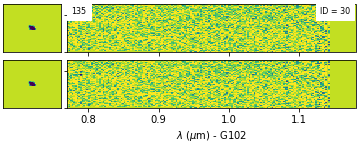

In [36]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

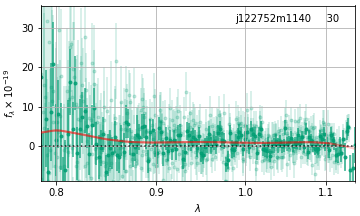

In [37]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 30


(30, 1, 15.88932728767395)

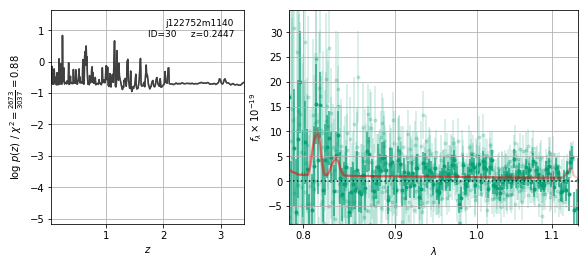

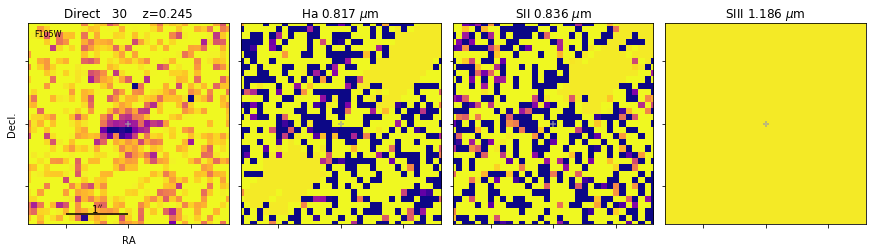

In [38]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [39]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j122752m1140_00030.stack.png
j122752m1140_00030.1D.fits
j122752m1140_00030.full.png
j122752m1140_00030.full.fits
j122752m1140_00030.beams.fits
j122752m1140_00030.1D.png
j122752m1140_00030.log_par
j122752m1140_00030.stack.fits
j122752m1140_00030.line.png


In [40]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j122752m1140_00030.1D.fits


Filename: j122752m1140_00030.1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  G102          1 BinTableHDU     36   179R x 6C   [D, D, D, D, D, D]   


j122752m1140_00030.full.fits


Filename: j122752m1140_00030.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  ZFIT_STACK    1 BinTableHDU     77   920R x 6C   [D, D, 21D, 441D, D, D]   
  2  COVAR         1 ImageHDU       153   (41, 41)   float64   
  3  TEMPL         1 BinTableHDU    141   9823R x 3C   [D, D, D]   
  4  SEG           1 ImageHDU         8   (80, 80)   int32   
  5  DSCI        F105W ImageHDU        28   (80, 80)   float32   
  6  DWHT        F105W ImageHDU        28   (80, 80)   float32   
  7  LINE        SIII ImageHDU        31   (80, 80)   float32   
  8  CONTINUUM   SIII ImageHDU        31   (80, 80)   float32   
  9  CONTAM      SIII

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [41]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 108 1
j122752m1140_00108.beams.fits


True

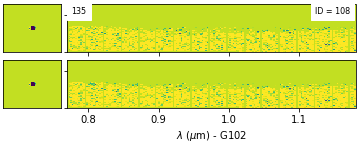

In [42]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

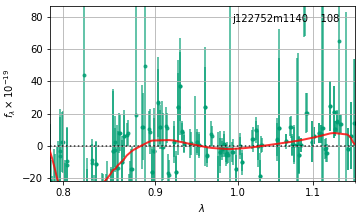

In [43]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 108


(108, 1, 3.896324634552002)

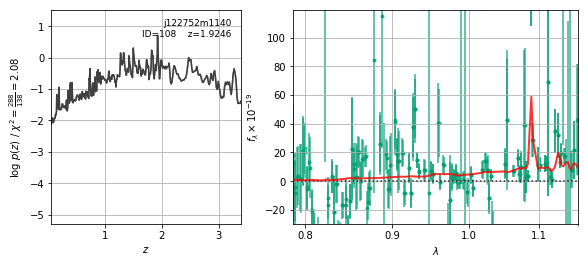

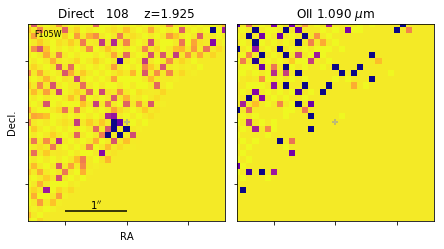

In [44]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).